In [42]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
import bids
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import os
from pathlib import Path
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img
from nilearn.image import load_img
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage
from nilearn.glm.first_level import run_glm as run_glm
from nilearn.glm import compute_contrast
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')

# Making results folder -- change to what this should actually be 
path = '/Volumes/Seagate Desktop Drive/NARSAD/'
os.chdir(path)


### making ROI mask (lateral ROIs combined into 1 bilateral ROI)

BIDS Layout: ...sktop Drive/NARSAD/derivatives | Subjects: 102 | Sessions: 102 | Runs: 10


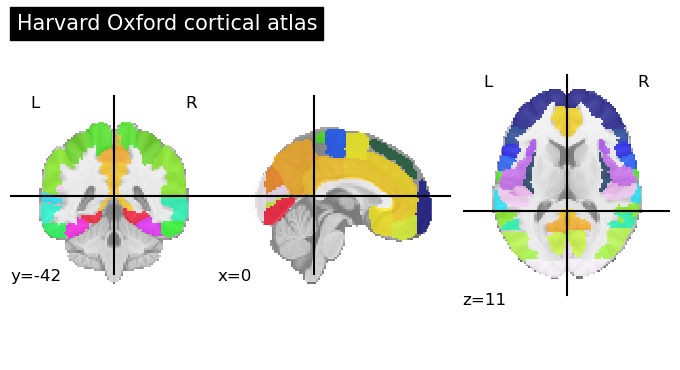

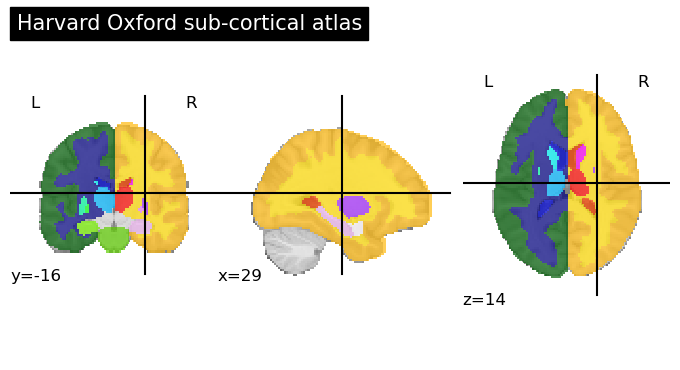

In [43]:
import numpy as np
from nilearn import datasets
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn import plotting, masking
from nilearn.masking import _unmask_3d
from nilearn.maskers import nifti_spheres_masker
import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img 

dataset_ho_cort = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm", symmetric_split=False) #changing from bilateral to combined left/right
atlas_ho_cort_filename = dataset_ho_cort.filename
plotting.plot_roi(atlas_ho_cort_filename, title="Harvard Oxford cortical atlas")

dataset_ho_sub = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr25-2mm", symmetric_split=False)
atlas_ho_sub_filename = dataset_ho_sub.filename
plotting.plot_roi(atlas_ho_sub_filename, title="Harvard Oxford sub-cortical atlas")

layout = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/NARSAD/derivatives', validate=False,
                  config=['bids','derivatives'])
print(layout)

In [44]:
#making space defining image
sub = 'N234'
fmri_imgs = layout.get(subject=sub,
                        datatype='func',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

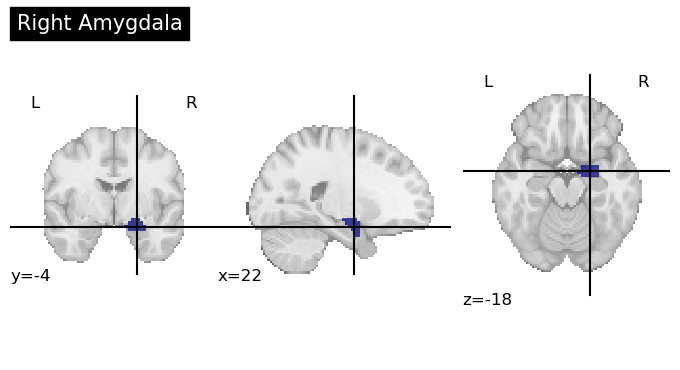

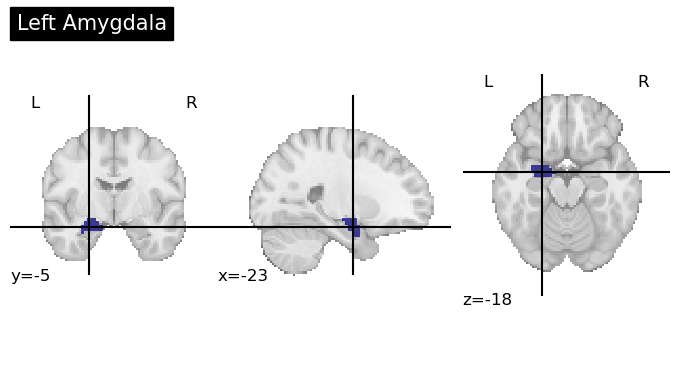

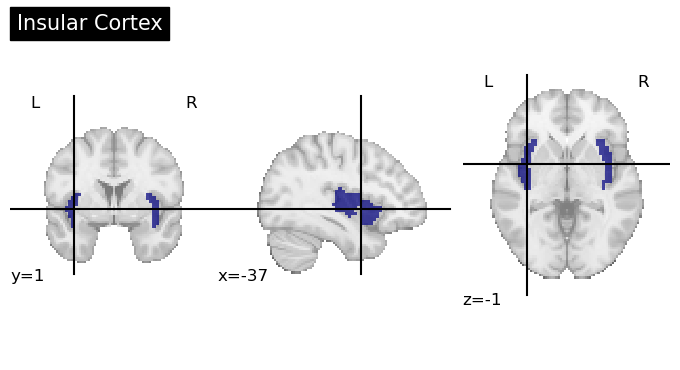

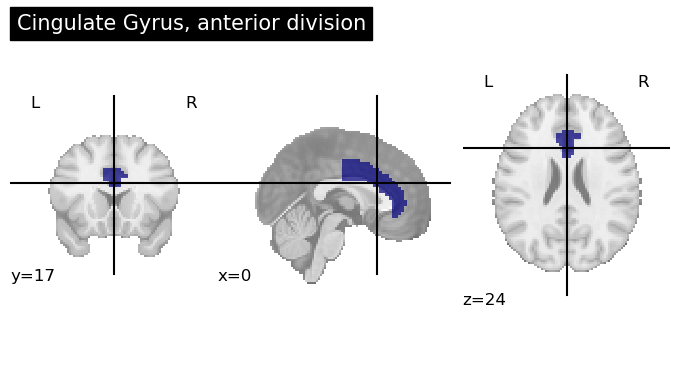

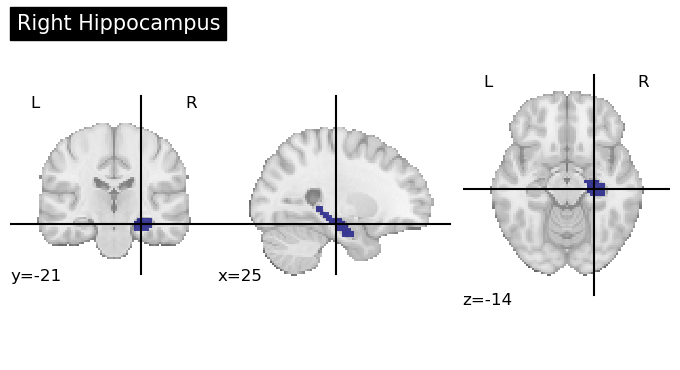

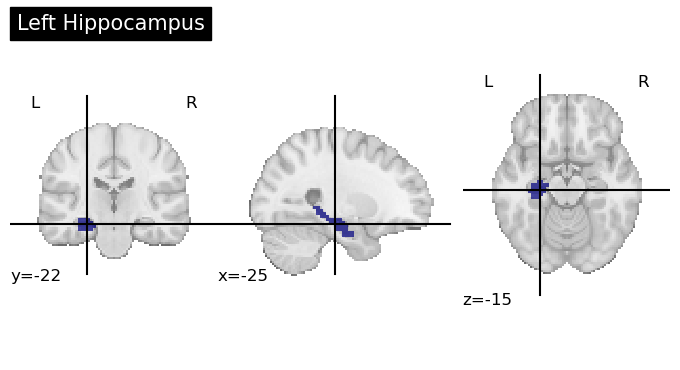

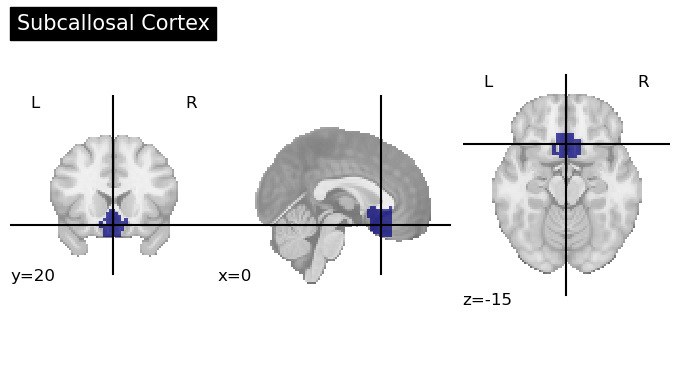

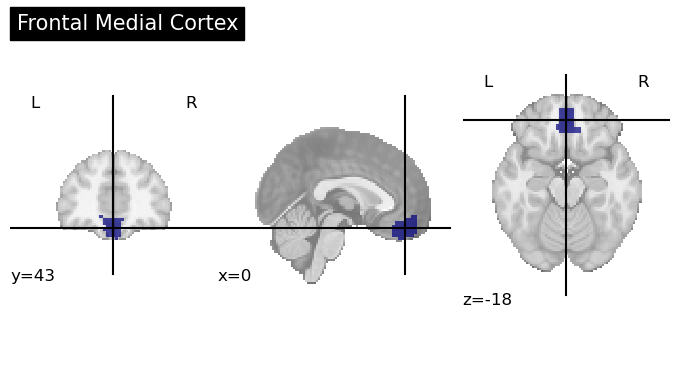

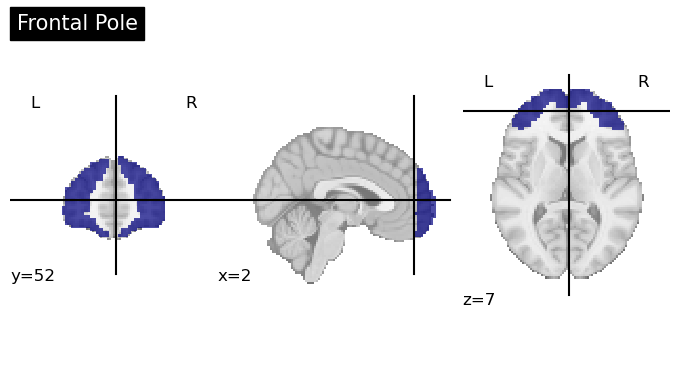

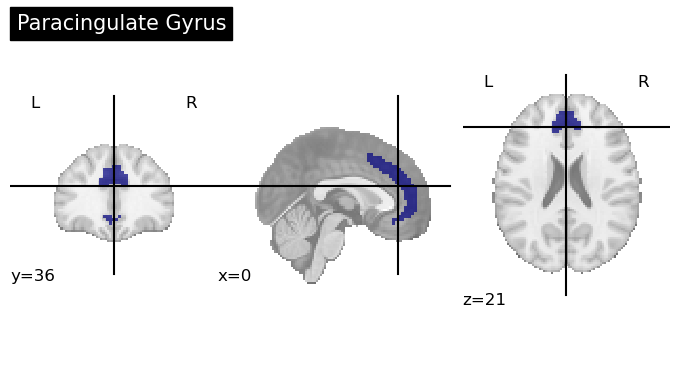

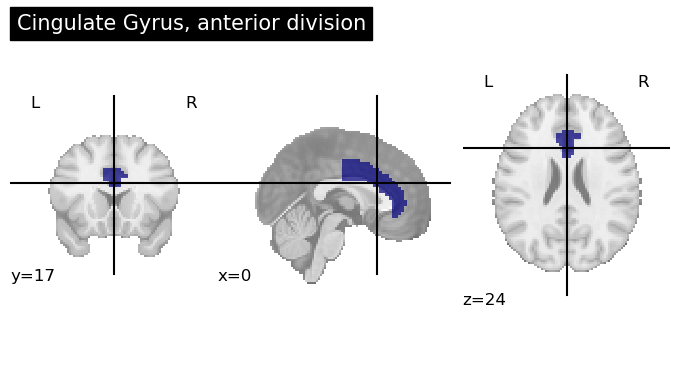

In [45]:
def create_and_plot_roi(label_of_interest, dataset, atlas_resampled):
    index_of_interest = dataset['labels'].index(label_of_interest)
    nii_data = atlas_resampled.get_fdata()
    roi_data = np.where(nii_data == index_of_interest, nii_data, 0)
    binarized_data = (roi_data > 0).astype(bool)
    
    roi_atlas = Nifti1Image(binarized_data, atlas_resampled.affine, header=atlas_resampled.header)
    plotting.plot_roi(roi_atlas, title=label_of_interest)
    
    return roi_atlas

#resample atlas map to data shape
atlas_sub_resampled = resample_to_img(source_img=dataset_ho_sub['maps'], target_img=space_defining_image, interpolation='nearest')
atlas_cort_resampled = resample_to_img(source_img=dataset_ho_cort['maps'], target_img=space_defining_image, interpolation='nearest')

right_amygdala_atlas = create_and_plot_roi('Right Amygdala', dataset_ho_sub, atlas_sub_resampled)
left_amygdala_atlas = create_and_plot_roi('Left Amygdala', dataset_ho_sub, atlas_sub_resampled)
insula_atlas = create_and_plot_roi('Insular Cortex', dataset_ho_cort, atlas_cort_resampled)
acc_atlas = create_and_plot_roi('Cingulate Gyrus, anterior division', dataset_ho_cort, atlas_cort_resampled)
right_hippocampus_atlas = create_and_plot_roi('Right Hippocampus', dataset_ho_sub, atlas_sub_resampled)
left_hippocampus_atlas = create_and_plot_roi('Left Hippocampus', dataset_ho_sub, atlas_sub_resampled)
vmpfc1_atlas = create_and_plot_roi('Subcallosal Cortex', dataset_ho_cort, atlas_cort_resampled)
vmpfc2_atlas = create_and_plot_roi('Frontal Medial Cortex', dataset_ho_cort, atlas_cort_resampled)
vmpfc3_atlas = create_and_plot_roi('Frontal Pole', dataset_ho_cort, atlas_cort_resampled)
vmpfc4_atlas = create_and_plot_roi('Paracingulate Gyrus', dataset_ho_cort, atlas_cort_resampled)
vmpfc5_atlas = create_and_plot_roi('Cingulate Gyrus, anterior division', dataset_ho_cort, atlas_cort_resampled)


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/image.py:1106: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/image.py:1106: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/image.py:1106: UserWarning: Data array

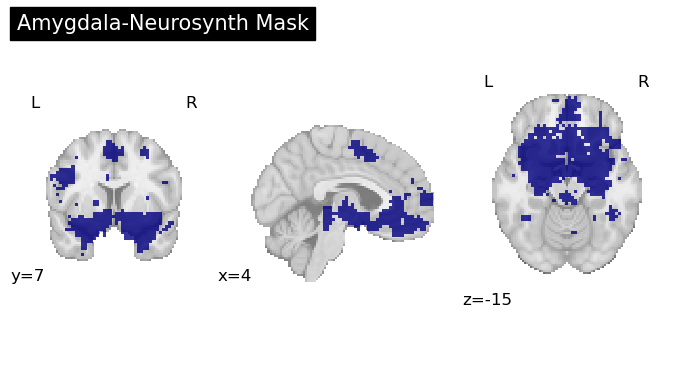

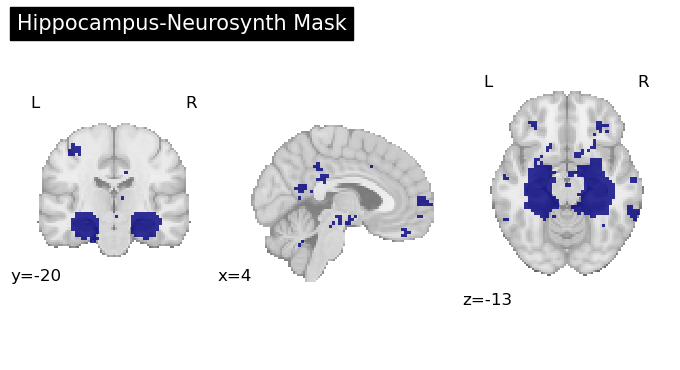

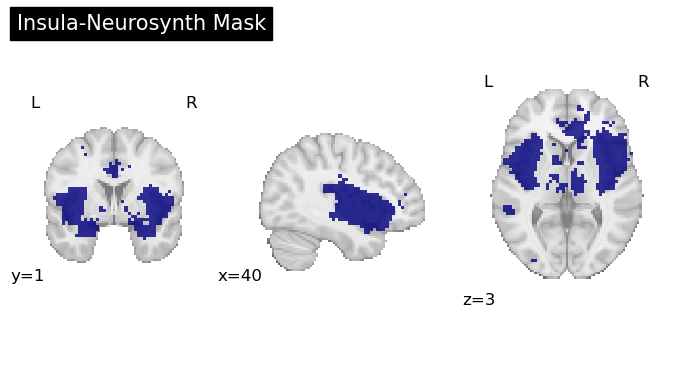

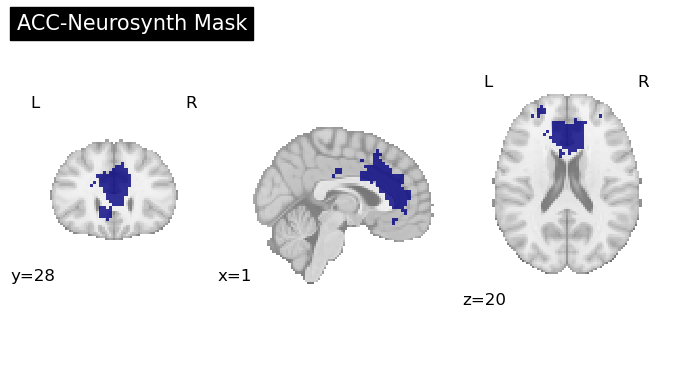

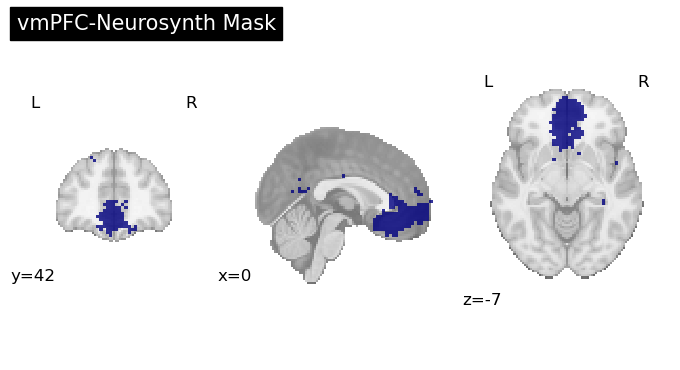

In [46]:
# load in/plot neurosynth masks: 
# #import Neurosynth masks:
from nilearn.image import binarize_img

amygdala_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/amygdala.nii.gz')
amygdala_func = binarize_img(resample_to_img(source_img=amygdala_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(amygdala_func, draw_cross=False, alpha=0.8, title='Amygdala-Neurosynth Mask')

hippocampus_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/hippocampus.nii.gz')
hippocampus_func = binarize_img(resample_to_img(source_img=hippocampus_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(hippocampus_func, draw_cross=False, alpha=0.8, title='Hippocampus-Neurosynth Mask')

insula_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/insula.nii.gz')
insula_func = binarize_img(resample_to_img(source_img=insula_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(insula_func, draw_cross=False, alpha=0.8, title='Insula-Neurosynth Mask')

acc_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/acc.nii.gz')
acc_func = binarize_img(resample_to_img(source_img=acc_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(acc_func, draw_cross=False, alpha=0.8, title='ACC-Neurosynth Mask')

vmpfc_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/vmpfc.nii.gz')
vmpfc_func = binarize_img(resample_to_img(source_img=vmpfc_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(vmpfc_func, draw_cross=False, alpha=0.8, title='vmPFC-Neurosynth Mask')


/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_761/976521645.py:11: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  amygdala = new_img_like(space_defining_image, amygdala)
/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_761/976521645.py:20: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  hippocampus = new_img_like(space_defining_image, hippocampus)
/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_761/976521645.py:26: UserWarning: Data array used to create a new image contains 

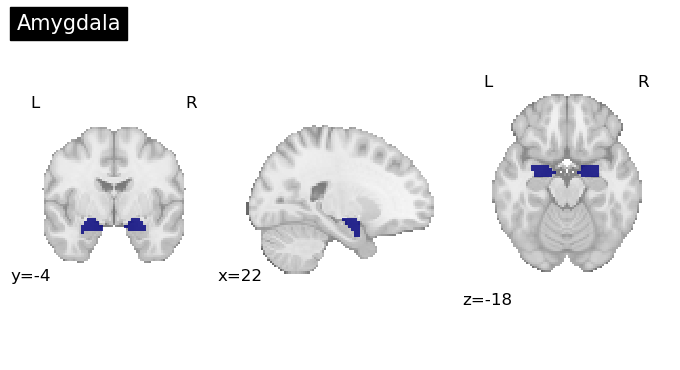

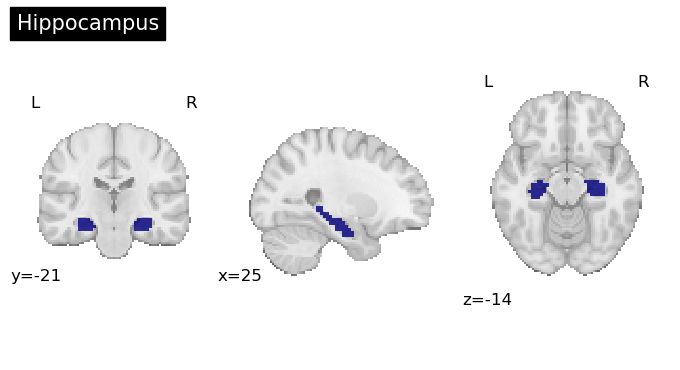

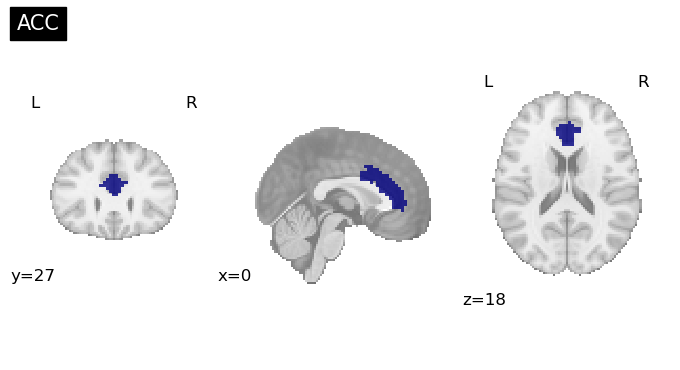

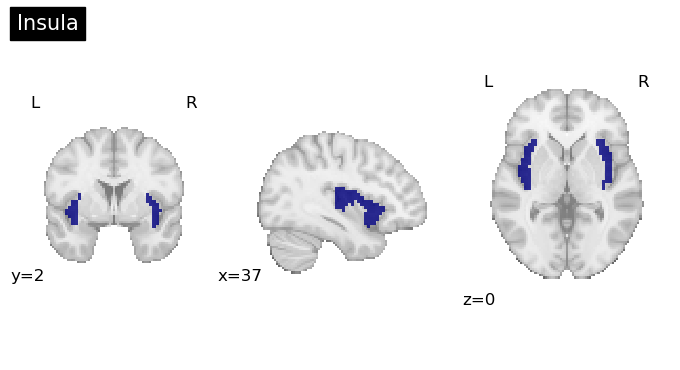

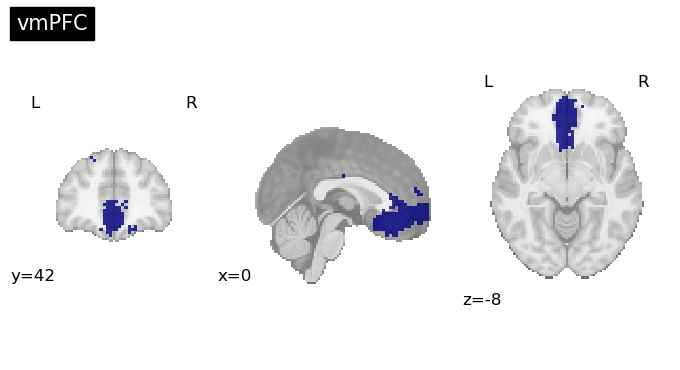

In [ ]:
path = '/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/anatomically-constrained'
os.chdir(path)

# anatomically-constraining functional ROIs + lateralizing 
from nilearn.image import new_img_like
right_amygdala = np.logical_and(amygdala_func.get_fdata(),right_amygdala_atlas.get_fdata())
right_amygdala = right_amygdala.astype(int)
left_amygdala = np.logical_and(amygdala_func.get_fdata(),left_amygdala_atlas.get_fdata())
left_amygdala = left_amygdala.astype(int)
amygdala = np.maximum.reduce([right_amygdala, left_amygdala])
amygdala = new_img_like(space_defining_image, amygdala)
plotting.plot_roi(amygdala, draw_cross=False, alpha=0.8, title="Amygdala")
nib.save(amygdala, 'amygdala.nii')

right_hippocampus = np.logical_and(hippocampus_func.get_fdata(),right_hippocampus_atlas.get_fdata())
right_hippocampus = right_hippocampus.astype(int)
left_hippocampus = np.logical_and(hippocampus_func.get_fdata(),left_hippocampus_atlas.get_fdata())
left_hippocampus = left_hippocampus.astype(int)
hippocampus = np.maximum.reduce([right_hippocampus, left_hippocampus])
hippocampus = new_img_like(space_defining_image, hippocampus)
plotting.plot_roi(hippocampus, draw_cross=False, alpha=0.8, title="Hippocampus")
nib.save(hippocampus, 'hippocampus.nii')

acc = np.logical_and(acc_func.get_fdata(),acc_atlas.get_fdata())
acc = acc.astype(int)
acc = new_img_like(space_defining_image, acc)
plotting.plot_roi(acc, draw_cross=False, alpha=0.8, title="ACC")
nib.save(acc, 'acc.nii')

insula = np.logical_and(insula_func.get_fdata(),insula_atlas.get_fdata())
insula = insula.astype(int)
insula = new_img_like(space_defining_image, insula)
plotting.plot_roi(insula, draw_cross=False, alpha=0.8, title="Insula")
nib.save(insula, 'insula.nii')

vmpfc1 = np.logical_and(vmpfc_func.get_fdata(),vmpfc1_atlas.get_fdata())
vmpfc1 = vmpfc1.astype(int)
vmpfc2 = np.logical_and(vmpfc_func.get_fdata(),vmpfc2_atlas.get_fdata())
vmpfc2 = vmpfc2.astype(int)
vmpfc3 = np.logical_and(vmpfc_func.get_fdata(),vmpfc3_atlas.get_fdata())
vmpfc3 = vmpfc3.astype(int)
vmpfc4 = np.logical_and(vmpfc_func.get_fdata(),vmpfc4_atlas.get_fdata())
vmpfc4 = vmpfc4.astype(int)
vmpfc5 = np.logical_and(vmpfc_func.get_fdata(),vmpfc5_atlas.get_fdata())
vmpfc5 = vmpfc5.astype(int)
vmpfc = np.maximum.reduce([vmpfc1, vmpfc2, vmpfc3, vmpfc4, vmpfc5])
vmpfc = new_img_like(space_defining_image, vmpfc)
plotting.plot_roi(vmpfc, draw_cross=False, alpha=0.8, title="vmPFC")
nib.save(vmpfc, 'vmpfc.nii')

In [235]:
# run to load in previously-derived masks + create combined masker object (for ease of first-level computation)
from nilearn.maskers import NiftiLabelsMasker
from nibabel import Nifti1Image
from nilearn import plotting, masking

path = '/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/anatomically-constrained'
os.chdir(path)

#making space defining image
sub = 'N234'
fmri_imgs = layout.get(subject=sub,
                        datatype='func',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

amygdala = nib.load('amygdala.nii')
hippocampus = nib.load('hippocampus.nii')
insula = nib.load('insula.nii')
acc = nib.load('acc.nii')
vmpfc = nib.load('vmpfc.nii')

amygdala_data = amygdala.get_fdata() * 1
insula_data = insula.get_fdata() * 2
hippocampus_data = hippocampus.get_fdata() * 3
vmpfc_data = vmpfc.get_fdata() * 5
acc_data = acc.get_fdata() * 4

# Combine the masks by taking the maximum value at each voxel
combined_mask_data = np.maximum.reduce([
    amygdala_data,
    insula_data,
    hippocampus_data,
    acc_data,
    vmpfc_data
])

combined_mask_img = Nifti1Image(combined_mask_data, affine=insula.affine)
plotting.plot_roi(combined_mask_img, display_mode='mosaic',draw_cross=False, alpha=1, title="Combined Mask",output_file='combo_roi_mask.png',cmap='Set1')

# First, initialize masker 
masker = NiftiLabelsMasker(
    combined_mask_img, mask_img=space_defining_image
)

In [229]:
path

'/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/anatomically-constrained'

## whole phase

### first level

In [204]:
# removing subjects w wrong sequence / missing phases: 
subjects = layout.get_subjects()
subjects1 = subjects
del(subjects1[0]) #sub101 has 2mm seq for phase 2, 3mm (correct) for phase 3
del(subjects1[49]) # sub201, has 2mm seq for phase 2, 3mm (correct) for phase 3 

subjects = layout.get_subjects()
subjects2 = subjects
del(subjects2[15]) #sub 120 missing phase 3

subjects = layout.get_subjects()

In [ ]:
# Making results folder -- change to what this should actually be 
path = '/Volumes/Seagate Desktop Drive/NARSAD/'
os.chdir(path)

# can load in onsets (events.tsv) for all subs here as all subs have same task timings 
onsets_phase2 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events-SPLIT_CSplus.xlsx',sheet_name=0)
onsets_phase3 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events-SPLIT_CSplus.xlsx',sheet_name=1)
onsets_phase3_sub202 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events-SPLIT_CSplus.xlsx',sheet_name=2)

onsets = onsets_phase2, onsets_phase3
onsets_sub202 = onsets_phase2, onsets_phase3_sub202

def load_bids_events(layout,onsets, subject, task, phaseno):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files)
    n_tr = func_file.shape[-1]
    onsets=onsets[phaseno]
    #onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events')[run].path, sep='\t') -- line to use if events changes by 
    
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [0,1,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as onsets 
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans

In [244]:
# to iterate through subjects ... 
#for sub in subjects 
from scipy.stats import norm

p001_unc = norm.isf(0.001)

file_lists_phase2 = {
        "CSpe-CSme": list(),   
        "CSpe-fixe": list(),   
        "CSme-fixe": list(),
        "CSpl-CSml": list(),   
        "CSpl-fixl": list(),   
        "CSml-fixl": list()
        }

file_lists_phase3 = {
        "CSpe-CSme": list(),   
        "CSpe-fixe": list(),   
        "CSme-fixe": list(),
        "CSpl-CSml": list(),   
        "CSpl-fixl": list(),   
        "CSml-fixl": list()
        }

sub_order_phase2 = {
        "CSpe-CSme": list(),   
        "CSpe-fixe": list(),   
        "CSme-fixe": list(),
        "CSpl-CSml": list(),   
        "CSpl-fixl": list(),   
        "CSml-fixl": list()
        }

sub_order_phase3 = {
        "CSpe-CSme": list(),   
        "CSpe-fixe": list(),   
        "CSme-fixe": list(),
        "CSpl-CSml": list(),   
        "CSpl-fixl": list(),   
        "CSml-fixl": list()
        }

tasks = ['phase2','phase3']

for phaseno, task in enumerate(tasks): 

    if task == 'phase2':
        subject_list = subjects1 
    elif task == 'phase3':
        subject_list = subjects2        
    
    for sub in subject_list: 

        fmri_imgs = layout.get(subject=sub,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        dmn_time_series = []
        for con_img in fmri_imgs:
            dmn_time_series.append(masker.fit_transform(con_img))
        dmn_time_series = np.concatenate(dmn_time_series, axis = 0)
        
        confound_files = layout.get(subject=sub,
                            datatype='func', task=task,
                            desc='confounds',
                           extension="tsv",
                           return_type='file')
        # Select confounds 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                        ]

        final_confounds = confound_vars

        design_matrices = []

        print("Creating First Level Design matrix ... ")

        if sub == 'N202':
            onsets_file = onsets_sub202 
        else:
            onsets_file = onsets
        
        for img in enumerate(fmri_imgs):
    # Build experimental paradigm
            events,tr,n_scans = load_bids_events(layout,onsets_file, sub, task, phaseno)
        # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[0]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)            
        # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )

        design_matrices.append(design_matrix)
        design_matrix_allruns = []    
        design_matrix_allruns = np.concatenate(design_matrices, axis = 0)
            
        contrast_matrix = []
        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }
        
        contrasts = {
            "CSpe-CSme": (basic_contrasts["CSplus-early"] - basic_contrasts["CS--early"]),   
            "CSpe-fixe": (basic_contrasts["CSplus-early"] - basic_contrasts["FIXATION-early"]),   
            "CSme-fixe": (basic_contrasts["CS--early"] - basic_contrasts["FIXATION-early"]),
            "CSpl-CSml": (basic_contrasts["CSplus-late"] - basic_contrasts["CS--late"]), 
            "CSpl-fixl": (basic_contrasts["CSplus-late"] - basic_contrasts["FIXATION-late"]),
            "CSml-fixl": (basic_contrasts["CS--late"] - basic_contrasts["FIXATION-late"])
        }

    #fmri_glm = FirstLevelModel()
        labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)

        for contrast_id, contrast_val in contrasts.items():
            contrast = compute_contrast(labels, estimates, contrast_val)
            z_score = contrast.z_score()
            print(f"{contrast_id}: Z-score outputs: {z_score}")

            # Ensure subject data is appended properly
            if phaseno == 0:  # phase2
                file_lists_phase2[contrast_id].append(contrast)
                sub_order_phase2[contrast_id].append(f'sub{sub}-ses{task}')            
            else:  # phase3
                file_lists_phase3[contrast_id].append(contrast)
                sub_order_phase3[contrast_id].append(f'sub{sub}-ses{task}')

        print(f"Subject {sub} completed for {task}!")

    

Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [0.40844458 0.86385162 0.08419791 0.81045212 0.08702285]
CSpe-fixe: Z-score outputs: [ 0.29999706  0.59491124 -0.544063    0.11114902 -1.91040675]
CSme-fixe: Z-score outputs: [-0.22425288 -0.53060098 -0.58688848 -0.88409461 -1.63256389]
CSpl-CSml: Z-score outputs: [ 1.45847862  0.68430634  0.0808993  -0.54373244 -1.40863395]
CSpl-fixl: Z-score outputs: [ 1.75023238  0.31585693  0.77907486 -1.1021946  -0.76361631]
CSml-fixl: Z-score outputs: [-0.13838886 -0.53569626  0.60010519 -0.3100475   1.07377468]
Subject N103 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-3.22371325 -0.00916876 -2.96803039  2.09879571 -0.78956619]
CSpe-fixe: Z-score outputs: [-0.50263359 -0.94258554 -1.32898009 -2.27833599 -4.00648829]
CSme-fixe: Z-score outputs: [ 3.36485334 -0.73468936  2.42992414 -4.22349534 -2.23089353]
CSpl-CSml: Z-score outputs: [ 1.16409428 -0.94080669  0.4582436   2.06176016  1.4884744 ]
CSpl-fixl: Z-score outputs: [-0.54927548 -0.35654161  0.14149754  2.69780583  1.14172917]
CSml-fixl: Z-score outputs: [-1.92484168  0.8336946  -0.43340225 -0.23117616 -0.85308011]
Subject N104 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.0723756   0.0305568  -1.05461165  0.59612774 -0.77688197]
CSpe-fixe: Z-score outputs: [ 0.97345272 -0.46080936 -0.46359425  0.07404046 -1.69375019]
CSme-fixe: Z-score outputs: [ 0.91807367 -0.41719214  0.87788456 -0.65766392 -0.4227615 ]
CSpl-CSml: Z-score outputs: [-1.00624285 -0.28366147  0.01031659  0.89537187  2.06453268]
CSpl-fixl: Z-score outputs: [ 0.96581608  0.46087753 -0.11475595  0.32083254  0.55757433]
CSml-fixl: Z-score outputs: [ 2.01818145  0.71779608 -0.10927177 -0.81525013 -2.04263962]
Subject N105 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [1.3668009  2.0782609  1.60674681 1.74555565 0.72975808]
CSpe-fixe: Z-score outputs: [ 0.01987537 -1.32220057 -1.11519682 -1.06318407 -1.3011601 ]
CSme-fixe: Z-score outputs: [-1.5472619  -3.44579986 -2.75066159 -2.85818378 -1.91793304]
CSpl-CSml: Z-score outputs: [ 0.08978039  0.47261194 -0.06536496 -0.45603037 -0.93487772]
CSpl-fixl: Z-score outputs: [0.26610858 0.96325038 0.21347293 0.19887274 0.70846738]
CSml-fixl: Z-score outputs: [0.11932115 0.27047218 0.26215027 0.7194838  1.72881451]
Subject N106 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.46004661 -1.99169497 -1.88596644 -0.42294846 -0.07422238]
CSpe-fixe: Z-score outputs: [ 0.03876744 -2.39356717 -3.05868293 -1.42396006 -0.9223505 ]
CSme-fixe: Z-score outputs: [-0.53183612  0.42503172 -0.31228125 -0.71671717 -0.68524543]
CSpl-CSml: Z-score outputs: [-0.14977321 -0.09217533 -2.16494628  3.1109042   0.11121217]
CSpl-fixl: Z-score outputs: [ 0.83579126  2.45386218 -1.32553436  1.92708328 -0.99031958]
CSml-fixl: Z-score outputs: [ 0.86575791  2.03563361  1.50948748 -2.13316002 -0.9105013 ]
Subject N108 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-2.29632459 -1.5390886  -1.91437927 -1.15582091 -1.47976561]
CSpe-fixe: Z-score outputs: [-2.61035776 -0.11668662 -1.12786325  0.79218614 -0.10040721]
CSme-fixe: Z-score outputs: [0.55874612 1.76447038 1.37628268 2.02231383 1.705703  ]
CSpl-CSml: Z-score outputs: [ 0.32150029 -1.08423023 -2.31434837 -2.71924459 -2.53112724]
CSpl-fixl: Z-score outputs: [ 0.04592238 -0.42054434 -0.20066339 -0.10865987  0.14901881]
CSml-fixl: Z-score outputs: [-0.32983866  0.88985507  2.49961859  3.08083608  3.05792709]
Subject N109 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.19517948 -0.07843871  0.06229848 -0.36056646  0.06176226]
CSpe-fixe: Z-score outputs: [ 1.31198346  1.0222622  -0.83526181 -1.21806257 -2.47264616]
CSme-fixe: Z-score outputs: [ 0.84406108  0.91181863 -0.74475466 -0.54401844 -1.98312374]
CSpl-CSml: Z-score outputs: [0.22643087 0.95609908 0.01423486 1.27464645 0.39040251]
CSpl-fixl: Z-score outputs: [ 0.32851915  0.78155188 -0.02940646  0.5278947  -0.85002314]
CSml-fixl: Z-score outputs: [ 0.01223117 -0.50784662 -0.04296641 -1.11901459 -1.16792545]
Subject N110 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.96954966 -0.32915968 -1.16704273 -1.3961286   0.31494475]
CSpe-fixe: Z-score outputs: [ 0.30618513  0.7568487  -0.80819529 -0.57884146 -1.32806813]
CSme-fixe: Z-score outputs: [-0.90524942  1.04287995  0.72280269  1.19501271 -1.44934131]
CSpl-CSml: Z-score outputs: [-0.65267768  0.17792717  0.73772828 -0.42408606  0.34855072]
CSpl-fixl: Z-score outputs: [-1.07024679 -0.62668273  0.10869734  0.24262885  0.29743708]
CSml-fixl: Z-score outputs: [-0.13506873 -0.7504732  -0.79581174  0.71502853 -0.18132114]
Subject N111 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 1.376315   -0.15605764  0.12082326  0.65887349 -0.42071599]
CSpe-fixe: Z-score outputs: [ 2.72522757  0.45739582  1.16353113  1.45434615 -1.52889048]
CSme-fixe: Z-score outputs: [ 0.71027104  0.56124063  0.83565718  0.41817002 -0.74504238]
CSpl-CSml: Z-score outputs: [-1.55483133 -2.59118645 -0.494571   -1.39902251 -0.50501027]
CSpl-fixl: Z-score outputs: [-0.32934406 -0.8347375   0.97385503 -0.11749613 -0.20978473]
CSml-fixl: Z-score outputs: [1.61148691 2.46389966 1.37292457 1.58618909 0.44351458]
Subject N112 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.6039788  -0.39905465 -0.39237185 -0.39212629 -0.33391705]
CSpe-fixe: Z-score outputs: [-0.61343781 -0.79208385 -1.09298159 -0.12206866 -0.8038096 ]
CSme-fixe: Z-score outputs: [ 0.19310974 -0.20455373 -0.46802617  0.36514581 -0.28550086]
CSpl-CSml: Z-score outputs: [-0.64024456 -2.30756833 -2.33666657 -0.46168688 -1.3937114 ]
CSpl-fixl: Z-score outputs: [-0.46070509 -1.58129782 -1.04844056 -1.28427303 -1.45864328]
CSml-fixl: Z-score outputs: [ 0.39522406  1.50610718  1.9957378  -0.53435139  0.49146978]
Subject N113 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 1.4466867   0.40038757 -0.6183337  -0.71664654 -0.68967228]
CSpe-fixe: Z-score outputs: [ 0.62464464 -1.32292201 -1.03618854 -2.0425559  -0.56330538]
CSme-fixe: Z-score outputs: [-1.21139405 -1.53021985 -0.09595542 -0.7937644   0.37762288]
CSpl-CSml: Z-score outputs: [ 0.45794218  2.27757671 -1.3659375   1.69955286 -0.18137213]
CSpl-fixl: Z-score outputs: [ 0.13463567  0.53039085 -0.52447564  0.18293796  1.18032412]
CSml-fixl: Z-score outputs: [-0.43856347 -2.31824728  1.21370906 -1.90219769  1.19479499]
Subject N114 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.01400501 -1.04300592  0.80112833 -1.87910007 -0.18496608]
CSpe-fixe: Z-score outputs: [-0.64485869 -0.11737587 -0.82811162 -2.25974665 -3.18979529]
CSme-fixe: Z-score outputs: [ 0.70176703  1.17577313 -1.65992902  0.39374411 -2.36077199]
CSpl-CSml: Z-score outputs: [-0.63305613  0.00484864 -0.97367401  0.00301847  0.66045529]
CSpl-fixl: Z-score outputs: [ 0.17270782 -0.50363326 -2.04963327 -0.01889815 -2.04554772]
CSml-fixl: Z-score outputs: [ 0.87516835 -0.39749684 -0.44846354 -0.01834794 -2.32134725]
Subject N115 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.64005488  0.66704685 -1.23350568  1.5593648   0.06298566]
CSpe-fixe: Z-score outputs: [ 0.87952943  0.15273769 -0.67935901  1.72321227 -1.39759552]
CSme-fixe: Z-score outputs: [ 1.53093334 -0.66785647  0.90416516 -0.37202467 -1.18904728]
CSpl-CSml: Z-score outputs: [ 0.29429434 -0.7412153  -0.35856502  1.52863081  0.90248013]
CSpl-fixl: Z-score outputs: [ 0.06828775  0.97069911 -1.26202846  2.18512247 -0.94180242]
CSml-fixl: Z-score outputs: [-0.29457247  1.65745265 -0.61047319  0.06220525 -1.79590957]
Subject N117 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.9470311  -0.77651122  0.51425751  0.14423174 -0.40125488]
CSpe-fixe: Z-score outputs: [-0.07297547 -0.55362027 -0.84357047 -0.23796595 -1.038452  ]
CSme-fixe: Z-score outputs: [-1.1961061   0.47496429 -1.33371124 -0.36986661 -0.38413577]
CSpl-CSml: Z-score outputs: [-0.23935366  0.15111818 -1.20895986 -1.01919877 -0.75227976]
CSpl-fixl: Z-score outputs: [ 0.20193329 -0.89224632 -0.10905307 -1.07486908 -0.0064653 ]
CSml-fixl: Z-score outputs: [ 0.43893567 -0.89039238  1.29157381  0.30613196  0.85886634]
Subject N118 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.21040122 -0.64903928 -0.56191403  0.12706751 -1.45508602]
CSpe-fixe: Z-score outputs: [ 0.3980115  -0.57999192 -0.64479232 -0.75637859 -2.25595885]
CSme-fixe: Z-score outputs: [ 1.79784556  0.31293916  0.14778002 -0.78098281 -0.0084825 ]
CSpl-CSml: Z-score outputs: [1.37479655 1.80274422 0.56222491 1.05676254 2.69629871]
CSpl-fixl: Z-score outputs: [1.9224637  1.70417238 0.52969776 1.94433205 2.550861  ]
CSml-fixl: Z-score outputs: [-0.06562826 -0.76514682 -0.23400084  0.3285305  -1.25605191]
Subject N121 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [0.80180508 0.98379478 1.34506252 0.14738954 0.50407947]
CSpe-fixe: Z-score outputs: [-0.86218606 -1.40289516 -0.51481006 -2.30548957 -0.46730169]
CSme-fixe: Z-score outputs: [-1.68607197 -2.32301731 -2.03978697 -1.99225122 -0.96274965]
CSpl-CSml: Z-score outputs: [0.41256521 0.89115976 0.38413034 2.61826077 3.10872406]
CSpl-fixl: Z-score outputs: [2.19817859 0.06130497 1.12240608 0.93119378 1.51004948]
CSml-fixl: Z-score outputs: [ 1.36607782 -0.99629671  0.48716134 -2.37534953 -2.57912669]
Subject N122 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 1.57212102 -1.96802227  0.51440438 -1.95885474 -0.62772442]
CSpe-fixe: Z-score outputs: [ 1.05711686 -1.02450172  0.39223913 -0.78398368  0.35326084]
CSme-fixe: Z-score outputs: [-1.00565048  1.54954018 -0.28881614  1.7192321   1.04121886]
CSpl-CSml: Z-score outputs: [-1.39021287 -1.34179934 -2.46525974 -2.68652617 -1.96978569]
CSpl-fixl: Z-score outputs: [-0.79773524 -2.46341314 -2.38988912 -2.54075763 -2.56048263]
CSml-fixl: Z-score outputs: [ 0.99606621 -0.37978801  0.96483665  1.12676322  0.43148293]
Subject N123 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.55101132 -0.24061606 -0.85690084  0.48270523 -1.41008108]
CSpe-fixe: Z-score outputs: [-1.26755935  1.44814477 -1.11501305  0.86501634 -2.32527919]
CSme-fixe: Z-score outputs: [ 0.82095821  1.46163274  0.08424332  0.10861284 -0.19087119]
CSpl-CSml: Z-score outputs: [-1.71759203  3.84938026 -1.30712237  2.24315596 -1.09209187]
CSpl-fixl: Z-score outputs: [-2.31904965  1.61452228 -2.35368559  1.277906   -2.40430711]
CSml-fixl: Z-score outputs: [ 0.1249851  -3.33443634 -0.50829994 -1.69372003 -0.69560461]
Subject N124 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.21407686  0.44477905 -0.90911222  0.79464971  1.65954016]
CSpe-fixe: Z-score outputs: [-1.21532595  0.63121266 -2.71112885 -0.26982812 -1.03970927]
CSme-fixe: Z-score outputs: [ 0.45374453 -0.00903849 -1.23116425 -1.22555751 -2.95024199]
CSpl-CSml: Z-score outputs: [ 0.51367961 -0.82989724 -1.24826159 -0.87970997 -0.93034611]
CSpl-fixl: Z-score outputs: [ 0.95282628 -0.67048463 -1.82175263 -0.89825767 -2.7167599 ]
CSml-fixl: Z-score outputs: [ 0.19260708  0.45025618 -0.02287586  0.3195401  -1.17097443]
Subject N125 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.31807118  1.54113222 -0.47838952  2.52249937  2.97995118]
CSpe-fixe: Z-score outputs: [-0.3151454   0.63856465 -0.60324949  1.16947857  0.365167  ]
CSme-fixe: Z-score outputs: [-0.64204015 -1.33880566  0.07687123 -2.09052302 -3.28171096]
CSpl-CSml: Z-score outputs: [-1.12866114  2.45220984 -1.08453756  2.50843061  0.96764616]
CSpl-fixl: Z-score outputs: [ 0.5682481   0.71170831 -0.33118635  1.22702964  0.23149642]
CSml-fixl: Z-score outputs: [ 1.7792051  -2.30476397  0.99146522 -1.95318777 -0.94638837]
Subject N127 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [0.09504946 0.27575305 0.96890705 0.77338153 0.89773988]
CSpe-fixe: Z-score outputs: [-0.48161793 -0.18059534  0.46159292  1.190862    0.29441468]
CSme-fixe: Z-score outputs: [-0.52230946 -0.4824574  -0.78640005  0.04001363 -0.84462147]
CSpl-CSml: Z-score outputs: [ 0.04407142 -0.13153619  3.54898739 -0.18346145  2.30415118]
CSpl-fixl: Z-score outputs: [0.56205231 0.17497528 2.71219344 0.16766327 1.20638395]
CSml-fixl: Z-score outputs: [ 0.44456593  0.30631902 -1.97773256  0.35721747 -1.77217189]
Subject N128 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.34870403  1.51918767 -2.72965922  1.57064318  1.32101712]
CSpe-fixe: Z-score outputs: [-0.05424797 -0.49663486 -1.80573807 -0.51485556 -1.53722968]
CSme-fixe: Z-score outputs: [ 1.52550187 -2.1487512   1.76380058 -2.22518895 -2.68197661]
CSpl-CSml: Z-score outputs: [ 0.99262188  2.91502643 -0.76083087  1.64014342 -0.65550354]
CSpl-fixl: Z-score outputs: [-0.05515217 -0.41357477 -1.56670291 -1.53694488 -1.6671682 ]
CSml-fixl: Z-score outputs: [-1.2154084  -3.76791604 -0.40494677 -3.21817876 -0.52868781]
Subject N129 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.11320289e+00 -1.74078398e+00  1.06036025e-03 -4.79413289e-01
  1.07014360e+00]
CSpe-fixe: Z-score outputs: [-0.29222097 -0.29336157 -1.08986391 -0.29728986 -1.60547085]
CSme-fixe: Z-score outputs: [ 1.09866786  1.85692656 -0.89910976  0.33921081 -2.54127667]
CSpl-CSml: Z-score outputs: [ 0.68677745 -2.92838852  1.23209503 -1.12927613  0.93581506]
CSpl-fixl: Z-score outputs: [ 0.53572223 -1.12646942  0.45002434 -0.83648245 -0.1239181 ]
CSml-fixl: Z-score outputs: [-0.36125604  2.54420396 -1.09822839  0.67603881 -1.21129627]
Subject N130 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.78519222 -0.45261026 -0.33832058 -0.75567276 -0.71509089]
CSpe-fixe: Z-score outputs: [-0.10978297 -0.44674181 -1.94537706 -0.79675562 -2.69221967]
CSme-fixe: Z-score outputs: [-1.03967468  0.18074606 -1.19194949  0.2714727  -1.21803095]
CSpl-CSml: Z-score outputs: [-0.00784654  0.33067475 -0.88874939 -0.1459467  -0.18453815]
CSpl-fixl: Z-score outputs: [ 1.37988657  0.36365448  0.09012938  0.67337157 -0.08981281]
CSml-fixl: Z-score outputs: [ 1.16835465 -0.10203021  1.12511657  0.70149957  0.15404641]
Subject N131 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(


CSpe-CSme: Z-score outputs: [-0.05253505 -0.54939619  0.27939531 -0.86154333 -0.53518473]
CSpe-fixe: Z-score outputs: [ 0.00233579 -0.53251471  0.54238508 -0.89288028 -2.02033188]
CSme-fixe: Z-score outputs: [ 0.06786816  0.23401007  0.13126668  0.33364699 -1.09131136]
CSpl-CSml: Z-score outputs: [-0.29265858  1.02872687 -0.0859422   2.64161564  1.24264298]
CSpl-fixl: Z-score outputs: [-0.28837772  1.70177246 -0.69481628  2.09888523  0.31892244]
CSml-fixl: Z-score outputs: [ 0.09734858  0.18628824 -0.49893229 -1.48818988 -1.2301204 ]
Subject N132 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.06247752  0.10028938  0.76271819 -0.83646433  0.82279358]
CSpe-fixe: Z-score outputs: [-0.52869609 -0.81606167 -0.92849559 -1.25973066 -0.67102632]
CSme-fixe: Z-score outputs: [-0.5342797  -0.81904129 -1.71287863 -0.13367077 -1.54246275]
CSpl-CSml: Z-score outputs: [ 2.03423975  2.67763377  0.26124461  1.96233208 -0.30675107]
CSpl-fixl: Z-score outputs: [ 0.8453131   1.14163589 -0.24255912 -1.06460985 -2.44780042]
CSml-fixl: Z-score outputs: [-1.71531491 -2.25365188 -0.50728733 -3.17552361 -1.59167906]
Subject N133 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.42338665 -0.66466426 -0.98601516  0.15247157 -0.62224412]
CSpe-fixe: Z-score outputs: [-0.58140152  0.34166008 -1.93896925 -0.66326399 -2.53627115]
CSme-fixe: Z-score outputs: [ 0.00308282  1.07223147 -0.46217612 -0.72966596 -1.2610732 ]
CSpl-CSml: Z-score outputs: [-0.46310557  1.76788716  0.19069577  1.72798257  0.1530091 ]
CSpl-fixl: Z-score outputs: [-0.22434714 -0.12363526  1.29129599  0.23228105 -0.28627457]
CSml-fixl: Z-score outputs: [ 0.35168468 -2.17334025  0.83907699 -1.83936049 -0.40374383]
Subject N134 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(


CSpe-CSme: Z-score outputs: [-0.05443925 -2.25827037 -0.09944829 -2.79055458 -3.44711507]
CSpe-fixe: Z-score outputs: [-1.04071532 -2.92780951 -1.53830093 -3.63458709 -4.15112974]
CSme-fixe: Z-score outputs: [-0.83644597  0.36570166 -1.16453096  0.3436059   0.59893592]
CSpl-CSml: Z-score outputs: [ 0.65630787  1.53747366  0.41651229  0.65749717 -1.17460672]
CSpl-fixl: Z-score outputs: [-0.70041817  0.76423671 -0.29053732  0.74819796 -1.55538922]
CSml-fixl: Z-score outputs: [-1.34107937 -1.23717504 -0.71800562 -0.18919211  0.11703335]
Subject N135 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.73307679 -1.43976817 -2.67201019 -2.44729281 -2.19046736]
CSpe-fixe: Z-score outputs: [ 1.71824223 -0.43961287 -0.90442067 -1.46999178 -2.0931676 ]
CSme-fixe: Z-score outputs: [2.39511336 1.35754952 2.43178151 1.70953762 0.9289478 ]
CSpl-CSml: Z-score outputs: [-0.91381051  1.210177   -1.66038737 -0.87512147 -0.58173542]
CSpl-fixl: Z-score outputs: [ 1.43272475 -0.45263276 -0.90509562 -1.80482301 -2.7288328 ]
CSml-fixl: Z-score outputs: [ 2.16799099 -1.73790205  1.12684773 -0.44366729 -1.47361072]
Subject N136 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.5329182  -1.5136483  -0.20931337 -0.41188362 -1.50118584]
CSpe-fixe: Z-score outputs: [ 1.62433794  0.67507044  1.41425749  1.35970606 -0.08278982]
CSme-fixe: Z-score outputs: [1.97715956 2.36550137 1.39336846 1.5969815  1.75992295]
CSpl-CSml: Z-score outputs: [-1.82732929  0.54672161 -1.74626147  1.52668649 -0.12995129]
CSpl-fixl: Z-score outputs: [-0.50549348 -0.14240065 -0.14915391  1.14262932 -0.27856923]
CSml-fixl: Z-score outputs: [ 1.76143747 -0.77108947  1.96634145 -0.87735441 -0.07352678]
Subject N137 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.42267305  0.79782051  0.20463562  0.1214121  -0.392983  ]
CSpe-fixe: Z-score outputs: [ 1.04641176  0.82801952  0.55504854 -0.26374444 -0.9327666 ]
CSme-fixe: Z-score outputs: [ 0.43211263 -0.26849209  0.24464182 -0.37949074 -0.2770699 ]
CSpl-CSml: Z-score outputs: [-0.12071315 -1.03981141 -0.3800814  -0.45799251 -0.80642869]
CSpl-fixl: Z-score outputs: [-0.03108663 -0.07050461 -1.02909848 -0.34983011 -1.29113537]
CSml-fixl: Z-score outputs: [ 0.11524231  1.1701609  -0.43324862  0.24306307 -0.05973766]
Subject N138 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.23380816  0.46617741 -0.63387503 -0.60055667 -0.85526806]
CSpe-fixe: Z-score outputs: [-0.97263344 -0.51643712 -1.67929481 -2.0131498  -3.48384374]
CSme-fixe: Z-score outputs: [-0.54770102 -1.00179707 -0.62386399 -0.89966694 -1.76696974]
CSpl-CSml: Z-score outputs: [-0.57811004 -0.25335786 -0.71144901 -1.12349328 -2.14660983]
CSpl-fixl: Z-score outputs: [ 0.37501728 -1.16360025 -0.62601593 -2.97026662 -3.95557111]
CSml-fixl: Z-score outputs: [ 1.00352797 -0.64239291  0.33481915 -1.03216532 -0.56695289]
Subject N141 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.69267581 -0.25313107 -0.52734125  1.38177416  0.37578164]
CSpe-fixe: Z-score outputs: [-0.79458357 -0.62124509 -0.35581615 -0.27536571 -0.6366532 ]
CSme-fixe: Z-score outputs: [ 0.15419442 -0.20205135  0.33507755 -1.8774007  -0.9586249 ]
CSpl-CSml: Z-score outputs: [ 0.33423101  1.47693075 -0.3585192   0.3517929   0.37534038]
CSpl-fixl: Z-score outputs: [ 0.74745583  0.41109429 -0.20803275 -0.86425172 -1.12181837]
CSml-fixl: Z-score outputs: [ 0.26565772 -1.43908247  0.25224977 -1.15213556 -1.39059862]
Subject N142 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.07340695 -1.10077616 -1.50261836 -0.06687293  0.64534646]
CSpe-fixe: Z-score outputs: [-1.11186539 -0.49068054 -2.01588469 -0.08446823 -1.13257154]
CSme-fixe: Z-score outputs: [ 0.34063199  0.93935527  0.0714501   0.01214756 -1.70058609]
CSpl-CSml: Z-score outputs: [ 0.46401743 -0.31496377  0.82377941  1.09667445 -0.39448647]
CSpl-fixl: Z-score outputs: [ 1.52263047  0.32586048  1.06425924  1.62052161 -0.80112071]
CSml-fixl: Z-score outputs: [ 0.78928697  0.63940689 -0.03356437  0.03273365 -0.22306722]
Subject N143 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.17191517 -0.92640869 -0.44258252 -0.10802288  0.3133474 ]
CSpe-fixe: Z-score outputs: [-0.04251478 -1.10781232 -0.54174537 -1.26078843 -0.81596155]
CSme-fixe: Z-score outputs: [ 0.16955638  0.17720638  0.07291366 -0.94124641 -1.0529755 ]
CSpl-CSml: Z-score outputs: [0.67098307 0.31245558 0.18273721 1.23687451 1.84528541]
CSpl-fixl: Z-score outputs: [-0.73020788 -2.24350488 -1.31965957 -2.71954446 -2.48695939]
CSml-fixl: Z-score outputs: [-1.38420038 -2.23630474 -1.31864058 -3.68675637 -4.12127549]
Subject N144 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.51120728 -0.03328829  0.93580068 -0.0345247  -0.65071647]
CSpe-fixe: Z-score outputs: [ 1.45093567 -0.21023304 -0.33222945 -0.47537842 -1.36347295]
CSme-fixe: Z-score outputs: [ 0.62011042 -0.13809939 -1.42137461 -0.37389779 -0.37524703]
CSpl-CSml: Z-score outputs: [ 0.53773215 -2.83820859  2.38832951 -2.43428456 -0.83616612]
CSpl-fixl: Z-score outputs: [ 0.02150221 -1.21978334  1.26807719 -1.84636401 -1.42825668]
CSml-fixl: Z-score outputs: [-0.61247641  2.29299324 -1.6962111   1.22858487 -0.25080621]
Subject N145 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.87715211  2.64876833 -1.82165606  0.59700742 -2.47801355]
CSpe-fixe: Z-score outputs: [-0.56474238  1.46411085 -0.45541874 -0.01758958 -0.91319082]
CSme-fixe: Z-score outputs: [ 0.57497816 -2.04441853  1.82261232 -0.73839611  2.2916478 ]
CSpl-CSml: Z-score outputs: [-1.165136   -0.97553811 -0.19618393 -1.14898447 -0.3526772 ]
CSpl-fixl: Z-score outputs: [-0.51070392 -0.10714825 -0.86636375  0.43584349  0.4793281 ]
CSml-fixl: Z-score outputs: [ 0.94625955  1.07747057 -0.49847035  1.72448594  0.80392647]
Subject N146 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.48510108 -2.22992456 -0.46162786 -1.71161321 -1.3029666 ]
CSpe-fixe: Z-score outputs: [ 0.30936665 -1.0240484  -1.45134948 -0.06785868 -1.00152249]
CSme-fixe: Z-score outputs: [-0.32609756  1.87564898 -0.67362904  2.03237943  0.75672008]
CSpl-CSml: Z-score outputs: [ 0.5056171  -1.0724224  -0.59441979 -0.45600677 -0.78909649]
CSpl-fixl: Z-score outputs: [-0.05769851 -0.6680291  -1.5863476  -0.85053261 -1.32643814]
CSml-fixl: Z-score outputs: [-0.64615824  0.73270029 -0.61114211 -0.16634841 -0.14157535]
Subject N147 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(


CSpe-CSme: Z-score outputs: [ 0.11317348  1.48652798 -1.47206437  0.38010499 -0.42203273]
CSpe-fixe: Z-score outputs: [ 0.49589658  0.78165708 -0.78516116 -0.37522395 -1.60204957]
CSme-fixe: Z-score outputs: [ 0.28118265 -1.19372862  1.12504221 -0.75635496 -0.76780993]
CSpl-CSml: Z-score outputs: [ 1.15803785  1.46312587 -0.17064137 -0.50819887  0.08677101]
CSpl-fixl: Z-score outputs: [1.08712055 1.73715248 0.14419014 0.53958925 0.09427971]
CSml-fixl: Z-score outputs: [-0.48990218 -0.43421837  0.32571531  1.04949385 -0.02985955]
Subject N148 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.66951316  1.26361496 -0.39406333  0.22157956 -0.83294372]
CSpe-fixe: Z-score outputs: [-0.67878018  1.43900343 -0.80789327  0.10901603 -2.45000309]
CSme-fixe: Z-score outputs: [ 0.21925677 -0.30830618 -0.21548494 -0.17099169 -0.97721499]
CSpl-CSml: Z-score outputs: [ 0.55308354  1.0410087   0.0805069   0.34919529 -1.03061128]
CSpl-fixl: Z-score outputs: [ 0.87349751  0.69563663 -0.05010484  0.78197815 -2.38088737]
CSml-fixl: Z-score outputs: [ 0.05635884 -0.67352523 -0.13407021  0.20642564 -0.60891251]
Subject N149 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 1.26494702  1.02265064 -1.73558797 -0.50532813 -3.76191529]
CSpe-fixe: Z-score outputs: [ 2.501944    2.08360389 -0.98050537 -0.29107613 -3.76669915]
CSme-fixe: Z-score outputs: [0.63677812 0.49242365 1.23228595 0.36693863 1.48015963]
CSpl-CSml: Z-score outputs: [ 0.17633397  1.16005703 -1.95404235  0.08557316 -3.34005857]
CSpl-fixl: Z-score outputs: [ 0.70143936  0.26316191  0.49539268  0.32997263 -1.57615118]
CSml-fixl: Z-score outputs: [ 0.39087766 -1.1435249   2.68435354  0.16975195  2.66878655]
Subject N150 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(


CSpe-CSme: Z-score outputs: [ 0.43052405 -1.21392148 -0.29455226 -0.84397829 -0.57903461]
CSpe-fixe: Z-score outputs: [ 0.78184084 -0.68342254 -0.00382827 -1.12834109 -1.43480956]
CSme-fixe: Z-score outputs: [ 0.16325674  0.87171499  0.34375399  0.05231874 -0.49302127]
CSpl-CSml: Z-score outputs: [ 0.80510649 -1.18659557  1.79576935  0.50876317  1.89436249]
CSpl-fixl: Z-score outputs: [1.40602324 0.01351359 1.61545421 0.41147715 0.19054648]
CSml-fixl: Z-score outputs: [ 0.08934474  1.33661682 -0.85708994 -0.27643976 -1.99079093]
Subject N151 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.11190801  0.0861874   0.43533892 -0.06016343  0.72962288]
CSpe-fixe: Z-score outputs: [-0.28433936 -0.88431799  0.97344922 -1.15622077 -0.26900867]
CSme-fixe: Z-score outputs: [ 1.10277802 -0.84193654  0.27918502 -0.86325878 -1.09104559]
CSpl-CSml: Z-score outputs: [2.27510306 3.64877273 0.94019637 3.01538584 1.19235408]
CSpl-fixl: Z-score outputs: [1.09420576 1.77552558 0.86747626 2.22712903 1.27823297]
CSml-fixl: Z-score outputs: [-1.78677218 -2.84972453 -0.38764698 -1.7830983  -0.40969054]
Subject N153 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.15430036  0.28320132  0.40638851  0.82119657  0.26344383]
CSpe-fixe: Z-score outputs: [ 0.96764864  0.81926727  0.01699538  1.03820653 -1.56566894]
CSme-fixe: Z-score outputs: [ 2.18713794  0.33523587 -0.47197052 -0.15347831 -1.58170159]
CSpl-CSml: Z-score outputs: [-0.24334682  1.62540804  0.15540949  2.18877762  0.45829804]
CSpl-fixl: Z-score outputs: [1.38209787 0.57763575 0.18392236 1.56444692 0.09938891]
CSml-fixl: Z-score outputs: [ 1.4464835  -1.45902319 -0.03053268 -1.36398235 -0.46518621]
Subject N154 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.18064169  0.88507662 -0.21817603  1.91768004  0.19278437]
CSpe-fixe: Z-score outputs: [-6.80858332e-01  2.06338775e+00 -2.02151786e-03  1.80738523e+00
 -7.07326459e-02]
CSme-fixe: Z-score outputs: [ 0.84771408  0.60591995  0.26279723 -0.82053173 -0.29233395]
CSpl-CSml: Z-score outputs: [-1.07274602  0.56711503 -1.18237965 -0.19152744 -0.18434073]
CSpl-fixl: Z-score outputs: [-0.9581237  -0.95577935 -1.38575247 -0.89265506 -2.3362386 ]
CSml-fixl: Z-score outputs: [ 0.46619785 -1.4164614   0.26213131 -0.48940956 -1.64374297]
Subject N155 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.52848585  0.76691026 -0.50072304  0.66320611  0.11491278]
CSpe-fixe: Z-score outputs: [ 0.01849863 -0.3828936  -2.7541767   0.21810305 -2.26560695]
CSme-fixe: Z-score outputs: [ 0.67197001 -1.25481947 -1.73591584 -0.64432861 -1.96671621]
CSpl-CSml: Z-score outputs: [-0.17075838 -0.4298676   0.53491982  0.31357759  0.90936378]
CSpl-fixl: Z-score outputs: [ 1.13512465 -0.27101414  1.109534    0.44910555  1.51995401]
CSml-fixl: Z-score outputs: [ 1.14565661  0.30215786  0.27322889 -0.02754882  0.08848751]
Subject N156 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.71615008 -0.58031322 -0.87228253 -0.07965404 -0.95628779]
CSpe-fixe: Z-score outputs: [-0.50522199 -0.92814862 -0.93250468 -0.59856634 -0.24720601]
CSme-fixe: Z-score outputs: [ 0.45800298 -0.05013262  0.31790059 -0.38256593  0.96684549]
CSpl-CSml: Z-score outputs: [ 1.43460352 -0.29453424  0.57009951 -2.01206375 -1.08301269]
CSpl-fixl: Z-score outputs: [ 0.92690774  1.12162645  0.82212837 -1.38904606 -1.20643551]
CSml-fixl: Z-score outputs: [-1.01204793  1.22926919 -0.05709505  1.35122531  0.40625225]
Subject N157 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.15328272  0.54263185 -0.69831727  0.76465263 -0.1103757 ]
CSpe-fixe: Z-score outputs: [-0.85464337  0.15046482 -1.36583824  0.16886488 -1.94466181]
CSme-fixe: Z-score outputs: [-0.54233803 -0.53257485 -0.31345831 -0.78302535 -1.46422374]
CSpl-CSml: Z-score outputs: [-0.11226542  0.12649857  0.40395126  0.38052153  0.75243393]
CSpl-fixl: Z-score outputs: [ 0.29360536  0.16141181 -0.0688989   1.01097811 -0.18894809]
CSml-fixl: Z-score outputs: [ 0.38280608 -0.02218512 -0.54602702  0.37034389 -1.06482442]
Subject N158 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.37425583 -0.30838991 -2.43565896 -0.62494907 -2.25044209]
CSpe-fixe: Z-score outputs: [-0.40458827 -1.04823068 -2.94269872 -1.66246049 -3.91353148]
CSme-fixe: Z-score outputs: [ 1.28829834 -0.50920207  0.3787452  -0.64389477 -0.52020632]
CSpl-CSml: Z-score outputs: [ 0.42949588  0.61611375 -0.09568828 -0.48600276 -2.08044311]
CSpl-fixl: Z-score outputs: [ 1.36194603 -0.65538433  0.31338327 -1.24450078 -1.43927848]
CSml-fixl: Z-score outputs: [ 0.65279364 -1.28168091  0.37952567 -0.43789444  1.36671417]
Subject N202 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.27834771 -0.25933632 -1.0450171   0.88313776 -0.28290056]
CSpe-fixe: Z-score outputs: [ 0.13611094  1.17106155 -0.35037697 -0.69262895 -1.21144102]
CSme-fixe: Z-score outputs: [ 0.44876159  1.25250891  0.96505869 -1.6164568  -0.62528751]
CSpl-CSml: Z-score outputs: [ 0.04623963 -2.61880751  1.15001967 -1.50892701 -0.70036539]
CSpl-fixl: Z-score outputs: [-0.68202358 -1.53812974  0.12774726 -0.9957499  -2.18197754]
CSml-fixl: Z-score outputs: [-0.62502416  1.93405205 -1.27563608  1.01456214 -0.88121541]
Subject N203 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(


CSpe-CSme: Z-score outputs: [-1.04076175  1.01355175 -1.25149353  0.58918239 -2.05713704]
CSpe-fixe: Z-score outputs: [-1.50604415  2.61166727 -3.58906869  1.68069912 -1.16446982]
CSme-fixe: Z-score outputs: [-0.10012163  0.97966108 -1.64990631  0.73203067  1.54619351]
CSpl-CSml: Z-score outputs: [ 0.55072607 -1.57035085 -2.20058018 -2.15375947  0.2540135 ]
CSpl-fixl: Z-score outputs: [ 1.59263076 -1.61251586 -1.47520557 -1.76172903 -0.2481355 ]
CSml-fixl: Z-score outputs: [ 0.84918223  0.52714436  1.38346343  1.08819637 -0.52922466]
Subject N204 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [1.33583719 1.71831242 2.19243976 1.86580208 1.43803209]
CSpe-fixe: Z-score outputs: [0.66812665 0.96904327 0.43395249 1.40952846 0.55913107]
CSme-fixe: Z-score outputs: [-1.04745215 -1.30758791 -2.3106626  -1.0878952  -1.33861154]
CSpl-CSml: Z-score outputs: [1.77139345 1.86477303 2.13705138 1.32117037 1.61663083]
CSpl-fixl: Z-score outputs: [1.41775255 1.86993715 1.19219269 1.14242421 2.38858553]
CSml-fixl: Z-score outputs: [-0.92986478 -0.78664406 -1.59061237 -0.66299553 -0.20901466]
Subject N206 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.57897887 -0.53137983 -1.74818865  0.43252336 -1.3727144 ]
CSpe-fixe: Z-score outputs: [ 0.69889533  0.26641593 -0.46276089  0.58068139 -0.97623651]
CSme-fixe: Z-score outputs: [ 2.49791914  0.85713854  1.71879851 -0.06420158  0.8530364 ]
CSpl-CSml: Z-score outputs: [-1.40639787  0.0827811  -0.5739146  -1.41748221  0.44170805]
CSpl-fixl: Z-score outputs: [-1.50799239 -0.16808956 -1.67150479  0.60254132 -1.30959025]
CSml-fixl: Z-score outputs: [ 0.31198516 -0.24115495 -0.78836606  2.16701922 -1.63311685]
Subject N207 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 2.84664097  1.64372619 -0.79278629  1.31978381  0.32528309]
CSpe-fixe: Z-score outputs: [ 1.05993274  1.37218812 -0.84618943  1.66809274 -0.54194429]
CSme-fixe: Z-score outputs: [-2.57007354 -0.84655132  0.21704275 -0.11172571 -0.87942948]
CSpl-CSml: Z-score outputs: [ 1.19148337 -1.55319456  0.93613822 -0.45556587 -1.14050844]
CSpl-fixl: Z-score outputs: [ 1.45261082 -1.71786534  0.76547556  0.24985552 -0.2771892 ]
CSml-fixl: Z-score outputs: [-0.14204264  0.42087025 -0.45673168  0.76716927  1.12371944]
Subject N209 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-2.28007156e-02  4.35796009e+00 -2.60109276e+00  4.28362653e+00
  4.03057080e-03]
CSpe-fixe: Z-score outputs: [ 0.12844661  4.00627726 -2.95150469  3.99508776  0.30859445]
CSme-fixe: Z-score outputs: [ 0.14112678 -2.01206626  0.5922559  -1.86621786  0.24176729]
CSpl-CSml: Z-score outputs: [-0.96866675  2.74790611 -1.69437664  3.14173817 -0.64344304]
CSpl-fixl: Z-score outputs: [ 0.50575332  2.0756345  -0.17780419  2.68803884 -1.48612114]
CSml-fixl: Z-score outputs: [ 1.58880427 -1.54630352  1.85563711 -1.45949838 -0.42645503]
Subject N210 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.51443615 -0.91280756 -3.49100827 -1.12018158 -2.06699867]
CSpe-fixe: Z-score outputs: [ 0.81594347 -1.5520051  -2.80270101 -1.5855189  -1.47272432]
CSme-fixe: Z-score outputs: [ 1.40231312 -0.18337129  1.95803611  0.07637449  1.38988552]
CSpl-CSml: Z-score outputs: [ 0.61317697 -0.55098703  0.28451672  0.27831828  0.03491589]
CSpl-fixl: Z-score outputs: [-0.5151386  -2.51883808 -1.79602667 -0.91021331 -0.5474283 ]
CSml-fixl: Z-score outputs: [-1.18538437 -1.37199624 -1.82146727 -1.04122692 -0.45564588]
Subject N211 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.16867261  0.78778939 -1.41771366  1.64975958 -1.13126062]
CSpe-fixe: Z-score outputs: [-0.04102328 -0.0363899  -2.88465149 -0.19771145 -1.37529149]
CSme-fixe: Z-score outputs: [ 0.17617262 -1.00657422 -0.723891   -2.1982025   0.29159289]
CSpl-CSml: Z-score outputs: [ 0.94955065  3.17516567 -0.05563524  2.21264383  1.53876716]
CSpl-fixl: Z-score outputs: [1.46618791 2.32632934 1.44501896 1.19968202 0.70634279]
CSml-fixl: Z-score outputs: [ 0.07008885 -1.93741192  1.21309927 -1.69320399 -1.30754385]
Subject N212 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [0.59655658 2.62635294 0.93950387 1.89382889 1.45797058]
CSpe-fixe: Z-score outputs: [-0.77581246  0.73294297  0.53849823 -0.4892122   0.57608857]
CSme-fixe: Z-score outputs: [-1.38091643 -2.54415408 -0.67998774 -2.66941308 -1.31638814]
CSpl-CSml: Z-score outputs: [ 0.81543987 -0.57233186  3.21593301 -0.34242258  2.63206228]
CSpl-fixl: Z-score outputs: [ 0.54066641 -2.39471527  1.8644872  -2.11105632  0.46032912]
CSml-fixl: Z-score outputs: [-0.51258143 -1.26113107 -2.31604599 -1.24849695 -2.78214336]
Subject N213 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [0.0633272  0.30139572 0.2712483  0.91263569 1.01694473]
CSpe-fixe: Z-score outputs: [ 0.33396217  1.51740414 -0.71889917  2.00115878 -0.82488104]
CSme-fixe: Z-score outputs: [ 0.19772245  0.84465066 -0.90977635  0.46003044 -1.89431264]
CSpl-CSml: Z-score outputs: [ 1.5814392  -0.96955682  0.3554735   1.49371786  1.75814744]
CSpl-fixl: Z-score outputs: [1.10556056 0.42995996 0.51541825 3.05369256 2.73450036]
CSml-fixl: Z-score outputs: [-1.01152062  1.51778492 -0.01193986  0.58918662  0.11589609]
Subject N214 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.05110038  1.75613077 -3.01447076  0.09516211 -3.47257417]
CSpe-fixe: Z-score outputs: [ 0.69272088  1.01320367 -0.76651617  1.08503762 -2.10031068]
CSme-fixe: Z-score outputs: [ 1.80663366 -1.25922569  2.93194671  0.78098773  2.45535989]
CSpl-CSml: Z-score outputs: [-0.73569722  0.55940899 -1.21273631  0.19293883 -0.17377628]
CSpl-fixl: Z-score outputs: [ 0.68879226  1.14766134 -0.20954866  0.12477401 -0.28119393]
CSml-fixl: Z-score outputs: [ 1.48358978  0.3057442   1.28116154 -0.12347532 -0.02670239]
Subject N215 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(


CSpe-CSme: Z-score outputs: [ 0.08032243 -1.16201567 -0.3990488  -0.11622104 -1.14273547]
CSpe-fixe: Z-score outputs: [-0.35752863 -0.48324115 -0.73738018  0.1339555  -0.03657454]
CSme-fixe: Z-score outputs: [-0.35915484  1.01164549 -0.0925791   0.23481988  1.31788767]
CSpl-CSml: Z-score outputs: [ 0.96849918  1.02519658  2.41338636  0.66595833 -0.36432148]
CSpl-fixl: Z-score outputs: [ 0.0191125  -0.72882632 -1.04138937  1.23537473 -1.67119188]
CSml-fixl: Z-score outputs: [-1.07844877 -1.73379025 -3.56246069  0.21444208 -0.91845152]
Subject N216 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.19002891 -1.96327108 -0.65659591 -1.22186515 -0.01292758]
CSpe-fixe: Z-score outputs: [ 2.37270365 -0.60531333  0.21262687 -0.46520804 -0.85037625]
CSme-fixe: Z-score outputs: [ 3.26911341  1.90714054  0.95767864  1.11717041 -0.619631  ]
CSpl-CSml: Z-score outputs: [ 0.28132224  1.74128746  0.38600099  0.52494258 -0.35627492]
CSpl-fixl: Z-score outputs: [ 1.13953973  2.21088316  0.23552921  1.06371264 -0.66230181]
CSml-fixl: Z-score outputs: [ 0.60911219 -0.27607538 -0.26296771  0.2443577  -0.09127939]
Subject N217 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.12648443  2.01078138  1.19308061  2.16527986  1.34803151]
CSpe-fixe: Z-score outputs: [-0.26740092  0.40344733 -0.09833633  0.44406795  0.15308633]
CSme-fixe: Z-score outputs: [-0.08383383 -2.12197338 -1.53920773 -2.26225525 -1.50652255]
CSpl-CSml: Z-score outputs: [-1.50479549 -0.52739849 -2.3503034  -0.17473863  0.52209056]
CSpl-fixl: Z-score outputs: [-2.05700836  1.18600065 -1.62185256  0.33752915 -0.11339307]
CSml-fixl: Z-score outputs: [ 0.06306854  1.5926941   1.55834089  0.48816285 -0.72671679]
Subject N219 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.08609788  1.6634602   0.48913391  2.38252759  0.84461829]
CSpe-fixe: Z-score outputs: [-0.85548757  0.31966961 -0.25175653  0.5466898  -0.85553956]
CSme-fixe: Z-score outputs: [-0.66107871 -1.85899956 -0.84633889 -2.61151247 -1.81476049]
CSpl-CSml: Z-score outputs: [-0.14271703  2.54244348  2.18565672  1.85141222  1.79180532]
CSpl-fixl: Z-score outputs: [1.67726316 2.06509998 4.18972466 1.06167271 2.94967889]
CSml-fixl: Z-score outputs: [ 1.53065791 -1.41455872  0.74683094 -1.33379634  0.19538828]
Subject N220 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.164602   -0.93307388  0.03441146  0.44774615 -0.27071905]
CSpe-fixe: Z-score outputs: [ 0.22004845 -1.37061966 -0.65991826 -0.55732581 -1.61228369]
CSme-fixe: Z-score outputs: [ 0.38371014  0.02127041 -0.57846075 -0.98668751 -0.94728671]
CSpl-CSml: Z-score outputs: [ 0.82882088  1.26233822  1.43671145  1.28045482 -0.26724373]
CSpl-fixl: Z-score outputs: [ 0.23124493  0.37776068  0.76681598 -0.00300089 -1.62717144]
CSml-fixl: Z-score outputs: [-0.7812856  -1.18006061 -1.05655954 -1.51612618 -1.00211499]
Subject N221 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.598792   -0.14222371 -1.66550004 -1.07899336 -1.04388274]
CSpe-fixe: Z-score outputs: [-0.46882658  0.70909581 -1.3582837   0.42002148 -1.5272389 ]
CSme-fixe: Z-score outputs: [1.53524684 0.78109593 0.81964126 1.67308046 0.0388735 ]
CSpl-CSml: Z-score outputs: [ 0.46733963  0.1186445  -0.54057241  0.09350658  1.24230281]
CSpl-fixl: Z-score outputs: [ 0.3736771   0.27377888 -0.42206933  0.32423354 -0.08262967]
CSml-fixl: Z-score outputs: [-0.23075225  0.08889943  0.27354338  0.1472706  -1.56750645]
Subject N222 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-2.05093607  0.07382448 -2.76123852 -1.00709126 -2.42228472]
CSpe-fixe: Z-score outputs: [-1.70972331 -0.17701846 -4.16918657 -2.25749988 -3.77736412]
CSme-fixe: Z-score outputs: [ 1.03897169 -0.24167104 -0.21901924 -0.67909391 -0.13942481]
CSpl-CSml: Z-score outputs: [ 0.13833398  2.39050667 -0.27915992  2.01464311 -0.23797811]
CSpl-fixl: Z-score outputs: [ 0.39642059  1.96738608 -0.71121913  1.32177042 -2.94939798]
CSml-fixl: Z-score outputs: [ 0.17603261 -1.20293    -0.27177432 -1.31270849 -2.11228167]
Subject N224 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.5090671  -1.04606945 -0.30551331 -1.57931062 -1.77794407]
CSpe-fixe: Z-score outputs: [-0.41711592  1.57989278  1.62024787  0.96852163 -0.69473958]
CSme-fixe: Z-score outputs: [0.25695316 2.60742791 1.83614305 2.77251904 1.56430107]
CSpl-CSml: Z-score outputs: [-1.18878839 -0.20328078 -1.66176652 -0.31763931 -0.66682987]
CSpl-fixl: Z-score outputs: [-1.00815244  0.16966516 -3.06697958 -1.2799764  -2.67471552]
CSml-fixl: Z-score outputs: [ 0.55994951  0.38744811 -0.71928182 -0.72984083 -1.46881652]
Subject N225 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-2.38601868  1.59721179 -2.10411309  1.08078792 -1.03435067]
CSpe-fixe: Z-score outputs: [-2.69783566  1.36362561 -2.07873744 -0.17656819 -2.90485264]
CSme-fixe: Z-score outputs: [ 0.51250017 -0.77343818  0.76013702 -1.43660865 -1.21233422]
CSpl-CSml: Z-score outputs: [-0.45502004  1.99093778  0.37859701  1.7077699   0.41849536]
CSpl-fixl: Z-score outputs: [-0.85636518  0.36829406  0.3921622   0.92451566 -1.18669931]
CSml-fixl: Z-score outputs: [-0.21539596 -2.05645821 -0.11536497 -1.28980651 -1.49342118]
Subject N226 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-2.268617   -0.768587   -1.43016991 -0.8010134  -1.54759877]
CSpe-fixe: Z-score outputs: [-2.14446353 -1.60608733 -2.71722428 -2.00576544 -2.92559565]
CSme-fixe: Z-score outputs: [ 1.05258372 -0.35530188 -0.54733993 -0.62594625 -0.39057764]
CSpl-CSml: Z-score outputs: [-2.70105982  1.29534871 -2.2937632   0.12752472  0.674742  ]
CSpl-fixl: Z-score outputs: [-0.23494659  1.64992806  0.31144274  0.87863204  0.12504569]
CSml-fixl: Z-score outputs: [ 2.93559605 -0.11731087  2.93097559  0.58388299 -0.69065025]
Subject N227 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.94994824 -0.83403526 -1.01246026  2.15349087  0.18314044]
CSpe-fixe: Z-score outputs: [-1.00914486 -0.60352135 -1.02010384  0.41205653 -2.37962603]
CSme-fixe: Z-score outputs: [ 1.54545027  0.51706937  0.39937045 -2.29809778 -2.09366774]
CSpl-CSml: Z-score outputs: [-0.75225391 -2.05706918 -0.58636463 -2.48987484 -1.79394673]
CSpl-fixl: Z-score outputs: [-0.70939025 -3.13567678 -0.03502755 -2.67802724 -5.22342557]
CSml-fixl: Z-score outputs: [ 0.33330086 -0.08456835  0.69126773  0.8215431  -1.92878345]
Subject N228 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.78714569 -0.04147874 -1.50777911 -0.93521366 -0.72803476]
CSpe-fixe: Z-score outputs: [ 0.0728809  -1.2991926  -0.6821138  -0.35033364 -0.61950098]
CSme-fixe: Z-score outputs: [ 1.02238792 -0.99738709  1.25571028  0.84262012  0.41018443]
CSpl-CSml: Z-score outputs: [1.49539328 1.00222767 1.79466656 2.23324299 0.17360984]
CSpl-fixl: Z-score outputs: [2.71532396 1.98065903 2.55233716 3.44648665 0.94359873]
CSml-fixl: Z-score outputs: [0.58698002 0.42717887 0.00179044 0.20714758 0.5345779 ]
Subject N230 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 1.09805399 -3.55610277 -0.21976686 -3.03214621 -1.76876948]
CSpe-fixe: Z-score outputs: [ 2.06100906 -2.28543787 -0.83395856 -2.23816688 -3.6126992 ]
CSme-fixe: Z-score outputs: [ 0.49246301  2.4753403  -0.4607636   1.83441529 -0.795487  ]
CSpl-CSml: Z-score outputs: [-2.36571844e+00 -9.67522821e-01 -9.73698449e-01 -1.00051363e+00
  2.77595087e-04]
CSpl-fixl: Z-score outputs: [ 0.28305777 -0.24128417 -0.33576997 -0.56922413 -0.30689932]
CSml-fixl: Z-score outputs: [ 3.00645247  0.95711045  0.8819313   0.7338832  -0.23235492]
Subject N231 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.14171251  1.73218597 -0.12850954  0.56174264 -1.40821919]
CSpe-fixe: Z-score outputs: [-0.51539099  4.38699701 -1.67269951  4.19745654 -3.12355439]
CSme-fixe: Z-score outputs: [-0.26379299  1.49876431 -1.22083418  2.65034723 -0.71536595]
CSpl-CSml: Z-score outputs: [-1.21170372 -0.24335907 -1.13349039  1.28035377 -1.35645237]
CSpl-fixl: Z-score outputs: [-0.72703284  0.83876913 -2.09520086  2.17616331 -3.38148956]
CSml-fixl: Z-score outputs: [ 0.83391648  0.96352094 -0.37960026  0.18146698 -0.98361331]
Subject N232 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [1.13172453 2.43366554 1.55600399 1.77812729 2.1310884 ]
CSpe-fixe: Z-score outputs: [-1.92093271  0.18811118 -2.74139135  0.7623548  -0.99501106]
CSme-fixe: Z-score outputs: [-2.97169064 -2.75159655 -4.16912411 -1.4879901  -3.35714975]
CSpl-CSml: Z-score outputs: [-0.20220709  0.26975463 -1.12957162 -0.77031106 -0.77627553]
CSpl-fixl: Z-score outputs: [-1.20462306  0.15618144 -2.59919305 -0.67183725 -0.79344844]
CSml-fixl: Z-score outputs: [-0.76842197 -0.19007688 -0.86247057  0.35450874  0.26756559]
Subject N233 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.34565777 -0.04588069 -2.66914054  0.83965584 -0.86902475]
CSpe-fixe: Z-score outputs: [ 0.86755132  1.14290979 -2.17881121  1.36378406 -2.27939277]
CSme-fixe: Z-score outputs: [ 1.26915874  1.12652554  1.38526792  0.19815566 -0.94592481]
CSpl-CSml: Z-score outputs: [ 0.82862956 -0.20326613  0.66218201  0.89117399 -0.07208134]
CSpl-fixl: Z-score outputs: [ 1.01255143  2.0628387  -0.48197147  1.10062785 -2.32888912]
CSml-fixl: Z-score outputs: [-0.11455177  2.03183499 -1.22151113 -0.12350272 -1.86291921]
Subject N234 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [1.50110592 0.66149715 0.09111628 1.6183211  0.26448364]
CSpe-fixe: Z-score outputs: [ 1.2978458  -0.32383631  1.37884313  0.97859015 -0.71121588]
CSme-fixe: Z-score outputs: [-0.67709966 -1.07625061  1.1439571  -1.13071554 -0.93264451]
CSpl-CSml: Z-score outputs: [3.57340244 2.28191208 1.74231692 1.15948077 0.60090064]
CSpl-fixl: Z-score outputs: [2.45741661 1.13055758 1.42246435 0.30864219 0.08314948]
CSml-fixl: Z-score outputs: [-2.13436537 -1.77845191 -0.82018217 -1.12099308 -0.64442477]
Subject N235 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.80942597  1.42950604 -1.59622481 -0.13288111 -2.35270416]
CSpe-fixe: Z-score outputs: [ 0.51942452  0.99958127 -1.39168829  0.40118974 -0.68145786]
CSme-fixe: Z-score outputs: [-0.53416569 -0.87368644  0.75429383  0.49458996  2.2782898 ]
CSpl-CSml: Z-score outputs: [-0.19166014  0.5646111   0.36506243  0.81138817 -0.19681055]
CSpl-fixl: Z-score outputs: [1.0737711  0.62709341 1.34688018 1.66298701 0.59739249]
CSml-fixl: Z-score outputs: [ 1.1045519  -0.14412652  0.66967776  0.39738802  0.70009765]
Subject N236 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 1.05761242  0.82126783 -0.01742604 -0.55421279 -1.68271143]
CSpe-fixe: Z-score outputs: [ 1.42729375  0.4689288   1.15753114  0.83882212 -1.78958827]
CSme-fixe: Z-score outputs: [ 0.00585019 -0.58043363  1.04786812  1.40993842  0.42014248]
CSpl-CSml: Z-score outputs: [ 0.50185977 -0.30132176 -0.69562015  0.4416333  -1.77836782]
CSpl-fixl: Z-score outputs: [ 0.2924883   0.76794304 -0.32717217  0.94272213 -2.67168247]
CSml-fixl: Z-score outputs: [-0.3458829   1.02495612  0.55252082  0.28133378 -0.22894993]
Subject N237 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 2.13786292 -0.1661002   1.34605169 -0.3270218   0.15054217]
CSpe-fixe: Z-score outputs: [ 3.13637947  0.99073236  0.50160406  0.37540216 -1.34228221]
CSme-fixe: Z-score outputs: [ 0.15445684  1.02863365 -1.2052761   0.71168747 -1.27434835]
CSpl-CSml: Z-score outputs: [-1.19182235 -0.69077925  0.94797602 -0.33966046  1.57699805]
CSpl-fixl: Z-score outputs: [0.11933564 0.86231803 2.46864423 0.86825213 0.7789788 ]
CSml-fixl: Z-score outputs: [ 1.48589217  1.49659604  0.96361282  1.09556611 -1.23833135]
Subject N238 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-2.14040363 -1.78487916 -2.63330778 -1.10900764 -0.17061234]
CSpe-fixe: Z-score outputs: [-2.71453619 -1.43798541 -3.34225476 -1.08628072 -0.6476655 ]
CSme-fixe: Z-score outputs: [ 0.27379429  0.99202073  0.40468942  0.43588159 -0.32932548]
CSpl-CSml: Z-score outputs: [1.46726997 2.20976582 1.60807206 3.13990492 1.03679075]
CSpl-fixl: Z-score outputs: [-1.35084552  0.37626244 -0.68822373  0.76473881 -0.01213084]
CSml-fixl: Z-score outputs: [-2.90024677 -2.37191631 -2.49767524 -3.17114044 -1.26236073]
Subject N240 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.45239804  0.20873296 -1.36388885 -0.52708147 -1.93031129]
CSpe-fixe: Z-score outputs: [-0.03942495  1.89868625 -1.29450369  0.15024649 -1.27122467]
CSme-fixe: Z-score outputs: [0.51357026 1.28922025 0.58644991 0.75658028 1.28257785]
CSpl-CSml: Z-score outputs: [-0.08667015  2.74458319  0.67237277  2.24451127 -0.66181721]
CSpl-fixl: Z-score outputs: [ 0.66284375  1.0968495  -0.03350586 -0.7855903  -1.69741726]
CSml-fixl: Z-score outputs: [ 0.69042853 -2.37228195 -0.82786601 -3.29151985 -0.63900317]
Subject N241 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [1.45430672 1.61666453 0.96992644 1.2821986  0.4872773 ]
CSpe-fixe: Z-score outputs: [ 1.14722119  0.20650497  0.17095624 -1.26523683 -2.43299953]
CSme-fixe: Z-score outputs: [-0.76576734 -1.73228126 -0.99820632 -2.5339286  -2.58932782]
CSpl-CSml: Z-score outputs: [-0.26077096  0.51437903  0.15804251  0.62285701  0.3778396 ]
CSpl-fixl: Z-score outputs: [-0.90120319  0.28344868 -0.25153116  1.14001618  0.7233866 ]
CSml-fixl: Z-score outputs: [-0.4657435  -0.36779973 -0.40531035  0.22245312  0.17993727]
Subject N242 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.92599738  1.61087474  0.79253879  2.19378451 -0.72905968]
CSpe-fixe: Z-score outputs: [-0.94641425  0.70949457 -1.9029903  -0.07641347 -4.39921389]
CSme-fixe: Z-score outputs: [ 0.34206151 -1.38464417 -2.51193197 -2.72939836 -2.54333511]
CSpl-CSml: Z-score outputs: [-3.25430089  0.30859059 -0.27254609  0.31297317 -0.95117396]
CSpl-fixl: Z-score outputs: [-3.63471274 -0.08981879 -0.93568477 -0.39869862 -1.76127999]
CSml-fixl: Z-score outputs: [ 0.74614602 -0.44118964 -0.45426347 -0.69936584 -0.21571758]
Subject N243 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.19617992  0.92451263 -2.3916119   0.66630524 -0.18601641]
CSpe-fixe: Z-score outputs: [ 1.50483492  2.04315582 -1.2402385   2.08403492  0.38130218]
CSme-fixe: Z-score outputs: [1.56090534 0.60876712 1.79603338 0.96307579 0.5436399 ]
CSpl-CSml: Z-score outputs: [-1.61445909 -1.689702   -2.96226579 -1.8923167  -3.04829349]
CSpl-fixl: Z-score outputs: [-0.81355325 -1.27161814 -2.0998443  -1.5526454  -3.01279311]
CSml-fixl: Z-score outputs: [1.22250796 0.97871936 1.77613201 0.98366409 1.16979498]
Subject N244 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.39293501  3.2266728  -0.20684131  3.36226992 -0.18641058]
CSpe-fixe: Z-score outputs: [-1.51804152  1.40622996 -2.48394563  1.72583271 -1.58749633]
CSme-fixe: Z-score outputs: [-1.70997938 -2.73118936 -1.78240971 -2.61017701 -1.00671962]
CSpl-CSml: Z-score outputs: [ 0.47982431 -1.20608547 -1.53280568 -0.91150475  0.13802752]
CSpl-fixl: Z-score outputs: [ 1.051943   -1.72026984 -0.36040079 -0.76433212  0.42591385]
CSml-fixl: Z-score outputs: [0.32915367 0.09393259 1.58904532 0.49530599 0.16742942]
Subject N246 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.66936154  0.32146013  0.34510088  1.1628196   2.14363612]
CSpe-fixe: Z-score outputs: [-1.08274585  0.9108878  -0.07119437 -0.52455521 -0.05833258]
CSme-fixe: Z-score outputs: [-0.12012465  0.35490511 -0.48283109 -1.8665968  -2.6844627 ]
CSpl-CSml: Z-score outputs: [ 2.16172912  0.56154312  1.29068476 -0.05246153  0.27231381]
CSpl-fixl: Z-score outputs: [ 1.29774564 -2.65532883  0.13702042 -3.34183863 -2.08193158]
CSml-fixl: Z-score outputs: [-1.46936555 -2.77973492 -1.42104687 -2.66528881 -1.94032388]
Subject N247 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.28767844 -0.92846502 -0.12838096 -0.69282249  0.87070802]
CSpe-fixe: Z-score outputs: [ 0.74238717 -1.61823741  0.8527847  -2.90579173 -0.35660214]
CSme-fixe: Z-score outputs: [ 0.28614379 -0.24179958  0.88521717 -1.66977835 -1.35185132]
CSpl-CSml: Z-score outputs: [-0.59789418 -0.88764169 -1.29866548 -1.35268685 -0.09020831]
CSpl-fixl: Z-score outputs: [-1.10985421  0.00378792 -0.97636877  0.04484369  0.70111076]
CSml-fixl: Z-score outputs: [-0.21324126  1.04467819  0.7208966   1.61632222  0.66575429]
Subject N248 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.72142448  1.75547834  0.82730433  2.2983214   2.19271964]
CSpe-fixe: Z-score outputs: [-0.30024079 -0.27549393  0.41778822  0.352779    0.71918885]
CSme-fixe: Z-score outputs: [ 0.6128304  -2.34414785 -0.6361838  -2.50622778 -2.12236449]
CSpl-CSml: Z-score outputs: [-0.52094649  0.10841216  1.74341139  0.73627119  2.12414528]
CSpl-fixl: Z-score outputs: [0.1247451  0.99032417 0.26434871 1.0897389  0.17601105]
CSml-fixl: Z-score outputs: [ 0.7226469   0.68443234 -1.84078283 -0.01157486 -2.39857293]
Subject N249 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.07211725 -0.99826726  1.92095725 -0.15120553  0.53574138]
CSpe-fixe: Z-score outputs: [ 2.17210369 -0.02268574  2.64593388 -0.50812907  0.14547234]
CSme-fixe: Z-score outputs: [ 1.68620153  1.18407503 -0.10899982 -0.20903978 -0.53576379]
CSpl-CSml: Z-score outputs: [ 0.20355182 -1.41438733  0.0074176  -2.32188052 -0.70816615]
CSpl-fixl: Z-score outputs: [ 1.65006744  0.1739767   2.00227166 -0.04022035  0.09090598]
CSml-fixl: Z-score outputs: [1.17811973 1.85054453 1.74939138 2.77618298 0.93184659]
Subject N250 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.05790479  1.05814619 -1.98507396  0.82372477 -1.55751473]
CSpe-fixe: Z-score outputs: [-0.02209012  0.19558247 -1.1017639  -0.4233538  -1.85422071]
CSme-fixe: Z-score outputs: [ 1.20865955 -1.06789022  1.33449737 -1.32053503  0.27347913]
CSpl-CSml: Z-score outputs: [-0.15388707 -0.00708956 -2.45314807  0.87500045  1.00025222]
CSpl-fixl: Z-score outputs: [ 0.8093986  -0.91347479 -1.38838858 -1.94787579 -0.21368905]
CSml-fixl: Z-score outputs: [ 0.84937914 -0.7265655   1.74134663 -2.60333536 -1.34827575]
Subject N251 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.98044028  1.23069845 -0.17068047  0.58683728  0.19931519]
CSpe-fixe: Z-score outputs: [-0.63549372  0.14235714 -0.46225839 -0.22202612  0.93260063]
CSme-fixe: Z-score outputs: [ 1.79708039 -1.35098803 -0.18027975 -0.87309468  0.49536661]
CSpl-CSml: Z-score outputs: [-0.83774436 -0.3721868   0.00204559 -0.70776112 -0.94771151]
CSpl-fixl: Z-score outputs: [-0.18688256 -0.59655748  0.60428668 -0.00703601  0.5820269 ]
CSml-fixl: Z-score outputs: [ 0.85498584 -0.02928392  0.50946892  0.85046421  1.61008062]
Subject N252 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-3.97433644 -1.41802937 -4.53857839 -1.48309307 -1.61340868]
CSpe-fixe: Z-score outputs: [-3.20155159 -0.31022742 -3.5421326  -0.93006024 -0.8517546 ]
CSme-fixe: Z-score outputs: [2.04294041 1.44523052 2.52126975 1.0082228  1.23266276]
CSpl-CSml: Z-score outputs: [3.08602536 2.28732461 3.60484856 2.58133932 2.11436624]
CSpl-fixl: Z-score outputs: [-0.78947299 -0.61436386 -0.38867259  0.07629712 -0.23556826]
CSml-fixl: Z-score outputs: [-4.59668972 -3.34433925 -4.819707   -3.1242859  -2.81721889]
Subject N253 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.28520843 -1.45197363 -1.0888191   0.7630677   0.44421508]
CSpe-fixe: Z-score outputs: [ 0.19119696 -1.01925824  0.07384751  0.49141176  0.44808842]
CSme-fixe: Z-score outputs: [ 1.71538918  0.92716488  1.38475179 -0.52382941 -0.17301867]
CSpl-CSml: Z-score outputs: [-1.33605084 -0.47700595 -2.14031367  0.35303295 -0.79293035]
CSpl-fixl: Z-score outputs: [-5.65133939e-01  5.25891038e-04 -1.04712456e+00 -4.89921966e-01
 -8.95135843e-01]
CSml-fixl: Z-score outputs: [ 1.15868572  0.58105057  1.72307211 -0.83208178  0.23153708]
Subject N254 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.40444104  1.11630975 -0.01852153  1.60404685 -0.16209935]
CSpe-fixe: Z-score outputs: [ 0.35281193  0.8524432  -1.31216188 -0.38150774 -4.37819061]
CSme-fixe: Z-score outputs: [-0.18813373 -0.66842671 -1.10352527 -2.23047823 -3.23239309]
CSpl-CSml: Z-score outputs: [1.16660689 2.4292335  1.72778533 2.30099427 1.5642645 ]
CSpl-fixl: Z-score outputs: [-0.69343018  2.42503289 -1.63564273  1.86379391 -0.541194  ]
CSml-fixl: Z-score outputs: [-1.99567868 -0.99763148 -3.47950855 -1.24099705 -2.32575641]
Subject N255 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.22719936 -0.18824968 -0.59723048 -0.80378712 -0.3633496 ]
CSpe-fixe: Z-score outputs: [ 4.45564915e-01  3.09630584e-04  3.67554267e-01  1.88865451e-01
 -8.92597844e-01]
CSme-fixe: Z-score outputs: [ 0.67663417  0.23578344  1.0675484   1.16843322 -0.29248272]
CSpl-CSml: Z-score outputs: [ 0.59311212 -0.13221582 -0.75888535 -1.14489011 -0.34876454]
CSpl-fixl: Z-score outputs: [ 1.55448162 -0.06876868  0.12999039 -3.076974   -2.00572318]
CSml-fixl: Z-score outputs: [ 0.57769895  0.10795639  1.04573432 -1.15730566 -1.15745195]
Subject N257 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(


CSpe-CSme: Z-score outputs: [ 0.62581719  0.92843927 -0.59260341  0.8076287  -1.04624615]
CSpe-fixe: Z-score outputs: [-0.74104195  0.45950533 -0.49832453 -0.89798404 -1.93241771]
CSme-fixe: Z-score outputs: [-1.44318478 -0.79380166  0.32895604 -1.80546058 -0.30861239]
CSpl-CSml: Z-score outputs: [-1.51439584 -1.38089477  1.0370144  -1.44332398 -0.41994416]
CSpl-fixl: Z-score outputs: [-0.58968294 -0.29652785  0.27773081 -0.92107356  0.2702718 ]
CSml-fixl: Z-score outputs: [ 1.31393767  1.39473154 -1.00430476  0.96278301  0.71688567]
Subject N258 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 2.13528037 -0.04511911  0.10648154 -0.92902847 -0.41265049]
CSpe-fixe: Z-score outputs: [ 2.10976616  0.70606017 -1.91771969 -1.84002936 -2.35335854]
CSme-fixe: Z-score outputs: [-0.9006865   0.62593104 -1.6812818  -0.33843737 -1.34548437]
CSpl-CSml: Z-score outputs: [-0.16349557 -1.11409732 -1.15127181 -1.49142283  0.04944242]
CSpl-fixl: Z-score outputs: [ 0.58649387  0.49245603 -1.85589961 -1.67573288 -1.54201041]
CSml-fixl: Z-score outputs: [ 0.72227157  1.77551005 -0.22093885  0.38842319 -1.30217723]
Subject N259 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.62332125  2.25990853 -1.29054166  0.9254236  -1.68725242]
CSpe-fixe: Z-score outputs: [ 0.62643079 -0.21604245 -1.69731906 -1.54004667 -2.24532826]
CSme-fixe: Z-score outputs: [ 1.325362   -2.96897023  0.19231462 -2.41710664  0.23354409]
CSpl-CSml: Z-score outputs: [ 2.0444644   0.06003333 -0.37809829 -0.53890666 -1.27359554]
CSpl-fixl: Z-score outputs: [ 1.98823183  0.19270577  0.11341864 -0.14224748 -0.87677455]
CSml-fixl: Z-score outputs: [-0.73516926  0.09269052  0.55004126  0.53024019  0.83433717]
Subject N260 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.27810373 -0.11981819 -1.41596803  0.05682111 -1.71034047]
CSpe-fixe: Z-score outputs: [-1.02710451  0.53712357 -1.0783103   1.65181233 -2.74633119]
CSme-fixe: Z-score outputs: [-0.31226518  0.44113808  0.91140451  0.90680514  0.34951338]
CSpl-CSml: Z-score outputs: [-0.68721298  1.42740548 -0.88049921  0.53062251  0.76917715]
CSpl-fixl: Z-score outputs: [-1.14691919  0.17715052 -2.5518994  -0.42095922  0.37271972]
CSml-fixl: Z-score outputs: [-0.19714431 -1.50229373 -1.17554754 -0.97299629 -0.6092426 ]
Subject N103 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.14071746 -0.90146407  0.53025276 -1.04869099 -0.24944792]
CSpe-fixe: Z-score outputs: [ 2.02056873  0.42351494  0.89575308  0.20808096 -0.98047806]
CSme-fixe: Z-score outputs: [ 1.00372593  1.18727227 -0.04696141  1.22964853 -0.26948114]
CSpl-CSml: Z-score outputs: [-0.04284147  0.40997382  0.54890261  1.30131764  0.12337083]
CSpl-fixl: Z-score outputs: [-0.26382336 -0.33779358  0.16508822  1.19230075 -0.33362804]
CSml-fixl: Z-score outputs: [-0.20336216 -0.8153906  -0.50486226 -0.49167822 -0.4617554 ]
Subject N104 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.75569634 -0.58068546 -0.59198712 -1.25685543 -0.26612583]
CSpe-fixe: Z-score outputs: [-1.32812329 -0.41800622 -0.93729749  0.95860618 -1.47180158]
CSme-fixe: Z-score outputs: [ 1.08405677  0.3869937   0.09390583  1.82876317 -0.50688739]
CSpl-CSml: Z-score outputs: [0.7878227  2.70680844 0.10099342 1.95304564 0.99278884]
CSpl-fixl: Z-score outputs: [0.40926492 1.4607281  1.18485342 1.49798238 0.21262113]
CSml-fixl: Z-score outputs: [-0.54441478 -1.93350038  0.90601922 -1.01830643 -0.98202852]
Subject N105 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.37913798 -1.14039302 -1.17402321 -0.14255319  1.49847841]
CSpe-fixe: Z-score outputs: [-1.42264875 -0.65464763 -2.98676788 -0.2127158  -2.03774811]
CSme-fixe: Z-score outputs: [-0.34986487  0.87822097 -0.31929915  0.03624595 -2.68014822]
CSpl-CSml: Z-score outputs: [ 1.18152212 -0.5900257  -0.56732036 -0.02725497 -0.71919038]
CSpl-fixl: Z-score outputs: [1.5171978  0.56902981 0.37950892 0.72508435 0.38900634]
CSml-fixl: Z-score outputs: [0.01644875 1.18675255 0.99535711 0.68514472 1.14907556]
Subject N106 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.22405704 -0.58764214 -1.43298036  1.48342672 -1.03591236]
CSpe-fixe: Z-score outputs: [-0.81346221  1.40654615 -2.0894798   2.94723279 -0.86840542]
CSme-fixe: Z-score outputs: [-0.20593741  1.39078026  0.43194724  0.04522207  0.66918977]
CSpl-CSml: Z-score outputs: [0.37402914 1.00184891 0.17146454 0.35333493 0.62265076]
CSpl-fixl: Z-score outputs: [-0.16494707  1.04546306 -1.21189762  0.84373483  1.07126544]
CSml-fixl: Z-score outputs: [-0.59602382 -0.28890018 -1.28972435  0.33976769  0.18434862]
Subject N108 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.78570482 -1.90984485 -2.07307324 -2.61186204 -1.83125716]
CSpe-fixe: Z-score outputs: [-0.27418922 -1.35936881 -1.07172886 -2.94828955 -2.51990837]
CSme-fixe: Z-score outputs: [0.65973025 1.24605234 1.56893842 1.18710549 0.65739365]
CSpl-CSml: Z-score outputs: [-3.22661297e+00  1.49214059e+00 -2.19750586e+00 -2.73019146e-03
 -2.13944478e+00]
CSpl-fixl: Z-score outputs: [-2.305383    1.22085945 -2.69835163  0.29210649 -2.10297847]
CSml-fixl: Z-score outputs: [ 1.55677274 -0.61779584  0.10194234  0.25656557  0.79210847]
Subject N109 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.85062492  0.96112204  0.45170625  1.86611007  1.04567779]
CSpe-fixe: Z-score outputs: [ 0.90978093  2.67095442  0.44989674  1.66339382 -0.37347936]
CSme-fixe: Z-score outputs: [ 1.40713588  0.51054139 -0.22566941 -1.03935692 -1.31521874]
CSpl-CSml: Z-score outputs: [-0.54629754 -0.84001881 -0.88169935 -1.11457355 -1.22724412]
CSpl-fixl: Z-score outputs: [ 0.86428953 -0.18176206 -0.65313253 -0.83424324 -1.77792843]
CSml-fixl: Z-score outputs: [ 1.38887727  0.80738931  0.45264925  0.56173383 -0.09720429]
Subject N110 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.51883276  0.50225906  0.83195798  0.51410072 -0.58590307]
CSpe-fixe: Z-score outputs: [-1.66158315  3.71579995  1.08677254  2.39000822 -1.61791048]
CSme-fixe: Z-score outputs: [-0.4123394   1.54879811 -0.25020524  0.78997735 -0.27486404]
CSpl-CSml: Z-score outputs: [-0.52577559  0.60334208 -1.87054307  0.54176218 -1.45819131]
CSpl-fixl: Z-score outputs: [-0.44659731  2.04491546 -0.56894003  2.3568048  -1.86231329]
CSml-fixl: Z-score outputs: [0.20768622 1.14200635 1.69162146 1.49748356 0.05537462]
Subject N111 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.11557025 -1.26038095 -1.45661335 -1.36380476 -1.10749139]
CSpe-fixe: Z-score outputs: [ 2.35482707  0.15745016  0.68674637 -0.80907847 -0.85840531]
CSme-fixe: Z-score outputs: [1.15994049 1.41532799 1.86802692 1.03881594 0.72248253]
CSpl-CSml: Z-score outputs: [-1.26317474 -0.07848041 -1.13121454 -1.23763644 -0.81746828]
CSpl-fixl: Z-score outputs: [ 0.05199888 -1.11243031  0.85641976 -2.3486465  -2.01314166]
CSml-fixl: Z-score outputs: [ 1.52749257 -0.8802533   2.09105339 -0.52832135 -0.77598713]
Subject N112 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.61162854 -2.95564224 -1.03666063 -2.14532861 -1.20424902]
CSpe-fixe: Z-score outputs: [ 1.52111103  0.24950302  0.37996611  0.62396902 -0.09081719]
CSme-fixe: Z-score outputs: [2.55524636 3.23751507 1.3036855  2.59991355 1.21867433]
CSpl-CSml: Z-score outputs: [ 0.61158499 -0.39077494  0.75825012 -1.07467049  1.0833154 ]
CSpl-fixl: Z-score outputs: [ 0.77304327 -0.28867515  0.52477123 -0.46566501  1.07256277]
CSml-fixl: Z-score outputs: [ 0.01833943  0.18536652 -0.39945749  0.81316848 -0.28036511]
Subject N113 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 1.58332798e+00  2.04615331e+00 -1.59076254e-03  1.75035064e+00
 -1.51530065e-02]
CSpe-fixe: Z-score outputs: [ 1.24015225  1.1099235  -1.46007578  1.87362664 -1.58899388]
CSme-fixe: Z-score outputs: [-1.02530934 -1.64282294 -0.75948713 -0.91453065 -0.78261781]
CSpl-CSml: Z-score outputs: [2.11570422 1.05088741 0.33215119 1.95268649 0.91450572]
CSpl-fixl: Z-score outputs: [2.75330962 1.62023653 1.23390436 1.78546973 0.3838765 ]
CSml-fixl: Z-score outputs: [ 0.056166    0.15572213  0.70451622 -0.77922648 -0.80825628]
Subject N114 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.52019121 -1.08566503 -1.22608656 -0.80555054 -0.79682636]
CSpe-fixe: Z-score outputs: [1.37987939 1.21920036 0.35457779 0.13814651 0.42724204]
CSme-fixe: Z-score outputs: [1.31213329 1.82050128 1.50963275 0.94099635 1.08394298]
CSpl-CSml: Z-score outputs: [-0.74975484  1.17080304  1.54466181  0.26526663  1.7742323 ]
CSpl-fixl: Z-score outputs: [1.13694467 2.64439424 2.04861737 1.64351465 3.09828768]
CSml-fixl: Z-score outputs: [ 1.95453942  0.98621342 -0.04561686  1.17846992  0.58299183]
Subject N115 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSpe-CSme: Z-score outputs: [ 0.70194641 -0.02556952  1.43745126 -0.47906666  0.9553585 ]
CSpe-fixe: Z-score outputs: [-0.56459183 -0.46631428 -0.19750186 -0.02387824 -0.4989936 ]
CSme-fixe: Z-score outputs: [-1.05410488 -0.22099343 -1.6214679   0.49832241 -1.28295509]
CSpl-CSml: Z-score outputs: [-0.40878352  1.65066454 -2.18180634  1.45030699 -1.64275713]
CSpl-fixl: Z-score outputs: [-0.00555992  0.76932601 -0.96021171  1.50436117  0.66095027]
CSml-fixl: Z-score outputs: [ 0.47296967 -1.34632092  1.73622403 -0.44482374  2.5325424 ]
Subject N117 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.04746183  1.3634116  -1.15427564  1.4199817  -1.78318512]
CSpe-fixe: Z-score outputs: [-1.26294814  0.92804903 -0.65052228 -0.085835   -2.54999106]
CSme-fixe: Z-score outputs: [-0.72511473 -0.94055734  0.84975503 -1.54112151  0.55711222]
CSpl-CSml: Z-score outputs: [-0.42333579  0.13623988 -0.32997153 -0.11848663  0.31207409]
CSpl-fixl: Z-score outputs: [-0.86765956  3.21193071 -1.31262714  1.08859571 -0.09196674]
CSml-fixl: Z-score outputs: [-0.27904834  2.69845684 -0.79132188  1.10312507 -0.45250992]
Subject N118 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.50798183  0.48294808  0.19515202 -0.02632737 -0.33934701]
CSpe-fixe: Z-score outputs: [ 1.5033486   2.41453624 -1.32744824  1.20279786 -2.6343136 ]
CSme-fixe: Z-score outputs: [ 0.28326655  0.76301784 -0.92356942  0.67345079 -1.01084129]
CSpl-CSml: Z-score outputs: [ 0.27565926  1.20363316 -1.71728787  0.26622344 -3.10781708]
CSpl-fixl: Z-score outputs: [ 0.90486539  3.18201071 -0.51481864  3.01813325 -2.30827763]
CSml-fixl: Z-score outputs: [0.49185049 1.42778653 1.52732966 2.39338225 1.7093864 ]
Subject N121 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.69704926  0.05053491 -1.63780503 -0.80821186 -1.30172708]
CSpe-fixe: Z-score outputs: [ 1.58752396  0.22833004  1.20648511 -0.02884711 -0.21291655]
CSme-fixe: Z-score outputs: [2.6658755  0.06722291 2.38948432 0.85084221 1.3004067 ]
CSpl-CSml: Z-score outputs: [-0.48015677  0.34382446 -0.55503607  0.18808939 -0.54380056]
CSpl-fixl: Z-score outputs: [ 0.37714588  0.87881163  0.12768098  0.05485496 -0.75246134]
CSml-fixl: Z-score outputs: [ 0.86535675  0.35657836  0.73799642 -0.17971886  0.02592826]
Subject N122 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.22765958 -1.72798717 -1.6748965  -0.61671572  0.61154573]
CSpe-fixe: Z-score outputs: [-1.23579522 -0.10992791 -0.08394027 -0.77862971 -1.23410961]
CSme-fixe: Z-score outputs: [ 0.57305087  1.77551814  1.7225472   0.21963088 -1.29713811]
CSpl-CSml: Z-score outputs: [0.21708642 1.22675809 1.10946545 1.95013333 1.98010951]
CSpl-fixl: Z-score outputs: [0.02421742 0.88691437 1.01977066 2.05641597 3.27593206]
CSml-fixl: Z-score outputs: [-0.23670259 -0.68273959 -0.39431712 -0.48695299  0.39989232]
Subject N123 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 3.1149519  -0.59314333  0.16672507 -2.19617401 -2.26862028]
CSpe-fixe: Z-score outputs: [ 0.04121245 -0.51757853 -0.6688762  -0.52558943 -1.96607597]
CSme-fixe: Z-score outputs: [-3.21628184  0.35539004 -0.55313916  2.06562752  1.41528679]
CSpl-CSml: Z-score outputs: [-0.78064666  0.01943821 -0.41079687 -0.14280844  0.04659431]
CSpl-fixl: Z-score outputs: [-0.67796335  0.95309124 -1.49679301  1.0979566   0.17779603]
CSml-fixl: Z-score outputs: [ 0.31230715  0.81482826 -0.85630857  1.13924828  0.09778683]
Subject N124 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.30735938  1.85401424 -1.09628009  0.64664315  0.03487518]
CSpe-fixe: Z-score outputs: [-1.44574633  1.37471832 -2.04613026 -0.01478649 -3.05403361]
CSme-fixe: Z-score outputs: [-1.25058824 -1.16061803 -0.01886599 -0.70393197 -1.90428477]
CSpl-CSml: Z-score outputs: [-3.75192409  0.13675801 -2.51610891  1.45261104  0.03446653]
CSpl-fixl: Z-score outputs: [-0.87937311  1.81263824 -1.04416274  2.0418787  -0.68721903]
CSml-fixl: Z-score outputs: [ 3.54988248  1.45198323  2.14201561  0.10642016 -0.65218928]
Subject N125 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.55652283 -1.64538433 -2.27788497 -2.04896556 -1.79880377]
CSpe-fixe: Z-score outputs: [ 0.45066532  1.89012412 -1.15346487  1.87778578 -1.13129834]
CSme-fixe: Z-score outputs: [0.839506   2.78209878 1.75577804 3.19644579 1.2797411 ]
CSpl-CSml: Z-score outputs: [-1.15634977  0.40894065 -1.34953483  0.81194156 -0.59211571]
CSpl-fixl: Z-score outputs: [-0.97269347  1.51467017 -1.04907196  2.14909183 -0.6871035 ]
CSml-fixl: Z-score outputs: [0.49665627 0.88490489 0.67046868 0.98637178 0.0959221 ]
Subject N127 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.73706772  0.55971459 -2.17902921  0.29778524 -0.28600358]
CSpe-fixe: Z-score outputs: [-1.28710755 -0.76331691 -1.39717456 -0.04748549 -0.8468925 ]
CSme-fixe: Z-score outputs: [ 1.10195297 -1.00588542  1.56687886 -0.34040801 -0.11515703]
CSpl-CSml: Z-score outputs: [1.31841181 0.58463142 2.09666551 2.48321939 2.10320771]
CSpl-fixl: Z-score outputs: [0.74266743 1.44221555 0.37665532 1.87038105 0.71134799]
CSml-fixl: Z-score outputs: [-0.84540849  0.59263854 -2.13845728 -1.25986772 -2.01558264]
Subject N128 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSpe-CSme: Z-score outputs: [-0.42371374 -0.93111106 -0.1558573  -0.39012525 -0.77463027]
CSpe-fixe: Z-score outputs: [ 2.28320782 -0.43063392  1.67801354 -1.05404682 -0.64417411]
CSme-fixe: Z-score outputs: [ 1.65826554  0.75489332  1.05475985 -0.16073968  0.48701369]
CSpl-CSml: Z-score outputs: [ 1.98851336  0.61352527 -1.36635587  0.09016638 -0.80229382]
CSpl-fixl: Z-score outputs: [ 3.51364729 -0.55330783  0.22857329 -1.61771359 -1.89602635]
CSml-fixl: Z-score outputs: [ 0.71752284 -1.21781633  1.83817096 -1.54561309 -0.6942123 ]
Subject N129 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.1826568  -1.0362064  -0.6193938  -0.82215565 -0.69512525]
CSpe-fixe: Z-score outputs: [-1.56913758 -0.91977777 -1.28820312 -0.09160841 -1.30745248]
CSme-fixe: Z-score outputs: [ 0.37473033  0.6037732  -0.02984004  0.82743011  0.07464505]
CSpl-CSml: Z-score outputs: [ 0.73179277 -0.95818991  1.10915431 -1.50102636 -0.41853762]
CSpl-fixl: Z-score outputs: [ 0.28933262 -0.27702764  1.50332954 -1.0597669  -1.36099232]
CSml-fixl: Z-score outputs: [-0.59848474  0.90390364 -0.02889897  0.9127532  -0.65691795]
Subject N130 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.86798562  0.18844109 -1.33412116 -0.04939244 -1.16820094]
CSpe-fixe: Z-score outputs: [-1.44043441  0.20204758 -1.77740404  0.74290252 -0.64343345]
CSme-fixe: Z-score outputs: [ 1.21459809 -0.09862581  0.52522184  0.43066361  0.93462367]
CSpl-CSml: Z-score outputs: [-1.79795185 -2.17114814 -2.57162738 -0.23353021 -0.20394325]
CSpl-fixl: Z-score outputs: [-0.43595706 -1.21774991 -1.22424958 -0.28256795 -0.35287938]
CSml-fixl: Z-score outputs: [ 1.75755554  1.6122021   2.10924171  0.04358778 -0.05203488]
Subject N131 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSpe-CSme: Z-score outputs: [-1.11181099 -2.39213806 -0.93355821 -1.01777031 -1.01226984]
CSpe-fixe: Z-score outputs: [ 1.63795738 -1.0973685   0.1178085   0.02853278 -1.11443144]
CSme-fixe: Z-score outputs: [2.10645562 1.90372997 1.03675857 1.08252221 0.42004062]
CSpl-CSml: Z-score outputs: [ 0.09195516 -1.19772657 -0.89628398 -0.69426053  0.40530174]
CSpl-fixl: Z-score outputs: [ 0.64838447  0.13920559 -0.45715591  0.78221298  0.9864835 ]
CSml-fixl: Z-score outputs: [0.43736367 1.5005209  0.62637217 1.45952875 0.37293036]
Subject N132 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [1.00130739 0.80245666 1.42363921 1.54073984 0.57098226]
CSpe-fixe: Z-score outputs: [ 1.68741234  3.04839095  1.26941093  2.94311671 -0.86766596]
CSme-fixe: Z-score outputs: [-0.11994627  0.81468686 -0.79318029 -0.03837916 -1.0488562 ]
CSpl-CSml: Z-score outputs: [-0.18393202 -1.83227356 -0.49626904 -2.66254621 -1.93936705]
CSpl-fixl: Z-score outputs: [ 0.96209489  0.48345356  1.02203194  0.23991302 -1.22275536]
CSml-fixl: Z-score outputs: [1.07444368 2.58093024 1.48970955 3.35559039 1.36666921]
Subject N133 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSpe-CSme: Z-score outputs: [-1.113277   -1.34602921 -1.67501952 -1.93908535 -1.7390297 ]
CSpe-fixe: Z-score outputs: [-0.34792885 -1.16965114 -0.82331278 -0.53826742 -1.70222184]
CSme-fixe: Z-score outputs: [0.97606817 0.81315633 1.32252022 1.79507695 0.95946714]
CSpl-CSml: Z-score outputs: [0.46339112 1.88753788 0.0550281  0.97577162 3.09825471]
CSpl-fixl: Z-score outputs: [-2.1897828   0.25760766 -1.15990509 -0.80334323  1.12943934]
CSml-fixl: Z-score outputs: [-2.45602661 -1.95206702 -1.07958055 -1.847538   -2.62731499]
Subject N134 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSpe-CSme: Z-score outputs: [-1.33818961 -2.28928067 -0.46593173 -2.47255402 -0.66054397]
CSpe-fixe: Z-score outputs: [ 0.27990619 -0.81006516  0.32509977 -1.92690413 -0.26649012]
CSme-fixe: Z-score outputs: [1.57290673 2.02546521 0.67119839 1.61884794 0.56228602]
CSpl-CSml: Z-score outputs: [ 0.36577297 -1.52068279 -0.50932731 -2.54960934 -3.61436649]
CSpl-fixl: Z-score outputs: [-2.09505482 -2.03836241 -2.64692552 -2.17647476 -3.90499664]
CSml-fixl: Z-score outputs: [-2.24120376  0.00777728 -1.71323517  1.07784211  0.79607027]
Subject N135 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-2.40635231 -1.08462852 -0.65016727  0.82528025  1.36508173]
CSpe-fixe: Z-score outputs: [ 1.03880133  1.38722764  0.01725065 -0.14348335 -1.57199645]
CSme-fixe: Z-score outputs: [ 3.07562285  1.88224397  0.69473591 -0.94634837 -2.26835804]
CSpl-CSml: Z-score outputs: [1.86077598 1.61166594 1.60811949 2.44478986 1.47914575]
CSpl-fixl: Z-score outputs: [ 3.70774279  0.18342925  1.66993328  0.74002437 -0.43756695]
CSml-fixl: Z-score outputs: [ 1.16461925 -1.74975379 -0.42470556 -2.19867212 -2.15301767]
Subject N136 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 1.53305015 -1.33704884  0.73539785 -1.08121074  0.0145682 ]
CSpe-fixe: Z-score outputs: [-1.41511065  2.50191162 -2.04821999 -0.79040842 -2.63405663]
CSme-fixe: Z-score outputs: [-2.36442167  2.72221601 -1.8510876   0.71646043 -1.41145296]
CSpl-CSml: Z-score outputs: [ 1.89321092 -1.39286607  2.2355665   0.75263614  2.10009149]
CSpl-fixl: Z-score outputs: [1.65632788 0.70819068 1.73925555 1.20617727 0.3647245 ]
CSml-fixl: Z-score outputs: [-0.80210637  2.17786027 -1.1659464   0.14369945 -2.08904966]
Subject N137 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.17717544  0.2568548  -1.06684633  1.59413811  0.79762694]
CSpe-fixe: Z-score outputs: [ 0.13940253  0.70156611  0.33647306  0.53892581 -0.90720277]
CSme-fixe: Z-score outputs: [-0.10976719  0.0825522   1.28086231 -1.38207377 -1.29451566]
CSpl-CSml: Z-score outputs: [1.73869756 1.36502641 1.2811806  0.2933126  0.36856723]
CSpl-fixl: Z-score outputs: [1.07510887 1.03121921 0.9224066  0.23231024 1.30646803]
CSml-fixl: Z-score outputs: [-1.0534731  -0.74201194 -0.68219725 -0.13961491  0.67000809]
Subject N138 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.87692451 -0.11072201 -0.51372105 -1.25340162 -0.61058083]
CSpe-fixe: Z-score outputs: [ 0.15469819  1.49930035  0.16619597  0.18642803 -0.30272631]
CSme-fixe: Z-score outputs: [0.99710511 0.91670446 0.63121608 1.4303213  0.49870681]
CSpl-CSml: Z-score outputs: [-1.47801164 -1.81105768 -1.08709803 -0.62238762 -0.24450053]
CSpl-fixl: Z-score outputs: [-2.15443006 -1.8391883  -1.56494228 -0.12173234 -0.72560533]
CSml-fixl: Z-score outputs: [-0.19183925  0.51666311 -0.08634067  0.62607175 -0.33027355]
Subject N141 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.05711904 -1.48900787 -0.39319882 -1.22113228 -0.42033343]
CSpe-fixe: Z-score outputs: [-0.11527508 -1.18804511  0.12504821 -1.06108393 -0.54362107]
CSme-fixe: Z-score outputs: [-0.00205758  1.00485141  0.48770655  0.74939368  0.17135117]
CSpl-CSml: Z-score outputs: [ 0.73662255  0.05009764  0.61732721 -0.17323657  1.48169471]
CSpl-fixl: Z-score outputs: [-0.08995802  0.05787572 -0.91988383 -0.1827535  -0.14478384]
CSml-fixl: Z-score outputs: [-0.91781885 -0.01146796 -1.52305441  0.04736501 -1.92155864]
Subject N142 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.39780328 -0.82669476 -0.05502806  0.54626335  1.20869259]
CSpe-fixe: Z-score outputs: [ 0.28863492  1.949787   -0.7625238   3.25675017  1.01669975]
CSme-fixe: Z-score outputs: [ 0.58885047  1.90321326 -0.37105695  1.16109707 -0.74680249]
CSpl-CSml: Z-score outputs: [1.08876807 1.52636569 0.57194245 2.57628694 2.47509735]
CSpl-fixl: Z-score outputs: [0.40064382 1.5541899  0.50865676 3.27328732 2.07341379]
CSml-fixl: Z-score outputs: [-0.90136021 -0.55856731 -0.21191883 -0.25974247 -1.12392018]
Subject N143 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.01923144  0.82573144  0.78887133  1.58524976  3.0309318 ]
CSpe-fixe: Z-score outputs: [1.37039687 0.89818121 1.63600615 1.04411682 0.40742089]
CSme-fixe: Z-score outputs: [ 0.78655573 -0.38833428  0.06551642 -1.12780664 -3.0456655 ]
CSpl-CSml: Z-score outputs: [-0.3361644  -1.95298999 -0.72756229 -0.99433627  1.38476435]
CSpl-fixl: Z-score outputs: [-0.43010552 -0.89799355 -0.04090492 -1.95835572 -0.89498597]
CSml-fixl: Z-score outputs: [ 0.01196256  1.40611239  0.76521967 -0.54212953 -2.30193135]
Subject N144 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.09515684  0.50000493  0.79631703  1.42511023  0.23746094]
CSpe-fixe: Z-score outputs: [ 0.31611396  0.41016187  0.17314577 -0.46296041 -0.44202244]
CSme-fixe: Z-score outputs: [ 0.27093008 -0.31728231 -0.74335702 -1.7702844  -0.49054432]
CSpl-CSml: Z-score outputs: [ 0.06490313 -2.98568778  1.69866342 -2.4050413  -0.05445159]
CSpl-fixl: Z-score outputs: [-0.77931611 -2.32754687  0.21059969 -2.10032872 -1.50764525]
CSml-fixl: Z-score outputs: [-0.78372533  1.3675851  -1.73957774  0.86346568 -1.309112  ]
Subject N145 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.5543404   0.51408815 -1.45845916  0.61925024  0.28998751]
CSpe-fixe: Z-score outputs: [ 3.01715203 -0.84579266  1.14504331 -0.41291786 -0.78804046]
CSme-fixe: Z-score outputs: [ 3.4186452  -1.02419431  2.16780062 -0.8821129  -0.7564616 ]
CSpl-CSml: Z-score outputs: [2.08604938 1.25556069 0.58247447 2.40843907 1.6937237 ]
CSpl-fixl: Z-score outputs: [4.82787767 1.56526329 2.37533316 2.08065822 1.14250834]
CSml-fixl: Z-score outputs: [ 2.2643173  -0.01867513  1.47281183 -0.8402684  -0.88569698]
Subject N146 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.98513017  1.61106736  0.18639125  2.94183381  0.78761979]
CSpe-fixe: Z-score outputs: [-0.58010594  1.50867742 -1.45206897  1.36936862 -2.40716153]
CSme-fixe: Z-score outputs: [ 0.71680383 -0.92880294 -0.98266689 -2.39326216 -2.0786675 ]
CSpl-CSml: Z-score outputs: [ 0.85380408  0.56603138 -1.13991849 -0.25109241 -1.77741838]
CSpl-fixl: Z-score outputs: [ 0.44130493 -0.42863258  0.87204404 -0.8154618  -0.80904525]
CSml-fixl: Z-score outputs: [-0.59892649 -1.05623275  2.10644337 -0.41716889  1.5062001 ]
Subject N147 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSpe-CSme: Z-score outputs: [0.71408139 2.08174023 1.06372091 2.63783812 0.09970634]
CSpe-fixe: Z-score outputs: [ 1.42878731  2.73107315  0.41725655  2.85067569 -0.98858117]
CSme-fixe: Z-score outputs: [ 0.00490955 -0.82544302 -0.88926343 -1.26988581 -0.59787306]
CSpl-CSml: Z-score outputs: [-0.25526743 -1.43416358  0.1766784  -1.69111359 -1.22268616]
CSpl-fixl: Z-score outputs: [-0.04204349 -2.21450844  1.00333714 -1.91759619 -0.5279162 ]
CSml-fixl: Z-score outputs: [ 0.26803693 -0.21245171  0.69607483  0.30117851  1.03743984]
Subject N148 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 1.01428862  0.77779082 -0.12507967  0.63426193 -1.37325516]
CSpe-fixe: Z-score outputs: [-0.85493473  2.9000581   0.2392408   1.76081065 -1.87839581]
CSme-fixe: Z-score outputs: [-1.54842032  0.77646371  0.26762861  0.29114952  0.44911068]
CSpl-CSml: Z-score outputs: [ 0.98471314 -1.1801564   1.70797298 -2.08818207  0.92537056]
CSpl-fixl: Z-score outputs: [ 0.76612855  0.06048233  1.62332872 -0.2138706   2.12186795]
CSml-fixl: Z-score outputs: [-0.48160861  1.48853943 -0.54933861  2.35824906  0.74045108]
Subject N149 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-2.32631085  0.43195531 -2.81807815  0.07285459 -0.34210917]
CSpe-fixe: Z-score outputs: [ 1.40172279  2.40436119 -0.64543517 -0.01307321 -3.26722967]
CSme-fixe: Z-score outputs: [ 3.25101722  0.81737872  2.63827126 -0.08549505 -1.37538228]
CSpl-CSml: Z-score outputs: [-0.6790073  -1.41835825 -0.81722755  0.01527159  0.38595016]
CSpl-fixl: Z-score outputs: [ 1.48390073  0.16518506  0.90754101 -0.62060671 -0.88996565]
CSml-fixl: Z-score outputs: [ 2.05331606  1.84208978  1.71716797 -0.55012967 -1.22572734]
Subject N150 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSpe-CSme: Z-score outputs: [ 0.70728515 -1.09898333  1.15707094 -0.32778466 -2.17214621]
CSpe-fixe: Z-score outputs: [ 0.07686684 -0.26279591  0.3173555  -0.38009223 -2.2140193 ]
CSme-fixe: Z-score outputs: [-0.70234216  1.03933141 -1.05286754  0.15262955  1.16033237]
CSpl-CSml: Z-score outputs: [-2.01516669 -1.37496915 -2.49037367 -1.39038234 -2.7324158 ]
CSpl-fixl: Z-score outputs: [-0.28025458  0.17024314 -0.91974289 -0.01163058 -2.25280743]
CSml-fixl: Z-score outputs: [2.03161644 1.78436256 2.02454758 1.5961786  1.15452418]
Subject N151 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.51408638  1.40263408 -0.72192801  2.83302761  0.98668543]
CSpe-fixe: Z-score outputs: [-1.93203683  1.79898059 -2.56881913  2.54167362 -0.37944799]
CSme-fixe: Z-score outputs: [ 0.51745123 -0.48143552 -0.62652642 -1.715719   -1.25127839]
CSpl-CSml: Z-score outputs: [ 0.58478576 -0.60673324 -0.02606301 -0.18513696 -0.65844982]
CSpl-fixl: Z-score outputs: [-0.02863532 -0.49107445 -0.04890988 -1.07366651 -0.24489902]
CSml-fixl: Z-score outputs: [-0.72507426  0.29955339 -0.01089443 -0.7046535   0.58918793]
Subject N153 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.65374554 -0.28575059 -2.03944604 -1.12931713 -0.19308223]
CSpe-fixe: Z-score outputs: [-0.648364    0.23571974 -2.44159402  1.53117751  0.58425255]
CSme-fixe: Z-score outputs: [-1.04420188  0.43080384  0.83680109  2.01745686  0.50732372]
CSpl-CSml: Z-score outputs: [ 0.82673317  0.68989788  0.69777629 -0.44543967 -0.83183742]
CSpl-fixl: Z-score outputs: [ 0.37466023 -0.88197097  0.25634877 -0.77729502 -2.55120217]
CSml-fixl: Z-score outputs: [-0.61572296 -1.59606655 -0.5549158  -0.17567816 -1.25957098]
Subject N154 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.26185351 -0.24420961 -0.6188069  -1.41731598 -1.89671703]
CSpe-fixe: Z-score outputs: [-1.15083877  0.80280329 -0.84196945  0.52804426 -1.43112531]
CSme-fixe: Z-score outputs: [-0.35333159  0.68137794  0.2047665   1.78994008  1.26914459]
CSpl-CSml: Z-score outputs: [-0.98803967 -0.58100357 -2.34863456 -1.6060662  -1.37371828]
CSpl-fixl: Z-score outputs: [-0.6140385  -1.73690166 -0.89962321 -1.16125144 -1.16659536]
CSml-fixl: Z-score outputs: [ 0.62152783 -0.77576099  1.98617089  0.91075584  0.63738891]
Subject N155 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [1.33996233 1.1505523  1.04099106 2.66783924 2.2474777 ]
CSpe-fixe: Z-score outputs: [0.8117882  1.52738904 0.06060219 3.17452805 2.56449994]
CSme-fixe: Z-score outputs: [-0.94852175 -0.38823323 -1.05781082 -1.08656906 -1.10287164]
CSpl-CSml: Z-score outputs: [0.32994733 0.27374855 0.48063398 0.12193784 0.84269793]
CSpl-fixl: Z-score outputs: [ 0.58421057 -1.21824919 -0.68967856 -2.29607784 -0.88222043]
CSml-fixl: Z-score outputs: [ 0.15247801 -1.42607557 -1.18611028 -2.22567364 -1.8354452 ]
Subject N156 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-2.60563053  0.78780167 -2.40011053  1.86121015  0.8483707 ]
CSpe-fixe: Z-score outputs: [-3.40623525 -0.3059896  -3.95497389 -0.52676681 -2.30146213]
CSme-fixe: Z-score outputs: [ 0.90040761 -1.00405548  0.38606193 -2.26159619 -2.12410477]
CSpl-CSml: Z-score outputs: [-0.39338816 -2.28661626 -0.73384596 -1.63563654 -1.13550644]
CSpl-fixl: Z-score outputs: [-2.50910298 -5.29294787 -3.07889152 -4.12432676 -1.92503499]
CSml-fixl: Z-score outputs: [-1.79771685 -2.13657095 -1.90630538 -1.8143088  -0.34049073]
Subject N157 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSpe-CSme: Z-score outputs: [-2.58984318 -2.39296537 -2.95839211 -1.99455168 -2.33820113]
CSpe-fixe: Z-score outputs: [-3.77147962 -2.12365354 -2.47495222 -0.65858765 -2.6297767 ]
CSme-fixe: Z-score outputs: [0.81088275 1.53336694 1.97449351 1.83458114 1.14400237]
CSpl-CSml: Z-score outputs: [-0.19858509  0.53000192 -0.62783824  0.29067122  1.61093616]
CSpl-fixl: Z-score outputs: [-0.52061046  0.78952495 -0.19891726  1.20756234  0.52641704]
CSml-fixl: Z-score outputs: [-0.23983598  0.06775052  0.59574585  0.74787942 -1.44595423]
Subject N158 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.95659594  1.60992907 -0.11543444  0.24168609 -1.60672263]
CSpe-fixe: Z-score outputs: [ 0.62832977  2.77865999 -0.60365214  2.15323219 -0.76408402]
CSme-fixe: Z-score outputs: [-0.61544062  0.02037674 -0.28025345  1.17140045  1.28850328]
CSpl-CSml: Z-score outputs: [ 2.2371739   1.64996436  0.15633079  1.48131763 -1.78213784]
CSpl-fixl: Z-score outputs: [ 0.65311595  1.39910128 -0.33949024  0.29367836 -1.22788332]
CSml-fixl: Z-score outputs: [-2.02070133 -0.78931539 -0.48034604 -1.50559566  1.08477488]
Subject N202 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.65730571 -1.07953221 -1.55834897 -1.9432258  -1.5198774 ]
CSpe-fixe: Z-score outputs: [-1.64960594  1.55389598 -3.16162112  0.34600737 -2.00724408]
CSme-fixe: Z-score outputs: [ 0.76020492  2.00777315 -0.11590558  2.2540462   0.48233154]
CSpl-CSml: Z-score outputs: [ 1.66731743  0.73469381  0.06815091  0.44531261 -0.92596145]
CSpl-fixl: Z-score outputs: [ 1.84993395  0.2585228  -0.29769239  0.63327313 -0.56349114]
CSml-fixl: Z-score outputs: [-0.26511239 -0.65750315 -0.34202514  0.03058996  0.60101299]
Subject N203 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [1.13312077 2.27455424 1.52553225 2.22748863 0.458502  ]
CSpe-fixe: Z-score outputs: [ 0.46239011  1.08467105 -0.87736363  2.17643952  0.97533598]
CSme-fixe: Z-score outputs: [-0.95709225 -1.91998546 -2.08406355 -1.2427075   0.01868547]
CSpl-CSml: Z-score outputs: [-2.07037355 -2.21662952 -2.23337386 -2.03486607  0.07507687]
CSpl-fixl: Z-score outputs: [-1.53028777 -1.91808529 -1.75293786 -2.02734429 -1.16070871]
CSml-fixl: Z-score outputs: [ 1.0755215   1.07626283  1.13647023  0.64909566 -1.09317994]
Subject N204 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.26744795  0.12180005 -1.79188658 -1.16050642 -2.37908589]
CSpe-fixe: Z-score outputs: [-0.92480271 -0.02580454 -1.07369174 -0.180354   -1.09681384]
CSme-fixe: Z-score outputs: [ 0.84517525 -0.1450443   1.41831022  1.14685492  2.05408712]
CSpl-CSml: Z-score outputs: [ 1.41076333 -0.19805242  1.34616521  0.41010315  0.30362114]
CSpl-fixl: Z-score outputs: [ 0.18557632 -1.62009232 -0.6233603  -0.12299011 -0.78611314]
CSml-fixl: Z-score outputs: [-1.46632472 -1.13896744 -2.1954512  -0.58748478 -1.04415386]
Subject N206 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-3.12220118  0.98584231 -2.47178559  2.26167696  0.00637206]
CSpe-fixe: Z-score outputs: [-2.44196299 -0.18272958 -1.1664197   1.0415278   0.96270591]
CSme-fixe: Z-score outputs: [ 1.9416704  -1.15095268  2.02431906 -1.92660837  0.49040111]
CSpl-CSml: Z-score outputs: [-1.29535904 -4.06369891 -2.72131402 -3.98622475 -1.96249831]
CSpl-fixl: Z-score outputs: [-2.17116562 -1.27782708 -2.15657063 -2.12169976 -1.78556892]
CSml-fixl: Z-score outputs: [-0.34195854  3.83182359  1.3967964   3.08878483  0.80620524]
Subject N207 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.31198198  0.00955179 -0.54682269  0.70064047 -0.77617004]
CSpe-fixe: Z-score outputs: [ 0.30837738 -0.59865086 -0.89214735  0.70532155 -2.24983378]
CSme-fixe: Z-score outputs: [ 0.49950192 -0.33091631  0.09445022 -0.34668638 -0.3991374 ]
CSpl-CSml: Z-score outputs: [-1.067425   -0.18155439 -2.45246185  1.45439115 -0.65027237]
CSpl-fixl: Z-score outputs: [-1.15743505  0.57881288 -2.55870493  0.56990754 -2.56618127]
CSml-fixl: Z-score outputs: [ 0.16336732  0.7234961   0.53786456 -1.1222767  -1.53706505]
Subject N209 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.15588859  0.17795268 -0.68168839  0.638262   -1.942897  ]
CSpe-fixe: Z-score outputs: [ 0.76653903  0.1343905  -0.14793734  1.6096429  -2.00818516]
CSme-fixe: Z-score outputs: [ 0.3790087  -0.11831965  0.68411527  0.32980623  0.99156191]
CSpl-CSml: Z-score outputs: [-0.24420949  3.18744503 -2.28585804  3.13455689 -2.2640793 ]
CSpl-fixl: Z-score outputs: [ 0.45450339  4.22960517 -1.44571869  4.30439514 -1.7419086 ]
CSml-fixl: Z-score outputs: [0.72402668 0.07272413 1.34909704 0.27145348 1.2065645 ]
Subject N210 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.89089454 -0.81673971  0.33650301 -1.10677691 -2.85101843]
CSpe-fixe: Z-score outputs: [ 0.62507175  0.53802032  1.01466018  1.84931717 -0.54950707]
CSme-fixe: Z-score outputs: [-0.60015468  1.17289367  0.17847749  2.157629    2.86076536]
CSpl-CSml: Z-score outputs: [ 0.7844426  -0.65100441 -1.21474999  0.65214261  0.1887348 ]
CSpl-fixl: Z-score outputs: [2.70729168 0.66536945 1.61221285 2.36812987 0.76477535]
CSml-fixl: Z-score outputs: [1.52777069 1.43739078 2.98274483 1.29237593 0.44553182]
Subject N211 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.05170642 -0.96716843 -0.02376333 -0.65683356  0.97297083]
CSpe-fixe: Z-score outputs: [ 1.36146062  0.66585292 -0.129278   -0.67527128 -1.15348916]
CSme-fixe: Z-score outputs: [ 1.83423829  1.37223814 -0.04565368  0.32412566 -1.63616179]
CSpl-CSml: Z-score outputs: [ 1.57331652  0.37693018  1.23166226 -0.11378872 -1.52979066]
CSpl-fixl: Z-score outputs: [ 1.49718754  1.60407415 -0.32342511 -0.20786319 -2.5696575 ]
CSml-fixl: Z-score outputs: [-0.44741723  0.95032812 -1.70365493 -0.04674513 -0.35325174]
Subject N212 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-2.17582938 -1.43877351 -1.83766419 -1.81727126 -1.69644937]
CSpe-fixe: Z-score outputs: [ 0.09165062  0.79789574 -1.34616733  0.55998469 -2.19589597]
CSme-fixe: Z-score outputs: [2.35105414 1.96201696 1.2081904  2.25100084 0.62749596]
CSpl-CSml: Z-score outputs: [ 1.47702835 -1.74998897  0.40150836 -1.69308523 -0.46397649]
CSpl-fixl: Z-score outputs: [ 1.68036833 -1.49613117  1.63091505 -1.16395734  0.87894196]
CSml-fixl: Z-score outputs: [-0.23683222  0.74645536  0.96833618  0.99226997  1.32004096]
Subject N213 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.84109577  0.67176178 -1.97391179 -0.09953185 -1.11946305]
CSpe-fixe: Z-score outputs: [ 0.22213831  0.67002198 -1.46531512  1.82421117 -1.75026148]
CSme-fixe: Z-score outputs: [ 2.08062322 -0.35404819  1.36496509  1.03735007  0.24498095]
CSpl-CSml: Z-score outputs: [0.57974814 2.88150812 2.43196838 2.57884673 1.67025995]
CSpl-fixl: Z-score outputs: [ 0.11840069  1.2406274   0.9979472   0.75515917 -0.08165281]
CSml-fixl: Z-score outputs: [-0.5882286  -2.37617641 -2.11016536 -2.54022295 -2.02398985]
Subject N214 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [0.93998616 0.31480427 2.18679616 0.3407777  0.79959967]
CSpe-fixe: Z-score outputs: [ 1.64823757  2.0294119   0.21903269  1.77759013 -0.70319413]
CSme-fixe: Z-score outputs: [-0.07698497  0.7571997  -2.21027272  0.62268369 -1.23448325]
CSpl-CSml: Z-score outputs: [ 0.28176949 -0.44714113 -0.29223202 -0.36698884  0.26896444]
CSpl-fixl: Z-score outputs: [ 0.29292822 -0.42358103  0.79606307 -0.35438861 -0.11239743]
CSml-fixl: Z-score outputs: [-0.06426362  0.15695728  1.04822558  0.11230344 -0.42420122]
Subject N215 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSpe-CSme: Z-score outputs: [0.41686276 0.15180225 0.06275172 1.11898516 1.80023379]
CSpe-fixe: Z-score outputs: [ 0.24422442  0.43236857 -0.79298647 -1.28383437 -1.57164667]
CSme-fixe: Z-score outputs: [-0.30926062  0.06849578 -0.49147827 -1.85283291 -2.72038874]
CSpl-CSml: Z-score outputs: [ 1.89664754 -0.70777177 -2.35648983 -1.52447497 -1.55724633]
CSpl-fixl: Z-score outputs: [ 1.23048357  1.00416152 -1.71564066  1.43194434 -1.37298561]
CSml-fixl: Z-score outputs: [-1.16287834  1.79662932  1.25458743  3.18041062  0.62695086]
Subject N216 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-2.94326436 -0.27823578 -0.61020685  1.64821808  2.18833143]
CSpe-fixe: Z-score outputs: [ 0.30138802  0.10761407 -0.7380038   0.74094951 -0.17041924]
CSme-fixe: Z-score outputs: [ 3.23906358  0.35235885  0.26004728 -1.36934134 -2.46221684]
CSpl-CSml: Z-score outputs: [2.43013018 0.6451681  0.90787371 1.9120427  1.72883962]
CSpl-fixl: Z-score outputs: [ 3.01063044 -0.07390722  1.24179499  0.45324669  1.48908055]
CSml-fixl: Z-score outputs: [-0.12354488 -0.84210457  0.0128433  -1.91051475 -0.88747768]
Subject N217 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.1850838  -0.28715094 -3.40143303 -0.75290136 -1.31134081]
CSpe-fixe: Z-score outputs: [-0.3397482   1.15708561 -2.00104537 -0.22155113 -1.38235778]
CSme-fixe: Z-score outputs: [1.0342783  0.88573277 2.55933373 0.66809377 0.66922615]
CSpl-CSml: Z-score outputs: [-2.63023485 -3.09669091 -2.41772799 -1.62486704 -1.4755193 ]
CSpl-fixl: Z-score outputs: [-1.99196962 -3.91174597 -2.15367567 -2.19649192 -2.63564795]
CSml-fixl: Z-score outputs: [ 1.35196675  0.31405613  1.03377716  0.0078183  -0.55078902]
Subject N219 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.06994288 -1.5859732   0.08172676 -1.0637426   0.14005163]
CSpe-fixe: Z-score outputs: [-0.72179449 -1.88443225 -0.97819397 -1.0422535  -0.26556951]
CSme-fixe: Z-score outputs: [-0.30623706  0.72791063 -0.60019818  0.57704014 -0.28555519]
CSpl-CSml: Z-score outputs: [-1.18631359 -0.08009576 -1.19779936  0.72598303  0.44302463]
CSpl-fixl: Z-score outputs: [-1.96331992  0.11457694 -0.36493016  0.59560192  0.3834898 ]
CSml-fixl: Z-score outputs: [-0.30853254  0.19953875  1.12719071 -0.34911275 -0.21413937]
Subject N220 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.46020912 -1.57221723  0.39292855 -2.72546837 -0.46274472]
CSpe-fixe: Z-score outputs: [ 0.34433834  0.38225726 -0.29927684 -0.49865333  0.54041023]
CSme-fixe: Z-score outputs: [-0.30306303  1.89152625 -0.58279811  2.6523441   0.78714291]
CSpl-CSml: Z-score outputs: [-1.38162823  1.38844814 -1.04858112  1.96476719 -0.37214886]
CSpl-fixl: Z-score outputs: [-1.02241207 -0.16600514 -0.34272193  0.59471955 -0.40614067]
CSml-fixl: Z-score outputs: [ 0.77534999 -1.79886313  0.98752079 -1.84281084  0.10492478]
Subject N221 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.22136396  2.37786379  1.98799658  2.89530804  1.90244183]
CSpe-fixe: Z-score outputs: [-1.36222442  2.29121044  1.59875295  3.81592747  1.90647533]
CSme-fixe: Z-score outputs: [-0.53366932 -1.38803647 -1.27199124 -1.08910643 -1.08836767]
CSpl-CSml: Z-score outputs: [ 0.13449216 -2.34153527 -0.61644418 -1.6180041  -0.28811768]
CSpl-fixl: Z-score outputs: [ 1.03693892e+00  6.64976994e-04  6.68264460e-01 -1.29373211e+00
 -4.17696221e-01]
CSml-fixl: Z-score outputs: [ 0.74923351  2.82437832  1.29025915  0.80985225 -0.0060346 ]
Subject N222 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-2.46257573 -1.52415389 -2.97383726 -0.55451799 -2.00633401]
CSpe-fixe: Z-score outputs: [-2.70384013 -2.1843065  -2.93653462  0.17450588 -1.29375685]
CSme-fixe: Z-score outputs: [1.08800149 0.41804744 1.58755172 0.68125294 1.46092719]
CSpl-CSml: Z-score outputs: [-1.45168414  3.08416882 -0.77991425  2.93896341 -0.3928579 ]
CSpl-fixl: Z-score outputs: [-0.89211039  1.63940134  0.3696979   0.7840514  -1.0498485 ]
CSml-fixl: Z-score outputs: [ 0.91613418 -2.21350421  1.22923361 -2.74318959 -0.4268439 ]
Subject N224 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSpe-CSme: Z-score outputs: [1.05674185 3.34465244 0.81879573 2.46243549 1.72910331]
CSpe-fixe: Z-score outputs: [-0.23346395 -0.46247347 -1.60021812 -2.19536305 -1.64309106]
CSme-fixe: Z-score outputs: [-1.23981594 -3.79805224 -1.72654628 -3.75855918 -2.7067492 ]
CSpl-CSml: Z-score outputs: [ 1.32317802  0.30645878  1.30805304 -0.36939017 -0.46148954]
CSpl-fixl: Z-score outputs: [ 0.85252265  0.5082844   0.45034653  0.59752781 -0.71104466]
CSml-fixl: Z-score outputs: [-0.7374846   0.08287944 -1.07827589  0.92133774 -0.07737218]
Subject N225 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.72120349  0.74202913 -1.47269923  1.27484616 -0.77925051]
CSpe-fixe: Z-score outputs: [-0.6674879  -0.50996925 -1.48364591 -0.70735785 -1.48240989]
CSme-fixe: Z-score outputs: [ 0.38943898 -1.05763913  0.76049099 -1.72767918  0.02430469]
CSpl-CSml: Z-score outputs: [ 0.06775118 -0.83053909  0.68029564 -1.46241602 -1.21622288]
CSpl-fixl: Z-score outputs: [-0.23436101 -1.85830824 -1.46960674 -0.74312429  1.11461482]
CSml-fixl: Z-score outputs: [-0.29003077 -0.67811476 -2.11316042  1.09021922  2.42648066]
Subject N226 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 1.68159964  1.53975541  0.57126373  1.48248654 -1.34934382]
CSpe-fixe: Z-score outputs: [ 0.61300889 -0.22262376 -0.68686233 -0.06567679 -2.08486518]
CSme-fixe: Z-score outputs: [-1.41561518 -1.73492858 -0.97240845 -1.60220922  0.38346657]
CSpl-CSml: Z-score outputs: [-1.00821229 -1.25103753 -1.47079745 -0.24104113 -0.03859786]
CSpl-fixl: Z-score outputs: [-0.42724453  0.24498733 -1.14510261 -0.98847931 -0.7622655 ]
CSml-fixl: Z-score outputs: [ 0.80249685  1.67583849  0.73019367 -0.54998159 -0.60215595]
Subject N227 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.6620074  -1.66938961 -0.28950505  0.40193215  0.20216413]
CSpe-fixe: Z-score outputs: [-2.3118891   0.24078006 -3.01956038  2.73042693 -2.45274385]
CSme-fixe: Z-score outputs: [-0.51725031  1.92952847 -1.30307694  1.09457496 -1.45730431]
CSpl-CSml: Z-score outputs: [ 0.3571797  -4.17868009  0.94149153 -2.4920034   0.4256742 ]
CSpl-fixl: Z-score outputs: [-0.54462378 -2.63089272 -0.96242609 -1.39963051 -1.06359003]
CSml-fixl: Z-score outputs: [-0.87650251  2.63441176 -1.90891774  1.62151126 -1.41114957]
Subject N228 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-2.06284879 -2.52666749 -1.98213954 -2.21300385 -2.33280875]
CSpe-fixe: Z-score outputs: [-0.82713007 -0.17694757 -1.70341669 -0.52602046 -2.28809992]
CSme-fixe: Z-score outputs: [1.65446907 2.52928447 1.14680646 2.00711802 1.29175706]
CSpl-CSml: Z-score outputs: [-2.92642947  0.64697246 -1.75938124  1.28778302  0.22120211]
CSpl-fixl: Z-score outputs: [-0.659489    1.44390734 -1.93489284  1.58259409 -0.75121481]
CSml-fixl: Z-score outputs: [ 2.70013993  0.48895828  0.362627   -0.12007756 -0.90499043]
Subject N230 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [2.04828505 0.76680691 0.97034151 1.66085689 0.47759402]
CSpe-fixe: Z-score outputs: [ 1.81823613  1.68392395 -0.8259595   1.48443346 -2.23494338]
CSme-fixe: Z-score outputs: [-1.12856012  0.111247   -1.48369178 -0.96269053 -1.67457934]
CSpl-CSml: Z-score outputs: [ 0.25386744  0.85197523 -0.10570818 -0.03557872 -1.28078074]
CSpl-fixl: Z-score outputs: [-0.83191567 -0.50782702 -1.00616454  0.78544701 -1.56693413]
CSml-fixl: Z-score outputs: [-1.05514917 -1.44727618 -0.80031925  0.75156916  0.16292218]
Subject N231 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.78250735 -1.27188548 -0.73801687 -0.65438196 -1.84502125]
CSpe-fixe: Z-score outputs: [ 1.40866636  0.03948978  0.17366483  0.22766641 -2.77804622]
CSme-fixe: Z-score outputs: [1.60079304 1.38139517 0.87487742 0.82101228 0.53555802]
CSpl-CSml: Z-score outputs: [-1.47306698 -2.32931346  0.02282793 -2.94771149 -0.48220399]
CSpl-fixl: Z-score outputs: [ 0.1719397  -0.1587412  -0.31987758 -0.91250194 -2.45973009]
CSml-fixl: Z-score outputs: [ 1.85798278  2.68447318 -0.3049845   2.8119665  -1.55048627]
Subject N232 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [1.13301022 1.21284947 2.33196065 0.64107234 0.71022645]
CSpe-fixe: Z-score outputs: [-1.05514072  2.38867616 -2.79058476  2.34018416 -1.94952024]
CSme-fixe: Z-score outputs: [-1.82151278  0.11866446 -4.09270864  0.71724657 -1.90959076]
CSpl-CSml: Z-score outputs: [-0.44945607  0.7284042   1.10881424  1.7221808   0.71100756]
CSpl-fixl: Z-score outputs: [-1.59333276  0.98741338 -3.03003766  1.92492394 -1.26917499]
CSml-fixl: Z-score outputs: [-0.87731361  0.01776226 -3.88808833 -0.29550043 -1.9199345 ]
Subject N233 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.27223677  2.13596173 -0.11731786  3.19411087  2.69871869]
CSpe-fixe: Z-score outputs: [ 1.30458646  3.23209898 -1.02887     2.88741161 -0.03019741]
CSme-fixe: Z-score outputs: [ 0.47455919 -0.43881499 -0.47401209 -1.73682507 -2.91633848]
CSpl-CSml: Z-score outputs: [ 0.40054802 -1.1138379   1.08219865 -1.38106797 -1.70789327]
CSpl-fixl: Z-score outputs: [ 1.75571814 -0.6352623   1.66114677 -1.4589034  -3.18571132]
CSml-fixl: Z-score outputs: [ 1.21354085  0.73704795  0.30761347  0.22507845 -0.96880125]
Subject N234 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.9447601  -0.41549832 -0.86079261  1.65609749  0.10416512]
CSpe-fixe: Z-score outputs: [ 1.5639654   3.03888676 -0.30533856  0.92851577 -0.28000624]
CSme-fixe: Z-score outputs: [ 2.89004404  2.08808201  0.72501788 -1.23949016 -0.26045926]
CSpl-CSml: Z-score outputs: [ 2.44008999 -1.75423406  2.50012402 -3.73097578 -1.85071133]
CSpl-fixl: Z-score outputs: [ 2.43931922  0.32047448  0.92170006 -2.94523378 -1.9362407 ]
CSml-fixl: Z-score outputs: [-0.79255311  2.3762108  -2.14666053  1.94196019  0.57775352]
Subject N235 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.19836188 -0.76687704  0.71265916  0.94694488  0.79498187]
CSpe-fixe: Z-score outputs: [1.53062476 0.37637933 0.77941548 1.003011   0.58725886]
CSme-fixe: Z-score outputs: [ 0.6324653   1.00986295 -0.31610723 -0.46504984 -0.55228618]
CSpl-CSml: Z-score outputs: [-0.9127197   1.17450923 -1.68507527  1.79480117  0.24135841]
CSpl-fixl: Z-score outputs: [0.57749171 0.89253061 0.6406083  3.08821893 2.41335359]
CSml-fixl: Z-score outputs: [ 1.56113134 -0.60539606  2.50264518  0.62024629  1.83172982]
Subject N236 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSpe-CSme: Z-score outputs: [ 1.35264737 -2.0447437  -0.78238033 -0.05448298  1.59905172]
CSpe-fixe: Z-score outputs: [-0.76267051  0.90884723 -0.41259174  1.81613848 -0.64509696]
CSme-fixe: Z-score outputs: [-1.79507468  2.61302449  0.62693524  0.96568218 -2.00233766]
CSpl-CSml: Z-score outputs: [ 1.66005784 -0.4817388   0.19581573  0.98277718 -0.61090483]
CSpl-fixl: Z-score outputs: [ 0.69211297  2.59832756  0.73333106  3.85469667 -0.85676565]
CSml-fixl: Z-score outputs: [-1.3110903   2.84923792  0.41146193  2.25735156 -0.0419688 ]
Subject N237 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.68615156  2.41252152  0.70091221  2.73433754  1.15343811]
CSpe-fixe: Z-score outputs: [1.30431652 1.46009583 1.07501697 1.60895898 1.2596124 ]
CSme-fixe: Z-score outputs: [ 2.49880351 -1.80394448 -0.16498785 -2.11540307 -0.63120997]
CSpl-CSml: Z-score outputs: [ 0.18143607 -0.65117008 -0.72484187 -1.22006284 -0.84125577]
CSpl-fixl: Z-score outputs: [ 0.17502966  0.77517711 -0.80837162  1.31714721 -0.53905759]
CSml-fixl: Z-score outputs: [-0.05131393  1.40921199  0.13370698  2.55079904  0.57573529]
Subject N238 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.71648786 -0.62229802 -2.31744892 -0.92341282 -1.50226087]
CSpe-fixe: Z-score outputs: [-2.49232481  0.15333789 -2.84445319  1.07767327 -3.05521398]
CSme-fixe: Z-score outputs: [ 0.41695481  0.74261113  0.88325001  1.57347623 -0.10014624]
CSpl-CSml: Z-score outputs: [-3.0496903  -1.76959387 -2.68312148 -1.03585699 -1.96540902]
CSpl-fixl: Z-score outputs: [-1.2862689  -0.90643023 -0.2482937   0.22411774 -0.18548961]
CSml-fixl: Z-score outputs: [2.31992252 1.20481277 2.90711955 1.39170922 2.12672282]
Subject N240 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.30491822  0.47626588 -0.34921037  0.0277976  -0.50582085]
CSpe-fixe: Z-score outputs: [ 2.26929903 -0.19973784  0.90586044 -0.0272571  -0.60562644]
CSme-fixe: Z-score outputs: [ 1.57595944 -0.61571205  0.85260433 -0.04415396  0.21551062]
CSpl-CSml: Z-score outputs: [0.48621298 0.82546626 0.43035887 1.088935   0.54173948]
CSpl-fixl: Z-score outputs: [ 0.39925267  3.1350657   0.64625417  2.04214692 -0.21506927]
CSml-fixl: Z-score outputs: [-0.20327991  1.72970653  0.05111993  0.49585477 -0.81664809]
Subject N241 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [2.05011307 1.74871651 0.185847   3.98918285 3.88547171]
CSpe-fixe: Z-score outputs: [1.44679505 1.0487649  0.05877516 1.95472482 1.88996642]
CSme-fixe: Z-score outputs: [-1.46612935 -1.38820129 -0.1677825  -3.37387179 -3.24445047]
CSpl-CSml: Z-score outputs: [0.26894961 0.5626684  0.64438594 1.13787158 0.90418789]
CSpl-fixl: Z-score outputs: [1.79409496 1.00307929 1.83729479 1.50088693 1.18502726]
CSml-fixl: Z-score outputs: [ 1.27259301  0.18062003  0.86591801 -0.08618479 -0.04986313]
Subject N242 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.40964465  1.05616359  0.72037423  1.26860846  1.2037291 ]
CSpe-fixe: Z-score outputs: [-1.92099899  2.24364169 -1.62210278  1.57259751 -0.39075151]
CSme-fixe: Z-score outputs: [-0.7362951   0.17087409 -1.7017699  -0.4383868  -1.50020373]
CSpl-CSml: Z-score outputs: [-1.71427631 -0.55497666 -1.70193003 -0.73516817 -1.26991051]
CSpl-fixl: Z-score outputs: [-1.89318994  0.66461427 -2.95328425  0.20874457 -2.22456557]
CSml-fixl: Z-score outputs: [ 0.28373709  1.27796553 -0.70144079  1.0814264  -0.40731119]
Subject N243 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-3.8729199  -0.85958506 -2.15685921 -0.95687149  0.09631004]
CSpe-fixe: Z-score outputs: [-1.37042528 -0.63079942 -2.58971033  0.3964934  -2.39233013]
CSme-fixe: Z-score outputs: [ 3.29688414  0.58997715  0.91946094  1.21372485 -1.34430393]
CSpl-CSml: Z-score outputs: [-1.37203577  1.98531639 -1.92705915  2.69198476 -0.20147479]
CSpl-fixl: Z-score outputs: [-0.46056513  3.17204078 -1.41911252  2.8949169  -0.32543351]
CSml-fixl: Z-score outputs: [ 1.13124895  0.42732691  1.01523094 -0.59247219 -0.04744482]
Subject N244 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.94213336 -0.20474993 -0.34706819  1.52739057  0.16775574]
CSpe-fixe: Z-score outputs: [-0.91735198 -0.10882729 -0.75812632  0.18795212 -0.72134437]
CSme-fixe: Z-score outputs: [ 0.45427402  0.15462253 -0.04662166 -1.47796754 -0.55083968]
CSpl-CSml: Z-score outputs: [-1.36506851 -1.26175369 -0.6289376  -1.8564929  -1.89916971]
CSpl-fixl: Z-score outputs: [-2.37784027 -3.77636973 -3.33005461 -4.47609313 -3.35518745]
CSml-fixl: Z-score outputs: [-0.49611897 -1.7679263  -2.11969398 -1.70912446 -0.6051063 ]
Subject N246 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.55537707 -0.94747891  0.5209623  -1.8740088  -0.50443811]
CSpe-fixe: Z-score outputs: [ 0.53302882  1.16136813 -1.88747484 -0.71328791 -3.28609834]
CSme-fixe: Z-score outputs: [-0.27785826  1.60251407 -1.55251399  1.61361884 -1.12742129]
CSpl-CSml: Z-score outputs: [ 1.13359433 -0.88135905 -0.45688291 -1.72826328 -1.80686952]
CSpl-fixl: Z-score outputs: [ 1.52199541  1.04430143 -1.00049568 -2.1319422  -2.83712621]
CSml-fixl: Z-score outputs: [ 0.08002397  1.97898254 -0.360767    0.18485543 -0.286974  ]
Subject N247 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-3.07611152  0.88380478 -1.60514518  0.82858332 -0.80863724]
CSpe-fixe: Z-score outputs: [-2.09244787  0.73276056 -2.02414788  1.10130492 -0.70977171]
CSme-fixe: Z-score outputs: [ 2.08854889 -0.5330567   0.59340321 -0.26751791  0.46946154]
CSpl-CSml: Z-score outputs: [0.81116783 0.73675433 0.74408917 0.70366439 1.30468831]
CSpl-fixl: Z-score outputs: [ 1.47131936 -0.32070473  2.61448047 -0.64142438  2.61969999]
CSml-fixl: Z-score outputs: [ 0.30991955 -1.14109009  1.36585319 -1.36816744  0.70547694]
Subject N248 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.73889953  0.02024771 -0.79387552  0.70702115 -0.37602729]
CSpe-fixe: Z-score outputs: [ 0.50270312  1.13232748 -1.99096828 -0.1548807  -1.49654569]
CSme-fixe: Z-score outputs: [ 2.05159141  0.55573167 -0.2207093  -0.83217864 -0.32947698]
CSpl-CSml: Z-score outputs: [-1.64521319 -1.35820196 -1.84630893 -0.28414782  0.52612489]
CSpl-fixl: Z-score outputs: [ 0.19361497 -0.70957901 -0.74859197  0.40859331 -0.02975678]
CSml-fixl: Z-score outputs: [ 2.01957178  1.02548358  1.50971754  0.69389996 -0.68131725]
Subject N249 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-2.66102127 -0.20949377 -1.63895836  2.27304579  1.24393025]
CSpe-fixe: Z-score outputs: [ 1.63145118 -0.35547691  0.97328085 -1.56136869 -2.20393797]
CSme-fixe: Z-score outputs: [ 3.58746022  0.022401    2.20053471 -3.19690679 -2.4737667 ]
CSpl-CSml: Z-score outputs: [-2.50407134 -2.66122634 -2.40889458 -0.06936452 -0.60460622]
CSpl-fixl: Z-score outputs: [-0.24770401 -0.26808815  0.73075593 -0.58052108 -2.06879519]
CSml-fixl: Z-score outputs: [ 2.63647455  2.88788319  3.37448892 -0.41181824 -1.07262513]
Subject N250 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 0.04671427 -1.02547182  0.18405183 -1.91687603 -0.32679155]
CSpe-fixe: Z-score outputs: [ 1.43169192  1.82196813  0.05736457  0.46918966 -2.25139646]
CSme-fixe: Z-score outputs: [ 0.72913974  2.05691587 -0.15996214  2.25931113 -0.84641337]
CSpl-CSml: Z-score outputs: [ 1.43425112  2.28866313  2.95885033  2.82950407 -0.75200651]
CSpl-fixl: Z-score outputs: [ 2.03945278  1.62685041  1.81815583  0.89565233 -1.93796945]
CSml-fixl: Z-score outputs: [ 0.11922649 -1.26295496 -1.88215266 -2.58818462 -0.80818632]
Subject N251 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.91237634 -0.60893534 -0.5426083  -1.97110722 -0.24049083]
CSpe-fixe: Z-score outputs: [ 0.25856295  0.09066905  1.41003106 -0.2963368  -0.04850149]
CSme-fixe: Z-score outputs: [1.09013155 0.68953163 1.33257905 1.8994126  0.23358205]
CSpl-CSml: Z-score outputs: [-0.15859629  0.43377544 -1.27271136 -0.71831807  0.53225579]
CSpl-fixl: Z-score outputs: [ 0.20320946 -2.3807407  -0.61487937 -2.64022435  0.03858569]
CSml-fixl: Z-score outputs: [ 0.35926743 -2.58713732  0.918921   -1.50934721 -0.61234217]
Subject N252 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-2.29258945 -0.66679507 -1.54980987 -0.01516437 -0.16554146]
CSpe-fixe: Z-score outputs: [1.38871031 0.96975087 1.30855032 2.02563843 0.36508768]
CSme-fixe: Z-score outputs: [3.19279709 1.23466432 2.35651926 1.13563563 0.37698881]
CSpl-CSml: Z-score outputs: [ 1.15562914  0.23082454  0.77058342  0.0761094  -0.6421223 ]
CSpl-fixl: Z-score outputs: [ 3.28887417  0.61633047  1.97161333  0.31804865 -1.21462836]
CSml-fixl: Z-score outputs: [ 1.62739809  0.26481041  0.82826248  0.19093334 -0.30819747]
Subject N253 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.49894742 -0.94631762 -0.67693276 -0.8612445  -1.55352796]
CSpe-fixe: Z-score outputs: [-1.15544769  0.76611323 -1.94113665 -0.06237822 -1.50975063]
CSme-fixe: Z-score outputs: [-0.10097004  1.42074505 -0.33270731  0.89068221  0.84678866]
CSpl-CSml: Z-score outputs: [ 0.57975748 -0.37180902  0.34324073 -0.31795303 -0.19802018]
CSpl-fixl: Z-score outputs: [ 1.45205677 -0.48586969  1.21306765  0.50191427  0.51776132]
CSml-fixl: Z-score outputs: [0.60927907 0.00414798 0.66542764 0.81312345 0.68141305]
Subject N254 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [ 1.2457769   1.99602147 -0.23863302  2.54551858 -0.60470992]
CSpe-fixe: Z-score outputs: [1.77470992 1.89096265 0.10529602 1.5470064  0.63352191]
CSme-fixe: Z-score outputs: [-0.41266297 -1.17237666  0.31447755 -1.94404285  0.982908  ]
CSpl-CSml: Z-score outputs: [-0.37815068 -1.38129915  0.41564264 -2.02040697  0.19235271]
CSpl-fixl: Z-score outputs: [ 0.83254894 -1.00262619  0.01501448 -2.29461991 -0.48095959]
CSml-fixl: Z-score outputs: [ 1.15831719  0.80183443 -0.47983697  0.4484912  -0.64805982]
Subject N255 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.25317004  0.02106385 -2.40454014 -1.02037361 -3.43085227]
CSpe-fixe: Z-score outputs: [-1.36627604 -1.14612327 -2.56360947 -1.76524576 -2.49903785]
CSme-fixe: Z-score outputs: [ 0.59898712 -0.62111908  1.24375754  0.15034587  2.48050951]
CSpl-CSml: Z-score outputs: [0.92665418 1.14919572 0.53670712 0.14062532 0.9518429 ]
CSpl-fixl: Z-score outputs: [0.44834611 1.0585342  0.02253111 0.66157788 1.36198012]
CSml-fixl: Z-score outputs: [-0.68665686 -0.46379776 -0.61660746  0.40082357  0.00189683]
Subject N257 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSpe-CSme: Z-score outputs: [-0.9953534  -0.9468118  -0.73324406 -2.07146499 -0.71011228]
CSpe-fixe: Z-score outputs: [-1.69322686 -1.01761019 -2.21328774 -3.60035784 -2.24834505]
CSme-fixe: Z-score outputs: [ 0.24840314  0.52278891 -0.27637419  0.50261306 -0.32196253]
CSpl-CSml: Z-score outputs: [ 2.15475782  0.25931313  1.02277823 -0.46261359 -0.37679492]
CSpl-fixl: Z-score outputs: [1.9336859  0.62788498 0.51714689 0.40601689 0.01800714]
CSml-fixl: Z-score outputs: [-0.88833723  0.22378657 -0.75645597  0.89675132  0.45147508]
Subject N258 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-0.69448077  2.38673579 -1.47753512  1.18663743 -2.5583789 ]
CSpe-fixe: Z-score outputs: [0.3891281  3.02661815 1.250083   1.62333464 0.09766487]
CSme-fixe: Z-score outputs: [ 0.95787181 -0.84585022  2.27697832 -0.35256184  2.786903  ]
CSpl-CSml: Z-score outputs: [ 1.87764272  0.66870945  1.61387486  0.65634551 -0.07996847]
CSpl-fixl: Z-score outputs: [ 2.98491526  1.34796684  1.60954776 -1.05111821 -1.00451158]
CSml-fixl: Z-score outputs: [ 0.24361005  0.32649646 -0.54532985 -1.59976603 -0.72640283]
Subject N259 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSpe-CSme: Z-score outputs: [-1.61902748  2.16398037 -0.05255657  3.22414368 -0.76380024]
CSpe-fixe: Z-score outputs: [ 0.96365418  2.95790878 -1.2341101   0.28220973 -3.75104311]
CSme-fixe: Z-score outputs: [ 2.20883719 -0.72550752 -0.59069358 -3.27579841 -1.12263444]
CSpl-CSml: Z-score outputs: [-1.27277366  1.57152384 -1.09240143  1.61696115 -0.26302903]
CSpl-fixl: Z-score outputs: [-1.03367863  1.89757152 -3.03299842  0.51907455 -2.2325532 ]
CSml-fixl: Z-score outputs: [ 0.50333786 -0.14494338 -1.4335716  -1.46054499 -1.66372626]
Subject N260 completed for phase3!


In [246]:
# to export / save data 

import pandas as pd
import numpy as np

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Create an Excel writer object
with pd.ExcelWriter('phase2_data--new_combined.xlsx') as writer:
    for contrast in file_lists_phase2.keys():  # Loop through each contrast
        contrast_list = file_lists_phase2[contrast]  # List of contrast objects (one per subject)

        # Dictionary to store z-scores for each region
        data_dict = {region: [] for region in regions_of_interest}

        # Loop through each subject's contrast object
        for subject_contrast in contrast_list:
            z_scores = subject_contrast.z_score()  # Extract z-scores
            
            # Append z-scores to the corresponding region
            for region_no, region in enumerate(regions_of_interest):
                data_dict[region].append(z_scores[region_no])  # Store each subject's z-score

        # Convert to a DataFrame (rows = subjects, columns = regions)
        df = pd.DataFrame(data_dict)

        # Save to a new sheet in the Excel file
        df.to_excel(writer, sheet_name=contrast, index=False)

print("Excel file with z-scores saved successfully!")


Excel file with z-scores saved successfully!


### extinction - second-level

#### placebo 

In [95]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast = 'CSS-CS-'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
data = extract_contrast_data(file_lists_phase2, contrast, regions_of_interest, sub_order_phase2)

# Function to prepare regression data
def prepare_regression_data(dataex, sub_order, drug_order_df):
    data = []
    
    for region in dataex.keys():
        for idx, sub in enumerate(sub_order['CSR-CSS']):
            subID = sub[3:7]
            values = [dataex[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for y in values:
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(data, sub_order_phase2, drug_order_df)

# ✅ Only keep placebo (DrugOrder == 0)
df = df[df['DrugOrder'] == 0]

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ PatientGroup + Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.3846
Date:                Mon, 22 Sep 2025   Prob (F-statistic):              0.683
Time:                        11:24:14   Log-Likelihood:                -78.393
No. Observations:                  49   AIC:                             162.8
Df Residuals:                      46   BIC:                             168.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.09

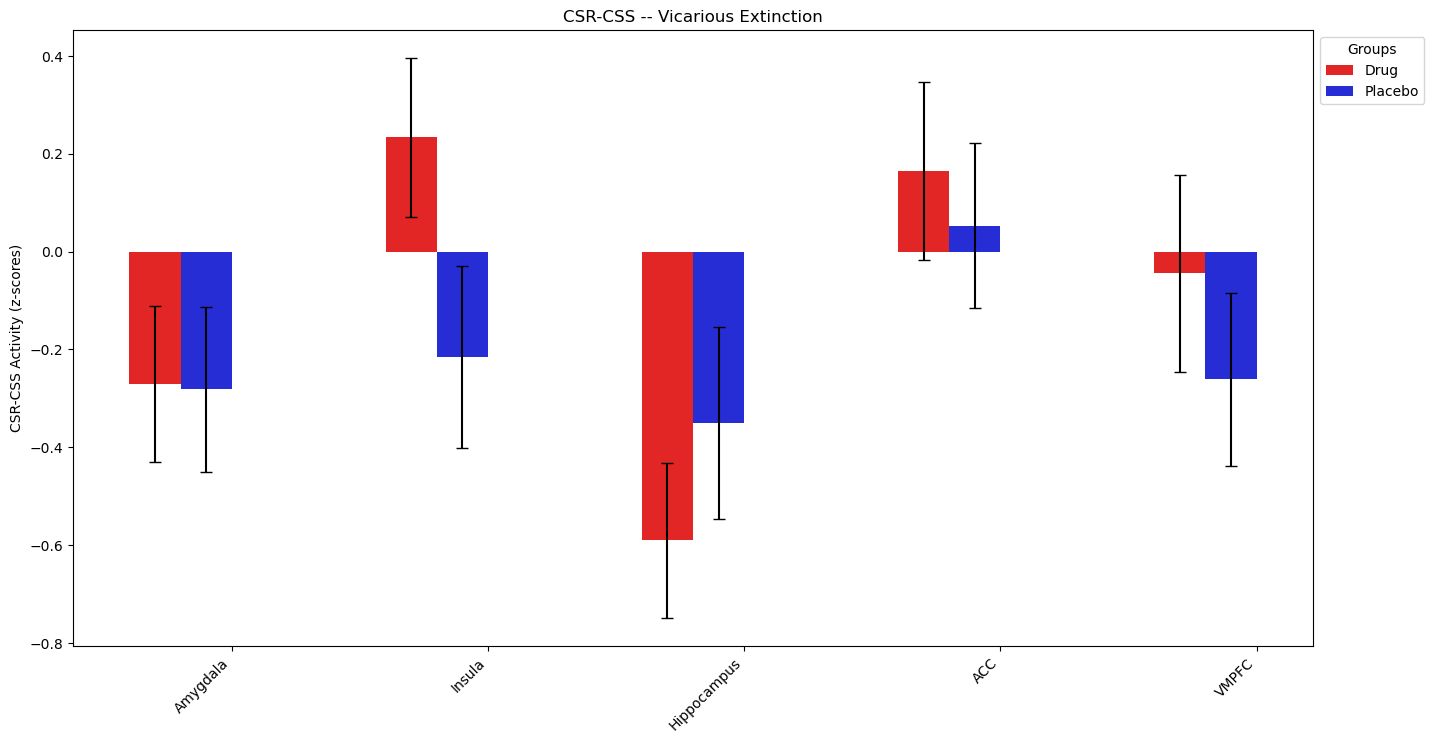

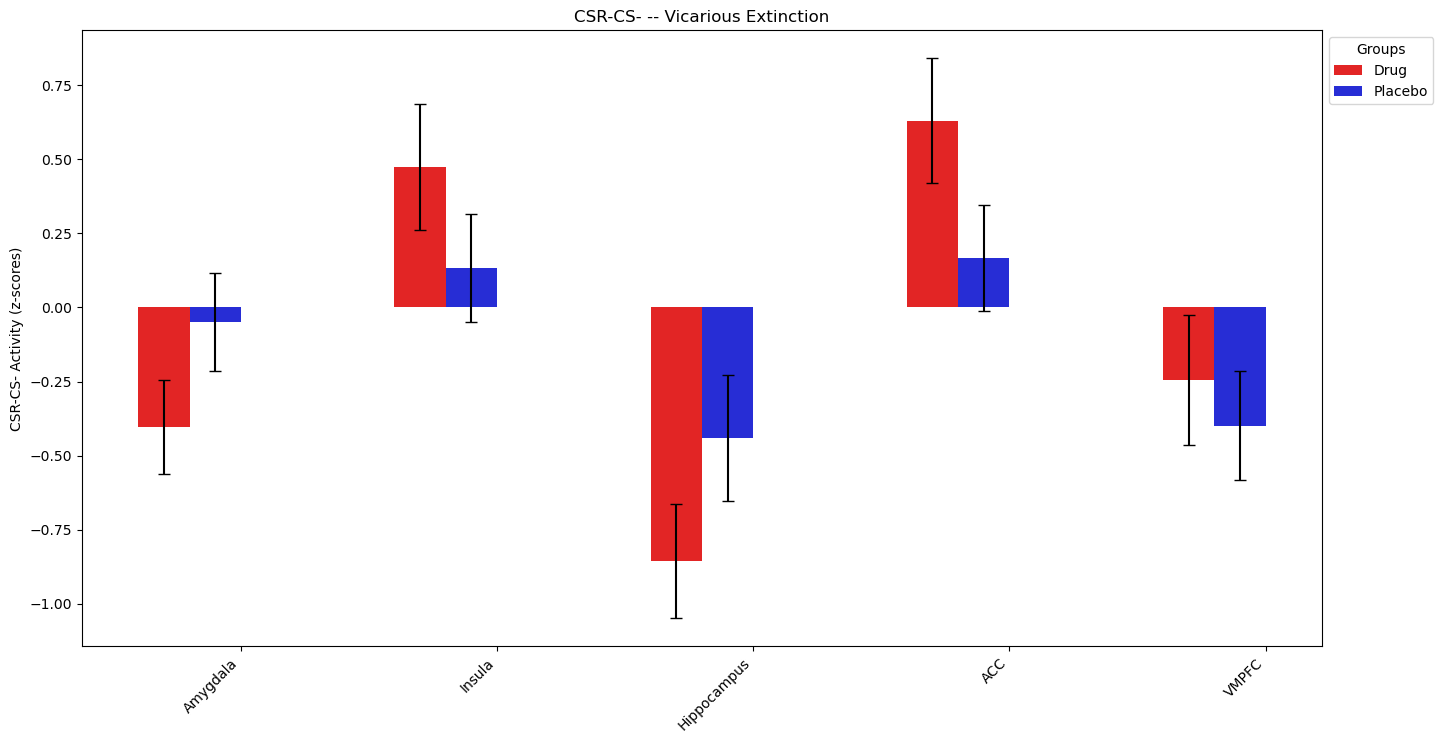

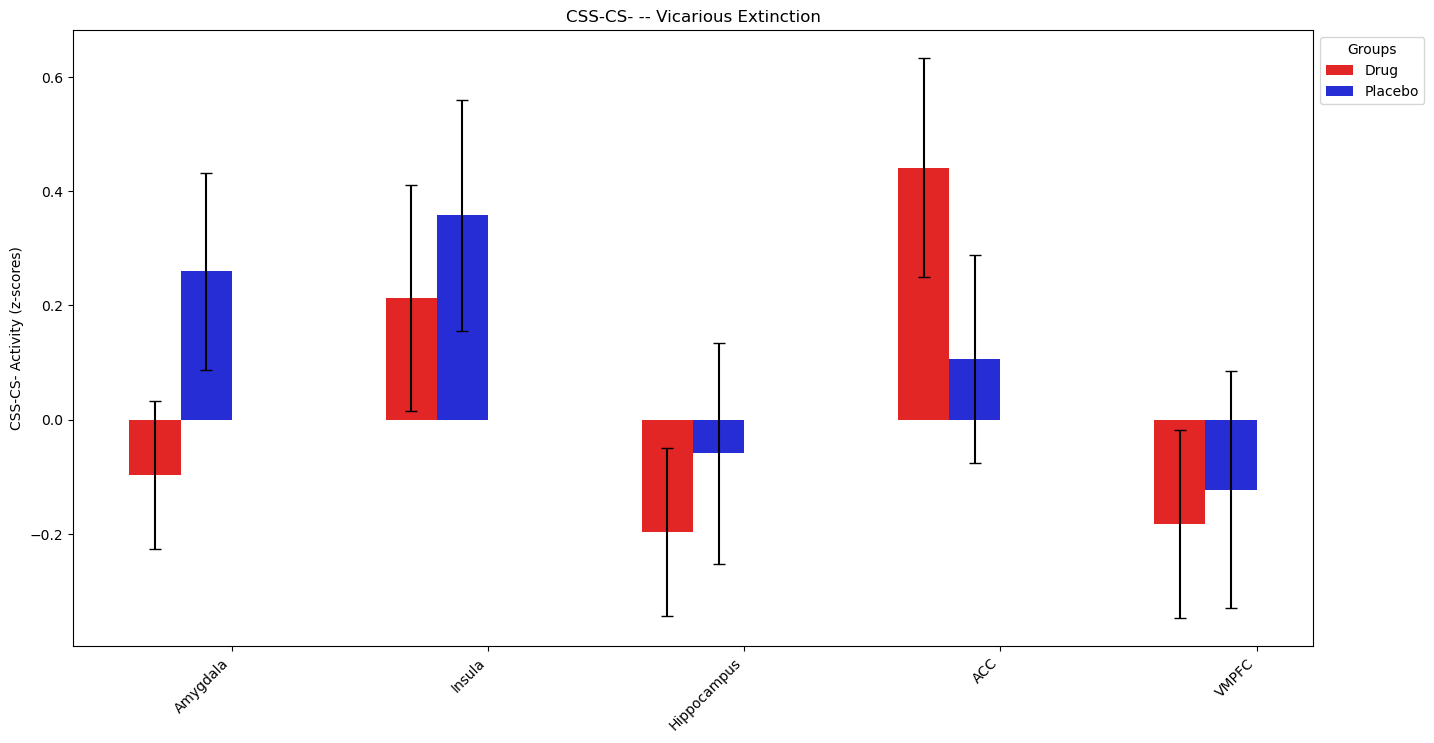

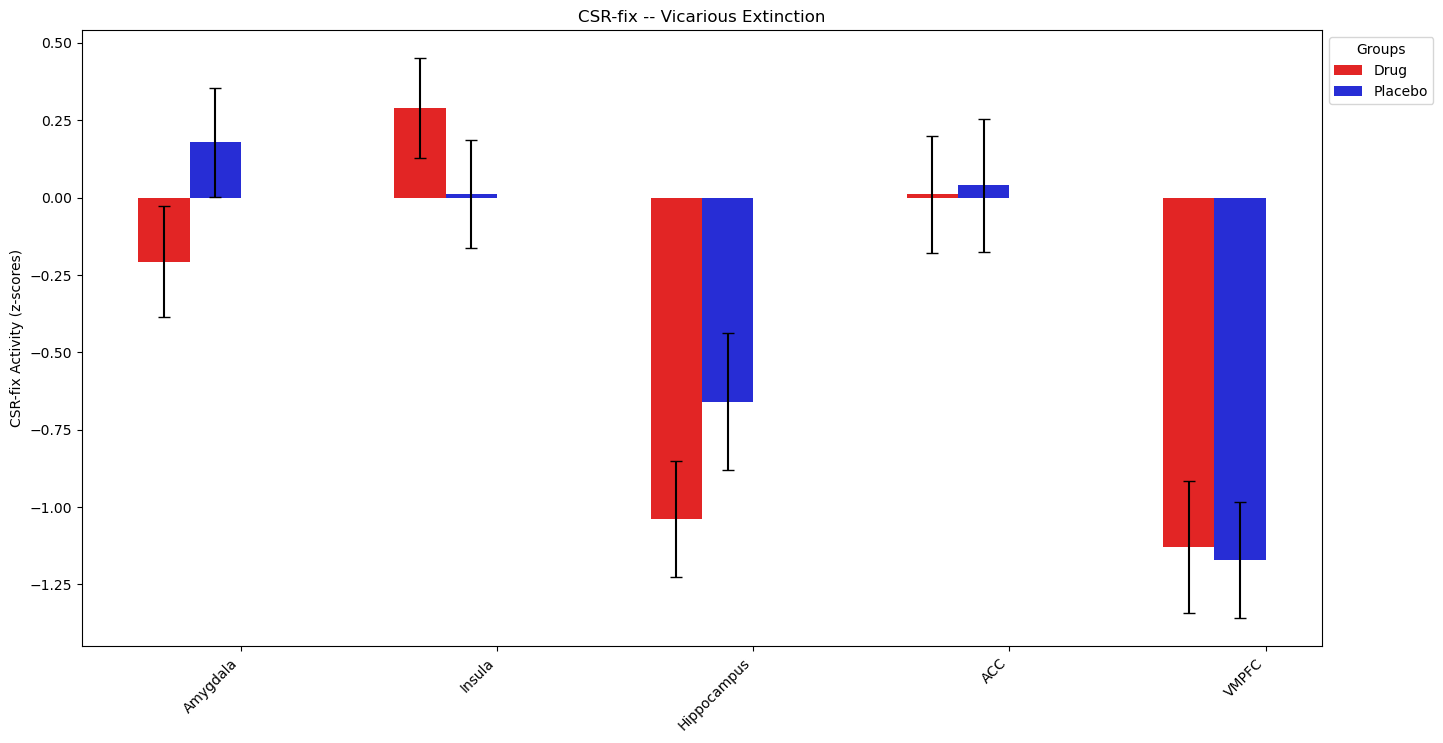

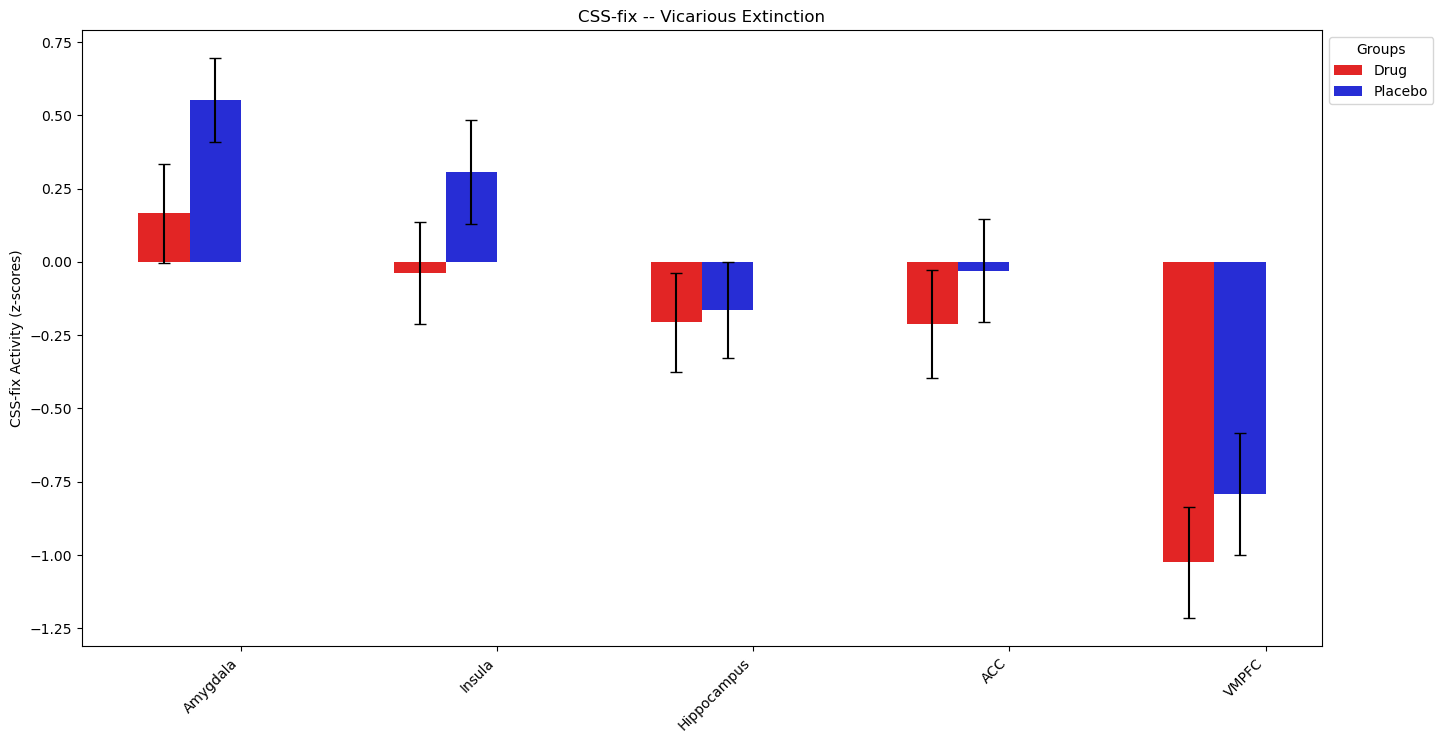

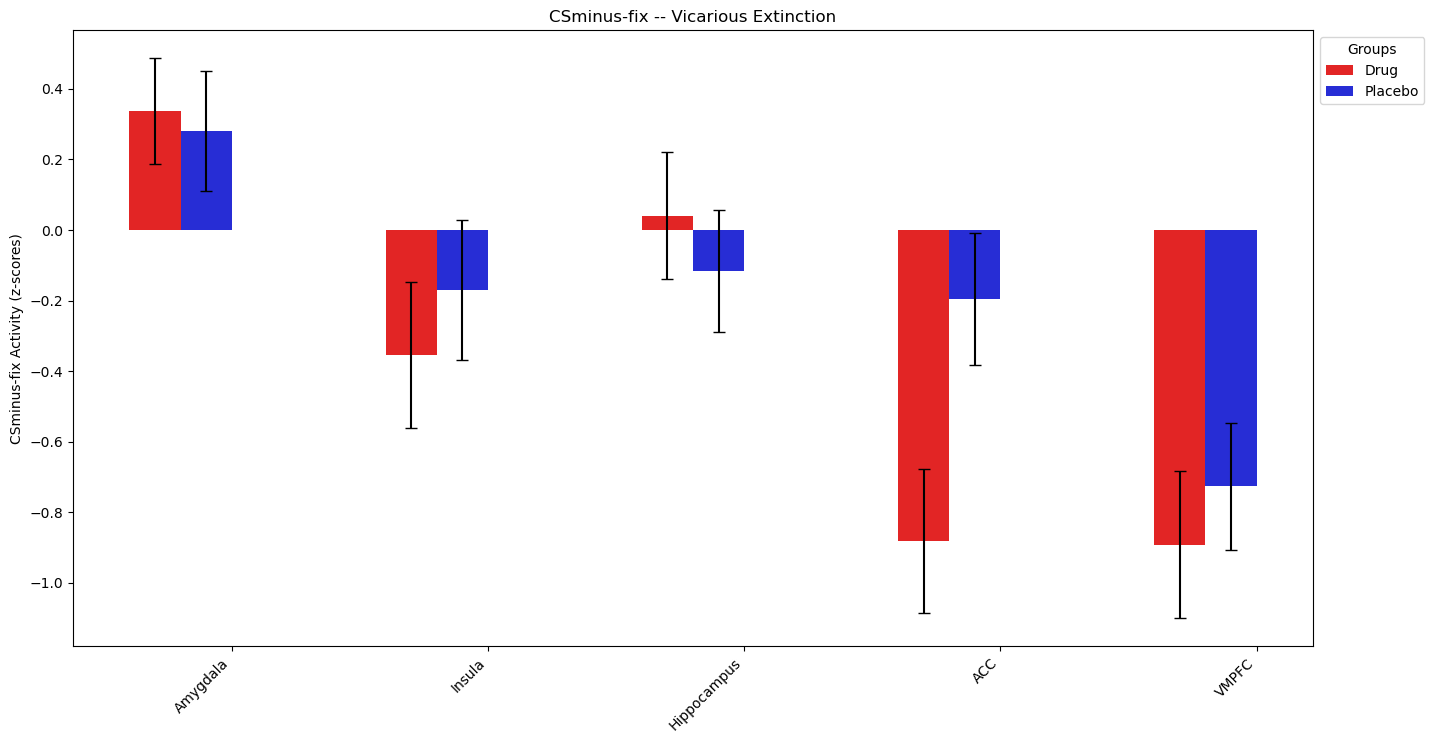

In [23]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 1]    
    placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 0]
    return drug, placebo

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for group in ['drug', 'placebo']:
            mean, se = stats[f'{group}']
            data.append({
                'Region': region,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats(data, sub_order, region_no):
    drug, placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'drug': group_stats(drug, data),
        'placebo': group_stats(placebo, data)
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ["#e22525", "#272dd5"] # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data['Mean'],
                yerr=group_data['SE'], 
                capsize=4, width=width, color=colors[i], alpha=1, label=f'{group}')
        
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'{title} -- Vicarious Extinction')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CSS'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CS-'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-CS-'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-fix'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-fix'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSminus-fix'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSminus-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSminus-fix_vicextinction.png')

#### wdrug 

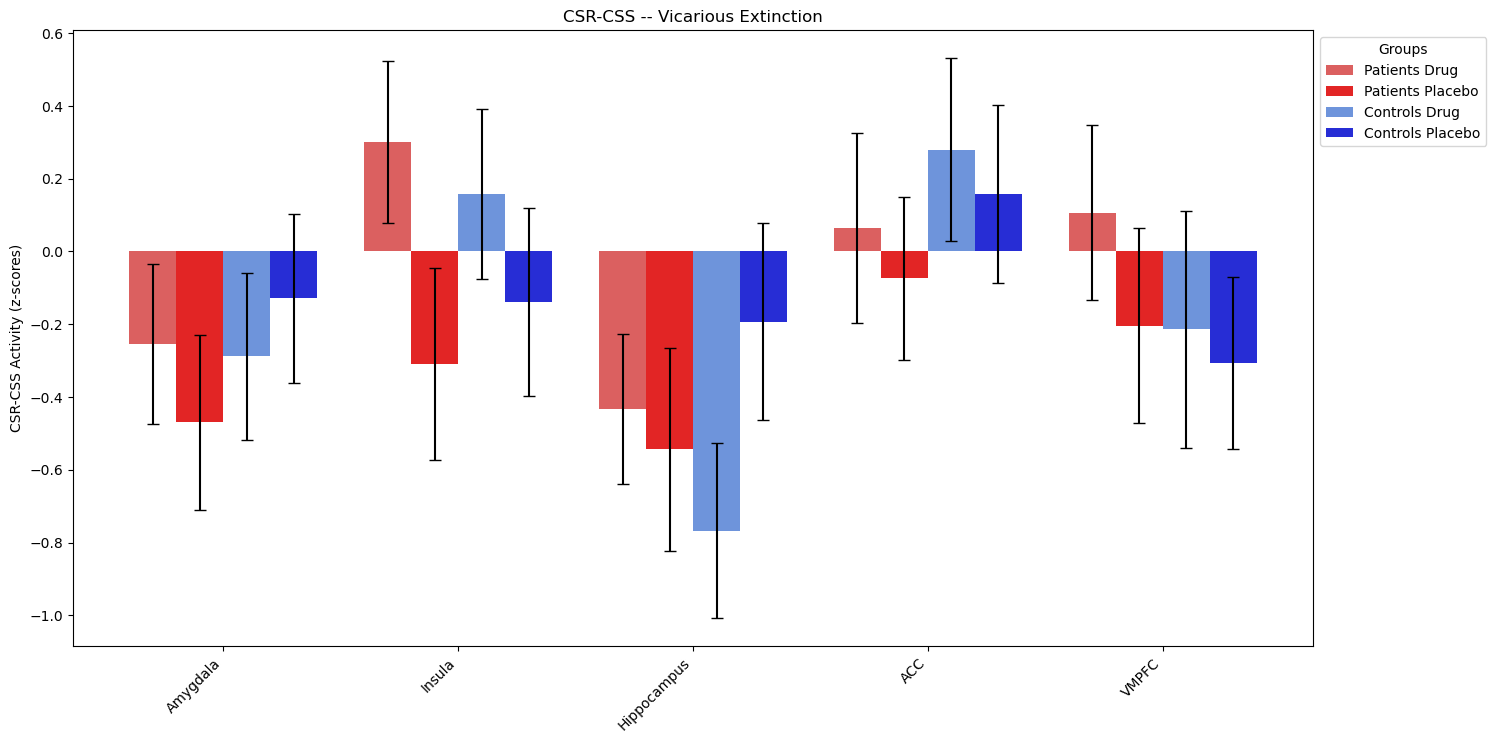

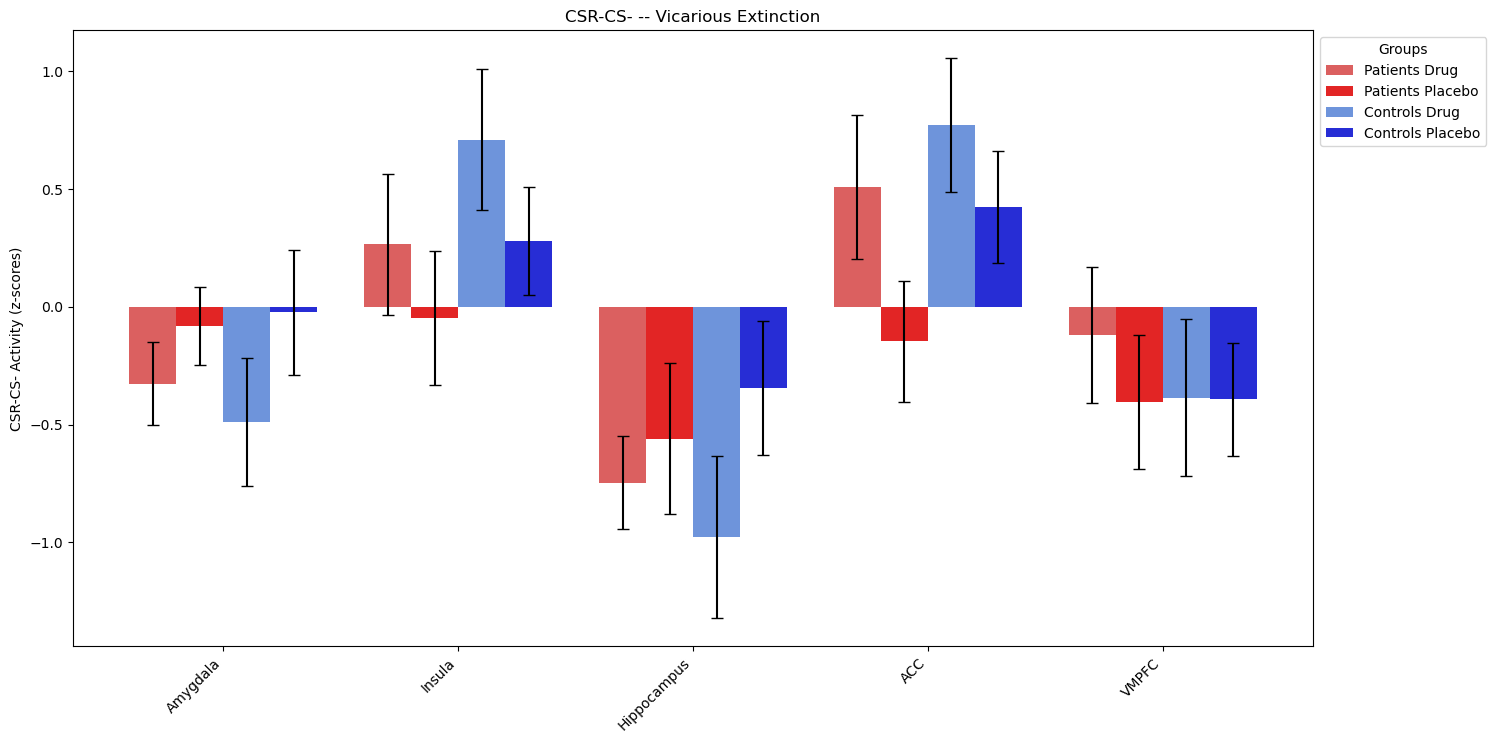

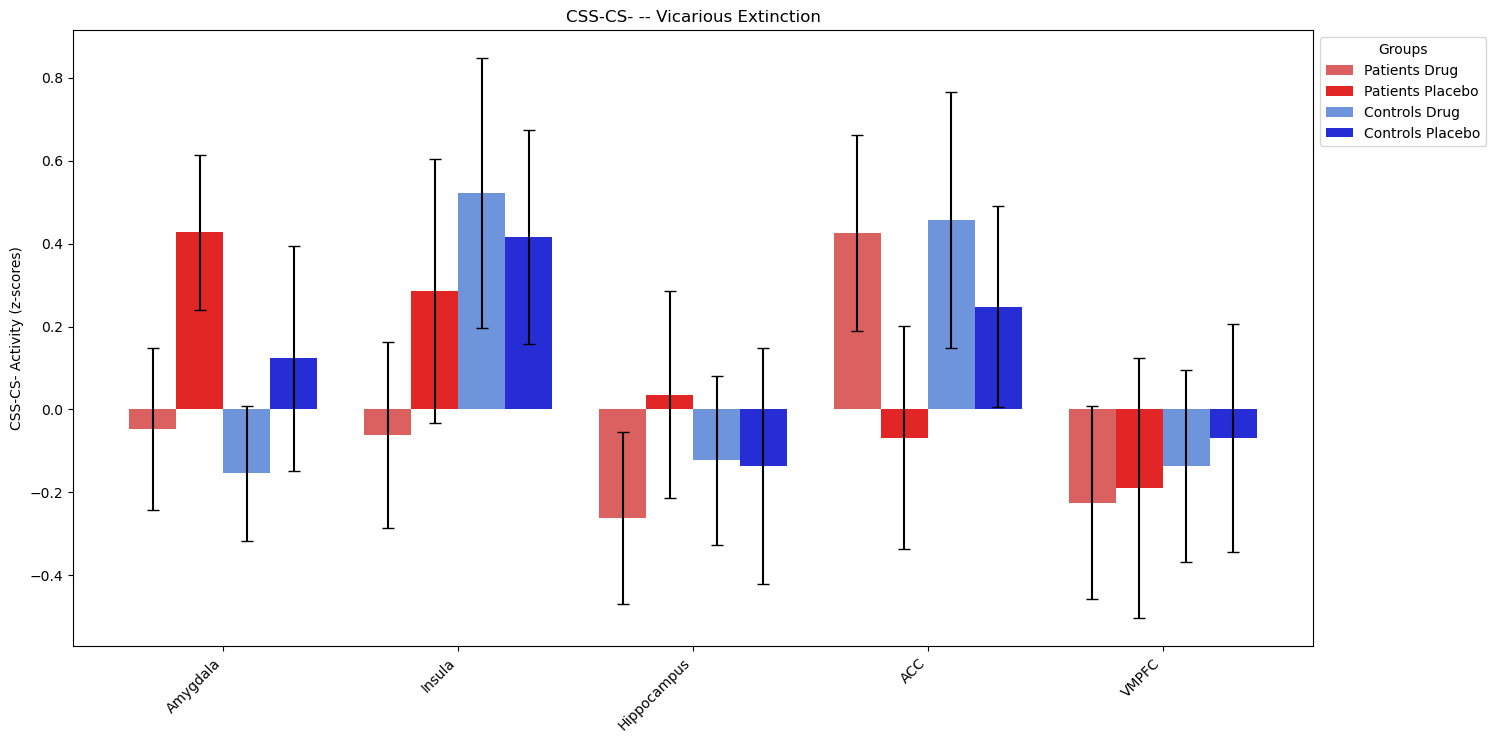

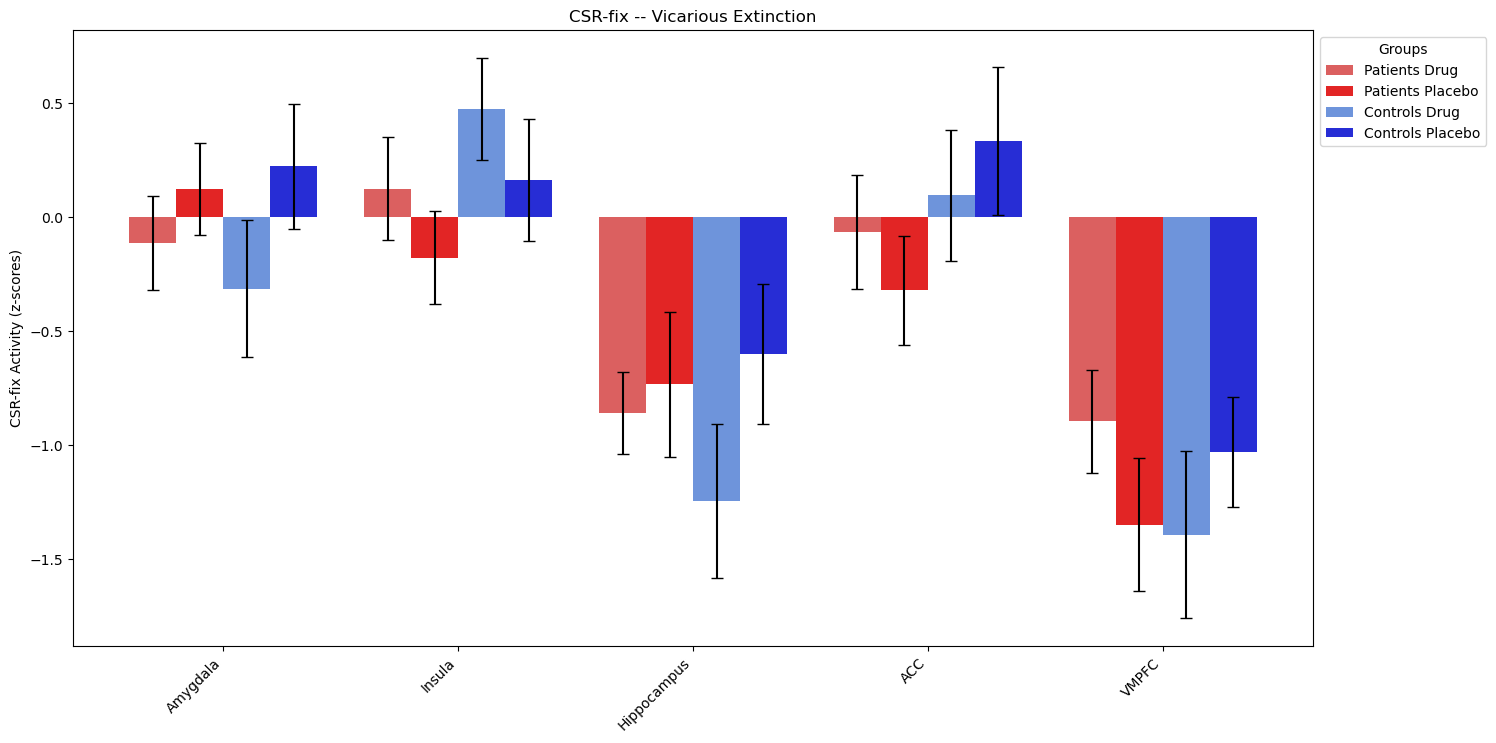

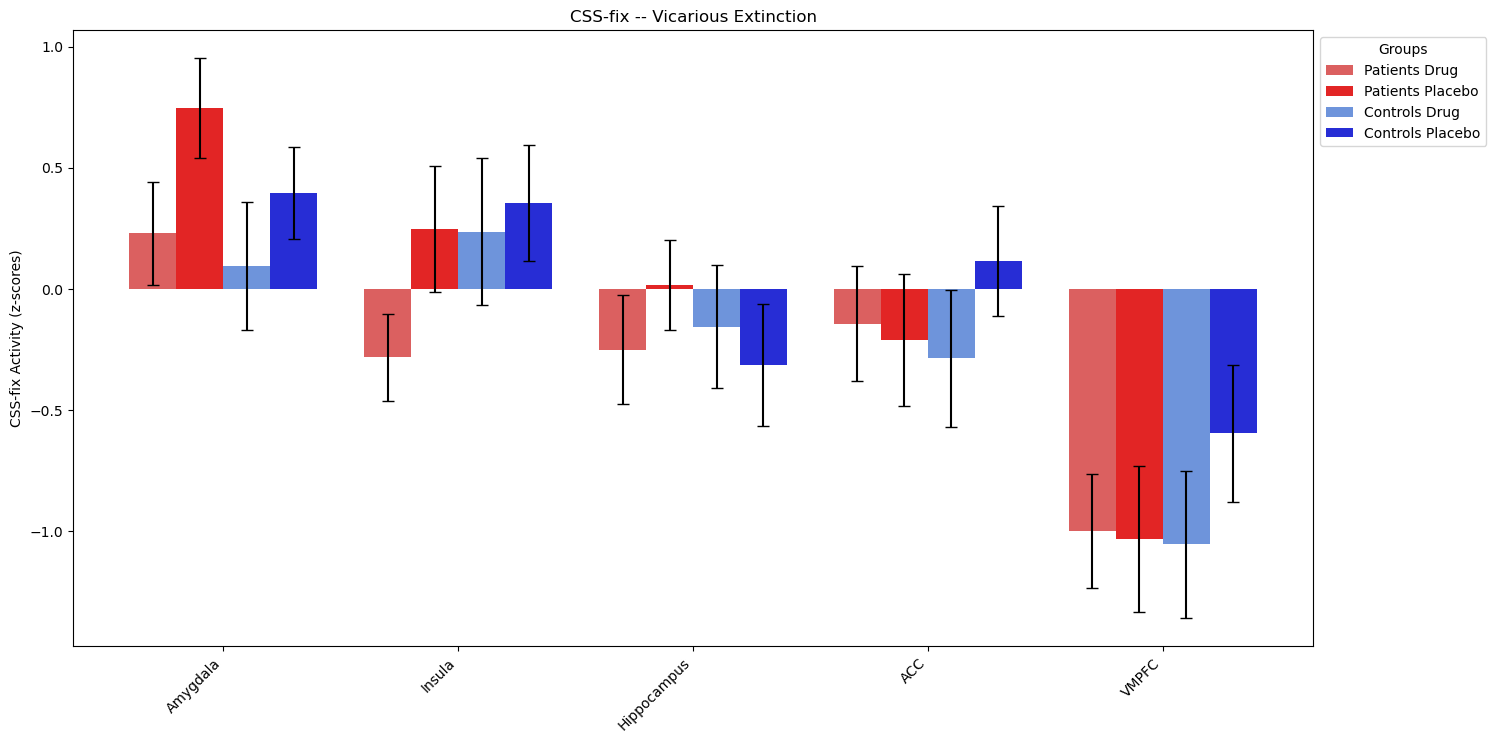

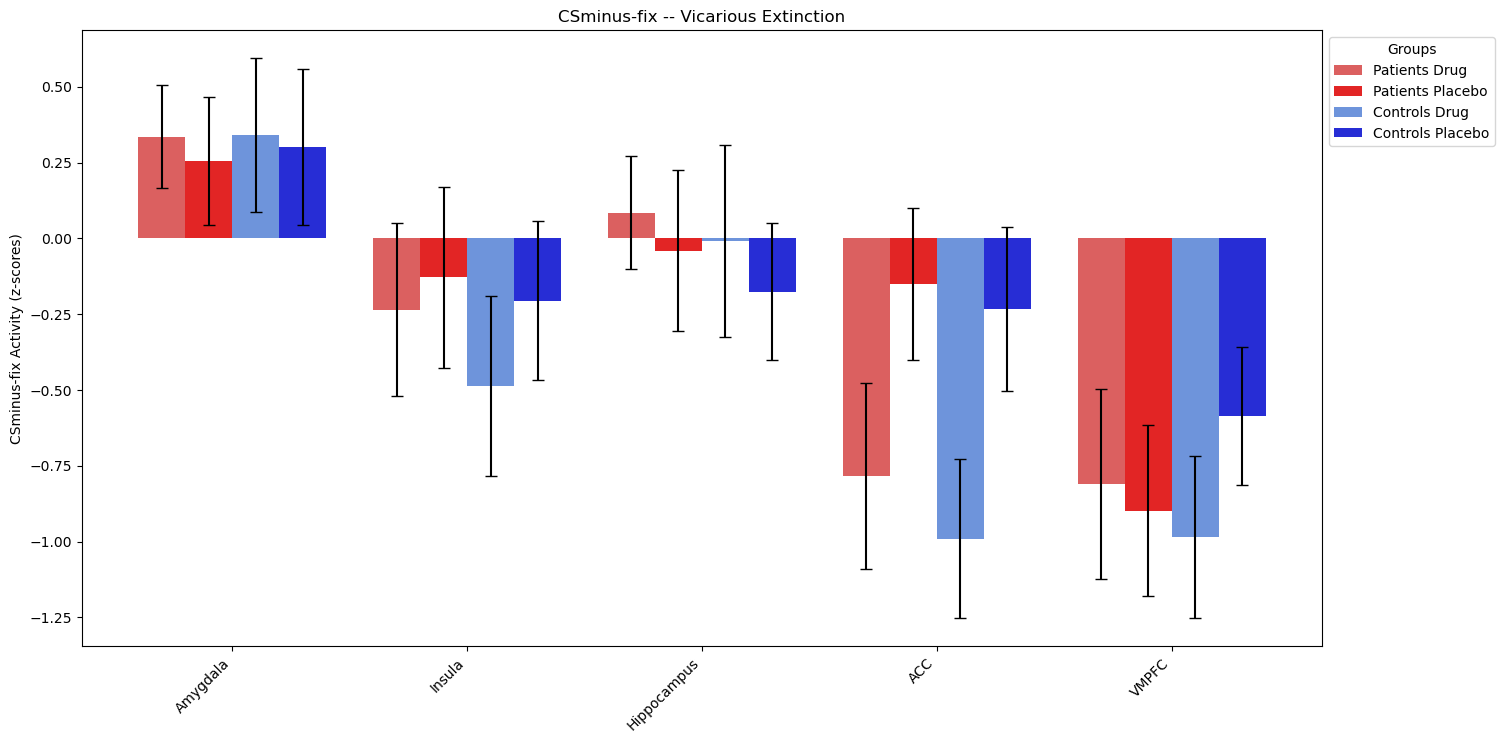

In [24]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 1]    
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            mean, se = stats[f'{group}']
            data.append({
                'Region': region,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats(data, sub_order, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'patients_drug': group_stats(patients_drug, data),
        'patients_placebo': group_stats(patients_placebo, data),
        'controls_drug': group_stats(controls_drug, data),
        'controls_placebo': group_stats(controls_placebo, data),
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ["#db6060", "#e22525", "#6e94db", "#272dd5"] # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data['Mean'],
                yerr=group_data['SE'], 
                capsize=4, width=width, color=colors[i], alpha=1, label=f'{group}')
        
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'{title} -- Vicarious Extinction')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CSS'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CS-'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-CS-'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-fix'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-fix'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSminus-fix'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSminus-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSminus-fix_vicextinction.png')

In [27]:
from scipy.stats import ttest_ind, ttest_1samp
import pandas as pd

contrast = 'CSminus-fix'

# Function to perform post-hoc comparisons and store in summary table
def perform_posthoc_tests(all_data):
    comparisons = []
    
    for region, stats in all_data.items():

        # Patients Drug vs Placebo
        groups = ['drug','placebo']
        for group_name in groups:
            t_stat, p_val = ttest_1samp(stats[group_name],0)
            comparisons.append({
            'Region': region,
            'Comparison': f'{group_name} vs. 0',
            't_stat': t_stat,
            'p_val': p_val
        })

        # Patients Drug vs Placebo
        t_stat, p_val = ttest_ind(stats['drug'], stats['placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Drug vs Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # # Controls Drug vs Placebo
        # t_stat, p_val = ttest_ind(stats['controls_drug'], stats['controls_placebo'])
        # comparisons.append({
        #     'Region': region,
        #     'Comparison': f'Controls Drug vs Placebo',
        #     't_stat': t_stat,
        #     'p_val': p_val
        # })
        
        # # Patients Drug vs Controls Drug
        # t_stat, p_val = ttest_ind(stats['patients_drug'], stats['controls_drug'])
        # comparisons.append({
        #     'Region': region,
        #     'Comparison': f'Patients Drug vs Controls Drug',
        #     't_stat': t_stat,
        #     'p_val': p_val
        # })
        
        # # Patients Placebo vs Controls Placebo
        # t_stat, p_val = ttest_ind(stats['patients_placebo'], stats['controls_placebo'])
        # comparisons.append({
        #     'Region': region,
        #     'Comparison': f'Patients Placebo vs Controls Placebo',
        #     't_stat': t_stat,
        #     'p_val': p_val
        # })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase2[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 1]    
    placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 0]
    # controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    # controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return drug, placebo

# Retrieve groups by calling the function
drug, placebo = separate_groups_by_drug(sub_order_phase2[contrast], drug_order_df)

# Now, populate all_data with actual values
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data = file_lists_phase2[contrast]
    region_all_data = {
        'drug': extract_group_data(drug, region_data, region_no),
        'placebo': extract_group_data(placebo, region_data, region_no),
        # 'controls_drug': extract_group_data(controls_drug, region_data, region_no),
        # 'controls_placebo': extract_group_data(controls_placebo, region_data, region_no),
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table
summary_table = perform_posthoc_tests(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)

Region       Comparison    t_stat     p_val
0      Amygdala       drug vs. 0  2.237798  0.029720
1      Amygdala    placebo vs. 0  1.627069  0.110270
2      Amygdala  Drug vs Placebo  0.248647  0.804154
3        Insula       drug vs. 0 -1.691698  0.096928
4        Insula    placebo vs. 0 -0.854887  0.396861
5        Insula  Drug vs Placebo -0.630031  0.530141
6   Hippocampus       drug vs. 0  0.225257  0.822698
7   Hippocampus    placebo vs. 0 -0.661195  0.511649
8   Hippocampus  Drug vs Placebo  0.620117  0.536620
9           ACC       drug vs. 0 -4.275300  0.000086
10          ACC    placebo vs. 0 -1.037013  0.304926
11          ACC  Drug vs Placebo -2.448476  0.016124
12        VMPFC       drug vs. 0 -4.249186  0.000093
13        VMPFC    placebo vs. 0 -4.007883  0.000213
14        VMPFC  Drug vs Placebo -0.596910  0.551944

In [79]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast = 'CSS-CS-'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
data = extract_contrast_data(file_lists_phase2, contrast, regions_of_interest, sub_order_phase2)

# Function to prepare regression data
def prepare_regression_data(dataex, sub_order, drug_order_df):
    data = []
    
    for region in dataex.keys():
        for idx, sub in enumerate(sub_order['CSR-CSS']):
            subID = sub[3:7]
            values = [dataex[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for y in values:
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(data, sub_order_phase2, drug_order_df)

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ DrugOrder * PatientGroup + DrugOrder * Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.7644
Date:                Fri, 19 Sep 2025   Prob (F-statistic):              0.578
Time:                        15:48:13   Log-Likelihood:                -148.24
No. Observations:                 100   AIC:                             308.5
Df Residuals:                      94   BIC:                             324.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
I

### reinstatement - second-level

In [83]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast = 'CSS-CS-'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
data = extract_contrast_data(file_lists_phase3, contrast, regions_of_interest, sub_order_phase3)

# Function to prepare regression data
def prepare_regression_data(dataex, sub_order, drug_order_df):
    data = []
    
    for region in dataex.keys():
        for idx, sub in enumerate(sub_order['CSR-CSS']):
            subID = sub[3:7]
            values = [dataex[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for y in values:
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(data, sub_order_phase3, drug_order_df)

# ✅ Only keep placebo (DrugOrder == 0)
df = df[df['DrugOrder'] == 0]

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ PatientGroup + Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.6653
Date:                Fri, 19 Sep 2025   Prob (F-statistic):              0.519
Time:                        15:57:32   Log-Likelihood:                -81.463
No. Observations:                  50   AIC:                             168.9
Df Residuals:                      47   BIC:                             174.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.58

In [84]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast = 'CSS-CS-'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
data = extract_contrast_data(file_lists_phase3, contrast, regions_of_interest, sub_order_phase3)

# Function to prepare regression data
def prepare_regression_data(dataex, sub_order, drug_order_df):
    data = []
    
    for region in dataex.keys():
        for idx, sub in enumerate(sub_order['CSR-CSS']):
            subID = sub[3:7]
            values = [dataex[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for y in values:
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(data, sub_order_phase3, drug_order_df)

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ DrugOrder * PatientGroup + DrugOrder * Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.3794
Date:                Fri, 19 Sep 2025   Prob (F-statistic):              0.862
Time:                        15:59:13   Log-Likelihood:                -165.67
No. Observations:                 101   AIC:                             343.3
Df Residuals:                      95   BIC:                             359.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
I

##### drug vs group post-hoc

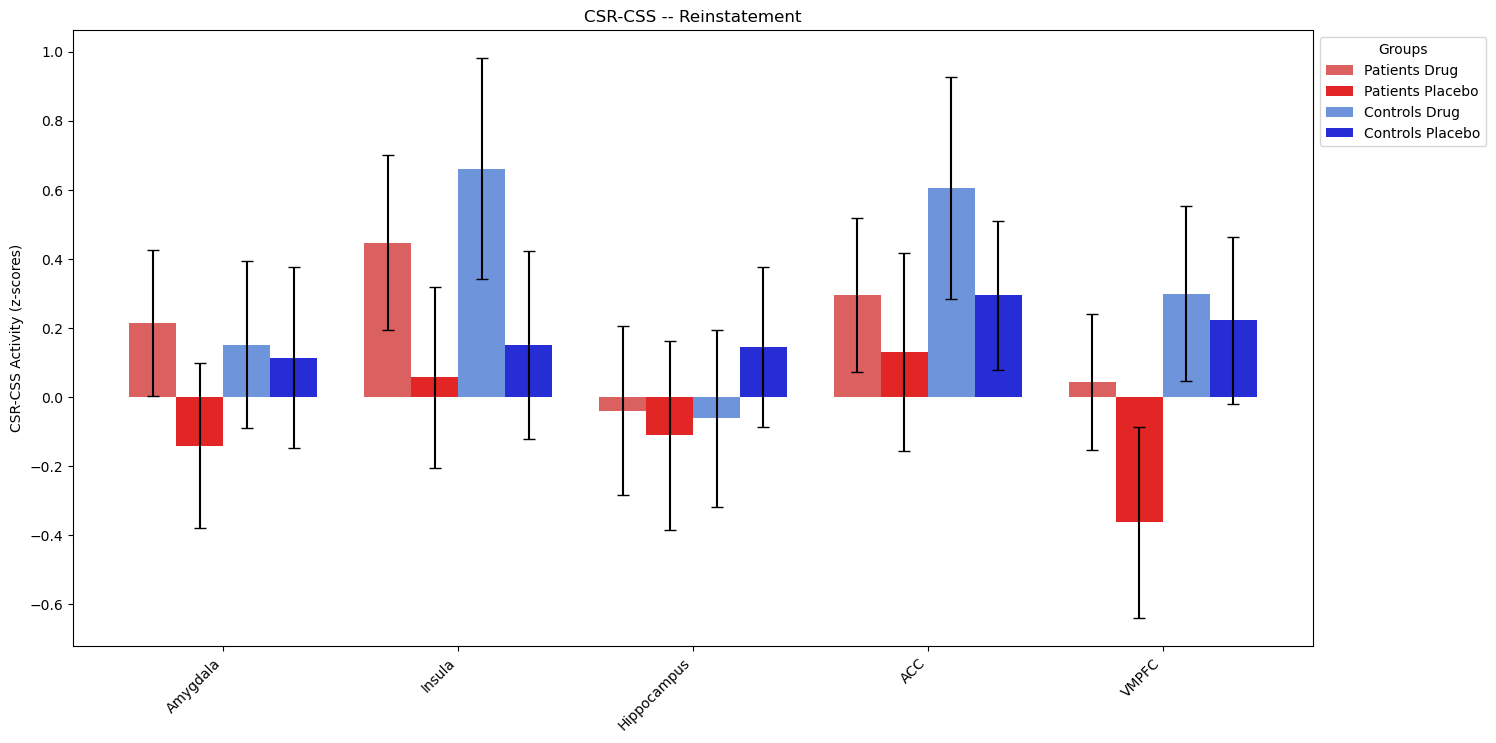

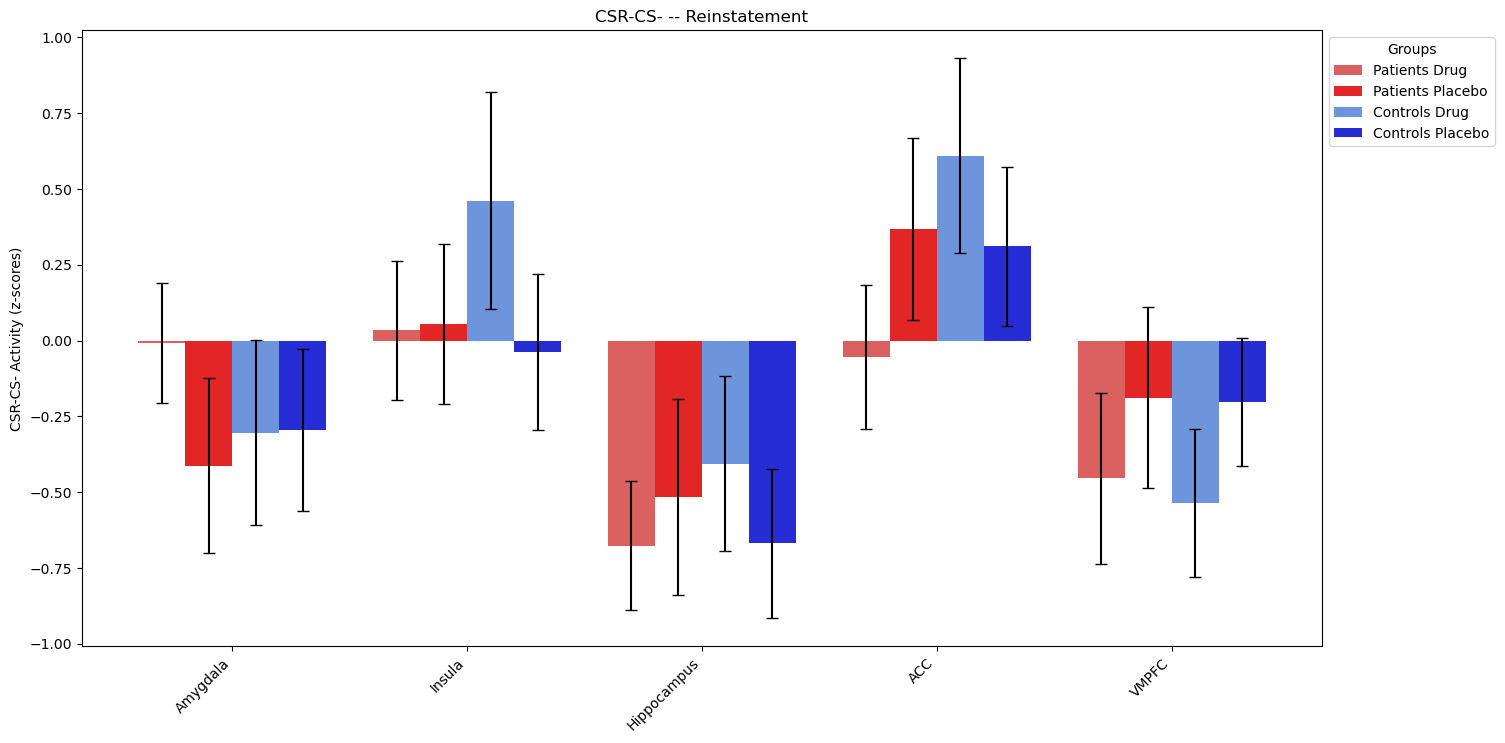

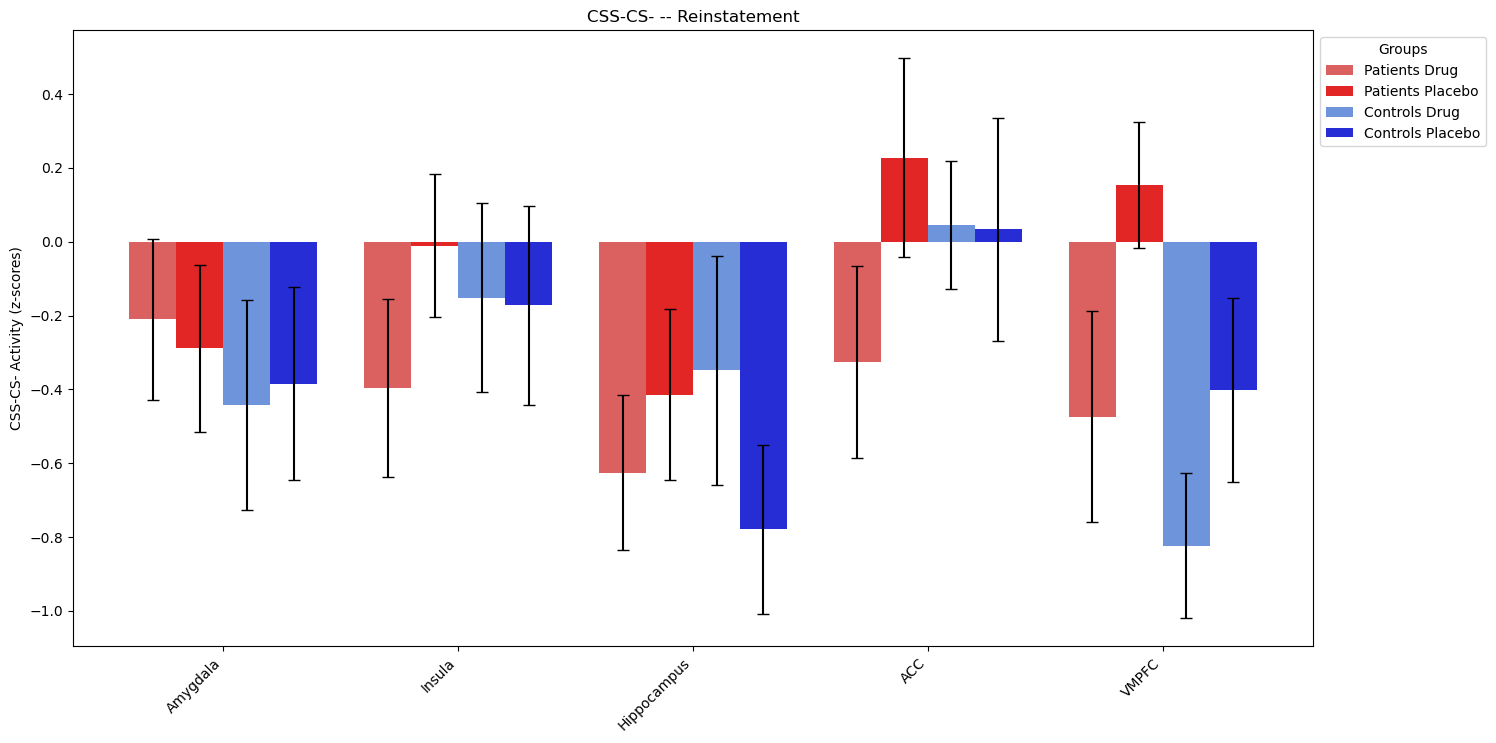

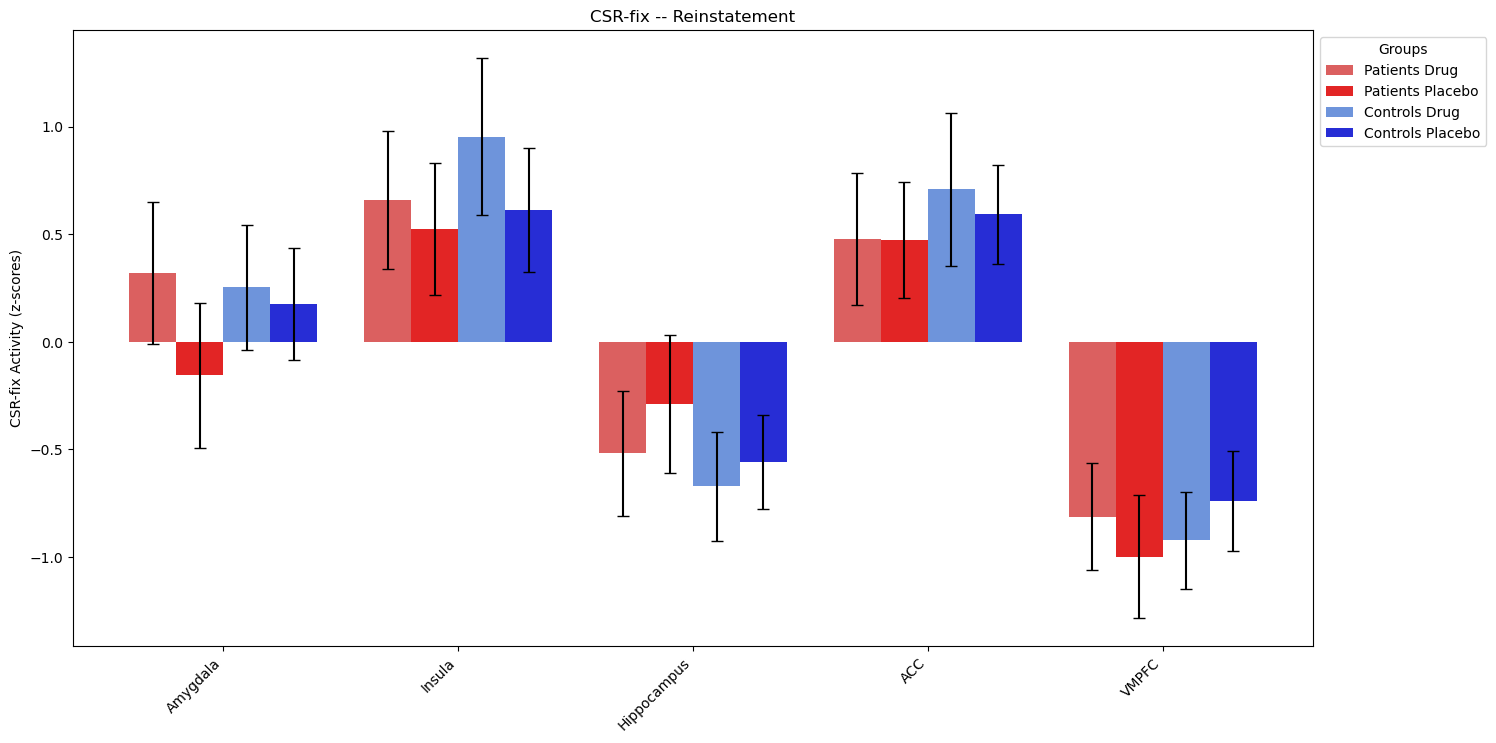

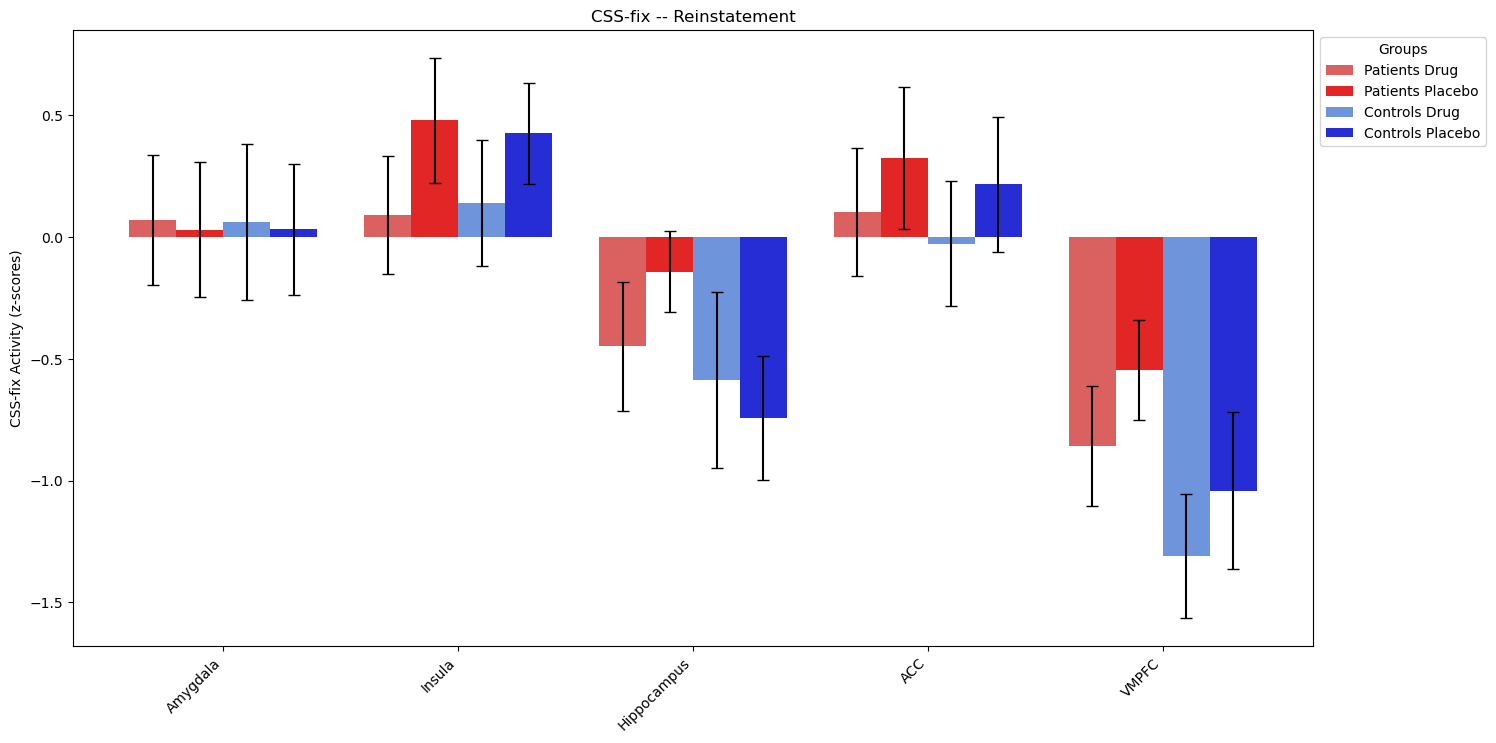

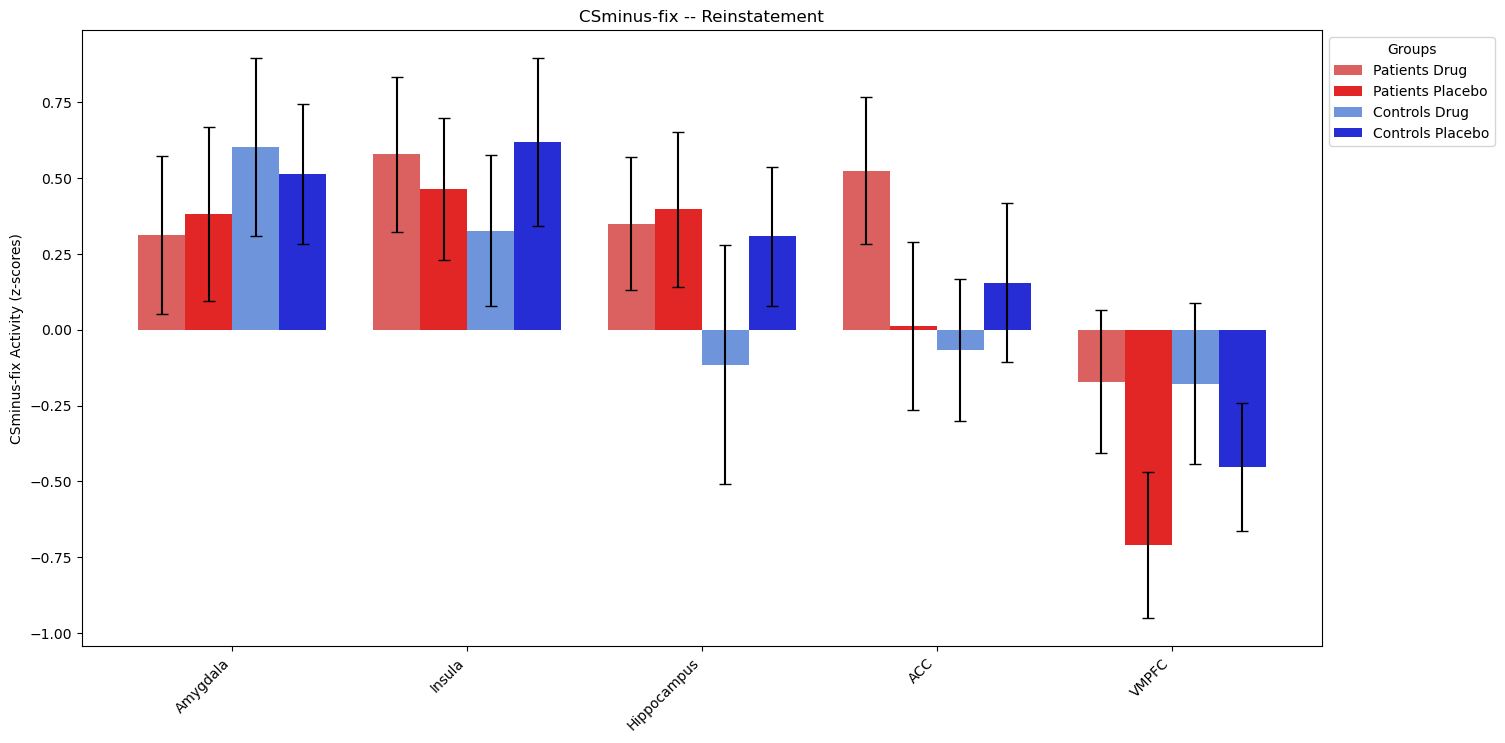

In [29]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 1]    
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            mean, se = stats[f'{group}']
            data.append({
                'Region': region,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats(data, sub_order, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'patients_drug': group_stats(patients_drug, data),
        'patients_placebo': group_stats(patients_placebo, data),
        'controls_drug': group_stats(controls_drug, data),
        'controls_placebo': group_stats(controls_placebo, data),
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ["#db6060", "#e22525", "#6e94db", "#272dd5"] # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data['Mean'],
                yerr=group_data['SE'], 
                capsize=4, width=width, color=colors[i], alpha=1, label=f'{group}')
        
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'{title} -- Reinstatement')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()


# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CSS'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CS-'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-CS-'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-fix'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-fix'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSminus-fix'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSminus-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSminus-fix_vicextinction.png')


In [32]:
from scipy.stats import ttest_ind, ttest_1samp
import pandas as pd

contrast = 'CSminus-fix'

# Function to perform post-hoc comparisons and store in summary table
def perform_posthoc_tests(all_data):
    comparisons = []
    
    for region, stats in all_data.items():

        # Patients Drug vs Placebo
        groups = ['patients_drug','patients_placebo','controls_drug','controls_placebo']
        for group_name in groups:
            t_stat, p_val = ttest_1samp(stats[group_name],0)
            comparisons.append({
            'Region': region,
            'Comparison': f'{group_name} vs. 0',
            't_stat': t_stat,
            'p_val': p_val
        })

        # Patients Drug vs Placebo
        t_stat, p_val = ttest_ind(stats['patients_drug'], stats['patients_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Patients Drug vs Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Controls Drug vs Placebo
        t_stat, p_val = ttest_ind(stats['controls_drug'], stats['controls_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Controls Drug vs Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Patients Drug vs Controls Drug
        t_stat, p_val = ttest_ind(stats['patients_drug'], stats['controls_drug'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Patients Drug vs Controls Drug',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Patients Placebo vs Controls Placebo
        t_stat, p_val = ttest_ind(stats['patients_placebo'], stats['controls_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Patients Placebo vs Controls Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase3[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 1]    
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# Retrieve groups by calling the function
patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order_phase3[contrast], drug_order_df)

# Now, populate all_data with actual values
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data = file_lists_phase3[contrast]
    region_all_data = {
        'patients_drug': extract_group_data(patients_drug, region_data, region_no),
        'patients_placebo': extract_group_data(patients_placebo, region_data, region_no),
        'controls_drug': extract_group_data(controls_drug, region_data, region_no),
        'controls_placebo': extract_group_data(controls_placebo, region_data, region_no),
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table
summary_table = perform_posthoc_tests(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


Region                            Comparison    t_stat     p_val
0      Amygdala                   patients_drug vs. 0  1.179940  0.248708
1      Amygdala                patients_placebo vs. 0  1.297416  0.208561
2      Amygdala                   controls_drug vs. 0  2.012903  0.055975
3      Amygdala                controls_placebo vs. 0  2.181336  0.038041
4      Amygdala              Patients Drug vs Placebo -0.175362  0.861548
5      Amygdala              Controls Drug vs Placebo  0.235670  0.814651
6      Amygdala        Patients Drug vs Controls Drug -0.728814  0.469585
7      Amygdala  Patients Placebo vs Controls Placebo -0.354828  0.724273
8        Insula                   patients_drug vs. 0  2.216959  0.035578
9        Insula                patients_placebo vs. 0  1.931777  0.066993
10       Insula                   controls_drug vs. 0  1.294814  0.208232
11       Insula                controls_placebo vs. 0  2.192756  0.037120
12       Insula              Patients Drug vs Placebo  0.317064  0.752599
13       Insula              Controls Drug vs Placebo -0.757710  0.452181
14       Insula        Patients Drug vs Controls Drug  0.687951  0.494728
15       Insula  Patients Placebo vs Controls Placebo -0.403203  0.688590
16  Hippocampus                   patients_drug vs. 0  1.560364  0.130765
17  Hippocampus                patients_placebo vs. 0  1.518861  0.143710
18  Hippocampus                   controls_drug vs. 0 -0.285485  0.777828
19  Hippocampus                controls_placebo vs. 0  1.316111  0.199202
20  Hippocampus              Patients Drug vs Placebo -0.135821  0.892543
21  Hippocampus              Controls Drug vs Placebo -0.940054  0.351709
22  Hippocampus        Patients Drug vs Controls Drug  1.039473  0.303687
23  Hippocampus  Patients Placebo vs Controls Placebo  0.253375  0.801061
24          ACC                   patients_drug vs. 0  2.132362  0.042588
25          ACC                patients_placebo vs. 0  0.045665  0.964008
26          ACC                   controls_drug vs. 0 -0.281127  0.781126
27          ACC                controls_placebo vs. 0  0.580796  0.566195
28          ACC              Patients Drug vs Placebo  1.366392  0.178318
29          ACC              Controls Drug vs Placebo -0.611202  0.543835
30          ACC        Patients Drug vs Controls Drug  1.716124  0.092456
31          ACC  Patients Placebo vs Controls Placebo -0.361355  0.719420
32        VMPFC                   patients_drug vs. 0 -0.713506  0.481889
33        VMPFC                patients_placebo vs. 0 -2.875899  0.009045
34        VMPFC                   controls_drug vs. 0 -0.657269  0.517532
35        VMPFC                controls_placebo vs. 0 -2.105977  0.044644
36        VMPFC              Patients Drug vs Placebo  1.550357  0.127764
37        VMPFC              Controls Drug vs Placebo  0.807572  0.423163
38        VMPFC        Patients Drug vs Controls Drug  0.016058  0.987254
39        VMPFC  Patients Placebo vs Controls Placebo -0.788067  0.434532

##### drug vs gender post-hoc

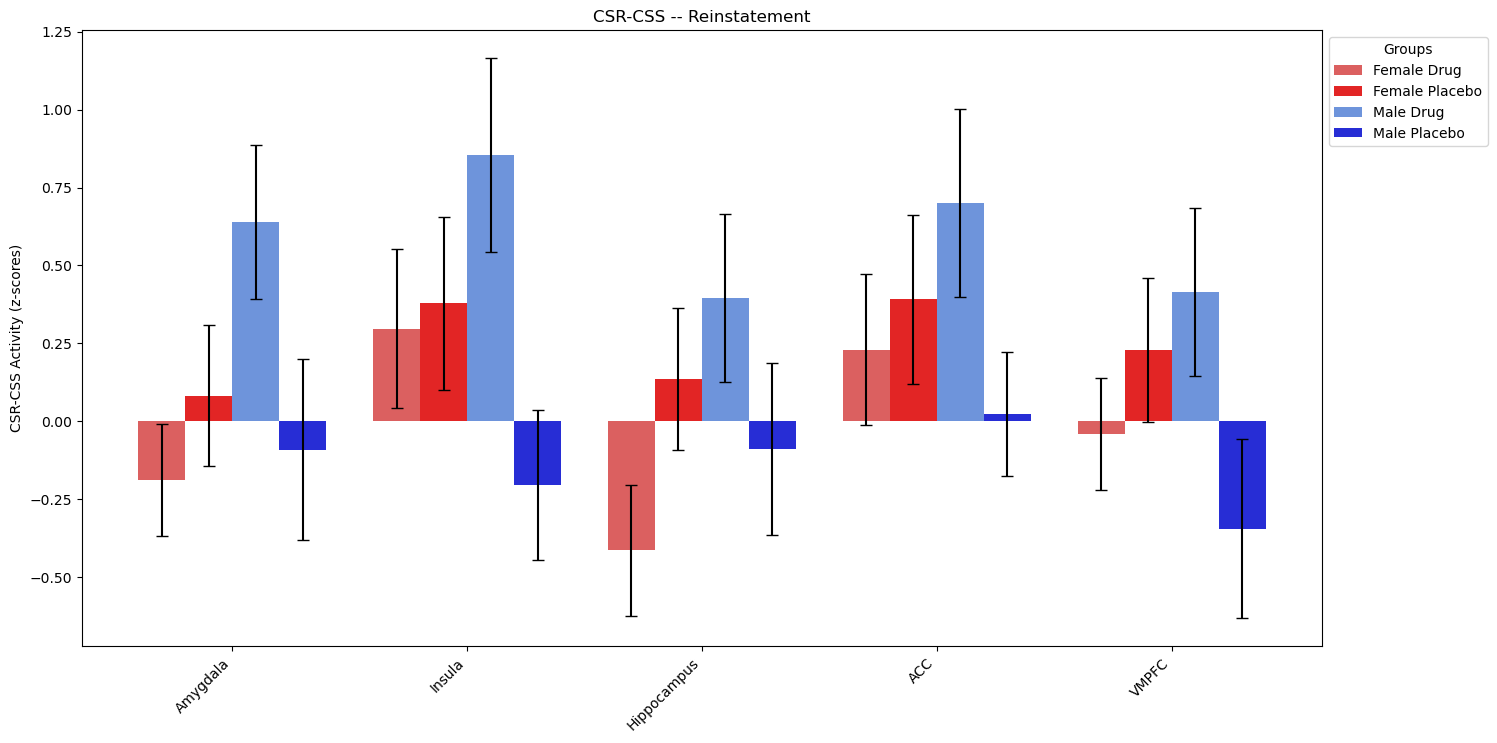

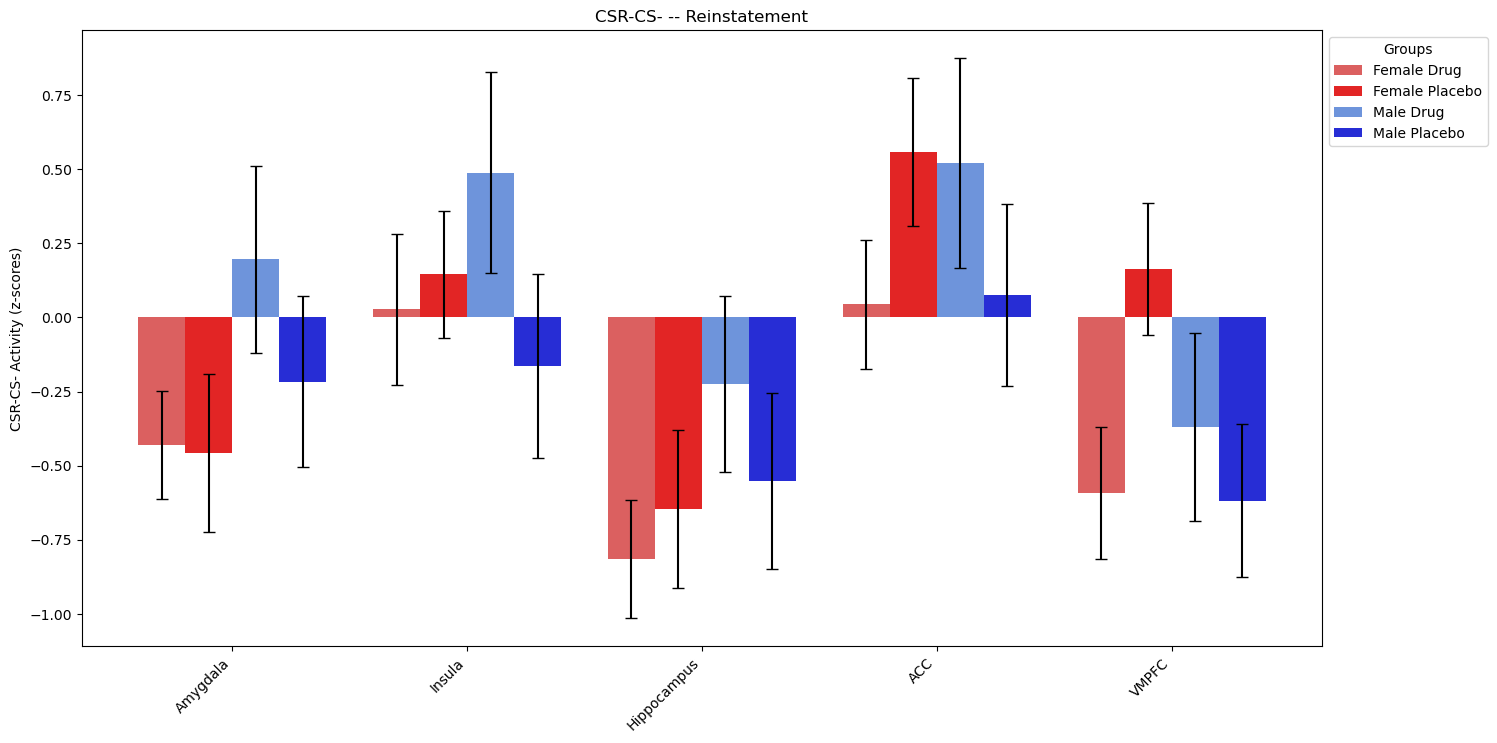

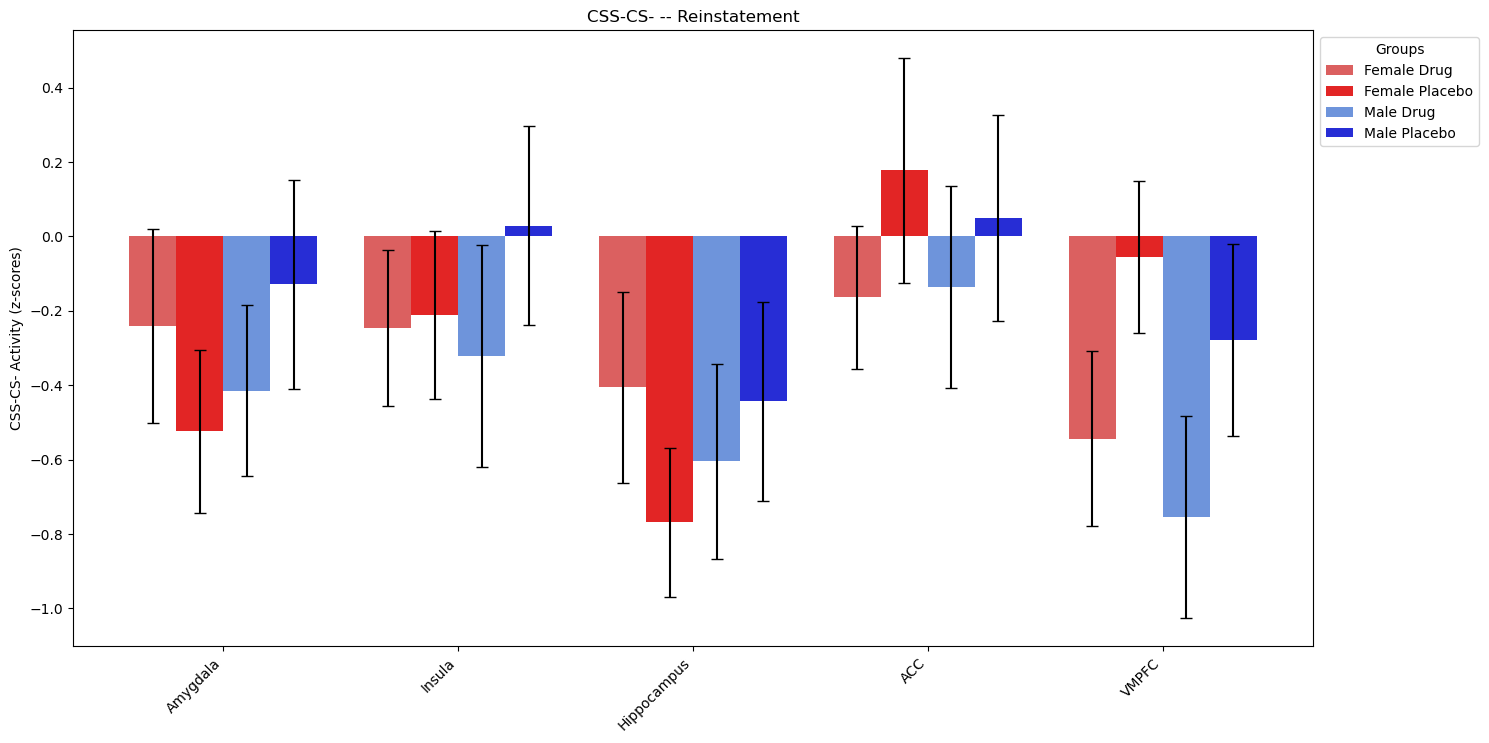

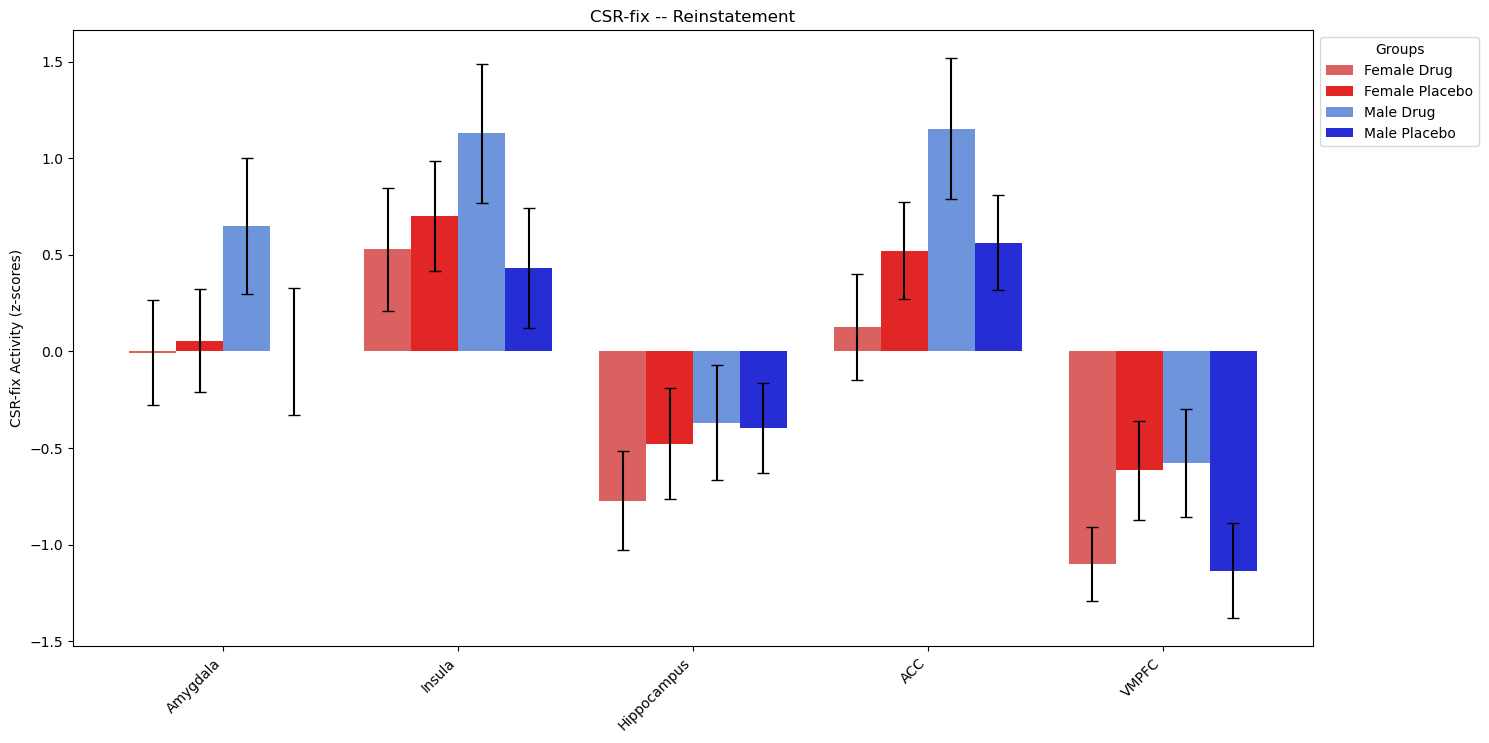

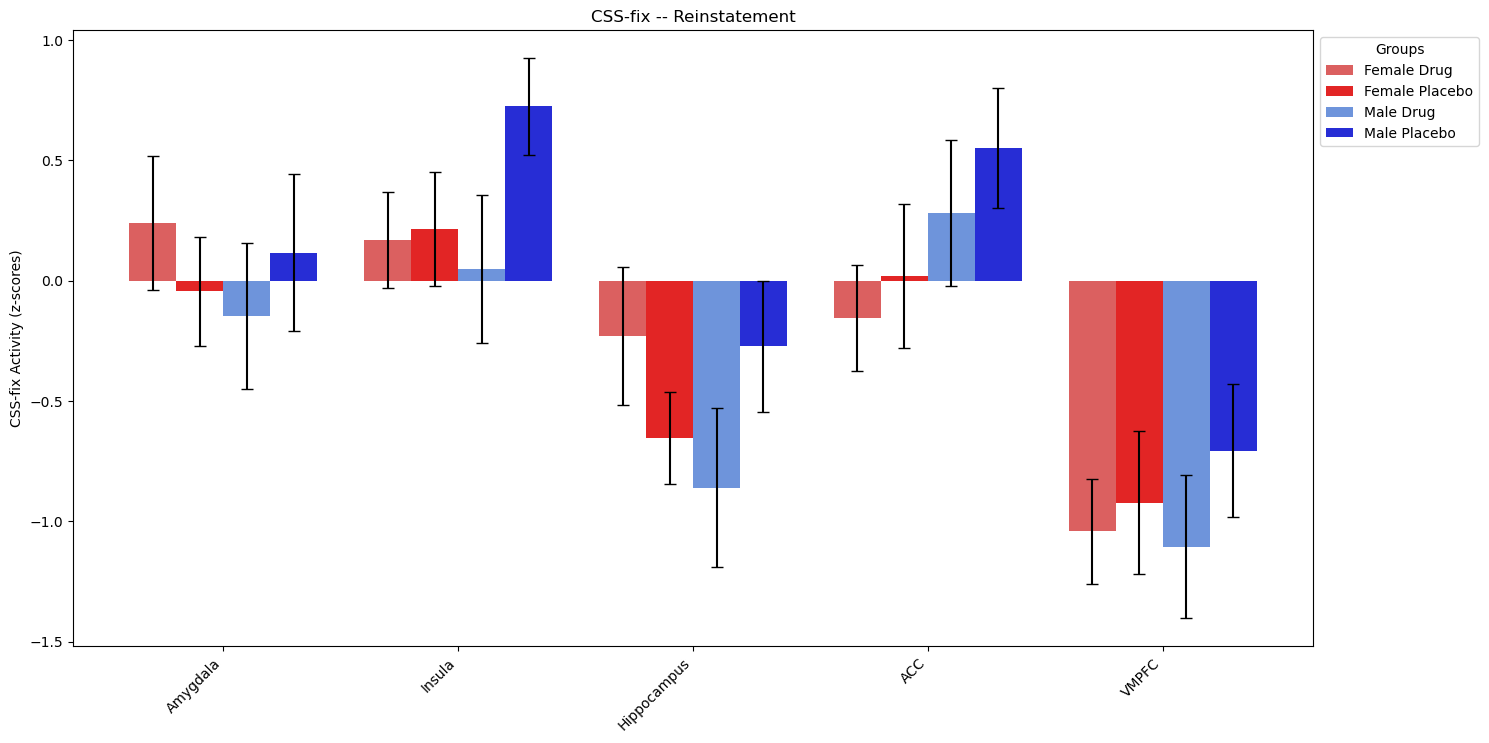

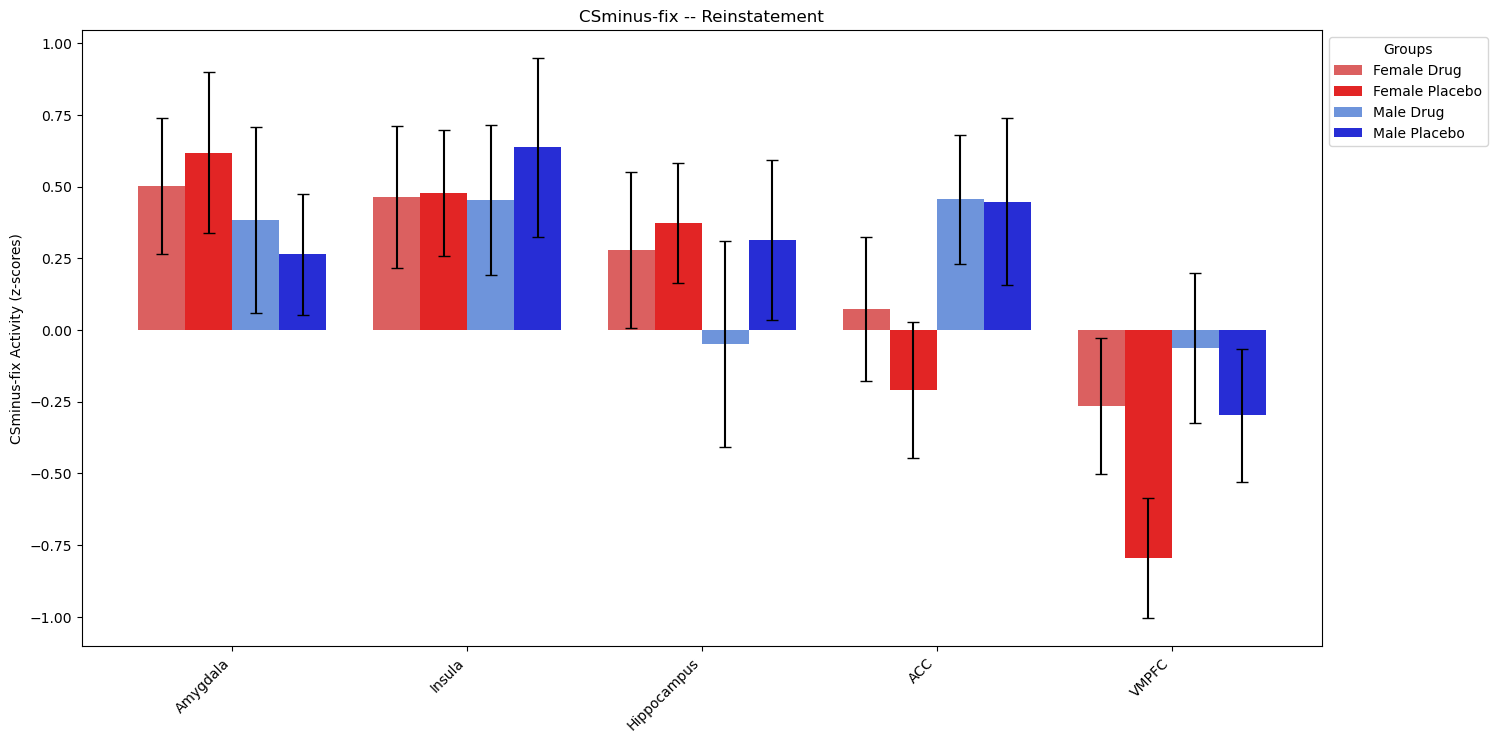

In [33]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    female_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 1 and drug_order.loc[sub[3:7]].values[3] == 0]    
    female_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 0 and drug_order.loc[sub[3:7]].values[1] == 0]
    male_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 1 and drug_order.loc[sub[3:7]].values[1] == 1]
    male_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 1 and drug_order.loc[sub[3:7]].values[1] == 0]
    return female_drug, female_placebo, male_drug, male_placebo

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for group in ['female_drug', 'female_placebo', 'male_drug', 'male_placebo']:
            mean, se = stats[f'{group}']
            data.append({
                'Region': region,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats(data, sub_order, region_no):
    female_drug, female_placebo, male_drug, male_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'female_drug': group_stats(female_drug, data),
        'female_placebo': group_stats(female_placebo, data),
        'male_drug': group_stats(male_drug, data),
        'male_placebo': group_stats(male_placebo, data),
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ["#db6060", "#e22525", "#6e94db", "#272dd5"] # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data['Mean'],
                yerr=group_data['SE'], 
                capsize=4, width=width, color=colors[i], alpha=1, label=f'{group}')
        
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'{title} -- Reinstatement')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()


# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CSS'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CS-'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-CS-'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-fix'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-fix'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSminus-fix'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSminus-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSminus-fix_vicextinction.png')

In [41]:
from scipy.stats import ttest_ind, ttest_1samp
import pandas as pd

contrast = 'CSminus-fix'

# Function to perform post-hoc comparisons and store in summary table
def perform_posthoc_tests(all_data):
    comparisons = []
    
    for region, stats in all_data.items():

        # Patients Drug vs Placebo
        groups = ['female_drug','female_placebo','male_drug','male_placebo']
        for group_name in groups:
            t_stat, p_val = ttest_1samp(stats[group_name],0)
            comparisons.append({
            'Region': region,
            'Comparison': f'{group_name} vs. 0',
            't_stat': t_stat,
            'p_val': p_val
        })

        # Patients Drug vs Placebo
        t_stat, p_val = ttest_ind(stats['female_drug'], stats['female_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Female Drug vs Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Controls Drug vs Placebo
        t_stat, p_val = ttest_ind(stats['male_drug'], stats['male_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Males Drug vs Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Patients Drug vs Controls Drug
        t_stat, p_val = ttest_ind(stats['female_drug'], stats['male_drug'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Females Drug vs Males Drug',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Patients Placebo vs Controls Placebo
        t_stat, p_val = ttest_ind(stats['female_placebo'], stats['male_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Female Placebo vs Male Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase3[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    female_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 1 and drug_order.loc[sub[3:7]].values[3] == 0]    
    female_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 0 and drug_order.loc[sub[3:7]].values[1] == 0]
    male_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 1 and drug_order.loc[sub[3:7]].values[1] == 1]
    male_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 1 and drug_order.loc[sub[3:7]].values[1] == 0]
    return female_drug, female_placebo, male_drug, male_placebo

# Retrieve groups by calling the function
female_drug, female_placebo, male_drug, male_placebo = separate_groups_by_drug(sub_order_phase3[contrast], drug_order_df)

# Now, populate all_data with actual values
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data = file_lists_phase3[contrast]
    region_all_data = {
        'female_drug': extract_group_data(female_drug, region_data, region_no),
        'female_placebo': extract_group_data(female_placebo, region_data, region_no),
        'male_drug': extract_group_data(male_drug, region_data, region_no),
        'male_placebo': extract_group_data(male_placebo, region_data, region_no),
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table
summary_table = perform_posthoc_tests(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


Region                      Comparison    t_stat     p_val
0      Amygdala               female_drug vs. 0  2.085922  0.046565
1      Amygdala            female_placebo vs. 0  2.169074  0.039407
2      Amygdala                 male_drug vs. 0  1.156020  0.260073
3      Amygdala              male_placebo vs. 0  1.227087  0.232760
4      Amygdala          Female Drug vs Placebo -0.312188  0.756123
5      Amygdala           Males Drug vs Placebo  0.302021  0.764059
6      Amygdala      Females Drug vs Males Drug  0.298178  0.766828
7      Amygdala  Female Placebo vs Male Placebo  0.966184  0.338795
8        Insula               female_drug vs. 0  1.849547  0.075354
9        Insula            female_placebo vs. 0  2.121371  0.043584
10       Insula                 male_drug vs. 0  1.702122  0.102823
11       Insula              male_placebo vs. 0  2.000027  0.057993
12       Insula          Female Drug vs Placebo -0.036770  0.970807
13       Insula           Males Drug vs Placebo -0.436919  0.664307
14       Insula      Females Drug vs Males Drug  0.027089  0.978499
15       Insula  Female Placebo vs Male Placebo -0.417160  0.678421
16  Hippocampus               female_drug vs. 0  1.004583  0.324016
17  Hippocampus            female_placebo vs. 0  1.753561  0.091289
18  Hippocampus                 male_drug vs. 0 -0.130821  0.897106
19  Hippocampus              male_placebo vs. 0  1.107623  0.279988
20  Hippocampus          Female Drug vs Placebo -0.270556  0.787783
21  Hippocampus           Males Drug vs Placebo -0.783327  0.437632
22  Hippocampus      Females Drug vs Males Drug  0.723701  0.472690
23  Hippocampus  Female Placebo vs Male Placebo  0.166947  0.868113
24          ACC               female_drug vs. 0  0.288294  0.775323
25          ACC            female_placebo vs. 0 -0.870913  0.391772
26          ACC                 male_drug vs. 0  1.976931  0.060716
27          ACC              male_placebo vs. 0  1.501498  0.147444
28          ACC          Female Drug vs Placebo  0.805713  0.424009
29          ACC           Males Drug vs Placebo  0.020622  0.983640
30          ACC      Females Drug vs Males Drug -1.084401  0.283494
31          ACC  Female Placebo vs Male Placebo -1.733279  0.089467
32        VMPFC               female_drug vs. 0 -1.101606  0.280357
33        VMPFC            female_placebo vs. 0 -3.709568  0.000992
34        VMPFC                 male_drug vs. 0 -0.234348  0.816882
35        VMPFC              male_placebo vs. 0 -1.250937  0.224098
36        VMPFC          Female Drug vs Placebo  1.633571  0.108276
37        VMPFC           Males Drug vs Placebo  0.656458  0.514948
38        VMPFC      Females Drug vs Males Drug -0.564497  0.574991
39        VMPFC  Female Placebo vs Male Placebo -1.555294  0.126446

#### SCR regressions

In [208]:
## RUN TO RELOAD DATA (RESET WHETHER EXCLUDING FIRST TRIAL OR NOT)

import pandas as pd
import numpy as np

path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

excludefirstrial = []
excludefirstrial = 1

if excludefirstrial == 0: 
# Parameters to adjust:
    trialnumber2 = range(1, 25)  # Adjust this range to analyze specific trials (e.g., first half = range(1, 13))
    trialnumber3 = range(25, 37) # Adjust this range for phase 3 analysis (e.g., range(25, 37) for first half)
    #trialnumber3 = range(37,48) # second half of reinstatement only
else: 
    trialnumber2 = range(1, 25)
    trialnumber3 = range(26, 37) #excluding first 3 trials 
    #trialnumber3 = range(37,48) # second half of reinstatement only 

excludeparticipants = 1  # Set to 0 to include all subjects; if set to 1, participants with rejected trials >= rejtrials_threshold are excluded
rejtrials_threshold = 24  # Threshold for trial rejection; adjust according to trial number

# Load data
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv')
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Separate data by participant, phase, and stim type
grouped_data = peakstatstable.groupby('sid')
dat = []

for participant in participants:
    data = grouped_data.get_group(participant)
    participant_data = {'subID': participant}

    # Ensuring consistent data structure
    if data.shape[0] > 1:
        
        # Phase 2 processing: stims numbered in trialnumber2
        phase2_data = data[data['stNum'].isin(trialnumber2)]
        rejTrials = phase2_data[phase2_data['phaBase2Peak'] < 0.02].index
        phase2_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials2'] = len(rejTrials)

        # Separate out stim types
        data2 = {key: value for key, value in phase2_data.groupby('stTy')}
        try:
            participant_data['meanCSS2'] = data2['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2'] = data2['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2['CS+S']))
            participant_data['nCSS2'] = len(data2['CS+S'])
            participant_data['meanCSR2'] = data2['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2'] = data2['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2['CS+R']))
            participant_data['nCSR2'] = len(data2['CS+R'])
            participant_data['meanCSminus2'] = data2['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2'] = data2['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2['CS-']))
            participant_data['nCSminus2'] = len(data2['CS-'])
        except KeyError:
            # Handle missing data if any stimulus type is not present for a participant
            print(f"Missing data for participant {participant} in Phase 2.")

        # Phase 3 processing: stims numbered in trialnumber3
        phase3_data = data[data['stNum'].isin(trialnumber3)]
        rejTrials = phase3_data[phase3_data['phaBase2Peak'] < 0.02].index
        phase3_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials3'] = len(rejTrials)

        # Separate out stim types
        data3 = {key: value for key, value in phase3_data.groupby('stTy')}
        try:
            participant_data['meanCSS3'] = data3['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3'] = data3['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3['CS+S']))
            participant_data['nCSS3'] = len(data3['CS+S'])
            participant_data['meanCSR3'] = data3['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3'] = data3['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3['CS+R']))
            participant_data['nCSR3'] = len(data3['CS+R'])
            participant_data['meanCSminus3'] = data3['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3'] = data3['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3['CS-']))
            participant_data['nCSminus3'] = len(data3['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3.")

    # Add participant data to the main list
    dat.append(participant_data)

# Convert dat list to a DataFrame for easier viewing and export
dat_df = pd.DataFrame(dat)
dat_df.set_index('subID', inplace=True)

dat_df['CSR-CSS'] = dat_df['meanCSR3']-dat_df['meanCSS3']
dat_df['CSR-CS-'] = dat_df['meanCSR3']-dat_df['meanCSminus3']
dat_df['CSS-CS-'] = dat_df['meanCSS3']-dat_df['meanCSminus3']

In [215]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast = 'CSR-CS-'
contrast_scr_idx = -2

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
data = extract_contrast_data(file_lists_phase3, contrast, regions_of_interest, sub_order_phase3)

# Function to prepare regression data
def prepare_regression_data(dataex, sub_order, drug_order_df, SCR_df, contrast_scr_idx):
    data = []
    
    for region in dataex.keys():
        for idx, sub in enumerate(sub_order['CSR-CSS']):
            subID = sub[3:7]
            values = [dataex[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            SCR = SCR_df.loc[subID].values[contrast_scr_idx]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for y in values:
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'DrugOrder': drug_order,
                    'SCR': SCR,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(data, sub_order_phase3, drug_order_df, dat_df, contrast_scr_idx)

# ✅ Only keep placebo (DrugOrder == 0)
df = df[df['DrugOrder'] == 0]

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    # model = smf.ols('y ~ PatientGroup + Gender + SCR', data=region_df).fit()
    model = smf.ols('y ~ SCR', data=region_df).fit()

    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.7144
Date:                Mon, 13 Oct 2025   Prob (F-statistic):              0.402
Time:                        16:36:37   Log-Likelihood:                -87.139
No. Observations:                  50   AIC:                             178.3
Df Residuals:                      48   BIC:                             182.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2497    

Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     2.109
Date:                Mon, 13 Oct 2025   Prob (F-statistic):              0.112
Time:                        16:49:26   Log-Likelihood:                 64.923
No. Observations:                  50   AIC:                            -121.8
Df Residuals:                      46   BIC:                            -114.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.00

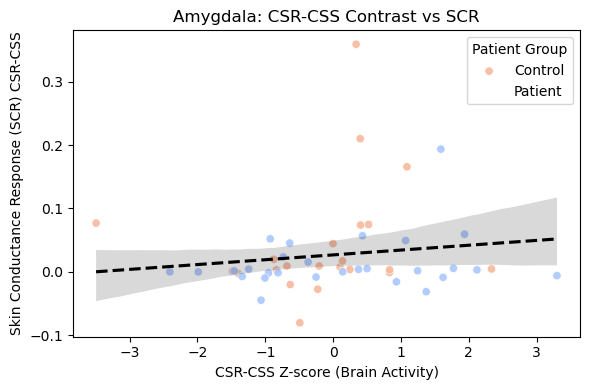

Model Summary for Insula
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2.313
Date:                Mon, 13 Oct 2025   Prob (F-statistic):             0.0884
Time:                        16:49:27   Log-Likelihood:                 65.213
No. Observations:                  50   AIC:                            -122.4
Df Residuals:                      46   BIC:                            -114.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0064

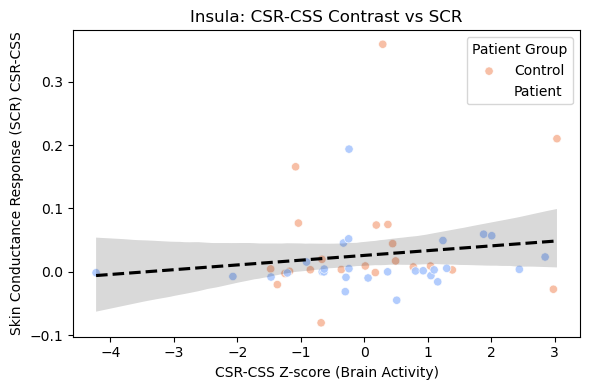

Model Summary for Hippocampus
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.621
Date:                Mon, 13 Oct 2025   Prob (F-statistic):              0.197
Time:                        16:49:27   Log-Likelihood:                 64.213
No. Observations:                  50   AIC:                            -120.4
Df Residuals:                      46   BIC:                            -112.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0

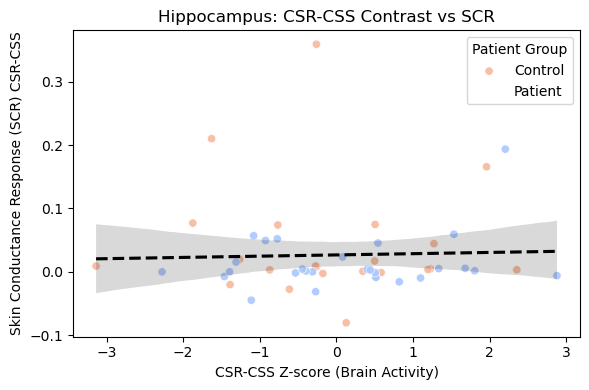

Model Summary for ACC
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     2.084
Date:                Mon, 13 Oct 2025   Prob (F-statistic):              0.115
Time:                        16:49:27   Log-Likelihood:                 64.887
No. Observations:                  50   AIC:                            -121.8
Df Residuals:                      46   BIC:                            -114.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0064   

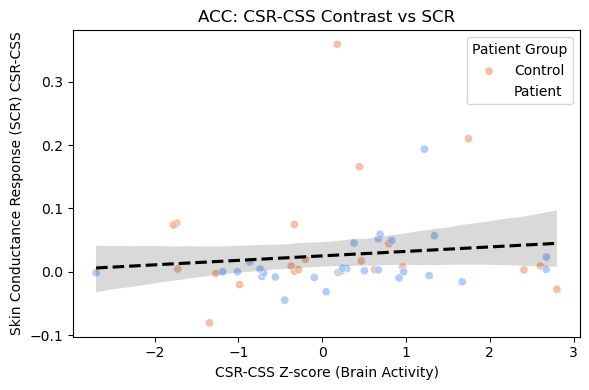

Model Summary for VMPFC
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.630
Date:                Mon, 13 Oct 2025   Prob (F-statistic):              0.195
Time:                        16:49:27   Log-Likelihood:                 64.227
No. Observations:                  50   AIC:                            -120.5
Df Residuals:                      46   BIC:                            -112.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0009 

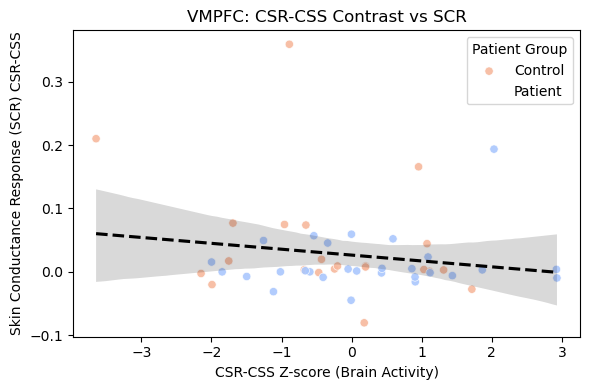

In [227]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast = 'CSR-CSS'
contrast_scr_idx = -3

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        for idx, sub in enumerate(sub_order[contrast_name]):
            z_score = file_lists[contrast_name][idx].z_score()[region_no]
            data[region].append(z_score)
            
    return data

# Extract z-score data for CSR-CSS
data = extract_contrast_data(file_lists_phase3, contrast, regions_of_interest, sub_order_phase3)

# Prepare regression data
def prepare_regression_data(dataex, sub_order, drug_order_df, SCR_df, contrast_scr_idx):
    data = []
    for region in dataex.keys():
        for idx, sub in enumerate(sub_order['CSR-CSS']):
            subID = sub[3:7]
            values = [dataex[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            SCR = SCR_df.loc[subID].values[contrast_scr_idx]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for y in values:
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': SCR,
                    'DrugOrder': drug_order,
                    'neuro': y,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Create dataframe for analysis
df = prepare_regression_data(data, sub_order_phase3, drug_order_df, dat_df, contrast_scr_idx)

# ✅ Only keep placebo (DrugOrder == 0)
df = df[df['DrugOrder'] == 0]

# Run models and plot for each region
for region in regions_of_interest:
    region_df = df[df['Region'] == region]
    
    # --- Regression ---
    # model = smf.ols('y ~ neuro', data=region_df).fit()
    model = smf.ols('y ~ neuro + DrugOrder + PatientGroup + Gender', data=region_df).fit()

    # model = smf.ols('y ~ DrugOrder * PatientGroup + DrugOrder * Gender + SCR', data=region_df).fit()

    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")
    
    # --- Plotting Relationship with SCR ---
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        data=region_df,
        x='neuro', y='y',
        hue='PatientGroup',
        style='DrugOrder',
        palette='coolwarm',
        alpha=0.9
    )
    sns.regplot(
        data=region_df,
        x='neuro', y='y',
        scatter=False,
        color='black',
        ci=95,
        line_kws={'linestyle': '--'}
    )
    plt.title(f"{region}: {contrast} Contrast vs SCR")
    plt.xlabel(f"{contrast} Z-score (Brain Activity)")
    plt.ylabel(f"Skin Conductance Response (SCR) {contrast}")
    plt.legend(title='Patient Group', labels=['Control', 'Patient'])
    plt.tight_layout()
    plt.show()


## Early vs late

### First Level

In [236]:
# removing subjects w wrong sequence / missing phases: 
subjects = layout.get_subjects()
subjects1 = subjects
del(subjects1[0]) #sub101 has 2mm seq for phase 2, 3mm (correct) for phase 3
del(subjects1[14])
del(subjects1[48]) # sub201, has 2mm seq for phase 2, 3mm (correct) for phase 3 

subjects2 = subjects1



In [237]:
# can load in onsets (events.tsv) for all subs here as all subs have same task timings 
onsets_phase2 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events-SPLIT_CSplus.xlsx',sheet_name=0)
onsets_phase3 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events-SPLIT_CSplus.xlsx',sheet_name=1)
onsets_phase3_sub202 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events-SPLIT_CSplus.xlsx',sheet_name=2)

onsets = onsets_phase2, onsets_phase3
onsets_sub202 = onsets_phase2, onsets_phase3_sub202

def load_bids_events(layout,onsets, subject, task, phaseno):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files)
    n_tr = func_file.shape[-1]
    onsets=onsets[phaseno]
    #onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events')[run].path, sep='\t') -- line to use if events changes by 
    
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [0,1,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as onsets 
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans

In [238]:
# to iterate through subjects ... 
#for sub in subjects 
from scipy.stats import norm

p001_unc = norm.isf(0.001)

file_lists_phase2 = {
        "CSplusearly-CS-early": list(),   
        "CSplusearly-fixearly": list(), 
        "CSminusearly-fixearly": list(),
        "CSpluslate-CS-late": list(),   
        "CSpluslate-fixlate": list(), 
        "CSminuslate-fixlate": list()
        }

file_lists_phase3 = {
        "CSplusearly-CS-early": list(),   
        "CSplusearly-fixearly": list(), 
        "CSminusearly-fixearly": list(),
        "CSpluslate-CS-late": list(),   
        "CSpluslate-fixlate": list(), 
        "CSminuslate-fixlate": list()
        }

sub_order_phase2 = {
        "CSplusearly-CS-early": list(),   
        "CSplusearly-fixearly": list(), 
        "CSminusearly-fixearly": list(),
        "CSpluslate-CS-late": list(),   
        "CSpluslate-fixlate": list(), 
        "CSminuslate-fixlate": list()
        }

sub_order_phase3 = {
        "CSplusearly-CS-early": list(),   
        "CSplusearly-fixearly": list(), 
        "CSminusearly-fixearly": list(),
        "CSpluslate-CS-late": list(),   
        "CSpluslate-fixlate": list(), 
        "CSminuslate-fixlate": list()
        }

tasks = ['phase2','phase3']

for phaseno, task in enumerate(tasks): 

    if task == 'phase2':
        subject_list = subjects1 
    elif task == 'phase3':
        subject_list = subjects2        
    
    for sub in subject_list: 

        fmri_imgs = layout.get(subject=sub,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        dmn_time_series = []
        for con_img in fmri_imgs:
            dmn_time_series.append(masker.fit_transform(con_img))
        dmn_time_series = np.concatenate(dmn_time_series, axis = 0)
        
        confound_files = layout.get(subject=sub,
                            datatype='func', task=task,
                            desc='confounds',
                           extension="tsv",
                           return_type='file')
        # Select confounds 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                        ]

        final_confounds = confound_vars

        design_matrices = []

        print("Creating First Level Design matrix ... ")

        if sub == 'N202':
            onsets_file = onsets_sub202 
        else:
            onsets_file = onsets
        
        for img in enumerate(fmri_imgs):
    # Build experimental paradigm
            events,tr,n_scans = load_bids_events(layout,onsets_file, sub, task, phaseno)
        # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[0]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)            
        # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )

        design_matrices.append(design_matrix)
        design_matrix_allruns = []    
        design_matrix_allruns = np.concatenate(design_matrices, axis = 0)
            
        contrast_matrix = []
        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }
       
        contrasts = {
            "CSplusearly-CS-early": (basic_contrasts["CSplus-early"] - basic_contrasts["CS--early"]),   
            "CSplusearly-fixearly": (basic_contrasts["CSplus-early"] - basic_contrasts["FIXATION-early"]),      
            "CSminusearly-fixearly": (basic_contrasts["CS--early"] - basic_contrasts["FIXATION-early"]),
            "CSpluslate-CS-late": (basic_contrasts["CSplus-late"] - basic_contrasts["CS--late"]),    
            "CSpluslate-fixlate": (basic_contrasts["CSplus-late"] - basic_contrasts["FIXATION-late"]),   
            "CSminuslate-fixlate": (basic_contrasts["CS--late"] - basic_contrasts["FIXATION-late"]), 
        }

    #fmri_glm = FirstLevelModel()
        labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)

        for contrast_id, contrast_val in contrasts.items():
            contrast = compute_contrast(labels, estimates, contrast_val)
            z_score = contrast.z_score()
            print(f"{contrast_id}: Z-score outputs: {z_score}")

            # Ensure subject data is appended properly
            if phaseno == 0:  # phase2
                file_lists_phase2[contrast_id].append(contrast)
                sub_order_phase2[contrast_id].append(f'sub{sub}-ses{task}')            
            else:  # phase3
                file_lists_phase3[contrast_id].append(contrast)
                sub_order_phase3[contrast_id].append(f'sub{sub}-ses{task}')

        print(f"Subject {sub} completed for {task}!")

    

Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [0.40844458 0.86385162 0.08419791 0.81045212 0.08702285]
CSplusearly-fixearly: Z-score outputs: [ 0.29999706  0.59491124 -0.544063    0.11114902 -1.91040675]
CSminusearly-fixearly: Z-score outputs: [-0.22425288 -0.53060098 -0.58688848 -0.88409461 -1.63256389]
CSpluslate-CS-late: Z-score outputs: [ 1.45847862  0.68430634  0.0808993  -0.54373244 -1.40863395]
CSpluslate-fixlate: Z-score outputs: [ 1.75023238  0.31585693  0.77907486 -1.1021946  -0.76361631]
CSminuslate-fixlate: Z-score outputs: [-0.13838886 -0.53569626  0.60010519 -0.3100475   1.07377468]
Subject N103 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-3.22371325 -0.00916876 -2.96803039  2.09879571 -0.78956619]
CSplusearly-fixearly: Z-score outputs: [-0.50263359 -0.94258554 -1.32898009 -2.27833599 -4.00648829]
CSminusearly-fixearly: Z-score outputs: [ 3.36485334 -0.73468936  2.42992414 -4.22349534 -2.23089353]
CSpluslate-CS-late: Z-score outputs: [ 1.16409428 -0.94080669  0.4582436   2.06176016  1.4884744 ]
CSpluslate-fixlate: Z-score outputs: [-0.54927548 -0.35654161  0.14149754  2.69780583  1.14172917]
CSminuslate-fixlate: Z-score outputs: [-1.92484168  0.8336946  -0.43340225 -0.23117616 -0.85308011]
Subject N104 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.0723756   0.0305568  -1.05461165  0.59612774 -0.77688197]
CSplusearly-fixearly: Z-score outputs: [ 0.97345272 -0.46080936 -0.46359425  0.07404046 -1.69375019]
CSminusearly-fixearly: Z-score outputs: [ 0.91807367 -0.41719214  0.87788456 -0.65766392 -0.4227615 ]
CSpluslate-CS-late: Z-score outputs: [-1.00624285 -0.28366147  0.01031659  0.89537187  2.06453268]
CSpluslate-fixlate: Z-score outputs: [ 0.96581608  0.46087753 -0.11475595  0.32083254  0.55757433]
CSminuslate-fixlate: Z-score outputs: [ 2.01818145  0.71779608 -0.10927177 -0.81525013 -2.04263962]
Subject N105 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [1.3668009  2.0782609  1.60674681 1.74555565 0.72975808]
CSplusearly-fixearly: Z-score outputs: [ 0.01987537 -1.32220057 -1.11519682 -1.06318407 -1.3011601 ]
CSminusearly-fixearly: Z-score outputs: [-1.5472619  -3.44579986 -2.75066159 -2.85818378 -1.91793304]
CSpluslate-CS-late: Z-score outputs: [ 0.08978039  0.47261194 -0.06536496 -0.45603037 -0.93487772]
CSpluslate-fixlate: Z-score outputs: [0.26610858 0.96325038 0.21347293 0.19887274 0.70846738]
CSminuslate-fixlate: Z-score outputs: [0.11932115 0.27047218 0.26215027 0.7194838  1.72881451]
Subject N106 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.46004661 -1.99169497 -1.88596644 -0.42294846 -0.07422238]
CSplusearly-fixearly: Z-score outputs: [ 0.03876744 -2.39356717 -3.05868293 -1.42396006 -0.9223505 ]
CSminusearly-fixearly: Z-score outputs: [-0.53183612  0.42503172 -0.31228125 -0.71671717 -0.68524543]
CSpluslate-CS-late: Z-score outputs: [-0.14977321 -0.09217533 -2.16494628  3.1109042   0.11121217]
CSpluslate-fixlate: Z-score outputs: [ 0.83579126  2.45386218 -1.32553436  1.92708328 -0.99031958]
CSminuslate-fixlate: Z-score outputs: [ 0.86575791  2.03563361  1.50948748 -2.13316002 -0.9105013 ]
Subject N108 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-2.29632459 -1.5390886  -1.91437927 -1.15582091 -1.47976561]
CSplusearly-fixearly: Z-score outputs: [-2.61035776 -0.11668662 -1.12786325  0.79218614 -0.10040721]
CSminusearly-fixearly: Z-score outputs: [0.55874612 1.76447038 1.37628268 2.02231383 1.705703  ]
CSpluslate-CS-late: Z-score outputs: [ 0.32150029 -1.08423023 -2.31434837 -2.71924459 -2.53112724]
CSpluslate-fixlate: Z-score outputs: [ 0.04592238 -0.42054434 -0.20066339 -0.10865987  0.14901881]
CSminuslate-fixlate: Z-score outputs: [-0.32983866  0.88985507  2.49961859  3.08083608  3.05792709]
Subject N109 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.19517948 -0.07843871  0.06229848 -0.36056646  0.06176226]
CSplusearly-fixearly: Z-score outputs: [ 1.31198346  1.0222622  -0.83526181 -1.21806257 -2.47264616]
CSminusearly-fixearly: Z-score outputs: [ 0.84406108  0.91181863 -0.74475466 -0.54401844 -1.98312374]
CSpluslate-CS-late: Z-score outputs: [0.22643087 0.95609908 0.01423486 1.27464645 0.39040251]
CSpluslate-fixlate: Z-score outputs: [ 0.32851915  0.78155188 -0.02940646  0.5278947  -0.85002314]
CSminuslate-fixlate: Z-score outputs: [ 0.01223117 -0.50784662 -0.04296641 -1.11901459 -1.16792545]
Subject N110 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.96954966 -0.32915968 -1.16704273 -1.3961286   0.31494475]
CSplusearly-fixearly: Z-score outputs: [ 0.30618513  0.7568487  -0.80819529 -0.57884146 -1.32806813]
CSminusearly-fixearly: Z-score outputs: [-0.90524942  1.04287995  0.72280269  1.19501271 -1.44934131]
CSpluslate-CS-late: Z-score outputs: [-0.65267768  0.17792717  0.73772828 -0.42408606  0.34855072]
CSpluslate-fixlate: Z-score outputs: [-1.07024679 -0.62668273  0.10869734  0.24262885  0.29743708]
CSminuslate-fixlate: Z-score outputs: [-0.13506873 -0.7504732  -0.79581174  0.71502853 -0.18132114]
Subject N111 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 1.376315   -0.15605764  0.12082326  0.65887349 -0.42071599]
CSplusearly-fixearly: Z-score outputs: [ 2.72522757  0.45739582  1.16353113  1.45434615 -1.52889048]
CSminusearly-fixearly: Z-score outputs: [ 0.71027104  0.56124063  0.83565718  0.41817002 -0.74504238]
CSpluslate-CS-late: Z-score outputs: [-1.55483133 -2.59118645 -0.494571   -1.39902251 -0.50501027]
CSpluslate-fixlate: Z-score outputs: [-0.32934406 -0.8347375   0.97385503 -0.11749613 -0.20978473]
CSminuslate-fixlate: Z-score outputs: [1.61148691 2.46389966 1.37292457 1.58618909 0.44351458]
Subject N112 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.6039788  -0.39905465 -0.39237185 -0.39212629 -0.33391705]
CSplusearly-fixearly: Z-score outputs: [-0.61343781 -0.79208385 -1.09298159 -0.12206866 -0.8038096 ]
CSminusearly-fixearly: Z-score outputs: [ 0.19310974 -0.20455373 -0.46802617  0.36514581 -0.28550086]
CSpluslate-CS-late: Z-score outputs: [-0.64024456 -2.30756833 -2.33666657 -0.46168688 -1.3937114 ]
CSpluslate-fixlate: Z-score outputs: [-0.46070509 -1.58129782 -1.04844056 -1.28427303 -1.45864328]
CSminuslate-fixlate: Z-score outputs: [ 0.39522406  1.50610718  1.9957378  -0.53435139  0.49146978]
Subject N113 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 1.4466867   0.40038757 -0.6183337  -0.71664654 -0.68967228]
CSplusearly-fixearly: Z-score outputs: [ 0.62464464 -1.32292201 -1.03618854 -2.0425559  -0.56330538]
CSminusearly-fixearly: Z-score outputs: [-1.21139405 -1.53021985 -0.09595542 -0.7937644   0.37762288]
CSpluslate-CS-late: Z-score outputs: [ 0.45794218  2.27757671 -1.3659375   1.69955286 -0.18137213]
CSpluslate-fixlate: Z-score outputs: [ 0.13463567  0.53039085 -0.52447564  0.18293796  1.18032412]
CSminuslate-fixlate: Z-score outputs: [-0.43856347 -2.31824728  1.21370906 -1.90219769  1.19479499]
Subject N114 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.01400501 -1.04300592  0.80112833 -1.87910007 -0.18496608]
CSplusearly-fixearly: Z-score outputs: [-0.64485869 -0.11737587 -0.82811162 -2.25974665 -3.18979529]
CSminusearly-fixearly: Z-score outputs: [ 0.70176703  1.17577313 -1.65992902  0.39374411 -2.36077199]
CSpluslate-CS-late: Z-score outputs: [-0.63305613  0.00484864 -0.97367401  0.00301847  0.66045529]
CSpluslate-fixlate: Z-score outputs: [ 0.17270782 -0.50363326 -2.04963327 -0.01889815 -2.04554772]
CSminuslate-fixlate: Z-score outputs: [ 0.87516835 -0.39749684 -0.44846354 -0.01834794 -2.32134725]
Subject N115 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.64005488  0.66704685 -1.23350568  1.5593648   0.06298566]
CSplusearly-fixearly: Z-score outputs: [ 0.87952943  0.15273769 -0.67935901  1.72321227 -1.39759552]
CSminusearly-fixearly: Z-score outputs: [ 1.53093334 -0.66785647  0.90416516 -0.37202467 -1.18904728]
CSpluslate-CS-late: Z-score outputs: [ 0.29429434 -0.7412153  -0.35856502  1.52863081  0.90248013]
CSpluslate-fixlate: Z-score outputs: [ 0.06828775  0.97069911 -1.26202846  2.18512247 -0.94180242]
CSminuslate-fixlate: Z-score outputs: [-0.29457247  1.65745265 -0.61047319  0.06220525 -1.79590957]
Subject N117 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.9470311  -0.77651122  0.51425751  0.14423174 -0.40125488]
CSplusearly-fixearly: Z-score outputs: [-0.07297547 -0.55362027 -0.84357047 -0.23796595 -1.038452  ]
CSminusearly-fixearly: Z-score outputs: [-1.1961061   0.47496429 -1.33371124 -0.36986661 -0.38413577]
CSpluslate-CS-late: Z-score outputs: [-0.23935366  0.15111818 -1.20895986 -1.01919877 -0.75227976]
CSpluslate-fixlate: Z-score outputs: [ 0.20193329 -0.89224632 -0.10905307 -1.07486908 -0.0064653 ]
CSminuslate-fixlate: Z-score outputs: [ 0.43893567 -0.89039238  1.29157381  0.30613196  0.85886634]
Subject N118 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.21040122 -0.64903928 -0.56191403  0.12706751 -1.45508602]
CSplusearly-fixearly: Z-score outputs: [ 0.3980115  -0.57999192 -0.64479232 -0.75637859 -2.25595885]
CSminusearly-fixearly: Z-score outputs: [ 1.79784556  0.31293916  0.14778002 -0.78098281 -0.0084825 ]
CSpluslate-CS-late: Z-score outputs: [1.37479655 1.80274422 0.56222491 1.05676254 2.69629871]
CSpluslate-fixlate: Z-score outputs: [1.9224637  1.70417238 0.52969776 1.94433205 2.550861  ]
CSminuslate-fixlate: Z-score outputs: [-0.06562826 -0.76514682 -0.23400084  0.3285305  -1.25605191]
Subject N121 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [0.80180508 0.98379478 1.34506252 0.14738954 0.50407947]
CSplusearly-fixearly: Z-score outputs: [-0.86218606 -1.40289516 -0.51481006 -2.30548957 -0.46730169]
CSminusearly-fixearly: Z-score outputs: [-1.68607197 -2.32301731 -2.03978697 -1.99225122 -0.96274965]
CSpluslate-CS-late: Z-score outputs: [0.41256521 0.89115976 0.38413034 2.61826077 3.10872406]
CSpluslate-fixlate: Z-score outputs: [2.19817859 0.06130497 1.12240608 0.93119378 1.51004948]
CSminuslate-fixlate: Z-score outputs: [ 1.36607782 -0.99629671  0.48716134 -2.37534953 -2.57912669]
Subject N122 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 1.57212102 -1.96802227  0.51440438 -1.95885474 -0.62772442]
CSplusearly-fixearly: Z-score outputs: [ 1.05711686 -1.02450172  0.39223913 -0.78398368  0.35326084]
CSminusearly-fixearly: Z-score outputs: [-1.00565048  1.54954018 -0.28881614  1.7192321   1.04121886]
CSpluslate-CS-late: Z-score outputs: [-1.39021287 -1.34179934 -2.46525974 -2.68652617 -1.96978569]
CSpluslate-fixlate: Z-score outputs: [-0.79773524 -2.46341314 -2.38988912 -2.54075763 -2.56048263]
CSminuslate-fixlate: Z-score outputs: [ 0.99606621 -0.37978801  0.96483665  1.12676322  0.43148293]
Subject N123 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.55101132 -0.24061606 -0.85690084  0.48270523 -1.41008108]
CSplusearly-fixearly: Z-score outputs: [-1.26755935  1.44814477 -1.11501305  0.86501634 -2.32527919]
CSminusearly-fixearly: Z-score outputs: [ 0.82095821  1.46163274  0.08424332  0.10861284 -0.19087119]
CSpluslate-CS-late: Z-score outputs: [-1.71759203  3.84938026 -1.30712237  2.24315596 -1.09209187]
CSpluslate-fixlate: Z-score outputs: [-2.31904965  1.61452228 -2.35368559  1.277906   -2.40430711]
CSminuslate-fixlate: Z-score outputs: [ 0.1249851  -3.33443634 -0.50829994 -1.69372003 -0.69560461]
Subject N124 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.21407686  0.44477905 -0.90911222  0.79464971  1.65954016]
CSplusearly-fixearly: Z-score outputs: [-1.21532595  0.63121266 -2.71112885 -0.26982812 -1.03970927]
CSminusearly-fixearly: Z-score outputs: [ 0.45374453 -0.00903849 -1.23116425 -1.22555751 -2.95024199]
CSpluslate-CS-late: Z-score outputs: [ 0.51367961 -0.82989724 -1.24826159 -0.87970997 -0.93034611]
CSpluslate-fixlate: Z-score outputs: [ 0.95282628 -0.67048463 -1.82175263 -0.89825767 -2.7167599 ]
CSminuslate-fixlate: Z-score outputs: [ 0.19260708  0.45025618 -0.02287586  0.3195401  -1.17097443]
Subject N125 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.31807118  1.54113222 -0.47838952  2.52249937  2.97995118]
CSplusearly-fixearly: Z-score outputs: [-0.3151454   0.63856465 -0.60324949  1.16947857  0.365167  ]
CSminusearly-fixearly: Z-score outputs: [-0.64204015 -1.33880566  0.07687123 -2.09052302 -3.28171096]
CSpluslate-CS-late: Z-score outputs: [-1.12866114  2.45220984 -1.08453756  2.50843061  0.96764616]
CSpluslate-fixlate: Z-score outputs: [ 0.5682481   0.71170831 -0.33118635  1.22702964  0.23149642]
CSminuslate-fixlate: Z-score outputs: [ 1.7792051  -2.30476397  0.99146522 -1.95318777 -0.94638837]
Subject N127 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [0.09504946 0.27575305 0.96890705 0.77338153 0.89773988]
CSplusearly-fixearly: Z-score outputs: [-0.48161793 -0.18059534  0.46159292  1.190862    0.29441468]
CSminusearly-fixearly: Z-score outputs: [-0.52230946 -0.4824574  -0.78640005  0.04001363 -0.84462147]
CSpluslate-CS-late: Z-score outputs: [ 0.04407142 -0.13153619  3.54898739 -0.18346145  2.30415118]
CSpluslate-fixlate: Z-score outputs: [0.56205231 0.17497528 2.71219344 0.16766327 1.20638395]
CSminuslate-fixlate: Z-score outputs: [ 0.44456593  0.30631902 -1.97773256  0.35721747 -1.77217189]
Subject N128 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.34870403  1.51918767 -2.72965922  1.57064318  1.32101712]
CSplusearly-fixearly: Z-score outputs: [-0.05424797 -0.49663486 -1.80573807 -0.51485556 -1.53722968]
CSminusearly-fixearly: Z-score outputs: [ 1.52550187 -2.1487512   1.76380058 -2.22518895 -2.68197661]
CSpluslate-CS-late: Z-score outputs: [ 0.99262188  2.91502643 -0.76083087  1.64014342 -0.65550354]
CSpluslate-fixlate: Z-score outputs: [-0.05515217 -0.41357477 -1.56670291 -1.53694488 -1.6671682 ]
CSminuslate-fixlate: Z-score outputs: [-1.2154084  -3.76791604 -0.40494677 -3.21817876 -0.52868781]
Subject N129 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.11320289e+00 -1.74078398e+00  1.06036025e-03 -4.79413289e-01
  1.07014360e+00]
CSplusearly-fixearly: Z-score outputs: [-0.29222097 -0.29336157 -1.08986391 -0.29728986 -1.60547085]
CSminusearly-fixearly: Z-score outputs: [ 1.09866786  1.85692656 -0.89910976  0.33921081 -2.54127667]
CSpluslate-CS-late: Z-score outputs: [ 0.68677745 -2.92838852  1.23209503 -1.12927613  0.93581506]
CSpluslate-fixlate: Z-score outputs: [ 0.53572223 -1.12646942  0.45002434 -0.83648245 -0.1239181 ]
CSminuslate-fixlate: Z-score outputs: [-0.36125604  2.54420396 -1.09822839  0.67603881 -1.21129627]
Subject N130 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.78519222 -0.45261026 -0.33832058 -0.75567276 -0.71509089]
CSplusearly-fixearly: Z-score outputs: [-0.10978297 -0.44674181 -1.94537706 -0.79675562 -2.69221967]
CSminusearly-fixearly: Z-score outputs: [-1.03967468  0.18074606 -1.19194949  0.2714727  -1.21803095]
CSpluslate-CS-late: Z-score outputs: [-0.00784654  0.33067475 -0.88874939 -0.1459467  -0.18453815]
CSpluslate-fixlate: Z-score outputs: [ 1.37988657  0.36365448  0.09012938  0.67337157 -0.08981281]
CSminuslate-fixlate: Z-score outputs: [ 1.16835465 -0.10203021  1.12511657  0.70149957  0.15404641]
Subject N131 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [-0.05253505 -0.54939619  0.27939531 -0.86154333 -0.53518473]
CSplusearly-fixearly: Z-score outputs: [ 0.00233579 -0.53251471  0.54238508 -0.89288028 -2.02033188]
CSminusearly-fixearly: Z-score outputs: [ 0.06786816  0.23401007  0.13126668  0.33364699 -1.09131136]
CSpluslate-CS-late: Z-score outputs: [-0.29265858  1.02872687 -0.0859422   2.64161564  1.24264298]
CSpluslate-fixlate: Z-score outputs: [-0.28837772  1.70177246 -0.69481628  2.09888523  0.31892244]
CSminuslate-fixlate: Z-score outputs: [ 0.09734858  0.18628824 -0.49893229 -1.48818988 -1.2301204 ]
Subject N132 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.06247752  0.10028938  0.76271819 -0.83646433  0.82279358]
CSplusearly-fixearly: Z-score outputs: [-0.52869609 -0.81606167 -0.92849559 -1.25973066 -0.67102632]
CSminusearly-fixearly: Z-score outputs: [-0.5342797  -0.81904129 -1.71287863 -0.13367077 -1.54246275]
CSpluslate-CS-late: Z-score outputs: [ 2.03423975  2.67763377  0.26124461  1.96233208 -0.30675107]
CSpluslate-fixlate: Z-score outputs: [ 0.8453131   1.14163589 -0.24255912 -1.06460985 -2.44780042]
CSminuslate-fixlate: Z-score outputs: [-1.71531491 -2.25365188 -0.50728733 -3.17552361 -1.59167906]
Subject N133 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.42338665 -0.66466426 -0.98601516  0.15247157 -0.62224412]
CSplusearly-fixearly: Z-score outputs: [-0.58140152  0.34166008 -1.93896925 -0.66326399 -2.53627115]
CSminusearly-fixearly: Z-score outputs: [ 0.00308282  1.07223147 -0.46217612 -0.72966596 -1.2610732 ]
CSpluslate-CS-late: Z-score outputs: [-0.46310557  1.76788716  0.19069577  1.72798257  0.1530091 ]
CSpluslate-fixlate: Z-score outputs: [-0.22434714 -0.12363526  1.29129599  0.23228105 -0.28627457]
CSminuslate-fixlate: Z-score outputs: [ 0.35168468 -2.17334025  0.83907699 -1.83936049 -0.40374383]
Subject N134 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [-0.05443925 -2.25827037 -0.09944829 -2.79055458 -3.44711507]
CSplusearly-fixearly: Z-score outputs: [-1.04071532 -2.92780951 -1.53830093 -3.63458709 -4.15112974]
CSminusearly-fixearly: Z-score outputs: [-0.83644597  0.36570166 -1.16453096  0.3436059   0.59893592]
CSpluslate-CS-late: Z-score outputs: [ 0.65630787  1.53747366  0.41651229  0.65749717 -1.17460672]
CSpluslate-fixlate: Z-score outputs: [-0.70041817  0.76423671 -0.29053732  0.74819796 -1.55538922]
CSminuslate-fixlate: Z-score outputs: [-1.34107937 -1.23717504 -0.71800562 -0.18919211  0.11703335]
Subject N135 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.73307679 -1.43976817 -2.67201019 -2.44729281 -2.19046736]
CSplusearly-fixearly: Z-score outputs: [ 1.71824223 -0.43961287 -0.90442067 -1.46999178 -2.0931676 ]
CSminusearly-fixearly: Z-score outputs: [2.39511336 1.35754952 2.43178151 1.70953762 0.9289478 ]
CSpluslate-CS-late: Z-score outputs: [-0.91381051  1.210177   -1.66038737 -0.87512147 -0.58173542]
CSpluslate-fixlate: Z-score outputs: [ 1.43272475 -0.45263276 -0.90509562 -1.80482301 -2.7288328 ]
CSminuslate-fixlate: Z-score outputs: [ 2.16799099 -1.73790205  1.12684773 -0.44366729 -1.47361072]
Subject N136 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.5329182  -1.5136483  -0.20931337 -0.41188362 -1.50118584]
CSplusearly-fixearly: Z-score outputs: [ 1.62433794  0.67507044  1.41425749  1.35970606 -0.08278982]
CSminusearly-fixearly: Z-score outputs: [1.97715956 2.36550137 1.39336846 1.5969815  1.75992295]
CSpluslate-CS-late: Z-score outputs: [-1.82732929  0.54672161 -1.74626147  1.52668649 -0.12995129]
CSpluslate-fixlate: Z-score outputs: [-0.50549348 -0.14240065 -0.14915391  1.14262932 -0.27856923]
CSminuslate-fixlate: Z-score outputs: [ 1.76143747 -0.77108947  1.96634145 -0.87735441 -0.07352678]
Subject N137 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.42267305  0.79782051  0.20463562  0.1214121  -0.392983  ]
CSplusearly-fixearly: Z-score outputs: [ 1.04641176  0.82801952  0.55504854 -0.26374444 -0.9327666 ]
CSminusearly-fixearly: Z-score outputs: [ 0.43211263 -0.26849209  0.24464182 -0.37949074 -0.2770699 ]
CSpluslate-CS-late: Z-score outputs: [-0.12071315 -1.03981141 -0.3800814  -0.45799251 -0.80642869]
CSpluslate-fixlate: Z-score outputs: [-0.03108663 -0.07050461 -1.02909848 -0.34983011 -1.29113537]
CSminuslate-fixlate: Z-score outputs: [ 0.11524231  1.1701609  -0.43324862  0.24306307 -0.05973766]
Subject N138 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.23380816  0.46617741 -0.63387503 -0.60055667 -0.85526806]
CSplusearly-fixearly: Z-score outputs: [-0.97263344 -0.51643712 -1.67929481 -2.0131498  -3.48384374]
CSminusearly-fixearly: Z-score outputs: [-0.54770102 -1.00179707 -0.62386399 -0.89966694 -1.76696974]
CSpluslate-CS-late: Z-score outputs: [-0.57811004 -0.25335786 -0.71144901 -1.12349328 -2.14660983]
CSpluslate-fixlate: Z-score outputs: [ 0.37501728 -1.16360025 -0.62601593 -2.97026662 -3.95557111]
CSminuslate-fixlate: Z-score outputs: [ 1.00352797 -0.64239291  0.33481915 -1.03216532 -0.56695289]
Subject N141 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.69267581 -0.25313107 -0.52734125  1.38177416  0.37578164]
CSplusearly-fixearly: Z-score outputs: [-0.79458357 -0.62124509 -0.35581615 -0.27536571 -0.6366532 ]
CSminusearly-fixearly: Z-score outputs: [ 0.15419442 -0.20205135  0.33507755 -1.8774007  -0.9586249 ]
CSpluslate-CS-late: Z-score outputs: [ 0.33423101  1.47693075 -0.3585192   0.3517929   0.37534038]
CSpluslate-fixlate: Z-score outputs: [ 0.74745583  0.41109429 -0.20803275 -0.86425172 -1.12181837]
CSminuslate-fixlate: Z-score outputs: [ 0.26565772 -1.43908247  0.25224977 -1.15213556 -1.39059862]
Subject N142 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.07340695 -1.10077616 -1.50261836 -0.06687293  0.64534646]
CSplusearly-fixearly: Z-score outputs: [-1.11186539 -0.49068054 -2.01588469 -0.08446823 -1.13257154]
CSminusearly-fixearly: Z-score outputs: [ 0.34063199  0.93935527  0.0714501   0.01214756 -1.70058609]
CSpluslate-CS-late: Z-score outputs: [ 0.46401743 -0.31496377  0.82377941  1.09667445 -0.39448647]
CSpluslate-fixlate: Z-score outputs: [ 1.52263047  0.32586048  1.06425924  1.62052161 -0.80112071]
CSminuslate-fixlate: Z-score outputs: [ 0.78928697  0.63940689 -0.03356437  0.03273365 -0.22306722]
Subject N143 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.17191517 -0.92640869 -0.44258252 -0.10802288  0.3133474 ]
CSplusearly-fixearly: Z-score outputs: [-0.04251478 -1.10781232 -0.54174537 -1.26078843 -0.81596155]
CSminusearly-fixearly: Z-score outputs: [ 0.16955638  0.17720638  0.07291366 -0.94124641 -1.0529755 ]
CSpluslate-CS-late: Z-score outputs: [0.67098307 0.31245558 0.18273721 1.23687451 1.84528541]
CSpluslate-fixlate: Z-score outputs: [-0.73020788 -2.24350488 -1.31965957 -2.71954446 -2.48695939]
CSminuslate-fixlate: Z-score outputs: [-1.38420038 -2.23630474 -1.31864058 -3.68675637 -4.12127549]
Subject N144 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.51120728 -0.03328829  0.93580068 -0.0345247  -0.65071647]
CSplusearly-fixearly: Z-score outputs: [ 1.45093567 -0.21023304 -0.33222945 -0.47537842 -1.36347295]
CSminusearly-fixearly: Z-score outputs: [ 0.62011042 -0.13809939 -1.42137461 -0.37389779 -0.37524703]
CSpluslate-CS-late: Z-score outputs: [ 0.53773215 -2.83820859  2.38832951 -2.43428456 -0.83616612]
CSpluslate-fixlate: Z-score outputs: [ 0.02150221 -1.21978334  1.26807719 -1.84636401 -1.42825668]
CSminuslate-fixlate: Z-score outputs: [-0.61247641  2.29299324 -1.6962111   1.22858487 -0.25080621]
Subject N145 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.87715211  2.64876833 -1.82165606  0.59700742 -2.47801355]
CSplusearly-fixearly: Z-score outputs: [-0.56474238  1.46411085 -0.45541874 -0.01758958 -0.91319082]
CSminusearly-fixearly: Z-score outputs: [ 0.57497816 -2.04441853  1.82261232 -0.73839611  2.2916478 ]
CSpluslate-CS-late: Z-score outputs: [-1.165136   -0.97553811 -0.19618393 -1.14898447 -0.3526772 ]
CSpluslate-fixlate: Z-score outputs: [-0.51070392 -0.10714825 -0.86636375  0.43584349  0.4793281 ]
CSminuslate-fixlate: Z-score outputs: [ 0.94625955  1.07747057 -0.49847035  1.72448594  0.80392647]
Subject N146 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.48510108 -2.22992456 -0.46162786 -1.71161321 -1.3029666 ]
CSplusearly-fixearly: Z-score outputs: [ 0.30936665 -1.0240484  -1.45134948 -0.06785868 -1.00152249]
CSminusearly-fixearly: Z-score outputs: [-0.32609756  1.87564898 -0.67362904  2.03237943  0.75672008]
CSpluslate-CS-late: Z-score outputs: [ 0.5056171  -1.0724224  -0.59441979 -0.45600677 -0.78909649]
CSpluslate-fixlate: Z-score outputs: [-0.05769851 -0.6680291  -1.5863476  -0.85053261 -1.32643814]
CSminuslate-fixlate: Z-score outputs: [-0.64615824  0.73270029 -0.61114211 -0.16634841 -0.14157535]
Subject N147 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [ 0.11317348  1.48652798 -1.47206437  0.38010499 -0.42203273]
CSplusearly-fixearly: Z-score outputs: [ 0.49589658  0.78165708 -0.78516116 -0.37522395 -1.60204957]
CSminusearly-fixearly: Z-score outputs: [ 0.28118265 -1.19372862  1.12504221 -0.75635496 -0.76780993]
CSpluslate-CS-late: Z-score outputs: [ 1.15803785  1.46312587 -0.17064137 -0.50819887  0.08677101]
CSpluslate-fixlate: Z-score outputs: [1.08712055 1.73715248 0.14419014 0.53958925 0.09427971]
CSminuslate-fixlate: Z-score outputs: [-0.48990218 -0.43421837  0.32571531  1.04949385 -0.02985955]
Subject N148 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.66951316  1.26361496 -0.39406333  0.22157956 -0.83294372]
CSplusearly-fixearly: Z-score outputs: [-0.67878018  1.43900343 -0.80789327  0.10901603 -2.45000309]
CSminusearly-fixearly: Z-score outputs: [ 0.21925677 -0.30830618 -0.21548494 -0.17099169 -0.97721499]
CSpluslate-CS-late: Z-score outputs: [ 0.55308354  1.0410087   0.0805069   0.34919529 -1.03061128]
CSpluslate-fixlate: Z-score outputs: [ 0.87349751  0.69563663 -0.05010484  0.78197815 -2.38088737]
CSminuslate-fixlate: Z-score outputs: [ 0.05635884 -0.67352523 -0.13407021  0.20642564 -0.60891251]
Subject N149 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 1.26494702  1.02265064 -1.73558797 -0.50532813 -3.76191529]
CSplusearly-fixearly: Z-score outputs: [ 2.501944    2.08360389 -0.98050537 -0.29107613 -3.76669915]
CSminusearly-fixearly: Z-score outputs: [0.63677812 0.49242365 1.23228595 0.36693863 1.48015963]
CSpluslate-CS-late: Z-score outputs: [ 0.17633397  1.16005703 -1.95404235  0.08557316 -3.34005857]
CSpluslate-fixlate: Z-score outputs: [ 0.70143936  0.26316191  0.49539268  0.32997263 -1.57615118]
CSminuslate-fixlate: Z-score outputs: [ 0.39087766 -1.1435249   2.68435354  0.16975195  2.66878655]
Subject N150 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [ 0.43052405 -1.21392148 -0.29455226 -0.84397829 -0.57903461]
CSplusearly-fixearly: Z-score outputs: [ 0.78184084 -0.68342254 -0.00382827 -1.12834109 -1.43480956]
CSminusearly-fixearly: Z-score outputs: [ 0.16325674  0.87171499  0.34375399  0.05231874 -0.49302127]
CSpluslate-CS-late: Z-score outputs: [ 0.80510649 -1.18659557  1.79576935  0.50876317  1.89436249]
CSpluslate-fixlate: Z-score outputs: [1.40602324 0.01351359 1.61545421 0.41147715 0.19054648]
CSminuslate-fixlate: Z-score outputs: [ 0.08934474  1.33661682 -0.85708994 -0.27643976 -1.99079093]
Subject N151 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.11190801  0.0861874   0.43533892 -0.06016343  0.72962288]
CSplusearly-fixearly: Z-score outputs: [-0.28433936 -0.88431799  0.97344922 -1.15622077 -0.26900867]
CSminusearly-fixearly: Z-score outputs: [ 1.10277802 -0.84193654  0.27918502 -0.86325878 -1.09104559]
CSpluslate-CS-late: Z-score outputs: [2.27510306 3.64877273 0.94019637 3.01538584 1.19235408]
CSpluslate-fixlate: Z-score outputs: [1.09420576 1.77552558 0.86747626 2.22712903 1.27823297]
CSminuslate-fixlate: Z-score outputs: [-1.78677218 -2.84972453 -0.38764698 -1.7830983  -0.40969054]
Subject N153 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.15430036  0.28320132  0.40638851  0.82119657  0.26344383]
CSplusearly-fixearly: Z-score outputs: [ 0.96764864  0.81926727  0.01699538  1.03820653 -1.56566894]
CSminusearly-fixearly: Z-score outputs: [ 2.18713794  0.33523587 -0.47197052 -0.15347831 -1.58170159]
CSpluslate-CS-late: Z-score outputs: [-0.24334682  1.62540804  0.15540949  2.18877762  0.45829804]
CSpluslate-fixlate: Z-score outputs: [1.38209787 0.57763575 0.18392236 1.56444692 0.09938891]
CSminuslate-fixlate: Z-score outputs: [ 1.4464835  -1.45902319 -0.03053268 -1.36398235 -0.46518621]
Subject N154 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.18064169  0.88507662 -0.21817603  1.91768004  0.19278437]
CSplusearly-fixearly: Z-score outputs: [-6.80858332e-01  2.06338775e+00 -2.02151786e-03  1.80738523e+00
 -7.07326459e-02]
CSminusearly-fixearly: Z-score outputs: [ 0.84771408  0.60591995  0.26279723 -0.82053173 -0.29233395]
CSpluslate-CS-late: Z-score outputs: [-1.07274602  0.56711503 -1.18237965 -0.19152744 -0.18434073]
CSpluslate-fixlate: Z-score outputs: [-0.9581237  -0.95577935 -1.38575247 -0.89265506 -2.3362386 ]
CSminuslate-fixlate: Z-score outputs: [ 0.46619785 -1.4164614   0.26213131 -0.48940956 -1.64374297]
Subject N155 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.52848585  0.76691026 -0.50072304  0.66320611  0.11491278]
CSplusearly-fixearly: Z-score outputs: [ 0.01849863 -0.3828936  -2.7541767   0.21810305 -2.26560695]
CSminusearly-fixearly: Z-score outputs: [ 0.67197001 -1.25481947 -1.73591584 -0.64432861 -1.96671621]
CSpluslate-CS-late: Z-score outputs: [-0.17075838 -0.4298676   0.53491982  0.31357759  0.90936378]
CSpluslate-fixlate: Z-score outputs: [ 1.13512465 -0.27101414  1.109534    0.44910555  1.51995401]
CSminuslate-fixlate: Z-score outputs: [ 1.14565661  0.30215786  0.27322889 -0.02754882  0.08848751]
Subject N156 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.71615008 -0.58031322 -0.87228253 -0.07965404 -0.95628779]
CSplusearly-fixearly: Z-score outputs: [-0.50522199 -0.92814862 -0.93250468 -0.59856634 -0.24720601]
CSminusearly-fixearly: Z-score outputs: [ 0.45800298 -0.05013262  0.31790059 -0.38256593  0.96684549]
CSpluslate-CS-late: Z-score outputs: [ 1.43460352 -0.29453424  0.57009951 -2.01206375 -1.08301269]
CSpluslate-fixlate: Z-score outputs: [ 0.92690774  1.12162645  0.82212837 -1.38904606 -1.20643551]
CSminuslate-fixlate: Z-score outputs: [-1.01204793  1.22926919 -0.05709505  1.35122531  0.40625225]
Subject N157 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.15328272  0.54263185 -0.69831727  0.76465263 -0.1103757 ]
CSplusearly-fixearly: Z-score outputs: [-0.85464337  0.15046482 -1.36583824  0.16886488 -1.94466181]
CSminusearly-fixearly: Z-score outputs: [-0.54233803 -0.53257485 -0.31345831 -0.78302535 -1.46422374]
CSpluslate-CS-late: Z-score outputs: [-0.11226542  0.12649857  0.40395126  0.38052153  0.75243393]
CSpluslate-fixlate: Z-score outputs: [ 0.29360536  0.16141181 -0.0688989   1.01097811 -0.18894809]
CSminuslate-fixlate: Z-score outputs: [ 0.38280608 -0.02218512 -0.54602702  0.37034389 -1.06482442]
Subject N158 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.37425583 -0.30838991 -2.43565896 -0.62494907 -2.25044209]
CSplusearly-fixearly: Z-score outputs: [-0.40458827 -1.04823068 -2.94269872 -1.66246049 -3.91353148]
CSminusearly-fixearly: Z-score outputs: [ 1.28829834 -0.50920207  0.3787452  -0.64389477 -0.52020632]
CSpluslate-CS-late: Z-score outputs: [ 0.42949588  0.61611375 -0.09568828 -0.48600276 -2.08044311]
CSpluslate-fixlate: Z-score outputs: [ 1.36194603 -0.65538433  0.31338327 -1.24450078 -1.43927848]
CSminuslate-fixlate: Z-score outputs: [ 0.65279364 -1.28168091  0.37952567 -0.43789444  1.36671417]
Subject N202 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.27834771 -0.25933632 -1.0450171   0.88313776 -0.28290056]
CSplusearly-fixearly: Z-score outputs: [ 0.13611094  1.17106155 -0.35037697 -0.69262895 -1.21144102]
CSminusearly-fixearly: Z-score outputs: [ 0.44876159  1.25250891  0.96505869 -1.6164568  -0.62528751]
CSpluslate-CS-late: Z-score outputs: [ 0.04623963 -2.61880751  1.15001967 -1.50892701 -0.70036539]
CSpluslate-fixlate: Z-score outputs: [-0.68202358 -1.53812974  0.12774726 -0.9957499  -2.18197754]
CSminuslate-fixlate: Z-score outputs: [-0.62502416  1.93405205 -1.27563608  1.01456214 -0.88121541]
Subject N203 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [-1.04076175  1.01355175 -1.25149353  0.58918239 -2.05713704]
CSplusearly-fixearly: Z-score outputs: [-1.50604415  2.61166727 -3.58906869  1.68069912 -1.16446982]
CSminusearly-fixearly: Z-score outputs: [-0.10012163  0.97966108 -1.64990631  0.73203067  1.54619351]
CSpluslate-CS-late: Z-score outputs: [ 0.55072607 -1.57035085 -2.20058018 -2.15375947  0.2540135 ]
CSpluslate-fixlate: Z-score outputs: [ 1.59263076 -1.61251586 -1.47520557 -1.76172903 -0.2481355 ]
CSminuslate-fixlate: Z-score outputs: [ 0.84918223  0.52714436  1.38346343  1.08819637 -0.52922466]
Subject N204 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [1.33583719 1.71831242 2.19243976 1.86580208 1.43803209]
CSplusearly-fixearly: Z-score outputs: [0.66812665 0.96904327 0.43395249 1.40952846 0.55913107]
CSminusearly-fixearly: Z-score outputs: [-1.04745215 -1.30758791 -2.3106626  -1.0878952  -1.33861154]
CSpluslate-CS-late: Z-score outputs: [1.77139345 1.86477303 2.13705138 1.32117037 1.61663083]
CSpluslate-fixlate: Z-score outputs: [1.41775255 1.86993715 1.19219269 1.14242421 2.38858553]
CSminuslate-fixlate: Z-score outputs: [-0.92986478 -0.78664406 -1.59061237 -0.66299553 -0.20901466]
Subject N206 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.57897887 -0.53137983 -1.74818865  0.43252336 -1.3727144 ]
CSplusearly-fixearly: Z-score outputs: [ 0.69889533  0.26641593 -0.46276089  0.58068139 -0.97623651]
CSminusearly-fixearly: Z-score outputs: [ 2.49791914  0.85713854  1.71879851 -0.06420158  0.8530364 ]
CSpluslate-CS-late: Z-score outputs: [-1.40639787  0.0827811  -0.5739146  -1.41748221  0.44170805]
CSpluslate-fixlate: Z-score outputs: [-1.50799239 -0.16808956 -1.67150479  0.60254132 -1.30959025]
CSminuslate-fixlate: Z-score outputs: [ 0.31198516 -0.24115495 -0.78836606  2.16701922 -1.63311685]
Subject N207 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 2.84664097  1.64372619 -0.79278629  1.31978381  0.32528309]
CSplusearly-fixearly: Z-score outputs: [ 1.05993274  1.37218812 -0.84618943  1.66809274 -0.54194429]
CSminusearly-fixearly: Z-score outputs: [-2.57007354 -0.84655132  0.21704275 -0.11172571 -0.87942948]
CSpluslate-CS-late: Z-score outputs: [ 1.19148337 -1.55319456  0.93613822 -0.45556587 -1.14050844]
CSpluslate-fixlate: Z-score outputs: [ 1.45261082 -1.71786534  0.76547556  0.24985552 -0.2771892 ]
CSminuslate-fixlate: Z-score outputs: [-0.14204264  0.42087025 -0.45673168  0.76716927  1.12371944]
Subject N209 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-2.28007156e-02  4.35796009e+00 -2.60109276e+00  4.28362653e+00
  4.03057080e-03]
CSplusearly-fixearly: Z-score outputs: [ 0.12844661  4.00627726 -2.95150469  3.99508776  0.30859445]
CSminusearly-fixearly: Z-score outputs: [ 0.14112678 -2.01206626  0.5922559  -1.86621786  0.24176729]
CSpluslate-CS-late: Z-score outputs: [-0.96866675  2.74790611 -1.69437664  3.14173817 -0.64344304]
CSpluslate-fixlate: Z-score outputs: [ 0.50575332  2.0756345  -0.17780419  2.68803884 -1.48612114]
CSminuslate-fixlate: Z-score outputs: [ 1.58880427 -1.54630352  1.85563711 -1.45949838 -0.42645503]
Subject N210 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.51443615 -0.91280756 -3.49100827 -1.12018158 -2.06699867]
CSplusearly-fixearly: Z-score outputs: [ 0.81594347 -1.5520051  -2.80270101 -1.5855189  -1.47272432]
CSminusearly-fixearly: Z-score outputs: [ 1.40231312 -0.18337129  1.95803611  0.07637449  1.38988552]
CSpluslate-CS-late: Z-score outputs: [ 0.61317697 -0.55098703  0.28451672  0.27831828  0.03491589]
CSpluslate-fixlate: Z-score outputs: [-0.5151386  -2.51883808 -1.79602667 -0.91021331 -0.5474283 ]
CSminuslate-fixlate: Z-score outputs: [-1.18538437 -1.37199624 -1.82146727 -1.04122692 -0.45564588]
Subject N211 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.16867261  0.78778939 -1.41771366  1.64975958 -1.13126062]
CSplusearly-fixearly: Z-score outputs: [-0.04102328 -0.0363899  -2.88465149 -0.19771145 -1.37529149]
CSminusearly-fixearly: Z-score outputs: [ 0.17617262 -1.00657422 -0.723891   -2.1982025   0.29159289]
CSpluslate-CS-late: Z-score outputs: [ 0.94955065  3.17516567 -0.05563524  2.21264383  1.53876716]
CSpluslate-fixlate: Z-score outputs: [1.46618791 2.32632934 1.44501896 1.19968202 0.70634279]
CSminuslate-fixlate: Z-score outputs: [ 0.07008885 -1.93741192  1.21309927 -1.69320399 -1.30754385]
Subject N212 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [0.59655658 2.62635294 0.93950387 1.89382889 1.45797058]
CSplusearly-fixearly: Z-score outputs: [-0.77581246  0.73294297  0.53849823 -0.4892122   0.57608857]
CSminusearly-fixearly: Z-score outputs: [-1.38091643 -2.54415408 -0.67998774 -2.66941308 -1.31638814]
CSpluslate-CS-late: Z-score outputs: [ 0.81543987 -0.57233186  3.21593301 -0.34242258  2.63206228]
CSpluslate-fixlate: Z-score outputs: [ 0.54066641 -2.39471527  1.8644872  -2.11105632  0.46032912]
CSminuslate-fixlate: Z-score outputs: [-0.51258143 -1.26113107 -2.31604599 -1.24849695 -2.78214336]
Subject N213 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [0.0633272  0.30139572 0.2712483  0.91263569 1.01694473]
CSplusearly-fixearly: Z-score outputs: [ 0.33396217  1.51740414 -0.71889917  2.00115878 -0.82488104]
CSminusearly-fixearly: Z-score outputs: [ 0.19772245  0.84465066 -0.90977635  0.46003044 -1.89431264]
CSpluslate-CS-late: Z-score outputs: [ 1.5814392  -0.96955682  0.3554735   1.49371786  1.75814744]
CSpluslate-fixlate: Z-score outputs: [1.10556056 0.42995996 0.51541825 3.05369256 2.73450036]
CSminuslate-fixlate: Z-score outputs: [-1.01152062  1.51778492 -0.01193986  0.58918662  0.11589609]
Subject N214 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.05110038  1.75613077 -3.01447076  0.09516211 -3.47257417]
CSplusearly-fixearly: Z-score outputs: [ 0.69272088  1.01320367 -0.76651617  1.08503762 -2.10031068]
CSminusearly-fixearly: Z-score outputs: [ 1.80663366 -1.25922569  2.93194671  0.78098773  2.45535989]
CSpluslate-CS-late: Z-score outputs: [-0.73569722  0.55940899 -1.21273631  0.19293883 -0.17377628]
CSpluslate-fixlate: Z-score outputs: [ 0.68879226  1.14766134 -0.20954866  0.12477401 -0.28119393]
CSminuslate-fixlate: Z-score outputs: [ 1.48358978  0.3057442   1.28116154 -0.12347532 -0.02670239]
Subject N215 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [ 0.08032243 -1.16201567 -0.3990488  -0.11622104 -1.14273547]
CSplusearly-fixearly: Z-score outputs: [-0.35752863 -0.48324115 -0.73738018  0.1339555  -0.03657454]
CSminusearly-fixearly: Z-score outputs: [-0.35915484  1.01164549 -0.0925791   0.23481988  1.31788767]
CSpluslate-CS-late: Z-score outputs: [ 0.96849918  1.02519658  2.41338636  0.66595833 -0.36432148]
CSpluslate-fixlate: Z-score outputs: [ 0.0191125  -0.72882632 -1.04138937  1.23537473 -1.67119188]
CSminuslate-fixlate: Z-score outputs: [-1.07844877 -1.73379025 -3.56246069  0.21444208 -0.91845152]
Subject N216 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.19002891 -1.96327108 -0.65659591 -1.22186515 -0.01292758]
CSplusearly-fixearly: Z-score outputs: [ 2.37270365 -0.60531333  0.21262687 -0.46520804 -0.85037625]
CSminusearly-fixearly: Z-score outputs: [ 3.26911341  1.90714054  0.95767864  1.11717041 -0.619631  ]
CSpluslate-CS-late: Z-score outputs: [ 0.28132224  1.74128746  0.38600099  0.52494258 -0.35627492]
CSpluslate-fixlate: Z-score outputs: [ 1.13953973  2.21088316  0.23552921  1.06371264 -0.66230181]
CSminuslate-fixlate: Z-score outputs: [ 0.60911219 -0.27607538 -0.26296771  0.2443577  -0.09127939]
Subject N217 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.12648443  2.01078138  1.19308061  2.16527986  1.34803151]
CSplusearly-fixearly: Z-score outputs: [-0.26740092  0.40344733 -0.09833633  0.44406795  0.15308633]
CSminusearly-fixearly: Z-score outputs: [-0.08383383 -2.12197338 -1.53920773 -2.26225525 -1.50652255]
CSpluslate-CS-late: Z-score outputs: [-1.50479549 -0.52739849 -2.3503034  -0.17473863  0.52209056]
CSpluslate-fixlate: Z-score outputs: [-2.05700836  1.18600065 -1.62185256  0.33752915 -0.11339307]
CSminuslate-fixlate: Z-score outputs: [ 0.06306854  1.5926941   1.55834089  0.48816285 -0.72671679]
Subject N219 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.08609788  1.6634602   0.48913391  2.38252759  0.84461829]
CSplusearly-fixearly: Z-score outputs: [-0.85548757  0.31966961 -0.25175653  0.5466898  -0.85553956]
CSminusearly-fixearly: Z-score outputs: [-0.66107871 -1.85899956 -0.84633889 -2.61151247 -1.81476049]
CSpluslate-CS-late: Z-score outputs: [-0.14271703  2.54244348  2.18565672  1.85141222  1.79180532]
CSpluslate-fixlate: Z-score outputs: [1.67726316 2.06509998 4.18972466 1.06167271 2.94967889]
CSminuslate-fixlate: Z-score outputs: [ 1.53065791 -1.41455872  0.74683094 -1.33379634  0.19538828]
Subject N220 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.164602   -0.93307388  0.03441146  0.44774615 -0.27071905]
CSplusearly-fixearly: Z-score outputs: [ 0.22004845 -1.37061966 -0.65991826 -0.55732581 -1.61228369]
CSminusearly-fixearly: Z-score outputs: [ 0.38371014  0.02127041 -0.57846075 -0.98668751 -0.94728671]
CSpluslate-CS-late: Z-score outputs: [ 0.82882088  1.26233822  1.43671145  1.28045482 -0.26724373]
CSpluslate-fixlate: Z-score outputs: [ 0.23124493  0.37776068  0.76681598 -0.00300089 -1.62717144]
CSminuslate-fixlate: Z-score outputs: [-0.7812856  -1.18006061 -1.05655954 -1.51612618 -1.00211499]
Subject N221 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.598792   -0.14222371 -1.66550004 -1.07899336 -1.04388274]
CSplusearly-fixearly: Z-score outputs: [-0.46882658  0.70909581 -1.3582837   0.42002148 -1.5272389 ]
CSminusearly-fixearly: Z-score outputs: [1.53524684 0.78109593 0.81964126 1.67308046 0.0388735 ]
CSpluslate-CS-late: Z-score outputs: [ 0.46733963  0.1186445  -0.54057241  0.09350658  1.24230281]
CSpluslate-fixlate: Z-score outputs: [ 0.3736771   0.27377888 -0.42206933  0.32423354 -0.08262967]
CSminuslate-fixlate: Z-score outputs: [-0.23075225  0.08889943  0.27354338  0.1472706  -1.56750645]
Subject N222 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-2.05093607  0.07382448 -2.76123852 -1.00709126 -2.42228472]
CSplusearly-fixearly: Z-score outputs: [-1.70972331 -0.17701846 -4.16918657 -2.25749988 -3.77736412]
CSminusearly-fixearly: Z-score outputs: [ 1.03897169 -0.24167104 -0.21901924 -0.67909391 -0.13942481]
CSpluslate-CS-late: Z-score outputs: [ 0.13833398  2.39050667 -0.27915992  2.01464311 -0.23797811]
CSpluslate-fixlate: Z-score outputs: [ 0.39642059  1.96738608 -0.71121913  1.32177042 -2.94939798]
CSminuslate-fixlate: Z-score outputs: [ 0.17603261 -1.20293    -0.27177432 -1.31270849 -2.11228167]
Subject N224 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.5090671  -1.04606945 -0.30551331 -1.57931062 -1.77794407]
CSplusearly-fixearly: Z-score outputs: [-0.41711592  1.57989278  1.62024787  0.96852163 -0.69473958]
CSminusearly-fixearly: Z-score outputs: [0.25695316 2.60742791 1.83614305 2.77251904 1.56430107]
CSpluslate-CS-late: Z-score outputs: [-1.18878839 -0.20328078 -1.66176652 -0.31763931 -0.66682987]
CSpluslate-fixlate: Z-score outputs: [-1.00815244  0.16966516 -3.06697958 -1.2799764  -2.67471552]
CSminuslate-fixlate: Z-score outputs: [ 0.55994951  0.38744811 -0.71928182 -0.72984083 -1.46881652]
Subject N225 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-2.38601868  1.59721179 -2.10411309  1.08078792 -1.03435067]
CSplusearly-fixearly: Z-score outputs: [-2.69783566  1.36362561 -2.07873744 -0.17656819 -2.90485264]
CSminusearly-fixearly: Z-score outputs: [ 0.51250017 -0.77343818  0.76013702 -1.43660865 -1.21233422]
CSpluslate-CS-late: Z-score outputs: [-0.45502004  1.99093778  0.37859701  1.7077699   0.41849536]
CSpluslate-fixlate: Z-score outputs: [-0.85636518  0.36829406  0.3921622   0.92451566 -1.18669931]
CSminuslate-fixlate: Z-score outputs: [-0.21539596 -2.05645821 -0.11536497 -1.28980651 -1.49342118]
Subject N226 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-2.268617   -0.768587   -1.43016991 -0.8010134  -1.54759877]
CSplusearly-fixearly: Z-score outputs: [-2.14446353 -1.60608733 -2.71722428 -2.00576544 -2.92559565]
CSminusearly-fixearly: Z-score outputs: [ 1.05258372 -0.35530188 -0.54733993 -0.62594625 -0.39057764]
CSpluslate-CS-late: Z-score outputs: [-2.70105982  1.29534871 -2.2937632   0.12752472  0.674742  ]
CSpluslate-fixlate: Z-score outputs: [-0.23494659  1.64992806  0.31144274  0.87863204  0.12504569]
CSminuslate-fixlate: Z-score outputs: [ 2.93559605 -0.11731087  2.93097559  0.58388299 -0.69065025]
Subject N227 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.94994824 -0.83403526 -1.01246026  2.15349087  0.18314044]
CSplusearly-fixearly: Z-score outputs: [-1.00914486 -0.60352135 -1.02010384  0.41205653 -2.37962603]
CSminusearly-fixearly: Z-score outputs: [ 1.54545027  0.51706937  0.39937045 -2.29809778 -2.09366774]
CSpluslate-CS-late: Z-score outputs: [-0.75225391 -2.05706918 -0.58636463 -2.48987484 -1.79394673]
CSpluslate-fixlate: Z-score outputs: [-0.70939025 -3.13567678 -0.03502755 -2.67802724 -5.22342557]
CSminuslate-fixlate: Z-score outputs: [ 0.33330086 -0.08456835  0.69126773  0.8215431  -1.92878345]
Subject N228 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.78714569 -0.04147874 -1.50777911 -0.93521366 -0.72803476]
CSplusearly-fixearly: Z-score outputs: [ 0.0728809  -1.2991926  -0.6821138  -0.35033364 -0.61950098]
CSminusearly-fixearly: Z-score outputs: [ 1.02238792 -0.99738709  1.25571028  0.84262012  0.41018443]
CSpluslate-CS-late: Z-score outputs: [1.49539328 1.00222767 1.79466656 2.23324299 0.17360984]
CSpluslate-fixlate: Z-score outputs: [2.71532396 1.98065903 2.55233716 3.44648665 0.94359873]
CSminuslate-fixlate: Z-score outputs: [0.58698002 0.42717887 0.00179044 0.20714758 0.5345779 ]
Subject N230 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 1.09805399 -3.55610277 -0.21976686 -3.03214621 -1.76876948]
CSplusearly-fixearly: Z-score outputs: [ 2.06100906 -2.28543787 -0.83395856 -2.23816688 -3.6126992 ]
CSminusearly-fixearly: Z-score outputs: [ 0.49246301  2.4753403  -0.4607636   1.83441529 -0.795487  ]
CSpluslate-CS-late: Z-score outputs: [-2.36571844e+00 -9.67522821e-01 -9.73698449e-01 -1.00051363e+00
  2.77595087e-04]
CSpluslate-fixlate: Z-score outputs: [ 0.28305777 -0.24128417 -0.33576997 -0.56922413 -0.30689932]
CSminuslate-fixlate: Z-score outputs: [ 3.00645247  0.95711045  0.8819313   0.7338832  -0.23235492]
Subject N231 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.14171251  1.73218597 -0.12850954  0.56174264 -1.40821919]
CSplusearly-fixearly: Z-score outputs: [-0.51539099  4.38699701 -1.67269951  4.19745654 -3.12355439]
CSminusearly-fixearly: Z-score outputs: [-0.26379299  1.49876431 -1.22083418  2.65034723 -0.71536595]
CSpluslate-CS-late: Z-score outputs: [-1.21170372 -0.24335907 -1.13349039  1.28035377 -1.35645237]
CSpluslate-fixlate: Z-score outputs: [-0.72703284  0.83876913 -2.09520086  2.17616331 -3.38148956]
CSminuslate-fixlate: Z-score outputs: [ 0.83391648  0.96352094 -0.37960026  0.18146698 -0.98361331]
Subject N232 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [1.13172453 2.43366554 1.55600399 1.77812729 2.1310884 ]
CSplusearly-fixearly: Z-score outputs: [-1.92093271  0.18811118 -2.74139135  0.7623548  -0.99501106]
CSminusearly-fixearly: Z-score outputs: [-2.97169064 -2.75159655 -4.16912411 -1.4879901  -3.35714975]
CSpluslate-CS-late: Z-score outputs: [-0.20220709  0.26975463 -1.12957162 -0.77031106 -0.77627553]
CSpluslate-fixlate: Z-score outputs: [-1.20462306  0.15618144 -2.59919305 -0.67183725 -0.79344844]
CSminuslate-fixlate: Z-score outputs: [-0.76842197 -0.19007688 -0.86247057  0.35450874  0.26756559]
Subject N233 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.34565777 -0.04588069 -2.66914054  0.83965584 -0.86902475]
CSplusearly-fixearly: Z-score outputs: [ 0.86755132  1.14290979 -2.17881121  1.36378406 -2.27939277]
CSminusearly-fixearly: Z-score outputs: [ 1.26915874  1.12652554  1.38526792  0.19815566 -0.94592481]
CSpluslate-CS-late: Z-score outputs: [ 0.82862956 -0.20326613  0.66218201  0.89117399 -0.07208134]
CSpluslate-fixlate: Z-score outputs: [ 1.01255143  2.0628387  -0.48197147  1.10062785 -2.32888912]
CSminuslate-fixlate: Z-score outputs: [-0.11455177  2.03183499 -1.22151113 -0.12350272 -1.86291921]
Subject N234 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [1.50110592 0.66149715 0.09111628 1.6183211  0.26448364]
CSplusearly-fixearly: Z-score outputs: [ 1.2978458  -0.32383631  1.37884313  0.97859015 -0.71121588]
CSminusearly-fixearly: Z-score outputs: [-0.67709966 -1.07625061  1.1439571  -1.13071554 -0.93264451]
CSpluslate-CS-late: Z-score outputs: [3.57340244 2.28191208 1.74231692 1.15948077 0.60090064]
CSpluslate-fixlate: Z-score outputs: [2.45741661 1.13055758 1.42246435 0.30864219 0.08314948]
CSminuslate-fixlate: Z-score outputs: [-2.13436537 -1.77845191 -0.82018217 -1.12099308 -0.64442477]
Subject N235 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.80942597  1.42950604 -1.59622481 -0.13288111 -2.35270416]
CSplusearly-fixearly: Z-score outputs: [ 0.51942452  0.99958127 -1.39168829  0.40118974 -0.68145786]
CSminusearly-fixearly: Z-score outputs: [-0.53416569 -0.87368644  0.75429383  0.49458996  2.2782898 ]
CSpluslate-CS-late: Z-score outputs: [-0.19166014  0.5646111   0.36506243  0.81138817 -0.19681055]
CSpluslate-fixlate: Z-score outputs: [1.0737711  0.62709341 1.34688018 1.66298701 0.59739249]
CSminuslate-fixlate: Z-score outputs: [ 1.1045519  -0.14412652  0.66967776  0.39738802  0.70009765]
Subject N236 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 1.05761242  0.82126783 -0.01742604 -0.55421279 -1.68271143]
CSplusearly-fixearly: Z-score outputs: [ 1.42729375  0.4689288   1.15753114  0.83882212 -1.78958827]
CSminusearly-fixearly: Z-score outputs: [ 0.00585019 -0.58043363  1.04786812  1.40993842  0.42014248]
CSpluslate-CS-late: Z-score outputs: [ 0.50185977 -0.30132176 -0.69562015  0.4416333  -1.77836782]
CSpluslate-fixlate: Z-score outputs: [ 0.2924883   0.76794304 -0.32717217  0.94272213 -2.67168247]
CSminuslate-fixlate: Z-score outputs: [-0.3458829   1.02495612  0.55252082  0.28133378 -0.22894993]
Subject N237 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 2.13786292 -0.1661002   1.34605169 -0.3270218   0.15054217]
CSplusearly-fixearly: Z-score outputs: [ 3.13637947  0.99073236  0.50160406  0.37540216 -1.34228221]
CSminusearly-fixearly: Z-score outputs: [ 0.15445684  1.02863365 -1.2052761   0.71168747 -1.27434835]
CSpluslate-CS-late: Z-score outputs: [-1.19182235 -0.69077925  0.94797602 -0.33966046  1.57699805]
CSpluslate-fixlate: Z-score outputs: [0.11933564 0.86231803 2.46864423 0.86825213 0.7789788 ]
CSminuslate-fixlate: Z-score outputs: [ 1.48589217  1.49659604  0.96361282  1.09556611 -1.23833135]
Subject N238 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-2.14040363 -1.78487916 -2.63330778 -1.10900764 -0.17061234]
CSplusearly-fixearly: Z-score outputs: [-2.71453619 -1.43798541 -3.34225476 -1.08628072 -0.6476655 ]
CSminusearly-fixearly: Z-score outputs: [ 0.27379429  0.99202073  0.40468942  0.43588159 -0.32932548]
CSpluslate-CS-late: Z-score outputs: [1.46726997 2.20976582 1.60807206 3.13990492 1.03679075]
CSpluslate-fixlate: Z-score outputs: [-1.35084552  0.37626244 -0.68822373  0.76473881 -0.01213084]
CSminuslate-fixlate: Z-score outputs: [-2.90024677 -2.37191631 -2.49767524 -3.17114044 -1.26236073]
Subject N240 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.45239804  0.20873296 -1.36388885 -0.52708147 -1.93031129]
CSplusearly-fixearly: Z-score outputs: [-0.03942495  1.89868625 -1.29450369  0.15024649 -1.27122467]
CSminusearly-fixearly: Z-score outputs: [0.51357026 1.28922025 0.58644991 0.75658028 1.28257785]
CSpluslate-CS-late: Z-score outputs: [-0.08667015  2.74458319  0.67237277  2.24451127 -0.66181721]
CSpluslate-fixlate: Z-score outputs: [ 0.66284375  1.0968495  -0.03350586 -0.7855903  -1.69741726]
CSminuslate-fixlate: Z-score outputs: [ 0.69042853 -2.37228195 -0.82786601 -3.29151985 -0.63900317]
Subject N241 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [1.45430672 1.61666453 0.96992644 1.2821986  0.4872773 ]
CSplusearly-fixearly: Z-score outputs: [ 1.14722119  0.20650497  0.17095624 -1.26523683 -2.43299953]
CSminusearly-fixearly: Z-score outputs: [-0.76576734 -1.73228126 -0.99820632 -2.5339286  -2.58932782]
CSpluslate-CS-late: Z-score outputs: [-0.26077096  0.51437903  0.15804251  0.62285701  0.3778396 ]
CSpluslate-fixlate: Z-score outputs: [-0.90120319  0.28344868 -0.25153116  1.14001618  0.7233866 ]
CSminuslate-fixlate: Z-score outputs: [-0.4657435  -0.36779973 -0.40531035  0.22245312  0.17993727]
Subject N242 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.92599738  1.61087474  0.79253879  2.19378451 -0.72905968]
CSplusearly-fixearly: Z-score outputs: [-0.94641425  0.70949457 -1.9029903  -0.07641347 -4.39921389]
CSminusearly-fixearly: Z-score outputs: [ 0.34206151 -1.38464417 -2.51193197 -2.72939836 -2.54333511]
CSpluslate-CS-late: Z-score outputs: [-3.25430089  0.30859059 -0.27254609  0.31297317 -0.95117396]
CSpluslate-fixlate: Z-score outputs: [-3.63471274 -0.08981879 -0.93568477 -0.39869862 -1.76127999]
CSminuslate-fixlate: Z-score outputs: [ 0.74614602 -0.44118964 -0.45426347 -0.69936584 -0.21571758]
Subject N243 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.19617992  0.92451263 -2.3916119   0.66630524 -0.18601641]
CSplusearly-fixearly: Z-score outputs: [ 1.50483492  2.04315582 -1.2402385   2.08403492  0.38130218]
CSminusearly-fixearly: Z-score outputs: [1.56090534 0.60876712 1.79603338 0.96307579 0.5436399 ]
CSpluslate-CS-late: Z-score outputs: [-1.61445909 -1.689702   -2.96226579 -1.8923167  -3.04829349]
CSpluslate-fixlate: Z-score outputs: [-0.81355325 -1.27161814 -2.0998443  -1.5526454  -3.01279311]
CSminuslate-fixlate: Z-score outputs: [1.22250796 0.97871936 1.77613201 0.98366409 1.16979498]
Subject N244 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.39293501  3.2266728  -0.20684131  3.36226992 -0.18641058]
CSplusearly-fixearly: Z-score outputs: [-1.51804152  1.40622996 -2.48394563  1.72583271 -1.58749633]
CSminusearly-fixearly: Z-score outputs: [-1.70997938 -2.73118936 -1.78240971 -2.61017701 -1.00671962]
CSpluslate-CS-late: Z-score outputs: [ 0.47982431 -1.20608547 -1.53280568 -0.91150475  0.13802752]
CSpluslate-fixlate: Z-score outputs: [ 1.051943   -1.72026984 -0.36040079 -0.76433212  0.42591385]
CSminuslate-fixlate: Z-score outputs: [0.32915367 0.09393259 1.58904532 0.49530599 0.16742942]
Subject N246 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.66936154  0.32146013  0.34510088  1.1628196   2.14363612]
CSplusearly-fixearly: Z-score outputs: [-1.08274585  0.9108878  -0.07119437 -0.52455521 -0.05833258]
CSminusearly-fixearly: Z-score outputs: [-0.12012465  0.35490511 -0.48283109 -1.8665968  -2.6844627 ]
CSpluslate-CS-late: Z-score outputs: [ 2.16172912  0.56154312  1.29068476 -0.05246153  0.27231381]
CSpluslate-fixlate: Z-score outputs: [ 1.29774564 -2.65532883  0.13702042 -3.34183863 -2.08193158]
CSminuslate-fixlate: Z-score outputs: [-1.46936555 -2.77973492 -1.42104687 -2.66528881 -1.94032388]
Subject N247 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.28767844 -0.92846502 -0.12838096 -0.69282249  0.87070802]
CSplusearly-fixearly: Z-score outputs: [ 0.74238717 -1.61823741  0.8527847  -2.90579173 -0.35660214]
CSminusearly-fixearly: Z-score outputs: [ 0.28614379 -0.24179958  0.88521717 -1.66977835 -1.35185132]
CSpluslate-CS-late: Z-score outputs: [-0.59789418 -0.88764169 -1.29866548 -1.35268685 -0.09020831]
CSpluslate-fixlate: Z-score outputs: [-1.10985421  0.00378792 -0.97636877  0.04484369  0.70111076]
CSminuslate-fixlate: Z-score outputs: [-0.21324126  1.04467819  0.7208966   1.61632222  0.66575429]
Subject N248 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.72142448  1.75547834  0.82730433  2.2983214   2.19271964]
CSplusearly-fixearly: Z-score outputs: [-0.30024079 -0.27549393  0.41778822  0.352779    0.71918885]
CSminusearly-fixearly: Z-score outputs: [ 0.6128304  -2.34414785 -0.6361838  -2.50622778 -2.12236449]
CSpluslate-CS-late: Z-score outputs: [-0.52094649  0.10841216  1.74341139  0.73627119  2.12414528]
CSpluslate-fixlate: Z-score outputs: [0.1247451  0.99032417 0.26434871 1.0897389  0.17601105]
CSminuslate-fixlate: Z-score outputs: [ 0.7226469   0.68443234 -1.84078283 -0.01157486 -2.39857293]
Subject N249 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.07211725 -0.99826726  1.92095725 -0.15120553  0.53574138]
CSplusearly-fixearly: Z-score outputs: [ 2.17210369 -0.02268574  2.64593388 -0.50812907  0.14547234]
CSminusearly-fixearly: Z-score outputs: [ 1.68620153  1.18407503 -0.10899982 -0.20903978 -0.53576379]
CSpluslate-CS-late: Z-score outputs: [ 0.20355182 -1.41438733  0.0074176  -2.32188052 -0.70816615]
CSpluslate-fixlate: Z-score outputs: [ 1.65006744  0.1739767   2.00227166 -0.04022035  0.09090598]
CSminuslate-fixlate: Z-score outputs: [1.17811973 1.85054453 1.74939138 2.77618298 0.93184659]
Subject N250 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.05790479  1.05814619 -1.98507396  0.82372477 -1.55751473]
CSplusearly-fixearly: Z-score outputs: [-0.02209012  0.19558247 -1.1017639  -0.4233538  -1.85422071]
CSminusearly-fixearly: Z-score outputs: [ 1.20865955 -1.06789022  1.33449737 -1.32053503  0.27347913]
CSpluslate-CS-late: Z-score outputs: [-0.15388707 -0.00708956 -2.45314807  0.87500045  1.00025222]
CSpluslate-fixlate: Z-score outputs: [ 0.8093986  -0.91347479 -1.38838858 -1.94787579 -0.21368905]
CSminuslate-fixlate: Z-score outputs: [ 0.84937914 -0.7265655   1.74134663 -2.60333536 -1.34827575]
Subject N251 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.98044028  1.23069845 -0.17068047  0.58683728  0.19931519]
CSplusearly-fixearly: Z-score outputs: [-0.63549372  0.14235714 -0.46225839 -0.22202612  0.93260063]
CSminusearly-fixearly: Z-score outputs: [ 1.79708039 -1.35098803 -0.18027975 -0.87309468  0.49536661]
CSpluslate-CS-late: Z-score outputs: [-0.83774436 -0.3721868   0.00204559 -0.70776112 -0.94771151]
CSpluslate-fixlate: Z-score outputs: [-0.18688256 -0.59655748  0.60428668 -0.00703601  0.5820269 ]
CSminuslate-fixlate: Z-score outputs: [ 0.85498584 -0.02928392  0.50946892  0.85046421  1.61008062]
Subject N252 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-3.97433644 -1.41802937 -4.53857839 -1.48309307 -1.61340868]
CSplusearly-fixearly: Z-score outputs: [-3.20155159 -0.31022742 -3.5421326  -0.93006024 -0.8517546 ]
CSminusearly-fixearly: Z-score outputs: [2.04294041 1.44523052 2.52126975 1.0082228  1.23266276]
CSpluslate-CS-late: Z-score outputs: [3.08602536 2.28732461 3.60484856 2.58133932 2.11436624]
CSpluslate-fixlate: Z-score outputs: [-0.78947299 -0.61436386 -0.38867259  0.07629712 -0.23556826]
CSminuslate-fixlate: Z-score outputs: [-4.59668972 -3.34433925 -4.819707   -3.1242859  -2.81721889]
Subject N253 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.28520843 -1.45197363 -1.0888191   0.7630677   0.44421508]
CSplusearly-fixearly: Z-score outputs: [ 0.19119696 -1.01925824  0.07384751  0.49141176  0.44808842]
CSminusearly-fixearly: Z-score outputs: [ 1.71538918  0.92716488  1.38475179 -0.52382941 -0.17301867]
CSpluslate-CS-late: Z-score outputs: [-1.33605084 -0.47700595 -2.14031367  0.35303295 -0.79293035]
CSpluslate-fixlate: Z-score outputs: [-5.65133939e-01  5.25891038e-04 -1.04712456e+00 -4.89921966e-01
 -8.95135843e-01]
CSminuslate-fixlate: Z-score outputs: [ 1.15868572  0.58105057  1.72307211 -0.83208178  0.23153708]
Subject N254 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.40444104  1.11630975 -0.01852153  1.60404685 -0.16209935]
CSplusearly-fixearly: Z-score outputs: [ 0.35281193  0.8524432  -1.31216188 -0.38150774 -4.37819061]
CSminusearly-fixearly: Z-score outputs: [-0.18813373 -0.66842671 -1.10352527 -2.23047823 -3.23239309]
CSpluslate-CS-late: Z-score outputs: [1.16660689 2.4292335  1.72778533 2.30099427 1.5642645 ]
CSpluslate-fixlate: Z-score outputs: [-0.69343018  2.42503289 -1.63564273  1.86379391 -0.541194  ]
CSminuslate-fixlate: Z-score outputs: [-1.99567868 -0.99763148 -3.47950855 -1.24099705 -2.32575641]
Subject N255 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.22719936 -0.18824968 -0.59723048 -0.80378712 -0.3633496 ]
CSplusearly-fixearly: Z-score outputs: [ 4.45564915e-01  3.09630584e-04  3.67554267e-01  1.88865451e-01
 -8.92597844e-01]
CSminusearly-fixearly: Z-score outputs: [ 0.67663417  0.23578344  1.0675484   1.16843322 -0.29248272]
CSpluslate-CS-late: Z-score outputs: [ 0.59311212 -0.13221582 -0.75888535 -1.14489011 -0.34876454]
CSpluslate-fixlate: Z-score outputs: [ 1.55448162 -0.06876868  0.12999039 -3.076974   -2.00572318]
CSminuslate-fixlate: Z-score outputs: [ 0.57769895  0.10795639  1.04573432 -1.15730566 -1.15745195]
Subject N257 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [ 0.62581719  0.92843927 -0.59260341  0.8076287  -1.04624615]
CSplusearly-fixearly: Z-score outputs: [-0.74104195  0.45950533 -0.49832453 -0.89798404 -1.93241771]
CSminusearly-fixearly: Z-score outputs: [-1.44318478 -0.79380166  0.32895604 -1.80546058 -0.30861239]
CSpluslate-CS-late: Z-score outputs: [-1.51439584 -1.38089477  1.0370144  -1.44332398 -0.41994416]
CSpluslate-fixlate: Z-score outputs: [-0.58968294 -0.29652785  0.27773081 -0.92107356  0.2702718 ]
CSminuslate-fixlate: Z-score outputs: [ 1.31393767  1.39473154 -1.00430476  0.96278301  0.71688567]
Subject N258 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 2.13528037 -0.04511911  0.10648154 -0.92902847 -0.41265049]
CSplusearly-fixearly: Z-score outputs: [ 2.10976616  0.70606017 -1.91771969 -1.84002936 -2.35335854]
CSminusearly-fixearly: Z-score outputs: [-0.9006865   0.62593104 -1.6812818  -0.33843737 -1.34548437]
CSpluslate-CS-late: Z-score outputs: [-0.16349557 -1.11409732 -1.15127181 -1.49142283  0.04944242]
CSpluslate-fixlate: Z-score outputs: [ 0.58649387  0.49245603 -1.85589961 -1.67573288 -1.54201041]
CSminuslate-fixlate: Z-score outputs: [ 0.72227157  1.77551005 -0.22093885  0.38842319 -1.30217723]
Subject N259 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US-early, US-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.62332125  2.25990853 -1.29054166  0.9254236  -1.68725242]
CSplusearly-fixearly: Z-score outputs: [ 0.62643079 -0.21604245 -1.69731906 -1.54004667 -2.24532826]
CSminusearly-fixearly: Z-score outputs: [ 1.325362   -2.96897023  0.19231462 -2.41710664  0.23354409]
CSpluslate-CS-late: Z-score outputs: [ 2.0444644   0.06003333 -0.37809829 -0.53890666 -1.27359554]
CSpluslate-fixlate: Z-score outputs: [ 1.98823183  0.19270577  0.11341864 -0.14224748 -0.87677455]
CSminuslate-fixlate: Z-score outputs: [-0.73516926  0.09269052  0.55004126  0.53024019  0.83433717]
Subject N260 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.27810373 -0.11981819 -1.41596803  0.05682111 -1.71034047]
CSplusearly-fixearly: Z-score outputs: [-1.02710451  0.53712357 -1.0783103   1.65181233 -2.74633119]
CSminusearly-fixearly: Z-score outputs: [-0.31226518  0.44113808  0.91140451  0.90680514  0.34951338]
CSpluslate-CS-late: Z-score outputs: [-0.68721298  1.42740548 -0.88049921  0.53062251  0.76917715]
CSpluslate-fixlate: Z-score outputs: [-1.14691919  0.17715052 -2.5518994  -0.42095922  0.37271972]
CSminuslate-fixlate: Z-score outputs: [-0.19714431 -1.50229373 -1.17554754 -0.97299629 -0.6092426 ]
Subject N103 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.14071746 -0.90146407  0.53025276 -1.04869099 -0.24944792]
CSplusearly-fixearly: Z-score outputs: [ 2.02056873  0.42351494  0.89575308  0.20808096 -0.98047806]
CSminusearly-fixearly: Z-score outputs: [ 1.00372593  1.18727227 -0.04696141  1.22964853 -0.26948114]
CSpluslate-CS-late: Z-score outputs: [-0.04284147  0.40997382  0.54890261  1.30131764  0.12337083]
CSpluslate-fixlate: Z-score outputs: [-0.26382336 -0.33779358  0.16508822  1.19230075 -0.33362804]
CSminuslate-fixlate: Z-score outputs: [-0.20336216 -0.8153906  -0.50486226 -0.49167822 -0.4617554 ]
Subject N104 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.75569634 -0.58068546 -0.59198712 -1.25685543 -0.26612583]
CSplusearly-fixearly: Z-score outputs: [-1.32812329 -0.41800622 -0.93729749  0.95860618 -1.47180158]
CSminusearly-fixearly: Z-score outputs: [ 1.08405677  0.3869937   0.09390583  1.82876317 -0.50688739]
CSpluslate-CS-late: Z-score outputs: [0.7878227  2.70680844 0.10099342 1.95304564 0.99278884]
CSpluslate-fixlate: Z-score outputs: [0.40926492 1.4607281  1.18485342 1.49798238 0.21262113]
CSminuslate-fixlate: Z-score outputs: [-0.54441478 -1.93350038  0.90601922 -1.01830643 -0.98202852]
Subject N105 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.37913798 -1.14039302 -1.17402321 -0.14255319  1.49847841]
CSplusearly-fixearly: Z-score outputs: [-1.42264875 -0.65464763 -2.98676788 -0.2127158  -2.03774811]
CSminusearly-fixearly: Z-score outputs: [-0.34986487  0.87822097 -0.31929915  0.03624595 -2.68014822]
CSpluslate-CS-late: Z-score outputs: [ 1.18152212 -0.5900257  -0.56732036 -0.02725497 -0.71919038]
CSpluslate-fixlate: Z-score outputs: [1.5171978  0.56902981 0.37950892 0.72508435 0.38900634]
CSminuslate-fixlate: Z-score outputs: [0.01644875 1.18675255 0.99535711 0.68514472 1.14907556]
Subject N106 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.22405704 -0.58764214 -1.43298036  1.48342672 -1.03591236]
CSplusearly-fixearly: Z-score outputs: [-0.81346221  1.40654615 -2.0894798   2.94723279 -0.86840542]
CSminusearly-fixearly: Z-score outputs: [-0.20593741  1.39078026  0.43194724  0.04522207  0.66918977]
CSpluslate-CS-late: Z-score outputs: [0.37402914 1.00184891 0.17146454 0.35333493 0.62265076]
CSpluslate-fixlate: Z-score outputs: [-0.16494707  1.04546306 -1.21189762  0.84373483  1.07126544]
CSminuslate-fixlate: Z-score outputs: [-0.59602382 -0.28890018 -1.28972435  0.33976769  0.18434862]
Subject N108 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.78570482 -1.90984485 -2.07307324 -2.61186204 -1.83125716]
CSplusearly-fixearly: Z-score outputs: [-0.27418922 -1.35936881 -1.07172886 -2.94828955 -2.51990837]
CSminusearly-fixearly: Z-score outputs: [0.65973025 1.24605234 1.56893842 1.18710549 0.65739365]
CSpluslate-CS-late: Z-score outputs: [-3.22661297e+00  1.49214059e+00 -2.19750586e+00 -2.73019146e-03
 -2.13944478e+00]
CSpluslate-fixlate: Z-score outputs: [-2.305383    1.22085945 -2.69835163  0.29210649 -2.10297847]
CSminuslate-fixlate: Z-score outputs: [ 1.55677274 -0.61779584  0.10194234  0.25656557  0.79210847]
Subject N109 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.85062492  0.96112204  0.45170625  1.86611007  1.04567779]
CSplusearly-fixearly: Z-score outputs: [ 0.90978093  2.67095442  0.44989674  1.66339382 -0.37347936]
CSminusearly-fixearly: Z-score outputs: [ 1.40713588  0.51054139 -0.22566941 -1.03935692 -1.31521874]
CSpluslate-CS-late: Z-score outputs: [-0.54629754 -0.84001881 -0.88169935 -1.11457355 -1.22724412]
CSpluslate-fixlate: Z-score outputs: [ 0.86428953 -0.18176206 -0.65313253 -0.83424324 -1.77792843]
CSminuslate-fixlate: Z-score outputs: [ 1.38887727  0.80738931  0.45264925  0.56173383 -0.09720429]
Subject N110 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.51883276  0.50225906  0.83195798  0.51410072 -0.58590307]
CSplusearly-fixearly: Z-score outputs: [-1.66158315  3.71579995  1.08677254  2.39000822 -1.61791048]
CSminusearly-fixearly: Z-score outputs: [-0.4123394   1.54879811 -0.25020524  0.78997735 -0.27486404]
CSpluslate-CS-late: Z-score outputs: [-0.52577559  0.60334208 -1.87054307  0.54176218 -1.45819131]
CSpluslate-fixlate: Z-score outputs: [-0.44659731  2.04491546 -0.56894003  2.3568048  -1.86231329]
CSminuslate-fixlate: Z-score outputs: [0.20768622 1.14200635 1.69162146 1.49748356 0.05537462]
Subject N111 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.11557025 -1.26038095 -1.45661335 -1.36380476 -1.10749139]
CSplusearly-fixearly: Z-score outputs: [ 2.35482707  0.15745016  0.68674637 -0.80907847 -0.85840531]
CSminusearly-fixearly: Z-score outputs: [1.15994049 1.41532799 1.86802692 1.03881594 0.72248253]
CSpluslate-CS-late: Z-score outputs: [-1.26317474 -0.07848041 -1.13121454 -1.23763644 -0.81746828]
CSpluslate-fixlate: Z-score outputs: [ 0.05199888 -1.11243031  0.85641976 -2.3486465  -2.01314166]
CSminuslate-fixlate: Z-score outputs: [ 1.52749257 -0.8802533   2.09105339 -0.52832135 -0.77598713]
Subject N112 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.61162854 -2.95564224 -1.03666063 -2.14532861 -1.20424902]
CSplusearly-fixearly: Z-score outputs: [ 1.52111103  0.24950302  0.37996611  0.62396902 -0.09081719]
CSminusearly-fixearly: Z-score outputs: [2.55524636 3.23751507 1.3036855  2.59991355 1.21867433]
CSpluslate-CS-late: Z-score outputs: [ 0.61158499 -0.39077494  0.75825012 -1.07467049  1.0833154 ]
CSpluslate-fixlate: Z-score outputs: [ 0.77304327 -0.28867515  0.52477123 -0.46566501  1.07256277]
CSminuslate-fixlate: Z-score outputs: [ 0.01833943  0.18536652 -0.39945749  0.81316848 -0.28036511]
Subject N113 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 1.58332798e+00  2.04615331e+00 -1.59076254e-03  1.75035064e+00
 -1.51530065e-02]
CSplusearly-fixearly: Z-score outputs: [ 1.24015225  1.1099235  -1.46007578  1.87362664 -1.58899388]
CSminusearly-fixearly: Z-score outputs: [-1.02530934 -1.64282294 -0.75948713 -0.91453065 -0.78261781]
CSpluslate-CS-late: Z-score outputs: [2.11570422 1.05088741 0.33215119 1.95268649 0.91450572]
CSpluslate-fixlate: Z-score outputs: [2.75330962 1.62023653 1.23390436 1.78546973 0.3838765 ]
CSminuslate-fixlate: Z-score outputs: [ 0.056166    0.15572213  0.70451622 -0.77922648 -0.80825628]
Subject N114 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.52019121 -1.08566503 -1.22608656 -0.80555054 -0.79682636]
CSplusearly-fixearly: Z-score outputs: [1.37987939 1.21920036 0.35457779 0.13814651 0.42724204]
CSminusearly-fixearly: Z-score outputs: [1.31213329 1.82050128 1.50963275 0.94099635 1.08394298]
CSpluslate-CS-late: Z-score outputs: [-0.74975484  1.17080304  1.54466181  0.26526663  1.7742323 ]
CSpluslate-fixlate: Z-score outputs: [1.13694467 2.64439424 2.04861737 1.64351465 3.09828768]
CSminuslate-fixlate: Z-score outputs: [ 1.95453942  0.98621342 -0.04561686  1.17846992  0.58299183]
Subject N115 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [ 0.70194641 -0.02556952  1.43745126 -0.47906666  0.9553585 ]
CSplusearly-fixearly: Z-score outputs: [-0.56459183 -0.46631428 -0.19750186 -0.02387824 -0.4989936 ]
CSminusearly-fixearly: Z-score outputs: [-1.05410488 -0.22099343 -1.6214679   0.49832241 -1.28295509]
CSpluslate-CS-late: Z-score outputs: [-0.40878352  1.65066454 -2.18180634  1.45030699 -1.64275713]
CSpluslate-fixlate: Z-score outputs: [-0.00555992  0.76932601 -0.96021171  1.50436117  0.66095027]
CSminuslate-fixlate: Z-score outputs: [ 0.47296967 -1.34632092  1.73622403 -0.44482374  2.5325424 ]
Subject N117 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.04746183  1.3634116  -1.15427564  1.4199817  -1.78318512]
CSplusearly-fixearly: Z-score outputs: [-1.26294814  0.92804903 -0.65052228 -0.085835   -2.54999106]
CSminusearly-fixearly: Z-score outputs: [-0.72511473 -0.94055734  0.84975503 -1.54112151  0.55711222]
CSpluslate-CS-late: Z-score outputs: [-0.42333579  0.13623988 -0.32997153 -0.11848663  0.31207409]
CSpluslate-fixlate: Z-score outputs: [-0.86765956  3.21193071 -1.31262714  1.08859571 -0.09196674]
CSminuslate-fixlate: Z-score outputs: [-0.27904834  2.69845684 -0.79132188  1.10312507 -0.45250992]
Subject N118 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.50798183  0.48294808  0.19515202 -0.02632737 -0.33934701]
CSplusearly-fixearly: Z-score outputs: [ 1.5033486   2.41453624 -1.32744824  1.20279786 -2.6343136 ]
CSminusearly-fixearly: Z-score outputs: [ 0.28326655  0.76301784 -0.92356942  0.67345079 -1.01084129]
CSpluslate-CS-late: Z-score outputs: [ 0.27565926  1.20363316 -1.71728787  0.26622344 -3.10781708]
CSpluslate-fixlate: Z-score outputs: [ 0.90486539  3.18201071 -0.51481864  3.01813325 -2.30827763]
CSminuslate-fixlate: Z-score outputs: [0.49185049 1.42778653 1.52732966 2.39338225 1.7093864 ]
Subject N121 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.69704926  0.05053491 -1.63780503 -0.80821186 -1.30172708]
CSplusearly-fixearly: Z-score outputs: [ 1.58752396  0.22833004  1.20648511 -0.02884711 -0.21291655]
CSminusearly-fixearly: Z-score outputs: [2.6658755  0.06722291 2.38948432 0.85084221 1.3004067 ]
CSpluslate-CS-late: Z-score outputs: [-0.48015677  0.34382446 -0.55503607  0.18808939 -0.54380056]
CSpluslate-fixlate: Z-score outputs: [ 0.37714588  0.87881163  0.12768098  0.05485496 -0.75246134]
CSminuslate-fixlate: Z-score outputs: [ 0.86535675  0.35657836  0.73799642 -0.17971886  0.02592826]
Subject N122 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.22765958 -1.72798717 -1.6748965  -0.61671572  0.61154573]
CSplusearly-fixearly: Z-score outputs: [-1.23579522 -0.10992791 -0.08394027 -0.77862971 -1.23410961]
CSminusearly-fixearly: Z-score outputs: [ 0.57305087  1.77551814  1.7225472   0.21963088 -1.29713811]
CSpluslate-CS-late: Z-score outputs: [0.21708642 1.22675809 1.10946545 1.95013333 1.98010951]
CSpluslate-fixlate: Z-score outputs: [0.02421742 0.88691437 1.01977066 2.05641597 3.27593206]
CSminuslate-fixlate: Z-score outputs: [-0.23670259 -0.68273959 -0.39431712 -0.48695299  0.39989232]
Subject N123 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 3.1149519  -0.59314333  0.16672507 -2.19617401 -2.26862028]
CSplusearly-fixearly: Z-score outputs: [ 0.04121245 -0.51757853 -0.6688762  -0.52558943 -1.96607597]
CSminusearly-fixearly: Z-score outputs: [-3.21628184  0.35539004 -0.55313916  2.06562752  1.41528679]
CSpluslate-CS-late: Z-score outputs: [-0.78064666  0.01943821 -0.41079687 -0.14280844  0.04659431]
CSpluslate-fixlate: Z-score outputs: [-0.67796335  0.95309124 -1.49679301  1.0979566   0.17779603]
CSminuslate-fixlate: Z-score outputs: [ 0.31230715  0.81482826 -0.85630857  1.13924828  0.09778683]
Subject N124 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.30735938  1.85401424 -1.09628009  0.64664315  0.03487518]
CSplusearly-fixearly: Z-score outputs: [-1.44574633  1.37471832 -2.04613026 -0.01478649 -3.05403361]
CSminusearly-fixearly: Z-score outputs: [-1.25058824 -1.16061803 -0.01886599 -0.70393197 -1.90428477]
CSpluslate-CS-late: Z-score outputs: [-3.75192409  0.13675801 -2.51610891  1.45261104  0.03446653]
CSpluslate-fixlate: Z-score outputs: [-0.87937311  1.81263824 -1.04416274  2.0418787  -0.68721903]
CSminuslate-fixlate: Z-score outputs: [ 3.54988248  1.45198323  2.14201561  0.10642016 -0.65218928]
Subject N125 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.55652283 -1.64538433 -2.27788497 -2.04896556 -1.79880377]
CSplusearly-fixearly: Z-score outputs: [ 0.45066532  1.89012412 -1.15346487  1.87778578 -1.13129834]
CSminusearly-fixearly: Z-score outputs: [0.839506   2.78209878 1.75577804 3.19644579 1.2797411 ]
CSpluslate-CS-late: Z-score outputs: [-1.15634977  0.40894065 -1.34953483  0.81194156 -0.59211571]
CSpluslate-fixlate: Z-score outputs: [-0.97269347  1.51467017 -1.04907196  2.14909183 -0.6871035 ]
CSminuslate-fixlate: Z-score outputs: [0.49665627 0.88490489 0.67046868 0.98637178 0.0959221 ]
Subject N127 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.73706772  0.55971459 -2.17902921  0.29778524 -0.28600358]
CSplusearly-fixearly: Z-score outputs: [-1.28710755 -0.76331691 -1.39717456 -0.04748549 -0.8468925 ]
CSminusearly-fixearly: Z-score outputs: [ 1.10195297 -1.00588542  1.56687886 -0.34040801 -0.11515703]
CSpluslate-CS-late: Z-score outputs: [1.31841181 0.58463142 2.09666551 2.48321939 2.10320771]
CSpluslate-fixlate: Z-score outputs: [0.74266743 1.44221555 0.37665532 1.87038105 0.71134799]
CSminuslate-fixlate: Z-score outputs: [-0.84540849  0.59263854 -2.13845728 -1.25986772 -2.01558264]
Subject N128 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [-0.42371374 -0.93111106 -0.1558573  -0.39012525 -0.77463027]
CSplusearly-fixearly: Z-score outputs: [ 2.28320782 -0.43063392  1.67801354 -1.05404682 -0.64417411]
CSminusearly-fixearly: Z-score outputs: [ 1.65826554  0.75489332  1.05475985 -0.16073968  0.48701369]
CSpluslate-CS-late: Z-score outputs: [ 1.98851336  0.61352527 -1.36635587  0.09016638 -0.80229382]
CSpluslate-fixlate: Z-score outputs: [ 3.51364729 -0.55330783  0.22857329 -1.61771359 -1.89602635]
CSminuslate-fixlate: Z-score outputs: [ 0.71752284 -1.21781633  1.83817096 -1.54561309 -0.6942123 ]
Subject N129 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.1826568  -1.0362064  -0.6193938  -0.82215565 -0.69512525]
CSplusearly-fixearly: Z-score outputs: [-1.56913758 -0.91977777 -1.28820312 -0.09160841 -1.30745248]
CSminusearly-fixearly: Z-score outputs: [ 0.37473033  0.6037732  -0.02984004  0.82743011  0.07464505]
CSpluslate-CS-late: Z-score outputs: [ 0.73179277 -0.95818991  1.10915431 -1.50102636 -0.41853762]
CSpluslate-fixlate: Z-score outputs: [ 0.28933262 -0.27702764  1.50332954 -1.0597669  -1.36099232]
CSminuslate-fixlate: Z-score outputs: [-0.59848474  0.90390364 -0.02889897  0.9127532  -0.65691795]
Subject N130 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.86798562  0.18844109 -1.33412116 -0.04939244 -1.16820094]
CSplusearly-fixearly: Z-score outputs: [-1.44043441  0.20204758 -1.77740404  0.74290252 -0.64343345]
CSminusearly-fixearly: Z-score outputs: [ 1.21459809 -0.09862581  0.52522184  0.43066361  0.93462367]
CSpluslate-CS-late: Z-score outputs: [-1.79795185 -2.17114814 -2.57162738 -0.23353021 -0.20394325]
CSpluslate-fixlate: Z-score outputs: [-0.43595706 -1.21774991 -1.22424958 -0.28256795 -0.35287938]
CSminuslate-fixlate: Z-score outputs: [ 1.75755554  1.6122021   2.10924171  0.04358778 -0.05203488]
Subject N131 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [-1.11181099 -2.39213806 -0.93355821 -1.01777031 -1.01226984]
CSplusearly-fixearly: Z-score outputs: [ 1.63795738 -1.0973685   0.1178085   0.02853278 -1.11443144]
CSminusearly-fixearly: Z-score outputs: [2.10645562 1.90372997 1.03675857 1.08252221 0.42004062]
CSpluslate-CS-late: Z-score outputs: [ 0.09195516 -1.19772657 -0.89628398 -0.69426053  0.40530174]
CSpluslate-fixlate: Z-score outputs: [ 0.64838447  0.13920559 -0.45715591  0.78221298  0.9864835 ]
CSminuslate-fixlate: Z-score outputs: [0.43736367 1.5005209  0.62637217 1.45952875 0.37293036]
Subject N132 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [1.00130739 0.80245666 1.42363921 1.54073984 0.57098226]
CSplusearly-fixearly: Z-score outputs: [ 1.68741234  3.04839095  1.26941093  2.94311671 -0.86766596]
CSminusearly-fixearly: Z-score outputs: [-0.11994627  0.81468686 -0.79318029 -0.03837916 -1.0488562 ]
CSpluslate-CS-late: Z-score outputs: [-0.18393202 -1.83227356 -0.49626904 -2.66254621 -1.93936705]
CSpluslate-fixlate: Z-score outputs: [ 0.96209489  0.48345356  1.02203194  0.23991302 -1.22275536]
CSminuslate-fixlate: Z-score outputs: [1.07444368 2.58093024 1.48970955 3.35559039 1.36666921]
Subject N133 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [-1.113277   -1.34602921 -1.67501952 -1.93908535 -1.7390297 ]
CSplusearly-fixearly: Z-score outputs: [-0.34792885 -1.16965114 -0.82331278 -0.53826742 -1.70222184]
CSminusearly-fixearly: Z-score outputs: [0.97606817 0.81315633 1.32252022 1.79507695 0.95946714]
CSpluslate-CS-late: Z-score outputs: [0.46339112 1.88753788 0.0550281  0.97577162 3.09825471]
CSpluslate-fixlate: Z-score outputs: [-2.1897828   0.25760766 -1.15990509 -0.80334323  1.12943934]
CSminuslate-fixlate: Z-score outputs: [-2.45602661 -1.95206702 -1.07958055 -1.847538   -2.62731499]
Subject N134 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [-1.33818961 -2.28928067 -0.46593173 -2.47255402 -0.66054397]
CSplusearly-fixearly: Z-score outputs: [ 0.27990619 -0.81006516  0.32509977 -1.92690413 -0.26649012]
CSminusearly-fixearly: Z-score outputs: [1.57290673 2.02546521 0.67119839 1.61884794 0.56228602]
CSpluslate-CS-late: Z-score outputs: [ 0.36577297 -1.52068279 -0.50932731 -2.54960934 -3.61436649]
CSpluslate-fixlate: Z-score outputs: [-2.09505482 -2.03836241 -2.64692552 -2.17647476 -3.90499664]
CSminuslate-fixlate: Z-score outputs: [-2.24120376  0.00777728 -1.71323517  1.07784211  0.79607027]
Subject N135 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-2.40635231 -1.08462852 -0.65016727  0.82528025  1.36508173]
CSplusearly-fixearly: Z-score outputs: [ 1.03880133  1.38722764  0.01725065 -0.14348335 -1.57199645]
CSminusearly-fixearly: Z-score outputs: [ 3.07562285  1.88224397  0.69473591 -0.94634837 -2.26835804]
CSpluslate-CS-late: Z-score outputs: [1.86077598 1.61166594 1.60811949 2.44478986 1.47914575]
CSpluslate-fixlate: Z-score outputs: [ 3.70774279  0.18342925  1.66993328  0.74002437 -0.43756695]
CSminuslate-fixlate: Z-score outputs: [ 1.16461925 -1.74975379 -0.42470556 -2.19867212 -2.15301767]
Subject N136 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 1.53305015 -1.33704884  0.73539785 -1.08121074  0.0145682 ]
CSplusearly-fixearly: Z-score outputs: [-1.41511065  2.50191162 -2.04821999 -0.79040842 -2.63405663]
CSminusearly-fixearly: Z-score outputs: [-2.36442167  2.72221601 -1.8510876   0.71646043 -1.41145296]
CSpluslate-CS-late: Z-score outputs: [ 1.89321092 -1.39286607  2.2355665   0.75263614  2.10009149]
CSpluslate-fixlate: Z-score outputs: [1.65632788 0.70819068 1.73925555 1.20617727 0.3647245 ]
CSminuslate-fixlate: Z-score outputs: [-0.80210637  2.17786027 -1.1659464   0.14369945 -2.08904966]
Subject N137 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.17717544  0.2568548  -1.06684633  1.59413811  0.79762694]
CSplusearly-fixearly: Z-score outputs: [ 0.13940253  0.70156611  0.33647306  0.53892581 -0.90720277]
CSminusearly-fixearly: Z-score outputs: [-0.10976719  0.0825522   1.28086231 -1.38207377 -1.29451566]
CSpluslate-CS-late: Z-score outputs: [1.73869756 1.36502641 1.2811806  0.2933126  0.36856723]
CSpluslate-fixlate: Z-score outputs: [1.07510887 1.03121921 0.9224066  0.23231024 1.30646803]
CSminuslate-fixlate: Z-score outputs: [-1.0534731  -0.74201194 -0.68219725 -0.13961491  0.67000809]
Subject N138 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.87692451 -0.11072201 -0.51372105 -1.25340162 -0.61058083]
CSplusearly-fixearly: Z-score outputs: [ 0.15469819  1.49930035  0.16619597  0.18642803 -0.30272631]
CSminusearly-fixearly: Z-score outputs: [0.99710511 0.91670446 0.63121608 1.4303213  0.49870681]
CSpluslate-CS-late: Z-score outputs: [-1.47801164 -1.81105768 -1.08709803 -0.62238762 -0.24450053]
CSpluslate-fixlate: Z-score outputs: [-2.15443006 -1.8391883  -1.56494228 -0.12173234 -0.72560533]
CSminuslate-fixlate: Z-score outputs: [-0.19183925  0.51666311 -0.08634067  0.62607175 -0.33027355]
Subject N141 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.05711904 -1.48900787 -0.39319882 -1.22113228 -0.42033343]
CSplusearly-fixearly: Z-score outputs: [-0.11527508 -1.18804511  0.12504821 -1.06108393 -0.54362107]
CSminusearly-fixearly: Z-score outputs: [-0.00205758  1.00485141  0.48770655  0.74939368  0.17135117]
CSpluslate-CS-late: Z-score outputs: [ 0.73662255  0.05009764  0.61732721 -0.17323657  1.48169471]
CSpluslate-fixlate: Z-score outputs: [-0.08995802  0.05787572 -0.91988383 -0.1827535  -0.14478384]
CSminuslate-fixlate: Z-score outputs: [-0.91781885 -0.01146796 -1.52305441  0.04736501 -1.92155864]
Subject N142 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.39780328 -0.82669476 -0.05502806  0.54626335  1.20869259]
CSplusearly-fixearly: Z-score outputs: [ 0.28863492  1.949787   -0.7625238   3.25675017  1.01669975]
CSminusearly-fixearly: Z-score outputs: [ 0.58885047  1.90321326 -0.37105695  1.16109707 -0.74680249]
CSpluslate-CS-late: Z-score outputs: [1.08876807 1.52636569 0.57194245 2.57628694 2.47509735]
CSpluslate-fixlate: Z-score outputs: [0.40064382 1.5541899  0.50865676 3.27328732 2.07341379]
CSminuslate-fixlate: Z-score outputs: [-0.90136021 -0.55856731 -0.21191883 -0.25974247 -1.12392018]
Subject N143 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.01923144  0.82573144  0.78887133  1.58524976  3.0309318 ]
CSplusearly-fixearly: Z-score outputs: [1.37039687 0.89818121 1.63600615 1.04411682 0.40742089]
CSminusearly-fixearly: Z-score outputs: [ 0.78655573 -0.38833428  0.06551642 -1.12780664 -3.0456655 ]
CSpluslate-CS-late: Z-score outputs: [-0.3361644  -1.95298999 -0.72756229 -0.99433627  1.38476435]
CSpluslate-fixlate: Z-score outputs: [-0.43010552 -0.89799355 -0.04090492 -1.95835572 -0.89498597]
CSminuslate-fixlate: Z-score outputs: [ 0.01196256  1.40611239  0.76521967 -0.54212953 -2.30193135]
Subject N144 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.09515684  0.50000493  0.79631703  1.42511023  0.23746094]
CSplusearly-fixearly: Z-score outputs: [ 0.31611396  0.41016187  0.17314577 -0.46296041 -0.44202244]
CSminusearly-fixearly: Z-score outputs: [ 0.27093008 -0.31728231 -0.74335702 -1.7702844  -0.49054432]
CSpluslate-CS-late: Z-score outputs: [ 0.06490313 -2.98568778  1.69866342 -2.4050413  -0.05445159]
CSpluslate-fixlate: Z-score outputs: [-0.77931611 -2.32754687  0.21059969 -2.10032872 -1.50764525]
CSminuslate-fixlate: Z-score outputs: [-0.78372533  1.3675851  -1.73957774  0.86346568 -1.309112  ]
Subject N145 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.5543404   0.51408815 -1.45845916  0.61925024  0.28998751]
CSplusearly-fixearly: Z-score outputs: [ 3.01715203 -0.84579266  1.14504331 -0.41291786 -0.78804046]
CSminusearly-fixearly: Z-score outputs: [ 3.4186452  -1.02419431  2.16780062 -0.8821129  -0.7564616 ]
CSpluslate-CS-late: Z-score outputs: [2.08604938 1.25556069 0.58247447 2.40843907 1.6937237 ]
CSpluslate-fixlate: Z-score outputs: [4.82787767 1.56526329 2.37533316 2.08065822 1.14250834]
CSminuslate-fixlate: Z-score outputs: [ 2.2643173  -0.01867513  1.47281183 -0.8402684  -0.88569698]
Subject N146 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.98513017  1.61106736  0.18639125  2.94183381  0.78761979]
CSplusearly-fixearly: Z-score outputs: [-0.58010594  1.50867742 -1.45206897  1.36936862 -2.40716153]
CSminusearly-fixearly: Z-score outputs: [ 0.71680383 -0.92880294 -0.98266689 -2.39326216 -2.0786675 ]
CSpluslate-CS-late: Z-score outputs: [ 0.85380408  0.56603138 -1.13991849 -0.25109241 -1.77741838]
CSpluslate-fixlate: Z-score outputs: [ 0.44130493 -0.42863258  0.87204404 -0.8154618  -0.80904525]
CSminuslate-fixlate: Z-score outputs: [-0.59892649 -1.05623275  2.10644337 -0.41716889  1.5062001 ]
Subject N147 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [0.71408139 2.08174023 1.06372091 2.63783812 0.09970634]
CSplusearly-fixearly: Z-score outputs: [ 1.42878731  2.73107315  0.41725655  2.85067569 -0.98858117]
CSminusearly-fixearly: Z-score outputs: [ 0.00490955 -0.82544302 -0.88926343 -1.26988581 -0.59787306]
CSpluslate-CS-late: Z-score outputs: [-0.25526743 -1.43416358  0.1766784  -1.69111359 -1.22268616]
CSpluslate-fixlate: Z-score outputs: [-0.04204349 -2.21450844  1.00333714 -1.91759619 -0.5279162 ]
CSminuslate-fixlate: Z-score outputs: [ 0.26803693 -0.21245171  0.69607483  0.30117851  1.03743984]
Subject N148 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 1.01428862  0.77779082 -0.12507967  0.63426193 -1.37325516]
CSplusearly-fixearly: Z-score outputs: [-0.85493473  2.9000581   0.2392408   1.76081065 -1.87839581]
CSminusearly-fixearly: Z-score outputs: [-1.54842032  0.77646371  0.26762861  0.29114952  0.44911068]
CSpluslate-CS-late: Z-score outputs: [ 0.98471314 -1.1801564   1.70797298 -2.08818207  0.92537056]
CSpluslate-fixlate: Z-score outputs: [ 0.76612855  0.06048233  1.62332872 -0.2138706   2.12186795]
CSminuslate-fixlate: Z-score outputs: [-0.48160861  1.48853943 -0.54933861  2.35824906  0.74045108]
Subject N149 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-2.32631085  0.43195531 -2.81807815  0.07285459 -0.34210917]
CSplusearly-fixearly: Z-score outputs: [ 1.40172279  2.40436119 -0.64543517 -0.01307321 -3.26722967]
CSminusearly-fixearly: Z-score outputs: [ 3.25101722  0.81737872  2.63827126 -0.08549505 -1.37538228]
CSpluslate-CS-late: Z-score outputs: [-0.6790073  -1.41835825 -0.81722755  0.01527159  0.38595016]
CSpluslate-fixlate: Z-score outputs: [ 1.48390073  0.16518506  0.90754101 -0.62060671 -0.88996565]
CSminuslate-fixlate: Z-score outputs: [ 2.05331606  1.84208978  1.71716797 -0.55012967 -1.22572734]
Subject N150 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [ 0.70728515 -1.09898333  1.15707094 -0.32778466 -2.17214621]
CSplusearly-fixearly: Z-score outputs: [ 0.07686684 -0.26279591  0.3173555  -0.38009223 -2.2140193 ]
CSminusearly-fixearly: Z-score outputs: [-0.70234216  1.03933141 -1.05286754  0.15262955  1.16033237]
CSpluslate-CS-late: Z-score outputs: [-2.01516669 -1.37496915 -2.49037367 -1.39038234 -2.7324158 ]
CSpluslate-fixlate: Z-score outputs: [-0.28025458  0.17024314 -0.91974289 -0.01163058 -2.25280743]
CSminuslate-fixlate: Z-score outputs: [2.03161644 1.78436256 2.02454758 1.5961786  1.15452418]
Subject N151 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.51408638  1.40263408 -0.72192801  2.83302761  0.98668543]
CSplusearly-fixearly: Z-score outputs: [-1.93203683  1.79898059 -2.56881913  2.54167362 -0.37944799]
CSminusearly-fixearly: Z-score outputs: [ 0.51745123 -0.48143552 -0.62652642 -1.715719   -1.25127839]
CSpluslate-CS-late: Z-score outputs: [ 0.58478576 -0.60673324 -0.02606301 -0.18513696 -0.65844982]
CSpluslate-fixlate: Z-score outputs: [-0.02863532 -0.49107445 -0.04890988 -1.07366651 -0.24489902]
CSminuslate-fixlate: Z-score outputs: [-0.72507426  0.29955339 -0.01089443 -0.7046535   0.58918793]
Subject N153 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.65374554 -0.28575059 -2.03944604 -1.12931713 -0.19308223]
CSplusearly-fixearly: Z-score outputs: [-0.648364    0.23571974 -2.44159402  1.53117751  0.58425255]
CSminusearly-fixearly: Z-score outputs: [-1.04420188  0.43080384  0.83680109  2.01745686  0.50732372]
CSpluslate-CS-late: Z-score outputs: [ 0.82673317  0.68989788  0.69777629 -0.44543967 -0.83183742]
CSpluslate-fixlate: Z-score outputs: [ 0.37466023 -0.88197097  0.25634877 -0.77729502 -2.55120217]
CSminuslate-fixlate: Z-score outputs: [-0.61572296 -1.59606655 -0.5549158  -0.17567816 -1.25957098]
Subject N154 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.26185351 -0.24420961 -0.6188069  -1.41731598 -1.89671703]
CSplusearly-fixearly: Z-score outputs: [-1.15083877  0.80280329 -0.84196945  0.52804426 -1.43112531]
CSminusearly-fixearly: Z-score outputs: [-0.35333159  0.68137794  0.2047665   1.78994008  1.26914459]
CSpluslate-CS-late: Z-score outputs: [-0.98803967 -0.58100357 -2.34863456 -1.6060662  -1.37371828]
CSpluslate-fixlate: Z-score outputs: [-0.6140385  -1.73690166 -0.89962321 -1.16125144 -1.16659536]
CSminuslate-fixlate: Z-score outputs: [ 0.62152783 -0.77576099  1.98617089  0.91075584  0.63738891]
Subject N155 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [1.33996233 1.1505523  1.04099106 2.66783924 2.2474777 ]
CSplusearly-fixearly: Z-score outputs: [0.8117882  1.52738904 0.06060219 3.17452805 2.56449994]
CSminusearly-fixearly: Z-score outputs: [-0.94852175 -0.38823323 -1.05781082 -1.08656906 -1.10287164]
CSpluslate-CS-late: Z-score outputs: [0.32994733 0.27374855 0.48063398 0.12193784 0.84269793]
CSpluslate-fixlate: Z-score outputs: [ 0.58421057 -1.21824919 -0.68967856 -2.29607784 -0.88222043]
CSminuslate-fixlate: Z-score outputs: [ 0.15247801 -1.42607557 -1.18611028 -2.22567364 -1.8354452 ]
Subject N156 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-2.60563053  0.78780167 -2.40011053  1.86121015  0.8483707 ]
CSplusearly-fixearly: Z-score outputs: [-3.40623525 -0.3059896  -3.95497389 -0.52676681 -2.30146213]
CSminusearly-fixearly: Z-score outputs: [ 0.90040761 -1.00405548  0.38606193 -2.26159619 -2.12410477]
CSpluslate-CS-late: Z-score outputs: [-0.39338816 -2.28661626 -0.73384596 -1.63563654 -1.13550644]
CSpluslate-fixlate: Z-score outputs: [-2.50910298 -5.29294787 -3.07889152 -4.12432676 -1.92503499]
CSminuslate-fixlate: Z-score outputs: [-1.79771685 -2.13657095 -1.90630538 -1.8143088  -0.34049073]
Subject N157 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [-2.58984318 -2.39296537 -2.95839211 -1.99455168 -2.33820113]
CSplusearly-fixearly: Z-score outputs: [-3.77147962 -2.12365354 -2.47495222 -0.65858765 -2.6297767 ]
CSminusearly-fixearly: Z-score outputs: [0.81088275 1.53336694 1.97449351 1.83458114 1.14400237]
CSpluslate-CS-late: Z-score outputs: [-0.19858509  0.53000192 -0.62783824  0.29067122  1.61093616]
CSpluslate-fixlate: Z-score outputs: [-0.52061046  0.78952495 -0.19891726  1.20756234  0.52641704]
CSminuslate-fixlate: Z-score outputs: [-0.23983598  0.06775052  0.59574585  0.74787942 -1.44595423]
Subject N158 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.95659594  1.60992907 -0.11543444  0.24168609 -1.60672263]
CSplusearly-fixearly: Z-score outputs: [ 0.62832977  2.77865999 -0.60365214  2.15323219 -0.76408402]
CSminusearly-fixearly: Z-score outputs: [-0.61544062  0.02037674 -0.28025345  1.17140045  1.28850328]
CSpluslate-CS-late: Z-score outputs: [ 2.2371739   1.64996436  0.15633079  1.48131763 -1.78213784]
CSpluslate-fixlate: Z-score outputs: [ 0.65311595  1.39910128 -0.33949024  0.29367836 -1.22788332]
CSminuslate-fixlate: Z-score outputs: [-2.02070133 -0.78931539 -0.48034604 -1.50559566  1.08477488]
Subject N202 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.65730571 -1.07953221 -1.55834897 -1.9432258  -1.5198774 ]
CSplusearly-fixearly: Z-score outputs: [-1.64960594  1.55389598 -3.16162112  0.34600737 -2.00724408]
CSminusearly-fixearly: Z-score outputs: [ 0.76020492  2.00777315 -0.11590558  2.2540462   0.48233154]
CSpluslate-CS-late: Z-score outputs: [ 1.66731743  0.73469381  0.06815091  0.44531261 -0.92596145]
CSpluslate-fixlate: Z-score outputs: [ 1.84993395  0.2585228  -0.29769239  0.63327313 -0.56349114]
CSminuslate-fixlate: Z-score outputs: [-0.26511239 -0.65750315 -0.34202514  0.03058996  0.60101299]
Subject N203 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [1.13312077 2.27455424 1.52553225 2.22748863 0.458502  ]
CSplusearly-fixearly: Z-score outputs: [ 0.46239011  1.08467105 -0.87736363  2.17643952  0.97533598]
CSminusearly-fixearly: Z-score outputs: [-0.95709225 -1.91998546 -2.08406355 -1.2427075   0.01868547]
CSpluslate-CS-late: Z-score outputs: [-2.07037355 -2.21662952 -2.23337386 -2.03486607  0.07507687]
CSpluslate-fixlate: Z-score outputs: [-1.53028777 -1.91808529 -1.75293786 -2.02734429 -1.16070871]
CSminuslate-fixlate: Z-score outputs: [ 1.0755215   1.07626283  1.13647023  0.64909566 -1.09317994]
Subject N204 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.26744795  0.12180005 -1.79188658 -1.16050642 -2.37908589]
CSplusearly-fixearly: Z-score outputs: [-0.92480271 -0.02580454 -1.07369174 -0.180354   -1.09681384]
CSminusearly-fixearly: Z-score outputs: [ 0.84517525 -0.1450443   1.41831022  1.14685492  2.05408712]
CSpluslate-CS-late: Z-score outputs: [ 1.41076333 -0.19805242  1.34616521  0.41010315  0.30362114]
CSpluslate-fixlate: Z-score outputs: [ 0.18557632 -1.62009232 -0.6233603  -0.12299011 -0.78611314]
CSminuslate-fixlate: Z-score outputs: [-1.46632472 -1.13896744 -2.1954512  -0.58748478 -1.04415386]
Subject N206 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-3.12220118  0.98584231 -2.47178559  2.26167696  0.00637206]
CSplusearly-fixearly: Z-score outputs: [-2.44196299 -0.18272958 -1.1664197   1.0415278   0.96270591]
CSminusearly-fixearly: Z-score outputs: [ 1.9416704  -1.15095268  2.02431906 -1.92660837  0.49040111]
CSpluslate-CS-late: Z-score outputs: [-1.29535904 -4.06369891 -2.72131402 -3.98622475 -1.96249831]
CSpluslate-fixlate: Z-score outputs: [-2.17116562 -1.27782708 -2.15657063 -2.12169976 -1.78556892]
CSminuslate-fixlate: Z-score outputs: [-0.34195854  3.83182359  1.3967964   3.08878483  0.80620524]
Subject N207 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.31198198  0.00955179 -0.54682269  0.70064047 -0.77617004]
CSplusearly-fixearly: Z-score outputs: [ 0.30837738 -0.59865086 -0.89214735  0.70532155 -2.24983378]
CSminusearly-fixearly: Z-score outputs: [ 0.49950192 -0.33091631  0.09445022 -0.34668638 -0.3991374 ]
CSpluslate-CS-late: Z-score outputs: [-1.067425   -0.18155439 -2.45246185  1.45439115 -0.65027237]
CSpluslate-fixlate: Z-score outputs: [-1.15743505  0.57881288 -2.55870493  0.56990754 -2.56618127]
CSminuslate-fixlate: Z-score outputs: [ 0.16336732  0.7234961   0.53786456 -1.1222767  -1.53706505]
Subject N209 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.15588859  0.17795268 -0.68168839  0.638262   -1.942897  ]
CSplusearly-fixearly: Z-score outputs: [ 0.76653903  0.1343905  -0.14793734  1.6096429  -2.00818516]
CSminusearly-fixearly: Z-score outputs: [ 0.3790087  -0.11831965  0.68411527  0.32980623  0.99156191]
CSpluslate-CS-late: Z-score outputs: [-0.24420949  3.18744503 -2.28585804  3.13455689 -2.2640793 ]
CSpluslate-fixlate: Z-score outputs: [ 0.45450339  4.22960517 -1.44571869  4.30439514 -1.7419086 ]
CSminuslate-fixlate: Z-score outputs: [0.72402668 0.07272413 1.34909704 0.27145348 1.2065645 ]
Subject N210 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.89089454 -0.81673971  0.33650301 -1.10677691 -2.85101843]
CSplusearly-fixearly: Z-score outputs: [ 0.62507175  0.53802032  1.01466018  1.84931717 -0.54950707]
CSminusearly-fixearly: Z-score outputs: [-0.60015468  1.17289367  0.17847749  2.157629    2.86076536]
CSpluslate-CS-late: Z-score outputs: [ 0.7844426  -0.65100441 -1.21474999  0.65214261  0.1887348 ]
CSpluslate-fixlate: Z-score outputs: [2.70729168 0.66536945 1.61221285 2.36812987 0.76477535]
CSminuslate-fixlate: Z-score outputs: [1.52777069 1.43739078 2.98274483 1.29237593 0.44553182]
Subject N211 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.05170642 -0.96716843 -0.02376333 -0.65683356  0.97297083]
CSplusearly-fixearly: Z-score outputs: [ 1.36146062  0.66585292 -0.129278   -0.67527128 -1.15348916]
CSminusearly-fixearly: Z-score outputs: [ 1.83423829  1.37223814 -0.04565368  0.32412566 -1.63616179]
CSpluslate-CS-late: Z-score outputs: [ 1.57331652  0.37693018  1.23166226 -0.11378872 -1.52979066]
CSpluslate-fixlate: Z-score outputs: [ 1.49718754  1.60407415 -0.32342511 -0.20786319 -2.5696575 ]
CSminuslate-fixlate: Z-score outputs: [-0.44741723  0.95032812 -1.70365493 -0.04674513 -0.35325174]
Subject N212 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-2.17582938 -1.43877351 -1.83766419 -1.81727126 -1.69644937]
CSplusearly-fixearly: Z-score outputs: [ 0.09165062  0.79789574 -1.34616733  0.55998469 -2.19589597]
CSminusearly-fixearly: Z-score outputs: [2.35105414 1.96201696 1.2081904  2.25100084 0.62749596]
CSpluslate-CS-late: Z-score outputs: [ 1.47702835 -1.74998897  0.40150836 -1.69308523 -0.46397649]
CSpluslate-fixlate: Z-score outputs: [ 1.68036833 -1.49613117  1.63091505 -1.16395734  0.87894196]
CSminuslate-fixlate: Z-score outputs: [-0.23683222  0.74645536  0.96833618  0.99226997  1.32004096]
Subject N213 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.84109577  0.67176178 -1.97391179 -0.09953185 -1.11946305]
CSplusearly-fixearly: Z-score outputs: [ 0.22213831  0.67002198 -1.46531512  1.82421117 -1.75026148]
CSminusearly-fixearly: Z-score outputs: [ 2.08062322 -0.35404819  1.36496509  1.03735007  0.24498095]
CSpluslate-CS-late: Z-score outputs: [0.57974814 2.88150812 2.43196838 2.57884673 1.67025995]
CSpluslate-fixlate: Z-score outputs: [ 0.11840069  1.2406274   0.9979472   0.75515917 -0.08165281]
CSminuslate-fixlate: Z-score outputs: [-0.5882286  -2.37617641 -2.11016536 -2.54022295 -2.02398985]
Subject N214 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [0.93998616 0.31480427 2.18679616 0.3407777  0.79959967]
CSplusearly-fixearly: Z-score outputs: [ 1.64823757  2.0294119   0.21903269  1.77759013 -0.70319413]
CSminusearly-fixearly: Z-score outputs: [-0.07698497  0.7571997  -2.21027272  0.62268369 -1.23448325]
CSpluslate-CS-late: Z-score outputs: [ 0.28176949 -0.44714113 -0.29223202 -0.36698884  0.26896444]
CSpluslate-fixlate: Z-score outputs: [ 0.29292822 -0.42358103  0.79606307 -0.35438861 -0.11239743]
CSminuslate-fixlate: Z-score outputs: [-0.06426362  0.15695728  1.04822558  0.11230344 -0.42420122]
Subject N215 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [0.41686276 0.15180225 0.06275172 1.11898516 1.80023379]
CSplusearly-fixearly: Z-score outputs: [ 0.24422442  0.43236857 -0.79298647 -1.28383437 -1.57164667]
CSminusearly-fixearly: Z-score outputs: [-0.30926062  0.06849578 -0.49147827 -1.85283291 -2.72038874]
CSpluslate-CS-late: Z-score outputs: [ 1.89664754 -0.70777177 -2.35648983 -1.52447497 -1.55724633]
CSpluslate-fixlate: Z-score outputs: [ 1.23048357  1.00416152 -1.71564066  1.43194434 -1.37298561]
CSminuslate-fixlate: Z-score outputs: [-1.16287834  1.79662932  1.25458743  3.18041062  0.62695086]
Subject N216 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-2.94326436 -0.27823578 -0.61020685  1.64821808  2.18833143]
CSplusearly-fixearly: Z-score outputs: [ 0.30138802  0.10761407 -0.7380038   0.74094951 -0.17041924]
CSminusearly-fixearly: Z-score outputs: [ 3.23906358  0.35235885  0.26004728 -1.36934134 -2.46221684]
CSpluslate-CS-late: Z-score outputs: [2.43013018 0.6451681  0.90787371 1.9120427  1.72883962]
CSpluslate-fixlate: Z-score outputs: [ 3.01063044 -0.07390722  1.24179499  0.45324669  1.48908055]
CSminuslate-fixlate: Z-score outputs: [-0.12354488 -0.84210457  0.0128433  -1.91051475 -0.88747768]
Subject N217 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.1850838  -0.28715094 -3.40143303 -0.75290136 -1.31134081]
CSplusearly-fixearly: Z-score outputs: [-0.3397482   1.15708561 -2.00104537 -0.22155113 -1.38235778]
CSminusearly-fixearly: Z-score outputs: [1.0342783  0.88573277 2.55933373 0.66809377 0.66922615]
CSpluslate-CS-late: Z-score outputs: [-2.63023485 -3.09669091 -2.41772799 -1.62486704 -1.4755193 ]
CSpluslate-fixlate: Z-score outputs: [-1.99196962 -3.91174597 -2.15367567 -2.19649192 -2.63564795]
CSminuslate-fixlate: Z-score outputs: [ 1.35196675  0.31405613  1.03377716  0.0078183  -0.55078902]
Subject N219 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.06994288 -1.5859732   0.08172676 -1.0637426   0.14005163]
CSplusearly-fixearly: Z-score outputs: [-0.72179449 -1.88443225 -0.97819397 -1.0422535  -0.26556951]
CSminusearly-fixearly: Z-score outputs: [-0.30623706  0.72791063 -0.60019818  0.57704014 -0.28555519]
CSpluslate-CS-late: Z-score outputs: [-1.18631359 -0.08009576 -1.19779936  0.72598303  0.44302463]
CSpluslate-fixlate: Z-score outputs: [-1.96331992  0.11457694 -0.36493016  0.59560192  0.3834898 ]
CSminuslate-fixlate: Z-score outputs: [-0.30853254  0.19953875  1.12719071 -0.34911275 -0.21413937]
Subject N220 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.46020912 -1.57221723  0.39292855 -2.72546837 -0.46274472]
CSplusearly-fixearly: Z-score outputs: [ 0.34433834  0.38225726 -0.29927684 -0.49865333  0.54041023]
CSminusearly-fixearly: Z-score outputs: [-0.30306303  1.89152625 -0.58279811  2.6523441   0.78714291]
CSpluslate-CS-late: Z-score outputs: [-1.38162823  1.38844814 -1.04858112  1.96476719 -0.37214886]
CSpluslate-fixlate: Z-score outputs: [-1.02241207 -0.16600514 -0.34272193  0.59471955 -0.40614067]
CSminuslate-fixlate: Z-score outputs: [ 0.77534999 -1.79886313  0.98752079 -1.84281084  0.10492478]
Subject N221 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.22136396  2.37786379  1.98799658  2.89530804  1.90244183]
CSplusearly-fixearly: Z-score outputs: [-1.36222442  2.29121044  1.59875295  3.81592747  1.90647533]
CSminusearly-fixearly: Z-score outputs: [-0.53366932 -1.38803647 -1.27199124 -1.08910643 -1.08836767]
CSpluslate-CS-late: Z-score outputs: [ 0.13449216 -2.34153527 -0.61644418 -1.6180041  -0.28811768]
CSpluslate-fixlate: Z-score outputs: [ 1.03693892e+00  6.64976994e-04  6.68264460e-01 -1.29373211e+00
 -4.17696221e-01]
CSminuslate-fixlate: Z-score outputs: [ 0.74923351  2.82437832  1.29025915  0.80985225 -0.0060346 ]
Subject N222 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-2.46257573 -1.52415389 -2.97383726 -0.55451799 -2.00633401]
CSplusearly-fixearly: Z-score outputs: [-2.70384013 -2.1843065  -2.93653462  0.17450588 -1.29375685]
CSminusearly-fixearly: Z-score outputs: [1.08800149 0.41804744 1.58755172 0.68125294 1.46092719]
CSpluslate-CS-late: Z-score outputs: [-1.45168414  3.08416882 -0.77991425  2.93896341 -0.3928579 ]
CSpluslate-fixlate: Z-score outputs: [-0.89211039  1.63940134  0.3696979   0.7840514  -1.0498485 ]
CSminuslate-fixlate: Z-score outputs: [ 0.91613418 -2.21350421  1.22923361 -2.74318959 -0.4268439 ]
Subject N224 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [1.05674185 3.34465244 0.81879573 2.46243549 1.72910331]
CSplusearly-fixearly: Z-score outputs: [-0.23346395 -0.46247347 -1.60021812 -2.19536305 -1.64309106]
CSminusearly-fixearly: Z-score outputs: [-1.23981594 -3.79805224 -1.72654628 -3.75855918 -2.7067492 ]
CSpluslate-CS-late: Z-score outputs: [ 1.32317802  0.30645878  1.30805304 -0.36939017 -0.46148954]
CSpluslate-fixlate: Z-score outputs: [ 0.85252265  0.5082844   0.45034653  0.59752781 -0.71104466]
CSminuslate-fixlate: Z-score outputs: [-0.7374846   0.08287944 -1.07827589  0.92133774 -0.07737218]
Subject N225 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.72120349  0.74202913 -1.47269923  1.27484616 -0.77925051]
CSplusearly-fixearly: Z-score outputs: [-0.6674879  -0.50996925 -1.48364591 -0.70735785 -1.48240989]
CSminusearly-fixearly: Z-score outputs: [ 0.38943898 -1.05763913  0.76049099 -1.72767918  0.02430469]
CSpluslate-CS-late: Z-score outputs: [ 0.06775118 -0.83053909  0.68029564 -1.46241602 -1.21622288]
CSpluslate-fixlate: Z-score outputs: [-0.23436101 -1.85830824 -1.46960674 -0.74312429  1.11461482]
CSminuslate-fixlate: Z-score outputs: [-0.29003077 -0.67811476 -2.11316042  1.09021922  2.42648066]
Subject N226 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 1.68159964  1.53975541  0.57126373  1.48248654 -1.34934382]
CSplusearly-fixearly: Z-score outputs: [ 0.61300889 -0.22262376 -0.68686233 -0.06567679 -2.08486518]
CSminusearly-fixearly: Z-score outputs: [-1.41561518 -1.73492858 -0.97240845 -1.60220922  0.38346657]
CSpluslate-CS-late: Z-score outputs: [-1.00821229 -1.25103753 -1.47079745 -0.24104113 -0.03859786]
CSpluslate-fixlate: Z-score outputs: [-0.42724453  0.24498733 -1.14510261 -0.98847931 -0.7622655 ]
CSminuslate-fixlate: Z-score outputs: [ 0.80249685  1.67583849  0.73019367 -0.54998159 -0.60215595]
Subject N227 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.6620074  -1.66938961 -0.28950505  0.40193215  0.20216413]
CSplusearly-fixearly: Z-score outputs: [-2.3118891   0.24078006 -3.01956038  2.73042693 -2.45274385]
CSminusearly-fixearly: Z-score outputs: [-0.51725031  1.92952847 -1.30307694  1.09457496 -1.45730431]
CSpluslate-CS-late: Z-score outputs: [ 0.3571797  -4.17868009  0.94149153 -2.4920034   0.4256742 ]
CSpluslate-fixlate: Z-score outputs: [-0.54462378 -2.63089272 -0.96242609 -1.39963051 -1.06359003]
CSminuslate-fixlate: Z-score outputs: [-0.87650251  2.63441176 -1.90891774  1.62151126 -1.41114957]
Subject N228 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-2.06284879 -2.52666749 -1.98213954 -2.21300385 -2.33280875]
CSplusearly-fixearly: Z-score outputs: [-0.82713007 -0.17694757 -1.70341669 -0.52602046 -2.28809992]
CSminusearly-fixearly: Z-score outputs: [1.65446907 2.52928447 1.14680646 2.00711802 1.29175706]
CSpluslate-CS-late: Z-score outputs: [-2.92642947  0.64697246 -1.75938124  1.28778302  0.22120211]
CSpluslate-fixlate: Z-score outputs: [-0.659489    1.44390734 -1.93489284  1.58259409 -0.75121481]
CSminuslate-fixlate: Z-score outputs: [ 2.70013993  0.48895828  0.362627   -0.12007756 -0.90499043]
Subject N230 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [2.04828505 0.76680691 0.97034151 1.66085689 0.47759402]
CSplusearly-fixearly: Z-score outputs: [ 1.81823613  1.68392395 -0.8259595   1.48443346 -2.23494338]
CSminusearly-fixearly: Z-score outputs: [-1.12856012  0.111247   -1.48369178 -0.96269053 -1.67457934]
CSpluslate-CS-late: Z-score outputs: [ 0.25386744  0.85197523 -0.10570818 -0.03557872 -1.28078074]
CSpluslate-fixlate: Z-score outputs: [-0.83191567 -0.50782702 -1.00616454  0.78544701 -1.56693413]
CSminuslate-fixlate: Z-score outputs: [-1.05514917 -1.44727618 -0.80031925  0.75156916  0.16292218]
Subject N231 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.78250735 -1.27188548 -0.73801687 -0.65438196 -1.84502125]
CSplusearly-fixearly: Z-score outputs: [ 1.40866636  0.03948978  0.17366483  0.22766641 -2.77804622]
CSminusearly-fixearly: Z-score outputs: [1.60079304 1.38139517 0.87487742 0.82101228 0.53555802]
CSpluslate-CS-late: Z-score outputs: [-1.47306698 -2.32931346  0.02282793 -2.94771149 -0.48220399]
CSpluslate-fixlate: Z-score outputs: [ 0.1719397  -0.1587412  -0.31987758 -0.91250194 -2.45973009]
CSminuslate-fixlate: Z-score outputs: [ 1.85798278  2.68447318 -0.3049845   2.8119665  -1.55048627]
Subject N232 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [1.13301022 1.21284947 2.33196065 0.64107234 0.71022645]
CSplusearly-fixearly: Z-score outputs: [-1.05514072  2.38867616 -2.79058476  2.34018416 -1.94952024]
CSminusearly-fixearly: Z-score outputs: [-1.82151278  0.11866446 -4.09270864  0.71724657 -1.90959076]
CSpluslate-CS-late: Z-score outputs: [-0.44945607  0.7284042   1.10881424  1.7221808   0.71100756]
CSpluslate-fixlate: Z-score outputs: [-1.59333276  0.98741338 -3.03003766  1.92492394 -1.26917499]
CSminuslate-fixlate: Z-score outputs: [-0.87731361  0.01776226 -3.88808833 -0.29550043 -1.9199345 ]
Subject N233 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.27223677  2.13596173 -0.11731786  3.19411087  2.69871869]
CSplusearly-fixearly: Z-score outputs: [ 1.30458646  3.23209898 -1.02887     2.88741161 -0.03019741]
CSminusearly-fixearly: Z-score outputs: [ 0.47455919 -0.43881499 -0.47401209 -1.73682507 -2.91633848]
CSpluslate-CS-late: Z-score outputs: [ 0.40054802 -1.1138379   1.08219865 -1.38106797 -1.70789327]
CSpluslate-fixlate: Z-score outputs: [ 1.75571814 -0.6352623   1.66114677 -1.4589034  -3.18571132]
CSminuslate-fixlate: Z-score outputs: [ 1.21354085  0.73704795  0.30761347  0.22507845 -0.96880125]
Subject N234 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.9447601  -0.41549832 -0.86079261  1.65609749  0.10416512]
CSplusearly-fixearly: Z-score outputs: [ 1.5639654   3.03888676 -0.30533856  0.92851577 -0.28000624]
CSminusearly-fixearly: Z-score outputs: [ 2.89004404  2.08808201  0.72501788 -1.23949016 -0.26045926]
CSpluslate-CS-late: Z-score outputs: [ 2.44008999 -1.75423406  2.50012402 -3.73097578 -1.85071133]
CSpluslate-fixlate: Z-score outputs: [ 2.43931922  0.32047448  0.92170006 -2.94523378 -1.9362407 ]
CSminuslate-fixlate: Z-score outputs: [-0.79255311  2.3762108  -2.14666053  1.94196019  0.57775352]
Subject N235 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.19836188 -0.76687704  0.71265916  0.94694488  0.79498187]
CSplusearly-fixearly: Z-score outputs: [1.53062476 0.37637933 0.77941548 1.003011   0.58725886]
CSminusearly-fixearly: Z-score outputs: [ 0.6324653   1.00986295 -0.31610723 -0.46504984 -0.55228618]
CSpluslate-CS-late: Z-score outputs: [-0.9127197   1.17450923 -1.68507527  1.79480117  0.24135841]
CSpluslate-fixlate: Z-score outputs: [0.57749171 0.89253061 0.6406083  3.08821893 2.41335359]
CSminuslate-fixlate: Z-score outputs: [ 1.56113134 -0.60539606  2.50264518  0.62024629  1.83172982]
Subject N236 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [ 1.35264737 -2.0447437  -0.78238033 -0.05448298  1.59905172]
CSplusearly-fixearly: Z-score outputs: [-0.76267051  0.90884723 -0.41259174  1.81613848 -0.64509696]
CSminusearly-fixearly: Z-score outputs: [-1.79507468  2.61302449  0.62693524  0.96568218 -2.00233766]
CSpluslate-CS-late: Z-score outputs: [ 1.66005784 -0.4817388   0.19581573  0.98277718 -0.61090483]
CSpluslate-fixlate: Z-score outputs: [ 0.69211297  2.59832756  0.73333106  3.85469667 -0.85676565]
CSminuslate-fixlate: Z-score outputs: [-1.3110903   2.84923792  0.41146193  2.25735156 -0.0419688 ]
Subject N237 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.68615156  2.41252152  0.70091221  2.73433754  1.15343811]
CSplusearly-fixearly: Z-score outputs: [1.30431652 1.46009583 1.07501697 1.60895898 1.2596124 ]
CSminusearly-fixearly: Z-score outputs: [ 2.49880351 -1.80394448 -0.16498785 -2.11540307 -0.63120997]
CSpluslate-CS-late: Z-score outputs: [ 0.18143607 -0.65117008 -0.72484187 -1.22006284 -0.84125577]
CSpluslate-fixlate: Z-score outputs: [ 0.17502966  0.77517711 -0.80837162  1.31714721 -0.53905759]
CSminuslate-fixlate: Z-score outputs: [-0.05131393  1.40921199  0.13370698  2.55079904  0.57573529]
Subject N238 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.71648786 -0.62229802 -2.31744892 -0.92341282 -1.50226087]
CSplusearly-fixearly: Z-score outputs: [-2.49232481  0.15333789 -2.84445319  1.07767327 -3.05521398]
CSminusearly-fixearly: Z-score outputs: [ 0.41695481  0.74261113  0.88325001  1.57347623 -0.10014624]
CSpluslate-CS-late: Z-score outputs: [-3.0496903  -1.76959387 -2.68312148 -1.03585699 -1.96540902]
CSpluslate-fixlate: Z-score outputs: [-1.2862689  -0.90643023 -0.2482937   0.22411774 -0.18548961]
CSminuslate-fixlate: Z-score outputs: [2.31992252 1.20481277 2.90711955 1.39170922 2.12672282]
Subject N240 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.30491822  0.47626588 -0.34921037  0.0277976  -0.50582085]
CSplusearly-fixearly: Z-score outputs: [ 2.26929903 -0.19973784  0.90586044 -0.0272571  -0.60562644]
CSminusearly-fixearly: Z-score outputs: [ 1.57595944 -0.61571205  0.85260433 -0.04415396  0.21551062]
CSpluslate-CS-late: Z-score outputs: [0.48621298 0.82546626 0.43035887 1.088935   0.54173948]
CSpluslate-fixlate: Z-score outputs: [ 0.39925267  3.1350657   0.64625417  2.04214692 -0.21506927]
CSminuslate-fixlate: Z-score outputs: [-0.20327991  1.72970653  0.05111993  0.49585477 -0.81664809]
Subject N241 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [2.05011307 1.74871651 0.185847   3.98918285 3.88547171]
CSplusearly-fixearly: Z-score outputs: [1.44679505 1.0487649  0.05877516 1.95472482 1.88996642]
CSminusearly-fixearly: Z-score outputs: [-1.46612935 -1.38820129 -0.1677825  -3.37387179 -3.24445047]
CSpluslate-CS-late: Z-score outputs: [0.26894961 0.5626684  0.64438594 1.13787158 0.90418789]
CSpluslate-fixlate: Z-score outputs: [1.79409496 1.00307929 1.83729479 1.50088693 1.18502726]
CSminuslate-fixlate: Z-score outputs: [ 1.27259301  0.18062003  0.86591801 -0.08618479 -0.04986313]
Subject N242 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.40964465  1.05616359  0.72037423  1.26860846  1.2037291 ]
CSplusearly-fixearly: Z-score outputs: [-1.92099899  2.24364169 -1.62210278  1.57259751 -0.39075151]
CSminusearly-fixearly: Z-score outputs: [-0.7362951   0.17087409 -1.7017699  -0.4383868  -1.50020373]
CSpluslate-CS-late: Z-score outputs: [-1.71427631 -0.55497666 -1.70193003 -0.73516817 -1.26991051]
CSpluslate-fixlate: Z-score outputs: [-1.89318994  0.66461427 -2.95328425  0.20874457 -2.22456557]
CSminuslate-fixlate: Z-score outputs: [ 0.28373709  1.27796553 -0.70144079  1.0814264  -0.40731119]
Subject N243 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-3.8729199  -0.85958506 -2.15685921 -0.95687149  0.09631004]
CSplusearly-fixearly: Z-score outputs: [-1.37042528 -0.63079942 -2.58971033  0.3964934  -2.39233013]
CSminusearly-fixearly: Z-score outputs: [ 3.29688414  0.58997715  0.91946094  1.21372485 -1.34430393]
CSpluslate-CS-late: Z-score outputs: [-1.37203577  1.98531639 -1.92705915  2.69198476 -0.20147479]
CSpluslate-fixlate: Z-score outputs: [-0.46056513  3.17204078 -1.41911252  2.8949169  -0.32543351]
CSminuslate-fixlate: Z-score outputs: [ 1.13124895  0.42732691  1.01523094 -0.59247219 -0.04744482]
Subject N244 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.94213336 -0.20474993 -0.34706819  1.52739057  0.16775574]
CSplusearly-fixearly: Z-score outputs: [-0.91735198 -0.10882729 -0.75812632  0.18795212 -0.72134437]
CSminusearly-fixearly: Z-score outputs: [ 0.45427402  0.15462253 -0.04662166 -1.47796754 -0.55083968]
CSpluslate-CS-late: Z-score outputs: [-1.36506851 -1.26175369 -0.6289376  -1.8564929  -1.89916971]
CSpluslate-fixlate: Z-score outputs: [-2.37784027 -3.77636973 -3.33005461 -4.47609313 -3.35518745]
CSminuslate-fixlate: Z-score outputs: [-0.49611897 -1.7679263  -2.11969398 -1.70912446 -0.6051063 ]
Subject N246 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.55537707 -0.94747891  0.5209623  -1.8740088  -0.50443811]
CSplusearly-fixearly: Z-score outputs: [ 0.53302882  1.16136813 -1.88747484 -0.71328791 -3.28609834]
CSminusearly-fixearly: Z-score outputs: [-0.27785826  1.60251407 -1.55251399  1.61361884 -1.12742129]
CSpluslate-CS-late: Z-score outputs: [ 1.13359433 -0.88135905 -0.45688291 -1.72826328 -1.80686952]
CSpluslate-fixlate: Z-score outputs: [ 1.52199541  1.04430143 -1.00049568 -2.1319422  -2.83712621]
CSminuslate-fixlate: Z-score outputs: [ 0.08002397  1.97898254 -0.360767    0.18485543 -0.286974  ]
Subject N247 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-3.07611152  0.88380478 -1.60514518  0.82858332 -0.80863724]
CSplusearly-fixearly: Z-score outputs: [-2.09244787  0.73276056 -2.02414788  1.10130492 -0.70977171]
CSminusearly-fixearly: Z-score outputs: [ 2.08854889 -0.5330567   0.59340321 -0.26751791  0.46946154]
CSpluslate-CS-late: Z-score outputs: [0.81116783 0.73675433 0.74408917 0.70366439 1.30468831]
CSpluslate-fixlate: Z-score outputs: [ 1.47131936 -0.32070473  2.61448047 -0.64142438  2.61969999]
CSminuslate-fixlate: Z-score outputs: [ 0.30991955 -1.14109009  1.36585319 -1.36816744  0.70547694]
Subject N248 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.73889953  0.02024771 -0.79387552  0.70702115 -0.37602729]
CSplusearly-fixearly: Z-score outputs: [ 0.50270312  1.13232748 -1.99096828 -0.1548807  -1.49654569]
CSminusearly-fixearly: Z-score outputs: [ 2.05159141  0.55573167 -0.2207093  -0.83217864 -0.32947698]
CSpluslate-CS-late: Z-score outputs: [-1.64521319 -1.35820196 -1.84630893 -0.28414782  0.52612489]
CSpluslate-fixlate: Z-score outputs: [ 0.19361497 -0.70957901 -0.74859197  0.40859331 -0.02975678]
CSminuslate-fixlate: Z-score outputs: [ 2.01957178  1.02548358  1.50971754  0.69389996 -0.68131725]
Subject N249 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-2.66102127 -0.20949377 -1.63895836  2.27304579  1.24393025]
CSplusearly-fixearly: Z-score outputs: [ 1.63145118 -0.35547691  0.97328085 -1.56136869 -2.20393797]
CSminusearly-fixearly: Z-score outputs: [ 3.58746022  0.022401    2.20053471 -3.19690679 -2.4737667 ]
CSpluslate-CS-late: Z-score outputs: [-2.50407134 -2.66122634 -2.40889458 -0.06936452 -0.60460622]
CSpluslate-fixlate: Z-score outputs: [-0.24770401 -0.26808815  0.73075593 -0.58052108 -2.06879519]
CSminuslate-fixlate: Z-score outputs: [ 2.63647455  2.88788319  3.37448892 -0.41181824 -1.07262513]
Subject N250 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 0.04671427 -1.02547182  0.18405183 -1.91687603 -0.32679155]
CSplusearly-fixearly: Z-score outputs: [ 1.43169192  1.82196813  0.05736457  0.46918966 -2.25139646]
CSminusearly-fixearly: Z-score outputs: [ 0.72913974  2.05691587 -0.15996214  2.25931113 -0.84641337]
CSpluslate-CS-late: Z-score outputs: [ 1.43425112  2.28866313  2.95885033  2.82950407 -0.75200651]
CSpluslate-fixlate: Z-score outputs: [ 2.03945278  1.62685041  1.81815583  0.89565233 -1.93796945]
CSminuslate-fixlate: Z-score outputs: [ 0.11922649 -1.26295496 -1.88215266 -2.58818462 -0.80818632]
Subject N251 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.91237634 -0.60893534 -0.5426083  -1.97110722 -0.24049083]
CSplusearly-fixearly: Z-score outputs: [ 0.25856295  0.09066905  1.41003106 -0.2963368  -0.04850149]
CSminusearly-fixearly: Z-score outputs: [1.09013155 0.68953163 1.33257905 1.8994126  0.23358205]
CSpluslate-CS-late: Z-score outputs: [-0.15859629  0.43377544 -1.27271136 -0.71831807  0.53225579]
CSpluslate-fixlate: Z-score outputs: [ 0.20320946 -2.3807407  -0.61487937 -2.64022435  0.03858569]
CSminuslate-fixlate: Z-score outputs: [ 0.35926743 -2.58713732  0.918921   -1.50934721 -0.61234217]
Subject N252 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-2.29258945 -0.66679507 -1.54980987 -0.01516437 -0.16554146]
CSplusearly-fixearly: Z-score outputs: [1.38871031 0.96975087 1.30855032 2.02563843 0.36508768]
CSminusearly-fixearly: Z-score outputs: [3.19279709 1.23466432 2.35651926 1.13563563 0.37698881]
CSpluslate-CS-late: Z-score outputs: [ 1.15562914  0.23082454  0.77058342  0.0761094  -0.6421223 ]
CSpluslate-fixlate: Z-score outputs: [ 3.28887417  0.61633047  1.97161333  0.31804865 -1.21462836]
CSminuslate-fixlate: Z-score outputs: [ 1.62739809  0.26481041  0.82826248  0.19093334 -0.30819747]
Subject N253 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.49894742 -0.94631762 -0.67693276 -0.8612445  -1.55352796]
CSplusearly-fixearly: Z-score outputs: [-1.15544769  0.76611323 -1.94113665 -0.06237822 -1.50975063]
CSminusearly-fixearly: Z-score outputs: [-0.10097004  1.42074505 -0.33270731  0.89068221  0.84678866]
CSpluslate-CS-late: Z-score outputs: [ 0.57975748 -0.37180902  0.34324073 -0.31795303 -0.19802018]
CSpluslate-fixlate: Z-score outputs: [ 1.45205677 -0.48586969  1.21306765  0.50191427  0.51776132]
CSminuslate-fixlate: Z-score outputs: [0.60927907 0.00414798 0.66542764 0.81312345 0.68141305]
Subject N254 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [ 1.2457769   1.99602147 -0.23863302  2.54551858 -0.60470992]
CSplusearly-fixearly: Z-score outputs: [1.77470992 1.89096265 0.10529602 1.5470064  0.63352191]
CSminusearly-fixearly: Z-score outputs: [-0.41266297 -1.17237666  0.31447755 -1.94404285  0.982908  ]
CSpluslate-CS-late: Z-score outputs: [-0.37815068 -1.38129915  0.41564264 -2.02040697  0.19235271]
CSpluslate-fixlate: Z-score outputs: [ 0.83254894 -1.00262619  0.01501448 -2.29461991 -0.48095959]
CSminuslate-fixlate: Z-score outputs: [ 1.15831719  0.80183443 -0.47983697  0.4484912  -0.64805982]
Subject N255 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-1.25317004  0.02106385 -2.40454014 -1.02037361 -3.43085227]
CSplusearly-fixearly: Z-score outputs: [-1.36627604 -1.14612327 -2.56360947 -1.76524576 -2.49903785]
CSminusearly-fixearly: Z-score outputs: [ 0.59898712 -0.62111908  1.24375754  0.15034587  2.48050951]
CSpluslate-CS-late: Z-score outputs: [0.92665418 1.14919572 0.53670712 0.14062532 0.9518429 ]
CSpluslate-fixlate: Z-score outputs: [0.44834611 1.0585342  0.02253111 0.66157788 1.36198012]
CSminuslate-fixlate: Z-score outputs: [-0.68665686 -0.46379776 -0.61660746  0.40082357  0.00189683]
Subject N257 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSplusearly-CS-early: Z-score outputs: [-0.9953534  -0.9468118  -0.73324406 -2.07146499 -0.71011228]
CSplusearly-fixearly: Z-score outputs: [-1.69322686 -1.01761019 -2.21328774 -3.60035784 -2.24834505]
CSminusearly-fixearly: Z-score outputs: [ 0.24840314  0.52278891 -0.27637419  0.50261306 -0.32196253]
CSpluslate-CS-late: Z-score outputs: [ 2.15475782  0.25931313  1.02277823 -0.46261359 -0.37679492]
CSpluslate-fixlate: Z-score outputs: [1.9336859  0.62788498 0.51714689 0.40601689 0.01800714]
CSminuslate-fixlate: Z-score outputs: [-0.88833723  0.22378657 -0.75645597  0.89675132  0.45147508]
Subject N258 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSplusearly-CS-early: Z-score outputs: [-0.69448077  2.38673579 -1.47753512  1.18663743 -2.5583789 ]
CSplusearly-fixearly: Z-score outputs: [0.3891281  3.02661815 1.250083   1.62333464 0.09766487]
CSminusearly-fixearly: Z-score outputs: [ 0.95787181 -0.84585022  2.27697832 -0.35256184  2.786903  ]
CSpluslate-CS-late: Z-score outputs: [ 1.87764272  0.66870945  1.61387486  0.65634551 -0.07996847]
CSpluslate-fixlate: Z-score outputs: [ 2.98491526  1.34796684  1.60954776 -1.05111821 -1.00451158]
CSminuslate-fixlate: Z-score outputs: [ 0.24361005  0.32649646 -0.54532985 -1.59976603 -0.72640283]
Subject N259 completed for phase3!
Creating First Level Design matrix ... 
CSplusearly-CS-early: Z-score outputs: [-1.61902748  2.16398037 -0.05255657  3.22414368 -0.76380024]
CSplusearly-fixearly: Z-score outputs: [ 0.96365418  2.95790878 -1.2341101   0.28220973 -3.75104311]
CSminusearly-fixearly: Z-score outputs: [ 2.20883719 -0.72550752 -0.59069358 -3.27579841 -1.12263444]
CSpluslate-CS-late: Z-sc

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


In [94]:
# to iterate through subjects ... 
#for sub in subjects 
from scipy.stats import norm

p001_unc = norm.isf(0.001)

file_lists_phase2 = {
        "CSRearly-CSSearly": list(),   
        "CSRearly-CS-early": list(),
        "CSSearly-CS-early": list(),
        "CSRearly-fixearly": list(), 
        "CSSearly-fixearly": list(),   
        "CSminusearly-fixearly": list(),
        "CSRlate-CSSlate": list(), 
        "CSRlate-CS-late": list(),   
        "CSSlate-CS-late": list(),
        "CSRlate-fixlate": list(),
        "CSSlate-fixlate": list(),   
        "CSminuslate-fixlate": list()
        }

file_lists_phase3 = {
        "CSRearly-CSSearly": list(),   
        "CSRearly-CS-early": list(),
        "CSSearly-CS-early": list(),
        "CSRearly-fixearly": list(), 
        "CSSearly-fixearly": list(),   
        "CSminusearly-fixearly": list(),
        "CSRlate-CSSlate": list(), 
        "CSRlate-CS-late": list(),   
        "CSSlate-CS-late": list(),
        "CSRlate-fixlate": list(),
        "CSSlate-fixlate": list(),   
        "CSminuslate-fixlate": list()
        }

sub_order_phase2 = {
        "CSRearly-CSSearly": list(),   
        "CSRearly-CS-early": list(),
        "CSSearly-CS-early": list(),
        "CSRearly-fixearly": list(), 
        "CSSearly-fixearly": list(),   
        "CSminusearly-fixearly": list(),
        "CSRlate-CSSlate": list(), 
        "CSRlate-CS-late": list(),   
        "CSSlate-CS-late": list(),
        "CSRlate-fixlate": list(),
        "CSSlate-fixlate": list(),   
        "CSminuslate-fixlate": list()
        }

sub_order_phase3 = {
        "CSRearly-CSSearly": list(),   
        "CSRearly-CS-early": list(),
        "CSSearly-CS-early": list(),
        "CSRearly-fixearly": list(), 
        "CSSearly-fixearly": list(),   
        "CSminusearly-fixearly": list(),
        "CSRlate-CSSlate": list(), 
        "CSRlate-CS-late": list(),   
        "CSSlate-CS-late": list(),
        "CSRlate-fixlate": list(),
        "CSSlate-fixlate": list(),   
        "CSminuslate-fixlate": list()
        }

tasks = ['phase2','phase3']

for phaseno, task in enumerate(tasks): 

    if task == 'phase2':
        subject_list = subjects1 
    elif task == 'phase3':
        subject_list = subjects2        
    
    for sub in subject_list: 

        fmri_imgs = layout.get(subject=sub,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        dmn_time_series = []
        for con_img in fmri_imgs:
            dmn_time_series.append(masker.fit_transform(con_img))
        dmn_time_series = np.concatenate(dmn_time_series, axis = 0)
        
        confound_files = layout.get(subject=sub,
                            datatype='func', task=task,
                            desc='confounds',
                           extension="tsv",
                           return_type='file')
        # Select confounds 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                        ]

        final_confounds = confound_vars

        design_matrices = []

        print("Creating First Level Design matrix ... ")

        if sub == 'N202':
            onsets_file = onsets_sub202 
        else:
            onsets_file = onsets
        
        for img in enumerate(fmri_imgs):
    # Build experimental paradigm
            events,tr,n_scans = load_bids_events(layout,onsets_file, sub, task, phaseno)
        # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[0]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)            
        # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )

        design_matrices.append(design_matrix)
        design_matrix_allruns = []    
        design_matrix_allruns = np.concatenate(design_matrices, axis = 0)
            
        contrast_matrix = []
        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }
        
        contrasts = {
            "CSRearly-CSSearly": (basic_contrasts["CSR-early"] - basic_contrasts["CSS-early"]),   
            "CSRearly-CS-early": (basic_contrasts["CSR-early"] - basic_contrasts["CS--early"]),   
            "CSSearly-CS-early": (basic_contrasts["CSS-early"] - basic_contrasts["CS--early"]), 
            "CSRearly-fixearly": (basic_contrasts["CSR-early"] - basic_contrasts["FIXATION-early"]),   
            "CSSearly-fixearly": (basic_contrasts["CSS-early"] - basic_contrasts["FIXATION-early"]),   
            "CSminusearly-fixearly": (basic_contrasts["CS--early"] - basic_contrasts["FIXATION-early"]),
            "CSRlate-CSSlate": (basic_contrasts["CSR-late"] - basic_contrasts["CSS-late"]),   
            "CSRlate-CS-late": (basic_contrasts["CSR-late"] - basic_contrasts["CS--late"]),   
            "CSSlate-CS-late": (basic_contrasts["CSS-late"] - basic_contrasts["CS--late"]), 
            "CSRlate-fixlate": (basic_contrasts["CSR-late"] - basic_contrasts["FIXATION-late"]),   
            "CSSlate-fixlate": (basic_contrasts["CSS-late"] - basic_contrasts["FIXATION-late"]),   
            "CSminuslate-fixlate": (basic_contrasts["CS--late"] - basic_contrasts["FIXATION-late"]), 
        }

    #fmri_glm = FirstLevelModel()
        labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)

        for contrast_id, contrast_val in contrasts.items():
            contrast = compute_contrast(labels, estimates, contrast_val)
            z_score = contrast.z_score()
            print(f"{contrast_id}: Z-score outputs: {z_score}")

            # Ensure subject data is appended properly
            if phaseno == 0:  # phase2
                file_lists_phase2[contrast_id].append(contrast)
                sub_order_phase2[contrast_id].append(f'sub{sub}-ses{task}')            
            else:  # phase3
                file_lists_phase3[contrast_id].append(contrast)
                sub_order_phase3[contrast_id].append(f'sub{sub}-ses{task}')

        print(f"Subject {sub} completed for {task}!")

    

Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.18561033 -0.82796066  0.01142645 -0.78081068 -0.79859918]
CSRearly-CS-early: Z-score outputs: [ 0.38420215  0.44097162  0.14027569  0.47316498 -0.1571685 ]
CSSearly-CS-early: Z-score outputs: [0.1429841  1.20336129 0.10916684 1.18447981 0.64168954]
CSRearly-fixearly: Z-score outputs: [ 0.37202834  0.07059744 -0.43771201 -0.31469371 -2.0342472 ]
CSSearly-fixearly: Z-score outputs: [ 0.07760409  1.02946377 -0.35868626  0.6696017  -0.65181163]
CSminusearly-fixearly: Z-score outputs: [-0.11921765 -0.51716942 -0.64796355 -0.95668636 -1.77112732]
CSRlate-CSSlate: Z-score outputs: [ 0.46501887 -0.08052478 -0.80252135 -0.57665922 -1.39060996]
CSRlate-CS-late: Z-score outputs: [ 1.47731724  0.50527618 -0.40472866 -0.76448244 -1.94998231]
CSSlate-CS-late: Z-score outputs: [ 1.05496671  0.64814081  0.48812933 -0.17804822 -0.63453136]
CSRlate-fixlate: Z-score outputs: [ 1.60165365  0.1642529  -0.03192511 -1.17914118 -1.55034663]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.89631567  1.784635   -0.72401879  1.84482354  0.25917502]
CSRearly-CS-early: Z-score outputs: [-3.31634555  0.7147225  -3.1085818   2.67238737 -0.71177994]
CSSearly-CS-early: Z-score outputs: [-1.88461791 -1.20633508 -1.90738072  0.43647715 -0.87542593]
CSRearly-fixearly: Z-score outputs: [-0.99239344  0.15685373 -1.68531156 -0.95716432 -3.40986568]
CSSearly-fixearly: Z-score outputs: [ 0.34840921 -2.03755709 -0.36719594 -2.93478753 -2.87167322]
CSminusearly-fixearly: Z-score outputs: [ 3.35895287 -0.78890307  2.45466573 -4.3789294  -2.33870908]
CSRlate-CSSlate: Z-score outputs: [-0.20467348  1.50820565  1.70540871  2.20981934  2.50320326]
CSRlate-CS-late: Z-score outputs: [0.73132795 0.25908289 1.38110952 3.08210034 2.78948859]
CSSlate-CS-late: Z-score outputs: [ 1.02938531 -1.43907779 -0.4740232   0.89759787  0.24275925]
CSRlate-fixlate: Z-score outputs: [-0.59447525  0.97156075  1.33968301  3.52173387  2.73841546]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.48994858 -0.69670949 -1.15244946 -1.84616154 -1.8320784 ]
CSRearly-CS-early: Z-score outputs: [ 0.21476739 -0.30773251 -1.49356104 -0.27038562 -1.55853346]
CSSearly-CS-early: Z-score outputs: [-0.32598504  0.4503251  -0.0309062   1.64002076  0.53485335]
CSRearly-fixearly: Z-score outputs: [ 1.08025241 -0.81005325 -1.07089783 -1.04655362 -2.5066924 ]
CSSearly-fixearly: Z-score outputs: [0.21993548 0.23360092 0.59574914 1.4668098  0.32218957]
CSminusearly-fixearly: Z-score outputs: [ 0.83961927 -0.41255818  0.87047849 -0.69492928 -0.43184813]
CSRlate-CSSlate: Z-score outputs: [ 0.17328112 -0.18803881 -0.98182283 -1.30249532 -1.62456747]
CSRlate-CS-late: Z-score outputs: [-0.72730836 -0.22944505 -0.53223051 -0.00972391  0.80017907]
CSSlate-CS-late: Z-score outputs: [-0.98442188 -0.04108947  0.52639734  1.43487599  2.66033236]
CSRlate-fixlate: Z-score outputs: [ 0.78460892  0.19082151 -0.77464942 -0.73736981 -0.82274393]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.69562413  0.80669753 -1.52420931  0.51304887  0.3906108 ]
CSRearly-CS-early: Z-score outputs: [0.8406011  2.17127931 0.66691317 1.76283046 0.78124477]
CSSearly-CS-early: Z-score outputs: [1.43228648 0.99087068 2.14257602 0.94868569 0.25297494]
CSRearly-fixearly: Z-score outputs: [-0.29647253 -0.75944454 -1.78143333 -0.76887082 -1.00083494]
CSSearly-fixearly: Z-score outputs: [ 0.59781579 -1.49633737  0.47025383 -1.16099302 -1.19385683]
CSminusearly-fixearly: Z-score outputs: [-1.36201124 -3.46930085 -2.59120593 -2.96894538 -1.97398336]
CSRlate-CSSlate: Z-score outputs: [-0.37344101  2.54379739  0.54182253  2.9050169   2.29480195]
CSRlate-CS-late: Z-score outputs: [-0.17356993  1.94771271  0.25854461  1.40581071  0.68210123]
CSSlate-CS-late: Z-score outputs: [ 0.25447389 -0.92191219 -0.36355681 -2.00022506 -2.03594758]
CSRlate-fixlate: Z-score outputs: [-0.09095138  2.6159227   0.58077539  2.34588113  2.21825467]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.56231071 -1.33725316 -1.16079901 -2.54292744 -2.52194463]
CSRearly-CS-early: Z-score outputs: [ 0.20190549 -2.37128684 -2.23224728 -1.48926452 -1.19836954]
CSSearly-CS-early: Z-score outputs: [ 0.77625603 -0.69722455 -0.74113244  1.40641574  1.58593145]
CSRearly-fixearly: Z-score outputs: [-0.28043002 -2.72474435 -3.14335401 -2.66013962 -2.22734691]
CSSearly-fixearly: Z-score outputs: [ 0.47750757 -0.53465344 -1.0908333   1.05199015  1.3694485 ]
CSminusearly-fixearly: Z-score outputs: [-0.59409482  0.39924065 -0.27794648 -0.82506891 -0.70626655]
CSRlate-CSSlate: Z-score outputs: [2.66700532 2.45280257 1.42876042 2.42565705 1.54570361]
CSRlate-CS-late: Z-score outputs: [ 1.45474785  1.40610417 -0.94769902  4.07187446  1.03637414]
CSSlate-CS-late: Z-score outputs: [-1.42561281 -1.1988421  -2.67364111  1.85756946 -0.58265388]
CSRlate-fixlate: Z-score outputs: [2.53710073 3.46867309 0.19290902 3.14429517 0.5196803 ]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.68260402 -0.7910416  -0.62281856  0.31333723  0.6093992 ]
CSRearly-CS-early: Z-score outputs: [-2.83529681 -1.67049443 -1.96235493 -0.93711281 -1.18816633]
CSSearly-CS-early: Z-score outputs: [-0.55162415 -0.57740416 -0.97152375 -1.09882502 -1.59596539]
CSRearly-fixearly: Z-score outputs: [-3.12063485 -0.45934015 -1.25308986  0.79466743  0.18688572]
CSSearly-fixearly: Z-score outputs: [-0.24042792  0.62078892 -0.16805234  0.21786445 -0.60210165]
CSminusearly-fixearly: Z-score outputs: [0.57589691 1.77227125 1.35762626 2.0133758  1.77457881]
CSRlate-CSSlate: Z-score outputs: [ 0.19337712 -1.22166002 -0.70915245 -0.59952735  0.12835712]
CSRlate-CS-late: Z-score outputs: [ 0.35094677 -1.63577845 -2.25166944 -2.50475788 -1.95552015]
CSSlate-CS-late: Z-score outputs: [ 0.15326145 -0.38070105 -1.63493797 -2.11299971 -2.28410138]
CSRlate-fixlate: Z-score outputs: [ 0.18523663 -1.17733719 -0.67175715 -0.52815298  0.20556159]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.61889661  0.35369185  0.29559417 -0.28692331  0.09560997]
CSRearly-CS-early: Z-score outputs: [ 0.43251175  0.05552141  0.17922361 -0.45015927  0.04548905]
CSSearly-CS-early: Z-score outputs: [-0.27592053 -0.31674226 -0.14732226 -0.09994415 -0.05539051]
CSRearly-fixearly: Z-score outputs: [ 1.4270468   1.01638919 -0.50523305 -1.1594601  -1.95113934]
CSSearly-fixearly: Z-score outputs: [ 0.32578697  0.34663333 -0.75385538 -0.53951585 -1.63055715]
CSminusearly-fixearly: Z-score outputs: [ 0.85932805  0.93137466 -0.74157919 -0.54021773 -1.91949484]
CSRlate-CSSlate: Z-score outputs: [1.31756324 0.02556614 0.39002932 1.76733438 1.21777771]
CSRlate-CS-late: Z-score outputs: [0.94119065 0.77194209 0.23987327 2.09651708 1.03828441]
CSSlate-CS-late: Z-score outputs: [-0.4366638   0.83295441 -0.16927977  0.36309891 -0.18633971]
CSRlate-fixlate: Z-score outputs: [1.1681752  0.53454148 0.26265885 1.65350385 0.35463101]
CSSlate-fixlate: Z-score outputs: [-0.5

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.26146294  0.16670606 -1.83870273 -0.22450173 -1.88967228]
CSRearly-CS-early: Z-score outputs: [ 0.30043152 -0.20948791 -1.85418975 -1.38084859 -0.51910383]
CSSearly-CS-early: Z-score outputs: [ 1.55904521 -0.34634515  0.3662049  -0.9187722   1.48005781]
CSRearly-fixearly: Z-score outputs: [-0.46559453  0.69126816 -1.71039504 -0.62213902 -2.19720231]
CSSearly-fixearly: Z-score outputs: [ 1.18814511  0.31862346  0.95406686 -0.19695061  0.64623204]
CSminusearly-fixearly: Z-score outputs: [-0.89215592  1.0044497   0.71791468  1.21299045 -1.49879514]
CSRlate-CSSlate: Z-score outputs: [ 0.42902509 -1.32323099  0.05219318  0.19924492  2.39204178]
CSRlate-CS-late: Z-score outputs: [-0.27455983 -0.65473436  0.65059714 -0.24468189  1.7549111 ]
CSSlate-CS-late: Z-score outputs: [-0.80561307  0.83564239  0.65474933 -0.50161308 -0.7964954 ]
CSRlate-fixlate: Z-score outputs: [-0.39104959 -1.4264891   0.07932313  0.29878066  1.97323418]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [0.19028577 0.79090058 2.08974383 1.5338733  2.17093794]
CSRearly-CS-early: Z-score outputs: [1.39530243 0.25660195 1.199376   1.323004   0.66189105]
CSSearly-CS-early: Z-score outputs: [ 1.01258033 -0.59886006 -1.16714999 -0.44760106 -1.68218385]
CSRearly-fixearly: Z-score outputs: [2.39831233e+00 8.07871051e-01 2.21757590e+00 2.04728165e+00
 2.05723467e-03]
CSSearly-fixearly: Z-score outputs: [ 1.60294665 -0.3452493  -0.84703528 -0.29548765 -2.65542644]
CSminusearly-fixearly: Z-score outputs: [ 0.62237637  0.47036217  0.67206803  0.30044089 -0.89171232]
CSRlate-CSSlate: Z-score outputs: [-0.036289    1.10102582  1.70292307  0.41809282  0.4326836 ]
CSRlate-CS-late: Z-score outputs: [-1.45232114 -1.6345554   0.39482039 -0.97368132 -0.27160134]
CSSlate-CS-late: Z-score outputs: [-1.43057652 -2.89211378 -1.46263246 -1.46675211 -0.75522916]
CSRlate-fixlate: Z-score outputs: [-0.31237843  0.25111462  1.86508534  0.21470701  0.14578614]
CSSlate-fixlate: Z

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.04265995  0.96591989  0.93901466  0.96156295  0.68486369]
CSRearly-CS-early: Z-score outputs: [-0.61032119  0.05752902  0.04476701  0.06819971 -0.02456491]
CSSearly-CS-early: Z-score outputs: [-0.46344953 -0.96923223 -0.9487654  -0.95923779 -0.73774534]
CSRearly-fixearly: Z-score outputs: [-0.54717949 -0.12602683 -0.39728487  0.44638065 -0.28080099]
CSSearly-fixearly: Z-score outputs: [-0.34441666 -1.24510154 -1.41012985 -0.82593621 -1.02359793]
CSminusearly-fixearly: Z-score outputs: [ 0.25667992 -0.2075978  -0.46824282  0.37059171 -0.25385785]
CSRlate-CSSlate: Z-score outputs: [-1.11782042  0.43875162 -1.18118178  0.32826551  0.31194268]
CSRlate-CS-late: Z-score outputs: [-1.2092045  -1.7540535  -2.7049379  -0.23494417 -1.05442647]
CSSlate-CS-late: Z-score outputs: [-0.07531589 -2.2895557  -1.59355941 -0.5923076  -1.43193316]
CSRlate-fixlate: Z-score outputs: [-1.14882509 -0.81295538 -1.63101591 -0.67164631 -0.80798891]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.61505835 -0.79502235  0.8201528  -0.77824284  0.27533169]
CSRearly-CS-early: Z-score outputs: [ 1.59347822  0.03837753 -0.23952582 -0.98216315 -0.5888303 ]
CSSearly-CS-early: Z-score outputs: [ 0.688678    0.82868861 -1.0302289  -0.0503743  -0.77760513]
CSRearly-fixearly: Z-score outputs: [ 0.83470812 -1.54211098 -0.41756727 -2.1263825  -0.33195171]
CSSearly-fixearly: Z-score outputs: [-0.11778153 -0.21326987 -1.31558509 -0.68255854 -0.58971331]
CSminusearly-fixearly: Z-score outputs: [-1.27293183 -1.55174691 -0.09558032 -0.80119918  0.45394808]
CSRlate-CSSlate: Z-score outputs: [-2.68748816 -0.55877141 -1.39551889  0.63664863 -0.04227757]
CSRlate-CS-late: Z-score outputs: [-1.32761767  1.47274987 -1.93951074  1.79558922 -0.10170376]
CSSlate-CS-late: Z-score outputs: [ 1.73553683  2.2821367  -0.5441217   1.26729865 -0.06455667]
CSRlate-fixlate: Z-score outputs: [-1.90712956 -0.06300661 -1.39610269  0.60662601  0.80331564]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.05411723 -0.21835561 -0.13908541 -0.51620366 -1.71006759]
CSRearly-CS-early: Z-score outputs: [-0.75082343 -0.8747759   0.84504064 -1.83039399 -0.86308812]
CSSearly-CS-early: Z-score outputs: [-0.7181216  -0.54766604  0.88800877 -1.08728236  0.97424065]
CSRearly-fixearly: Z-score outputs: [-0.43434743 -0.18262551 -0.7106418  -2.10222268 -3.6656617 ]
CSSearly-fixearly: Z-score outputs: [-0.41657637  0.12435237 -0.39898986 -1.05680228 -0.82938988]
CSminusearly-fixearly: Z-score outputs: [ 0.58153266  1.01233799 -1.89534607  0.32866625 -2.5478281 ]
CSRlate-CSSlate: Z-score outputs: [ 1.01478008  1.96738857  1.78064792 -0.27521584  2.52063347]
CSRlate-CS-late: Z-score outputs: [ 0.12141775  1.18722752  0.28226432 -0.14135315  2.07835953]
CSSlate-CS-late: Z-score outputs: [-1.06282317 -1.07826526 -1.79280615  0.17684369 -0.77290771]
CSRlate-fixlate: Z-score outputs: [ 0.87639019  1.20188895  0.07860068 -0.25710134  0.76150926]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.609424   -1.70568406 -0.98622502 -1.3435135  -0.43436731]
CSRearly-CS-early: Z-score outputs: [-0.87975913 -0.18889176 -1.54524976  0.77967331 -0.10747149]
CSSearly-CS-early: Z-score outputs: [-0.08667476  1.59253101 -0.30526626  2.05746363  0.34693058]
CSRearly-fixearly: Z-score outputs: [ 0.38663613 -0.90993509 -1.02875832  0.63462137 -1.31592977]
CSSearly-fixearly: Z-score outputs: [ 1.05302579  1.38392545  0.40172455  2.14503018 -0.50127392]
CSminusearly-fixearly: Z-score outputs: [ 1.59038407 -0.68117773  0.99848477 -0.36708746 -1.16738183]
CSRlate-CSSlate: Z-score outputs: [-0.08220447  1.40316164 -1.48459301 -0.40986393 -0.96479054]
CSRlate-CS-late: Z-score outputs: [ 0.25616575  0.40336269 -1.20972228  0.95877777  0.11705394]
CSSlate-CS-late: Z-score outputs: [ 0.39709153 -1.28506218  0.46840619  1.58115861  1.30154971]
CSRlate-fixlate: Z-score outputs: [ 0.05187062  1.75071858 -1.90716903  1.08905442 -1.32230164]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-2.76213807 -0.86083154 -3.0344521  -0.32330444 -1.14512814]
CSRearly-CS-early: Z-score outputs: [-0.37943067 -1.08013164 -0.90520506 -0.05220588 -0.93862677]
CSSearly-CS-early: Z-score outputs: [ 2.51631183 -0.0617868   2.36453115  0.28393989  0.35797641]
CSRearly-fixearly: Z-score outputs: [-1.586601   -0.94710118 -2.37026645 -0.41098974 -1.55920259]
CSSearly-fixearly: Z-score outputs: [2.11500961 0.30926914 1.84010506 0.07326104 0.17759988]
CSminusearly-fixearly: Z-score outputs: [-1.11834367  0.49668203 -1.23962412 -0.34334337 -0.32178704]
CSRlate-CSSlate: Z-score outputs: [-1.38636663  0.27361248 -0.88817031  1.08955182  2.00175297]
CSRlate-CS-late: Z-score outputs: [-1.0503102   0.28757199 -1.54200329 -0.13022617  0.64210797]
CSSlate-CS-late: Z-score outputs: [ 0.52568242 -0.0103568  -0.59188053 -1.4264458  -1.68097176]
CSRlate-fixlate: Z-score outputs: [-0.91223264 -0.38450017 -0.76227186  0.09165902  1.49693911]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.58313947  0.79829078  0.47002864 -0.09760711  0.78549288]
CSRearly-CS-early: Z-score outputs: [-0.38506413 -0.22866666 -0.29675711  0.0676341  -0.96964348]
CSSearly-CS-early: Z-score outputs: [-1.95490737 -1.01314773 -0.73984714  0.15887684 -1.64020389]
CSRearly-fixearly: Z-score outputs: [ 1.24375287 -0.02699711 -0.28118435 -0.69218414 -1.40805201]
CSSearly-fixearly: Z-score outputs: [-0.96841526 -0.99415366 -0.78849187 -0.4157729  -2.06066287]
CSminusearly-fixearly: Z-score outputs: [ 1.78450533  0.28414624  0.1191516  -0.79293789 -0.06181391]
CSRlate-CSSlate: Z-score outputs: [ 0.41101864  1.25937447 -0.62692882  0.76760007  0.43025161]
CSRlate-CS-late: Z-score outputs: [1.37856915 2.21531111 0.08250771 1.31156832 2.42199576]
CSSlate-CS-late: Z-score outputs: [1.06610472 1.0449645  0.80914337 0.58552767 2.24177709]
CSRlate-fixlate: Z-score outputs: [ 1.64594618  2.09402056 -0.09458701  1.88171668  2.02085956]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [1.05912402 1.82335552 1.20818451 1.35694829 2.23799975]
CSRearly-CS-early: Z-score outputs: [1.16480057 1.73384    1.67865535 0.73445877 1.41044872]
CSSearly-CS-early: Z-score outputs: [-0.11182052 -0.38790474  0.17820437 -0.72778566 -0.9944336 ]
CSRearly-fixearly: Z-score outputs: [-0.10190933 -0.1004333   0.26546344 -1.07654751  0.93920194]
CSSearly-fixearly: Z-score outputs: [-1.36719405 -2.29885245 -1.26944201 -2.48861812 -2.05441545]
CSminusearly-fixearly: Z-score outputs: [-1.66105585 -2.40813779 -1.97134462 -2.0148778  -0.99458116]
CSRlate-CSSlate: Z-score outputs: [-1.9377068  -1.37329915  0.47918614 -1.21548274  0.64097363]
CSRlate-CS-late: Z-score outputs: [-0.8163092  -0.05312671  0.61472969  1.39446742  2.90610506]
CSSlate-CS-late: Z-score outputs: [1.33111463 1.50602071 0.12688753 2.90446213 2.55508123]
CSRlate-fixlate: Z-score outputs: [ 0.09578954 -0.95424163  1.11203503 -0.29238644  1.48089461]
CSSlate-fixlate: Z-score outputs: [2.92

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.31658409  0.51567423 -1.30224754 -0.29241034 -1.28011402]
CSRearly-CS-early: Z-score outputs: [ 1.30361155 -1.50624124 -0.18954821 -1.87591724 -1.10852697]
CSSearly-CS-early: Z-score outputs: [ 1.39967824 -1.79424821  1.18816892 -1.27519317  0.32474539]
CSRearly-fixearly: Z-score outputs: [ 0.66658338 -0.51645471 -0.47251202 -0.80442039 -0.47703024]
CSSearly-fixearly: Z-score outputs: [ 0.87814072 -1.0200045   1.22421458 -0.24940781  1.22433885]
CSminusearly-fixearly: Z-score outputs: [-1.07172705  1.51064843 -0.2358909   1.71211183  1.03754489]
CSRlate-CSSlate: Z-score outputs: [-2.33522134  0.26251619 -1.6285556  -0.25612452  0.71399589]
CSRlate-CS-late: Z-score outputs: [-2.58317924 -0.91533362 -3.01335055 -2.32564761 -1.14504277]
CSSlate-CS-late: Z-score outputs: [-0.14493445 -1.30782132 -1.41324737 -2.24545366 -2.09783164]
CSRlate-fixlate: Z-score outputs: [-2.2772137  -1.40457757 -2.86700197 -1.89453457 -1.07140273]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.02317299 -0.67183292 -0.3666183   0.44864892  0.54855067]
CSRearly-CS-early: Z-score outputs: [-1.90680927 -0.5845313  -0.85218123  0.65404221 -0.97813346]
CSSearly-CS-early: Z-score outputs: [-0.61772722  0.20252998 -0.36471256  0.11321606 -1.45743164]
CSRearly-fixearly: Z-score outputs: [-1.61432654  0.90284123 -1.08408679  1.02770623 -1.55161391]
CSSearly-fixearly: Z-score outputs: [ 0.0541725   1.49121919 -0.34636144  0.21829945 -1.82819667]
CSminusearly-fixearly: Z-score outputs: [ 1.00595728  1.69116805  0.07757157  0.1104164  -0.19175946]
CSRlate-CSSlate: Z-score outputs: [1.89719143 3.05028417 1.53560935 2.92362461 1.63362284]
CSRlate-CS-late: Z-score outputs: [-0.19505349  5.05860692 -0.055689    3.5687311   0.12215997]
CSSlate-CS-late: Z-score outputs: [-2.38157063  2.22802842 -1.84947245  0.7312631  -1.71977875]
CSRlate-fixlate: Z-score outputs: [-0.08909657  3.47501736 -0.39463558  3.05871333 -0.36390127]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.34431924 -1.58424251  0.19710348 -0.17144629  0.40633929]
CSRearly-CS-early: Z-score outputs: [-0.4015047  -0.27441601 -0.73931258  0.61655198  1.67248223]
CSSearly-CS-early: Z-score outputs: [-1.72472995  1.36483671 -0.84745155  0.71343614  1.05756803]
CSRearly-fixearly: Z-score outputs: [-0.1608243  -0.35752834 -2.12249692 -0.36051072 -0.71882077]
CSSearly-fixearly: Z-score outputs: [-1.75226357  1.63431992 -1.9159075  -0.07743325 -1.05881471]
CSminusearly-fixearly: Z-score outputs: [ 0.39408855  0.00639351 -1.22693546 -1.24049553 -3.07535945]
CSRlate-CSSlate: Z-score outputs: [ 0.37690717 -0.02073031  0.18280792 -1.05790128 -1.94505215]
CSRlate-CS-late: Z-score outputs: [ 0.60538092 -0.67341437 -0.97863449 -1.4310519  -2.08080194]
CSSlate-CS-late: Z-score outputs: [ 0.25164276 -0.75764624 -1.35331443 -0.41002537 -0.1128495 ]
CSRlate-fixlate: Z-score outputs: [ 0.94182406 -0.44161584 -1.09190264 -1.40393883 -3.31339026]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.0215389  -0.40757104 -0.70125553 -0.39914529  0.98186876]
CSRearly-CS-early: Z-score outputs: [ 0.33425461  1.21451731 -0.67544667  2.05886631  3.17222927]
CSSearly-CS-early: Z-score outputs: [0.30643746 1.45697317 0.14367028 2.17228753 1.74634469]
CSRearly-fixearly: Z-score outputs: [-0.27825523  0.26678135 -0.91058774  0.72270243  0.85459551]
CSSearly-fixearly: Z-score outputs: [-0.18616305  0.70455381  0.15954813  1.04372829 -0.54710017]
CSminusearly-fixearly: Z-score outputs: [-0.7275324  -1.35984581 -0.01502008 -2.03852246 -3.39647313]
CSRlate-CSSlate: Z-score outputs: [0.43713754 0.1780234  2.28706345 0.05306198 1.77968851]
CSRlate-CS-late: Z-score outputs: [-0.63683297  2.07828217  0.49842839  2.04322107  1.80483024]
CSSlate-CS-late: Z-score outputs: [-1.19290164  2.08728216 -2.0681263   2.18656103 -0.02765879]
CSRlate-fixlate: Z-score outputs: [0.76601184 0.61603791 1.50526276 0.83915446 1.49896659]
CSSlate-fixlate: Z-score outputs: [ 0.2

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.79030176 -0.30044204  2.69264861 -0.58756917  0.10308284]
CSRearly-CS-early: Z-score outputs: [0.38221066 0.02809707 2.11716286 0.4611958  0.90100663]
CSSearly-CS-early: Z-score outputs: [-0.50393078  0.33722253 -0.97397827  1.00331533  0.67630746]
CSRearly-fixearly: Z-score outputs: [ 0.04372034 -0.38614377  1.94647483  0.61371165  0.3195422 ]
CSSearly-fixearly: Z-score outputs: [-0.9512055   0.06902793 -1.82599791  1.21561829  0.12397264]
CSminusearly-fixearly: Z-score outputs: [-4.80022787e-01 -4.37900654e-01 -8.72347272e-01  2.22135847e-04
 -8.94309634e-01]
CSRlate-CSSlate: Z-score outputs: [-1.13500633 -1.88494631 -0.56175299  0.41498468  0.98668771]
CSRlate-CS-late: Z-score outputs: [-0.66144236 -1.32227006  2.63636263  0.08849322  2.3995018 ]
CSSlate-CS-late: Z-score outputs: [ 0.62663898  0.74493583  3.60163134 -0.38519087  1.58614571]
CSRlate-fixlate: Z-score outputs: [-0.44468766 -1.26904084  1.50976376  0.43631871  1.54132953]
CSSlate-

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.18090543  0.30175006  0.96404471  1.21718277  1.42373215]
CSRearly-CS-early: Z-score outputs: [-1.34734202  1.51747701 -2.11971846  1.94699429  1.78922496]
CSSearly-CS-early: Z-score outputs: [-0.98481258  1.00289834 -2.77525448  0.45164233  0.16854149]
CSRearly-fixearly: Z-score outputs: [-0.10907827 -0.2293966  -0.98649222  0.26621591 -0.43624203]
CSSearly-fixearly: Z-score outputs: [ 0.13430777 -0.53797086 -1.91403757 -1.25425345 -2.07071734]
CSminusearly-fixearly: Z-score outputs: [ 1.62535631 -2.16228093  1.7892817  -2.24272945 -2.69265075]
CSRlate-CSSlate: Z-score outputs: [-3.81064485  0.33006351 -2.00627404 -0.49744035 -0.35744585]
CSRlate-CS-late: Z-score outputs: [-1.54241416  2.53283344 -1.8207449   1.01753541 -0.72149564]
CSSlate-CS-late: Z-score outputs: [ 2.7086184   2.38047485  0.31655204  1.674106   -0.39657436]
CSRlate-fixlate: Z-score outputs: [-2.89445932 -0.04020066 -2.52216689 -1.40085083 -1.34765959]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.48806029  0.18281315 -1.18470827  0.51305241  0.18869116]
CSRearly-CS-early: Z-score outputs: [-1.68752401 -1.48740792 -0.51561976 -0.24263088  1.03125798]
CSSearly-CS-early: Z-score outputs: [ 0.09997142 -1.45287581  0.76321172 -0.72502252  0.69970239]
CSRearly-fixearly: Z-score outputs: [-1.06885306 -0.11852595 -1.5676473   0.05676906 -1.18551382]
CSSearly-fixearly: Z-score outputs: [ 0.98679173 -0.31478472  0.23477353 -0.58598622 -1.15140157]
CSminusearly-fixearly: Z-score outputs: [ 1.1716164   1.88251469 -0.89398134  0.38195651 -2.52101992]
CSRlate-CSSlate: Z-score outputs: [-2.77346226 -0.9939714  -1.0769714   0.24075485 -1.54730646]
CSRlate-CS-late: Z-score outputs: [-1.0825448  -2.91753115  0.34005619 -0.73839466 -0.11576024]
CSSlate-CS-late: Z-score outputs: [ 2.02300943 -2.07949379  1.59899525 -1.0934276   1.6064953 ]
CSRlate-fixlate: Z-score outputs: [-1.65650743 -1.47828123 -0.50155551 -0.3762721  -1.25142509]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.88445676 -2.79834669 -1.64391463 -1.59108958 -2.94090425]
CSRearly-CS-early: Z-score outputs: [ 0.26098753 -1.73295014 -1.01222532 -1.44737375 -1.91011939]
CSSearly-CS-early: Z-score outputs: [1.1339041  1.33630373 0.79050895 0.34088586 1.25514302]
CSRearly-fixearly: Z-score outputs: [-0.64373946 -2.03597113 -2.53692073 -1.63495048 -3.9079384 ]
CSSearly-fixearly: Z-score outputs: [0.56855969 1.82894644 0.04002901 0.67730203 0.60588923]
CSminusearly-fixearly: Z-score outputs: [-1.00786443  0.31166676 -1.17180739  0.34213378 -1.18247936]
CSRlate-CSSlate: Z-score outputs: [-1.15563542 -2.12403539 -2.70052757 -2.49917431 -2.54908728]
CSRlate-CS-late: Z-score outputs: [-0.71666134 -0.99539963 -2.38616156 -1.63889513 -1.65196822]
CSSlate-CS-late: Z-score outputs: [0.5009798  1.25531153 0.35662377 0.95054019 0.96647629]
CSRlate-fixlate: Z-score outputs: [ 0.15652414 -1.32968798 -1.95956949 -1.4257934  -2.0018912 ]
CSSlate-fixlate: Z-score outputs: [1.80

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [-0.11079291  1.47630304 -1.11360742  1.45476781  1.44688385]
CSRearly-CS-early: Z-score outputs: [-0.0802739   0.09349993 -0.22347358 -0.15174637  0.14945726]
CSSearly-CS-early: Z-score outputs: [ 0.04952352 -1.40435613  0.9485955  -1.5799112  -1.31752996]
CSRearly-fixearly: Z-score outputs: [-0.00749868  0.27176618 -0.11970247  0.04166688 -0.89391655]
CSSearly-fixearly: Z-score outputs: [ 0.1245034  -1.54557889  1.22504597 -1.71154742 -2.39423157]
CSminusearly-fixearly: Z-score outputs: [ 0.10356822  0.15524001  0.18812897  0.25910518 -1.15202292]
CSRlate-CSSlate: Z-score outputs: [0.91894263 0.72381584 0.29280018 0.83502234 0.51869272]
CSRlate-CS-late: Z-score outputs: [0.31041566 1.29163241 0.09249569 2.54888485 1.25455205]
CSSlate-CS-late: Z-score outputs: [-0.72995829  0.63468585 -0.23829092  1.97349208  0.83667072]
CSRlate-fixlate: Z-score outputs: [ 0.47591963  1.70369088 -0.25582847  1.99050257  0.58494673]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [0.47332045 0.95359138 0.56992998 1.28977202 0.72943964]
CSRearly-CS-early: Z-score outputs: [ 0.29349194  0.54708445  0.99867208 -0.10477116  1.06726625]
CSSearly-CS-early: Z-score outputs: [-0.26120592 -0.5532322   0.22017584 -1.48336562  0.13922809]
CSRearly-fixearly: Z-score outputs: [-0.17895443 -0.0720248  -0.44057319 -0.2340989  -0.1346005 ]
CSSearly-fixearly: Z-score outputs: [-0.72244984 -1.23457051 -1.0422539  -1.77201418 -1.00900559]
CSminusearly-fixearly: Z-score outputs: [-0.58882776 -0.81325623 -1.8198435  -0.11834056 -1.5721775 ]
CSRlate-CSSlate: Z-score outputs: [-1.24591676 -0.83391774  0.34807275  0.30615963 -0.68905544]
CSRlate-CS-late: Z-score outputs: [ 0.87948928  1.6472862   0.37794013  1.72353346 -0.6768036 ]
CSSlate-CS-late: Z-score outputs: [ 2.38628567e+00  2.72303373e+00 -1.17100873e-03  1.48048440e+00
  5.47886806e-02]
CSRlate-fixlate: Z-score outputs: [-0.40059853  0.10272526  0.06493802 -0.47821736 -2.15006491]
CSSlate-

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-2.00391956 -1.4634133  -2.39375227 -1.43445632 -1.54667796]
CSRearly-CS-early: Z-score outputs: [-1.27828165 -1.22144377 -2.01770537 -0.49530717 -1.30345689]
CSSearly-CS-early: Z-score outputs: [1.04689206 0.46335047 0.78933855 1.05260699 0.43165164]
CSRearly-fixearly: Z-score outputs: [-1.56465335 -0.55956348 -3.00846976 -1.37051788 -3.04640095]
CSSearly-fixearly: Z-score outputs: [ 1.25483822  1.35247459  0.61212894  0.69687184 -0.4630576 ]
CSminusearly-fixearly: Z-score outputs: [ 0.07207976  1.05796807 -0.41880473 -0.72913754 -1.25553738]
CSRlate-CSSlate: Z-score outputs: [-0.7539867   0.42332425 -1.42615172  0.17201462  0.07153651]
CSRlate-CS-late: Z-score outputs: [-0.92237379  1.67619913 -0.71524795  1.60225718  0.25578376]
CSSlate-CS-late: Z-score outputs: [-0.09132283  1.31475203  0.87587709  1.51591851  0.20037005]
CSRlate-fixlate: Z-score outputs: [-0.72116461  0.23131102 -0.14844608  0.30317613 -0.1045464 ]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [1.25235996 0.57672768 1.10130184 2.30952815 1.77953363]
CSRearly-CS-early: Z-score outputs: [ 0.51925557 -1.805548    0.35833876 -1.53758218 -2.44873677]
CSSearly-CS-early: Z-score outputs: [-0.86906869 -2.11672051 -0.82532973 -3.64296222 -3.89908509]
CSRearly-fixearly: Z-score outputs: [-0.11448824 -2.04037289 -0.63387945 -1.67317508 -2.50070336]
CSSearly-fixearly: Z-score outputs: [-1.62158667 -2.27056312 -1.8337466  -4.0724573  -4.05445816]
CSminusearly-fixearly: Z-score outputs: [-0.83865619  0.39934947 -1.13987571  0.36971798  0.70480236]
CSRlate-CSSlate: Z-score outputs: [ 0.93263062 -0.99359134 -0.56890212 -1.18504851 -2.43190332]
CSRlate-CS-late: Z-score outputs: [ 1.0020947   0.5981712  -0.02414994 -0.31053354 -2.52360902]
CSSlate-CS-late: Z-score outputs: [0.02263053 1.7123493  0.60035975 0.97489476 0.04924241]
CSRlate-fixlate: Z-score outputs: [ 0.1972753  -0.22996943 -0.66738766 -0.36107523 -2.89032438]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.57089642 -0.24231926 -1.50949885  0.48343488  0.13548307]
CSRearly-CS-early: Z-score outputs: [-0.38300505 -1.38690658 -3.10356762 -2.0062913  -1.96517659]
CSSearly-CS-early: Z-score outputs: [-0.93594692 -0.93784519 -1.05802248 -2.21808711 -1.83098069]
CSRearly-fixearly: Z-score outputs: [ 1.73518834 -0.4985958  -1.62070788 -0.93091157 -1.63319563]
CSSearly-fixearly: Z-score outputs: [ 0.61436282 -0.08502481  0.60516248 -1.29399506 -1.41695078]
CSminusearly-fixearly: Z-score outputs: [2.36773419 1.35953053 2.53735501 1.75466816 1.00520374]
CSRlate-CSSlate: Z-score outputs: [-0.79289109 -1.25706562 -0.32817312  0.92806576  1.29842488]
CSRlate-CS-late: Z-score outputs: [-1.21650186  0.19337066 -1.55045057 -0.17455686  0.3391513 ]
CSSlate-CS-late: Z-score outputs: [-0.41582179  1.65708876 -1.3265711  -1.25981605 -1.10031716]
CSRlate-fixlate: Z-score outputs: [ 0.38214505 -1.23490106 -0.88582405 -0.55004361 -0.85257708]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.16221434  1.68061677 -0.86423916  0.28844935 -0.75803532]
CSRearly-CS-early: Z-score outputs: [-0.7498265  -0.82247062 -0.44651141 -0.3823512  -1.62583056]
CSSearly-CS-early: Z-score outputs: [ 0.5107948  -2.31046794  0.4656134  -0.60123588 -0.63487485]
CSRearly-fixearly: Z-score outputs: [ 0.81884224  1.48652968  0.70647088  1.20661253 -0.49434351]
CSSearly-fixearly: Z-score outputs: [ 2.0119022  -0.90840367  1.58090629  0.57494367  0.53931984]
CSminusearly-fixearly: Z-score outputs: [1.8035846  2.50231129 1.2793979  1.68178744 1.68137659]
CSRlate-CSSlate: Z-score outputs: [0.58889397 1.4606733  0.20100717 1.93213432 0.69022265]
CSRlate-CS-late: Z-score outputs: [-1.04451282  1.26316673 -1.20655064  2.35430455  0.34635059]
CSSlate-CS-late: Z-score outputs: [-1.87209011 -0.24200321 -1.6022486   0.43084985 -0.40635942]
CSRlate-fixlate: Z-score outputs: [0.08621634 0.9845296  0.07242692 2.23459486 0.35924603]
CSSlate-fixlate: Z-score outputs: [-0.7

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.07870815  1.90291985 -0.16266903  0.18458811  1.02809252]
CSRearly-CS-early: Z-score outputs: [-0.08480452  1.56281518  0.15117258  0.19286293  0.09895915]
CSSearly-CS-early: Z-score outputs: [ 1.0960048  -0.645669    0.30107172 -0.03294979 -0.95955638]
CSRearly-fixearly: Z-score outputs: [ 0.32772273  1.7570772   0.40151203 -0.13572525 -0.16292712]
CSSearly-fixearly: Z-score outputs: [ 1.56315931 -0.98972603  0.50130708 -0.32717276 -1.38165967]
CSminusearly-fixearly: Z-score outputs: [ 0.48218227 -0.31491373  0.22759013 -0.41098477 -0.29486086]
CSRlate-CSSlate: Z-score outputs: [-1.41469714 -0.18309295 -0.97802788  0.06986764  0.27014541]
CSRlate-CS-late: Z-score outputs: [-0.94708493 -0.92568966 -0.88215744 -0.30895836 -0.46399005]
CSSlate-CS-late: Z-score outputs: [ 0.6580215  -0.8109761   0.19776749 -0.41837064 -0.82911787]
CSRlate-fixlate: Z-score outputs: [-1.02021265 -0.1926595  -1.39304087 -0.18097895 -0.62887651]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.90203401  0.17277638 -0.93587104  1.0649883   1.12313747]
CSRearly-CS-early: Z-score outputs: [-0.60791327  0.49166467 -0.99551835 -0.09111081 -0.28921678]
CSSearly-CS-early: Z-score outputs: [ 0.41451984  0.24915903  0.09694549 -1.15073284 -1.37413184]
CSRearly-fixearly: Z-score outputs: [-1.31064778 -0.33768755 -1.92560557 -1.0301206  -2.19343514]
CSSearly-fixearly: Z-score outputs: [ 0.106211   -0.46893791 -0.33183405 -2.09002728 -3.0486084 ]
CSminusearly-fixearly: Z-score outputs: [-0.52526613 -1.0186348  -0.59923493 -0.90238911 -1.775497  ]
CSRlate-CSSlate: Z-score outputs: [-0.44727794 -0.40976344 -1.14352989 -0.9331081  -1.03478919]
CSRlate-CS-late: Z-score outputs: [-0.71212417 -0.45793217 -1.25723872 -1.46638824 -2.32919296]
CSSlate-CS-late: Z-score outputs: [-0.28458712 -0.05021915 -0.11166954 -0.61022954 -1.49230729]
CSRlate-fixlate: Z-score outputs: [-0.09094242 -1.07328874 -1.28861447 -2.63908317 -3.3507752 ]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [0.88958452 2.4009923  1.09728215 2.11991229 2.14196622]
CSRearly-CS-early: Z-score outputs: [-0.31712451  0.73466423  0.02846791  2.14141967  1.25960401]
CSSearly-CS-early: Z-score outputs: [-1.19489102 -1.83644494 -1.11040053 -0.32995068 -1.0965391 ]
CSRearly-fixearly: Z-score outputs: [-0.17323852  0.86922752  0.3416434   1.01537197  0.740657  ]
CSSearly-fixearly: Z-score outputs: [-1.2171244  -2.28450224 -1.08119863 -1.83231521 -2.07359448]
CSminusearly-fixearly: Z-score outputs: [ 0.24683113 -0.11196476  0.31169271 -1.85998306 -0.95692258]
CSRlate-CSSlate: Z-score outputs: [ 0.06874258  1.48763481 -0.26631961  2.03373869  0.83095037]
CSRlate-CS-late: Z-score outputs: [ 0.38811332  2.22502438 -0.41236694  1.67863447  0.86812908]
CSSlate-CS-late: Z-score outputs: [ 0.34415583  0.77306468 -0.14750226 -0.45683261  0.02299255]
CSRlate-fixlate: Z-score outputs: [ 0.62872351  1.47339506 -0.29861409  1.00943792 -0.06455233]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.15453709 -0.44845917 -1.26737727 -0.93908037 -0.75199836]
CSRearly-CS-early: Z-score outputs: [-1.47310226 -1.3513345  -1.89814522 -0.45872919  0.27567119]
CSSearly-CS-early: Z-score outputs: [-0.02346673 -0.69554477 -0.24847088  0.56080679  0.99136415]
CSRearly-fixearly: Z-score outputs: [-1.65091291 -0.76673392 -2.39416324 -0.6394256  -1.3467    ]
CSSearly-fixearly: Z-score outputs: [ 0.15351218 -0.03841701 -0.27234047  0.66322789 -0.10792828]
CSminusearly-fixearly: Z-score outputs: [ 0.2454781   1.0383361   0.02838523 -0.02756717 -1.71723409]
CSRlate-CSSlate: Z-score outputs: [0.88611286 0.73663585 0.31741013 0.59273699 0.57984907]
CSRlate-CS-late: Z-score outputs: [0.90953267 0.28293842 0.84137586 1.20976796 0.05959024]
CSSlate-CS-late: Z-score outputs: [-0.03901717 -0.5252383   0.55174834  0.67370023 -0.61130908]
CSRlate-fixlate: Z-score outputs: [ 1.70993384  0.85256551  0.94408092  1.51897012 -0.11437741]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.91658304  0.35190508 -0.10394272  0.23542398  1.29728238]
CSRearly-CS-early: Z-score outputs: [ 0.28306783 -0.77258212 -0.38109136 -0.08420934  0.83861819]
CSSearly-CS-early: Z-score outputs: [-0.71620729 -1.01393469 -0.21297722 -0.31477644 -0.62353123]
CSRearly-fixearly: Z-score outputs: [ 0.4565734  -0.70073712 -0.48182512 -0.89512367  0.10761806]
CSSearly-fixearly: Z-score outputs: [-0.76548311 -0.95228816 -0.23608737 -0.95426143 -1.49388017]
CSminusearly-fixearly: Z-score outputs: [ 0.09133775  0.31909031  0.01751298 -0.80599246 -1.01206357]
CSRlate-CSSlate: Z-score outputs: [ 0.84055615 -1.27800042 -0.85339347 -0.42913203 -1.06953201]
CSRlate-CS-late: Z-score outputs: [ 1.06159727 -0.52031151 -0.34918959  0.73083006  0.87457631]
CSSlate-CS-late: Z-score outputs: [0.14086874 0.93374211 0.62336133 1.28047417 2.16443957]
CSRlate-fixlate: Z-score outputs: [ 0.14742387 -2.53235463 -1.55225528 -2.24075622 -2.50986385]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.21496121  0.66682856 -0.18421416  0.08294657  0.09780075]
CSRearly-CS-early: Z-score outputs: [ 0.57846777  0.27433887  0.75101682  0.01160264 -0.5476367 ]
CSSearly-CS-early: Z-score outputs: [ 0.26280598 -0.45374578  0.81191561 -0.07594883 -0.55874359]
CSRearly-fixearly: Z-score outputs: [ 1.37900605  0.21016321 -0.39336422 -0.35243751 -1.07422724]
CSSearly-fixearly: Z-score outputs: [ 0.78284661 -0.64555614 -0.07448035 -0.36355781 -0.92950303]
CSminusearly-fixearly: Z-score outputs: [ 0.65020389 -0.15186549 -1.42298063 -0.3864447  -0.37192614]
CSRlate-CSSlate: Z-score outputs: [ 0.07057752  1.03447492 -0.13002496 -0.21042702  0.51459019]
CSRlate-CS-late: Z-score outputs: [ 0.50004533 -1.53594179  1.71925043 -1.98150395 -0.31293366]
CSSlate-CS-late: Z-score outputs: [ 0.48305332 -2.98128083  2.13000188 -2.01733373 -0.98045458]
CSRlate-fixlate: Z-score outputs: [ 1.29089376e-01  1.19864237e-03  7.33627984e-01 -1.35795697e+00
 -5.37796793e-01]
CSS

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.03427016  0.16264928 -0.49217965 -0.24179395 -0.22845095]
CSRearly-CS-early: Z-score outputs: [-1.27210808  2.46118645 -1.85385634  0.40332304 -2.30125977]
CSSearly-CS-early: Z-score outputs: [ 0.00979059  1.98700632 -1.08309464  0.59972763 -1.78717923]
CSRearly-fixearly: Z-score outputs: [-1.07053355  1.28365294 -0.67027652 -0.16641801 -0.85236963]
CSSearly-fixearly: Z-score outputs: [ 0.45228785  0.79049426  0.09016325  0.16831027 -0.37740231]
CSminusearly-fixearly: Z-score outputs: [ 0.61528521 -2.07569337  1.84206599 -0.71997198  2.29067176]
CSRlate-CSSlate: Z-score outputs: [ 0.73531025 -0.59875578  0.94355244 -0.80121588 -1.54435164]
CSRlate-CS-late: Z-score outputs: [-0.45384045 -1.15725394  0.42829756 -1.3789322  -1.21825688]
CSSlate-CS-late: Z-score outputs: [-1.3750968  -0.59675155 -0.64350638 -0.58856982  0.40860596]
CSRlate-fixlate: Z-score outputs: [ 0.19645736 -0.52114905  0.12051906 -0.29380903 -0.84798534]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.77508755 -1.27609766 -0.32774484 -0.6967076   1.13641224]
CSRearly-CS-early: Z-score outputs: [ 0.15601323 -2.55647152 -0.51072047 -1.85454922 -0.67162037]
CSSearly-CS-early: Z-score outputs: [ 0.91396477 -0.87820558 -0.09392333 -0.8393452  -1.69949208]
CSRearly-fixearly: Z-score outputs: [-0.14946343 -1.54441327 -1.35980989 -0.40553547 -0.16401718]
CSSearly-fixearly: Z-score outputs: [ 0.81309066  0.3702988  -0.62816177  0.53035161 -1.49058916]
CSminusearly-fixearly: Z-score outputs: [-0.3659741   1.89686389 -0.70621687  2.08553848  0.73876266]
CSRlate-CSSlate: Z-score outputs: [ 0.16280962 -1.24162821 -1.56961786 -2.07023473 -1.26975711]
CSRlate-CS-late: Z-score outputs: [ 0.46806927 -1.6688418  -1.4446483  -1.67395034 -1.41960393]
CSSlate-CS-late: Z-score outputs: [ 0.32496616 -0.43290599  0.20720198  0.53316868 -0.12355181]
CSRlate-fixlate: Z-score outputs: [ 0.08211397 -1.37377856 -2.23687506 -2.10820163 -1.84594703]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [-0.47242253 -0.58282281 -0.07906659 -0.56782643 -0.40775033]
CSRearly-CS-early: Z-score outputs: [-0.13852336  1.02504008 -1.41568252  0.02795804 -0.65289149]
CSSearly-CS-early: Z-score outputs: [ 0.35384923  1.46505553 -1.14932283  0.58204888 -0.17072503]
CSRearly-fixearly: Z-score outputs: [ 0.23404208  0.32410488 -0.69484891 -0.5522831  -1.52065173]
CSSearly-fixearly: Z-score outputs: [ 0.74339431  0.96287569 -0.44690079  0.25350424 -0.69862919]
CSminusearly-fixearly: Z-score outputs: [ 0.4218401  -1.05853678  1.19326156 -0.57068012 -0.59999604]
CSRlate-CSSlate: Z-score outputs: [-1.83487415  1.00440935 -0.56691147  1.81039533  0.36901939]
CSRlate-CS-late: Z-score outputs: [-0.17309037  1.74200622 -0.45073653  0.61469478  0.27130455]
CSSlate-CS-late: Z-score outputs: [ 1.87344595  0.8858319   0.12969124 -1.3355323  -0.10408159]
CSRlate-fixlate: Z-score outputs: [-0.62062415  1.85403253 -0.3103747   1.6525453   0.31097197]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.26397034 -2.20468612 -1.97453562 -1.6256585  -0.38821899]
CSRearly-CS-early: Z-score outputs: [-0.71885876  0.19151748 -1.24181292 -0.49670862 -0.91803823]
CSSearly-CS-early: Z-score outputs: [-0.32667807  2.41812873  1.02070511  1.25336437 -0.38951202]
CSRearly-fixearly: Z-score outputs: [-0.72925088 -0.07623593 -1.82375996 -0.84111665 -2.23957205]
CSSearly-fixearly: Z-score outputs: [-0.23577515  2.62276644  1.01900813  1.33697343 -1.25279002]
CSminusearly-fixearly: Z-score outputs: [ 0.19787013 -0.32794058 -0.24016696 -0.19412664 -1.00096191]
CSRlate-CSSlate: Z-score outputs: [1.33968456 1.50896108 1.70189836 1.22515967 1.80568391]
CSRlate-CS-late: Z-score outputs: [1.27135352 1.72805996 1.04473978 1.00259469 0.26388363]
CSSlate-CS-late: Z-score outputs: [-0.1065405   0.24346014 -0.76922787 -0.256468   -1.71790922]
CSRlate-fixlate: Z-score outputs: [ 1.57360288  1.57163537  1.19130084  1.41914075 -0.21508703]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.68072364 -0.62680781  1.21389635 -0.47420442 -0.09219854]
CSRearly-CS-early: Z-score outputs: [ 0.29415025  0.78482548 -0.88849365 -0.56325867 -3.3780618 ]
CSSearly-CS-early: Z-score outputs: [ 2.03729627  1.32641852 -2.04026949  0.01551617 -2.82623087]
CSRearly-fixearly: Z-score outputs: [ 0.96085818  1.51976388 -0.00548505 -0.43884685 -3.05765948]
CSSearly-fixearly: Z-score outputs: [ 2.8449696   1.97824941 -1.52796999  0.2476532  -2.31404209]
CSminusearly-fixearly: Z-score outputs: [0.63640544 0.5335563  1.20362054 0.30461141 1.45775584]
CSRlate-CSSlate: Z-score outputs: [-1.05011328 -3.3878371  -0.31896931 -1.23207001  0.43679129]
CSRlate-CS-late: Z-score outputs: [-0.55364145 -0.97486961 -1.66180439 -0.60982593 -2.37851742]
CSSlate-CS-late: Z-score outputs: [ 0.62588102  2.89061071 -1.47603178  0.75810487 -3.17252865]
CSRlate-fixlate: Z-score outputs: [-0.32379458 -2.32202094  0.12443135 -0.70583715 -0.71555728]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [-0.69330238 -0.18266102 -0.80869151 -0.94103141 -1.72905676]
CSRearly-CS-early: Z-score outputs: [ 0.02646501 -1.17964524 -0.64236768 -1.184462   -1.28555609]
CSSearly-CS-early: Z-score outputs: [ 0.74421368 -0.81888793  0.30145055 -0.03426164  0.67302088]
CSRearly-fixearly: Z-score outputs: [ 0.28143525 -0.62484113 -0.47003903 -1.48290424 -2.18894505]
CSSearly-fixearly: Z-score outputs: [ 1.05509012 -0.26340159  0.61352517 -0.0099468   0.40421306]
CSminusearly-fixearly: Z-score outputs: [ 0.25854051  0.92392126  0.3577428   0.04013112 -0.5160553 ]
CSRlate-CSSlate: Z-score outputs: [ 0.05439064 -1.94540686 -0.56129117 -2.81746388 -1.54026397]
CSRlate-CS-late: Z-score outputs: [ 0.58314427 -2.11265273  1.15332762 -1.20730985  0.77767883]
CSSlate-CS-late: Z-score outputs: [ 0.58851758 -0.27633523  1.8673296   1.67687556  2.50564475]
CSRlate-fixlate: Z-score outputs: [ 0.96959147 -1.34919558  0.64824361 -1.71621441 -0.93061287]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.03552577  0.40513275  0.15903214  0.50439592 -0.06121663]
CSRearly-CS-early: Z-score outputs: [-0.94670374  0.30998394  0.49922437  0.20507881  0.65811366]
CSSearly-CS-early: Z-score outputs: [-0.8401841  -0.16007138  0.25944102 -0.34017344  0.62694399]
CSRearly-fixearly: Z-score outputs: [-0.24334398 -0.52070323  0.88297322 -0.62302472 -0.262334  ]
CSSearly-fixearly: Z-score outputs: [-0.22490742 -0.87928602  0.46722059 -1.08565818 -0.12371372]
CSminusearly-fixearly: Z-score outputs: [ 1.03091538 -0.94858173  0.21847048 -0.89165568 -1.13554467]
CSRlate-CSSlate: Z-score outputs: [0.44144166 1.99213521 0.53103781 2.74720987 2.37959523]
CSRlate-CS-late: Z-score outputs: [2.03949718 4.10012116 1.04259113 4.10496663 2.43251431]
CSSlate-CS-late: Z-score outputs: [ 1.69767264  2.13108023  0.51329225  1.36053113 -0.03646194]
CSRlate-fixlate: Z-score outputs: [1.03304719 2.65425136 0.9605432  3.56003031 2.65173035]
CSSlate-fixlate: Z-score outputs: [ 0.5

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.32433751 -0.67493185 -1.00326508 -0.08055659 -2.01300743]
CSRearly-CS-early: Z-score outputs: [-1.1772109  -0.03634491 -0.04215889  0.69243725 -0.60250258]
CSSearly-CS-early: Z-score outputs: [-0.63647956  0.66080733  0.99883065  0.662484    1.54999917]
CSRearly-fixearly: Z-score outputs: [ 0.59717814  0.29488191 -0.56196949  0.80274458 -2.44291518]
CSSearly-fixearly: Z-score outputs: [0.83133382 1.03548979 0.79722362 0.69510807 0.63324371]
CSminusearly-fixearly: Z-score outputs: [ 2.16395712  0.34302389 -0.51454696 -0.13327109 -1.62097337]
CSRlate-CSSlate: Z-score outputs: [-0.49601211  0.9955234   0.85980033 -1.58879905  0.97265585]
CSRlate-CS-late: Z-score outputs: [-0.47311437  1.88172041  0.63416062  0.81677022  0.89765135]
CSSlate-CS-late: Z-score outputs: [ 0.05010092  0.94110111 -0.2888036   2.68205669 -0.1063047 ]
CSRlate-fixlate: Z-score outputs: [ 0.59759045  1.11118461  0.75106533 -0.16169529  0.73819979]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [0.92361199 1.26493094 0.66099006 2.44261213 0.93398551]
CSRearly-CS-early: Z-score outputs: [-0.56968596  1.36877453  0.10411992  2.85182823  0.5981302 ]
CSSearly-CS-early: Z-score outputs: [-1.46091514 -0.10629355 -0.60255521 -0.06450698 -0.44698656]
CSRearly-fixearly: Z-score outputs: [0.02725143 2.43576714 0.39502249 2.91743557 0.48773298]
CSSearly-fixearly: Z-score outputs: [-1.10560254  0.32097477 -0.50641795 -0.75757984 -0.77211239]
CSminusearly-fixearly: Z-score outputs: [ 0.81061663  0.58478205  0.26821403 -0.91005508 -0.31941699]
CSRlate-CSSlate: Z-score outputs: [-1.99295866 -1.41697428 -1.42078095 -1.19882289 -0.33215422]
CSRlate-CS-late: Z-score outputs: [-2.05754886 -0.3793342  -1.81409881 -0.8438672  -0.33972508]
CSSlate-CS-late: Z-score outputs: [ 0.02635516  1.17123857 -0.38213013  0.42639964 -0.00146175]
CSRlate-fixlate: Z-score outputs: [-2.14892254 -1.68768324 -1.98216705 -1.46634924 -1.75272352]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.23750744  0.98193094  0.33660777 -0.1928263  -1.12510404]
CSRearly-CS-early: Z-score outputs: [-0.52650129  1.07730796 -0.27095865  0.49955397 -0.28112674]
CSSearly-CS-early: Z-score outputs: [-0.19847403 -0.046379   -0.56397232  0.61351018  0.86427457]
CSRearly-fixearly: Z-score outputs: [-0.10526441  0.23022963 -2.13862866  0.06528173 -2.48512709]
CSSearly-fixearly: Z-score outputs: [ 0.20396641 -1.01438663 -2.00280741  0.2826467  -0.52485783]
CSminusearly-fixearly: Z-score outputs: [ 0.61117255 -1.23531767 -1.81902296 -0.61331261 -2.04893109]
CSRlate-CSSlate: Z-score outputs: [-0.97392759  1.52789065 -1.30969682  0.99859801 -1.29434649]
CSRlate-CS-late: Z-score outputs: [-0.7540222   0.60659071 -0.37321685  0.85530376 -0.0781489 ]
CSSlate-CS-late: Z-score outputs: [ 0.29490841 -1.05025095  1.10144498 -0.1644822   1.38202387]
CSRlate-fixlate: Z-score outputs: [ 0.05008746  1.01897001 -0.21510413  1.05495388  0.00606101]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.09814309  0.4104412  -1.43216449  0.37388514  0.05711257]
CSRearly-CS-early: Z-score outputs: [-1.1803658  -0.3172413  -1.41178128  0.17427555 -0.74557582]
CSSearly-CS-early: Z-score outputs: [ 0.11293214 -0.70457204  0.24606936 -0.23773112 -0.71414403]
CSRearly-fixearly: Z-score outputs: [-1.06942368 -0.51284182 -1.6237762  -0.26797701 -0.14090767]
CSSearly-fixearly: Z-score outputs: [ 0.54922612 -0.89871408  0.54243145 -0.66763391 -0.1792831 ]
CSminusearly-fixearly: Z-score outputs: [ 0.54025242 -0.08052861  0.3175807  -0.50263666  0.87375521]
CSRlate-CSSlate: Z-score outputs: [-1.54383482 -0.9466667  -3.082761   -2.11796763 -1.86333495]
CSRlate-CS-late: Z-score outputs: [ 0.32032309 -0.811832   -1.34287694 -2.93916723 -2.05526621]
CSSlate-CS-late: Z-score outputs: [ 2.10709987  0.14949231  1.97251659 -0.96049773 -0.25305315]
CSRlate-fixlate: Z-score outputs: [-0.51257482 -0.01055095 -1.76363105 -2.55101366 -2.22187851]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.14317966  0.0910639  -0.522494   -0.6111844   0.52221655]
CSRearly-CS-early: Z-score outputs: [-0.22811436  0.52124017 -0.87866816  0.40437984  0.14807006]
CSSearly-CS-early: Z-score outputs: [-0.04411237  0.35441366 -0.20399776  0.97743213 -0.4108109 ]
CSRearly-fixearly: Z-score outputs: [-0.81348225  0.15785734 -1.42373724 -0.2263527  -1.26349344]
CSSearly-fixearly: Z-score outputs: [-0.44716572  0.0093726  -0.45158911  0.57822146 -1.61421895]
CSminusearly-fixearly: Z-score outputs: [-0.5395976  -0.54526277 -0.28708173 -0.77757229 -1.48095296]
CSRlate-CSSlate: Z-score outputs: [2.49585403 1.63769003 1.37795138 0.56825424 0.43118831]
CSRlate-CS-late: Z-score outputs: [1.2248769  1.09162256 1.06703806 0.69282276 0.88367425]
CSSlate-CS-late: Z-score outputs: [-1.48151255 -0.65866077 -0.41297332  0.09529683  0.44517851]
CSRlate-fixlate: Z-score outputs: [1.97131484 1.37163556 0.93078014 1.14422922 0.20019563]
CSSlate-fixlate: Z-score outputs: [-1.3

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.52415751 -0.82986437  0.15740298 -1.55871077  0.26950139]
CSRearly-CS-early: Z-score outputs: [-0.99585527 -0.63152768 -2.07762738 -1.23319324 -1.8724611 ]
CSSearly-CS-early: Z-score outputs: [-1.34300135  0.32145142 -1.88003056  0.5679419  -1.86291416]
CSRearly-fixearly: Z-score outputs: [-0.1158969  -1.33847823 -2.42219387 -2.25275697 -3.09811528]
CSSearly-fixearly: Z-score outputs: [-7.01011450e-01 -2.17140109e-03 -1.97822049e+00  1.89522841e-01
 -2.66233804e+00]
CSminusearly-fixearly: Z-score outputs: [ 1.19631594 -0.51105541  0.26951869 -0.64280432 -0.59404238]
CSRlate-CSSlate: Z-score outputs: [-0.57138594  0.25352462 -1.57563325  0.60140829 -0.04816425]
CSRlate-CS-late: Z-score outputs: [-0.06170094  0.59465822 -1.08681739 -0.01843458 -1.69004454]
CSSlate-CS-late: Z-score outputs: [ 0.59866026  0.37878834  0.6067617  -0.71121671 -1.85413154]
CSRlate-fixlate: Z-score outputs: [ 0.46118792 -0.27471145 -0.98905365 -0.36861365 -0.9812976 ]
CSS

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.28174624 -0.2711881   0.66661811  0.38667787  0.89526611]
CSRearly-CS-early: Z-score outputs: [-0.38349094 -0.32608003 -0.63299882  0.99488613  0.15367955]
CSSearly-CS-early: Z-score outputs: [-0.03184899 -0.00441449 -1.24404093  0.46807821 -0.78874992]
CSRearly-fixearly: Z-score outputs: [-0.07732668  0.81591861  0.07065346 -0.31559951 -0.49817689]
CSSearly-fixearly: Z-score outputs: [ 0.28381909  0.95045441 -0.76041722 -0.71239264 -1.47614741]
CSminusearly-fixearly: Z-score outputs: [ 0.44132318  1.24366104  0.92484052 -1.65193693 -0.69558345]
CSRlate-CSSlate: Z-score outputs: [-0.85337144  1.71105089 -0.0857184   0.79854702  0.33864914]
CSRlate-CS-late: Z-score outputs: [-0.46640498 -1.15202493  0.9011393  -0.74920639 -0.4033816 ]
CSSlate-CS-late: Z-score outputs: [ 0.47510567 -3.14992818  1.06972477 -1.70674687 -0.81936347]
CSRlate-fixlate: Z-score outputs: [-1.08133791  0.26839029  0.04145282 -0.05793822 -1.20285079]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [ 1.62669326  0.79897451 -0.90517902  0.69891112 -0.44679274]
CSRearly-CS-early: Z-score outputs: [-0.15273677  1.30579739 -1.57664132  0.81442816 -2.02649046]
CSSearly-CS-early: Z-score outputs: [-1.81662406  0.32452342 -0.439511   -0.00789117 -1.31716185]
CSRearly-fixearly: Z-score outputs: [-0.44469181  2.62028641 -3.57606471  1.73646042 -1.16706785]
CSSearly-fixearly: Z-score outputs: [-2.28811375  1.13411297 -1.79495506  0.54379228 -0.38496906]
CSminusearly-fixearly: Z-score outputs: [-0.28605788  0.96963369 -1.72710991  0.73544644  1.56300504]
CSRlate-CSSlate: Z-score outputs: [-0.81327016 -3.81129851 -1.75846646 -3.25779059  0.02554054]
CSRlate-CS-late: Z-score outputs: [ 0.01049737 -3.66695242 -2.83681836 -3.8085318   0.1863238 ]
CSSlate-CS-late: Z-score outputs: [ 1.0211424   0.58947048 -0.91391646 -0.18333884  0.16927411]
CSRlate-fixlate: Z-score outputs: [ 0.46200564 -3.988584   -2.3229806  -3.68095279 -0.14408605]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.89816156 -0.22922403 -0.87463079 -0.32614365 -0.90628964]
CSRearly-CS-early: Z-score outputs: [0.8372626  1.47396866 1.58488828 1.56948566 0.89388651]
CSSearly-CS-early: Z-score outputs: [1.6334729  1.49265241 2.23371115 1.66308543 1.66533758]
CSRearly-fixearly: Z-score outputs: [ 0.07200083  0.65758984 -0.14231065  1.00295338 -0.12417011]
CSSearly-fixearly: Z-score outputs: [1.12671178 0.78393175 0.95490495 1.15635914 1.03149297]
CSminusearly-fixearly: Z-score outputs: [-1.07773696 -1.3402747  -2.29340517 -1.10602759 -1.33500707]
CSRlate-CSSlate: Z-score outputs: [-0.62269873 -1.38817628 -0.23532712  1.62933127 -1.14294675]
CSRlate-CS-late: Z-score outputs: [1.08899556 0.67374338 1.57247382 2.04292713 0.58989489]
CSSlate-CS-late: Z-score outputs: [1.90544963 2.28489112 2.01842826 0.47152262 1.91748624]
CSRlate-fixlate: Z-score outputs: [0.4804034  0.16855629 0.60474204 1.96840817 0.63085396]
CSSlate-fixlate: Z-score outputs: [ 1.48099627  2.3102

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.89306612  0.05095673 -1.78835627  0.29782437 -1.23809358]
CSRearly-CS-early: Z-score outputs: [-2.35281944 -0.46330793 -2.39535259  0.50119782 -1.86254694]
CSSearly-CS-early: Z-score outputs: [ 0.02643266 -0.4480879  -0.15882844  0.12723205 -0.30834809]
CSRearly-fixearly: Z-score outputs: [-0.57756105  0.23363845 -1.43636508  0.68216932 -1.50199357]
CSSearly-fixearly: Z-score outputs: [1.89634938 0.11648874 1.1144454  0.15582365 0.37953828]
CSminusearly-fixearly: Z-score outputs: [2.59160969e+00 8.61336703e-01 1.76427328e+00 9.73618253e-05
 9.88958206e-01]
CSRlate-CSSlate: Z-score outputs: [-1.47223867  0.09041645 -0.6842808   0.55850888  1.21667711]
CSRlate-CS-late: Z-score outputs: [-2.02628756  0.12423781 -0.85867147 -0.79194373  1.10244001]
CSSlate-CS-late: Z-score outputs: [-0.52461435  0.03430915 -0.15723512 -1.53078805 -0.17887457]
CSRlate-fixlate: Z-score outputs: [-2.10462073e+00 -4.86129127e-02 -1.62615190e+00  8.26453483e-01
 -9.557064

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.14420719 -0.60443587  0.8441201  -1.56789179 -1.34030931]
CSRearly-CS-early: Z-score outputs: [ 2.93538974  1.28729616  0.01183937  0.69273678 -0.20038234]
CSSearly-CS-early: Z-score outputs: [ 2.59768719  1.70929947 -0.87204228  2.21604221  1.21667056]
CSRearly-fixearly: Z-score outputs: [ 1.01217907  0.81541197 -0.09714851  0.66821462 -1.11351878]
CSSearly-fixearly: Z-score outputs: [ 0.91317919  1.3445753  -1.07807106  2.35316091  0.77288937]
CSminusearly-fixearly: Z-score outputs: [-3.02093479 -0.92621272 -0.12167104 -0.24163547 -0.90409807]
CSRlate-CSSlate: Z-score outputs: [ 0.34482281 -0.80171487 -0.91213612  0.19571482 -0.1885364 ]
CSRlate-CS-late: Z-score outputs: [ 1.26085906 -1.74084227  0.27671611 -0.150764   -0.95339098]
CSSlate-CS-late: Z-score outputs: [ 0.9494013  -0.97991136  1.38091036 -0.39666262 -0.81692778]
CSRlate-fixlate: Z-score outputs: [ 1.33994186 -1.7245387  -0.07776917  0.43684323 -0.23504958]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.21614729  0.20933752  0.58241712  0.07714398  0.60603659]
CSRearly-CS-early: Z-score outputs: [-0.06923802  4.09660509 -2.10979537  3.89788707  0.22634484]
CSSearly-CS-early: Z-score outputs: [ 0.16412317  3.30671941 -2.38061317  3.25635869 -0.40682303]
CSRearly-fixearly: Z-score outputs: [ 0.03104749  3.4976796  -2.18585864  3.39511244  0.60983606]
CSSearly-fixearly: Z-score outputs: [ 0.28096703  2.42439792 -2.33750952  2.49859098 -0.27242107]
CSminusearly-fixearly: Z-score outputs: [ 0.12829043 -2.05119016  0.58037146 -1.8482931   0.29032069]
CSRlate-CSSlate: Z-score outputs: [-2.17569511 -1.24080317 -1.2945758   0.95165327  1.59716233]
CSRlate-CS-late: Z-score outputs: [-2.01895529  1.51901229 -2.14424032  3.08338822  0.38603348]
CSSlate-CS-late: Z-score outputs: [ 0.35193842  3.00558602 -0.77505983  2.22117009 -1.37228986]
CSRlate-fixlate: Z-score outputs: [-1.1190219   0.55440284 -0.99152451  2.5474359   0.14826601]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.60864709 -2.90036046 -2.94194518 -2.92393548 -3.9512483 ]
CSRearly-CS-early: Z-score outputs: [-1.11822263 -2.14230581 -4.41098126 -2.28237981 -3.52804947]
CSSearly-CS-early: Z-score outputs: [ 0.69316041  1.04962412 -0.85612318  0.92694671  0.83838847]
CSRearly-fixearly: Z-score outputs: [-0.13302464 -3.0440812  -3.96306036 -3.02525485 -3.50650468]
CSSearly-fixearly: Z-score outputs: [1.80391946 1.11576651 0.43075827 1.17391874 2.09241456]
CSminusearly-fixearly: Z-score outputs: [ 1.42750564 -0.20395237  1.98297501  0.0565987   1.36747814]
CSRlate-CSSlate: Z-score outputs: [0.60824606 1.28975421 0.95198507 1.43633383 1.72911804]
CSRlate-CS-late: Z-score outputs: [0.7054909  0.33172127 0.74835077 1.12264707 1.02541588]
CSSlate-CS-late: Z-score outputs: [ 0.06169194 -1.10554519 -0.2675859  -0.37406848 -0.79378503]
CSRlate-fixlate: Z-score outputs: [-0.02310307 -0.80443128 -0.58057308  0.47265256  0.93683887]
CSSlate-fixlate: Z-score outputs: [-0.8

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.72110358  1.19427376  1.41271735 -0.12202004  0.50441337]
CSRearly-CS-early: Z-score outputs: [ 0.56947388  1.26878955 -0.70595689  1.45874621 -0.81726772]
CSSearly-CS-early: Z-score outputs: [-1.24480105 -0.11231324 -2.00551617  1.36823391 -1.19819444]
CSRearly-fixearly: Z-score outputs: [ 0.93027234  0.62570496 -1.65055121 -0.25874207 -0.8355481 ]
CSSearly-fixearly: Z-score outputs: [-1.33605462 -0.95115245 -2.94213662 -0.05259496 -1.26041376]
CSminusearly-fixearly: Z-score outputs: [ 0.19660307 -1.0938561  -0.73844472 -2.24445516  0.29008261]
CSRlate-CSSlate: Z-score outputs: [ 0.81088138 -0.70485943 -0.03777264 -1.24448211  0.15254133]
CSRlate-CS-late: Z-score outputs: [ 1.18321336  2.03065552 -0.13105394  0.97869354  1.2858803 ]
CSSlate-CS-late: Z-score outputs: [ 0.42496672  3.12000294 -0.10759738  2.5262393   1.30745058]
CSRlate-fixlate: Z-score outputs: [ 1.5760151   1.03441515  0.9145111  -0.13370881  0.56600987]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [0.62047411 3.36065433 0.87401617 2.18177218 1.0973848 ]
CSRearly-CS-early: Z-score outputs: [0.82542252 3.82830077 1.22298931 2.69028609 1.83195717]
CSSearly-CS-early: Z-score outputs: [ 0.04048637 -0.23583406  0.13331289  0.0797833   0.4738103 ]
CSRearly-fixearly: Z-score outputs: [-0.28535868  2.5428791   0.93454655  0.89114627  1.11975979]
CSSearly-fixearly: Z-score outputs: [-0.97512975 -2.19383224 -0.35590533 -2.00716432 -0.49911336]
CSminusearly-fixearly: Z-score outputs: [-1.41283627 -2.57190684 -0.68768607 -2.72682092 -1.36765631]
CSRlate-CSSlate: Z-score outputs: [ 0.47375155  0.00455558 -0.38619374 -1.09365054 -0.55141295]
CSRlate-CS-late: Z-score outputs: [ 0.9912055  -0.35985586  2.2435372  -0.90829577  1.74151683]
CSSlate-CS-late: Z-score outputs: [ 0.61135976 -0.43201113  3.09895413  0.19441394  2.70283189]
CSRlate-fixlate: Z-score outputs: [ 0.72517191 -1.59108381  0.91696353 -2.21853724 -0.14785831]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [0.90576058 0.48926874 1.04460257 1.18475028 1.51966634]
CSRearly-CS-early: Z-score outputs: [0.5299703  0.45895875 0.75635871 1.30321084 1.61077074]
CSSearly-CS-early: Z-score outputs: [-0.47010958 -0.09190135 -0.40912815 -0.04245872 -0.14767885]
CSRearly-fixearly: Z-score outputs: [0.88422982 1.48358257 0.07879869 2.27056474 0.23002671]
CSSearly-fixearly: Z-score outputs: [-0.42183406  0.55065326 -1.21566201  0.29730008 -1.68005362]
CSminusearly-fixearly: Z-score outputs: [ 0.17971532  0.8376186  -0.94110342  0.4348207  -1.9405431 ]
CSRlate-CSSlate: Z-score outputs: [-2.11907216  0.85961461 -1.78022356  1.05635922 -0.80195501]
CSRlate-CS-late: Z-score outputs: [-0.1530644  -0.2278762  -0.86208628  1.84189568  0.85582086]
CSSlate-CS-late: Z-score outputs: [ 2.35190764 -1.26174976  1.12468542  0.88455582  1.92650465]
CSRlate-fixlate: Z-score outputs: [-0.97604306  0.93247232 -1.06611047  2.70742611  1.0912325 ]
CSSlate-fixlate: Z-score outputs: [ 2.1

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-2.15539197  1.9656457  -0.43724143  2.27237956 -0.37950302]
CSRearly-CS-early: Z-score outputs: [-1.95023997  2.56141994 -3.05475909  1.23479072 -3.90123867]
CSSearly-CS-early: Z-score outputs: [ 0.61436073  0.15391305 -2.17214998 -1.35812401 -2.99221709]
CSRearly-fixearly: Z-score outputs: [-0.6966624   2.02588424 -0.97694343  2.26287118 -2.26381334]
CSSearly-fixearly: Z-score outputs: [ 2.13869565 -0.88356578 -0.20100559 -1.09351909 -1.26741718]
CSminusearly-fixearly: Z-score outputs: [ 1.90859018 -1.39962957  3.10882287  0.65566072  2.97953449]
CSRlate-CSSlate: Z-score outputs: [-1.71140286  0.55650592 -3.81651546 -1.86747158 -6.14679358]
CSRlate-CS-late: Z-score outputs: [-1.70661437  0.71138501 -3.29419297 -1.15381873 -4.07863074]
CSSlate-CS-late: Z-score outputs: [0.10167491 0.14304821 0.81131796 0.89470728 2.75179161]
CSRlate-fixlate: Z-score outputs: [-0.77419058  1.18554109 -2.93994271 -1.3467905  -4.92262779]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [ 0.66062476 -0.20225688  1.27549045 -0.38146097  0.43173443]
CSRearly-CS-early: Z-score outputs: [ 0.35109123 -1.08564082  0.22217262 -0.26928544 -0.85215379]
CSSearly-CS-early: Z-score outputs: [-0.34441331 -0.73625135 -1.07624438  0.1366536  -1.15244203]
CSRearly-fixearly: Z-score outputs: [ 0.06449    -0.48275378  0.11529258 -0.11139458  0.21324835]
CSSearly-fixearly: Z-score outputs: [-0.76066417 -0.12002903 -1.47215168  0.38559409 -0.36740326]
CSminusearly-fixearly: Z-score outputs: [-0.39434769  0.96258133 -0.17998904  0.24892925  1.2925547 ]
CSRlate-CSSlate: Z-score outputs: [ 1.08754202  1.62335986  0.20378074  0.07819478 -0.16584234]
CSRlate-CS-late: Z-score outputs: [ 1.54926113  1.91232605  2.147585    0.55322777 -0.36077925]
CSSlate-CS-late: Z-score outputs: [ 0.46890226  0.26321409  2.12686883  0.5243869  -0.20986633]
CSRlate-fixlate: Z-score outputs: [ 0.89895547  0.70565053 -0.39046692  0.84796936 -1.19953354]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 2.43730141 -0.2634377   0.6440818  -0.30137287  0.71804784]
CSRearly-CS-early: Z-score outputs: [-0.317417   -1.90029065 -0.3234682  -1.18599021  0.31599571]
CSSearly-CS-early: Z-score outputs: [-2.56472593 -1.34560427 -0.87759431 -0.7063591  -0.40808589]
CSRearly-fixearly: Z-score outputs: [ 3.44616815 -0.65115669  0.5765601  -0.54769637 -0.26197502]
CSSearly-fixearly: Z-score outputs: [-0.29717035 -0.17859343 -0.3357447  -0.05410019 -1.07204681]
CSminusearly-fixearly: Z-score outputs: [ 3.65484642  1.87135516  0.95970861  1.03458781 -0.65022686]
CSRlate-CSSlate: Z-score outputs: [ 1.79895902 -0.24521615 -0.40390274 -1.20985938 -0.85908611]
CSRlate-CS-late: Z-score outputs: [ 1.35247467  1.25391342  0.09309418 -0.29082269 -0.7588663 ]
CSSlate-CS-late: Z-score outputs: [-0.58195672  1.65958296  0.56099692  1.05342678  0.11694687]
CSRlate-fixlate: Z-score outputs: [ 2.16160894  1.27116727 -0.13752551 -0.20794007 -1.08444144]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.90554133  0.31790681 -0.46927331  0.90104695  0.50778054]
CSRearly-CS-early: Z-score outputs: [0.35148207 1.92246955 0.91006148 2.32178345 1.42585041]
CSSearly-CS-early: Z-score outputs: [-0.64275925  1.36179985  1.26670944  1.11444707  0.72088127]
CSRearly-fixearly: Z-score outputs: [ 0.37989874  0.51571631 -0.3022954   0.85939679  0.40916164]
CSSearly-fixearly: Z-score outputs: [-0.79450941  0.02068248  0.33382519 -0.41613206 -0.29251882]
CSminusearly-fixearly: Z-score outputs: [-0.06987618 -2.09394869 -1.54676067 -2.27791201 -1.51513358]
CSRlate-CSSlate: Z-score outputs: [-1.93225063 -1.29952566 -1.88388774  0.94291653  0.64493887]
CSRlate-CS-late: Z-score outputs: [-2.39853554 -1.17834486 -2.99793271  0.49538911  0.81729824]
CSSlate-CS-late: Z-score outputs: [-0.47517107  0.13193545 -1.29645594 -0.5106868   0.18742321]
CSRlate-fixlate: Z-score outputs: [-2.8518324  -0.17306139 -2.48140706  0.9994476   0.42090153]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.53337845 -1.59687436  1.27122819 -0.27012535  0.2318678 ]
CSRearly-CS-early: Z-score outputs: [-0.73294209  0.87667433  1.09409256  2.01080284  0.92121542]
CSSearly-CS-early: Z-score outputs: [ 0.91241572  2.33338184 -0.32031635  2.01205205  0.56637502]
CSRearly-fixearly: Z-score outputs: [-1.5472927  -0.61357165  0.57436036  0.26652031 -0.54255189]
CSSearly-fixearly: Z-score outputs: [ 0.63949911  1.45582225 -1.0875387   0.52978495 -0.69905167]
CSminusearly-fixearly: Z-score outputs: [-0.62815512 -1.87816319 -0.95542952 -2.62057318 -1.8708095 ]
CSRlate-CSSlate: Z-score outputs: [-0.19622286 -1.67559468 -1.15669001  0.15967308 -1.35779479]
CSRlate-CS-late: Z-score outputs: [-0.13692329  1.01199992  0.99225988  1.5507296   0.58784478]
CSSlate-CS-late: Z-score outputs: [0.07824187 3.10102077 2.48238256 1.55875596 2.25873626]
CSRlate-fixlate: Z-score outputs: [0.94026577 0.03420644 1.853997   0.83805724 0.84724398]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.52021387  3.49519844  0.36438516  1.33658801  0.92155258]
CSRearly-CS-early: Z-score outputs: [-0.41990996  0.74745391  0.17965038  1.02774084  0.15078988]
CSSearly-CS-early: Z-score outputs: [ 0.18312543 -2.95934086 -0.21863903 -0.47406885 -0.80095976]
CSRearly-fixearly: Z-score outputs: [-0.13589577  1.00211498 -0.32469945  0.36041348 -0.75258716]
CSSearly-fixearly: Z-score outputs: [ 0.53275783 -3.53577658 -0.69739584 -1.37145843 -1.71666274]
CSminusearly-fixearly: Z-score outputs: [ 0.43021168 -0.0032715  -0.5675982  -1.0290424  -0.94055836]
CSRlate-CSSlate: Z-score outputs: [0.10674428 0.46267518 0.37872919 0.65288423 1.04032973]
CSRlate-CS-late: Z-score outputs: [0.71506941 1.30304913 1.36015279 1.40350526 0.44297138]
CSSlate-CS-late: Z-score outputs: [ 0.65581555  0.89761491  1.06074986  0.79442247 -0.72035369]
CSRlate-fixlate: Z-score outputs: [ 0.24732423  0.48693089  0.77578223  0.46457777 -0.26231418]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.62314862 -1.05023782  0.2913379   0.67869683  0.80071673]
CSRearly-CS-early: Z-score outputs: [-1.63587738 -0.46632251 -1.32118956 -0.49394583 -0.62025317]
CSSearly-CS-early: Z-score outputs: [-0.76438227  0.66933285 -1.44419638 -1.1108956  -1.33837252]
CSRearly-fixearly: Z-score outputs: [-0.6861066   0.11858992 -0.95931007  0.90652638 -0.8173578 ]
CSSearly-fixearly: Z-score outputs: [ 0.2224566   1.34136995 -1.06274894 -0.12443697 -1.58433845]
CSminusearly-fixearly: Z-score outputs: [1.53319438 0.76137071 0.80737621 1.58221558 0.03639843]
CSRlate-CSSlate: Z-score outputs: [ 0.46049434  0.45234724  0.67743538  0.30948155 -0.80179675]
CSRlate-CS-late: Z-score outputs: [ 0.63227077  0.30551789 -0.01836922  0.28420225  0.59104073]
CSSlate-CS-late: Z-score outputs: [ 0.1417096  -0.18974019 -0.83585392 -0.03855273  1.56916351]
CSRlate-fixlate: Z-score outputs: [ 0.57688829  0.46957285  0.19616413  0.43864271 -0.62801509]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [0.44043352 0.65703937 0.89474842 0.70964403 0.21532548]
CSRearly-CS-early: Z-score outputs: [-1.61839012  0.31253198 -2.20681647 -0.64386455 -2.1333207 ]
CSSearly-CS-early: Z-score outputs: [-1.83748466 -0.41188796 -2.80579482 -1.28320838 -2.07232119]
CSRearly-fixearly: Z-score outputs: [-1.15900659  0.20602981 -3.07168621 -1.47294122 -2.98134554]
CSSearly-fixearly: Z-score outputs: [-1.42011036 -0.64246183 -3.42597734 -1.99556457 -2.57706759]
CSminusearly-fixearly: Z-score outputs: [ 1.01017488 -0.21436166 -0.19669945 -0.63808975 -0.08803679]
CSRlate-CSSlate: Z-score outputs: [-0.98807131 -0.461539   -3.23541322  0.17043101 -0.42920956]
CSRlate-CS-late: Z-score outputs: [-0.48692442  1.65933619 -2.16421948  1.74141092 -0.4280641 ]
CSSlate-CS-late: Z-score outputs: [0.629131   2.31042331 1.46371779 1.68697138 0.02465015]
CSRlate-fixlate: Z-score outputs: [-0.47370888  0.96910502 -2.90002201  1.01258656 -2.22345074]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.11475159 -0.19100459  0.45676695  1.84537558  0.29516574]
CSRearly-CS-early: Z-score outputs: [-0.47391313 -1.02289151  0.02429701 -0.49544549 -1.44694645]
CSSearly-CS-early: Z-score outputs: [-0.29112851 -0.68830348 -0.46425505 -2.37624271 -1.5586181 ]
CSRearly-fixearly: Z-score outputs: [-0.43202846  1.21108792  1.54437414  1.86654185 -0.40935305]
CSSearly-fixearly: Z-score outputs: [-0.19196384  1.15533224  0.64067086 -0.79356891 -0.66864881]
CSminusearly-fixearly: Z-score outputs: [0.19722792 2.64089191 1.64434709 2.67311126 1.5486835 ]
CSRlate-CSSlate: Z-score outputs: [-1.18449891  0.23635796 -2.1179495   1.16966158 -0.59701742]
CSRlate-CS-late: Z-score outputs: [-1.65342448 -0.0036693  -2.59519541  0.47765849 -0.90605466]
CSSlate-CS-late: Z-score outputs: [-0.46837627 -0.28036408 -0.391063   -0.84966088 -0.32383088]
CSRlate-fixlate: Z-score outputs: [-1.54646073e+00  2.72716394e-01 -3.61829366e+00 -1.53762178e-03
 -2.24022342e+00]
CSSlate-

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.09102552  0.6912704  -0.18992389  1.01107293  1.85598232]
CSRearly-CS-early: Z-score outputs: [-2.11571032  1.72741837 -1.9885482   1.40580312 -0.13426883]
CSSearly-CS-early: Z-score outputs: [-1.68698394  0.77569569 -1.49527512  0.19418327 -2.00717178]
CSRearly-fixearly: Z-score outputs: [-2.32668053  1.50256379 -1.92804832  0.42725927 -1.48573343]
CSSearly-fixearly: Z-score outputs: [-1.62869846  0.31476755 -1.22950163 -0.8927051  -3.31969018]
CSminusearly-fixearly: Z-score outputs: [ 0.42236097 -0.79053829  0.68846757 -1.44840845 -1.32077929]
CSRlate-CSSlate: Z-score outputs: [ 0.2052536  -0.77701286  0.3349537  -1.35222796 -0.25017304]
CSRlate-CS-late: Z-score outputs: [-0.29160657  1.13669891  0.448045    0.57013643  0.22694335]
CSSlate-CS-late: Z-score outputs: [-0.54754344  2.11907046  0.08874122  2.16925458  0.53384829]
CSRlate-fixlate: Z-score outputs: [-0.48871699 -0.34617759  0.45211602 -0.40607655 -1.01864265]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [1.25422966 2.02650521 1.97953912 1.52239467 1.27714949]
CSRearly-CS-early: Z-score outputs: [-1.62513181  0.15401068 -0.52600617 -0.09930862 -0.87333735]
CSSearly-CS-early: Z-score outputs: [-2.6173448  -1.84117239 -2.39514151 -1.56187918 -1.98638828]
CSRearly-fixearly: Z-score outputs: [-1.20980161 -0.22116877 -1.3374408  -0.82295703 -1.68964819]
CSSearly-fixearly: Z-score outputs: [-2.38268503 -2.5749421  -3.29049319 -2.4389341  -2.81530086]
CSminusearly-fixearly: Z-score outputs: [ 1.03731088 -0.42946103 -0.63302432 -0.66525297 -0.42427297]
CSRlate-CSSlate: Z-score outputs: [-0.31452669  1.1497298  -0.04322067  0.23498588  0.6595956 ]
CSRlate-CS-late: Z-score outputs: [-2.48319352  1.69398207 -2.05474613  0.20775577  0.903015  ]
CSSlate-CS-late: Z-score outputs: [-2.35204211  0.5858353  -2.14641264 -0.03153652  0.28244062]
CSRlate-fixlate: Z-score outputs: [-0.41565394  2.01301337  0.12697395  0.78352776  0.56586326]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.90282104 -0.0417758  -0.63562693 -0.46570767  0.06303563]
CSRearly-CS-early: Z-score outputs: [-2.19294743 -0.79968207 -1.19608599  1.76531344  0.19638901]
CSSearly-CS-early: Z-score outputs: [-0.9594723  -0.64211588 -0.38515838  1.97943621  0.1074244 ]
CSRearly-fixearly: Z-score outputs: [-1.39873163 -0.53228519 -1.21802773  0.12504848 -1.87765786]
CSSearly-fixearly: Z-score outputs: [ 0.02702064 -0.35375743 -0.15684041  0.65637825 -1.50540755]
CSminusearly-fixearly: Z-score outputs: [ 1.57290844  0.55009806  0.40320571 -2.2896538  -2.07330537]
CSRlate-CSSlate: Z-score outputs: [-0.04097364  1.81695357 -1.91481546  2.0098544  -0.54874078]
CSRlate-CS-late: Z-score outputs: [-0.58944739 -0.61207525 -1.62345203 -0.90298032 -1.75806221]
CSSlate-CS-late: Z-score outputs: [-0.60720067 -2.69318888  0.32811558 -3.22137219 -1.36850088]
CSRlate-fixlate: Z-score outputs: [-0.48800248 -0.79009312 -1.43325366 -0.37620808 -3.80276003]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-2.25491854 -0.37779056 -2.51326607 -1.19005747 -0.95784194]
CSRearly-CS-early: Z-score outputs: [-1.81888521 -0.24289716 -2.53990231 -1.40325817 -1.060567  ]
CSSearly-CS-early: Z-score outputs: [0.8435831  0.17572142 0.41153396 0.00668258 0.02885891]
CSRearly-fixearly: Z-score outputs: [-1.2780086  -1.3071009  -2.04499847 -1.00857955 -1.05884279]
CSSearly-fixearly: Z-score outputs: [ 1.80861255 -0.55046244  1.52456789  0.6882773   0.37477247]
CSminusearly-fixearly: Z-score outputs: [ 1.16192417 -0.98068165  1.37588864  0.88843535  0.41999595]
CSRlate-CSSlate: Z-score outputs: [ 1.29322644 -1.10311573  0.77149114 -0.44732348  0.37141534]
CSRlate-CS-late: Z-score outputs: [1.93122583 0.0704174  1.88691552 1.46824058 0.37098535]
CSSlate-CS-late: Z-score outputs: [ 0.64282178  1.34067642  1.21910794  2.14546895 -0.00455802]
CSRlate-fixlate: Z-score outputs: [2.77908135 0.4773422  2.25881176 1.95809467 0.87216154]
CSSlate-fixlate: Z-score outputs: [1.36

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.02782612  0.13267952 -1.10717827 -0.5175914  -0.7924945 ]
CSRearly-CS-early: Z-score outputs: [ 0.50916165 -3.15171544 -0.69889587 -2.92009047 -1.94147999]
CSSearly-CS-early: Z-score outputs: [ 1.51017733 -2.88720878  0.5398692  -2.02154622 -0.91902013]
CSRearly-fixearly: Z-score outputs: [ 1.15510765 -1.82241639 -1.32443722 -2.11409281 -3.40785056]
CSSearly-fixearly: Z-score outputs: [ 2.10482914 -1.58585681  0.31232318 -1.02436844 -1.73515855]
CSminusearly-fixearly: Z-score outputs: [ 0.54063888  2.47914179 -0.43933279  1.84399164 -0.77859383]
CSRlate-CSSlate: Z-score outputs: [ 1.58020939 -0.94958577  1.10237669  0.00283335  1.0616196 ]
CSRlate-CS-late: Z-score outputs: [-0.95113858 -1.34019749 -0.11753302 -0.81043861  0.63102959]
CSSlate-CS-late: Z-score outputs: [-2.87577565 -0.42889857 -1.40746981 -0.91471951 -0.48159561]
CSRlate-fixlate: Z-score outputs: [ 1.35682446 -0.86957089  0.61149676 -0.37930617  0.61501441]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.7280771   0.21396766 -1.64690658  0.81428356 -0.22782688]
CSRearly-CS-early: Z-score outputs: [-0.41599592  1.67582428 -0.79440607  0.87967897 -1.38403049]
CSSearly-CS-early: Z-score outputs: [ 0.40838247  1.2148052   1.03533971 -0.06638416 -0.96635366]
CSRearly-fixearly: Z-score outputs: [-0.84258383  3.7316832  -2.35193927  3.93943256 -2.68132631]
CSSearly-fixearly: Z-score outputs: [ 0.24747978  2.59515684  0.21907206  2.03787083 -1.77454753]
CSminusearly-fixearly: Z-score outputs: [-0.30638116  1.46870809 -1.32183577  2.67014035 -0.72639467]
CSRlate-CSSlate: Z-score outputs: [-0.31807646  0.67227583 -1.99545055  1.39908591 -1.37873975]
CSRlate-CS-late: Z-score outputs: [-1.15676698  0.23611509 -2.15013969  1.8728682  -1.92309444]
CSSlate-CS-late: Z-score outputs: [-0.86999312 -0.50180439 -0.04021869  0.48668746 -0.58618896]
CSRlate-fixlate: Z-score outputs: [-0.69873055  1.08750661 -2.91029707  2.47562405 -3.24665854]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [0.87439116 1.50850554 2.17090631 0.82065212 1.22048109]
CSRearly-CS-early: Z-score outputs: [1.48482063 2.94440154 2.43581635 2.03707281 2.54853547]
CSSearly-CS-early: Z-score outputs: [ 0.38454192  1.03196483 -0.15291324  0.93619956  0.98143632]
CSRearly-fixearly: Z-score outputs: [-1.04047615  1.07274076 -0.97898434  1.17276026 -0.13980135]
CSSearly-fixearly: Z-score outputs: [-1.8807401  -0.99576773 -3.39606453 -0.0759428  -1.59592988]
CSminusearly-fixearly: Z-score outputs: [-3.06849049 -2.8727002  -4.26631561 -1.54146615 -3.55569232]
CSRlate-CSSlate: Z-score outputs: [-1.07452322  0.68702137 -0.30032243  0.0328441   0.01515555]
CSRlate-CS-late: Z-score outputs: [-0.89071451  0.5799218  -1.09959601 -0.68850854 -0.74214639]
CSSlate-CS-late: Z-score outputs: [ 0.26348569 -0.15257    -0.82707138 -0.77756176 -0.81776863]
CSRlate-fixlate: Z-score outputs: [-1.74614707  0.54452875 -2.06703038 -0.54797326 -0.62987333]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.71974076  0.34530182  0.54256704 -0.43876095 -1.33723829]
CSRearly-CS-early: Z-score outputs: [ 0.07566177  0.1240411  -1.96729707  0.48874218 -1.45650699]
CSSearly-CS-early: Z-score outputs: [-0.72489755 -0.2622392  -2.44608604  0.94114766  0.08107586]
CSRearly-fixearly: Z-score outputs: [ 1.09664289  1.08129838 -1.35662262  0.77125262 -2.67568279]
CSSearly-fixearly: Z-score outputs: [ 0.0301625   0.48803951 -1.84786265  1.21467074 -0.58857698]
CSminusearly-fixearly: Z-score outputs: [ 1.21067944  1.09678938  1.36003143  0.18147316 -0.91798957]
CSRlate-CSSlate: Z-score outputs: [ 0.71397885  1.29011103 -0.47710168  1.87994564 -0.03850117]
CSRlate-CS-late: Z-score outputs: [ 1.06958198  0.62620627  0.28264183  1.82786068 -0.14709056]
CSSlate-CS-late: Z-score outputs: [ 0.34905669 -0.82121973  0.87556367 -0.17779322 -0.11970332]
CSRlate-fixlate: Z-score outputs: [ 1.20276262  2.33499622 -0.65602943  2.12352482 -1.64575485]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.05287542  0.87818884  0.02114023  0.34427183 -0.52612963]
CSRearly-CS-early: Z-score outputs: [ 0.88245964  1.09031335  0.0960086   1.63744535 -0.01896341]
CSSearly-CS-early: Z-score outputs: [1.87504737 0.02518687 0.05922826 1.05459434 0.53290346]
CSRearly-fixearly: Z-score outputs: [ 0.27907087  0.25771331  0.96482624  1.02938562 -0.93747649]
CSSearly-fixearly: Z-score outputs: [ 1.4963558  -0.87003084  0.71738158  0.3770761  -0.08416326]
CSminusearly-fixearly: Z-score outputs: [-0.91990299 -1.2183241   0.93877835 -1.15996082 -0.95998669]
CSRlate-CSSlate: Z-score outputs: [1.35184103 0.76133531 0.26333949 1.39570625 1.39141691]
CSRlate-CS-late: Z-score outputs: [3.76257055 2.45388022 1.48739476 1.81898631 1.28186088]
CSSlate-CS-late: Z-score outputs: [ 2.52891189  1.82177331  1.29194909  0.40153012 -0.18705767]
CSRlate-fixlate: Z-score outputs: [2.67317386 1.42276716 1.09565504 1.2673802  1.04284017]
CSSlate-fixlate: Z-score outputs: [ 1.141693

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.31476131 -0.09545673  1.2197564   1.44997779  0.76201549]
CSRearly-CS-early: Z-score outputs: [ 1.26404568  1.18268748 -1.0754083   0.49258288 -1.85359825]
CSSearly-CS-early: Z-score outputs: [-0.29981459  1.10926191 -2.18508513 -1.07987522 -2.37364879]
CSRearly-fixearly: Z-score outputs: [ 1.03591064  0.70874875 -0.71109024  1.09156436 -0.1915852 ]
CSSearly-fixearly: Z-score outputs: [-0.81326258  0.64733804 -2.00285304 -0.93431744 -1.06862117]
CSminusearly-fixearly: Z-score outputs: [-0.64416825 -0.87276287  0.72492627  0.44443652  2.29816441]
CSRlate-CSSlate: Z-score outputs: [-2.35887712 -1.14192471 -0.96017882 -1.18551546  0.06126319]
CSRlate-CS-late: Z-score outputs: [-1.64769708 -0.23118187 -0.21171435 -0.10383893 -0.14889872]
CSSlate-CS-late: Z-score outputs: [ 0.89662046  1.03865233  0.85456744  1.21940251 -0.23129167]
CSRlate-fixlate: Z-score outputs: [-0.97744546 -0.40564416  0.36002241  0.2499938   0.42962662]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.62587955  0.45297327  0.39863574  1.31768335 -1.89344051]
CSRearly-CS-early: Z-score outputs: [ 1.08603122e+00  9.16277514e-01  6.71604286e-04  4.02625098e-01
 -2.49474578e+00]
CSSearly-CS-early: Z-score outputs: [ 0.28775307  0.34013382 -0.45011919 -1.11092671 -0.14100572]
CSRearly-fixearly: Z-score outputs: [ 1.37495706  0.63836927  0.97383094  1.62627204 -2.61356361]
CSSearly-fixearly: Z-score outputs: [ 0.37515972 -0.03714975  0.32909376 -0.30974052  0.20893281]
CSminusearly-fixearly: Z-score outputs: [ 0.05808742 -0.57901255  1.1405021   1.31567316  0.50546282]
CSRlate-CSSlate: Z-score outputs: [ 0.89973626  0.18516163  0.68274033 -0.44304604 -0.73877824]
CSRlate-CS-late: Z-score outputs: [ 0.97160091 -0.1187971  -0.13145183  0.10105946 -1.91929746]
CSSlate-CS-late: Z-score outputs: [ 0.01741995 -0.3449473  -0.93431928  0.62307803 -1.24511435]
CSRlate-fixlate: Z-score outputs: [ 0.88642552  0.65827958  0.30115194  0.30346036 -2.39758795]
CSS

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.02246162  0.67442733 -0.60739136  1.12070187  1.85456034]
CSRearly-CS-early: Z-score outputs: [1.50628556 0.16772696 1.00278253 0.25323406 0.94524479]
CSSearly-CS-early: Z-score outputs: [ 2.30793637 -0.54318476  1.4643131  -0.92460159 -1.06163473]
CSRearly-fixearly: Z-score outputs: [ 2.0814798   1.23869386  0.11506667  0.98491228 -0.02990557]
CSSearly-fixearly: Z-score outputs: [ 2.77435273  0.13077684  0.80734895 -0.60329271 -2.27848522]
CSminusearly-fixearly: Z-score outputs: [ 0.1414542   1.03702067 -1.24647388  0.66282859 -1.30203576]
CSRlate-CSSlate: Z-score outputs: [-0.00754034 -2.41305766  0.97125818 -0.72145088  0.38126933]
CSRlate-CS-late: Z-score outputs: [-0.96551789 -2.0392958   1.32801823 -0.71059035  1.52043049]
CSSlate-CS-late: Z-score outputs: [-1.08346969  0.43988184  0.38819193  0.01628558  1.2872975 ]
CSRlate-fixlate: Z-score outputs: [ 0.01635667 -1.22546162  2.33918112  0.02403069  0.83527458]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.73190157 -2.32219315 -1.12374667 -0.93552569 -1.91315866]
CSRearly-CS-early: Z-score outputs: [-2.29242451 -2.69925855 -2.97105525 -1.42237769 -0.9833166 ]
CSSearly-CS-early: Z-score outputs: [-1.1836019   0.03361896 -1.39534414 -0.25594176  1.11531056]
CSRearly-fixearly: Z-score outputs: [-2.63912532 -2.51255695 -3.42839297 -1.41129553 -1.59472097]
CSSearly-fixearly: Z-score outputs: [-1.10316508  0.911671   -1.24993182  0.06433556  1.10809512]
CSminusearly-fixearly: Z-score outputs: [ 0.37887699  1.13414452  0.5392694   0.48787897 -0.28356089]
CSRlate-CSSlate: Z-score outputs: [-2.86428971 -1.83297554 -2.25997696 -1.08661676 -1.11984104]
CSRlate-CS-late: Z-score outputs: [-0.72182931  0.56333831 -0.22315899  1.74026568  0.08519525]
CSSlate-CS-late: Z-score outputs: [2.53666573 2.74854925 2.36484542 3.23978315 1.39735092]
CSRlate-fixlate: Z-score outputs: [-3.10120664 -1.18247516 -2.2299149  -0.35193361 -0.86784149]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.58242933  0.75586113 -1.89032237  0.26270191 -1.70523157]
CSRearly-CS-early: Z-score outputs: [-1.16308129  0.49099428 -2.09674449 -0.37863237 -2.5174381 ]
CSSearly-CS-early: Z-score outputs: [ 0.64063461 -0.33848112  0.11164192 -0.58825788 -0.43382774]
CSRearly-fixearly: Z-score outputs: [-0.93612446  2.01473629 -2.16226939  0.29133136 -1.99542446]
CSSearly-fixearly: Z-score outputs: [ 1.18648438  0.61955215  0.63948243 -0.09670064  0.53889197]
CSminusearly-fixearly: Z-score outputs: [0.60114749 1.32680297 0.66113057 0.7911867  1.38634658]
CSRlate-CSSlate: Z-score outputs: [-1.28756832 -0.96377971 -1.15882506 -0.45050882 -0.58536237]
CSRlate-CS-late: Z-score outputs: [-0.89947813  1.51405233 -0.21066541  1.45154021 -0.89762351]
CSSlate-CS-late: Z-score outputs: [ 0.52609561  2.87166632  1.13816429  2.20232391 -0.34048398]
CSRlate-fixlate: Z-score outputs: [-0.55201102 -0.02165485 -0.90678887 -0.85309496 -1.58765269]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.122456   -0.41499576  1.90297709 -1.45897607  0.63409139]
CSRearly-CS-early: Z-score outputs: [1.38204067 1.24858753 1.94773127 0.53002633 0.75813923]
CSSearly-CS-early: Z-score outputs: [ 1.02243045  1.4574302  -0.34192378  1.91384667 -0.02137719]
CSRearly-fixearly: Z-score outputs: [ 1.0548017  -0.05528889  1.32612641 -1.9006439  -1.70714116]
CSSearly-fixearly: Z-score outputs: [ 0.63725772  0.45503    -1.29184794  0.32847635 -2.0136695 ]
CSminusearly-fixearly: Z-score outputs: [-0.75370863 -1.6767183  -1.20692817 -2.54447971 -2.66828978]
CSRlate-CSSlate: Z-score outputs: [ 0.96929726 -0.76440951  3.93848251 -0.76257587  0.7714442 ]
CSRlate-CS-late: Z-score outputs: [ 0.36542136 -0.0589394   2.5665996   0.02990929  0.77041696]
CSSlate-CS-late: Z-score outputs: [-0.71747597  0.81608883 -1.80192482  0.90772151 -0.05003733]
CSRlate-fixlate: Z-score outputs: [ 0.10311723 -0.36698688  2.77548887  0.18628155  1.0522555 ]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.60517074  0.20717746 -0.22828367 -0.22109066 -0.26961174]
CSRearly-CS-early: Z-score outputs: [-0.42779337  1.64232556  0.65105525  1.99402482 -0.75906486]
CSSearly-CS-early: Z-score outputs: [-0.97195921  1.2077276   0.79016463  1.94513027 -0.39732148]
CSRearly-fixearly: Z-score outputs: [-0.41957044  0.75168315 -1.69199725 -0.16076737 -3.70641216]
CSSearly-fixearly: Z-score outputs: [-1.0386957   0.32105649 -1.01434108  0.14524851 -2.55025066]
CSminusearly-fixearly: Z-score outputs: [ 0.15876757 -1.47574981 -2.54144901 -2.84090221 -2.54514018]
CSRlate-CSSlate: Z-score outputs: [-1.40527623 -1.85823143  0.01501449 -1.9763939   0.26906175]
CSRlate-CS-late: Z-score outputs: [-3.46590261 -0.91280171 -0.21488141 -1.0310343  -0.60431923]
CSSlate-CS-late: Z-score outputs: [-2.17310217  1.12822986 -0.2523369   1.12585153 -0.97619949]
CSRlate-fixlate: Z-score outputs: [-3.49268241 -1.4399768  -0.61059844 -1.75965768 -0.90795578]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [1.83217349 0.96848915 1.80032185 2.37597584 3.12647327]
CSRearly-CS-early: Z-score outputs: [ 0.75644926  1.24832347 -1.3115791   1.64396959  1.27893391]
CSSearly-CS-early: Z-score outputs: [-1.32658365  0.08255881 -3.04539906 -1.06070062 -2.17900178]
CSRearly-fixearly: Z-score outputs: [ 2.29889942  2.17160994 -0.04725376  3.00275515  2.09523671]
CSSearly-fixearly: Z-score outputs: [-0.44844213  0.51427444 -2.23355262 -0.5629906  -2.2142364 ]
CSminusearly-fixearly: Z-score outputs: [1.45911708 0.55072673 1.73510296 0.89634667 0.43883395]
CSRlate-CSSlate: Z-score outputs: [-0.24663418  0.6432656   1.75643944  2.60118815  1.56784456]
CSRlate-CS-late: Z-score outputs: [-1.42232487 -0.89558989 -1.25323447  0.11628569 -1.42143688]
CSSlate-CS-late: Z-score outputs: [-1.27248103 -1.75001598 -3.42556524 -2.8978359  -3.39159612]
CSRlate-fixlate: Z-score outputs: [-0.75385368 -0.35473473 -0.11568314  0.91301855 -0.85591619]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.27226456  0.14844202 -0.84716442  0.81741371 -0.82849727]
CSRearly-CS-early: Z-score outputs: [ 0.90651296  2.97551367 -0.56542634  3.36571165 -0.52609676]
CSSearly-CS-early: Z-score outputs: [-0.57308198  2.41561232  0.39881157  2.07262837  0.38108955]
CSRearly-fixearly: Z-score outputs: [-0.54774826  1.23468874 -2.50319142  1.88499574 -1.76885137]
CSSearly-fixearly: Z-score outputs: [-1.96064064  0.75777482 -0.86667481  0.43319618 -0.33119738]
CSminusearly-fixearly: Z-score outputs: [-1.74752441 -2.7403541  -1.75326608 -2.61860277 -0.99820391]
CSRlate-CSSlate: Z-score outputs: [-0.60023985  0.15847523  0.43257078  0.08612527  0.60134771]
CSRlate-CS-late: Z-score outputs: [ 0.03077608 -0.85707395 -0.9508601  -0.67362287  0.49506961]
CSSlate-CS-late: Z-score outputs: [ 0.7225376  -1.14096542 -1.54181889 -0.85472101 -0.11282517]
CSRlate-fixlate: Z-score outputs: [ 0.30575623 -1.00178658  0.07165874 -0.43327949  0.74444656]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.81975912 -1.94696681  1.1260974  -1.5077443   1.68407582]
CSRearly-CS-early: Z-score outputs: [-0.1851486  -0.5509893   0.82907707  0.35926179  2.69180826]
CSSearly-CS-early: Z-score outputs: [-1.02530734  1.50651038 -0.42816244  1.87203913  0.68519639]
CSRearly-fixearly: Z-score outputs: [-0.39259517 -0.35014954  0.64934667 -1.32436431  0.94963917]
CSSearly-fixearly: Z-score outputs: [-1.31374851  2.13399298 -0.87947292  0.81773007 -1.34933378]
CSminusearly-fixearly: Z-score outputs: [-0.16304616  0.40359357 -0.47768411 -1.87318858 -2.76270271]
CSRlate-CSSlate: Z-score outputs: [-2.02451763 -0.72634086 -1.90863954 -1.95597706 -2.98975997]
CSRlate-CS-late: Z-score outputs: [ 0.60352579  0.00284339 -0.04372244 -1.14094976 -1.58313695]
CSSlate-CS-late: Z-score outputs: [2.88573052 0.81974769 2.09826076 0.9816258  1.62438961]
CSRlate-fixlate: Z-score outputs: [-0.56926358 -2.29066144 -1.29976331 -3.71314134 -3.65113408]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.02562255  1.27099505  0.38090204  0.84100632 -0.91237732]
CSRearly-CS-early: Z-score outputs: [ 0.31716778 -0.26870896  0.07174918 -0.2395688   0.32261208]
CSSearly-CS-early: Z-score outputs: [ 0.29617924 -1.52906118 -0.32972977 -1.06747382  1.20388551]
CSRearly-fixearly: Z-score outputs: [ 0.67438295 -0.62397929  0.94406326 -1.97558026 -0.85126327]
CSSearly-fixearly: Z-score outputs: [ 0.53851072 -1.99643718  0.25512269 -2.48243406  0.45545598]
CSminusearly-fixearly: Z-score outputs: [ 0.26446163 -0.2736308   0.87549261 -1.72294954 -1.29418254]
CSRlate-CSSlate: Z-score outputs: [ 0.72718821 -0.3762907   0.0178807   0.07028037 -1.19357502]
CSRlate-CS-late: Z-score outputs: [-0.05042982 -0.96668326 -1.03953145 -1.0716876  -0.76276832]
CSSlate-CS-late: Z-score outputs: [-0.88339423 -0.58241865 -1.10010558 -1.18780889  0.54092103]
CSRlate-fixlate: Z-score outputs: [-0.16690751 -0.29043572 -0.60780032  0.06844152 -0.42567942]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.02126081 -0.28075122  1.95017402  1.63761242  1.90730779]
CSRearly-CS-early: Z-score outputs: [-0.7382586   1.43891302  1.58700957  2.79637015  2.78042623]
CSSearly-CS-early: Z-score outputs: [-0.64208216  1.51249913 -0.71843787  0.76898086  0.52198493]
CSRearly-fixearly: Z-score outputs: [-0.27692255 -0.39172829  1.44206728  1.23165542  1.69777178]
CSSearly-fixearly: Z-score outputs: [-0.23601485  0.04211432 -1.27768372 -1.06382778 -1.04388113]
CSminusearly-fixearly: Z-score outputs: [ 0.70879522 -2.32740802 -0.62631148 -2.55702121 -2.12264368]
CSRlate-CSSlate: Z-score outputs: [-1.07423046 -0.37163614 -1.12954198 -1.13232046 -0.67922297]
CSRlate-CS-late: Z-score outputs: [-1.10901918 -0.147155    0.7066904  -0.07843548  1.32197756]
CSSlate-CS-late: Z-score outputs: [0.03931382 0.26939659 2.11510451 1.21743458 2.25538571]
CSRlate-fixlate: Z-score outputs: [-0.71827136  0.36707992 -0.66360261 -0.14709689 -0.40337944]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.10030171 -0.21633118  0.92932789  2.01441341  1.97054075]
CSRearly-CS-early: Z-score outputs: [-1.15244687e-03 -1.06702780e+00  2.11590112e+00  6.88793877e-01
  1.32267364e+00]
CSSearly-CS-early: Z-score outputs: [ 0.09999819 -0.7059604   0.85675072 -1.39991913 -0.80529075]
CSRearly-fixearly: Z-score outputs: [ 1.82000086 -0.17992656  2.78762031  0.74770115  1.26467125]
CSSearly-fixearly: Z-score outputs: [ 1.51677353  0.12731849  1.02728782 -1.90200296 -1.45835388]
CSminusearly-fixearly: Z-score outputs: [ 1.80674435e+00  1.24523918e+00  9.14396312e-04 -2.05544673e-01
 -5.63744342e-01]
CSRlate-CSSlate: Z-score outputs: [ 0.07590334 -0.94316295  1.23367856  0.0391943   0.11039815]
CSRlate-CS-late: Z-score outputs: [ 0.17202715 -1.75611994  0.71417974 -1.86447435 -0.51925749]
CSSlate-CS-late: Z-score outputs: [ 0.09804062 -0.89420401 -0.66330778 -2.11311582 -0.7014241 ]
CSRlate-fixlate: Z-score outputs: [ 1.23798174 -0.63269784  2.29713702 -0.0181

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.39813424  1.01312058 -0.20295543  0.75224988 -1.81388304]
CSRearly-CS-early: Z-score outputs: [-1.1540384   1.46856033 -1.96704134  1.13641136 -2.35668877]
CSSearly-CS-early: Z-score outputs: [-0.53310757  0.18632152 -1.3948056   0.16697113 -0.11938815]
CSRearly-fixearly: Z-score outputs: [-0.3615456   0.61407167 -1.22129121 -0.02715139 -2.76774564]
CSSearly-fixearly: Z-score outputs: [ 0.19591327 -0.73697484 -0.66976478 -0.90397502  0.06341976]
CSminusearly-fixearly: Z-score outputs: [ 1.11222847 -1.28127428  1.26402972 -1.49432901  0.26943278]
CSRlate-CSSlate: Z-score outputs: [-2.28912354 -2.49643303 -3.12900162 -2.05484363 -2.70722286]
CSRlate-CS-late: Z-score outputs: [-1.54313322 -1.5579408  -3.90994146 -0.54555203 -0.84359963]
CSSlate-CS-late: Z-score outputs: [ 0.9555783   1.15120246 -0.71628713  1.7746637   2.18542427]
CSRlate-fixlate: Z-score outputs: [-1.16309528 -2.4916748  -3.26416056 -2.85130473 -2.17359513]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.5497739  -0.5115733   0.10517498  0.50055578 -0.33256235]
CSRearly-CS-early: Z-score outputs: [-1.48992098  0.95575534 -0.02798746  0.81705474  0.05890774]
CSSearly-CS-early: Z-score outputs: [-1.80216735  1.33777089 -0.13321795  0.16660818  0.390231  ]
CSRearly-fixearly: Z-score outputs: [-0.26271757 -0.16742233 -0.36855395  0.09950957  0.55120554]
CSSearly-fixearly: Z-score outputs: [-0.85995226  0.50242766 -0.40165047 -0.53677354  0.82067655]
CSminusearly-fixearly: Z-score outputs: [ 1.69512254 -1.42855233 -0.33451266 -0.98087651  0.45405205]
CSRlate-CSSlate: Z-score outputs: [-0.08568059 -1.2767551  -0.90744016 -0.78969379 -1.04952266]
CSRlate-CS-late: Z-score outputs: [-0.69604824 -1.03301469 -0.44161697 -0.97653087 -1.33445306]
CSSlate-CS-late: Z-score outputs: [-0.63152887  0.29729117  0.54458452 -0.16432029 -0.29512042]
CSRlate-fixlate: Z-score outputs: [-0.15665311 -1.33241933 -0.1932195  -0.53449178 -0.38139181]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-2.35471784 -1.28458557 -1.73067555 -0.6499898   0.57679935]
CSRearly-CS-early: Z-score outputs: [-4.65619077 -1.82764271 -4.82452442 -1.60931137 -1.20239368]
CSSearly-CS-early: Z-score outputs: [-1.47723815 -0.253374   -2.35090035 -0.70211383 -1.60958518]
CSRearly-fixearly: Z-score outputs: [-3.99882638 -1.00631203 -3.87533306 -1.13795797 -0.35261174]
CSSearly-fixearly: Z-score outputs: [-0.23742541  0.80250573 -0.9174464  -0.08540001 -0.98433181]
CSminusearly-fixearly: Z-score outputs: [2.06126415 1.42863522 2.51510145 0.99130596 1.24560958]
CSRlate-CSSlate: Z-score outputs: [ 1.33326738 -0.68094403 -1.03074422 -0.32567437 -1.31157378]
CSRlate-CS-late: Z-score outputs: [3.47449884 1.52466883 2.45788008 1.962592   0.98476708]
CSSlate-CS-late: Z-score outputs: [2.11702156 2.35618078 3.67442137 2.42067449 2.46408819]
CSRlate-fixlate: Z-score outputs: [ 0.40577582 -0.88839971 -0.96418433 -0.15391638 -1.1210984 ]
CSSlate-fixlate: Z-score outputs: [-1.3

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.12069042 -0.21800354 -2.018535    0.91933786  1.15410003]
CSRearly-CS-early: Z-score outputs: [-1.61774042 -1.33010163 -1.88041646  1.18968642  0.96845122]
CSSearly-CS-early: Z-score outputs: [-0.24258534 -0.92732656  0.49654326  0.08436051 -0.34805845]
CSRearly-fixearly: Z-score outputs: [-0.47989187 -0.92816195 -1.10104017  0.97603974  1.05479509]
CSSearly-fixearly: Z-score outputs: [ 1.00863179 -0.44058409  1.63726571 -0.38389312 -0.61261612]
CSminusearly-fixearly: Z-score outputs: [ 1.72039398  0.87752985  1.4462173  -0.63871245 -0.25907601]
CSRlate-CSSlate: Z-score outputs: [-0.3450945   2.87336296 -0.14836791  3.50488704  2.30568367]
CSRlate-CS-late: Z-score outputs: [-1.30250749  1.38144973 -1.86379887  2.45463015  0.79781596]
CSSlate-CS-late: Z-score outputs: [-1.09685399 -1.69808607 -1.95160766 -1.19408291 -1.70716541]
CSRlate-fixlate: Z-score outputs: [-0.65171074  2.16829758 -0.86908376  2.34912901  1.17412509]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.96949693  0.58330945 -0.20971833  0.10511313  0.10541968]
CSRearly-CS-early: Z-score outputs: [ 0.7849619   1.29488644 -0.11597283  1.48236835 -0.08697396]
CSSearly-CS-early: Z-score outputs: [-0.32599815  0.54037258  0.11924624  1.18011012 -0.18146723]
CSRearly-fixearly: Z-score outputs: [ 0.81564197  1.04439736 -1.19826532 -0.27028554 -3.54184482]
CSSearly-fixearly: Z-score outputs: [-0.54943552  0.0918322  -0.66059432 -0.33662222 -2.87990334]
CSminusearly-fixearly: Z-score outputs: [-0.22333532 -0.71491644 -1.08623047 -2.25282416 -3.31051431]
CSRlate-CSSlate: Z-score outputs: [ 0.97185246  0.99970689 -0.67808942 -0.91797263 -1.6451809 ]
CSRlate-CS-late: Z-score outputs: [1.50155498 2.5201514  0.96189659 1.27421766 0.25070647]
CSSlate-CS-late: Z-score outputs: [0.56451038 1.71685091 1.8392334  2.45497816 2.12610406]
CSRlate-fixlate: Z-score outputs: [ 0.232956    2.33623759 -1.60468705  0.56803981 -1.59705745]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [0.78539869 0.59789841 0.29081887 0.65466107 0.7531087 ]
CSRearly-CS-early: Z-score outputs: [ 0.11814116  0.06835402 -0.38977256 -0.40113949  0.01726081]
CSSearly-CS-early: Z-score outputs: [-0.68718512 -0.53313102 -0.62251612 -0.99522315 -0.72649446]
CSRearly-fixearly: Z-score outputs: [ 0.7451291   0.24993757  0.49303129  0.51282201 -0.27530224]
CSSearly-fixearly: Z-score outputs: [-0.35986282 -0.52069674  0.03181032 -0.38333699 -1.11011251]
CSminusearly-fixearly: Z-score outputs: [ 0.6203307   0.16103999  1.05219788  1.08743811 -0.30176602]
CSRlate-CSSlate: Z-score outputs: [-0.453622   -1.83233665 -1.51372976 -2.1430502  -1.37903234]
CSRlate-CS-late: Z-score outputs: [ 0.25482901 -1.15118204 -1.53805297 -2.24807464 -1.14004362]
CSSlate-CS-late: Z-score outputs: [ 0.78033583  0.7567912   0.01414554 -0.06202056  0.2536949 ]
CSRlate-fixlate: Z-score outputs: [ 0.71854169 -1.41848096 -1.05684303 -3.72378891 -2.39939798]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [-0.42320121  1.59785496 -1.49406276  0.67851862 -1.05377057]
CSRearly-CS-early: Z-score outputs: [ 0.32212852  1.55343494 -1.19948604  0.93233817 -1.60239992]
CSSearly-CS-early: Z-score outputs: [ 0.72435313 -0.21314816  0.43141061  0.15791861 -0.38287622]
CSRearly-fixearly: Z-score outputs: [-0.84986974  1.33032565 -1.29122502 -0.26192819 -2.18272087]
CSSearly-fixearly: Z-score outputs: [-0.17320789 -0.88771962  0.79258012 -1.05397975 -0.47968108]
CSminusearly-fixearly: Z-score outputs: [-1.37545879 -0.82505643  0.35159162 -1.62483307 -0.01381255]
CSRlate-CSSlate: Z-score outputs: [-0.62628062  0.65190204 -0.14709841  0.05636015 -1.24271282]
CSRlate-CS-late: Z-score outputs: [-1.57167964 -0.70408162  0.72952902 -1.27098587 -1.26519941]
CSSlate-CS-late: Z-score outputs: [-1.0785095  -1.55382903  1.00328434 -1.51791809 -0.03037761]
CSRlate-fixlate: Z-score outputs: [-0.85405674  0.23659329  0.13878094 -0.85804036 -1.03230432]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 2.10657475 -0.35527134 -0.3196575   0.18761633 -0.57567257]
CSRearly-CS-early: Z-score outputs: [ 2.89903944 -0.0841187  -0.14309839 -0.85897752 -0.74832987]
CSSearly-CS-early: Z-score outputs: [ 0.37755831  0.27028577  0.18752838 -0.8985805  -0.09082641]
CSRearly-fixearly: Z-score outputs: [ 3.05282005  0.48080031 -1.90095203 -1.4768573  -2.39344196]
CSSearly-fixearly: Z-score outputs: [-0.19359727  0.79164705 -1.06806832 -1.35656684 -1.16073801]
CSminusearly-fixearly: Z-score outputs: [-0.84821093  0.57882572 -1.66074212 -0.2871878  -1.29195421]
CSRlate-CSSlate: Z-score outputs: [ 0.91718423 -0.06128993  0.13636735 -0.45827637 -0.4684784 ]
CSRlate-CS-late: Z-score outputs: [ 0.38093654 -1.01270905 -0.82282796 -1.44260907 -0.26848279]
CSSlate-CS-late: Z-score outputs: [-0.64834576 -1.02499722 -1.04557005 -1.05228237  0.23704857]
CSRlate-fixlate: Z-score outputs: [ 1.14150942  0.29099363 -1.20919139 -1.4751773  -1.40191698]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS-early, US_CSR-early, US_CSS-late, US_CSR-late.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.49598068  1.89430363 -1.08416354  1.03835828 -0.70899866]
CSRearly-CS-early: Z-score outputs: [-1.2699107   2.88544665 -1.6754257   1.33936746 -1.88695192]
CSSearly-CS-early: Z-score outputs: [ 0.45467697  0.53930466 -0.36395333  0.10178136 -0.93040179]
CSRearly-fixearly: Z-score outputs: [-0.28666084  0.84612327 -2.04961915 -0.65635081 -2.33082202]
CSSearly-fixearly: Z-score outputs: [ 1.57361194 -1.63732162 -0.27289466 -1.76940489 -0.9552331 ]
CSminusearly-fixearly: Z-score outputs: [ 1.45449089 -3.09370603  0.2162278  -2.49310473  0.21997126]
CSRlate-CSSlate: Z-score outputs: [-0.52635014 -0.47751213  0.46841387  0.89706438  0.93703655]
CSRlate-CS-late: Z-score outputs: [ 1.28219811 -0.19440202 -0.05602481  0.14397303 -0.51499647]
CSSlate-CS-late: Z-score outputs: [ 2.00770526  0.33273465 -0.59410882 -0.86216133 -1.64229647]
CSRlate-fixlate: Z-score outputs: [ 0.94262936 -0.17651973  0.40363368  0.60277463  0.08377367]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.72329892 -0.69373702 -1.36686786 -0.79964197 -2.67525884]
CSRearly-CS-early: Z-score outputs: [-0.57438998 -0.40363001 -1.8923689  -0.29113127 -2.70814903]
CSSearly-CS-early: Z-score outputs: [-0.02099301  0.13283325 -0.89412688  0.3369129  -0.71092626]
CSRearly-fixearly: Z-score outputs: [-1.24874777 -0.04929128 -1.7303277   0.74878565 -3.82768028]
CSSearly-fixearly: Z-score outputs: [-0.41922601  0.83521427 -0.09679564  1.81732988 -0.62388785]
CSminusearly-fixearly: Z-score outputs: [-0.28096099  0.44603121  0.95582252  0.9249724   0.39407697]
CSRlate-CSSlate: Z-score outputs: [-0.21669285  2.28778504  1.01813787  2.44452166  0.42666005]
CSRlate-CS-late: Z-score outputs: [-0.6705019   2.34690527 -0.2749167   1.61695052  0.95995946]
CSSlate-CS-late: Z-score outputs: [-0.37056233 -0.25057733 -1.27754338 -1.05897893  0.42042316]
CSRlate-fixlate: Z-score outputs: [-1.03503815  1.50455156 -1.46052555  1.10252174  0.59682271]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.93082737  0.66644391 -0.55301075 -0.60479342 -0.02122328]
CSRearly-CS-early: Z-score outputs: [-0.2957282  -0.51002886  0.22025379 -1.20577888 -0.2369228 ]
CSSearly-CS-early: Z-score outputs: [ 0.44488844 -1.07073176  0.68141411 -0.76985346 -0.23024894]
CSRearly-fixearly: Z-score outputs: [ 0.88112726  0.75548263  0.30200857 -0.26551445 -0.71841263]
CSSearly-fixearly: Z-score outputs: [ 2.18605752 -0.05949864  1.05901132  0.5297833  -0.76905141]
CSminusearly-fixearly: Z-score outputs: [ 1.01797433  1.16975639 -0.02759454  1.23131915 -0.25867893]
CSRlate-CSSlate: Z-score outputs: [-0.03360084 -1.33732917  1.04352665  0.34044551  1.0210732 ]
CSRlate-CS-late: Z-score outputs: [-0.09538572 -0.21355474  0.92712267  1.29272504  0.56975295]
CSSlate-CS-late: Z-score outputs: [-0.05180677  1.15400741 -0.20734063  0.80967007 -0.52087136]
CSRlate-fixlate: Z-score outputs: [-0.29605803 -0.99149069  0.66336061  1.15066309  0.29016506]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.94108602 -0.13623592 -2.7165919  -0.30979307 -1.23407188]
CSRearly-CS-early: Z-score outputs: [-2.01097923 -0.60363844 -1.82208105 -1.26602464 -0.81584563]
CSSearly-CS-early: Z-score outputs: [-1.37536694 -0.52574097  0.25925174 -1.08271517  0.13329357]
CSRearly-fixearly: Z-score outputs: [-1.61721672 -0.40441219 -2.54687858  0.46930145 -1.93324426]
CSSearly-fixearly: Z-score outputs: [-0.58510279 -0.27208803  0.71377681  0.9555404  -0.50972996]
CSminusearly-fixearly: Z-score outputs: [ 1.11614017  0.40734496  0.19120984  1.8308658  -0.48240635]
CSRlate-CSSlate: Z-score outputs: [-0.62046661 -1.38632706 -1.91788154 -0.39588615 -1.47617209]
CSRlate-CS-late: Z-score outputs: [ 0.36214844  1.67484017 -0.85923843  1.48954041  0.15382674]
CSSlate-CS-late: Z-score outputs: [1.01611323 2.98629331 1.37163768 1.76262953 1.73524817]
CSRlate-fixlate: Z-score outputs: [-0.11220806  0.23256551 -0.35647428  0.88273268 -0.79086982]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-2.10732431 -1.45039891 -1.92572389 -1.92353013 -0.48147943]
CSRearly-CS-early: Z-score outputs: [-1.27790992 -1.6504128  -1.89883077 -1.00104559  1.13819989]
CSSearly-CS-early: Z-score outputs: [ 0.30101999 -0.61606075 -0.50147082  0.43469433  1.5900187 ]
CSRearly-fixearly: Z-score outputs: [-2.48908953 -1.47314548 -3.45595553 -1.49740021 -1.78041163]
CSSearly-fixearly: Z-score outputs: [-0.00681966  0.28737912 -1.39137034  0.84824723 -1.44031879]
CSminusearly-fixearly: Z-score outputs: [-0.34323833  0.87834115 -0.3226606   0.06049065 -2.6817231 ]
CSRlate-CSSlate: Z-score outputs: [ 0.49653887  1.13455188  0.76109591 -0.56086678  0.8556283 ]
CSRlate-CS-late: Z-score outputs: [ 1.25713749  0.05351649 -0.11861286 -0.32572635 -0.19103119]
CSSlate-CS-late: Z-score outputs: [ 0.62656609 -1.16476762 -0.92234035  0.30275964 -1.09572545]
CSRlate-fixlate: Z-score outputs: [1.5097387  1.14620039 0.76443942 0.26815221 0.81199092]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.8397135   1.71635291 -0.3102151   3.15881518  1.53200874]
CSRearly-CS-early: Z-score outputs: [ 0.60926554  0.21935732 -1.41862736  2.7376802  -0.26271102]
CSSearly-CS-early: Z-score outputs: [-0.83132921 -1.14393292 -1.23772829  0.35384519 -1.49979319]
CSRearly-fixearly: Z-score outputs: [ 0.68107685  2.19802351 -1.7061641   4.31527327  0.46737918]
CSSearly-fixearly: Z-score outputs: [-1.72219766  0.10763751 -1.48799721  0.64783416 -1.60996646]
CSminusearly-fixearly: Z-score outputs: [-0.21496744  1.38923019  0.4331473   0.03535853  0.66606987]
CSRlate-CSSlate: Z-score outputs: [-0.99189811 -0.18077432 -0.15688565 -0.42411614 -1.02381814]
CSRlate-CS-late: Z-score outputs: [-0.11950832  0.81674529  0.08463432  0.10748635  0.10888829]
CSSlate-CS-late: Z-score outputs: [0.89535329 0.90839554 0.23416801 0.5219764  1.13593259]
CSRlate-fixlate: Z-score outputs: [-0.6916518   0.77260785 -1.07760572  0.49870839  0.30830134]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.53541493  0.00726277 -0.96706913 -0.26044636 -0.66796366]
CSRearly-CS-early: Z-score outputs: [-0.94221617 -1.68610908 -2.29153998 -2.44936873 -1.96971037]
CSSearly-CS-early: Z-score outputs: [-0.57912515 -1.81034571 -1.67432156 -2.38119131 -1.53034295]
CSRearly-fixearly: Z-score outputs: [-0.56106466 -0.99258907 -1.44214805 -2.3115619  -2.27227407]
CSSearly-fixearly: Z-score outputs: [ 0.08303461 -1.11794974 -0.32192454 -2.23266838 -1.61466631]
CSminusearly-fixearly: Z-score outputs: [0.68363185 1.2404553  1.61581321 1.19060862 0.68455838]
CSRlate-CSSlate: Z-score outputs: [-0.14819651  0.40402352 -0.59746391  0.93220613 -0.02906062]
CSRlate-CS-late: Z-score outputs: [-2.89689025  1.49756299 -2.23400891  0.4479445  -1.89881029]
CSSlate-CS-late: Z-score outputs: [-2.49704153  0.95001984 -1.42566195 -0.56042167 -1.71037572]
CSRlate-fixlate: Z-score outputs: [-1.95507749  1.21897503 -2.55937262  0.79586012 -1.69004538]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.2357306   0.76500482  1.05388945  0.64765425 -0.06328539]
CSRearly-CS-early: Z-score outputs: [-0.20350932  1.20067826  0.87683027  1.94227134  0.89487954]
CSSearly-CS-early: Z-score outputs: [-1.25063142  0.60984365  0.03287543  1.48876433  0.98777566]
CSRearly-fixearly: Z-score outputs: [ 1.51686934  2.4568992   1.05732322  1.66008136 -0.29765993]
CSSearly-fixearly: Z-score outputs: [ 0.0130193   1.71112571 -0.26120282  0.97240512 -0.24512268]
CSminusearly-fixearly: Z-score outputs: [ 1.42300997  0.51214115 -0.21847958 -1.01213926 -1.29330143]
CSRlate-CSSlate: Z-score outputs: [-0.62379604 -0.1025457  -0.33585789 -1.03619305 -1.17145908]
CSRlate-CS-late: Z-score outputs: [-0.76540356 -0.76455013 -0.91518617 -1.47233912 -1.64633046]
CSSlate-CS-late: Z-score outputs: [-0.02119637 -0.57947498 -0.46891833 -0.22217588 -0.25133238]
CSRlate-fixlate: Z-score outputs: [ 0.33142453 -0.19423827 -0.70854872 -1.28201581 -2.11960792]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.02116483  2.43075022 -1.50815202  0.85444442 -3.4947368 ]
CSRearly-CS-early: Z-score outputs: [-0.4822539   1.50253676  0.10017139  0.81456405 -2.12864877]
CSSearly-CS-early: Z-score outputs: [-0.48665811 -0.4087689   1.32782002  0.15750256  0.62827218]
CSRearly-fixearly: Z-score outputs: [-1.20957284  4.35900842 -0.26624175  2.31913074 -3.68142872]
CSSearly-fixearly: Z-score outputs: [-1.39862866  1.8631      1.72189741  1.55767126  0.45958329]
CSminusearly-fixearly: Z-score outputs: [-0.39761059  1.6669698  -0.31835501  0.84873272 -0.38939754]
CSRlate-CSSlate: Z-score outputs: [ 0.42192223  1.98258033 -0.75725193  1.66787413 -1.92519132]
CSRlate-CS-late: Z-score outputs: [-0.20854054  1.66165613 -2.04043649  1.39485692 -2.35628057]
CSSlate-CS-late: Z-score outputs: [-0.67301013 -0.63764705 -1.09720684 -0.53790594 -0.09393504]
CSRlate-fixlate: Z-score outputs: [-0.06558488  2.89234141 -0.9569902   2.89872145 -2.74586806]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.52624636 -1.21946127  0.12060592  0.41764769  1.36363134]
CSRearly-CS-early: Z-score outputs: [-0.58104408 -1.69154573 -1.24811895 -1.08812005 -0.47378188]
CSSearly-CS-early: Z-score outputs: [ 0.63324131 -0.77326309 -1.39923299 -1.46239042 -1.59134083]
CSRearly-fixearly: Z-score outputs: [ 0.63063275 -0.76896832  0.57024557 -0.26252945  0.36331089]
CSSearly-fixearly: Z-score outputs: [ 2.82988773  0.86137675  0.50167301 -0.89750114 -1.50770506]
CSminusearly-fixearly: Z-score outputs: [1.14368087 1.42498245 1.8615614  1.08736972 0.8209797 ]
CSRlate-CSSlate: Z-score outputs: [-0.400771   -0.43063117  0.14283078 -0.79656546  0.33881193]
CSRlate-CS-late: Z-score outputs: [-1.3075948  -0.33794735 -0.87090282 -1.49426655 -0.52909162]
CSSlate-CS-late: Z-score outputs: [-0.84516072  0.13787419 -1.00814821 -0.58303592 -0.87759194]
CSRlate-fixlate: Z-score outputs: [-0.21034526 -1.13945063  0.73595088 -2.30905068 -1.339352  ]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.15666357  0.79804413  0.36955422 -1.95671324 -2.58997872]
CSRearly-CS-early: Z-score outputs: [-1.56766185 -2.28325623 -0.76904029 -2.86886515 -2.3852413 ]
CSSearly-CS-early: Z-score outputs: [-1.55765678 -3.11199902 -1.13667022 -1.45388927 -0.38588007]
CSRearly-fixearly: Z-score outputs: [ 0.91900597  0.61107133  0.405393   -0.95744895 -1.96247445]
CSSearly-fixearly: Z-score outputs: [ 1.23020922 -0.38428536 -0.04201663  1.53523401  1.31360947]
CSminusearly-fixearly: Z-score outputs: [2.57811653 3.1828501  1.23138596 2.67587262 1.34053634]
CSRlate-CSSlate: Z-score outputs: [2.54940917 2.99655342 2.80221963 1.6675169  1.62525819]
CSRlate-CS-late: Z-score outputs: [ 1.70204588  1.00490277  1.86795558 -0.16358128  1.83543325]
CSSlate-CS-late: Z-score outputs: [-1.11778436 -2.20056067 -1.23482025 -1.85533898 -0.03616075]
CSRlate-fixlate: Z-score outputs: [1.98626977 1.36475187 1.83998348 0.53650177 1.86980454]
CSSlate-fixlate: Z-score outputs: [-1.2

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.89040757 -0.69700299  0.05957186 -0.31821934 -0.41707972]
CSRearly-CS-early: Z-score outputs: [ 1.86981986  1.53187133  0.0695213   1.41588065 -0.17594993]
CSSearly-CS-early: Z-score outputs: [1.2609363  2.14206445 0.02510931 1.72508973 0.15017864]
CSRearly-fixearly: Z-score outputs: [ 1.57628335  0.31075733 -0.98840846  1.11917139 -1.39933613]
CSSearly-fixearly: Z-score outputs: [ 0.53140653  1.31597089 -1.16850141  1.67031795 -0.95070995]
CSminusearly-fixearly: Z-score outputs: [-1.06943882 -1.61032478 -0.80032221 -0.88252506 -0.79302339]
CSRlate-CSSlate: Z-score outputs: [-2.12775426 -1.41147162 -2.61338579 -1.22537613 -2.98944315]
CSRlate-CS-late: Z-score outputs: [ 0.90060498  0.28122877 -0.91963528  1.15325684 -0.59337892]
CSSlate-CS-late: Z-score outputs: [2.97372705 1.70209156 1.87651778 2.28139757 2.55908212]
CSRlate-fixlate: Z-score outputs: [ 1.06281864  0.48009271 -0.51416305  0.72225381 -1.48818609]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.93523254  0.68417374 -2.28305034  0.72727686  0.73410033]
CSRearly-CS-early: Z-score outputs: [-0.87562301 -0.67574625 -2.11790525 -0.40557646 -0.39620907]
CSSearly-CS-early: Z-score outputs: [-0.16639594 -1.25353696 -0.37569705 -1.00660215 -1.00116691]
CSRearly-fixearly: Z-score outputs: [ 0.35305055  1.32969582 -1.35367     0.61088227  0.8272614 ]
CSSearly-fixearly: Z-score outputs: [ 1.67716167  0.56227351  1.65353635 -0.31291759 -0.11084545]
CSminusearly-fixearly: Z-score outputs: [1.31494087 1.80819109 1.52844229 0.94554331 1.08676637]
CSRlate-CSSlate: Z-score outputs: [-0.06664768  0.77567069 -0.25876716 -0.23606438 -0.33446608]
CSRlate-CS-late: Z-score outputs: [-0.72872226  1.40753658  1.21880918  0.14896945  1.43270184]
CSSlate-CS-late: Z-score outputs: [-0.55907286  0.42453826  1.32861564  0.37246229  1.60473433]
CSRlate-fixlate: Z-score outputs: [0.9051601  2.63005774 1.52732155 1.23795584 2.34885904]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [ 0.719986    0.08231893 -0.142756   -0.45234355 -0.56246086]
CSRearly-CS-early: Z-score outputs: [ 0.94926406  0.01339031  1.24703937 -0.62841701  0.5960452 ]
CSSearly-CS-early: Z-score outputs: [ 0.42941455 -0.05247098  1.4382948  -0.29521961  1.08475249]
CSRearly-fixearly: Z-score outputs: [ 0.04900432 -0.27746732 -0.25144271 -0.32960904 -0.74679887]
CSSearly-fixearly: Z-score outputs: [-0.87935876 -0.41975698 -0.08849806  0.2533323  -0.0717583 ]
CSminusearly-fixearly: Z-score outputs: [-1.08009686 -0.22135036 -1.65918103  0.50474871 -1.26345082]
CSRlate-CSSlate: Z-score outputs: [ 0.46411381 -0.14700741  1.42923135  0.4186347  -0.1257508 ]
CSRlate-CS-late: Z-score outputs: [-0.18534877  1.39232405 -1.34987425  1.48535954 -1.50832639]
CSSlate-CS-late: Z-score outputs: [-0.62314121  1.39311335 -2.60919344  0.89920783 -1.20822444]
CSRlate-fixlate: Z-score outputs: [0.25567476 0.51914882 0.05106891 1.45362388 0.46289598]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.67741309  1.5452448  -0.4984568   0.38468371  1.41853256]
CSRearly-CS-early: Z-score outputs: [ 0.34459659  1.92276958 -1.23964363  1.44521455 -0.98917219]
CSSearly-CS-early: Z-score outputs: [-0.18265432  0.77855343 -0.90674145  1.20529837 -2.16620171]
CSRearly-fixearly: Z-score outputs: [-0.44928491  1.74592707 -0.82086643  0.2047462  -0.82952508]
CSSearly-fixearly: Z-score outputs: [-1.4335195  -0.13793221 -0.25898009 -0.29953396 -2.90531056]
CSminusearly-fixearly: Z-score outputs: [-0.73531332 -0.95793722  0.82961327 -1.5451662   0.55579124]
CSRlate-CSSlate: Z-score outputs: [0.63983556 0.10567641 1.47969042 0.91711134 1.83473111]
CSRlate-CS-late: Z-score outputs: [-0.09028271  0.15618662  0.38261921  0.32025943  1.13589134]
CSSlate-CS-late: Z-score outputs: [-0.72758116  0.0341073  -1.14568176 -0.64269041 -0.84550207]
CSRlate-fixlate: Z-score outputs: [-0.32343714  2.68091012 -0.20395051  1.42021863  1.03358744]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.86362711  2.26571489 -0.64503282  2.11462886  0.42434278]
CSRearly-CS-early: Z-score outputs: [ 1.39399912  1.48587415 -0.11366143  0.96035613 -0.09747587]
CSSearly-CS-early: Z-score outputs: [ 0.0072468  -0.23944343  0.39752705 -0.67560955 -0.44518747]
CSRearly-fixearly: Z-score outputs: [ 2.42349308  3.33689963 -1.4031248   2.34632085 -1.56129446]
CSSearly-fixearly: Z-score outputs: [ 0.25133391  0.68073382 -0.72410716 -0.21398782 -2.35882877]
CSminusearly-fixearly: Z-score outputs: [ 0.15753801  0.71160359 -0.91398063  0.60854467 -1.0323221 ]
CSRlate-CSSlate: Z-score outputs: [-2.47816017 -0.65471262 -1.12551351  0.38649923 -1.45848005]
CSRlate-CS-late: Z-score outputs: [-1.00800639  0.70859963 -2.03897703  0.38037007 -3.42182972]
CSSlate-CS-late: Z-score outputs: [ 1.73400069  1.32138871 -0.62653348 -0.07028761 -1.53705944]
CSRlate-fixlate: Z-score outputs: [-0.75083871  2.1832297  -1.06032439  2.65661237 -2.72103825]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.25683992 -1.00417782 -0.99517955 -1.48025771 -1.70440813]
CSRearly-CS-early: Z-score outputs: [-1.41406416 -0.41735542 -1.89566937 -1.35893917 -1.9093136 ]
CSSearly-CS-early: Z-score outputs: [-1.68456813  0.37788413 -1.18475569 -0.22331556 -0.62043231]
CSRearly-fixearly: Z-score outputs: [ 1.39379145 -0.56978719  0.27017861 -1.08085933 -1.35155634]
CSSearly-fixearly: Z-score outputs: [1.18210951 0.74860061 1.60513928 0.87445283 0.96223935]
CSminusearly-fixearly: Z-score outputs: [2.69468493 0.07580711 2.42459124 0.83610613 1.34215958]
CSRlate-CSSlate: Z-score outputs: [-0.90725347  1.72093203 -1.2286737   1.58139292 -1.05345677]
CSRlate-CS-late: Z-score outputs: [-0.8493726   1.12354314 -1.06765825  0.94335219 -1.02034781]
CSSlate-CS-late: Z-score outputs: [ 0.1918639  -0.79585246  0.33279229 -0.81059632  0.18541807]
CSRlate-fixlate: Z-score outputs: [-0.22635269  1.76585305 -0.59661919  1.04514924 -1.23219619]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.96169813 -0.22294386  0.60433776  0.45099653  0.47653249]
CSRearly-CS-early: Z-score outputs: [-1.51537806 -1.65412447 -1.26298167 -0.36343278  0.75896972]
CSSearly-CS-early: Z-score outputs: [-0.79022898 -1.5310519  -1.77915455 -0.73577865  0.40336842]
CSRearly-fixearly: Z-score outputs: [-1.52216562 -0.20590032  0.3764874  -0.25906268 -0.50926627]
CSSearly-fixearly: Z-score outputs: [-0.43768083  0.06942376 -0.37194395 -0.88157972 -1.24206266]
CSminusearly-fixearly: Z-score outputs: [ 0.58613556  1.78894286  1.75824885  0.23066971 -1.28831833]
CSRlate-CSSlate: Z-score outputs: [1.06786163 0.8802843  1.16868021 0.35070175 0.46295236]
CSRlate-CS-late: Z-score outputs: [0.68017509 1.49378056 1.53225353 1.87758823 1.95119302]
CSSlate-CS-late: Z-score outputs: [-0.53208944  0.40070602  0.11335647  1.29809482  1.29328334]
CSRlate-fixlate: Z-score outputs: [0.64837488 1.23646062 1.50288767 1.85186589 2.83873169]
CSSlate-fixlate: Z-score outputs: [-0.7

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.67709076  2.63036679  0.87497034  1.92307693  1.16202476]
CSRearly-CS-early: Z-score outputs: [ 2.20153946  0.53966937  0.50471118 -1.20118395 -1.63667188]
CSSearly-CS-early: Z-score outputs: [ 3.56293981 -1.57102022 -0.20166116 -2.75346481 -2.58885851]
CSRearly-fixearly: Z-score outputs: [-1.07027593  1.40930967  0.04319931  0.94375492 -0.61502074]
CSSearly-fixearly: Z-score outputs: [ 1.04706186 -2.06119872 -1.06871111 -1.61856831 -2.25765478]
CSminusearly-fixearly: Z-score outputs: [-3.28761594  0.39595928 -0.54362993  2.08530288  1.48243705]
CSRlate-CSSlate: Z-score outputs: [-0.38919382 -0.46323796  0.57329531 -0.82918529  0.91933049]
CSRlate-CS-late: Z-score outputs: [-0.84560412 -0.19166561 -0.11613856 -0.5233151   0.47195103]
CSSlate-CS-late: Z-score outputs: [-0.34796447  0.30458729 -0.6882101   0.38431826 -0.52376349]
CSRlate-fixlate: Z-score outputs: [-0.76671164  0.5090695  -0.90980486  0.38138212  0.6909812 ]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.40926582  0.87025566 -2.37478648  2.88187977  1.14796337]
CSRearly-CS-early: Z-score outputs: [-0.47240294  2.04047006 -2.1817953   2.05717412  0.61086432]
CSSearly-CS-early: Z-score outputs: [ 0.70707674  1.53838238 -0.39745688 -0.18759407 -0.30307455]
CSRearly-fixearly: Z-score outputs: [-2.00668636  1.58953212 -3.15313358  2.0342907  -1.35529952]
CSSearly-fixearly: Z-score outputs: [-0.60626579  0.75797189 -0.53547426 -1.44884685 -3.20278583]
CSminusearly-fixearly: Z-score outputs: [-1.22292595 -1.19369307  0.07891508 -0.81635785 -1.92516984]
CSRlate-CSSlate: Z-score outputs: [ 0.64114305  0.6293093  -2.16860508  0.47068981 -1.23975426]
CSRlate-CS-late: Z-score outputs: [-3.06851394  0.46468579 -3.38663416  1.67175208 -0.51306987]
CSSlate-CS-late: Z-score outputs: [-3.47684285 -0.22221445 -0.89886279  1.05465352  0.80836476]
CSRlate-fixlate: Z-score outputs: [-0.43432926  1.87572745 -2.27438202  2.13202767 -1.21715865]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [0.82098054 3.43034638 1.64631078 2.65063337 2.49807552]
CSRearly-CS-early: Z-score outputs: [-0.20827608 -0.09756496 -1.35197297 -0.74907775 -0.55822426]
CSSearly-CS-early: Z-score outputs: [-0.87511823 -2.86133013 -2.71485418 -2.89797728 -2.58057388]
CSRearly-fixearly: Z-score outputs: [0.89394283 3.75062187 0.27237554 3.1737455  0.86498425]
CSSearly-fixearly: Z-score outputs: [-0.07116334 -0.30516103 -1.87846226  0.08039676 -2.3786749 ]
CSminusearly-fixearly: Z-score outputs: [0.93075877 3.00202994 1.78624189 3.29895411 1.3112771 ]
CSRlate-CSSlate: Z-score outputs: [ 1.57459647  0.51987179  0.30298847  0.12390399 -0.91220548]
CSRlate-CS-late: Z-score outputs: [-0.23185223  0.63745803 -1.03934577  0.77943395 -0.96946079]
CSSlate-CS-late: Z-score outputs: [-1.88935142  0.01476455 -1.25402921  0.56528286  0.10365865]
CSRlate-fixlate: Z-score outputs: [ 0.14750204  1.57733278 -0.67035263  1.83124153 -1.10077376]
CSSlate-fixlate: Z-score outputs: [-1.8

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.24140183 -0.23923523  1.36117445  1.14841148  0.74484733]
CSRearly-CS-early: Z-score outputs: [-0.91651501  0.40282323 -1.35609986  0.80804671  0.0556082 ]
CSSearly-CS-early: Z-score outputs: [-2.024655    0.62865746 -2.54373753 -0.07181948 -0.5402734 ]
CSRearly-fixearly: Z-score outputs: [-0.04861272 -0.69278999 -0.0715873   0.78574324 -0.0615714 ]
CSSearly-fixearly: Z-score outputs: [-1.75121789 -0.4724055  -1.96094049 -0.67707904 -1.1417647 ]
CSminusearly-fixearly: Z-score outputs: [ 1.05695509 -1.00939082  1.56535601 -0.36702099 -0.11248497]
CSRlate-CSSlate: Z-score outputs: [-0.10991703 -1.67370141  1.2585277  -0.88997621  0.38684757]
CSRlate-CS-late: Z-score outputs: [ 1.10606199 -0.2876876   2.47004906  1.74961063  2.03978091]
CSSlate-CS-late: Z-score outputs: [1.13596139 1.47768628 0.96950797 2.52595175 1.47463018]
CSRlate-fixlate: Z-score outputs: [0.54807762 0.17490102 1.07244854 0.97410467 0.79879588]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [-1.54166857 -0.17236653 -1.63649091  0.80450445 -0.54552205]
CSRearly-CS-early: Z-score outputs: [-1.04602482 -0.91215683 -0.83675422 -0.0108245  -0.93127822]
CSSearly-CS-early: Z-score outputs: [ 0.13678488 -0.80760984  0.42942416 -0.64371109 -0.53426124]
CSRearly-fixearly: Z-score outputs: [ 0.63180728 -0.43017266  0.11081364 -0.24000348 -0.83962352]
CSSearly-fixearly: Z-score outputs: [ 2.76877422 -0.24136154  2.33184515 -1.32658471 -0.18042665]
CSminusearly-fixearly: Z-score outputs: [ 1.68371646  0.75161519  1.06159028 -0.16294773  0.48817355]
CSRlate-CSSlate: Z-score outputs: [1.91359662 1.4695476  1.85600527 1.93284593 0.89990859]
CSRlate-CS-late: Z-score outputs: [ 2.62516978  1.17641869 -0.46270758  0.87213451 -0.33394707]
CSSlate-CS-late: Z-score outputs: [ 0.37790336 -0.44459107 -2.24675353 -1.1548999  -1.19240248]
CSRlate-fixlate: Z-score outputs: [ 3.97767166  0.39776707  1.25740117 -0.24850659 -1.00494309]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.52358785 -1.22552926  0.65348252 -0.48927213 -1.30235476]
CSRearly-CS-early: Z-score outputs: [-0.88027313 -1.46342151 -0.27131375 -0.95221493 -1.17795099]
CSSearly-CS-early: Z-score outputs: [-1.3280257  -0.53557604 -0.80491672 -0.59478825 -0.17506012]
CSRearly-fixearly: Z-score outputs: [-0.8378314  -1.51291508 -0.48577407 -0.41497638 -1.86290112]
CSSearly-fixearly: Z-score outputs: [-1.63720639 -0.01940146 -1.43892011  0.21557791 -0.25223063]
CSminusearly-fixearly: Z-score outputs: [ 0.3872076   0.59179421 -0.04201288  0.81880283  0.03613739]
CSRlate-CSSlate: Z-score outputs: [-2.97284356 -0.62445484 -1.46518299 -1.2656683  -1.72729266]
CSRlate-CS-late: Z-score outputs: [-0.736691   -1.14660405  0.30895487 -1.92027114 -1.19943229]
CSSlate-CS-late: Z-score outputs: [ 2.39237361 -0.39545334  1.7832976  -0.43729465  0.69730969]
CSRlate-fixlate: Z-score outputs: [-1.51600915 -0.5953845   0.34448456 -1.60727269 -2.13767718]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-2.05777917 -0.68198961 -2.09322627 -0.87339614 -1.73490277]
CSRearly-CS-early: Z-score outputs: [-2.65575625 -0.12647767 -2.12033548 -0.425831   -1.8062792 ]
CSSearly-CS-early: Z-score outputs: [-1.08160298  0.42396441 -0.49000625  0.2708148  -0.45554764]
CSRearly-fixearly: Z-score outputs: [-2.42096072 -0.34346372 -2.72632554 -0.08332541 -1.6890625 ]
CSSearly-fixearly: Z-score outputs: [ 0.14848923  0.58921657 -0.06438302  1.1582328   0.61459813]
CSminusearly-fixearly: Z-score outputs: [ 1.31775754 -0.10107881  0.52167099  0.44669307  0.92850754]
CSRlate-CSSlate: Z-score outputs: [-3.05360765 -0.21789705 -0.43988732 -1.57978216 -0.55462181]
CSRlate-CS-late: Z-score outputs: [-3.14947038 -2.01381728 -2.51097291 -0.95717355 -0.44720623]
CSSlate-CS-late: Z-score outputs: [ 0.36479248 -1.57445081 -1.79183606  0.78982902  0.17725553]
CSRlate-fixlate: Z-score outputs: [-2.24593293 -1.09549216 -1.26087537 -1.20629734 -0.6335007 ]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [ 0.82130751  1.05601162  0.26343967  1.95102399 -1.02353916]
CSRearly-CS-early: Z-score outputs: [-0.73827207 -1.71518246 -0.75492309 -0.05081387 -1.36479517]
CSSearly-CS-early: Z-score outputs: [-1.42233488 -2.61880787 -1.00564929 -1.5732181  -0.64889509]
CSRearly-fixearly: Z-score outputs: [ 1.88935615 -0.1649311   0.2848965   1.25277306 -1.52163499]
CSSearly-fixearly: Z-score outputs: [ 1.04504193 -1.51950208 -0.01623279 -1.10716105 -0.37712182]
CSminusearly-fixearly: Z-score outputs: [2.26328866 1.87610019 1.08427275 0.98408968 0.45313708]
CSRlate-CSSlate: Z-score outputs: [ 2.26262907 -0.32383427  1.01304134 -1.05909522 -0.0667564 ]
CSRlate-CS-late: Z-score outputs: [ 1.22403566 -1.18612579 -0.29844298 -1.06459127  0.30137718]
CSSlate-CS-late: Z-score outputs: [-1.40958588 -0.67030312 -1.33122135  0.2114084   0.32613314]
CSRlate-fixlate: Z-score outputs: [ 1.91031568 -0.06489761  0.24653518  0.03469692  0.74792488]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.56278754  0.44567142  0.88565142  0.00554937 -0.83752887]
CSRearly-CS-early: Z-score outputs: [1.59692958 0.9597727  1.66697269 1.42134604 0.17798092]
CSSearly-CS-early: Z-score outputs: [0.44847802 0.65967135 1.06069848 1.49694117 0.85416751]
CSRearly-fixearly: Z-score outputs: [ 2.30843331  2.59439748  1.52314176  2.19826628 -1.20395106]
CSSearly-fixearly: Z-score outputs: [ 0.53023365  2.31396448  0.53746879  2.45272631 -0.15509405]
CSminusearly-fixearly: Z-score outputs: [-0.14229968  0.80288391 -0.81472268 -0.04683109 -1.07750977]
CSRlate-CSSlate: Z-score outputs: [ 2.12172369 -2.41326691  1.11926999 -2.23648381  0.72391256]
CSRlate-CS-late: Z-score outputs: [ 0.84279119 -2.82075196  0.11085722 -3.44570236 -1.36033377]
CSSlate-CS-late: Z-score outputs: [-1.44947789 -0.14096402 -1.08178219 -0.92979578 -2.00765307]
CSRlate-fixlate: Z-score outputs: [ 2.03830291 -1.12487095  1.46633749 -1.20221014 -0.51762044]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [0.56748355 2.21169407 0.76272831 2.6307392  1.09277891]
CSRearly-CS-early: Z-score outputs: [-0.74938284 -0.3122356  -1.17017361 -0.692018   -1.1125612 ]
CSSearly-CS-early: Z-score outputs: [-1.21642802 -2.03091484 -1.81015985 -2.76344158 -2.0083493 ]
CSRearly-fixearly: Z-score outputs: [ 0.15545011  0.60372655 -0.03453238  1.39307703 -0.50981379]
CSSearly-fixearly: Z-score outputs: [-0.57391036 -2.29444766 -1.04816709 -2.06640598 -2.04065257]
CSminusearly-fixearly: Z-score outputs: [0.97142484 0.79388096 1.32906288 1.80322709 0.94128103]
CSRlate-CSSlate: Z-score outputs: [-0.96030025  1.73845342 -2.00173392  1.24985484  0.95713042]
CSRlate-CS-late: Z-score outputs: [-0.03360183  2.4956658  -0.87278875  1.46590048  3.17922672]
CSSlate-CS-late: Z-score outputs: [ 0.97397738  0.34447002  1.34247532 -0.02164568  1.76109559]
CSRlate-fixlate: Z-score outputs: [-2.32152253  1.2417967  -2.14434246  0.08798135  1.46875332]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [1.90518303 3.34523245 2.1393506  2.57703797 0.56591533]
CSRearly-CS-early: Z-score outputs: [-0.44963449 -0.87509513  0.43563341 -1.25529409 -0.38913916]
CSSearly-CS-early: Z-score outputs: [-2.04557165 -3.63764487 -1.3572539  -3.37441374 -0.85713044]
CSRearly-fixearly: Z-score outputs: [1.5670904  1.76383689 1.75326294 0.45568725 0.21796226]
CSSearly-fixearly: Z-score outputs: [-0.99967165 -2.85191484 -1.1311956  -3.16268187 -0.56678611]
CSminusearly-fixearly: Z-score outputs: [1.71842005 2.35277556 0.82435217 1.80701749 0.6193266 ]
CSRlate-CSSlate: Z-score outputs: [-0.36300303 -0.28282474  0.03830509  0.23679471 -1.04928354]
CSRlate-CS-late: Z-score outputs: [ 0.15161327 -1.59915156 -0.46188708 -2.30026225 -3.7001197 ]
CSSlate-CS-late: Z-score outputs: [ 0.50342176 -1.03032291 -0.42270204 -2.14550259 -1.98311381]
CSRlate-fixlate: Z-score outputs: [-1.89830939 -1.85955545 -2.10961467 -1.63128643 -3.72681122]
CSSlate-fixlate: Z-score outputs: [-1.1

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.59012551  0.86520994  0.43438116  1.74744861  0.6334572 ]
CSRearly-CS-early: Z-score outputs: [-2.44972206 -0.62584467 -0.43932539  1.47952829  1.51995239]
CSSearly-CS-early: Z-score outputs: [-1.9927534  -1.3191201  -0.788806    0.09892893  1.0460722 ]
CSRearly-fixearly: Z-score outputs: [ 0.32713772  1.62491492  0.28143144  1.13248408 -0.69898557]
CSSearly-fixearly: Z-score outputs: [ 1.15900328  0.62791006 -0.27584037 -1.10807459 -1.66260083]
CSminusearly-fixearly: Z-score outputs: [ 3.0325744   1.92393548  0.7163296  -0.85401049 -2.28572699]
CSRlate-CSSlate: Z-score outputs: [ 0.72798235 -1.36077062  1.20093231 -1.10067242  0.71801532]
CSRlate-CS-late: Z-score outputs: [1.99205108 0.72830467 1.99518077 1.59041343 1.64104798]
CSSlate-CS-late: Z-score outputs: [1.07975507 2.09901246 0.58787617 2.60566856 0.76182125]
CSRlate-fixlate: Z-score outputs: [ 3.42969368 -0.68317344  2.06373874 -0.06179571  0.09492589]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.22389504  1.04213451 -1.97905743  0.01329113 -1.51525147]
CSRearly-CS-early: Z-score outputs: [ 0.81922411 -0.72022589 -0.25035544 -0.95311523 -0.69766088]
CSSearly-CS-early: Z-score outputs: [ 1.85468613 -1.60228628  1.33924629 -1.02263586  0.48919911]
CSRearly-fixearly: Z-score outputs: [-1.86593434  2.57207789 -2.87696754 -0.55631301 -3.00463638]
CSSearly-fixearly: Z-score outputs: [-0.43075064  1.48830106 -0.52223507 -0.65173205 -1.34302968]
CSminusearly-fixearly: Z-score outputs: [-2.35517272  2.76103281 -1.8466089   0.71189825 -1.42423167]
CSRlate-CSSlate: Z-score outputs: [-0.6894394  -1.85383139  0.74247114  0.35466648  2.20361679]
CSRlate-CS-late: Z-score outputs: [ 1.35144176 -2.18257306  2.41179366  0.82817452  2.97643777]
CSSlate-CS-late: Z-score outputs: [ 1.92945419 -0.03111281  1.40505821  0.36987243  0.3775814 ]
CSRlate-fixlate: Z-score outputs: [ 0.95251653 -0.5836276   1.89712813  1.17593566  1.67504477]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.10877083 -1.90631443  0.44793289 -1.32691155 -0.32431148]
CSRearly-CS-early: Z-score outputs: [ 0.10187752 -0.60723146 -0.75276669  0.82593402  0.58455129]
CSSearly-CS-early: Z-score outputs: [ 0.19469075  0.87132946 -1.15468018  1.92630469  0.87331773]
CSRearly-fixearly: Z-score outputs: [ 0.02242112 -0.83008087  0.54928563 -0.53129794 -0.86131103]
CSSearly-fixearly: Z-score outputs: [ 0.1711865   1.72186549  0.00649848  1.21532864 -0.50606703]
CSminusearly-fixearly: Z-score outputs: [-0.10153862  0.12495307  1.26617988 -1.34004614 -1.29791752]
CSRlate-CSSlate: Z-score outputs: [ 0.39597093 -1.01586321  0.22231408  0.1800906   1.31421579]
CSRlate-CS-late: Z-score outputs: [1.71935982 0.75938043 1.23923642 0.33097593 0.94562625]
CSSlate-CS-late: Z-score outputs: [ 1.14296315  1.72140533  0.88767918  0.11370315 -0.4976654 ]
CSRlate-fixlate: Z-score outputs: [1.09840597 0.21423235 0.87376702 0.28911726 1.83283639]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.77668038  0.61761473  0.56589481  0.04454029  1.34952135]
CSRearly-CS-early: Z-score outputs: [-1.11597299  0.15156788 -0.21239449 -1.17646304  0.01657912]
CSSearly-CS-early: Z-score outputs: [-0.57497536 -0.33198487 -0.67556352 -1.27475255 -1.05691129]
CSRearly-fixearly: Z-score outputs: [-0.41669074  1.5357692   0.51088616  0.16947884  0.73208079]
CSSearly-fixearly: Z-score outputs: [ 0.56158342  0.88747138 -0.19589576  0.12866685 -1.05786692]
CSminusearly-fixearly: Z-score outputs: [0.99854348 0.95185405 0.62602245 1.51731499 0.51248923]
CSRlate-CSSlate: Z-score outputs: [ 0.52232894 -1.32134004 -0.30986098 -2.10534411 -1.22937804]
CSRlate-CS-late: Z-score outputs: [-1.03821794 -2.23271542 -1.09139027 -1.56747853 -0.77798359]
CSSlate-CS-late: Z-score outputs: [-1.50609269 -0.67386908 -0.67790112  0.76322074  0.56811201]
CSRlate-fixlate: Z-score outputs: [-1.45072232 -2.27218397 -1.44618064 -1.35118668 -1.3129759 ]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.69461962 -2.25100891 -1.86651387 -1.26067541 -1.30733953]
CSRearly-CS-early: Z-score outputs: [-0.8042442  -2.29003423 -1.16399187 -1.59752252 -0.92152507]
CSSearly-CS-early: Z-score outputs: [ 0.50823712 -0.57283258  0.28017169 -0.66080064  0.092082  ]
CSRearly-fixearly: Z-score outputs: [-1.2451204  -2.41546285 -1.1745347  -1.61417147 -1.29822551]
CSSearly-fixearly: Z-score outputs: [ 0.88541971  0.48535228  1.25570201 -0.06864181  0.38589996]
CSminusearly-fixearly: Z-score outputs: [0.01582551 0.98112159 0.51236902 0.70966951 0.14769756]
CSRlate-CSSlate: Z-score outputs: [-0.33802597 -1.97141677 -1.97613911 -2.17412931 -1.09654031]
CSRlate-CS-late: Z-score outputs: [ 0.54475572 -0.86408759 -0.3786323  -1.20104461  0.77224334]
CSSlate-CS-late: Z-score outputs: [0.8697457  1.27551408 1.72720532 1.16621618 1.88224157]
CSRlate-fixlate: Z-score outputs: [-0.24453993 -1.1149861  -1.90153618 -1.42900252 -0.76394419]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.52938085  0.28825634  0.78281141 -0.35279169 -0.44965408]
CSRearly-CS-early: Z-score outputs: [ 0.33065303 -0.64466297  0.30668281  0.32603229  0.86233608]
CSSearly-CS-early: Z-score outputs: [-0.87911718 -0.90204146 -0.30494957  0.62345317  1.26522031]
CSRearly-fixearly: Z-score outputs: [ 1.26712292  1.57043835 -0.01594455  2.07719991  0.41076603]
CSSearly-fixearly: Z-score outputs: [-0.61473162  1.3584529  -1.06564233  2.82186953  1.07702577]
CSminusearly-fixearly: Z-score outputs: [ 0.58301807  1.93250079 -0.3796003   1.16561991 -0.72480957]
CSRlate-CSSlate: Z-score outputs: [ 1.11666556  0.21318826  0.32400916 -0.29432107 -0.69948405]
CSRlate-CS-late: Z-score outputs: [1.53047126 1.41872052 0.66063948 2.08285786 1.79625537]
CSSlate-CS-late: Z-score outputs: [0.22940972 1.08712667 0.26499697 2.23587251 2.39291773]
CSRlate-fixlate: Z-score outputs: [1.0342291  1.34438624 0.61635024 2.38696752 1.20418084]
CSSlate-fixlate: Z-score outputs: [-0.4

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.11468372 -1.518201    0.9510175  -0.87956081 -0.9588465 ]
CSRearly-CS-early: Z-score outputs: [0.02532474 0.03405028 1.14582995 0.96845265 2.28134173]
CSSearly-CS-early: Z-score outputs: [-0.06199926  1.21951284  0.4934757   1.7230239   3.17675014]
CSRearly-fixearly: Z-score outputs: [ 1.06858804 -0.38641987  1.84426153  0.11403472 -0.3916233 ]
CSSearly-fixearly: Z-score outputs: [1.07717693 1.5638594  0.86929434 1.29513527 0.83490545]
CSminusearly-fixearly: Z-score outputs: [ 0.78340583 -0.33488294  0.02180854 -1.08340449 -3.04063911]
CSRlate-CSSlate: Z-score outputs: [0.35380521 0.3521391  0.05030078 1.93074432 1.07836906]
CSRlate-CS-late: Z-score outputs: [-0.15744118 -1.62656769 -0.6434762  -0.08426629  1.73648919]
CSSlate-CS-late: Z-score outputs: [-0.48185402 -1.75616562 -0.60685906 -1.97240659  0.45139605]
CSRlate-fixlate: Z-score outputs: [-0.15464252 -0.60426903  0.04814119 -0.57379941 -0.11969843]
CSSlate-fixlate: Z-score outputs: [-0.5

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.05064876 -1.9797076  -0.2469504  -1.55780304 -2.13871979]
CSRearly-CS-early: Z-score outputs: [-0.09738848 -0.39542549  0.57853188  0.69672387 -0.70441329]
CSSearly-CS-early: Z-score outputs: [-0.14555188  1.13717775  0.8265652   1.97606076  0.92331183]
CSRearly-fixearly: Z-score outputs: [ 0.23803501 -1.04153734 -0.05336703 -1.39002142 -1.8013528 ]
CSSearly-fixearly: Z-score outputs: [0.20780036 1.50669516 0.26924984 0.50217381 0.82631937]
CSminusearly-fixearly: Z-score outputs: [ 0.29570118 -0.30091302 -0.73077435 -1.87595295 -0.49788935]
CSRlate-CSSlate: Z-score outputs: [-1.37656663  2.34067192 -1.57001548  2.7282364   2.39093229]
CSRlate-CS-late: Z-score outputs: [-0.66048659 -1.46985378  0.66333671 -0.76852013  1.22777275]
CSSlate-CS-late: Z-score outputs: [ 0.94874733 -3.87009103  2.31656961 -3.69790878 -1.58577496]
CSRlate-fixlate: Z-score outputs: [-1.44814035 -0.52034032 -0.74984459 -0.11106522  0.23120816]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [1.96066124 2.85006526 1.62534674 2.25770937 2.1881161 ]
CSRearly-CS-early: Z-score outputs: [-0.50227202  1.73130701 -0.57649068  1.57240423  1.27346104]
CSSearly-CS-early: Z-score outputs: [-2.12688559 -0.51205641 -1.92300489 -0.19144473 -0.44759638]
CSRearly-fixearly: Z-score outputs: [3.56746366 1.15980841 1.90350639 1.15569446 0.83643159]
CSSearly-fixearly: Z-score outputs: [ 1.52035869 -2.35641526  0.0462274  -1.60399053 -1.87774054]
CSminusearly-fixearly: Z-score outputs: [ 3.34027581 -1.1190717   2.11404733 -0.93470864 -0.8402393 ]
CSRlate-CSSlate: Z-score outputs: [ 1.69352821 -0.56070732  1.09886159 -2.05041458 -0.89754829]
CSRlate-CS-late: Z-score outputs: [2.62449395 0.92031698 0.98164673 1.33594639 1.15656902]
CSSlate-CS-late: Z-score outputs: [ 0.53693836  1.35691628 -0.26948427  3.2018709   1.90216841]
CSRlate-fixlate: Z-score outputs: [4.93533129 0.91998349 2.53329248 0.53670589 0.38758342]
CSSlate-fixlate: Z-score outputs: [2.6500146

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.35125157  1.24204802  0.02764111  0.4565343   0.29393249]
CSRearly-CS-early: Z-score outputs: [-1.02400042  2.00559467  0.16173495  2.82696709  0.85014103]
CSSearly-CS-early: Z-score outputs: [-0.8063305   1.11181471  0.1481045   2.61659459  0.64941501]
CSRearly-fixearly: Z-score outputs: [-0.65813163  1.93221506 -1.02612526  1.29810827 -1.48393772]
CSSearly-fixearly: Z-score outputs: [-0.28343276  0.47412818 -1.20585846  0.85670134 -2.08803922]
CSminusearly-fixearly: Z-score outputs: [ 0.70906044 -0.95341468 -0.96298738 -2.38601051 -2.10050448]
CSRlate-CSSlate: Z-score outputs: [-0.27823808 -0.63221517  0.54335683  0.02575738  0.19032864]
CSRlate-CS-late: Z-score outputs: [ 0.61184852  0.18927016 -0.73426029 -0.20533263 -1.44590576]
CSSlate-CS-late: Z-score outputs: [ 0.82735692  0.83746314 -1.22130784 -0.20769632 -1.49640129]
CSRlate-fixlate: Z-score outputs: [ 0.16327505 -0.72358776  1.01837932 -0.61003583 -0.49768699]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [ 0.21305211  0.89125578  1.82646895  0.6396534  -0.38404989]
CSRearly-CS-early: Z-score outputs: [ 0.74622763  2.25132143  1.71681039  2.61513558 -0.07091744]
CSSearly-CS-early: Z-score outputs: [0.60023275 1.62448725 0.36892594 2.19168632 0.22209492]
CSRearly-fixearly: Z-score outputs: [ 1.21972294  2.5750466   1.57358768  2.47827765 -0.97242692]
CSSearly-fixearly: Z-score outputs: [ 1.09924792  1.66638318 -0.67999999  1.94268019 -0.56321019]
CSminusearly-fixearly: Z-score outputs: [ 0.02708138 -0.78766711 -0.82862864 -1.21680387 -0.59784825]
CSRlate-CSSlate: Z-score outputs: [ 1.19326265 -1.65661083  1.48146215 -0.57797932 -0.62309091]
CSRlate-CS-late: Z-score outputs: [ 0.39293652 -2.05656368  0.92945329 -1.70956956 -1.36888841]
CSSlate-CS-late: Z-score outputs: [-0.87094442 -0.17921197 -0.6739867  -0.99179692 -0.6189232 ]
CSRlate-fixlate: Z-score outputs: [ 0.69039988 -2.76817546  1.73350316 -1.85494395 -0.79243261]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.46368837 -0.93424654 -0.69962252 -0.22748494 -0.43703432]
CSRearly-CS-early: Z-score outputs: [ 0.7183109   0.30374289 -0.41110374  0.48714658 -1.42244671]
CSSearly-CS-early: Z-score outputs: [ 1.11785137  1.06417938  0.13407117  0.6877218  -1.12498254]
CSRearly-fixearly: Z-score outputs: [-0.94646699  1.4708403  -0.29258171  1.11202826 -1.65548117]
CSSearly-fixearly: Z-score outputs: [-0.44758579  2.88551978  0.58564097  1.54907094 -1.25795127]
CSminusearly-fixearly: Z-score outputs: [-1.56014493  0.7565859   0.25302882  0.26448221  0.44182243]
CSRlate-CSSlate: Z-score outputs: [0.5886858  2.76306827 0.31642085 2.05540042 0.17193424]
CSRlate-CS-late: Z-score outputs: [ 1.14264693  0.27302292  1.64038311 -0.84599213  0.88925469]
CSSlate-CS-late: Z-score outputs: [ 0.40625892 -2.66000605  1.13939544 -2.90740558  0.62125089]
CSRlate-fixlate: Z-score outputs: [0.96205356 1.71017754 1.48992743 1.07236394 1.78493602]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.70400527  0.10068276 -0.40952128  0.23700947 -0.49736965]
CSRearly-CS-early: Z-score outputs: [-2.39598451  0.42370983 -2.70251796  0.16541131 -0.52112009]
CSSearly-CS-early: Z-score outputs: [-1.94030584  0.35773519 -2.48551892 -0.01579732 -0.14609829]
CSRearly-fixearly: Z-score outputs: [ 0.58240599  1.81231398 -0.75138591  0.16460277 -2.72916753]
CSSearly-fixearly: Z-score outputs: [ 1.57378951  1.88061419 -0.31730326 -0.13989494 -2.36728913]
CSminusearly-fixearly: Z-score outputs: [ 3.23742211  0.83819438  2.59909077 -0.0746706  -1.40664261]
CSRlate-CSSlate: Z-score outputs: [ 0.923806    1.05171243  0.90879184  0.51511502 -2.41422016]
CSRlate-CS-late: Z-score outputs: [-0.19931266 -0.79606359 -0.3295495   0.25561587 -0.77617278]
CSSlate-CS-late: Z-score outputs: [-1.10147963 -1.78333323 -1.19880614 -0.30040062  1.7909967 ]
CSRlate-fixlate: Z-score outputs: [ 1.75101015  0.77210012  1.27087502 -0.17477801 -2.19670154]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [1.71779446 1.14450498 0.91866532 0.03075044 0.09643013]
CSRearly-CS-early: Z-score outputs: [ 1.2898518  -0.55878925  1.43035331 -0.32701962 -1.97943045]
CSSearly-CS-early: Z-score outputs: [ 0.0325818  -1.43900201  0.76161512 -0.35322131 -2.06691357]
CSRearly-fixearly: Z-score outputs: [ 1.20314954  0.61449665  0.84803922 -0.24786264 -1.55878748]
CSSearly-fixearly: Z-score outputs: [-0.93467633 -0.9012629  -0.28112705 -0.3138401  -1.84125227]
CSminusearly-fixearly: Z-score outputs: [-0.62400484  1.07279167 -1.03340994  0.20116645  1.17517353]
CSRlate-CSSlate: Z-score outputs: [-0.08132798 -1.15908859  0.72531316 -2.41594401 -0.63524025]
CSRlate-CS-late: Z-score outputs: [-1.88646886 -1.76488894 -1.9456191  -2.32232076 -2.73228573]
CSSlate-CS-late: Z-score outputs: [-1.49139636 -0.33357296 -2.35453699  0.48877255 -1.66535844]
CSRlate-fixlate: Z-score outputs: [-0.31344485 -0.54368757 -0.37863357 -1.37766081 -2.21954559]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.80358716 -0.3330402  -2.18976013 -1.32942394 -0.90874025]
CSRearly-CS-early: Z-score outputs: [-1.7648003   1.13116837 -1.61117286  2.03049897  0.50593881]
CSSearly-CS-early: Z-score outputs: [-1.19533878  1.43143149  0.07180102  3.12991695  1.24079285]
CSRearly-fixearly: Z-score outputs: [-2.03650123  1.10816557 -3.40396861  0.93293404 -0.89789627]
CSSearly-fixearly: Z-score outputs: [-1.19967044  1.65144544 -0.83750484  2.83951096  0.23323096]
CSminusearly-fixearly: Z-score outputs: [ 0.52600003 -0.48642396 -0.64194952 -1.72726927 -1.25357696]
CSRlate-CSSlate: Z-score outputs: [ 1.48312662  0.79546716  1.18486141 -0.84506448  0.04302607]
CSRlate-CS-late: Z-score outputs: [ 1.20500304 -0.18056341  0.51849067 -0.57966757 -0.56651533]
CSSlate-CS-late: Z-score outputs: [-0.37867096 -0.96858586 -0.72645422  0.33185997 -0.5677253 ]
CSRlate-fixlate: Z-score outputs: [ 0.86387722  0.07556885  0.67381531 -1.37421556 -0.17093954]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.01896998  1.82282719  1.24797495 -0.0752765  -0.04648046]
CSRearly-CS-early: Z-score outputs: [ 0.9968639   0.50206885 -1.34982204 -1.04034107 -0.16891447]
CSSearly-CS-early: Z-score outputs: [ 0.2050967  -0.95221177 -2.37396543 -1.00483916 -0.13510545]
CSRearly-fixearly: Z-score outputs: [ 0.22001545  1.44130032 -0.96348008  1.07325189  0.37618629]
CSSearly-fixearly: Z-score outputs: [-1.14841439 -0.95910059 -2.70744379  1.2750235   0.47849463]
CSminusearly-fixearly: Z-score outputs: [-1.01166572  0.46227903  0.86794408  2.0126262   0.47553844]
CSRlate-CSSlate: Z-score outputs: [-0.68603386 -0.49398944 -0.60682837  1.0085742   0.59314157]
CSRlate-CS-late: Z-score outputs: [ 0.39488593  0.40135205  0.32921641  0.10782252 -0.43953901]
CSSlate-CS-late: Z-score outputs: [ 1.09291995  0.89244282  0.95067174 -0.98895639 -1.03383961]
CSRlate-fixlate: Z-score outputs: [-0.15171985 -1.01415247 -0.19823689  0.02284732 -1.6272765 ]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.11667809 -0.68795089 -1.76715253 -0.81451827 -0.71664921]
CSRearly-CS-early: Z-score outputs: [-0.72772595 -0.52352563 -1.32014229 -1.65383252 -2.05426861]
CSSearly-CS-early: Z-score outputs: [ 0.13094755  0.00707627  0.03795677 -1.06667024 -1.55920108]
CSRearly-fixearly: Z-score outputs: [-1.65183365  0.05795629 -1.84267059 -0.22767977 -1.5794796 ]
CSSearly-fixearly: Z-score outputs: [-0.36265822  1.02353179  0.33473521  0.85962675 -0.79194669]
CSminusearly-fixearly: Z-score outputs: [-0.38959273  0.66294218  0.1787433   1.77898285  1.25741317]
CSRlate-CSSlate: Z-score outputs: [1.71796772 1.76796576 0.68915706 2.15109869 2.23522967]
CSRlate-CS-late: Z-score outputs: [-0.07858034  0.34788194 -1.767411   -0.39747984 -0.15626957]
CSSlate-CS-late: Z-score outputs: [-1.88748655 -1.56551448 -2.30320152 -2.6303647  -2.50751994]
CSRlate-fixlate: Z-score outputs: [ 0.55789817 -0.27227608 -0.29261184  0.38651141  0.43952304]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.37968967 -0.19450072 -0.56895094  0.27147295 -0.16794415]
CSRearly-CS-early: Z-score outputs: [1.04591705 0.91617552 0.69099142 2.56394063 1.95437532]
CSSearly-CS-early: Z-score outputs: [1.37709797 1.09587566 1.16372519 2.41878866 2.13509834]
CSRearly-fixearly: Z-score outputs: [ 0.33259478  0.96018648 -0.34865784  2.51788419  1.68463924]
CSSearly-fixearly: Z-score outputs: [0.88023493 1.33802119 0.37694837 2.45727199 2.11695748]
CSminusearly-fixearly: Z-score outputs: [-0.95203977 -0.34629076 -1.05899068 -1.09090543 -1.08981226]
CSRlate-CSSlate: Z-score outputs: [ 0.04585254  0.60040608  0.17999726 -0.01438252  0.32085835]
CSRlate-CS-late: Z-score outputs: [0.33046867 0.51319186 0.52896826 0.07157692 0.89497616]
CSSlate-CS-late: Z-score outputs: [ 0.2385207  -0.17066016  0.27510614  0.07713153  0.46242265]
CSRlate-fixlate: Z-score outputs: [ 0.52331626 -0.67435225 -0.45409916 -1.96447258 -0.52104882]
CSSlate-fixlate: Z-score outputs: [ 0.384153

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.66185851 -0.65519307  0.36450282 -0.45569214  0.30622515]
CSRearly-CS-early: Z-score outputs: [-2.02188071  0.40959623 -1.97840088  1.46274141  0.89460413]
CSSearly-CS-early: Z-score outputs: [-2.67025238  0.96264566 -2.38185446  1.91789212  0.69233874]
CSRearly-fixearly: Z-score outputs: [-2.02750291 -0.64218277 -2.6119931  -0.66326627 -1.43940447]
CSSearly-fixearly: Z-score outputs: [-3.14576151  0.16423076 -3.39949655 -0.12960722 -2.0207397 ]
CSminusearly-fixearly: Z-score outputs: [ 0.88498467 -0.9708888   0.39510142 -2.23665254 -2.12157295]
CSRlate-CSSlate: Z-score outputs: [-0.18293912 -0.94746385 -0.95212639 -0.79275286  0.07669245]
CSRlate-CS-late: Z-score outputs: [-0.4403712  -2.45041122 -1.08726159 -1.80708243 -0.9680943 ]
CSSlate-CS-late: Z-score outputs: [-0.2022449  -1.20532834  0.00814425 -0.79006948 -0.9426336 ]
CSRlate-fixlate: Z-score outputs: [-2.16869695 -4.85601726 -3.05993718 -3.81432722 -1.50423421]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [-0.71090627 -0.48235489 -0.67467569 -0.29587445 -1.58201995]
CSRearly-CS-early: Z-score outputs: [-2.69127827 -2.39620345 -2.96543838 -1.95005218 -2.77703761]
CSSearly-CS-early: Z-score outputs: [-2.20817568 -2.08192953 -2.52032681 -1.76753689 -1.63172516]
CSRearly-fixearly: Z-score outputs: [-3.2326149  -1.84283993 -2.23150318 -0.67567573 -2.9866594 ]
CSSearly-fixearly: Z-score outputs: [-2.63278119 -1.37614637 -1.54336684 -0.33446962 -1.16942718]
CSminusearly-fixearly: Z-score outputs: [0.82889309 1.53889987 1.93806513 1.83545702 1.11299718]
CSRlate-CSSlate: Z-score outputs: [1.1163939  0.72258542 0.22939599 0.49804754 0.18770398]
CSRlate-CS-late: Z-score outputs: [ 0.40820293  0.82739733 -0.38732146  0.50581424  1.51339472]
CSSlate-CS-late: Z-score outputs: [-0.79948107  0.01602089 -0.60911223 -0.05062568  1.22953397]
CSRlate-fixlate: Z-score outputs: [2.48224855e-01 1.06395526e+00 1.16725935e-03 1.25562053e+00
 5.39311325e-01]
CSSlate-fixlate: Z

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.53364295  0.80345932 -0.64391327  1.07960117 -0.45722294]
CSRearly-CS-early: Z-score outputs: [ 1.47118662  1.82547489 -0.37023112  0.66613615 -1.72954373]
CSSearly-CS-early: Z-score outputs: [ 0.05024296  1.02916071  0.20999108 -0.30948443 -1.23434951]
CSRearly-fixearly: Z-score outputs: [ 1.38017326  2.71970223 -0.87419559  2.38551234 -0.91788463]
CSSearly-fixearly: Z-score outputs: [-0.57320781  1.45921155 -0.01194277  0.83600867 -0.26405807]
CSminusearly-fixearly: Z-score outputs: [-5.99103589e-01  6.31221427e-04 -2.78529628e-01  1.16121883e+00
  1.34131070e+00]
CSRlate-CSSlate: Z-score outputs: [-0.00707484  1.95792249 -0.44466406  1.36950856 -1.3480296 ]
CSRlate-CS-late: Z-score outputs: [ 1.70517586  2.50037299 -0.15012253  2.00463405 -2.2703931 ]
CSSlate-CS-late: Z-score outputs: [ 1.97053428  0.53566333  0.35193707  0.66771778 -0.98921003]
CSRlate-fixlate: Z-score outputs: [ 0.45019314  2.37650682 -0.5509803   1.17626341 -1.83515205]
CSS

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.28242913 -1.20656362 -0.55257659 -2.29886736 -0.47797279]
CSRearly-CS-early: Z-score outputs: [-2.03255784 -1.47400333 -1.6398548  -2.79596048 -1.59651771]
CSSearly-CS-early: Z-score outputs: [-1.06727212 -0.56134146 -1.25177132 -1.0643144  -1.26615958]
CSRearly-fixearly: Z-score outputs: [-2.08826346  0.3715527  -2.7420539  -1.1863365  -1.81323522]
CSSearly-fixearly: Z-score outputs: [-0.58349383  1.97956396 -2.20407146  1.70293723 -1.30549216]
CSminusearly-fixearly: Z-score outputs: [ 0.77474756  2.00846895 -0.11297821  2.39900919  0.52386209]
CSRlate-CSSlate: Z-score outputs: [-0.11141981  0.24747828 -0.06041923  2.49981316  1.09679293]
CSRlate-CS-late: Z-score outputs: [ 1.42370857  0.73963696  0.03057782  1.59665601 -0.28682369]
CSSlate-CS-late: Z-score outputs: [ 1.37039185  0.41177623  0.09072226 -1.1854128  -1.40236832]
CSRlate-fixlate: Z-score outputs: [ 1.44239464  0.36620553 -0.26851455  2.04338877  0.21943504]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [1.4820556  1.51796387 1.26061669 1.38008674 0.09469163]
CSRearly-CS-early: Z-score outputs: [1.71908062 2.73174676 1.98247063 2.70450388 0.47481512]
CSSearly-CS-early: Z-score outputs: [0.66185012 1.66352788 1.10259323 1.78319503 0.42763533]
CSRearly-fixearly: Z-score outputs: [1.38698941 1.8752459  0.29282978 2.58469334 0.77534101]
CSSearly-fixearly: Z-score outputs: [-0.44221494 -0.06384044 -1.41558346  1.03114812  0.74552611]
CSminusearly-fixearly: Z-score outputs: [-1.02565598e+00 -1.95372233e+00 -2.15491821e+00 -1.34366914e+00
 -1.32314184e-04]
CSRlate-CSSlate: Z-score outputs: [-1.08854283 -2.16528671 -1.70171255 -2.55971438 -0.75304421]
CSRlate-CS-late: Z-score outputs: [-2.3548615  -2.99937342 -2.79324443 -3.05161253 -0.30511665]
CSSlate-CS-late: Z-score outputs: [-0.96027953 -0.41976971 -0.71331126 -0.02592973  0.52641708]
CSRlate-fixlate: Z-score outputs: [-1.90280869 -2.87693316 -2.44991326 -3.20638213 -1.37449165]
CSSlate-fixlate: Z-scor

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.22982398 -1.36763364  0.50525635 -0.11314911  1.31016706]
CSRearly-CS-early: Z-score outputs: [-1.03384176 -0.47801752 -1.42198237 -1.0881749  -1.59691221]
CSSearly-CS-early: Z-score outputs: [-1.25979918  0.59902909 -1.87070502 -1.04183894 -2.68669471]
CSRearly-fixearly: Z-score outputs: [-0.50865448 -0.99392668 -0.37546125 -0.20847593  0.18934854]
CSSearly-fixearly: Z-score outputs: [-0.89142303  0.81792073 -1.14845996 -0.07980134 -1.67910205]
CSminusearly-fixearly: Z-score outputs: [ 0.83629901 -0.1587425   1.44140647  1.13693991  2.06101209]
CSRlate-CSSlate: Z-score outputs: [-0.90272465 -0.37287238  0.05976336 -0.80426536 -0.26561883]
CSRlate-CS-late: Z-score outputs: [ 0.87034581 -0.35216694  1.21099108  0.00374771  0.1114396 ]
CSSlate-CS-late: Z-score outputs: [1.65769735 0.07398579 1.01148592 0.82691211 0.37199999]
CSRlate-fixlate: Z-score outputs: [-0.39325075 -1.52030503 -0.45430908 -0.58983993 -0.78875594]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [0.03417681 0.17772705 0.74222057 1.37245173 1.1045079 ]
CSRearly-CS-early: Z-score outputs: [-2.85779847  0.9656988  -2.00830026  2.67075175  0.47747229]
CSSearly-CS-early: Z-score outputs: [-2.92970744  0.84776509 -2.64440668  1.64956422 -0.39860872]
CSRearly-fixearly: Z-score outputs: [-1.74024723 -0.0049933  -0.32513421  1.72745131  1.49015382]
CSSearly-fixearly: Z-score outputs: [-1.99954697 -0.26158625 -1.40930683 -0.03746272  0.1318544 ]
CSminusearly-fixearly: Z-score outputs: [ 1.97302578 -1.14679961  2.10328688 -1.93059581  0.53860217]
CSRlate-CSSlate: Z-score outputs: [ 0.71311869 -0.18707196  1.43272467 -0.16456395  0.84950706]
CSRlate-CS-late: Z-score outputs: [-0.89265846 -3.73454015 -1.82511832 -3.74795644 -1.4026335 ]
CSSlate-CS-late: Z-score outputs: [-1.45533156 -3.17097231 -3.03101332 -3.20904039 -2.08039659]
CSRlate-fixlate: Z-score outputs: [-1.43872791 -1.14832286 -0.92728046 -1.85103617 -0.98038747]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.66886511  0.04194047  0.12235041 -0.54108994 -0.07411833]
CSRearly-CS-early: Z-score outputs: [ 0.48235483  0.03677286 -0.4474063   0.35530106 -0.71467392]
CSSearly-CS-early: Z-score outputs: [-0.83508442  0.00514636 -0.57441267  0.81943438 -0.69930391]
CSRearly-fixearly: Z-score outputs: [ 1.35602721 -0.38723632 -0.57528039  0.12517068 -1.65693027]
CSSearly-fixearly: Z-score outputs: [-0.68900443 -0.49742331 -0.82243043  0.8721497  -1.7854079 ]
CSminusearly-fixearly: Z-score outputs: [ 0.46628379 -0.33399822  0.09822269 -0.32687161 -0.39957171]
CSRlate-CSSlate: Z-score outputs: [ 0.72330609 -0.59692418  0.93297147  0.4673065  -0.47268646]
CSRlate-CS-late: Z-score outputs: [-0.64217813 -0.4410659  -1.73372499  1.51002357 -0.79288628]
CSSlate-CS-late: Z-score outputs: [-1.31275985  0.21641946 -2.51118802  0.87537304 -0.22880662]
CSRlate-fixlate: Z-score outputs: [-0.56031992  0.1189102  -1.55520512  0.7363474  -2.3589758 ]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [0.93855267 0.45584883 1.24571115 0.62789086 0.3304845 ]
CSRearly-CS-early: Z-score outputs: [ 0.6764565   0.3906104   0.14289408  0.89588662 -1.52781546]
CSSearly-CS-early: Z-score outputs: [-0.02433785  0.0552484  -0.90787747  0.48319139 -1.95686189]
CSRearly-fixearly: Z-score outputs: [ 1.23834055  0.41637755  0.8323738   1.58332274 -1.16847542]
CSSearly-fixearly: Z-score outputs: [ 0.39710689 -0.09794953 -0.56841636  1.17041448 -1.90518257]
CSminusearly-fixearly: Z-score outputs: [ 0.34254822 -0.13787501  0.6412541   0.29479622  0.98707124]
CSRlate-CSSlate: Z-score outputs: [-1.273527    1.86393733 -1.31573347  2.36576821  0.6090196 ]
CSRlate-CS-late: Z-score outputs: [-0.76955768  3.70346188 -2.66350641  3.91644303 -1.69048066]
CSSlate-CS-late: Z-score outputs: [ 0.57465584  1.50266355 -1.11074389  1.19318229 -2.17194551]
CSRlate-fixlate: Z-score outputs: [-0.24082276  4.54399687 -1.90345253  4.92370172 -1.0370754 ]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.12493718 -0.69691366 -0.59974446  0.38867643 -0.62638064]
CSRearly-CS-early: Z-score outputs: [ 0.83224755 -1.03835674  0.09674451 -0.85122802 -2.93296843]
CSSearly-CS-early: Z-score outputs: [ 0.94358764 -0.51551738  0.56517619 -1.17876021 -2.51641296]
CSRearly-fixearly: Z-score outputs: [ 0.41045832 -0.12593064  0.32029868  1.54709585 -0.86618632]
CSSearly-fixearly: Z-score outputs: [ 0.6233627   0.82877265  1.18072402  1.19113744 -0.08598333]
CSminusearly-fixearly: Z-score outputs: [-0.65654688  1.14739145  0.12305198  2.16519665  2.90654013]
CSRlate-CSSlate: Z-score outputs: [-2.40090438 -2.36366317 -1.81141852 -1.88896388 -1.99913274]
CSRlate-CS-late: Z-score outputs: [-0.33156649 -1.69100432 -1.90441141 -0.34256036 -0.78979306]
CSSlate-CS-late: Z-score outputs: [2.05206304 0.85388302 0.08312972 1.61568969 1.31743246]
CSRlate-fixlate: Z-score outputs: [ 0.91990743 -0.8309771   0.2521403   0.74736675 -0.56810991]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.45507416  0.96241565 -1.40446801  0.76428746 -1.22574108]
CSRearly-CS-early: Z-score outputs: [-1.50583733 -0.47231069 -0.60035128 -0.28896723  0.3658858 ]
CSSearly-CS-early: Z-score outputs: [-0.39029748 -1.24982335  0.49751003 -0.90418273  1.34841528]
CSRearly-fixearly: Z-score outputs: [-0.02311154  1.14915539 -1.07555331  0.05718305 -1.68463533]
CSSearly-fixearly: Z-score outputs: [ 1.87078969e+00 -8.76182437e-04  6.65943680e-01 -9.66816993e-01
 -1.77986191e-01]
CSminusearly-fixearly: Z-score outputs: [ 1.66760607  1.39973455 -0.11432028  0.37674175 -1.65832909]
CSRlate-CSSlate: Z-score outputs: [ 2.00603887 -0.29932507  0.90109069 -1.08649333  0.34109027]
CSRlate-CS-late: Z-score outputs: [ 2.34484723  0.18850433  1.52242871 -0.61234333 -1.18742514]
CSSlate-CS-late: Z-score outputs: [-0.04571728  0.47718511  0.40922469  0.58644879 -1.41195993]
CSRlate-fixlate: Z-score outputs: [ 2.42300515  1.09515792  0.28085952 -0.82355396 -1.82174314]
CSS

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.24019905 -1.07572055 -0.72096764 -1.23295068 -0.67907697]
CSRearly-CS-early: Z-score outputs: [-1.43920374 -1.75264505 -1.9593406  -2.15980228 -1.81571489]
CSSearly-CS-early: Z-score outputs: [-2.48383611 -0.94692402 -1.44765473 -1.22953029 -1.32022451]
CSRearly-fixearly: Z-score outputs: [ 0.90574376 -0.14148421 -1.46723625 -0.4250011  -2.05900313]
CSSearly-fixearly: Z-score outputs: [-0.66221692  1.29418677 -0.6431077   1.20439027 -1.3093099 ]
CSminusearly-fixearly: Z-score outputs: [2.36374829 1.95926265 1.20504383 2.24504367 0.62357105]
CSRlate-CSSlate: Z-score outputs: [-0.22951916 -0.56677829 -0.30765432 -0.21332406 -0.1528156 ]
CSRlate-CS-late: Z-score outputs: [ 1.23052596 -1.81273318  0.21897231 -1.60264012 -0.48208264]
CSSlate-CS-late: Z-score outputs: [ 1.31235412 -1.02116552  0.50606606 -1.20115724 -0.27041358]
CSRlate-fixlate: Z-score outputs: [ 1.25660152 -1.54959549  1.13409768 -1.06032856  0.61858345]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.09691997  0.20647842 -0.74877879 -0.93347271 -0.95064411]
CSRearly-CS-early: Z-score outputs: [-2.16914799  0.6955502  -2.08785771 -0.49152832 -1.41874711]
CSSearly-CS-early: Z-score outputs: [-1.39594692  0.56139851 -1.57958466  0.23508443 -0.72695361]
CSRearly-fixearly: Z-score outputs: [-0.58353318  0.63143559 -1.55739356  0.63126317 -1.93376881]
CSSearly-fixearly: Z-score outputs: [ 0.83724241  0.42717112 -0.70235052  2.02450804 -0.88652295]
CSminusearly-fixearly: Z-score outputs: [ 2.13058257 -0.35228891  1.35112297  1.04831652  0.23281914]
CSRlate-CSSlate: Z-score outputs: [-1.05239437  0.94745737 -0.10608526  1.59006281  0.95950052]
CSRlate-CS-late: Z-score outputs: [-0.0941203   2.98097582  2.05423607  3.0150496   1.91257328]
CSSlate-CS-late: Z-score outputs: [0.98819241 1.77986729 1.98582673 1.11198339 0.77976647]
CSRlate-fixlate: Z-score outputs: [-0.57180062  1.55728621  0.71179705  1.57396481  0.49220779]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.78379092  1.26581652 -0.29926343  0.86100255 -1.07661512]
CSRearly-CS-early: Z-score outputs: [1.16696096 0.80633967 1.85166183 0.6589604  0.25142277]
CSSearly-CS-early: Z-score outputs: [ 0.5972848  -0.16285767  2.14906157  0.0075723   1.11124822]
CSRearly-fixearly: Z-score outputs: [ 1.73504575  2.33662469 -0.06473257  1.87739657 -1.25892712]
CSSearly-fixearly: Z-score outputs: [0.92987979 0.91045687 0.31953373 0.97285926 0.07568118]
CSminusearly-fixearly: Z-score outputs: [-0.05089502  0.79113936 -2.22541556  0.64489429 -1.23118597]
CSRlate-CSSlate: Z-score outputs: [1.53512448 1.78110111 1.83129574 0.89618708 1.92202044]
CSRlate-CS-late: Z-score outputs: [0.9486399  0.41072039 0.59061468 0.07047065 1.14932869]
CSSlate-CS-late: Z-score outputs: [-0.77225057 -1.49021782 -1.39000149 -0.86731168 -0.99008183]
CSRlate-fixlate: Z-score outputs: [1.1088749  0.67356313 1.70168949 0.20691535 1.04888181]
CSSlate-fixlate: Z-score outputs: [-0.91720488 -1

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [-1.47219426 -0.1669461  -1.30957035 -0.04719557  0.98924538]
CSRearly-CS-early: Z-score outputs: [-0.26611747  0.09286992 -0.50726044  0.97301387  1.996767  ]
CSSearly-CS-early: Z-score outputs: [0.89562578 0.2297712  0.51402724 1.04952007 1.30186223]
CSRearly-fixearly: Z-score outputs: [-0.848752    0.20914235 -1.47316634 -0.95488422 -0.40753072]
CSSearly-fixearly: Z-score outputs: [ 1.05011232  0.46914266  0.09735588 -1.02226792 -1.82869551]
CSminusearly-fixearly: Z-score outputs: [-0.3203529   0.04603147 -0.51003464 -1.84187789 -2.63775677]
CSRlate-CSSlate: Z-score outputs: [-0.05465133  1.12001544  0.31977179 -0.91115982 -0.98356706]
CSRlate-CS-late: Z-score outputs: [ 1.73611075 -0.1351142  -1.95110459 -1.76620175 -1.82031545]
CSSlate-CS-late: Z-score outputs: [ 1.48507274 -1.26803208 -1.9196203  -0.53973025 -0.50050436]
CSRlate-fixlate: Z-score outputs: [ 1.01003968  1.47832907 -1.14962757  0.58704591 -1.92617702]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.7478596  -2.96129354  0.25667333 -1.74689554  0.51961333]
CSRearly-CS-early: Z-score outputs: [-2.96797686 -1.57506513 -0.43266468  0.7670459   2.18364621]
CSSearly-CS-early: Z-score outputs: [-2.52924691  0.75865658 -0.66069775  2.21131088  1.85424883]
CSRearly-fixearly: Z-score outputs: [-0.257584   -1.97203657 -0.34296374 -0.66058159  0.25225974]
CSSearly-fixearly: Z-score outputs: [ 0.72355301  1.88443544 -0.74580702  1.69093215 -0.47128137]
CSminusearly-fixearly: Z-score outputs: [ 3.27832051  0.38959722  0.25841648 -1.39872868 -2.45376278]
CSRlate-CSSlate: Z-score outputs: [-1.15870724 -3.21526592  0.10902465 -2.18447467  0.81759452]
CSRlate-CS-late: Z-score outputs: [ 1.5981913  -0.9127696   0.8441282   0.72469724  1.90683311]
CSSlate-CS-late: Z-score outputs: [2.65895101 2.55544303 0.65409155 2.93651171 0.8849271 ]
CSRlate-fixlate: Z-score outputs: [ 1.77911355 -1.93756697  1.05231334 -0.90337373  1.6724715 ]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.42882899  1.65214569  1.32054307 -0.19064233  0.27785325]
CSRearly-CS-early: Z-score outputs: [-0.29406419  0.60127272 -2.29162397 -0.61581606 -0.94828851]
CSSearly-CS-early: Z-score outputs: [-1.41174752 -0.6422531  -3.48472569 -0.52175482 -1.24276156]
CSRearly-fixearly: Z-score outputs: [ 0.74083854  1.99263866 -0.50656345 -0.28755461 -0.79167443]
CSSearly-fixearly: Z-score outputs: [-1.05411083e+00 -6.01382269e-04 -2.39274871e+00 -7.20105193e-02
 -1.29156777e+00]
CSminusearly-fixearly: Z-score outputs: [0.8541363  0.70313991 2.34248706 0.51709162 0.55581738]
CSRlate-CSSlate: Z-score outputs: [1.27037191 1.95145294 2.11173435 2.29345935 1.53492591]
CSRlate-CS-late: Z-score outputs: [-1.87410328 -1.9320473  -1.23592814 -0.44857346 -0.63972685]
CSSlate-CS-late: Z-score outputs: [-2.86689064 -3.64834411 -3.2063737  -2.70640504 -2.11191656]
CSRlate-fixlate: Z-score outputs: [-0.878395   -2.0023701  -0.46054099 -0.40642486 -1.20233485]
CSSlate-fixla

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.28718407 -1.09322152 -0.22844573  0.09207589 -0.70775827]
CSRearly-CS-early: Z-score outputs: [-0.60149092 -1.90646752 -0.03761473 -0.92676974 -0.17920041]
CSSearly-CS-early: Z-score outputs: [ 0.4244725  -1.07855816  0.14569819 -1.02296134  0.38422305]
CSRearly-fixearly: Z-score outputs: [-1.42397162 -2.10308816 -0.8674207  -0.67756428 -0.69657578]
CSSearly-fixearly: Z-score outputs: [ 0.1904943  -0.82277862 -0.65788291 -0.89122748  0.22812631]
CSminusearly-fixearly: Z-score outputs: [-0.35798697  0.70620992 -0.59927166  0.57937519 -0.29642123]
CSRlate-CSSlate: Z-score outputs: [0.6409186  0.51728886 1.00005868 0.3672961  0.31588145]
CSRlate-CS-late: Z-score outputs: [-0.66182908  0.21280872 -0.48377325  0.80767346  0.54778114]
CSSlate-CS-late: Z-score outputs: [-1.32669098 -0.36825357 -1.55374644  0.35223674  0.16716864]
CSRlate-fixlate: Z-score outputs: [-1.12650645  0.41763069  0.35531473  0.69190582  0.49489756]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.59099417  1.15709005 -2.43340769  0.29039791 -1.17870324]
CSRearly-CS-early: Z-score outputs: [-0.29257831 -0.91811684 -0.70821667 -2.37468433 -0.95537349]
CSSearly-CS-early: Z-score outputs: [ 0.94497773 -1.88219419  1.18338314 -2.74391957 -0.07965415]
CSRearly-fixearly: Z-score outputs: [-0.82781781  1.11912778 -1.91328731 -0.11585098 -0.41715045]
CSSearly-fixearly: Z-score outputs: [ 1.19071437 -0.28730099  1.19166556 -0.5263857   1.13982811]
CSminusearly-fixearly: Z-score outputs: [-0.27859053  1.93853422 -0.57533661  2.75011538  0.83555409]
CSRlate-CSSlate: Z-score outputs: [-1.00145148 -2.43575491 -0.62025049 -2.63274503 -1.37284137]
CSRlate-CS-late: Z-score outputs: [-1.72053947 -0.01521836 -1.22901296  0.39786929 -1.01391151]
CSSlate-CS-late: Z-score outputs: [-0.55182042  2.57557153 -0.48200987  3.160343    0.52005874]
CSRlate-fixlate: Z-score outputs: [-1.42751927 -1.67038543 -0.64926355 -1.18917317 -1.17687718]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.73531808  0.00218023 -1.1954627   0.75811459 -1.06738912]
CSRearly-CS-early: Z-score outputs: [-0.5094979   2.17057434  1.31255046  2.90951111  1.28733323]
CSSearly-CS-early: Z-score outputs: [0.02429827 2.23214774 2.24716408 2.43130155 2.1372274 ]
CSRearly-fixearly: Z-score outputs: [-1.49975387  1.62343386  0.33772572  3.2425893   0.58736829]
CSSearly-fixearly: Z-score outputs: [-0.80197689  1.87724603  1.96463762  2.75782789  2.14674326]
CSminusearly-fixearly: Z-score outputs: [-0.55854531 -1.39669806 -1.31104108 -1.03785026 -1.11986335]
CSRlate-CSSlate: Z-score outputs: [-0.21071903 -1.00496719 -0.43173084 -1.32599429 -1.51394739]
CSRlate-CS-late: Z-score outputs: [ 0.01593749 -2.53736183 -0.75628287 -2.03902399 -0.97411532]
CSSlate-CS-late: Z-score outputs: [ 0.23090015 -1.23352331 -0.21919543 -0.44390746  0.70478771]
CSRlate-fixlate: Z-score outputs: [ 0.70073223 -0.620673    0.27549322 -1.83162074 -1.26677606]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.22369194  0.03175675  0.28039137  1.43211129  1.68086325]
CSRearly-CS-early: Z-score outputs: [-2.78021072 -1.3790277  -2.56388735  0.11302823 -1.12686688]
CSSearly-CS-early: Z-score outputs: [-1.90910611 -1.45082868 -2.86987733 -1.02603333 -2.49698601]
CSRearly-fixearly: Z-score outputs: [-2.85053789 -1.58008261 -1.92929863  1.11582028  0.24349483]
CSSearly-fixearly: Z-score outputs: [-1.59596982 -1.8133441  -2.53659776 -0.66738794 -2.03190179]
CSminusearly-fixearly: Z-score outputs: [1.07199213 0.42595769 1.58588966 0.71032095 1.51342368]
CSRlate-CSSlate: Z-score outputs: [-0.17386795  0.15247791  0.14995709  1.26590316  2.34640856]
CSRlate-CS-late: Z-score outputs: [-1.41147706  2.80584052 -0.61707589  3.19013677  0.76525286]
CSSlate-CS-late: Z-score outputs: [-1.08695218  2.35651906 -0.70625734  1.57303362 -1.75158547]
CSRlate-fixlate: Z-score outputs: [-0.80893436  1.38771807  0.37898871  1.38373158  0.64090721]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [-0.98632532  0.38293885 -2.0854929   0.32034151 -0.16518202]
CSRearly-CS-early: Z-score outputs: [ 0.59287418  3.20940183 -0.09350253  2.37995009  1.50136355]
CSSearly-CS-early: Z-score outputs: [1.36928435 3.00247767 1.52001484 2.19689717 1.66736415]
CSRearly-fixearly: Z-score outputs: [-0.80019203 -0.06567037 -2.5936106  -1.40154168 -1.31307835]
CSSearly-fixearly: Z-score outputs: [ 0.41370927 -0.58627696 -0.11500508 -1.96420041 -1.23119735]
CSminusearly-fixearly: Z-score outputs: [-1.26899764 -3.78573244 -1.79148337 -3.74508995 -2.69855489]
CSRlate-CSSlate: Z-score outputs: [ 1.48330922  0.50914812  0.49758669  0.4181317  -0.1474091 ]
CSRlate-CS-late: Z-score outputs: [ 1.91975897  0.53205692  1.37089299 -0.07639343 -0.46702157]
CSSlate-CS-late: Z-score outputs: [ 0.1604721  -0.06268973  0.74855547 -0.54560892 -0.27842931]
CSRlate-fixlate: Z-score outputs: [ 1.59276568  0.71497634  0.65872446  0.7266757  -0.64401237]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.22041075 -0.2245613  -0.84702399  0.14297093 -0.90169772]
CSRearly-CS-early: Z-score outputs: [-1.22522916  0.55131273 -1.7230188   1.2053009  -1.11111077]
CSSearly-CS-early: Z-score outputs: [-0.3129975   0.75908008 -1.13410228  1.14944131 -0.44537478]
CSRearly-fixearly: Z-score outputs: [-1.37168109 -0.56205677 -1.69156782 -0.42893702 -1.73131184]
CSSearly-fixearly: Z-score outputs: [ 0.09654674 -0.32181925 -0.74041032 -0.6720422  -0.71250323]
CSminusearly-fixearly: Z-score outputs: [ 0.41173585 -1.06470741  0.77971123 -1.73870382  0.02439143]
CSRlate-CSSlate: Z-score outputs: [1.49616623 1.15092747 0.83588442 0.49154041 1.13498372]
CSRlate-CS-late: Z-score outputs: [ 0.76580651 -0.17204037  0.99299874 -1.04315699 -0.53357197]
CSSlate-CS-late: Z-score outputs: [-0.86763328 -1.36815429  0.0305002  -1.47172476 -1.68068933]
CSRlate-fixlate: Z-score outputs: [ 0.69300963 -0.80650245 -0.68432162 -0.29604161  1.56750886]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.08143285 -0.51346251  1.26113783  0.2013148   0.20836631]
CSRearly-CS-early: Z-score outputs: [ 1.95563157  1.15290197  1.01648585  1.37758432 -1.21779887]
CSSearly-CS-early: Z-score outputs: [ 1.22154665  1.61639185  0.08361651  1.28395897 -1.43562602]
CSRearly-fixearly: Z-score outputs: [ 1.14497082 -0.51176057  0.26068402  0.05818099 -1.40670618]
CSSearly-fixearly: Z-score outputs: [-0.1372543   0.12253981 -1.34039016 -0.21013557 -1.81610388]
CSminusearly-fixearly: Z-score outputs: [-1.43152308 -1.7163047  -0.98662868 -1.57709951  0.44423231]
CSRlate-CSSlate: Z-score outputs: [1.33882977 0.04190854 2.00682712 1.66409819 2.70146402]
CSRlate-CS-late: Z-score outputs: [-0.30355061 -1.09762222 -0.44125292  0.53798731  1.20493006]
CSSlate-CS-late: Z-score outputs: [-1.60839121 -1.02736384 -2.39364279 -1.20877424 -1.69108853]
CSRlate-fixlate: Z-score outputs: [0.45180005 0.21351433 0.24735715 0.20960972 1.02903272]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.23097723  0.37646844 -0.13555258 -0.34296013 -0.76622108]
CSRearly-CS-early: Z-score outputs: [-0.47124793 -1.31967735 -0.27632832  0.20023767 -0.13388708]
CSSearly-CS-early: Z-score outputs: [-0.67097538 -1.6722274  -0.18312266  0.47481825  0.46426307]
CSRearly-fixearly: Z-score outputs: [-1.49779491  0.44051399 -2.2466297   1.77847469 -2.24946726]
CSSearly-fixearly: Z-score outputs: [-2.00414013 -0.00592035 -2.35203798  2.47105962 -1.42375622]
CSminusearly-fixearly: Z-score outputs: [-0.54235685  1.9011025  -1.33022208  1.10368603 -1.46506899]
CSRlate-CSSlate: Z-score outputs: [ 0.94967024  0.69814751  1.13106011 -0.29266666  0.35693759]
CSRlate-CS-late: Z-score outputs: [ 0.77014011 -3.34008826  1.34607582 -2.31864101  0.54684539]
CSSlate-CS-late: Z-score outputs: [-0.29669547 -3.72824097  0.03741099 -1.76882287  0.12830903]
CSRlate-fixlate: Z-score outputs: [ 0.15827199 -1.65579548 -0.05634982 -1.29148808 -0.60161562]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.91072852 -1.15653533 -0.46706833 -1.38485068 -1.23876006]
CSRearly-CS-early: Z-score outputs: [-2.1306756  -2.71951149 -1.84825055 -2.50594434 -2.57772368]
CSSearly-CS-early: Z-score outputs: [-1.49530584 -1.9038357  -1.55046333 -1.49810074 -1.67505536]
CSRearly-fixearly: Z-score outputs: [-1.19325831 -1.00307574 -1.50081015 -1.33129532 -2.50336859]
CSSearly-fixearly: Z-score outputs: [-0.18378726  0.44344829 -1.12961221  0.35969269 -1.16387599]
CSminusearly-fixearly: Z-score outputs: [1.50831114 2.38422105 0.98694301 1.87811113 1.14626746]
CSRlate-CSSlate: Z-score outputs: [-2.57138941 -2.70949126 -2.72936242 -1.57323874 -2.51138089]
CSRlate-CS-late: Z-score outputs: [-3.80429164 -0.6407107  -2.87824727  0.45303043 -1.02604076]
CSSlate-CS-late: Z-score outputs: [-0.70857987  2.24599019  0.29473895  2.0172454   1.71018091]
CSRlate-fixlate: Z-score outputs: [-2.09471522 -0.54963406 -3.25140108  0.29138687 -2.1865571 ]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.56095658 -0.06849738 -1.64389237  0.36948526 -0.83631846]
CSRearly-CS-early: Z-score outputs: [1.23533169 0.66531909 0.20744794 1.69274339 0.04575593]
CSSearly-CS-early: Z-score outputs: [2.49487484 0.73589761 1.52101525 1.44152439 0.71336457]
CSRearly-fixearly: Z-score outputs: [ 0.31765342  1.17375303 -1.72165211  1.3563751  -2.17019159]
CSSearly-fixearly: Z-score outputs: [ 2.39928559  1.40751628  0.26365159  1.02127751 -1.26615257]
CSminusearly-fixearly: Z-score outputs: [-1.1853406   0.10884515 -1.54957989 -0.96308491 -1.65656543]
CSRlate-CSSlate: Z-score outputs: [0.8418708  0.00178072 0.80367282 0.77666206 1.75318206]
CSRlate-CS-late: Z-score outputs: [ 0.61780037  0.75064623  0.27436888  0.31673363 -0.27652408]
CSSlate-CS-late: Z-score outputs: [-0.32760476  0.66798963 -0.58810519 -0.52146877 -2.06680448]
CSRlate-fixlate: Z-score outputs: [-0.27723901 -0.41618517 -0.42627506  1.05498626 -0.20410181]
CSSlate-fixlate: Z-score outputs: [-1.2

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [2.11768103 0.88685302 0.64854329 1.15885987 1.08859877]
CSRearly-CS-early: Z-score outputs: [ 0.32028243 -0.72194857 -0.36717525 -0.05112553 -1.19204673]
CSSearly-CS-early: Z-score outputs: [-1.42223631 -1.49309713 -0.93094371 -1.00562431 -2.14744777]
CSRearly-fixearly: Z-score outputs: [ 2.47746693  0.68939395  0.5330895   1.00280942 -1.25373045]
CSSearly-fixearly: Z-score outputs: [ 0.00918796 -0.4646246  -0.28185754 -0.49749966 -3.00134746]
CSminusearly-fixearly: Z-score outputs: [1.57506043 1.39250074 0.85345954 0.82173437 0.49075233]
CSRlate-CSSlate: Z-score outputs: [-0.5786262   1.06724132 -1.8255075   0.42222313 -3.02067849]
CSRlate-CS-late: Z-score outputs: [-1.60657353 -1.53441315 -0.85169374 -2.38200303 -1.87684468]
CSSlate-CS-late: Z-score outputs: [-0.82216147 -2.49057119  1.1429699  -2.59079129  1.48207441]
CSRlate-fixlate: Z-score outputs: [-0.21579485  0.54499495 -1.3844466  -0.44280188 -3.80888072]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [0.09600441 0.99829159 0.29833663 1.30162712 0.07832731]
CSRearly-CS-early: Z-score outputs: [0.97703151 1.41169308 2.19740297 0.98673051 0.52131746]
CSSearly-CS-early: Z-score outputs: [ 0.93725276  0.66444288  2.04330421 -0.0235609   0.47822766]
CSRearly-fixearly: Z-score outputs: [-1.06297073  2.20428325 -2.34628846  2.36337079 -1.87266467]
CSSearly-fixearly: Z-score outputs: [-1.29563     1.15917853 -2.96121311  0.96102093 -2.16604437]
CSminusearly-fixearly: Z-score outputs: [-1.98157175  0.07050237 -4.38231227  0.71350444 -2.09043556]
CSRlate-CSSlate: Z-score outputs: [4.60072222 5.81183791 5.12840644 6.16139913 5.57244822]
CSRlate-CS-late: Z-score outputs: [1.81914492 3.5104648  3.49710602 4.59452341 3.38084816]
CSSlate-CS-late: Z-score outputs: [-3.26164548 -3.07151539 -2.34856186 -2.48819844 -2.94527591]
CSRlate-fixlate: Z-score outputs: [1.35279304 4.27308853 0.4033968  5.24993752 2.18410254]
CSSlate-fixlate: Z-score outputs: [-4.47376422 -3

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-2.29463575  0.90397516 -0.02128746  1.85001575  0.27838867]
CSRearly-CS-early: Z-score outputs: [-0.80078341  2.2913837  -0.14771846  3.68919727  2.5299213 ]
CSSearly-CS-early: Z-score outputs: [ 0.99518322  1.68280742 -0.13803374  2.43263959  2.42703686]
CSRearly-fixearly: Z-score outputs: [-0.59781714  2.91847621 -0.64388927  3.35323044  0.22264693]
CSSearly-fixearly: Z-score outputs: [ 2.33724254  2.25688967 -0.74063328  1.58696226 -0.11385249]
CSminusearly-fixearly: Z-score outputs: [ 0.46697098 -0.40223007 -0.3447459  -1.68322036 -2.84155797]
CSRlate-CSSlate: Z-score outputs: [-0.8405564   0.06273902 -2.16244377 -0.0948607  -1.29728247]
CSRlate-CS-late: Z-score outputs: [-0.00280556 -0.93816688 -0.21918591 -1.30832842 -2.13391541]
CSSlate-CS-late: Z-score outputs: [ 0.90430428 -0.97288138  2.11305708 -1.18236689 -0.67533929]
CSRlate-fixlate: Z-score outputs: [ 0.97644164 -0.4772529   0.07640953 -1.26518509 -3.32459333]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.34966757  0.18252976  0.50079687  0.15119532 -0.53755874]
CSRearly-CS-early: Z-score outputs: [-1.24107718 -0.2841225  -0.60750115  1.5800706  -0.10146983]
CSSearly-CS-early: Z-score outputs: [-2.38503634 -0.44328186 -1.04303861  1.5252831   0.32783734]
CSRearly-fixearly: Z-score outputs: [ 2.14933179  2.36899628  0.12331195  0.80120642 -0.55136071]
CSSearly-fixearly: Z-score outputs: [ 0.5745625   2.35703772 -0.52239467  0.67605774  0.12566961]
CSminusearly-fixearly: Z-score outputs: [ 3.04498895  2.09551728  0.7983632  -1.25740863 -0.28814271]
CSRlate-CSSlate: Z-score outputs: [3.54379667 1.68310268 3.51522241 2.25392356 2.94571077]
CSRlate-CS-late: Z-score outputs: [ 3.91335365 -0.83506977  3.86819543 -2.41067863 -0.43811511]
CSSlate-CS-late: Z-score outputs: [ 0.08768796 -2.41358534  0.09928485 -4.34306986 -3.31949641]
CSRlate-fixlate: Z-score outputs: [ 4.15269474  1.25888342  2.86498942 -1.07618576  0.14717971]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.31999943  0.13697481  0.39372024  0.63155245 -0.33210601]
CSRearly-CS-early: Z-score outputs: [ 0.28700509 -0.66570692  0.79356228  1.12523502  0.56529803]
CSSearly-CS-early: Z-score outputs: [ 0.04426873 -0.81006138  0.51975494  0.67516204  0.85694906]
CSRearly-fixearly: Z-score outputs: [1.33894485 0.33853505 0.82338548 1.15757543 0.17734233]
CSSearly-fixearly: Z-score outputs: [1.0651587  0.19016987 0.39195766 0.42957423 0.6646334 ]
CSminusearly-fixearly: Z-score outputs: [ 0.66573778  1.0344469  -0.31124071 -0.47257815 -0.54651525]
CSRlate-CSSlate: Z-score outputs: [2.80069652 2.74199756 2.03139157 0.07894067 0.13822026]
CSRlate-CS-late: Z-score outputs: [ 0.45105737  2.32834096 -0.57488521  1.61714597  0.27760308]
CSSlate-CS-late: Z-score outputs: [-2.4762072  -0.73089042 -2.58653685  1.37338898  0.10961464]
CSRlate-fixlate: Z-score outputs: [2.06150969 2.33244623 1.68350312 2.55006238 2.00472351]
CSSlate-fixlate: Z-score outputs: [-1.583932

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [0.34843261 1.31231188 1.11209494 1.20963905 0.01628853]
CSRearly-CS-early: Z-score outputs: [ 1.36286416 -1.29396937 -0.24662837  0.47422253  1.46476737]
CSSearly-CS-early: Z-score outputs: [ 1.18164198 -2.33903104 -1.09989945 -0.41269737  1.52936458]
CSRearly-fixearly: Z-score outputs: [-0.35782456  1.57096341  0.45773609  2.15941625 -0.43170473]
CSSearly-fixearly: Z-score outputs: [-0.87337461 -0.00674002 -1.01143247  0.8028287  -0.51317078]
CSminusearly-fixearly: Z-score outputs: [-1.81427726  2.59460043  0.608551    0.95090381 -1.9926849 ]
CSRlate-CSSlate: Z-score outputs: [ 1.39727008 -0.33765787  1.27648373 -0.78401472 -0.86814347]
CSRlate-CS-late: Z-score outputs: [ 2.12327624 -0.59747443  0.78666897  0.46577806 -0.95515004]
CSSlate-CS-late: Z-score outputs: [ 0.47318418 -0.19273299 -0.61759094  1.24580992  0.03879559]
CSRlate-fixlate: Z-score outputs: [ 1.3857094   1.86843805  1.35780867  2.61696709 -1.20378763]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-2.96440755  0.31922625 -2.00497312 -0.15013732 -1.19318125]
CSRearly-CS-early: Z-score outputs: [-2.90866364  2.28514506 -0.21469191  2.4422208   0.51551595]
CSSearly-CS-early: Z-score outputs: [-0.77854879  2.1649797   1.35738323  2.68993644  1.48649963]
CSRearly-fixearly: Z-score outputs: [-1.06388959  1.26329054 -0.584011    1.0542865   0.00963613]
CSSearly-fixearly: Z-score outputs: [2.71144113 0.99982002 2.04079424 1.40229352 1.72779773]
CSminusearly-fixearly: Z-score outputs: [ 2.64830833 -1.79243773 -0.18116512 -2.15949957 -0.61819898]
CSRlate-CSSlate: Z-score outputs: [ 0.53036814  0.53374974 -1.24264163 -0.77093432 -0.18923848]
CSRlate-CS-late: Z-score outputs: [ 0.4434544  -0.31674597 -1.23769101 -1.44572142 -0.8157237 ]
CSSlate-CS-late: Z-score outputs: [-0.15308152 -0.84311019  0.17338154 -0.51462608 -0.55189843]
CSRlate-fixlate: Z-score outputs: [ 0.43182117  0.93991816 -1.42127642  0.57412429 -0.54031942]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.81411357 -0.79191586 -1.31857049 -0.70884517 -1.17338796]
CSRearly-CS-early: Z-score outputs: [-1.8890173  -0.90927111 -2.67353722 -1.14261868 -1.85985793]
CSSearly-CS-early: Z-score outputs: [-1.33384089 -0.31299403 -1.75406628 -0.62846926 -1.00780487]
CSRearly-fixearly: Z-score outputs: [-2.34228785 -0.47309087 -2.92800299  0.25341694 -3.00256254]
CSSearly-fixearly: Z-score outputs: [-1.693388    0.53602683 -1.69292974  1.28519667 -1.9898511 ]
CSminusearly-fixearly: Z-score outputs: [ 0.37512872  0.70408605  0.85965649  1.54952319 -0.17455715]
CSRlate-CSSlate: Z-score outputs: [-0.57052405 -0.55267298  0.43983326 -0.02614944  2.037727  ]
CSRlate-CS-late: Z-score outputs: [-3.00617493 -1.83287432 -2.29402453 -0.95053889 -0.98587189]
CSSlate-CS-late: Z-score outputs: [-1.82783675 -0.90828554 -2.27218678 -0.72740946 -2.8423577 ]
CSRlate-fixlate: Z-score outputs: [-1.40090522 -1.07605679  0.0198364   0.15381991  0.94426865]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.2762049   0.7550247  -1.57349119  0.51712706  0.05674163]
CSRearly-CS-early: Z-score outputs: [-0.39850547  0.76764508 -1.0630259   0.27069784 -0.4283166 ]
CSSearly-CS-early: Z-score outputs: [-0.20025632  0.18931315  0.17786255 -0.1425812  -0.50699511]
CSRearly-fixearly: Z-score outputs: [ 1.39939693  0.40673714 -0.50815667  0.34818862 -0.40225951]
CSSearly-fixearly: Z-score outputs: [ 2.00734355 -0.62083324  1.65046209 -0.33278505 -0.54198123]
CSminusearly-fixearly: Z-score outputs: [ 1.57756339 -0.62450444  0.89782516 -0.06099692  0.21015025]
CSRlate-CSSlate: Z-score outputs: [ 0.45635425 -0.10774881  1.22859224  0.46957414  1.48086983]
CSRlate-CS-late: Z-score outputs: [0.6442157  0.66989358 0.99430341 1.17625311 1.18948855]
CSSlate-CS-late: Z-score outputs: [ 0.09178687  0.71108777 -0.40267266  0.55505923 -0.49466646]
CSRlate-fixlate: Z-score outputs: [0.5959105  2.40107316 1.29835307 1.89984473 0.72078098]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.60427786 -0.06852994 -0.70387237  0.39727066  0.03072421]
CSRearly-CS-early: Z-score outputs: [ 1.70741203  1.57558542 -0.12298347  3.8302372   3.52914949]
CSSearly-CS-early: Z-score outputs: [2.2357328  1.69365743 0.40666464 3.69290048 3.65573668]
CSRearly-fixearly: Z-score outputs: [ 0.67789825  0.69816975 -0.43817416  1.68565129  1.37470629]
CSSearly-fixearly: Z-score outputs: [1.57667919 0.87610892 0.46165686 1.32583757 1.49135156]
CSminusearly-fixearly: Z-score outputs: [-1.54101528 -1.40527055 -0.16503222 -3.4193803  -3.23300466]
CSRlate-CSSlate: Z-score outputs: [-1.29921087 -0.92928358 -0.12591322 -1.61892785 -0.04155658]
CSRlate-CS-late: Z-score outputs: [-0.39799441  0.02814636  0.50618269  0.19611434  0.76494671]
CSSlate-CS-late: Z-score outputs: [0.98195762 0.99743907 0.60321077 1.86925542 0.75564515]
CSRlate-fixlate: Z-score outputs: [0.69156874 0.22034043 1.41308074 0.20603239 0.91987772]
CSSlate-fixlate: Z-score outputs: [2.2041500

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [0.0820979  2.72626117 0.14638833 2.03384761 0.03126498]
CSRearly-CS-early: Z-score outputs: [-0.32193839  2.28913594  0.69753362  2.1346311   1.10939603]
CSSearly-CS-early: Z-score outputs: [-0.40888758  0.16068546  0.61608939  0.57521352  1.13360745]
CSRearly-fixearly: Z-score outputs: [-1.3049413   3.51737367 -1.0978796   2.52926734 -0.26236603]
CSSearly-fixearly: Z-score outputs: [-1.71899594  0.55626376 -1.54395705  0.28550688 -0.35769987]
CSminusearly-fixearly: Z-score outputs: [-0.72682911  0.19297937 -1.72279478 -0.45102861 -1.52867103]
CSRlate-CSSlate: Z-score outputs: [-0.1484022   2.73044849  1.33895437  4.03489906  1.79297112]
CSRlate-CS-late: Z-score outputs: [-1.55140523  0.9546109  -0.81389446  1.43640254 -0.22007815]
CSSlate-CS-late: Z-score outputs: [-1.32243813 -1.96356155 -2.15896671 -2.89791344 -2.08321928]
CSRlate-fixlate: Z-score outputs: [-1.57648409  2.26508928 -1.53170113  2.67596976 -0.63988035]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.19128968  2.48462114  0.37899825  1.91968301 -0.2606172 ]
CSRearly-CS-early: Z-score outputs: [-3.35110973  0.29366996 -1.71358915  0.02267659 -0.01181969]
CSSearly-CS-early: Z-score outputs: [-3.71626931 -1.72794204 -2.10779479 -1.54722788  0.2005081 ]
CSRearly-fixearly: Z-score outputs: [-0.88706624  1.28042966 -1.61000674  1.61710317 -1.88851836]
CSSearly-fixearly: Z-score outputs: [-1.19729314 -2.07771867 -2.25304619 -0.88565766 -1.68743406]
CSminusearly-fixearly: Z-score outputs: [ 3.27280484  0.57686179  0.85944359  1.14256754 -1.35163105]
CSRlate-CSSlate: Z-score outputs: [ 0.15322083 -0.29477306 -2.25557086 -0.55599916 -0.76280102]
CSRlate-CS-late: Z-score outputs: [-1.13124713  1.6276734  -2.76935465  2.10694975 -0.53660462]
CSSlate-CS-late: Z-score outputs: [-1.14862059  1.75041396 -0.0894549   2.43636844  0.32259899]
CSRlate-fixlate: Z-score outputs: [-0.28744768  2.27774946 -2.5106327   1.89626698 -0.71272398]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.85800901  0.27374377 -0.27237277  0.53056997 -0.36980602]
CSRearly-CS-early: Z-score outputs: [-0.47585493 -0.09804976 -0.42989158  1.57691854 -0.03550525]
CSSearly-CS-early: Z-score outputs: [-1.17569836 -0.31923722 -0.23369946  1.23022022  0.25619162]
CSRearly-fixearly: Z-score outputs: [-0.08677877  0.11541644 -0.7348131   0.50682765 -0.76914042]
CSSearly-fixearly: Z-score outputs: [-1.22797122 -0.23936651 -0.47452396 -0.13390373 -0.36604438]
CSminusearly-fixearly: Z-score outputs: [ 0.47291872  0.1979417  -0.04924056 -1.43580246 -0.5198694 ]
CSRlate-CSSlate: Z-score outputs: [-0.21690329  1.75518787  0.0102243   1.86380371  1.38290842]
CSRlate-CS-late: Z-score outputs: [-1.34745622 -0.38080907 -0.56427925 -0.88498008 -1.09894087]
CSSlate-CS-late: Z-score outputs: [-0.90646127 -2.087602   -0.48995924 -2.61268146 -2.34360346]
CSRlate-fixlate: Z-score outputs: [-2.07146035 -2.04817249 -2.68814308 -2.58715916 -1.88011972]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-1.02591831  2.17274295 -1.29164621  1.0466401  -1.24260194]
CSRearly-CS-early: Z-score outputs: [ 0.02311757  0.1171446  -0.11166078 -1.24354536 -1.01856295]
CSSearly-CS-early: Z-score outputs: [ 0.86529874 -1.63406093  0.93049306 -2.14859297 -0.06689257]
CSRearly-fixearly: Z-score outputs: [-0.29139496  2.31443626 -2.30966557  0.14109455 -3.30798107]
CSSearly-fixearly: Z-score outputs: [ 1.03194866 -0.4272735  -0.82905293 -1.28960706 -1.94155673]
CSminusearly-fixearly: Z-score outputs: [-0.24418532  1.54973716 -1.57256215  1.56904231 -1.18242714]
CSRlate-CSSlate: Z-score outputs: [-0.09603644  1.83179137  1.54349348  2.99053667  3.15202609]
CSRlate-CS-late: Z-score outputs: [ 0.96275673  0.12192704  0.30214377 -0.13171573 -0.1264756 ]
CSSlate-CS-late: Z-score outputs: [ 0.96078392 -1.76769844 -1.2992676  -3.18201643 -3.36019341]
CSRlate-fixlate: Z-score outputs: [ 1.23325275  1.95115691  0.0466736  -0.00880559 -0.47122664]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.43379671  1.15939333  0.32081522  0.50706878 -0.01746994]
CSRearly-CS-early: Z-score outputs: [-2.14645827  1.30551312 -1.28856541  0.96783591 -0.75442544]
CSSearly-CS-early: Z-score outputs: [-3.39754578  0.42934761 -1.60815273  0.60461874 -0.77587492]
CSRearly-fixearly: Z-score outputs: [-0.53226441  1.3304709  -1.22219659  1.15362005 -0.55482344]
CSSearly-fixearly: Z-score outputs: [-2.5247056  -0.0808695  -1.80819779  0.61348006 -0.60000133]
CSminusearly-fixearly: Z-score outputs: [ 2.11289719 -0.53510059  0.59759639 -0.26455159  0.47123361]
CSRlate-CSSlate: Z-score outputs: [-0.96014944 -0.0698931  -0.73555064 -0.39762291  1.32575979]
CSRlate-CS-late: Z-score outputs: [0.3133618  0.63330927 0.33245397 0.4511599  1.76902918]
CSSlate-CS-late: Z-score outputs: [1.23261249 0.64505027 1.03396776 0.80328624 0.28949   ]
CSRlate-fixlate: Z-score outputs: [ 0.69005725 -0.29463317  1.71891728 -0.74908783  2.90868142]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.0558098   2.5213632  -0.75258353  2.41677508  2.25829221]
CSRearly-CS-early: Z-score outputs: [-1.58561658  1.11931646 -1.04896505  1.7036562   0.63252698]
CSSearly-CS-early: Z-score outputs: [-1.61769654 -0.85142871 -0.4974085  -0.15342759 -1.14767028]
CSRearly-fixearly: Z-score outputs: [ 0.32275164  2.61664582 -1.93989371  1.6524487   0.63619858]
CSSearly-fixearly: Z-score outputs: [ 0.4530901  -0.56132627 -1.21090789 -1.57271395 -2.56954427]
CSminusearly-fixearly: Z-score outputs: [ 2.05175992  0.60162587 -0.22493318 -0.82285839 -0.30375347]
CSRlate-CSSlate: Z-score outputs: [0.63826758 1.20760323 1.39508188 1.24592104 1.77964768]
CSRlate-CS-late: Z-score outputs: [-1.14448022 -0.6557846  -0.95835351  0.34670143  1.29482741]
CSSlate-CS-late: Z-score outputs: [-1.68120848 -1.84579763 -2.30458925 -0.98674512 -0.68929953]
CSRlate-fixlate: Z-score outputs: [0.53885608 0.16293824 0.24978324 1.1013431  1.11450316]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.04543589  0.32274612  0.94206159  0.69675748  0.5251265 ]
CSRearly-CS-early: Z-score outputs: [-2.48408197 -0.04608686 -1.06294444  2.36591049  1.33720748]
CSSearly-CS-early: Z-score outputs: [-2.58178324 -0.30836551 -1.87737895  1.91327804  0.97722475]
CSRearly-fixearly: Z-score outputs: [ 1.40475005 -0.03656348  1.39843999 -0.6429148  -1.22727781]
CSSearly-fixearly: Z-score outputs: [ 1.61678091 -0.46710868  0.34814388 -1.64907814 -2.04895893]
CSminusearly-fixearly: Z-score outputs: [ 3.82370678  0.0259931   2.24206696 -3.21288371 -2.43878026]
CSRlate-CSSlate: Z-score outputs: [2.55220055 0.17094737 0.61897968 0.13393446 0.87711779]
CSRlate-CS-late: Z-score outputs: [-0.98941442 -2.24560726 -1.81518501  0.02495705 -0.10404693]
CSSlate-CS-late: Z-score outputs: [-3.56905369 -2.21111468 -2.29225079 -0.11593718 -1.0050958 ]
CSRlate-fixlate: Z-score outputs: [ 1.38000011 -0.10435735  0.97093552 -0.35584609 -1.09211279]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-2.62143898 -1.28721466 -1.13131258  0.22688284  0.01819099]
CSRearly-CS-early: Z-score outputs: [-1.09576312 -1.5040493  -0.31442049 -1.62991273 -0.28325749]
CSSearly-CS-early: Z-score outputs: [ 0.98481409 -0.52464667  0.58631553 -1.87179783 -0.3084033 ]
CSRearly-fixearly: Z-score outputs: [-0.70618945  0.44547417 -0.71558635  0.49076304 -1.59444408]
CSSearly-fixearly: Z-score outputs: [ 2.73749436  2.22125737  0.71480665  0.24124896 -1.80930065]
CSminusearly-fixearly: Z-score outputs: [ 0.73991264  2.06693077 -0.1735569   2.25643516 -0.845015  ]
CSRlate-CSSlate: Z-score outputs: [ 0.14308013  0.88704111 -0.3869183   0.34680609 -0.18553006]
CSRlate-CS-late: Z-score outputs: [ 1.29612976  2.4285501   2.36008904  2.62212163 -0.7424204 ]
CSSlate-CS-late: Z-score outputs: [ 1.06678766  1.35306243  2.62826466  2.08892458 -0.49457621]
CSRlate-fixlate: Z-score outputs: [ 1.76126518  1.84986648  1.22266568  0.91877994 -1.64069432]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 0.97158863 -1.1329668   0.00775474 -0.97496966 -1.53537746]
CSRearly-CS-early: Z-score outputs: [-0.37667559 -1.04143684 -0.47350757 -2.20603006 -0.88634669]
CSSearly-CS-early: Z-score outputs: [-1.18063127 -0.17328609 -0.50141117 -1.52406453  0.31266125]
CSRearly-fixearly: Z-score outputs: [ 0.85681611 -0.7018366   1.04543298 -0.8701257  -1.1229311 ]
CSSearly-fixearly: Z-score outputs: [-0.34467494  0.75825106  1.1507648   0.34307204  0.92765144]
CSminusearly-fixearly: Z-score outputs: [1.07721142 0.6997556  1.32879884 1.92392403 0.24719479]
CSRlate-CSSlate: Z-score outputs: [ 1.04462346  1.26709943 -0.02849207  1.58934032  0.16708093]
CSRlate-CS-late: Z-score outputs: [ 0.36354472  0.94926233 -1.13804547  0.10919358  0.53787833]
CSSlate-CS-late: Z-score outputs: [-0.77691191 -0.48751554 -0.98539232 -1.57732005  0.31136555]
CSRlate-fixlate: Z-score outputs: [ 0.7537695  -1.25056438 -0.51420093 -1.27383525  0.12484075]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.31900238 -0.34166783  0.61572351 -0.59665534  0.55336656]
CSRearly-CS-early: Z-score outputs: [-1.47253325 -0.7363868  -1.11858887 -0.27405195  0.0777478 ]
CSSearly-CS-early: Z-score outputs: [-2.59815591 -0.49111814 -1.66227665  0.19575409 -0.36561031]
CSRearly-fixearly: Z-score outputs: [1.91122301 0.47461171 1.36335099 1.03187056 0.6571958 ]
CSSearly-fixearly: Z-score outputs: [0.47792551 1.02214615 0.73734255 2.00726629 0.0057873 ]
CSminusearly-fixearly: Z-score outputs: [3.21156138 1.2331253  2.36217976 1.11832561 0.41629768]
CSRlate-CSSlate: Z-score outputs: [ 0.017057   -0.90815517  0.06244201 -0.19870674  0.70636872]
CSRlate-CS-late: Z-score outputs: [ 1.02675909 -0.25489155  0.71052191 -0.05131171 -0.19087452]
CSSlate-CS-late: Z-score outputs: [ 0.9366175   0.71993594  0.60926449  0.16111205 -0.92771806]
CSRlate-fixlate: Z-score outputs: [ 2.68173137 -0.07237199  1.60715643  0.11707286 -0.53805602]
CSSlate-fixlate: Z-score outputs: [ 2.3

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.71080215 -1.70969333 -1.42582576 -2.18450641 -1.61986709]
CSRearly-CS-early: Z-score outputs: [-0.77231896 -1.64189413 -1.26772258 -1.7759806  -2.14342473]
CSSearly-CS-early: Z-score outputs: [-0.23619217 -0.33592012 -0.17107446 -0.07838372 -0.94890707]
CSRearly-fixearly: Z-score outputs: [-1.31429202 -0.67668896 -2.37662887 -1.61656266 -2.2265665 ]
CSSearly-fixearly: Z-score outputs: [-0.52803497  1.62138049 -0.75054831  1.26096194 -0.2922982 ]
CSminusearly-fixearly: Z-score outputs: [-0.08807615  1.45938357 -0.30750319  0.92175724  0.87830209]
CSRlate-CSSlate: Z-score outputs: [-0.25916004  0.66123928  0.28487603  0.54549818  0.99448328]
CSRlate-CS-late: Z-score outputs: [ 0.37846354 -0.05336247  0.40682624 -0.06719868  0.26834613]
CSSlate-CS-late: Z-score outputs: [ 0.60688593 -0.73633731  0.06608975 -0.62885203 -0.79701036]
CSRlate-fixlate: Z-score outputs: [ 1.00797168 -0.01121023  1.12610483  0.70741225  1.00773602]
CSSlate-fixlate: Z-score

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.48952125 -2.05158848 -0.87110911 -2.39506715 -0.04296607]
CSRearly-CS-early: Z-score outputs: [ 0.90701802  0.9093971  -0.60326478  1.30197203 -0.5617949 ]
CSSearly-CS-early: Z-score outputs: [ 1.33599599  2.58490263  0.06882569  3.25555234 -0.54863655]
CSRearly-fixearly: Z-score outputs: [ 0.94660816 -0.05588873 -0.52266573 -0.51830189  0.41023358]
CSSearly-fixearly: Z-score outputs: [1.69058899 2.75116446 0.62055809 2.70109217 0.5073511 ]
CSminusearly-fixearly: Z-score outputs: [-0.40116233 -1.13676653  0.34242306 -1.9416076   0.9800572 ]
CSRlate-CSSlate: Z-score outputs: [-0.24868087  0.39734774  0.60019827  0.94787521  0.23436445]
CSRlate-CS-late: Z-score outputs: [-0.43665097 -0.98899822  0.67345396 -1.31588209  0.28059527]
CSSlate-CS-late: Z-score outputs: [-0.13625758 -1.29572237 -0.01337201 -2.14607337  0.01219084]
CSRlate-fixlate: Z-score outputs: [ 0.51870736 -0.50435484  0.40401755 -1.22693613 -0.22636717]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [ 1.44115981  2.0212088  -0.16839702 -0.6356695  -1.05249145]
CSRearly-CS-early: Z-score outputs: [-0.51027083  0.92171896 -2.3008397  -1.18997243 -3.5536758 ]
CSSearly-CS-early: Z-score outputs: [-1.68727673 -0.66102998 -2.27806098 -0.74257547 -2.87298635]
CSRearly-fixearly: Z-score outputs: [-0.02657216  0.60575237 -2.02932584 -1.73230562 -2.51916536]
CSSearly-fixearly: Z-score outputs: [-1.97351977 -2.1377444  -2.02388653 -1.06184628 -1.31068914]
CSminusearly-fixearly: Z-score outputs: [ 0.58596645 -0.66031518  1.26286123  0.1347245   2.48150053]
CSRlate-CSSlate: Z-score outputs: [ 0.7621257  -0.59198492  2.48340824  0.84257427  1.43416942]
CSRlate-CS-late: Z-score outputs: [1.1924805  0.79972007 1.5919413  0.48252583 1.50063923]
CSSlate-CS-late: Z-score outputs: [ 0.28468753  1.30115443 -1.10027005 -0.41791632 -0.12729487]
CSRlate-fixlate: Z-score outputs: [0.83690025 0.56893448 1.45520929 1.01161984 1.93424118]
CSSlate-fixlate: Z-score outputs: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSRearly-CSSearly: Z-score outputs: [2.15852554 0.36818963 0.98047622 0.37423605 1.60026694]
CSRearly-CS-early: Z-score outputs: [-0.04308321 -0.73432154 -0.25093043 -1.73990937 -0.02444126]
CSSearly-CS-early: Z-score outputs: [-1.58115996 -1.03105352 -0.95762979 -2.08169522 -1.1512795 ]
CSRearly-fixearly: Z-score outputs: [ 0.2864303  -0.46295085 -0.91085678 -2.29397872 -0.54312768]
CSSearly-fixearly: Z-score outputs: [-2.61680544 -1.03967694 -2.37490599 -3.1329729  -2.7767981 ]
CSminusearly-fixearly: Z-score outputs: [ 0.23733156  0.54250433 -0.30929083  0.50063229 -0.32777109]
CSRlate-CSSlate: Z-score outputs: [ 0.14538098  0.91822281 -0.91984428  0.03481965  0.63762425]
CSRlate-CS-late: Z-score outputs: [ 1.92145198  0.64295481  0.45412855 -0.40147229 -0.10490833]
CSSlate-CS-late: Z-score outputs: [ 1.58735695 -0.35099523  1.33964633 -0.39864963 -0.74085142]
CSRlate-fixlate: Z-score outputs: [ 1.5637586   1.05314379 -0.18736298  0.33101239  0.36949631]
CSSlate-fixlate: Z-score outp

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSRearly-CSSearly: Z-score outputs: [-0.27479376  2.92191447 -1.28856113  1.10418821 -0.40530401]
CSRearly-CS-early: Z-score outputs: [-0.8184441   3.5812413  -1.99180417  1.62960674 -2.50637594]
CSSearly-CS-early: Z-score outputs: [-0.68177236  1.61299683 -1.17262708  0.90139856 -2.37968938]
CSRearly-fixearly: Z-score outputs: [ 4.61513946e-02  4.27089729e+00  2.02839976e-03  1.99987689e+00
 -2.33001033e-01]
CSSearly-fixearly: Z-score outputs: [0.40903576 1.26691718 1.67976575 0.92524352 0.26464905]
CSminusearly-fixearly: Z-score outputs: [ 1.0111598  -0.96937727  2.38082908 -0.39885217  2.82584364]
CSRlate-CSSlate: Z-score outputs: [-1.37418371  1.44811182 -1.44809491  1.62512629 -0.69929782]
CSRlate-CS-late: Z-score outputs: [ 0.96120439  1.3219679   0.69687822  1.38547328 -0.40988122]
CSSlate-CS-late: Z-score outputs: [ 2.32767565 -0.24469795  2.15407892 -0.3685108   0.33855728]
CSRlate-fixlate: Z-score outputs: [ 1.5492255   2.03666653  0.38976826  0.17307251 -1.23139558]
CSSlate-

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


In [ ]:
import pandas as pd
import numpy as np

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Create an Excel writer object
with pd.ExcelWriter('phase3_data.xlsx') as writer:
    for contrast in file_lists_phase3.keys():  # Loop through each contrast
        contrast_list = file_lists_phase3[contrast]  # List of contrast objects (one per subject)

        # Dictionary to store z-scores for each region
        data_dict = {region: [] for region in regions_of_interest}

        # Loop through each subject's contrast object
        for subject_contrast in contrast_list:
            z_scores = subject_contrast.z_score()  # Extract z-scores
            
            # Append z-scores to the corresponding region
            for region_no, region in enumerate(regions_of_interest):
                data_dict[region].append(z_scores[region_no])  # Store each subject's z-score

        # Convert to a DataFrame (rows = subjects, columns = regions)
        df = pd.DataFrame(data_dict)

        # Save to a new sheet in the Excel file
        df.to_excel(writer, sheet_name=contrast, index=False)

print("Excel file with z-scores saved successfully!")


Excel file with z-scores saved successfully!


### Reinstatement--Extinction 

#### placebo

In [145]:
sub_order_phase2

{'CSRearly-CSSearly': ['subN103-sesphase2',
  'subN104-sesphase2',
  'subN105-sesphase2',
  'subN106-sesphase2',
  'subN108-sesphase2',
  'subN109-sesphase2',
  'subN110-sesphase2',
  'subN111-sesphase2',
  'subN112-sesphase2',
  'subN113-sesphase2',
  'subN114-sesphase2',
  'subN115-sesphase2',
  'subN117-sesphase2',
  'subN118-sesphase2',
  'subN121-sesphase2',
  'subN122-sesphase2',
  'subN123-sesphase2',
  'subN124-sesphase2',
  'subN125-sesphase2',
  'subN127-sesphase2',
  'subN128-sesphase2',
  'subN129-sesphase2',
  'subN130-sesphase2',
  'subN131-sesphase2',
  'subN132-sesphase2',
  'subN133-sesphase2',
  'subN134-sesphase2',
  'subN135-sesphase2',
  'subN136-sesphase2',
  'subN137-sesphase2',
  'subN138-sesphase2',
  'subN141-sesphase2',
  'subN142-sesphase2',
  'subN143-sesphase2',
  'subN144-sesphase2',
  'subN145-sesphase2',
  'subN146-sesphase2',
  'subN147-sesphase2',
  'subN148-sesphase2',
  'subN149-sesphase2',
  'subN150-sesphase2',
  'subN151-sesphase2',
  'subN153-se

In [173]:
import pandas as pd
import statsmodels.formula.api as smf

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 'VMPFC'
]

# Define contrast names for each time point
contrast_time1 = 'CSminuslate-fixlate'   # late
contrast_time2 = 'CSminusearly-fixearly'  # early

# --- Helper function to extract contrast data ---
def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        for idx, sub in enumerate(sub_order[contrast_name]):
            z_score = file_lists[contrast_name][idx].z_score()[region_no]
            data[region].append(z_score)
            
    return data

# --- Extract data for both time points ---
data_time1 = extract_contrast_data(file_lists_phase2, contrast_time1, regions_of_interest, sub_order_phase2)
data_time2 = extract_contrast_data(file_lists_phase3, contrast_time2, regions_of_interest, sub_order_phase3)


# --- Combine both time points into a dataframe ---
def prepare_regression_data_with_time(data_dicts, sub_orders, drug_order_df, time_labels):
    data = []
    
    for dataex, sub_order, time, contrast_name in zip(
        data_dicts, sub_orders, time_labels, [contrast_time1, contrast_time2]
    ):
        for region in dataex.keys():
            for idx, sub in enumerate(sub_order[contrast_name]):
                subID = sub[3:7]
                y = dataex[region][idx]
                
                # Check that subID exists in drug_order_df
                if subID not in drug_order_df.index:
                    continue
                
                drug_order = drug_order_df.loc[subID, 'drug_condition']
                gender = drug_order_df.loc[subID, 'gender_code']
                patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
                
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender,
                    'Time': time
                })
    
    return pd.DataFrame(data)

# --- Prepare data ---
df = prepare_regression_data_with_time(
    [data_time1, data_time2],
    [sub_order_phase2, sub_order_phase3],
    drug_order_df,
    [1, 2]
)

# ✅ Only keep placebo (DrugOrder == 0)
df = df[df['DrugOrder'] == 0].copy()

# --- Run mixed-effects model for each region ---
for region in regions_of_interest:
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ PatientGroup + Time + Gender', data=region_df).fit()

    print(f"\n Model Summary for {region}")
    print(model.summary())
    print("="*90)



 Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.582
Date:                Mon, 13 Oct 2025   Prob (F-statistic):              0.199
Time:                        14:45:05   Log-Likelihood:                -159.16
No. Observations:                  96   AIC:                             326.3
Df Residuals:                      92   BIC:                             336.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.

### w drug 

In [174]:
import pandas as pd
import statsmodels.formula.api as smf

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 'VMPFC'
]

# Define contrast names for each time point
contrast_time1 = 'CSminuslate-fixlate'   # late
contrast_time2 = 'CSminusearly-fixearly'  # early

# --- Helper function to extract contrast data ---
def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        for idx, sub in enumerate(sub_order[contrast_name]):
            z_score = file_lists[contrast_name][idx].z_score()[region_no]
            data[region].append(z_score)
            
    return data

# --- Extract data for both time points ---
data_time1 = extract_contrast_data(file_lists_phase2, contrast_time1, regions_of_interest, sub_order_phase2)
data_time2 = extract_contrast_data(file_lists_phase3, contrast_time2, regions_of_interest, sub_order_phase3)


# --- Combine both time points into a dataframe ---
def prepare_regression_data_with_time(data_dicts, sub_orders, drug_order_df, time_labels):
    data = []
    
    for dataex, sub_order, time, contrast_name in zip(
        data_dicts, sub_orders, time_labels, [contrast_time1, contrast_time2]
    ):
        for region in dataex.keys():
            for idx, sub in enumerate(sub_order[contrast_name]):
                subID = sub[3:7]
                y = dataex[region][idx]
                
                # Check that subID exists in drug_order_df
                if subID not in drug_order_df.index:
                    continue
                
                drug_order = drug_order_df.loc[subID, 'drug_condition']
                gender = drug_order_df.loc[subID, 'gender_code']
                patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
                
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender,
                    'Time': time
                })
    
    return pd.DataFrame(data)

# --- Prepare data ---
df = prepare_regression_data_with_time(
    [data_time1, data_time2],
    [sub_order_phase2, sub_order_phase3],
    drug_order_df,
    [1, 2]
)


# --- Run mixed-effects model for each region ---
for region in regions_of_interest:
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ DrugOrder * PatientGroup + Time + DrugOrder * Gender', data=region_df).fit()

    print(f"\n Model Summary for {region}")
    print(model.summary())
    print("="*90)



 Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.349
Date:                Mon, 13 Oct 2025   Prob (F-statistic):              0.237
Time:                        14:48:45   Log-Likelihood:                -330.27
No. Observations:                 198   AIC:                             674.5
Df Residuals:                     191   BIC:                             697.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

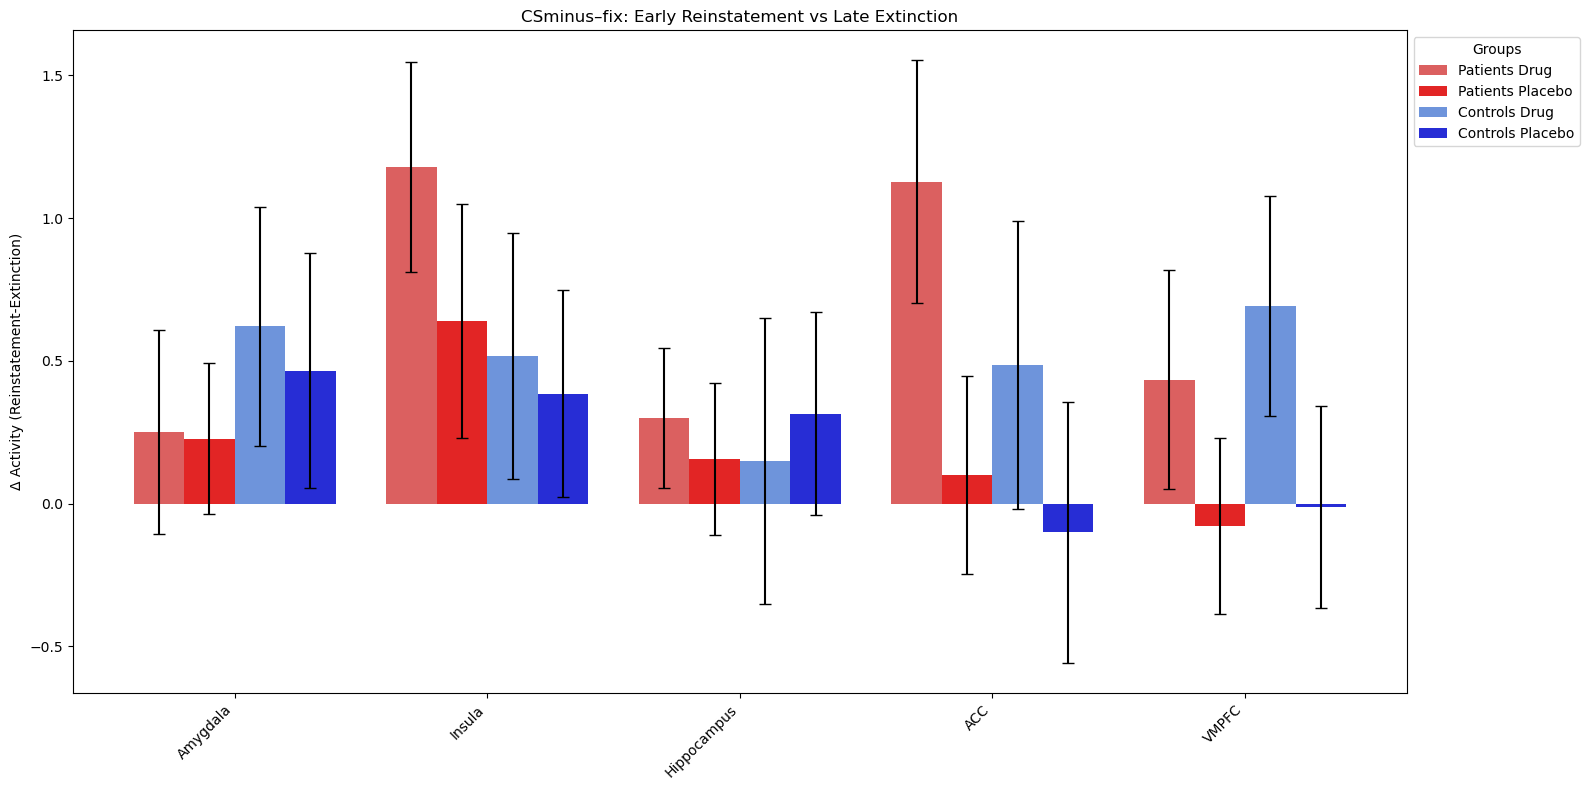

In [176]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set path
path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)

# Define regions of interest
regions_of_interest = ['Amygdala', 'Insula', 'Hippocampus', 'ACC', 'VMPFC']

# --- Group separation helper ---
def separate_groups_by_drug(sub_order, drug_order_df):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order_df.loc[sub[3:7]].values[1] == 1]
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order_df.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order_df.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order_df.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# --- Function to compute difference between two phases ---
def extract_difference_stats(data_phase2, data_phase3, sub_order_phase2, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order_phase2, drug_order_df)
    
    def group_diff_stats(sub_list, data2, data3):
        values = []
        for sub in sub_list:
            if sub in sub_order_phase2:
                idx = sub_order_phase2.index(sub)
                val2 = data2[idx].z_score()[region_no]
                val3 = data3[idx].z_score()[region_no]
                diff = val3 - val2
                values.append(diff)
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    stats = {
        'patients_drug': group_diff_stats(patients_drug, data_phase2, data_phase3),
        'patients_placebo': group_diff_stats(patients_placebo, data_phase2, data_phase3),
        'controls_drug': group_diff_stats(controls_drug, data_phase2, data_phase3),
        'controls_placebo': group_diff_stats(controls_placebo, data_phase2, data_phase3),
    }
    
    return stats

# --- Prepare data for plotting ---
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for group, (mean, se) in stats.items():
            data.append({
                'Region': region,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)

# --- Plot function ---
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ["#db6060", "#e22525", "#6e94db", "#272dd5"]
    x = np.arange(len(regions_of_interest))
    width = 0.2

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        plt.bar(
            x + i*width, group_data['Mean'],
            yerr=group_data['SE'], capsize=4,
            width=width, color=colors[i], alpha=1,
            label=group
        )
    
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel('Δ Activity (Reinstatement-Extinction)')
    plt.title(f'{title}: Early Reinstatement vs Late Extinction')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300)
    plt.show()

# --- Compute and plot the difference ---
all_stats = {}
contrast_late = 'CSminuslate-fixlate'
contrast_early = 'CSminusearly-fixearly'

for region_no, region in enumerate(regions_of_interest):
    data_phase2 = file_lists_phase2[contrast_late]
    data_phase3 = file_lists_phase3[contrast_early]
    sub_order = sub_order_phase2[contrast_late]
    
    stats = extract_difference_stats(data_phase2, data_phase3, sub_order, region_no)
    all_stats[region] = stats

# --- Final plot ---
plot_multibar_with_error_bars(all_stats, title='CSminus–fix', filename='CSR_diff_plot.png')


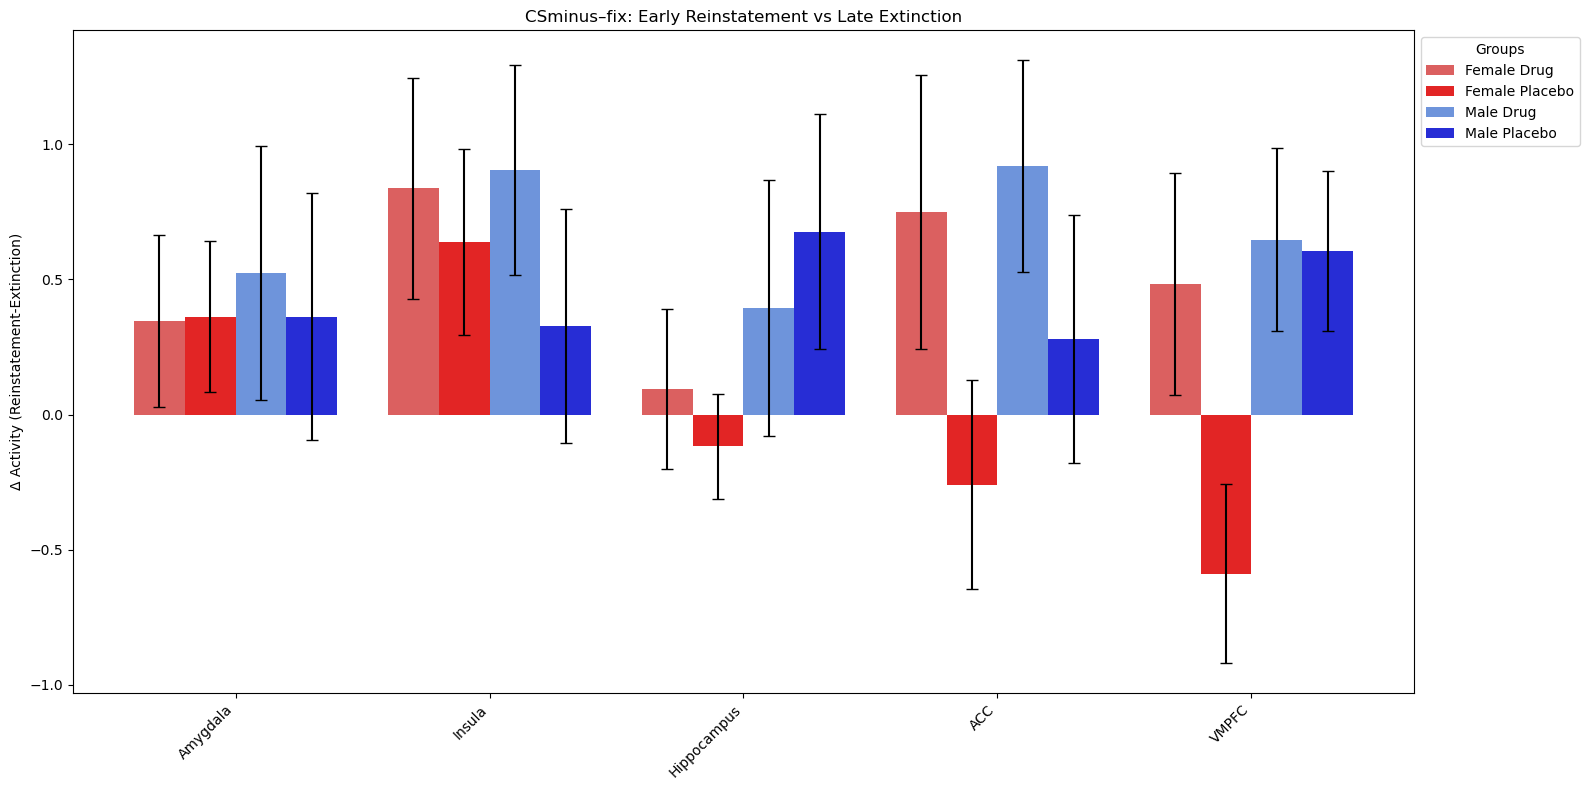

In [177]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set path
path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)

# Define regions of interest
regions_of_interest = ['Amygdala', 'Insula', 'Hippocampus', 'ACC', 'VMPFC']

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    female_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 1 and drug_order.loc[sub[3:7]].values[3] == 0]    
    female_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 0 and drug_order.loc[sub[3:7]].values[1] == 0]
    male_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 1 and drug_order.loc[sub[3:7]].values[1] == 1]
    male_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 1 and drug_order.loc[sub[3:7]].values[1] == 0]
    return female_drug, female_placebo, male_drug, male_placebo

# --- Function to compute difference between two phases ---
def extract_difference_stats(data_phase2, data_phase3, sub_order_phase2, region_no):
    female_drug, female_placebo, male_drug, male_placebo = separate_groups_by_drug(sub_order_phase2, drug_order_df)
    
    def group_diff_stats(sub_list, data2, data3):
        values = []
        for sub in sub_list:
            if sub in sub_order_phase2:
                idx = sub_order_phase2.index(sub)
                val2 = data2[idx].z_score()[region_no]
                val3 = data3[idx].z_score()[region_no]
                diff = val3 - val2
                values.append(diff)
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    stats = {
        'female_drug': group_diff_stats(female_drug, data_phase2, data_phase3),
        'female_placebo': group_diff_stats(female_placebo, data_phase2, data_phase3),
        'male_drug': group_diff_stats(male_drug, data_phase2, data_phase3),
        'male_placebo': group_diff_stats(male_placebo, data_phase2, data_phase3),
    }
    
    return stats

# --- Prepare data for plotting ---
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for group, (mean, se) in stats.items():
            data.append({
                'Region': region,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)

# --- Plot function ---
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ["#db6060", "#e22525", "#6e94db", "#272dd5"]
    x = np.arange(len(regions_of_interest))
    width = 0.2

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        plt.bar(
            x + i*width, group_data['Mean'],
            yerr=group_data['SE'], capsize=4,
            width=width, color=colors[i], alpha=1,
            label=group
        )
    
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel('Δ Activity (Reinstatement-Extinction)')
    plt.title(f'{title}: Early Reinstatement vs Late Extinction')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300)
    plt.show()

# --- Compute and plot the difference ---
all_stats = {}
contrast_late = 'CSminuslate-fixlate'
contrast_early = 'CSminusearly-fixearly'

for region_no, region in enumerate(regions_of_interest):
    data_phase2 = file_lists_phase2[contrast_late]
    data_phase3 = file_lists_phase3[contrast_early]
    sub_order = sub_order_phase2[contrast_late]
    
    stats = extract_difference_stats(data_phase2, data_phase3, sub_order, region_no)
    all_stats[region] = stats

# --- Final plot ---
plot_multibar_with_error_bars(all_stats, title='CSminus–fix', filename='CSR_diff_plot.png')


In [178]:
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp
import pandas as pd

# Define contrasts for late and early
contrast_late = 'CSminuslate-fixlate'
contrast_early = 'CSminusearly-fixearly'

# --- Helper functions ---

# Extract group data for a specific region, phase, and subject list
def extract_group_data(sub_list, data_dict, contrast_name, sub_order_dict, region_no):
    vals = []
    for sub in sub_list:
        if sub in sub_order_dict[contrast_name]:
            idx = sub_order_dict[contrast_name].index(sub)
            z_val = data_dict[contrast_name][idx].z_score()[region_no]
            vals.append(z_val)
    return vals

def separate_groups_by_drug(sub_order, drug_order_df):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order_df.loc[sub[3:7]].values[1] == 1]
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order_df.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order_df.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order_df.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# --- Build data structure with early/late values ---
def build_all_data(file_lists_phase2, file_lists_phase3, regions_of_interest, sub_order_phase2, sub_order_phase3):
    all_data = {}

    for region_no, region in enumerate(regions_of_interest):
        region_data = {}
        for group_name, sub_list in zip(
            ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo'],
            [patients_drug, patients_placebo, controls_drug, controls_placebo]
        ):
            # Extract values for early and late
            late_vals = extract_group_data(sub_list, file_lists_phase2, contrast_late, sub_order_phase2, region_no)
            early_vals = extract_group_data(sub_list, file_lists_phase3, contrast_early, sub_order_phase2, region_no)
            region_data[group_name] = {'early': early_vals, 'late': late_vals}
        all_data[region] = region_data
    return all_data


# --- Perform post-hoc tests ---
def perform_posthoc_tests_with_time(all_data):
    comparisons = []
    
    for region, group_data in all_data.items():
        for group_name, values in group_data.items():
            early_vals = values['early']
            late_vals = values['late']
            
            # Within-subject comparison: early vs late (paired t-test)
            if len(early_vals) == len(late_vals) and len(early_vals) > 1:
                t_stat, p_val = ttest_rel(early_vals, late_vals, nan_policy='omit')
                comparisons.append({
                    'Region': region,
                    'Comparison': f'{group_name}: Early vs Late',
                    't_stat': t_stat,
                    'p_val': p_val
                })
            
            # One-sample tests vs 0 for each timepoint
            for tp, vals in [('Early', early_vals), ('Late', late_vals)]:
                if len(vals) > 1:
                    t_stat, p_val = ttest_1samp(vals, 0, nan_policy='omit')
                    comparisons.append({
                        'Region': region,
                        'Comparison': f'{group_name} {tp} vs 0',
                        't_stat': t_stat,
                        'p_val': p_val
                    })
        
        # --- Between-group comparisons at each timepoint ---
        for tp in ['early', 'late']:
            # Female Drug vs Placebo
            t_stat, p_val = ttest_ind(group_data['patients_drug'][tp], group_data['patients_placebo'][tp], nan_policy='omit')
            comparisons.append({
                'Region': region,
                'Comparison': f'Patient Drug vs Placebo ({tp})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Male Drug vs Placebo
            t_stat, p_val = ttest_ind(group_data['controls_drug'][tp], group_data['controls_placebo'][tp], nan_policy='omit')
            comparisons.append({
                'Region': region,
                'Comparison': f'Control Drug vs Placebo ({tp})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Female vs Male (Drug)
            t_stat, p_val = ttest_ind(group_data['patients_drug'][tp], group_data['controls_drug'][tp], nan_policy='omit')
            comparisons.append({
                'Region': region,
                'Comparison': f'Patient Drug vs Control Drug ({tp})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Female vs Male (Placebo)
            t_stat, p_val = ttest_ind(group_data['patients_placebo'][tp], group_data['controls_placebo'][tp], nan_policy='omit')
            comparisons.append({
                'Region': region,
                'Comparison': f'Patient Placebo vs Control Placebo ({tp})',
                't_stat': t_stat,
                'p_val': p_val
            })
    
    return pd.DataFrame(comparisons)


# --- Run everything ---
all_data = build_all_data(file_lists_phase2, file_lists_phase3, regions_of_interest, sub_order_phase2, sub_order_phase2)
summary_table = perform_posthoc_tests_with_time(all_data)

# Display the summary table
pd.set_option('display.max_rows', None)
display(summary_table)


Region                                  Comparison    t_stat  \
0      Amygdala                patients_drug: Early vs Late  0.688359   
1      Amygdala                    patients_drug Early vs 0  1.723345   
2      Amygdala                     patients_drug Late vs 0  1.200093   
3      Amygdala             patients_placebo: Early vs Late  0.840922   
4      Amygdala                 patients_placebo Early vs 0  1.611460   
5      Amygdala                  patients_placebo Late vs 0  1.007154   
6      Amygdala                controls_drug: Early vs Late  1.452877   
7      Amygdala                    controls_drug Early vs 0  2.731190   
8      Amygdala                     controls_drug Late vs 0  0.609572   
9      Amygdala             controls_placebo: Early vs Late  1.114026   
10     Amygdala                 controls_placebo Early vs 0  1.925306   
11     Amygdala                  controls_placebo Late vs 0  0.312200   
12     Amygdala             Patient Drug vs Placebo (early)  0.095139   
13     Amygdala             Control Drug vs Placebo (early)  0.588515   
14     Amygdala        Patient Drug vs Control Drug (early) -0.747594   
15     Amygdala  Patient Placebo vs Control Placebo (early) -0.249491   
16     Amygdala              Patient Drug vs Placebo (late)  0.053410   
17     Amygdala              Control Drug vs Placebo (late)  0.219987   
18     Amygdala         Patient Drug vs Control Drug (late)  0.205411   
19     Amygdala   Patient Placebo vs Control Placebo (late)  0.381714   
20       Insula                patients_drug: Early vs Late  3.147255   
21       Insula                    patients_drug Early vs 0  3.779358   
22       Insula                     patients_drug Late vs 0 -1.061331   
23       Insula             patients_placebo: Early vs Late  1.518816   
24       Insula                 patients_placebo Early vs 0  1.581663   
25       Insula                  patients_placebo Late vs 0 -0.804503   
26       Insula                controls_drug: Early vs Late  1.177858   
27       Insula                    controls_drug Early vs 0  0.955859   
28       Insula                     controls_drug Late vs 0 -0.775701   
29       Insula             controls_placebo: Early vs Late  1.040842   
30       Insula                 controls_placebo Early vs 0  0.954934   
31       Insula                  controls_placebo Late vs 0 -0.710809   
32       Insula             Patient Drug vs Placebo (early)  1.544039   
33       Insula             Control Drug vs Placebo (early)  0.176131   
34       Insula        Patient Drug vs Control Drug (early)  1.577652   
35       Insula  Patient Placebo vs Control Placebo (early)  0.432864   
36       Insula              Patient Drug vs Placebo (late) -0.072410   
37       Insula              Control Drug vs Placebo (late) -0.175162   
38       Insula         Patient Drug vs Control Drug (late) -0.187000   
39       Insula   Patient Placebo vs Control Placebo (late) -0.276489   
40  Hippocampus                patients_drug: Early vs Late  1.206591   
41  Hippocampus                    patients_drug Early vs 0  2.471268   
42  Hippocampus                     patients_drug Late vs 0  1.027826   
43  Hippocampus             patients_placebo: Early vs Late  0.575743   
44  Hippocampus                 patients_placebo Early vs 0  1.137317   
45  Hippocampus                  patients_placebo Late vs 0  0.543805   
46  Hippocampus                controls_drug: Early vs Late  0.291713   
47  Hippocampus                    controls_drug Early vs 0  0.463855   
48  Hippocampus                     controls_drug Late vs 0  0.013561   
49  Hippocampus             controls_placebo: Early vs Late  0.868347   
50  Hippocampus                 controls_placebo Early vs 0  0.136734   
51  Hippocampus                  controls_placebo Late vs 0 -1.063906   
52  Hippocampus             Patient Drug vs Placebo (early)  0.626110   
53  Hippocampus             Control Drug vs Placebo (early)  0.3326

In [179]:
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp
import pandas as pd

# Define contrasts for late and early
contrast_late = 'CSminuslate-fixlate'
contrast_early = 'CSminusearly-fixearly'

# --- Helper functions ---

# Extract group data for a specific region, phase, and subject list
def extract_group_data(sub_list, data_dict, contrast_name, sub_order_dict, region_no):
    vals = []
    for sub in sub_list:
        if sub in sub_order_dict[contrast_name]:
            idx = sub_order_dict[contrast_name].index(sub)
            z_val = data_dict[contrast_name][idx].z_score()[region_no]
            vals.append(z_val)
    return vals

# Separate subjects into groups by drug and gender
def separate_groups_by_drug(sub_order, drug_order):
    female_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 1 and drug_order.loc[sub[3:7]].values[3] == 0]    
    female_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 0 and drug_order.loc[sub[3:7]].values[3] == 0]
    male_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 1 and drug_order.loc[sub[3:7]].values[3] == 1]
    male_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 0 and drug_order.loc[sub[3:7]].values[3] == 1]
    return female_drug, female_placebo, male_drug, male_placebo


# --- Build data structure with early/late values ---
def build_all_data(file_lists_phase2, file_lists_phase3, regions_of_interest, sub_order_phase2, sub_order_phase3):
    all_data = {}
    female_drug, female_placebo, male_drug, male_placebo = separate_groups_by_drug(sub_order_phase2[contrast_late], drug_order_df)
    
    for region_no, region in enumerate(regions_of_interest):
        region_data = {}
        for group_name, sub_list in zip(
            ['female_drug','female_placebo','male_drug','male_placebo'],
            [female_drug, female_placebo, male_drug, male_placebo]
        ):
            # Extract values for early and late
            late_vals = extract_group_data(sub_list, file_lists_phase2, contrast_late, sub_order_phase2, region_no)
            early_vals = extract_group_data(sub_list, file_lists_phase3, contrast_early, sub_order_phase2, region_no)
            region_data[group_name] = {'early': early_vals, 'late': late_vals}
        all_data[region] = region_data
    return all_data


# --- Perform post-hoc tests ---
def perform_posthoc_tests_with_time(all_data):
    comparisons = []
    
    for region, group_data in all_data.items():
        for group_name, values in group_data.items():
            early_vals = values['early']
            late_vals = values['late']
            
            # Within-subject comparison: early vs late (paired t-test)
            if len(early_vals) == len(late_vals) and len(early_vals) > 1:
                t_stat, p_val = ttest_rel(early_vals, late_vals, nan_policy='omit')
                comparisons.append({
                    'Region': region,
                    'Comparison': f'{group_name}: Early vs Late',
                    't_stat': t_stat,
                    'p_val': round(p_val,3)
                })
            
            # One-sample tests vs 0 for each timepoint
            for tp, vals in [('Early', early_vals), ('Late', late_vals)]:
                if len(vals) > 1:
                    t_stat, p_val = ttest_1samp(vals, 0, nan_policy='omit')
                    comparisons.append({
                        'Region': region,
                        'Comparison': f'{group_name} {tp} vs 0',
                        't_stat': t_stat,
                        'p_val': round(p_val,3)
                    })
        
        # --- Between-group comparisons at each timepoint ---
        for tp in ['early', 'late']:
            # Female Drug vs Placebo
            t_stat, p_val = ttest_ind(group_data['female_drug'][tp], group_data['female_placebo'][tp], nan_policy='omit')
            comparisons.append({
                'Region': region,
                'Comparison': f'Female Drug vs Placebo ({tp})',
                't_stat': t_stat,
                'p_val': round(p_val,3)
            })
            
            # Male Drug vs Placebo
            t_stat, p_val = ttest_ind(group_data['male_drug'][tp], group_data['male_placebo'][tp], nan_policy='omit')
            comparisons.append({
                'Region': region,
                'Comparison': f'Male Drug vs Placebo ({tp})',
                't_stat': t_stat,
                'p_val': round(p_val,3)
            })
            
            # Female vs Male (Drug)
            t_stat, p_val = ttest_ind(group_data['female_drug'][tp], group_data['male_drug'][tp], nan_policy='omit')
            comparisons.append({
                'Region': region,
                'Comparison': f'Female Drug vs Male Drug ({tp})',
                't_stat': t_stat,
                'p_val': round(p_val,3)
            })
            
            # Female vs Male (Placebo)
            t_stat, p_val = ttest_ind(group_data['female_placebo'][tp], group_data['male_placebo'][tp], nan_policy='omit')
            comparisons.append({
                'Region': region,
                'Comparison': f'Female Placebo vs Male Placebo ({tp})',
                't_stat': t_stat,
                'p_val': round(p_val,3)
            })
    
    return pd.DataFrame(comparisons)


# --- Run everything ---
all_data = build_all_data(file_lists_phase2, file_lists_phase3, regions_of_interest, sub_order_phase2, sub_order_phase3)
summary_table = perform_posthoc_tests_with_time(all_data)

# Display the summary table
pd.set_option('display.max_rows', None)
display(summary_table)


Region                              Comparison    t_stat  p_val
0      Amygdala              female_drug: Early vs Late  1.065919  0.296
1      Amygdala                  female_drug Early vs 0  2.302894  0.029
2      Amygdala                   female_drug Late vs 0  1.578115  0.126
3      Amygdala           female_placebo: Early vs Late  1.267077  0.217
4      Amygdala               female_placebo Early vs 0  2.411725  0.024
5      Amygdala                female_placebo Late vs 0  1.933287  0.065
6      Amygdala                male_drug: Early vs Late  1.090637  0.287
7      Amygdala                    male_drug Early vs 0  2.069836  0.050
8      Amygdala                     male_drug Late vs 0  0.297264  0.769
9      Amygdala             male_placebo: Early vs Late  0.773250  0.448
10     Amygdala                 male_placebo Early vs 0  1.012004  0.323
11     Amygdala                  male_placebo Late vs 0 -0.320469  0.752
12     Amygdala          Female Drug vs Placebo (early) -0.159514  0.874
13     Amygdala            Male Drug vs Placebo (early)  0.882679  0.382
14     Amygdala        Female Drug vs Male Drug (early)  0.095645  0.924
15     Amygdala  Female Placebo vs Male Placebo (early)  1.127687  0.265
16     Amygdala           Female Drug vs Placebo (late) -0.182505  0.856
17     Amygdala             Male Drug vs Placebo (late)  0.437927  0.664
18     Amygdala         Female Drug vs Male Drug (late)  0.655143  0.515
19     Amygdala   Female Placebo vs Male Placebo (late)  1.285151  0.205
20       Insula              female_drug: Early vs Late  2.010422  0.054
21       Insula                  female_drug Early vs 0  2.291427  0.030
22       Insula                   female_drug Late vs 0 -1.028706  0.313
23       Insula           female_placebo: Early vs Late  1.824690  0.080
24       Insula               female_placebo Early vs 0  1.514409  0.142
25       Insula                female_placebo Late vs 0 -1.342527  0.191
26       Insula                male_drug: Early vs Late  2.284661  0.032
27       Insula                    male_drug Early vs 0  2.152830  0.043
28       Insula                     male_drug Late vs 0 -0.807581  0.428
29       Insula             male_placebo: Early vs Late  0.741679  0.466
30       Insula                 male_placebo Early vs 0  0.921596  0.367
31       Insula                  male_placebo Late vs 0 -0.285604  0.778
32       Insula          Female Drug vs Placebo (early)  0.647064  0.520
33       Insula            Male Drug vs Placebo (early)  1.097770  0.278
34       Insula        Female Drug vs Male Drug (early) -0.407991  0.685
35       Insula  Female Placebo vs Male Placebo (early)  0.269273  0.789
36       Insula           Female Drug vs Placebo (late)  0.008553  0.993
37       Insula             Male Drug vs Placebo (late) -0.298762  0.767
38       Insula         Female Drug vs Male Drug (late) -0.205938  0.838
39       Insula   Female Placebo vs Male Placebo (late) -0.548968  0.586
40  Hippocampus              female_drug: Early vs Late  0.317379  0.753
41  Hippocampus                  female_drug Early vs 0  1.587503  0.124
42  Hippocampus                   female_drug Late vs 0  0.978109  0.337
43  Hippocampus           female_placebo: Early vs Late -0.591812  0.559
44  Hippocampus               female_placebo Early vs 0  0.752958  0.459
45  Hippocampus                female_placebo Late vs 0  1.311504  0.202
46  Hippocampus                male_drug: Early vs Late  0.812438  0.425
47  Hippocampus                    male_drug Early vs 0  0.994413  0.331
48  Hippocampus                     male_drug Late vs 0 -0.192425  0.849
49  Hippocampus             male_placebo: Early vs Late  1.518919  0.144
50  Hippocampus                 male_placebo Early vs 0  0.514694  0.612
51  Hippocampus                  male_placebo Late vs 0 -1.756220  0.094
52  Hippocampus          Female Drug vs Placebo (early)  0.618174  0.539
53  Hippocampus            Male Drug vs Placebo (early)  0.470815  

### Extinction

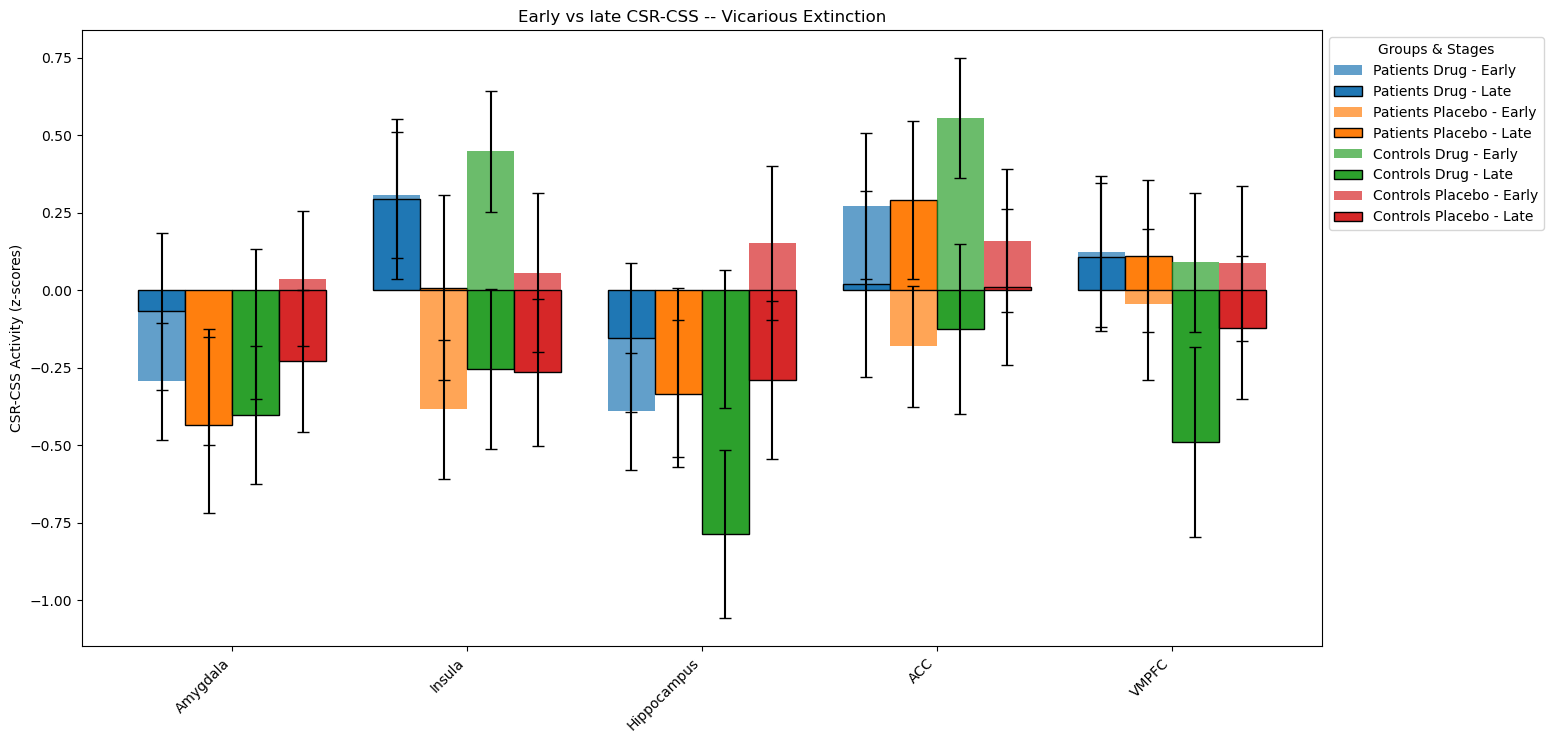

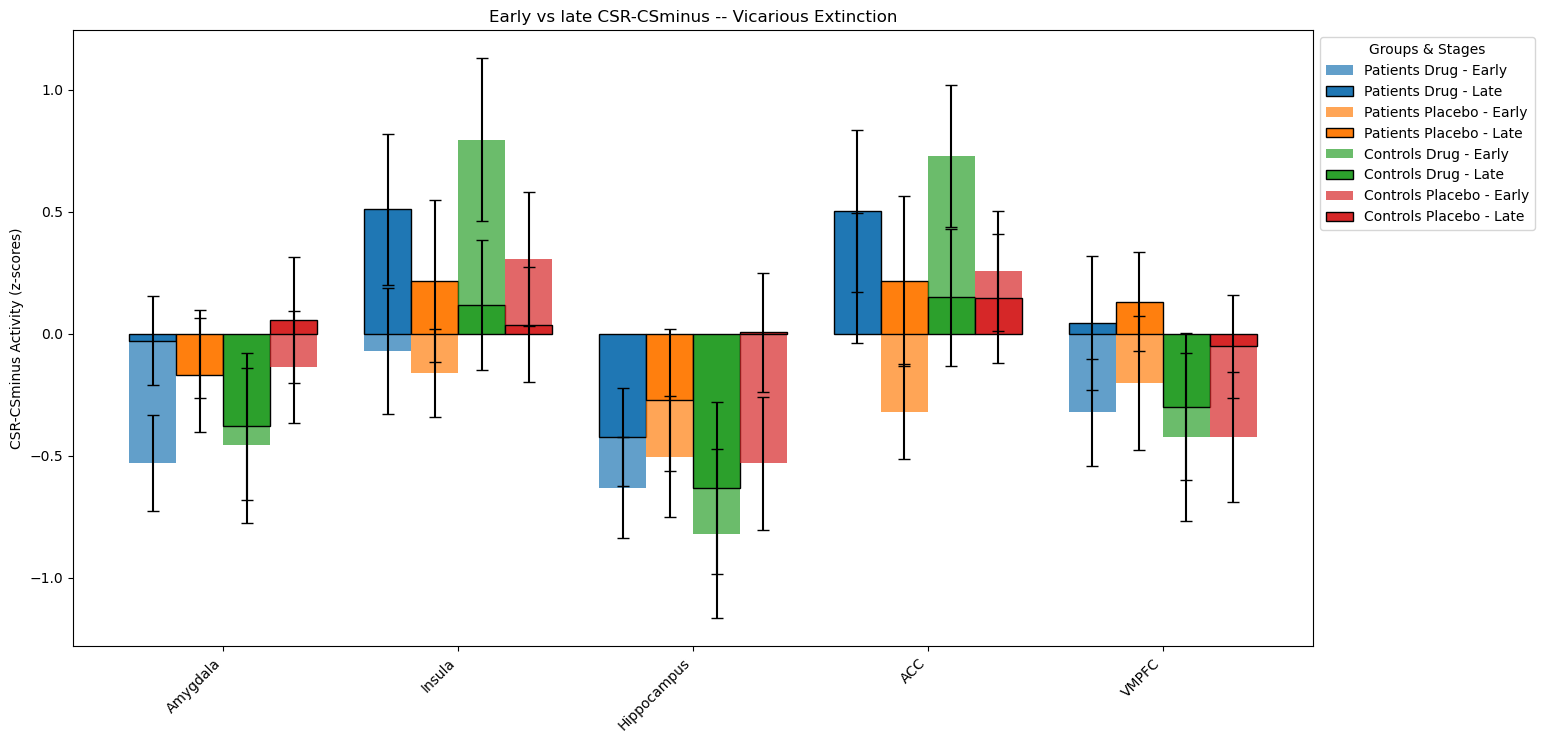

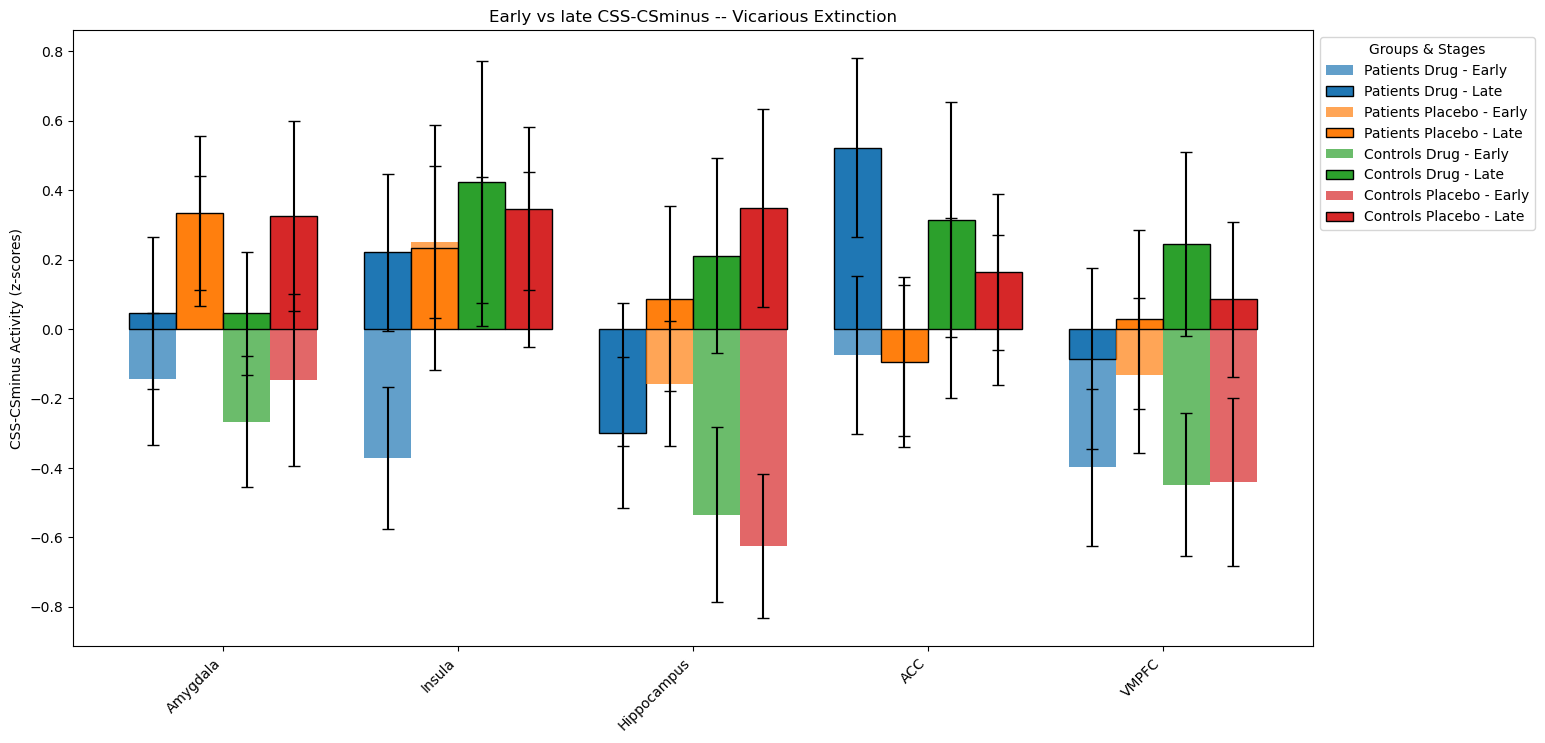

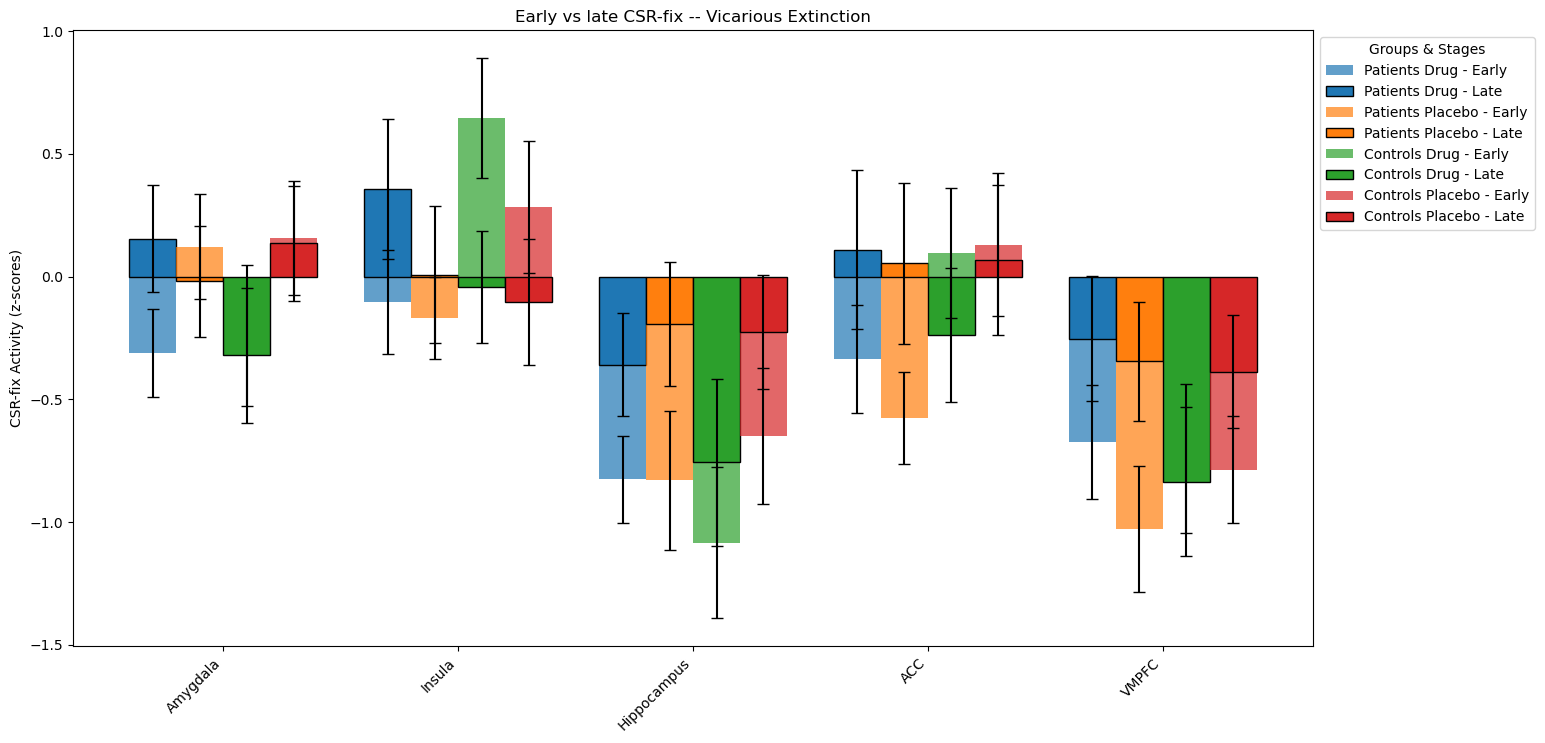

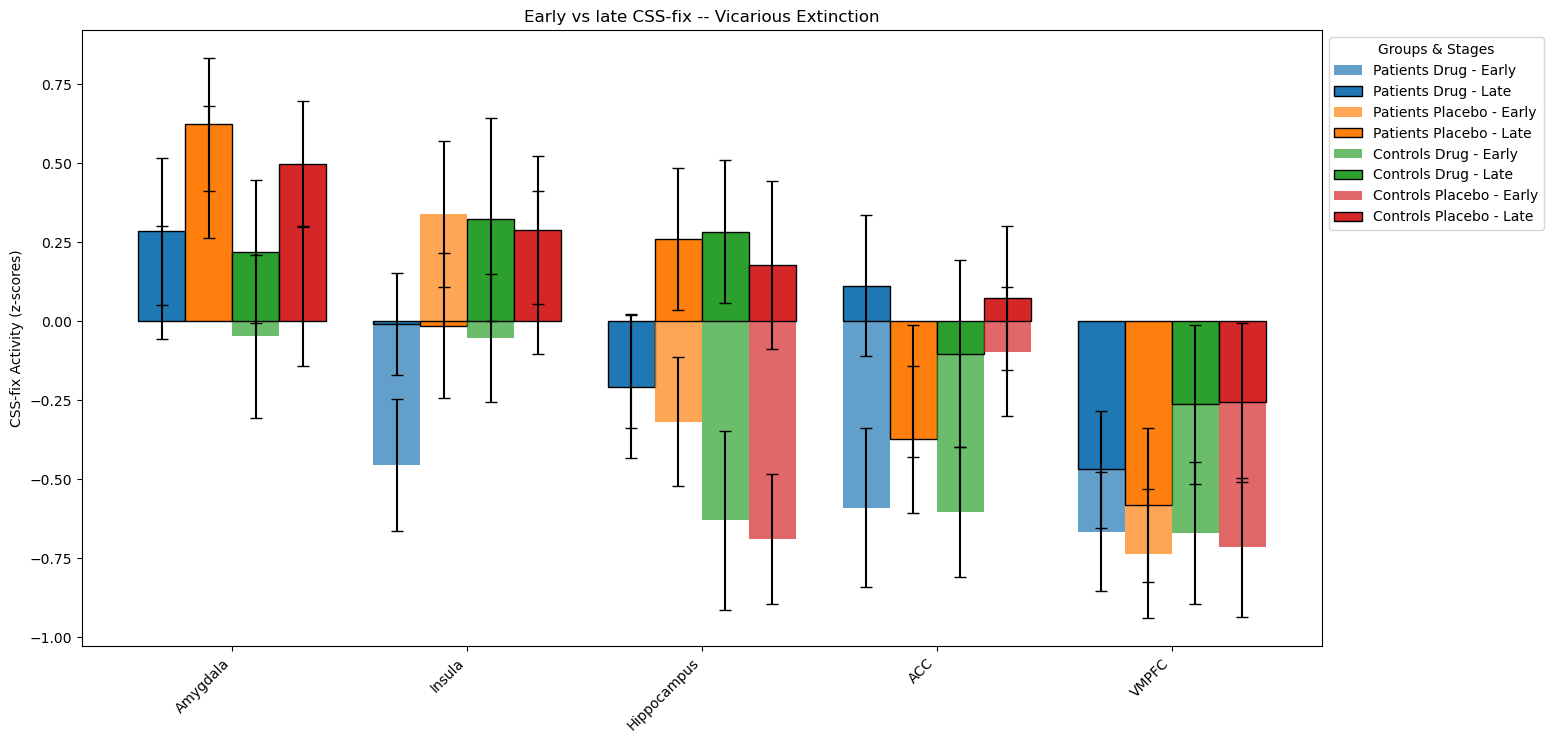

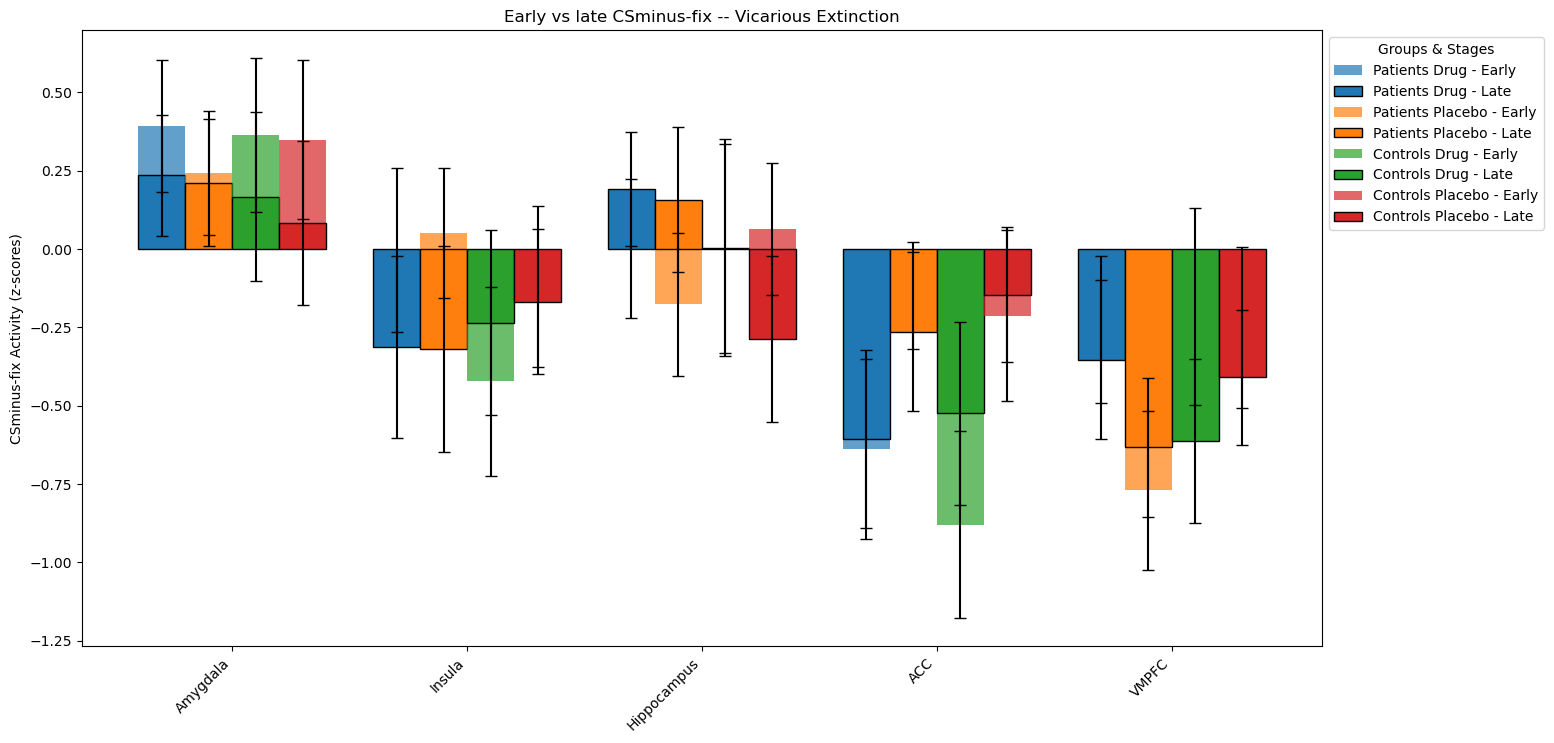

In [ ]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for stage in ['early', 'late']:
            for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
                mean, se = stats[f'{group}_{stage}']
                data.append({
                    'Region': region,
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Group': group.replace('_', ' ').title(),
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats_early_late(data_early, data_late, sub_order, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'patients_drug_early': group_stats(patients_drug, data_early),
        'patients_drug_late': group_stats(patients_drug, data_late),
        'patients_placebo_early': group_stats(patients_placebo, data_early),
        'patients_placebo_late': group_stats(patients_placebo, data_late),
        'controls_drug_early': group_stats(controls_drug, data_early),
        'controls_drug_late': group_stats(controls_drug, data_late),
        'controls_placebo_early': group_stats(controls_placebo, data_early),
        'controls_placebo_late': group_stats(controls_placebo, data_late),
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Early']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Early']['SE'], 
                capsize=4, width=width, color=colors[i], alpha=0.7, label=f'{group} - Early')
        
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Late']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Late']['SE'],
                capsize=4, width=width, color=colors[i], alpha=1, edgecolor='black', label=f'{group} - Late')
    
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'Early vs late {title} -- Vicarious Extinction')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CSSearly'
    contrast_late = 'CSRlate-CSSlate'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_vicextinction.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CS-early'
    contrast_late = 'CSRlate-CS-late'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSminus'
plot_multibar_with_error_bars(all_stats, title,filename='CSR-CSminus_vicextinction.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSSearly-CS-early'
    contrast_late = 'CSSlate-CS-late'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CSminus'
plot_multibar_with_error_bars(all_stats, title,filename='CSS-CSminus_vicextinction.png')


all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-fixearly'
    contrast_late = 'CSRlate-fixlate'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSR-fix_vicextinction.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSSearly-fixearly'
    contrast_late = 'CSSlate-fixlate'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSS-fix_vicextinction.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSminusearly-fixearly'
    contrast_late = 'CSminuslate-fixlate'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSminus-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSminus-fix_vicextinction.png')


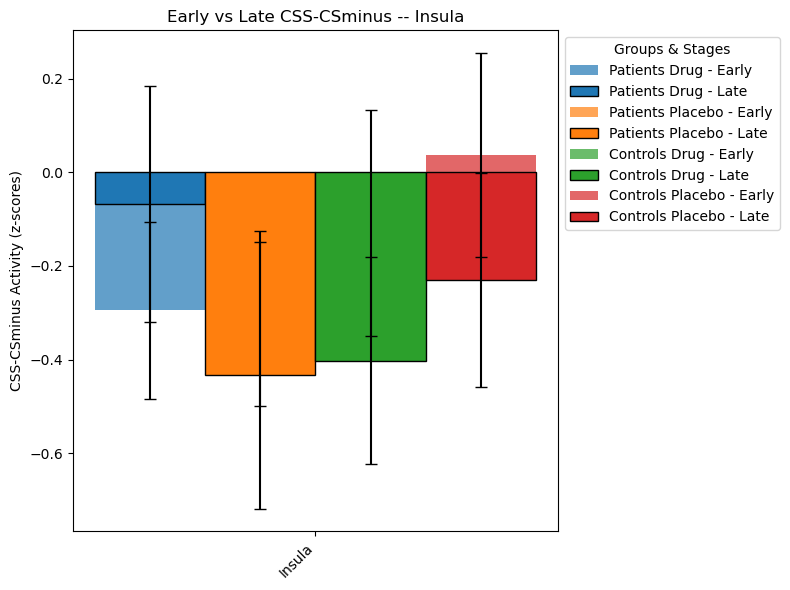

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)

# Define only Insula as the region of interest
regions_of_interest = ['Insula']

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for stage in ['early', 'late']:
            for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
                mean, se = stats[f'{group}_{stage}']
                data.append({
                    'Region': region,
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Group': group.replace('_', ' ').title(),
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats_early_late(data_early, data_late, sub_order, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'patients_drug_early': group_stats(patients_drug, data_early),
        'patients_drug_late': group_stats(patients_drug, data_late),
        'patients_placebo_early': group_stats(patients_placebo, data_early),
        'patients_placebo_late': group_stats(patients_placebo, data_late),
        'controls_drug_early': group_stats(controls_drug, data_early),
        'controls_drug_late': group_stats(controls_drug, data_late),
        'controls_placebo_early': group_stats(controls_placebo, data_early),
        'controls_placebo_late': group_stats(controls_placebo, data_late),
    }
    
    return stats

# Function to plot a multibar plot for Insula only with error bars
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(8, 6))  # Adjusted size for single region plot
    groups = df['Group'].unique()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group
    
    # Plot each stage (Early and Late) as grouped bars with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for Insula
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Early']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Early']['SE'], 
                capsize=4, width=width, color=colors[i], alpha=0.7, label=f'{group} - Early')
        
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Late']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Late']['SE'],
                capsize=4, width=width, color=colors[i], alpha=1, edgecolor='black', label=f'{group} - Late')
    
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'Early vs Late {title} -- Insula')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300)
    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
region_no = regions_of_interest.index('Insula')
region = 'Insula'
contrast_early = 'CSRearly-CSSearly'
contrast_late = 'CSRlate-CSSlate'
region_data_early = file_lists_phase2[contrast_early]
region_data_late = file_lists_phase2[contrast_late]

stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
all_stats[region] = stats

# Plot the multibar plot for Insula only
plot_multibar_with_error_bars(all_stats, title, filename=f'{title}_Insula_vicextinction.png')


In [ ]:
# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]
regions_of_interest.index('Insula')

1

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]


contrast_early = 'CSRearly-CSSearly'
contrast_late = 'CSRlate-CSSlate'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
early_data = extract_contrast_data(file_lists_phase2, contrast_early, regions_of_interest, sub_order_phase2)
late_data = extract_contrast_data(file_lists_phase2, contrast_late, regions_of_interest, sub_order_phase2)

# Function to prepare regression data
def prepare_regression_data(early_data, late_data, sub_order, drug_order_df):
    data = []
    
    for region in early_data.keys():
        for idx, sub in enumerate(sub_order['CSRearly-CSSearly']):
            subID = sub[3:7]
            time_values = [1, 2]  # Early = 1, Late = 2
            values = [early_data[region][idx], late_data[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for time, y in zip(time_values, values):
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'Time': time,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(early_data, late_data, sub_order_phase2, drug_order_df)

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ DrugOrder * PatientGroup * Time + Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.5678
Date:                Tue, 12 Nov 2024   Prob (F-statistic):              0.803
Time:                        12:39:47   Log-Likelihood:                -310.82
No. Observations:                 200   AIC:                             639.6
Df Residuals:                     191   BIC:                             669.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [ ]:
from scipy.stats import ttest_ind
import pandas as pd

contrast = 'CSRearly-CSSearly'

# Function to perform post-hoc comparisons and store in summary table
def perform_posthoc_tests(all_data):
    comparisons = []
    
    for region, stats in all_data.items():
        # Early vs Late within each group
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            early_vals = stats[group]['early']
            late_vals = stats[group]['late']
            t_stat, p_val = ttest_ind(early_vals, late_vals)
            comparisons.append({
                'Region': region,
                'Comparison': f'{group.replace("_", " ").title()} Early vs Late',
                't_stat': t_stat,
                'p_val': p_val
            })
        
        # Group comparisons within Early and Late stages
        for stage in ['early', 'late']:
            # Patients Drug vs Placebo
            t_stat, p_val = ttest_ind(stats['patients_drug'][stage], stats['patients_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Drug vs Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Controls Drug vs Placebo
            t_stat, p_val = ttest_ind(stats['controls_drug'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Controls Drug vs Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Patients Drug vs Controls Drug
            t_stat, p_val = ttest_ind(stats['patients_drug'][stage], stats['controls_drug'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Drug vs Controls Drug ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Patients Placebo vs Controls Placebo
            t_stat, p_val = ttest_ind(stats['patients_placebo'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Placebo vs Controls Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase2[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 1]    
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# Retrieve groups by calling the function
patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order_phase2[contrast], drug_order_df)

# Now, populate all_data with actual values
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data_early = file_lists_phase2['CSRearly-CSSearly']
    region_data_late = file_lists_phase2['CSRlate-CSSlate']
    region_all_data = {
        'patients_drug': {'early': extract_group_data(patients_drug, region_data_early, region_no),
                          'late': extract_group_data(patients_drug, region_data_late, region_no)},
        'patients_placebo': {'early': extract_group_data(patients_placebo, region_data_early, region_no),
                             'late': extract_group_data(patients_placebo, region_data_late, region_no)},
        'controls_drug': {'early': extract_group_data(controls_drug, region_data_early, region_no),
                          'late': extract_group_data(controls_drug, region_data_late, region_no)},
        'controls_placebo': {'early': extract_group_data(controls_placebo, region_data_early, region_no),
                             'late': extract_group_data(controls_placebo, region_data_late, region_no)},
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table
summary_table = perform_posthoc_tests(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


Region                                    Comparison    t_stat  \
0      Amygdala                   Patients Drug Early vs Late -0.703573   
1      Amygdala                Patients Placebo Early vs Late  0.349061   
2      Amygdala                   Controls Drug Early vs Late  0.880961   
3      Amygdala                Controls Placebo Early vs Late  0.826673   
4      Amygdala              Patients Drug vs Placebo (Early)  0.065690   
5      Amygdala              Controls Drug vs Placebo (Early) -0.435920   
6      Amygdala        Patients Drug vs Controls Drug (Early) -0.602415   
7      Amygdala  Patients Placebo vs Controls Placebo (Early) -1.160904   
8      Amygdala               Patients Drug vs Placebo (Late)  0.943394   
9      Amygdala               Controls Drug vs Placebo (Late) -0.529953   
10     Amygdala         Patients Drug vs Controls Drug (Late)  0.965616   
11     Amygdala   Patients Placebo vs Controls Placebo (Late) -0.554807   
12       Insula                   Patients Drug Early vs Late  0.041488   
13       Insula                Patients Placebo Early vs Late -1.029697   
14       Insula                   Controls Drug Early vs Late  2.120759   
15       Insula                Controls Placebo Early vs Late  0.906388   
16       Insula              Patients Drug vs Placebo (Early)  2.240633   
17       Insula              Controls Drug vs Placebo (Early)  1.170446   
18       Insula        Patients Drug vs Controls Drug (Early) -0.486698   
19       Insula  Patients Placebo vs Controls Placebo (Early) -1.238171   
20       Insula               Patients Drug vs Placebo (Late)  0.713231   
21       Insula               Controls Drug vs Placebo (Late)  0.033339   
22       Insula         Patients Drug vs Controls Drug (Late)  1.462634   
23       Insula   Patients Placebo vs Controls Placebo (Late)  0.714789   
24  Hippocampus                   Patients Drug Early vs Late -0.763307   
25  Hippocampus                Patients Placebo Early vs Late  0.181913   
26  Hippocampus                   Controls Drug Early vs Late  1.752739   
27  Hippocampus                Controls Placebo Early vs Late  1.221607   
28  Hippocampus              Patients Drug vs Placebo (Early) -0.379388   
29  Hippocampus              Controls Drug vs Placebo (Early) -0.898290   
30  Hippocampus        Patients Drug vs Controls Drug (Early) -0.788894   
31  Hippocampus  Patients Placebo vs Controls Placebo (Early) -1.107043   
32  Hippocampus               Patients Drug vs Placebo (Late)  0.515372   
33  Hippocampus               Controls Drug vs Placebo (Late) -1.307405   
34  Hippocampus         Patients Drug vs Controls Drug (Late)  1.716751   
35  Hippocampus   Patients Placebo vs Controls Placebo (Late) -0.117212   
36          ACC                   Patients Drug Early vs Late  0.645444   
37          ACC                Patients Placebo Early vs Late -1.430947   
38          ACC                   Controls Drug Early vs Late  1.995720   
39          ACC                Controls Placebo Early vs Late  0.430133   
40          ACC              Patients Drug vs Placebo (Early)  1.403730   
41          ACC              Controls Drug vs Placebo (Early)  1.274283   
42          ACC        Patients Drug vs Controls Drug (Early) -0.900892   
43          ACC  Patients Placebo vs Controls Placebo (Early) -1.073315   
44          ACC               Patients Drug vs Placebo (Late) -0.653230   
45          ACC               Controls Drug vs Placebo (Late) -0.357798   
46          ACC         Patients Drug vs Controls Drug (Late)  0.347999   
47          ACC   Patients Placebo vs Controls Placebo (Late)  0.758595   
48        VMPFC                   Patients Drug Early vs Late  0.049120   
49        VMPFC                Patients Placebo Early vs Late -0.438461   
50        VMPFC                   Controls Drug Early vs Late  1.495142   
51        VMPFC                Controls Placebo Early vs Late  0.598675   
52        VMPFC              Patie

#### placebo only! 

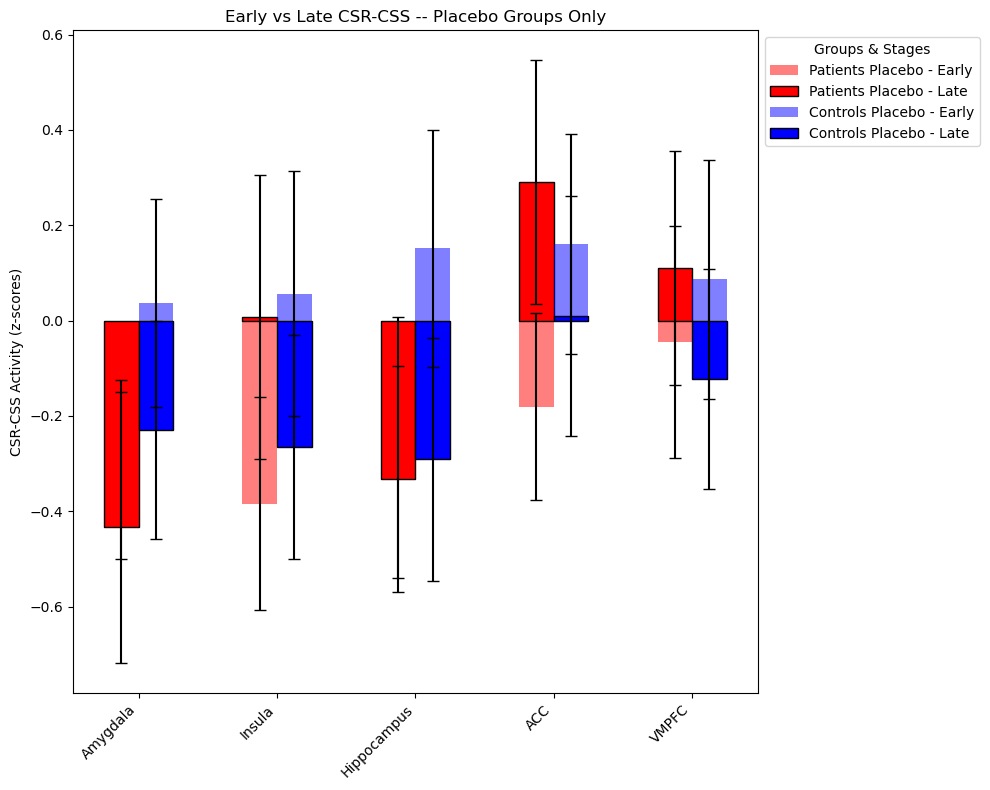

In [ ]:
### just placebo ! 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to prepare data for multibar plot with error bars, only for placebo groups
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for stage in ['early', 'late']:
            for group in ['patients_placebo', 'controls_placebo']:
                mean, se = stats[f'{group}_{stage}']
                data.append({
                    'Region': region,
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Group': group.replace('_', ' ').title(),
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts, only for placebo groups
def extract_stats_early_late(data_early, data_late, sub_order, region_no):
    _, patients_placebo, _, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each placebo group for both early and late contrasts
    stats = {
        'patients_placebo_early': group_stats(patients_placebo, data_early),
        'patients_placebo_late': group_stats(patients_placebo, data_late),
        'controls_placebo_early': group_stats(controls_placebo, data_early),
        'controls_placebo_late': group_stats(controls_placebo, data_late),
    }
    
    return stats

# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(10, 8))
    groups = df['Group'].unique()
    colors = ['red', 'blue']  # Colors for each placebo group

    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.25  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Early']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Early']['SE'], 
                capsize=4, width=width, color=colors[i], alpha=0.5, label=f'{group} - Early')
        
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Late']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Late']['SE'],
                capsize=4, width=width, color=colors[i], alpha=1, edgecolor='black', label=f'{group} - Late')
    
    # Customize the plot
    plt.xticks(x + width * 0.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'Early vs Late {title} -- Placebo Groups Only')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300)
    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CSSearly'
    contrast_late = 'CSRlate-CSSlate'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions for placebo condition only
title = 'CSR-CSS'
filename = 'CSR-CSS_placebo_vicext_ROIs_combined.png'
plot_multibar_with_error_bars(all_stats, title,filename)

# for region_no, region in enumerate(regions_of_interest):
#     contrast_early = 'CSRearly-CS-early'
#     contrast_late = 'CSRlate-CS-late'
#     region_data_early = file_lists_phase2[contrast_early]
#     region_data_late = file_lists_phase2[contrast_late]
    
#     stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
#     all_stats[region] = stats

# # Plot combined multibar plot across all regions for placebo condition only
# title = 'CSR-CS-'
# plot_multibar_with_error_bars(all_stats, title, filename)


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast_early = 'CSRearly-CSSearly'
contrast_late = 'CSRlate-CSSlate'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx, sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
early_data = extract_contrast_data(file_lists_phase2, contrast_early, regions_of_interest, sub_order_phase2)
late_data = extract_contrast_data(file_lists_phase2, contrast_late, regions_of_interest, sub_order_phase2)

# Function to prepare regression data
def prepare_regression_data(early_data, late_data, sub_order, drug_order_df):
    data = []
    
    for region in early_data.keys():
        for idx, sub in enumerate(sub_order['CSRearly-CSSearly']):
            subID = sub[3:7]
            time_values = [1, 2]  # Early = 1, Late = 2
            values = [early_data[region][idx], late_data[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            
            # Only include placebo subjects
            if drug_order == 0:
                patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
                gender = drug_order_df.loc[subID].values[3]  # Gender coding
                
                for time, y in zip(time_values, values):
                    data.append({
                        'Subject': subID,
                        'Region': region,
                        'y': y,
                        'Time': time,
                        'PatientGroup': patient_group,
                        'Gender': gender
                    })
    
    return pd.DataFrame(data)

# Prepare the regression data for placebo only
df = prepare_regression_data(early_data, late_data, sub_order_phase2, drug_order_df)

# Loop through each region, run the model without DrugOrder, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model without DrugOrder
    model = smf.ols('y ~ PatientGroup * Time', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.7237
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.540
Time:                        16:21:56   Log-Likelihood:                -152.49
No. Observations:                  98   AIC:                             313.0
Df Residuals:                      94   BIC:                             323.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept  

In [ ]:
from scipy.stats import ttest_ind
import pandas as pd

contrast = 'CSRearly-CSSearly'

# Function to perform post-hoc comparisons and store in summary table (only placebo groups)
def perform_posthoc_tests_placebo(all_data):
    comparisons = []
    
    for region, stats in all_data.items():
        # Early vs Late within each placebo group
        for group in ['patients_placebo', 'controls_placebo']:
            early_vals = stats[group]['early']
            late_vals = stats[group]['late']
            t_stat, p_val = ttest_ind(early_vals, late_vals)
            comparisons.append({
                'Region': region,
                'Comparison': f'{group.replace("_", " ").title()} Early vs Late',
                't_stat': t_stat,
                'p_val': p_val
            })
        
        # Group comparisons within Early and Late stages for placebo groups
        for stage in ['early', 'late']:
            # Patients Placebo vs Controls Placebo
            t_stat, p_val = ttest_ind(stats['patients_placebo'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Placebo vs Controls Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase2[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects, keeping only placebo groups
def separate_groups_by_placebo(sub_order, drug_order):
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_placebo, controls_placebo

# Retrieve placebo groups by calling the function
patients_placebo, controls_placebo = separate_groups_by_placebo(sub_order_phase2[contrast], drug_order_df)

# Populate all_data with actual values for placebo groups
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data_early = file_lists_phase2['CSRearly-CSSearly']
    region_data_late = file_lists_phase2['CSRlate-CSSlate']
    region_all_data = {
        'patients_placebo': {'early': extract_group_data(patients_placebo, region_data_early, region_no),
                             'late': extract_group_data(patients_placebo, region_data_late, region_no)},
        'controls_placebo': {'early': extract_group_data(controls_placebo, region_data_early, region_no),
                             'late': extract_group_data(controls_placebo, region_data_late, region_no)},
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table (placebo only)
summary_table = perform_posthoc_tests_placebo(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


Region                                    Comparison    t_stat  \
0      Amygdala                Patients Placebo Early vs Late  0.349061   
1      Amygdala                Controls Placebo Early vs Late  0.826673   
2      Amygdala  Patients Placebo vs Controls Placebo (Early) -1.160904   
3      Amygdala   Patients Placebo vs Controls Placebo (Late) -0.554807   
4        Insula                Patients Placebo Early vs Late -1.029697   
5        Insula                Controls Placebo Early vs Late  0.906388   
6        Insula  Patients Placebo vs Controls Placebo (Early) -1.238171   
7        Insula   Patients Placebo vs Controls Placebo (Late)  0.714789   
8   Hippocampus                Patients Placebo Early vs Late  0.181913   
9   Hippocampus                Controls Placebo Early vs Late  1.221607   
10  Hippocampus  Patients Placebo vs Controls Placebo (Early) -1.107043   
11  Hippocampus   Patients Placebo vs Controls Placebo (Late) -0.117212   
12          ACC                Patients Placebo Early vs Late -1.430947   
13          ACC                Controls Placebo Early vs Late  0.430133   
14          ACC  Patients Placebo vs Controls Placebo (Early) -1.073315   
15          ACC   Patients Placebo vs Controls Placebo (Late)  0.758595   
16        VMPFC                Patients Placebo Early vs Late -0.438461   
17        VMPFC                Controls Placebo Early vs Late  0.598675   
18        VMPFC  Patients Placebo vs Controls Placebo (Early) -0.362379   
19        VMPFC   Patients Placebo vs Controls Placebo (Late)  0.671727   

       p_val  
0   0.728788  
1   0.412200  
2   0.251543  
3   0.581658  
4   0.309046  
5   0.368912  
6   0.221802  
7   0.478275  
8   0.856526  
9   0.227366  
10  0.273909  
11  0.907191  
12  0.159844  
13  0.668876  
14  0.288610  
15  0.451882  
16  0.663299  
17  0.551989  
18  0.718693  
19  0.505046

### Reinstatement

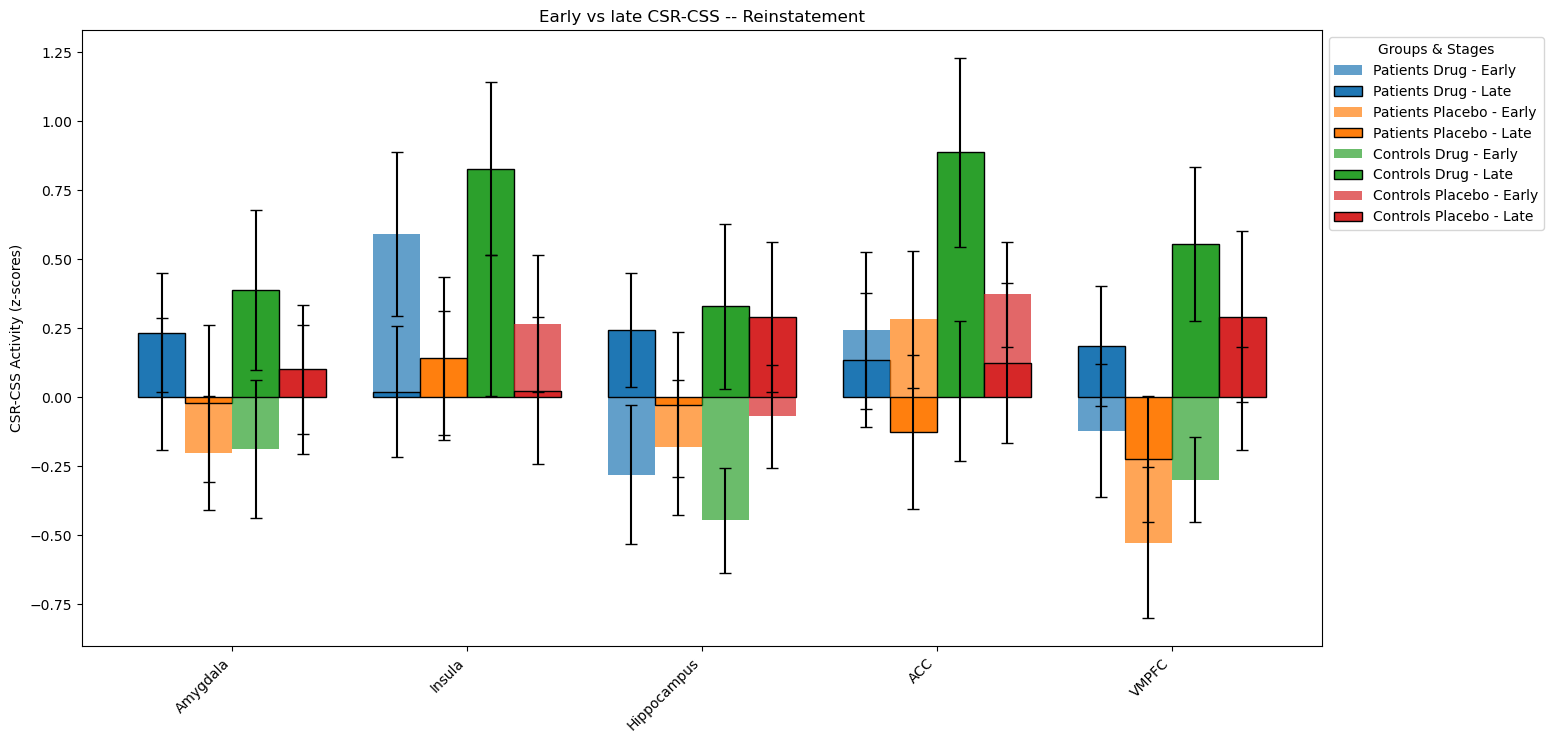

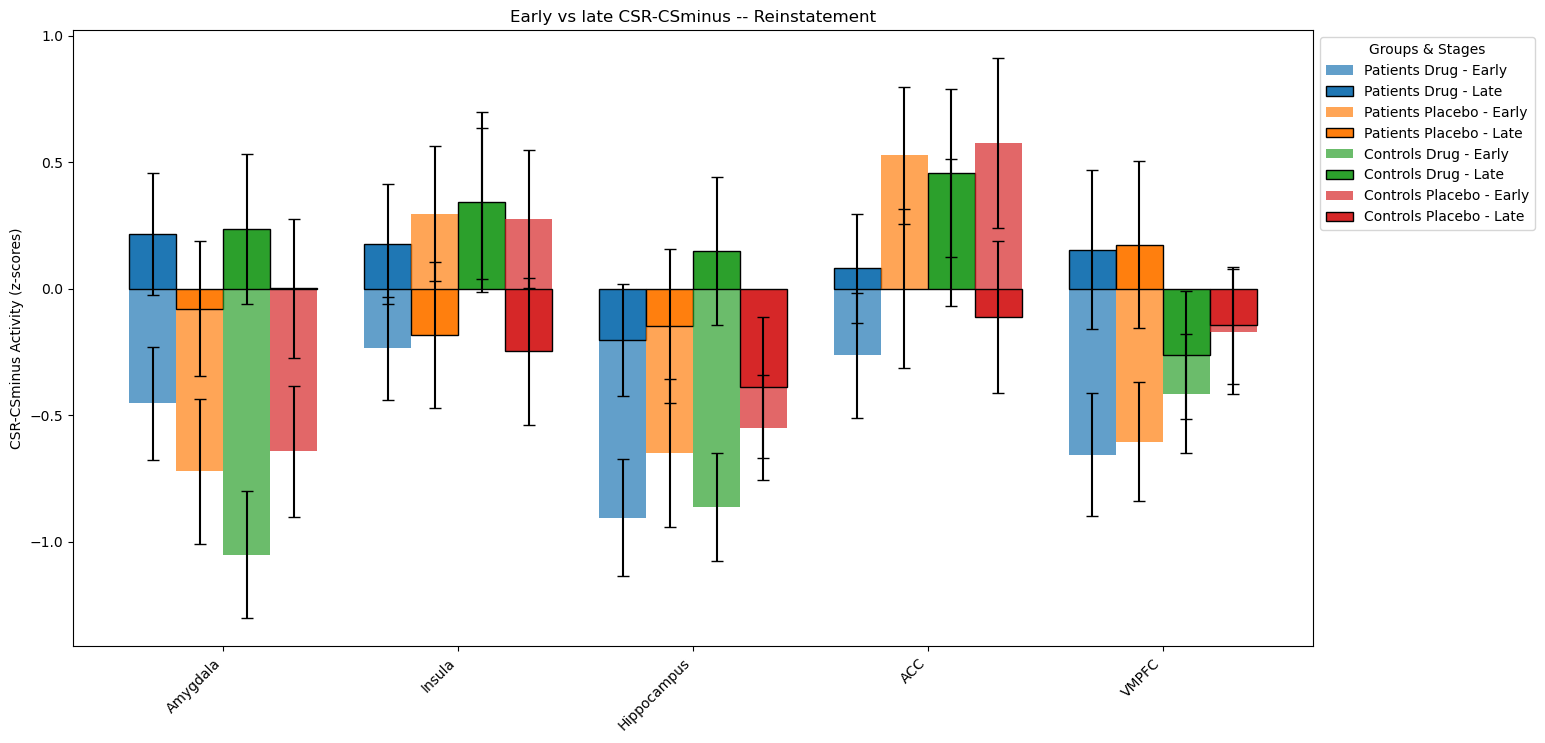

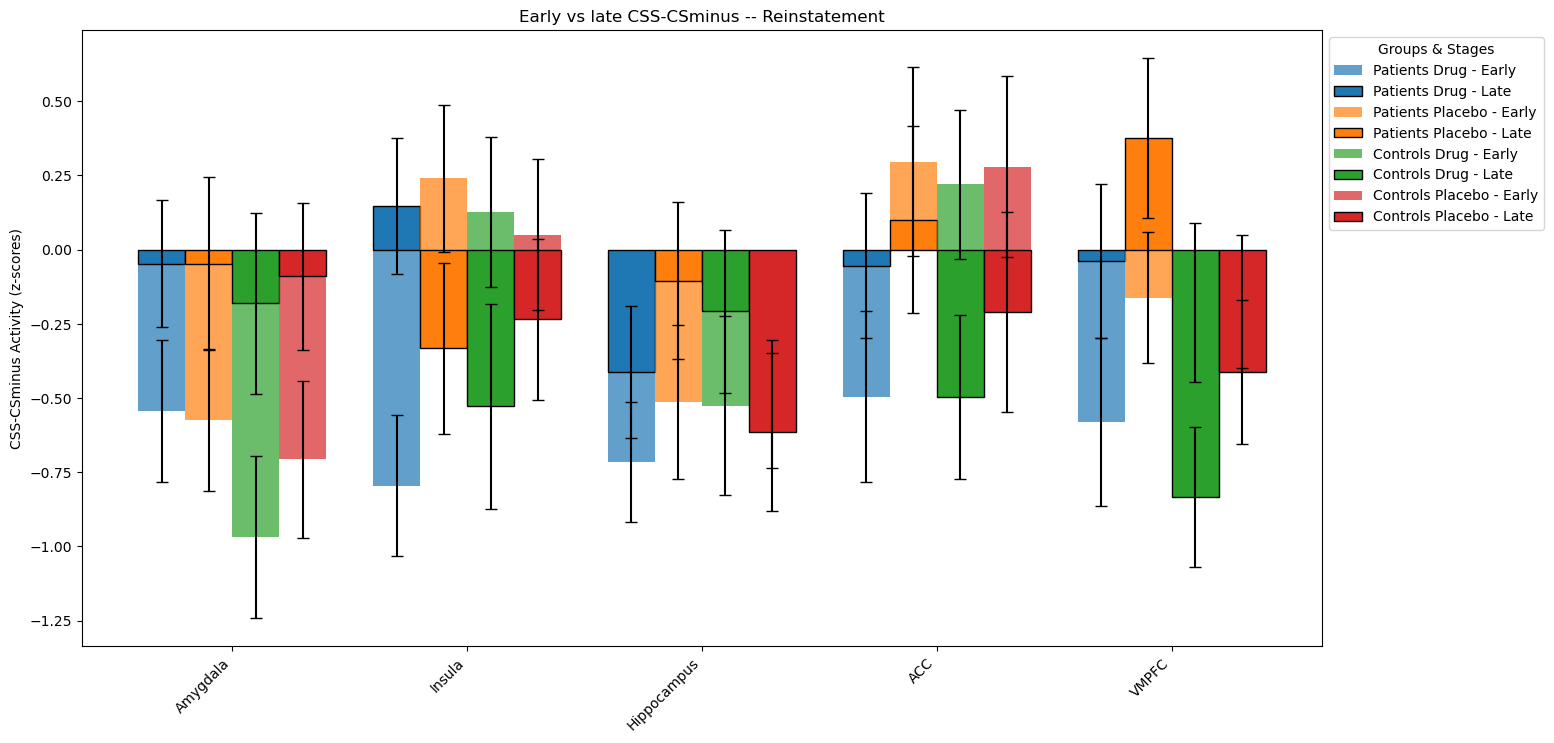

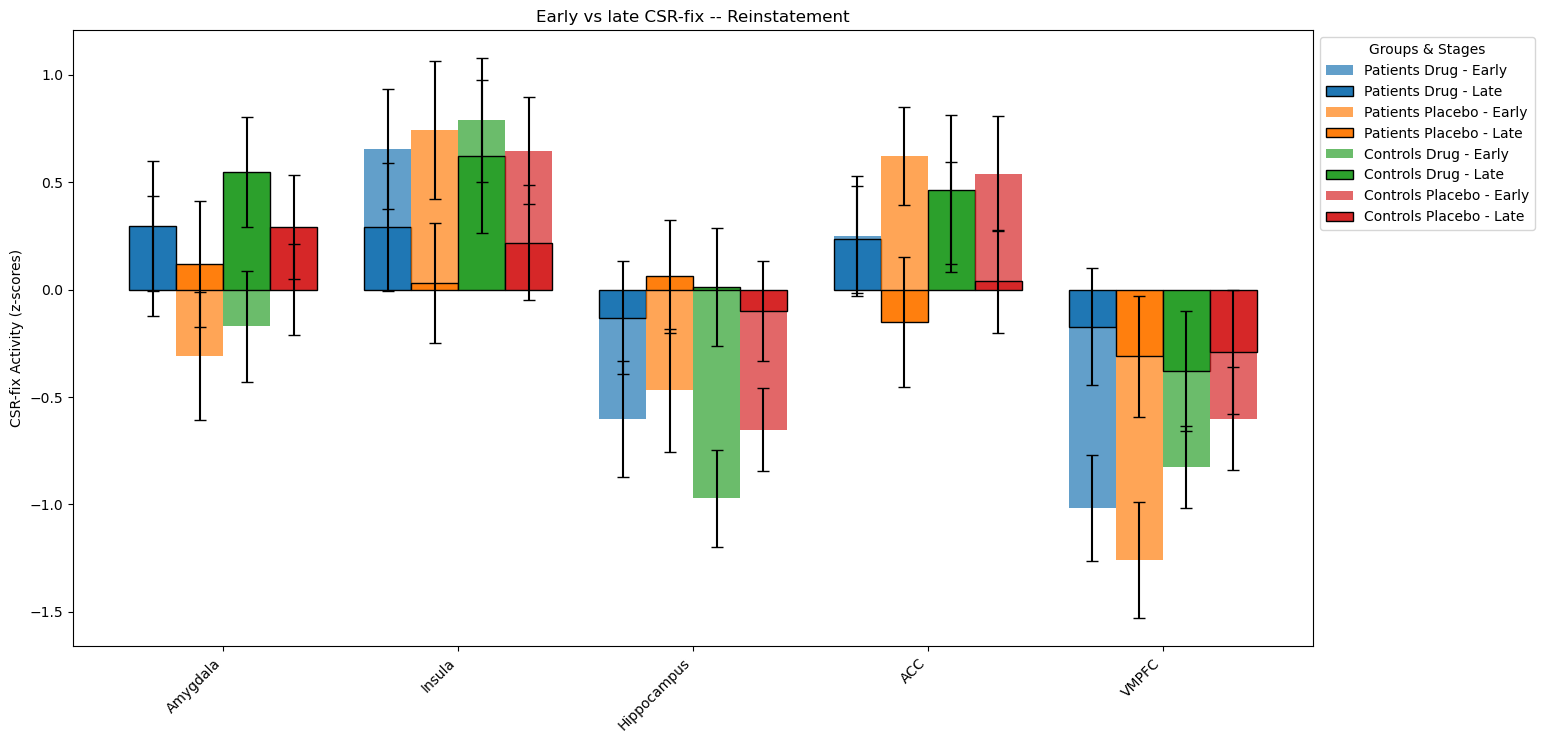

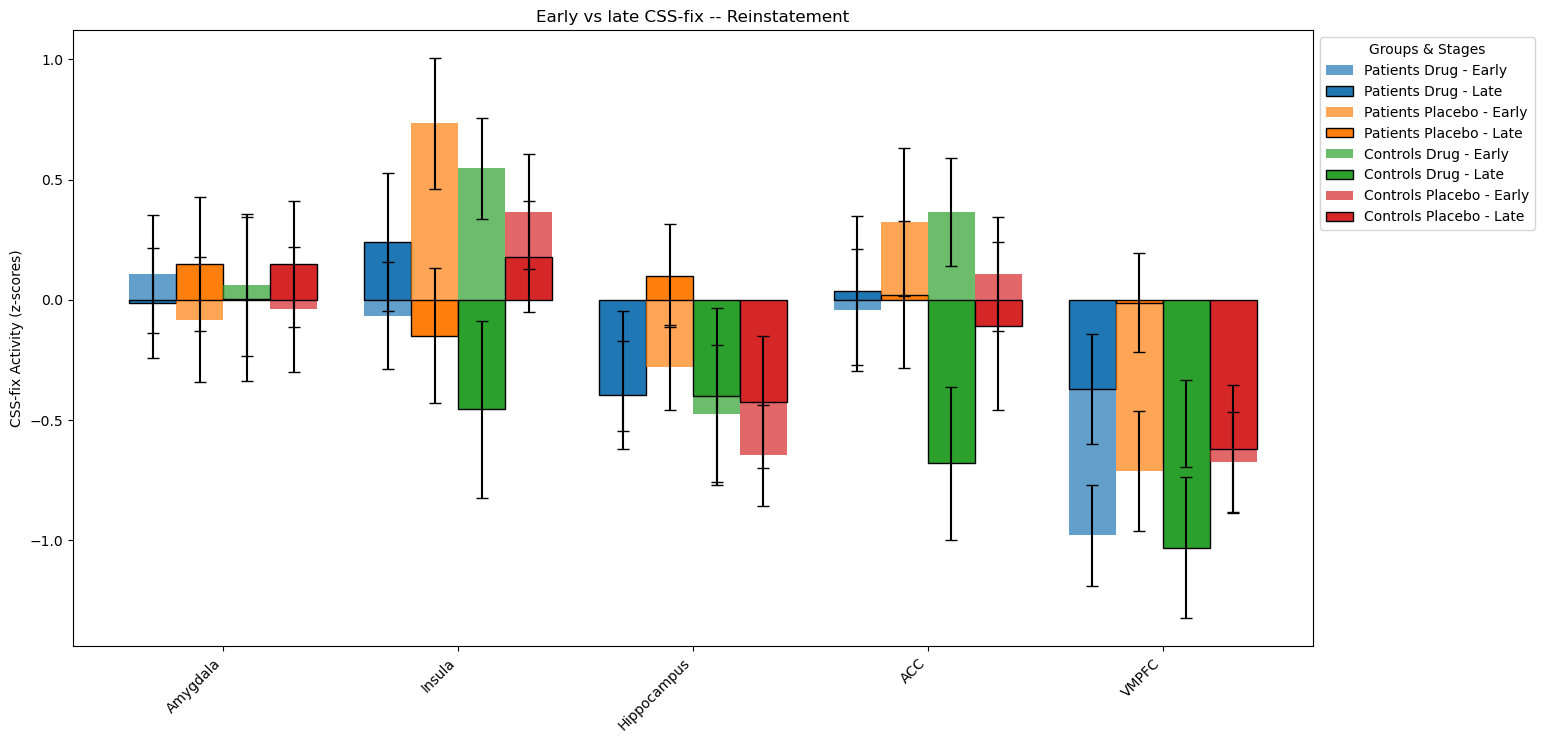

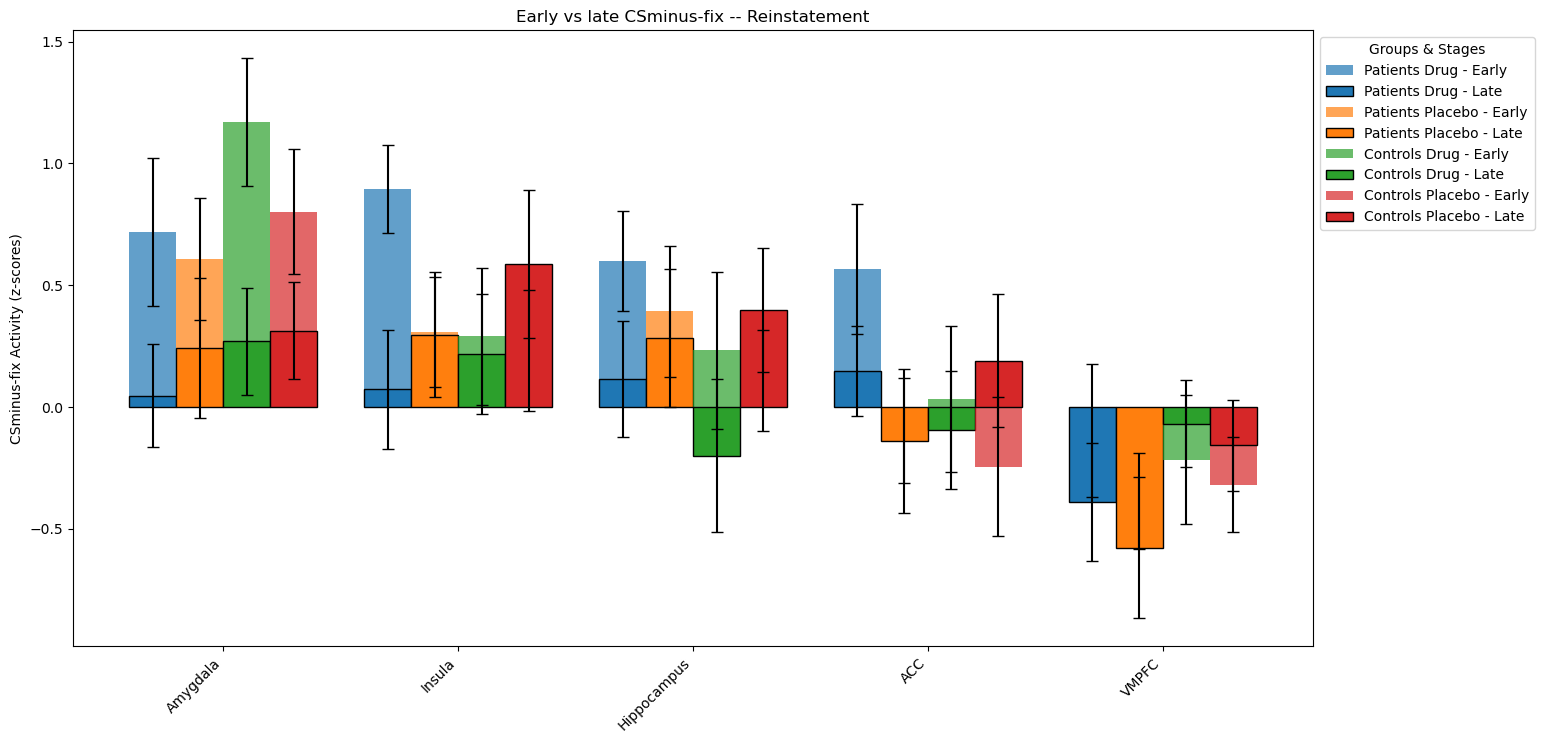

In [ ]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for stage in ['early', 'late']:
            for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
                mean, se = stats[f'{group}_{stage}']
                data.append({
                    'Region': region,
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Group': group.replace('_', ' ').title(),
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats_early_late(data_early, data_late, sub_order, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'patients_drug_early': group_stats(patients_drug, data_early),
        'patients_drug_late': group_stats(patients_drug, data_late),
        'patients_placebo_early': group_stats(patients_placebo, data_early),
        'patients_placebo_late': group_stats(patients_placebo, data_late),
        'controls_drug_early': group_stats(controls_drug, data_early),
        'controls_drug_late': group_stats(controls_drug, data_late),
        'controls_placebo_early': group_stats(controls_placebo, data_early),
        'controls_placebo_late': group_stats(controls_placebo, data_late),
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Early']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Early']['SE'], 
                capsize=4, width=width, color=colors[i], alpha=0.7, label=f'{group} - Early')
        
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Late']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Late']['SE'],
                capsize=4, width=width, color=colors[i], alpha=1, edgecolor='black', label=f'{group} - Late')
    
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'Early vs late {title} -- Reinstatement')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CSSearly'
    contrast_late = 'CSRlate-CSSlate'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_reinstatement.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CS-early'
    contrast_late = 'CSRlate-CS-late'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSminus'
plot_multibar_with_error_bars(all_stats, title,filename='CSR-CSminus_reinstatement.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSSearly-CS-early'
    contrast_late = 'CSSlate-CS-late'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CSminus'
plot_multibar_with_error_bars(all_stats, title,filename='CSS-CSminus_reinstatement.png')


all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-fixearly'
    contrast_late = 'CSRlate-fixlate'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSR-fix_reinstatement.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSSearly-fixearly'
    contrast_late = 'CSSlate-fixlate'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSS-fix_reinstatement.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSminusearly-fixearly'
    contrast_late = 'CSminuslate-fixlate'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSminus-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSminus-fix_reinstatement.png')


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]


contrast_early = 'CSRearly-CSSearly'
contrast_late = 'CSRlate-CSSlate'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
early_data = extract_contrast_data(file_lists_phase3, contrast_early, regions_of_interest, sub_order_phase3)
late_data = extract_contrast_data(file_lists_phase3, contrast_late, regions_of_interest, sub_order_phase3)

# Function to prepare regression data
def prepare_regression_data(early_data, late_data, sub_order, drug_order_df):
    data = []
    
    for region in early_data.keys():
        for idx, sub in enumerate(sub_order['CSRearly-CSSearly']):
            subID = sub[3:7]
            time_values = [1, 2]  # Early = 1, Late = 2
            values = [early_data[region][idx], late_data[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for time, y in zip(time_values, values):
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'Time': time,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(early_data, late_data, sub_order_phase3, drug_order_df)

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ DrugOrder * PatientGroup * Time + Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.7305
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.664
Time:                        16:33:11   Log-Likelihood:                -327.61
No. Observations:                 202   AIC:                             673.2
Df Residuals:                     193   BIC:                             703.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [ ]:
from scipy.stats import ttest_ind
import pandas as pd

contrast = 'CSRearly-CSSearly'

# Function to perform post-hoc comparisons and store in summary table
def perform_posthoc_tests(all_data):
    comparisons = []
    
    for region, stats in all_data.items():
        # Early vs Late within each group
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            early_vals = stats[group]['early']
            late_vals = stats[group]['late']
            t_stat, p_val = ttest_ind(early_vals, late_vals)
            comparisons.append({
                'Region': region,
                'Comparison': f'{group.replace("_", " ").title()} Early vs Late',
                't_stat': t_stat,
                'p_val': p_val
            })
        
        # Group comparisons within Early and Late stages
        for stage in ['early', 'late']:
            # Patients Drug vs Placebo
            t_stat, p_val = ttest_ind(stats['patients_drug'][stage], stats['patients_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Drug vs Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Controls Drug vs Placebo
            t_stat, p_val = ttest_ind(stats['controls_drug'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Controls Drug vs Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Patients Drug vs Controls Drug
            t_stat, p_val = ttest_ind(stats['patients_drug'][stage], stats['controls_drug'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Drug vs Controls Drug ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Patients Placebo vs Controls Placebo
            t_stat, p_val = ttest_ind(stats['patients_placebo'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Placebo vs Controls Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase3[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 1]    
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# Retrieve groups by calling the function
patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order_phase3[contrast], drug_order_df)

# Now, populate all_data with actual values
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data_early = file_lists_phase3['CSRearly-CSSearly']
    region_data_late = file_lists_phase3['CSRlate-CSSlate']
    region_all_data = {
        'patients_drug': {'early': extract_group_data(patients_drug, region_data_early, region_no),
                          'late': extract_group_data(patients_drug, region_data_late, region_no)},
        'patients_placebo': {'early': extract_group_data(patients_placebo, region_data_early, region_no),
                             'late': extract_group_data(patients_placebo, region_data_late, region_no)},
        'controls_drug': {'early': extract_group_data(controls_drug, region_data_early, region_no),
                          'late': extract_group_data(controls_drug, region_data_late, region_no)},
        'controls_placebo': {'early': extract_group_data(controls_placebo, region_data_early, region_no),
                             'late': extract_group_data(controls_placebo, region_data_late, region_no)},
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table
summary_table = perform_posthoc_tests(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


Region                                    Comparison    t_stat  \
0      Amygdala                   Patients Drug Early vs Late -0.569364   
1      Amygdala                Patients Placebo Early vs Late -0.502464   
2      Amygdala                   Controls Drug Early vs Late -1.473562   
3      Amygdala                Controls Placebo Early vs Late -0.217551   
4      Amygdala              Patients Drug vs Placebo (Early)  0.754667   
5      Amygdala              Controls Drug vs Placebo (Early) -0.617165   
6      Amygdala        Patients Drug vs Controls Drug (Early)  0.665939   
7      Amygdala  Patients Placebo vs Controls Placebo (Early) -0.701626   
8      Amygdala               Patients Drug vs Placebo (Late)  0.711254   
9      Amygdala               Controls Drug vs Placebo (Late)  0.762196   
10     Amygdala         Patients Drug vs Controls Drug (Late) -0.424760   
11     Amygdala   Patients Placebo vs Controls Placebo (Late) -0.327621   
12       Insula                   Patients Drug Early vs Late  1.472278   
13       Insula                Patients Placebo Early vs Late -0.140064   
14       Insula                   Controls Drug Early vs Late -1.376232   
15       Insula                Controls Placebo Early vs Late  0.656702   
16       Insula              Patients Drug vs Placebo (Early)  1.276117   
17       Insula              Controls Drug vs Placebo (Early) -0.018026   
18       Insula        Patients Drug vs Controls Drug (Early)  0.820133   
19       Insula  Patients Placebo vs Controls Placebo (Early) -0.510501   
20       Insula               Patients Drug vs Placebo (Late) -0.315327   
21       Insula               Controls Drug vs Placebo (Late)  1.928819   
22       Insula         Patients Drug vs Controls Drug (Late) -2.035971   
23       Insula   Patients Placebo vs Controls Placebo (Late)  0.289853   
24  Hippocampus                   Patients Drug Early vs Late -1.577747   
25  Hippocampus                Patients Placebo Early vs Late -0.422941   
26  Hippocampus                   Controls Drug Early vs Late -2.135275   
27  Hippocampus                Controls Placebo Early vs Late -1.068728   
28  Hippocampus              Patients Drug vs Placebo (Early) -0.269845   
29  Hippocampus              Controls Drug vs Placebo (Early) -1.380958   
30  Hippocampus        Patients Drug vs Controls Drug (Early)  0.503830   
31  Hippocampus  Patients Placebo vs Controls Placebo (Early) -0.367626   
32  Hippocampus               Patients Drug vs Placebo (Late)  0.806562   
33  Hippocampus               Controls Drug vs Placebo (Late)  0.096057   
34  Hippocampus         Patients Drug vs Controls Drug (Late) -0.232053   
35  Hippocampus   Patients Placebo vs Controls Placebo (Late) -0.805014   
36          ACC                   Patients Drug Early vs Late  0.281763   
37          ACC                Patients Placebo Early vs Late  1.067564   
38          ACC                   Controls Drug Early vs Late -1.987196   
39          ACC                Controls Placebo Early vs Late  0.708223   
40          ACC              Patients Drug vs Placebo (Early) -0.101763   
41          ACC              Controls Drug vs Placebo (Early) -1.101184   
42          ACC        Patients Drug vs Controls Drug (Early)  0.557976   
43          ACC  Patients Placebo vs Controls Placebo (Early) -0.289318   
44          ACC               Patients Drug vs Placebo (Late)  0.692514   
45          ACC               Controls Drug vs Placebo (Late)  1.683833   
46          ACC         Patients Drug vs Controls Drug (Late) -1.788123   
47          ACC   Patients Placebo vs Controls Placebo (Late) -0.596000   
48        VMPFC                   Patients Drug Early vs Late -0.922430   
49        VMPFC                Patients Placebo Early vs Late -0.834000   
50        VMPFC                   Controls Drug Early vs Late -2.614552   
51        VMPFC                Controls Placebo Early vs Late -0.803962   
52        VMPFC              Patie

#### Just placebo ! 

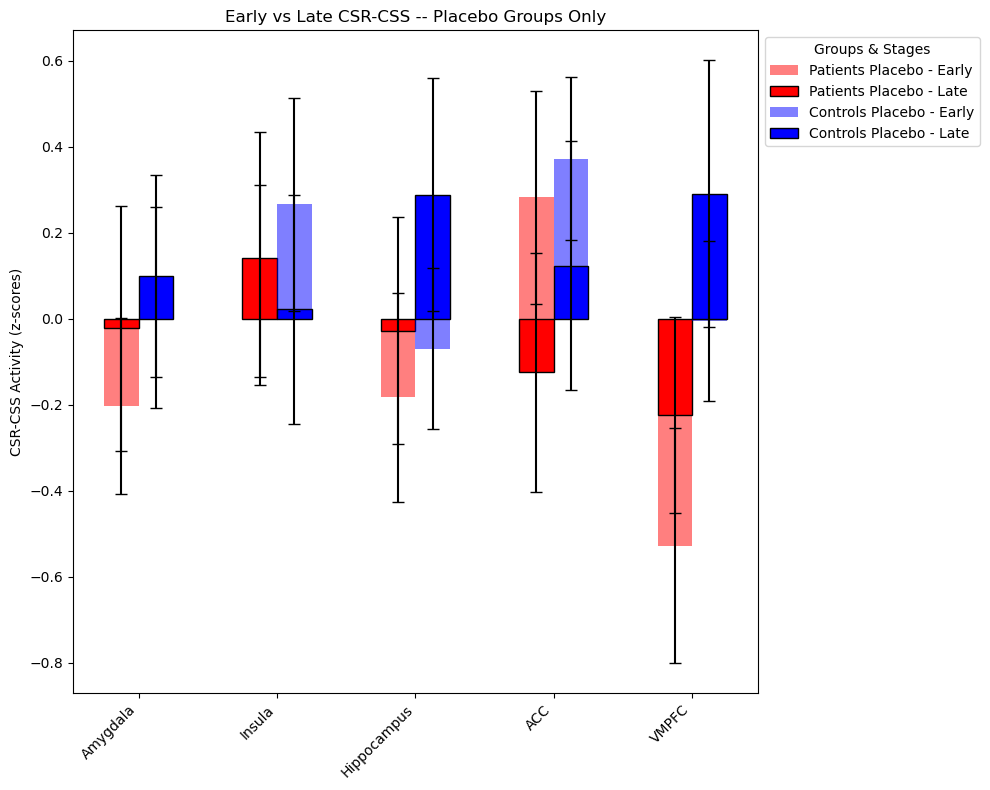

In [ ]:
### just placebo ! 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to prepare data for multibar plot with error bars, only for placebo groups
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for stage in ['early', 'late']:
            for group in ['patients_placebo', 'controls_placebo']:
                mean, se = stats[f'{group}_{stage}']
                data.append({
                    'Region': region,
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Group': group.replace('_', ' ').title(),
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts, only for placebo groups
def extract_stats_early_late(data_early, data_late, sub_order, region_no):
    _, patients_placebo, _, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each placebo group for both early and late contrasts
    stats = {
        'patients_placebo_early': group_stats(patients_placebo, data_early),
        'patients_placebo_late': group_stats(patients_placebo, data_late),
        'controls_placebo_early': group_stats(controls_placebo, data_early),
        'controls_placebo_late': group_stats(controls_placebo, data_late),
    }
    
    return stats

# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(10, 8))
    groups = df['Group'].unique()
    colors = ['red', 'blue']  # Colors for each placebo group

    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.25  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Early']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Early']['SE'], 
                capsize=4, width=width, color=colors[i], alpha=0.5, label=f'{group} - Early')
        
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Late']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Late']['SE'],
                capsize=4, width=width, color=colors[i], alpha=1, edgecolor='black', label=f'{group} - Late')
    
    # Customize the plot
    plt.xticks(x + width * 0.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'Early vs Late {title} -- Placebo Groups Only')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300)
    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CSSearly'
    contrast_late = 'CSRlate-CSSlate'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions for placebo condition only
title = 'CSR-CSS'
filename = 'CSR-CSS_placebo_reinstatement_ROIs_combined.png'
plot_multibar_with_error_bars(all_stats, title,filename)

# for region_no, region in enumerate(regions_of_interest):
#     contrast_early = 'CSRearly-CS-early'
#     contrast_late = 'CSRlate-CS-late'
#     region_data_early = file_lists_phase2[contrast_early]
#     region_data_late = file_lists_phase2[contrast_late]
    
#     stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
#     all_stats[region] = stats

# # Plot combined multibar plot across all regions for placebo condition only
# title = 'CSR-CS-'
# plot_multibar_with_error_bars(all_stats, title, filename)


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast_early = 'CSRearly-CSSearly'
contrast_late = 'CSRlate-CSSlate'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx, sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
early_data = extract_contrast_data(file_lists_phase3, contrast_early, regions_of_interest, sub_order_phase3)
late_data = extract_contrast_data(file_lists_phase3, contrast_late, regions_of_interest, sub_order_phase3)

# Function to prepare regression data
def prepare_regression_data(early_data, late_data, sub_order, drug_order_df):
    data = []
    
    for region in early_data.keys():
        for idx, sub in enumerate(sub_order['CSRearly-CSSearly']):
            subID = sub[3:7]
            time_values = [1, 2]  # Early = 1, Late = 2
            values = [early_data[region][idx], late_data[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            
            # Only include placebo subjects
            if drug_order == 0:
                patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
                gender = drug_order_df.loc[subID].values[3]  # Gender coding
                
                for time, y in zip(time_values, values):
                    data.append({
                        'Subject': subID,
                        'Region': region,
                        'y': y,
                        'Time': time,
                        'PatientGroup': patient_group,
                        'Gender': gender
                    })
    
    return pd.DataFrame(data)

# Prepare the regression data for placebo only
df = prepare_regression_data(early_data, late_data, sub_order_phase3, drug_order_df)

# Loop through each region, run the model without DrugOrder, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model without DrugOrder
    model = smf.ols('y ~ PatientGroup * Time', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.2628
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.852
Time:                        16:39:13   Log-Likelihood:                -160.74
No. Observations:                 100   AIC:                             329.5
Df Residuals:                      96   BIC:                             339.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept  

In [ ]:
from scipy.stats import ttest_ind
import pandas as pd

contrast = 'CSRearly-CSSearly'

# Function to perform post-hoc comparisons and store in summary table (only placebo groups)
def perform_posthoc_tests_placebo(all_data):
    comparisons = []
    
    for region, stats in all_data.items():
        # Early vs Late within each placebo group
        for group in ['patients_placebo', 'controls_placebo']:
            early_vals = stats[group]['early']
            late_vals = stats[group]['late']
            t_stat, p_val = ttest_ind(early_vals, late_vals)
            comparisons.append({
                'Region': region,
                'Comparison': f'{group.replace("_", " ").title()} Early vs Late',
                't_stat': t_stat,
                'p_val': p_val
            })
        
        # Group comparisons within Early and Late stages for placebo groups
        for stage in ['early', 'late']:
            # Patients Placebo vs Controls Placebo
            t_stat, p_val = ttest_ind(stats['patients_placebo'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Placebo vs Controls Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase3[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects, keeping only placebo groups
def separate_groups_by_placebo(sub_order, drug_order):
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_placebo, controls_placebo

# Retrieve placebo groups by calling the function
patients_placebo, controls_placebo = separate_groups_by_placebo(sub_order_phase3[contrast], drug_order_df)

# Populate all_data with actual values for placebo groups
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data_early = file_lists_phase3['CSRearly-CSSearly']
    region_data_late = file_lists_phase3['CSRlate-CSSlate']
    region_all_data = {
        'patients_placebo': {'early': extract_group_data(patients_placebo, region_data_early, region_no),
                             'late': extract_group_data(patients_placebo, region_data_late, region_no)},
        'controls_placebo': {'early': extract_group_data(controls_placebo, region_data_early, region_no),
                             'late': extract_group_data(controls_placebo, region_data_late, region_no)},
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table (placebo only)
summary_table = perform_posthoc_tests_placebo(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


Region                                    Comparison    t_stat  \
0      Amygdala                Patients Placebo Early vs Late -0.502464   
1      Amygdala                Controls Placebo Early vs Late -0.217551   
2      Amygdala  Patients Placebo vs Controls Placebo (Early) -0.701626   
3      Amygdala   Patients Placebo vs Controls Placebo (Late) -0.327621   
4        Insula                Patients Placebo Early vs Late -0.140064   
5        Insula                Controls Placebo Early vs Late  0.656702   
6        Insula  Patients Placebo vs Controls Placebo (Early) -0.510501   
7        Insula   Patients Placebo vs Controls Placebo (Late)  0.289853   
8   Hippocampus                Patients Placebo Early vs Late -0.422941   
9   Hippocampus                Controls Placebo Early vs Late -1.068728   
10  Hippocampus  Patients Placebo vs Controls Placebo (Early) -0.367626   
11  Hippocampus   Patients Placebo vs Controls Placebo (Late) -0.805014   
12          ACC                Patients Placebo Early vs Late  1.067564   
13          ACC                Controls Placebo Early vs Late  0.708223   
14          ACC  Patients Placebo vs Controls Placebo (Early) -0.289318   
15          ACC   Patients Placebo vs Controls Placebo (Late) -0.596000   
16        VMPFC                Patients Placebo Early vs Late -0.834000   
17        VMPFC                Controls Placebo Early vs Late -0.803962   
18        VMPFC  Patients Placebo vs Controls Placebo (Early) -1.598019   
19        VMPFC   Patients Placebo vs Controls Placebo (Late) -1.250012   

       p_val  
0   0.617966  
1   0.828599  
2   0.486301  
3   0.744623  
4   0.889279  
5   0.514162  
6   0.612040  
7   0.773177  
8   0.674496  
9   0.289947  
10  0.714768  
11  0.424782  
12  0.291815  
13  0.481853  
14  0.773584  
15  0.553975  
16  0.408999  
17  0.424944  
18  0.116602  
19  0.217355